I have discorved Non-Local network in term of attention mechanism. Firstly, let's take the original implementation of the author to apply to FER Dataset

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

In [3]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=150),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [4]:
%matplotlib inline

from matplotlib.lines import Line2D      

def plot_grad_flow(named_parameters, epoch, savepath):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):

            try:
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
                layers.append(n)
            except:
                continue
#                 ave_grads.append(0.)
#                 max_grads.append(0.)
#                 layers.append(n)
                
    plt.figure(figsize=(10,10))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.5, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.5, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow | Epoch " + str(epoch))
    plt.tight_layout()
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    
    if not savepath is None:
        plt.savefig(savepath)
    
    

In [5]:
class NLBlockND(nn.Module):
    def __init__(self, in_channels_1, in_channels_2, inter_channels=None, mode='embedded', 
                 dimension=2, bn_layer=True, **kwargs):
        """Implementation of Non-Local Block with 4 different pairwise functions but doesn't include subsampling trick
        args:
            in_channels: original channel size (1024 in the paper)
            inter_channels: channel size inside the block if not specifed reduced to half (512 in the paper)
            mode: supports Gaussian, Embedded Gaussian, Dot Product, and Concatenation
            dimension: can be 1 (temporal), 2 (spatial), 3 (spatiotemporal)
            bn_layer: whether to add batch norm
        """
        super(NLBlockND, self).__init__()

        assert dimension in [1, 2, 3]
        
        if mode not in ['gaussian', 'embedded', 'dot', 'concatenate']:
            raise ValueError('`mode` must be one of `gaussian`, `embedded`, `dot` or `concatenate`')
            
        self.device = kwargs['device']
        self.mode = mode
        self.dimension = dimension

        self.in_channels_1 = in_channels_1
        self.in_channels_2 = in_channels_2
        self.inter_channels = inter_channels

        # the channel size is reduced to half inside the block
        if self.inter_channels is None:
            self.inter_channels = in_channels_2 // 2
            if self.inter_channels == 0:
                self.inter_channels = 1
        
        # assign appropriate convolutional, max pool, and batch norm layers for different dimensions
        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        # function g in the paper which goes through conv. with kernel size 1
        self.g = conv_nd(in_channels=self.in_channels_2, out_channels=self.inter_channels, kernel_size=1)

        # add BatchNorm layer after the last conv layer
        if bn_layer:
            self.W_z = nn.Sequential(
                    conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels_2, kernel_size=1),
                    bn(self.in_channels_2)
                ).to(self.device)
            # from section 4.1 of the paper, initializing params of BN ensures that the initial state of non-local block is identity mapping
            nn.init.constant_(self.W_z[1].weight, 0)
            nn.init.constant_(self.W_z[1].bias, 0)
        else:
            self.W_z = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels_2, kernel_size=1)

            # from section 3.3 of the paper by initializing Wz to 0, this block can be inserted to any existing architecture
            nn.init.constant_(self.W_z.weight, 0)
            nn.init.constant_(self.W_z.bias, 0)

        # define theta and phi for all operations except gaussian
        if self.mode == "embedded" or self.mode == "dot" or self.mode == "concatenate":
            self.theta = nn.Sequential(conv_nd(in_channels=self.in_channels_1, out_channels=self.inter_channels, kernel_size=1),
                                       max_pool_layer).to(self.device)
            self.phi = conv_nd(in_channels=self.in_channels_2, out_channels=self.inter_channels, kernel_size=1)
        
        if self.mode == "concatenate":
            self.W_f = nn.Sequential(
                    nn.Conv2d(in_channels=self.inter_channels * 2, out_channels=1, kernel_size=1),
                    nn.ReLU()
                ).to(self.device)
            
    def forward(self, x1, x2):
        """
        args
            x: (N, C, T, H, W) for dimension=3; (N, C, H, W) for dimension 2; (N, C, T) for dimension 1
        """

        batch_size = x1.size(0)
        
        # (N, C, THW)
        # this reshaping and permutation is from the spacetime_nonlocal function in the original Caffe2 implementation
        g_x = self.g(x2).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        if self.mode == "gaussian":
            theta_x = x1.view(batch_size, self.in_channels_1, -1)
            phi_x = x2.view(batch_size, self.in_channels_2, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "embedded" or self.mode == "dot":
            theta_x = self.theta(x1).view(batch_size, self.inter_channels, -1)
            phi_x = self.phi(x2).view(batch_size, self.inter_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "concatenate":
            theta_x = self.theta(x1).view(batch_size, self.inter_channels, -1, 1)
            phi_x = self.phi(x2).view(batch_size, self.inter_channels, 1, -1)
            
            h = theta_x.size(2)
            w = phi_x.size(3)
            theta_x = theta_x.repeat(1, 1, 1, w)
            phi_x = phi_x.repeat(1, 1, h, 1)
            
            concat = torch.cat([theta_x, phi_x], dim=1)
            f = self.W_f(concat)
            f = f.view(f.size(0), f.size(2), f.size(3))
        
        if self.mode == "gaussian" or self.mode == "embedded":
            f_div_C = F.softmax(f, dim=-1)
        elif self.mode == "dot" or self.mode == "concatenate":
            N = f.size(-1) # number of position in x
            f_div_C = f / N
        
        y = torch.matmul(f_div_C, g_x)
        
        # contiguous here just allocates contiguous chunk of memory
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x2.size()[2:])
        
        W_y = self.W_z(y)
        
        # residual connection
        z = W_y + x2

        return z

In [6]:
class NLBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, mode='embedded', 
                 dimension=2, bn_layer=True, **kwargs):
        """Implementation of Non-Local Block with 4 different pairwise functions but doesn't include subsampling trick
        args:
            in_channels: original channel size (1024 in the paper)
            inter_channels: channel size inside the block if not specifed reduced to half (512 in the paper)
            mode: supports Gaussian, Embedded Gaussian, Dot Product, and Concatenation
            dimension: can be 1 (temporal), 2 (spatial), 3 (spatiotemporal)
            bn_layer: whether to add batch norm
        """
        super(NLBlockND, self).__init__()
        
        self.device = kwargs['device']
        assert dimension in [1, 2, 3]
        
        if mode not in ['gaussian', 'embedded', 'dot', 'concatenate']:
            raise ValueError('`mode` must be one of `gaussian`, `embedded`, `dot` or `concatenate`')
            
        self.mode = mode
        self.dimension = dimension

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        # the channel size is reduced to half inside the block
        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1
        
        # assign appropriate convolutional, max pool, and batch norm layers for different dimensions
        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        # function g in the paper which goes through conv. with kernel size 1
        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)

        # add BatchNorm layer after the last conv layer
        if bn_layer:
            self.W_z = nn.Sequential(
                    conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels, kernel_size=1),
                    bn(self.in_channels)
                ).to(self.device)
            # from section 4.1 of the paper, initializing params of BN ensures that the initial state of non-local block is identity mapping
            nn.init.constant_(self.W_z[1].weight, 0)
            nn.init.constant_(self.W_z[1].bias, 0)
        else:
            self.W_z = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels, kernel_size=1)

            # from section 3.3 of the paper by initializing Wz to 0, this block can be inserted to any existing architecture
            nn.init.constant_(self.W_z.weight, 0)
            nn.init.constant_(self.W_z.bias, 0)

        # define theta and phi for all operations except gaussian
        if self.mode == "embedded" or self.mode == "dot" or self.mode == "concatenate":
            self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)
            self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)
        
        if self.mode == "concatenate":
            self.W_f = nn.Sequential(
                    nn.Conv2d(in_channels=self.inter_channels * 2, out_channels=1, kernel_size=1),
                    nn.ReLU()
                ).to(self.device)
            
    def forward(self, x):
        """
        args
            x: (N, C, T, H, W) for dimension=3; (N, C, H, W) for dimension 2; (N, C, T) for dimension 1
        """

        batch_size = x.size(0)
        
        # (N, C, THW)
        # this reshaping and permutation is from the spacetime_nonlocal function in the original Caffe2 implementation
        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        if self.mode == "gaussian":
            theta_x = x.view(batch_size, self.in_channels, -1)
            phi_x = x.view(batch_size, self.in_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "embedded" or self.mode == "dot":
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "concatenate":
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1, 1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, 1, -1)
            
            h = theta_x.size(2)
            w = phi_x.size(3)
            theta_x = theta_x.repeat(1, 1, 1, w)
            phi_x = phi_x.repeat(1, 1, h, 1)
            
            concat = torch.cat([theta_x, phi_x], dim=1)
            f = self.W_f(concat)
            f = f.view(f.size(0), f.size(2), f.size(3))
        
        if self.mode == "gaussian" or self.mode == "embedded":
            f_div_C = F.softmax(f, dim=-1)
        elif self.mode == "dot" or self.mode == "concatenate":
            N = f.size(-1) # number of position in x
            f_div_C = f / N
        
        y = torch.matmul(f_div_C, g_x)
        
        # contiguous here just allocates contiguous chunk of memory
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        
        W_y = self.W_z(y)
        # residual connection
        z = W_y + x

        return z

In [7]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)


    def forward(self, x):        
        
        x = torch.cat(x, dim=1) if type(x) is list else x

        # 1st
        x = self.conv1(x)
        x = self.bn1(x)
        x1 = self.relu(x)

        # 2nd
        x = self.conv2(x1)
        x = self.bn2(x)
        x2 = self.relu(x)
        
        _x2 = x2 + x1
        _x2 = self.bn2_(_x2)
        
        # 3rd
        x = self.conv3(_x2)
        x = self.bn3(x)
        x3 = self.relu(x)
        
        _x3 = x3 + x2
        _x3 = self.bn3_(_x3)

        # maxpooling
        x = self.maxpool(_x3)

        return x

In [8]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)       
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        
        self.nl0 = NLBlockND(64, mode='embedded', device=self.device).to(device)
        self.nl1 = NLBlockND(128, mode='embedded', device=self.device).to(device)
        self.nl2 = NLBlockND(256, mode='embedded', device=self.device).to(device)
        self.nl3 = NLBlockND(512, mode='embedded', device=self.device).to(device)

        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        
        x0 = self.sv0(x)
        x0 = self.nl0(x0)
        
        x1 = self.sv1(x0)
        x1 = self.nl1(x1)
        
        x2 = self.sv2(x1)
        x2 = self.nl2(x2)
        
        x3 = self.sv3(x2)
        x_out = self.nl3(x3)
        x_out = nn.AvgPool2d(kernel_size=(x_out.size(-2), x_out.size(-1)))(x_out)

        x = nn.Flatten()(x_out)

        x = self.fc2(x)
        x = self.bn2(x)

        return x

In [9]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


cuda


Epoch:  1
	 - Step 1: loss: 2.236 acc: 0.250
	 - Step 2: loss: 2.313 acc: 0.172
	 - Step 3: loss: 2.460 acc: 0.094
	 - Step 4: loss: 2.205 acc: 0.172
	 - Step 5: loss: 2.239 acc: 0.109
	 - Step 6: loss: 2.037 acc: 0.234
	 - Step 7: loss: 2.233 acc: 0.188
	 - Step 8: loss: 2.279 acc: 0.219
	 - Step 9: loss: 1.970 acc: 0.297
	 - Step 10: loss: 2.008 acc: 0.234
	 - Step 11: loss: 2.283 acc: 0.156
	 - Step 12: loss: 2.000 acc: 0.250
	 - Step 13: loss: 1.990 acc: 0.203
	 - Step 14: loss: 2.180 acc: 0.094
	 - Step 15: loss: 2.171 acc: 0.141
	 - Step 16: loss: 1.941 acc: 0.203
	 - Step 17: loss: 2.001 acc: 0.234
	 - Step 18: loss: 1.998 acc: 0.188
	 - Step 19: loss: 2.107 acc: 0.297
	 - Step 20: loss: 1.945 acc: 0.266
	 - Step 21: loss: 2.349 acc: 0.172
	 - Step 22: loss: 2.051 acc: 0.188
	 - Step 23: loss: 2.036 acc: 0.125
	 - Step 24: loss: 2.186 acc: 0.172
	 - Step 25: loss: 2.057 acc: 0.172
	 - Step 26: loss: 2.329 acc: 0.156
	 - Step 27: loss: 1.893 acc: 0.219
	 - Step 28: loss: 1.978 ac

	 - Step 226: loss: 1.465 acc: 0.438
	 - Step 227: loss: 1.427 acc: 0.500
	 - Step 228: loss: 1.555 acc: 0.344
	 - Step 229: loss: 1.425 acc: 0.500
	 - Step 230: loss: 1.368 acc: 0.516
	 - Step 231: loss: 1.507 acc: 0.422
	 - Step 232: loss: 1.418 acc: 0.500
	 - Step 233: loss: 1.366 acc: 0.469
	 - Step 234: loss: 1.365 acc: 0.484
	 - Step 235: loss: 1.436 acc: 0.438
	 - Step 236: loss: 1.361 acc: 0.531
	 - Step 237: loss: 1.429 acc: 0.453
	 - Step 238: loss: 1.406 acc: 0.406
	 - Step 239: loss: 1.531 acc: 0.422
	 - Step 240: loss: 1.495 acc: 0.500
	 - Step 241: loss: 1.370 acc: 0.531
	 - Step 242: loss: 1.485 acc: 0.484
	 - Step 243: loss: 1.435 acc: 0.453
	 - Step 244: loss: 1.569 acc: 0.391
	 - Step 245: loss: 1.405 acc: 0.531
	 - Step 246: loss: 1.346 acc: 0.531
	 - Step 247: loss: 1.583 acc: 0.359
	 - Step 248: loss: 1.348 acc: 0.516
	 - Step 249: loss: 1.332 acc: 0.516
	 - Step 250: loss: 1.448 acc: 0.453
	 - Step 251: loss: 1.535 acc: 0.391
	 - Step 252: loss: 1.330 acc: 0.500
	

	 - Step 448: loss: 1.344 acc: 0.438
	 - Step 449: loss: 1.444 acc: 0.514
- Avg.loss: 1.555  | Avg.acc: 0.416
- Avg. val_loss: 1.307  | Avg. val_acc: 0.508
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NLBlockND. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.365 acc: 0.453
	 - Step 2: loss: 1.210 acc: 0.609
	 - Step 3: loss: 1.264 acc: 0.562
	 - Step 4: loss: 1.431 acc: 0.438
	 - Step 5: loss: 1.237 acc: 0.531
	 - Step 6: loss: 1.335 acc: 0.531
	 - Step 7: loss: 1.058 acc: 0.578
	 - Step 8: loss: 1.084 acc: 0.656
	 - Step 9: loss: 1.306 acc: 0.500
	 - Step 10: loss: 1.442 acc: 0.453
	 - Step 11: loss: 1.184 acc: 0.547
	 - Step 12: loss: 1.329 acc: 0.578
	 - Step 13: loss: 1.276 acc: 0.500
	 - Step 14: loss: 1.084 acc: 0.656
	 - Step 15: loss: 1.281 acc: 0.531
	 - Step 16: loss: 1.178 acc: 0.562
	 - Step 17: loss: 1.245 acc: 0.531
	 - Step 18: loss: 1.221 acc: 0.500
	 - Step 19: loss: 1.170 acc: 0.594
	 - Step 20: loss: 1.193 acc: 0.641
	 - Step 21: loss: 1.200 acc: 0.531
	 - Step 22: loss: 1.288 acc: 0.531
	 - Step 23: loss: 1.460 acc: 0.484
	 - Step 24: loss: 1.400 acc: 0.500
	 - Step 25: loss: 1.125 acc: 0.656
	 - Step 26: loss: 1.232 acc: 0.531
	 - Step 27: loss: 1.315 acc: 0.453
	 - Step 28: loss: 1.410 acc: 0.453
	

	 - Step 226: loss: 1.196 acc: 0.547
	 - Step 227: loss: 1.264 acc: 0.516
	 - Step 228: loss: 1.125 acc: 0.578
	 - Step 229: loss: 1.236 acc: 0.484
	 - Step 230: loss: 1.322 acc: 0.531
	 - Step 231: loss: 1.238 acc: 0.578
	 - Step 232: loss: 1.389 acc: 0.484
	 - Step 233: loss: 1.208 acc: 0.578
	 - Step 234: loss: 1.259 acc: 0.609
	 - Step 235: loss: 1.072 acc: 0.609
	 - Step 236: loss: 1.230 acc: 0.531
	 - Step 237: loss: 1.186 acc: 0.609
	 - Step 238: loss: 1.083 acc: 0.656
	 - Step 239: loss: 1.126 acc: 0.625
	 - Step 240: loss: 1.225 acc: 0.562
	 - Step 241: loss: 1.384 acc: 0.469
	 - Step 242: loss: 1.151 acc: 0.594
	 - Step 243: loss: 1.106 acc: 0.609
	 - Step 244: loss: 1.134 acc: 0.672
	 - Step 245: loss: 1.143 acc: 0.547
	 - Step 246: loss: 1.176 acc: 0.578
	 - Step 247: loss: 1.292 acc: 0.531
	 - Step 248: loss: 1.128 acc: 0.578
	 - Step 249: loss: 1.155 acc: 0.531
	 - Step 250: loss: 1.332 acc: 0.500
	 - Step 251: loss: 1.245 acc: 0.531
	 - Step 252: loss: 1.021 acc: 0.656
	

	 - Step 448: loss: 1.190 acc: 0.594
	 - Step 449: loss: 1.163 acc: 0.541
- Avg.loss: 1.220  | Avg.acc: 0.555
- Avg. val_loss: 1.282  | Avg. val_acc: 0.546
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.077 acc: 0.656
	 - Step 2: loss: 1.472 acc: 0.422
	 - Step 3: loss: 1.025 acc: 0.641
	 - Step 4: loss: 1.081 acc: 0.641
	 - Step 5: loss: 0.930 acc: 0.734
	 - Step 6: loss: 1.307 acc: 0.516
	 - Step 7: loss: 1.075 acc: 0.578
	 - Step 8: loss: 1.215 acc: 0.562
	 - Step 9: loss: 1.196 acc: 0.641
	 - Step 10: loss: 1.022 acc: 0.641
	 - Step 11: loss: 1.002 acc: 0.672
	 - Step 12: loss: 1.161 acc: 0.562
	 - Step 13: loss: 1.072 acc: 0.562
	 - Step 14: loss: 1.062 acc: 0.594
	 - Step 15: loss: 1.236 acc: 0.500
	 - Step 16: loss: 1.057 acc: 0.609
	 - Step 17: loss: 1.157 acc: 0.531
	 - Step 18: loss: 1.050 acc: 0.562
	 - Step 19: loss: 1.197 acc: 0.484
	 - Step 20: loss: 1.209 acc: 0.562
	 - Step 21: loss: 1.143 acc: 0.641
	 - Step 22: loss: 1.197 acc: 0.547
	 - Step 23: loss: 1.062 acc

	 - Step 223: loss: 1.174 acc: 0.578
	 - Step 224: loss: 0.980 acc: 0.656
	 - Step 225: loss: 1.068 acc: 0.547
	 - Step 226: loss: 1.072 acc: 0.594
	 - Step 227: loss: 0.915 acc: 0.734
	 - Step 228: loss: 1.010 acc: 0.656
	 - Step 229: loss: 1.245 acc: 0.547
	 - Step 230: loss: 0.974 acc: 0.672
	 - Step 231: loss: 1.091 acc: 0.656
	 - Step 232: loss: 1.104 acc: 0.656
	 - Step 233: loss: 0.884 acc: 0.688
	 - Step 234: loss: 1.068 acc: 0.594
	 - Step 235: loss: 1.072 acc: 0.625
	 - Step 236: loss: 1.322 acc: 0.406
	 - Step 237: loss: 0.941 acc: 0.656
	 - Step 238: loss: 1.095 acc: 0.562
	 - Step 239: loss: 1.089 acc: 0.594
	 - Step 240: loss: 1.028 acc: 0.641
	 - Step 241: loss: 1.233 acc: 0.516
	 - Step 242: loss: 1.051 acc: 0.641
	 - Step 243: loss: 1.222 acc: 0.500
	 - Step 244: loss: 1.196 acc: 0.547
	 - Step 245: loss: 0.896 acc: 0.719
	 - Step 246: loss: 1.380 acc: 0.547
	 - Step 247: loss: 1.157 acc: 0.594
	 - Step 248: loss: 1.067 acc: 0.578
	 - Step 249: loss: 1.104 acc: 0.609
	

	 - Step 445: loss: 1.092 acc: 0.594
	 - Step 446: loss: 1.259 acc: 0.500
	 - Step 447: loss: 1.111 acc: 0.609
	 - Step 448: loss: 1.209 acc: 0.562
	 - Step 449: loss: 1.152 acc: 0.622
- Avg.loss: 1.125  | Avg.acc: 0.586
- Avg. val_loss: 1.163  | Avg. val_acc: 0.567
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.082 acc: 0.594
	 - Step 2: loss: 1.067 acc: 0.609
	 - Step 3: loss: 1.067 acc: 0.625
	 - Step 4: loss: 1.017 acc: 0.625
	 - Step 5: loss: 1.129 acc: 0.531
	 - Step 6: loss: 1.051 acc: 0.625
	 - Step 7: loss: 1.049 acc: 0.672
	 - Step 8: loss: 0.913 acc: 0.641
	 - Step 9: loss: 0.995 acc: 0.656
	 - Step 10: loss: 0.968 acc: 0.688
	 - Step 11: loss: 0.988 acc: 0.625
	 - Step 12: loss: 0.989 acc: 0.641
	 - Step 13: loss: 1.049 acc: 0.641
	 - Step 14: loss: 1.041 acc: 0.609
	 - Step 15: loss: 1.043 acc: 0.578
	 - Step 16: loss: 0.923 acc: 0.750
	 - Step 17: loss: 1.261 acc: 0.516
	 - Step 18: loss: 1.066 acc: 0.688
	 - Step 19: loss: 0.933 acc: 0.703
	 - Step 20: loss: 0.826 

	 - Step 220: loss: 1.093 acc: 0.625
	 - Step 221: loss: 1.200 acc: 0.562
	 - Step 222: loss: 1.088 acc: 0.594
	 - Step 223: loss: 1.100 acc: 0.562
	 - Step 224: loss: 1.051 acc: 0.578
	 - Step 225: loss: 0.806 acc: 0.781
	 - Step 226: loss: 0.977 acc: 0.672
	 - Step 227: loss: 1.035 acc: 0.656
	 - Step 228: loss: 1.053 acc: 0.641
	 - Step 229: loss: 1.087 acc: 0.625
	 - Step 230: loss: 1.056 acc: 0.562
	 - Step 231: loss: 1.028 acc: 0.625
	 - Step 232: loss: 0.981 acc: 0.641
	 - Step 233: loss: 1.123 acc: 0.562
	 - Step 234: loss: 0.904 acc: 0.672
	 - Step 235: loss: 1.006 acc: 0.625
	 - Step 236: loss: 1.314 acc: 0.516
	 - Step 237: loss: 1.143 acc: 0.562
	 - Step 238: loss: 1.064 acc: 0.562
	 - Step 239: loss: 1.059 acc: 0.672
	 - Step 240: loss: 1.064 acc: 0.594
	 - Step 241: loss: 1.077 acc: 0.641
	 - Step 242: loss: 1.025 acc: 0.609
	 - Step 243: loss: 0.828 acc: 0.703
	 - Step 244: loss: 1.029 acc: 0.672
	 - Step 245: loss: 1.191 acc: 0.516
	 - Step 246: loss: 0.991 acc: 0.672
	

	 - Step 442: loss: 1.141 acc: 0.516
	 - Step 443: loss: 1.038 acc: 0.656
	 - Step 444: loss: 0.939 acc: 0.672
	 - Step 445: loss: 0.998 acc: 0.609
	 - Step 446: loss: 1.109 acc: 0.547
	 - Step 447: loss: 0.849 acc: 0.672
	 - Step 448: loss: 0.953 acc: 0.641
	 - Step 449: loss: 0.862 acc: 0.757
- Avg.loss: 1.067  | Avg.acc: 0.609
- Avg. val_loss: 1.188  | Avg. val_acc: 0.551
Epoch:  5
	 - Step 1: loss: 1.023 acc: 0.672
	 - Step 2: loss: 1.057 acc: 0.641
	 - Step 3: loss: 1.213 acc: 0.531
	 - Step 4: loss: 0.971 acc: 0.609
	 - Step 5: loss: 1.014 acc: 0.656
	 - Step 6: loss: 0.767 acc: 0.719
	 - Step 7: loss: 0.835 acc: 0.734
	 - Step 8: loss: 0.940 acc: 0.703
	 - Step 9: loss: 0.848 acc: 0.734
	 - Step 10: loss: 0.981 acc: 0.734
	 - Step 11: loss: 0.915 acc: 0.625
	 - Step 12: loss: 1.148 acc: 0.594
	 - Step 13: loss: 1.060 acc: 0.594
	 - Step 14: loss: 0.973 acc: 0.625
	 - Step 15: loss: 0.838 acc: 0.672
	 - Step 16: loss: 1.192 acc: 0.516
	 - Step 17: loss: 1.073 acc: 0.656
	 - Step 

	 - Step 217: loss: 0.893 acc: 0.688
	 - Step 218: loss: 0.837 acc: 0.703
	 - Step 219: loss: 0.910 acc: 0.688
	 - Step 220: loss: 1.078 acc: 0.609
	 - Step 221: loss: 1.046 acc: 0.609
	 - Step 222: loss: 1.095 acc: 0.625
	 - Step 223: loss: 1.113 acc: 0.547
	 - Step 224: loss: 1.411 acc: 0.531
	 - Step 225: loss: 1.186 acc: 0.594
	 - Step 226: loss: 1.094 acc: 0.625
	 - Step 227: loss: 1.049 acc: 0.641
	 - Step 228: loss: 1.071 acc: 0.594
	 - Step 229: loss: 1.089 acc: 0.578
	 - Step 230: loss: 0.945 acc: 0.641
	 - Step 231: loss: 1.339 acc: 0.469
	 - Step 232: loss: 0.965 acc: 0.625
	 - Step 233: loss: 1.052 acc: 0.578
	 - Step 234: loss: 1.175 acc: 0.500
	 - Step 235: loss: 1.140 acc: 0.531
	 - Step 236: loss: 0.976 acc: 0.656
	 - Step 237: loss: 1.041 acc: 0.562
	 - Step 238: loss: 0.893 acc: 0.672
	 - Step 239: loss: 0.880 acc: 0.688
	 - Step 240: loss: 1.025 acc: 0.641
	 - Step 241: loss: 1.003 acc: 0.625
	 - Step 242: loss: 1.002 acc: 0.703
	 - Step 243: loss: 1.014 acc: 0.609
	

	 - Step 439: loss: 1.027 acc: 0.531
	 - Step 440: loss: 0.858 acc: 0.703
	 - Step 441: loss: 0.928 acc: 0.672
	 - Step 442: loss: 1.012 acc: 0.578
	 - Step 443: loss: 0.963 acc: 0.656
	 - Step 444: loss: 0.881 acc: 0.719
	 - Step 445: loss: 1.139 acc: 0.641
	 - Step 446: loss: 0.994 acc: 0.688
	 - Step 447: loss: 1.092 acc: 0.609
	 - Step 448: loss: 0.868 acc: 0.672
	 - Step 449: loss: 1.052 acc: 0.622
- Avg.loss: 1.025  | Avg.acc: 0.622
- Avg. val_loss: 1.130  | Avg. val_acc: 0.577
* Update optimal model
Epoch:  6
	 - Step 1: loss: 0.902 acc: 0.688
	 - Step 2: loss: 0.743 acc: 0.750
	 - Step 3: loss: 1.160 acc: 0.562
	 - Step 4: loss: 0.947 acc: 0.656
	 - Step 5: loss: 0.793 acc: 0.703
	 - Step 6: loss: 0.755 acc: 0.781
	 - Step 7: loss: 0.788 acc: 0.688
	 - Step 8: loss: 0.880 acc: 0.672
	 - Step 9: loss: 0.619 acc: 0.828
	 - Step 10: loss: 1.023 acc: 0.672
	 - Step 11: loss: 0.996 acc: 0.641
	 - Step 12: loss: 1.248 acc: 0.562
	 - Step 13: loss: 1.097 acc: 0.578
	 - Step 14: loss: 

	 - Step 214: loss: 0.893 acc: 0.688
	 - Step 215: loss: 0.962 acc: 0.625
	 - Step 216: loss: 0.954 acc: 0.656
	 - Step 217: loss: 1.060 acc: 0.656
	 - Step 218: loss: 0.935 acc: 0.609
	 - Step 219: loss: 1.111 acc: 0.594
	 - Step 220: loss: 1.127 acc: 0.578
	 - Step 221: loss: 0.873 acc: 0.641
	 - Step 222: loss: 1.132 acc: 0.578
	 - Step 223: loss: 1.037 acc: 0.641
	 - Step 224: loss: 0.967 acc: 0.609
	 - Step 225: loss: 1.063 acc: 0.594
	 - Step 226: loss: 1.201 acc: 0.578
	 - Step 227: loss: 0.971 acc: 0.641
	 - Step 228: loss: 1.014 acc: 0.609
	 - Step 229: loss: 0.932 acc: 0.688
	 - Step 230: loss: 0.932 acc: 0.625
	 - Step 231: loss: 0.956 acc: 0.672
	 - Step 232: loss: 1.259 acc: 0.594
	 - Step 233: loss: 0.793 acc: 0.734
	 - Step 234: loss: 1.077 acc: 0.594
	 - Step 235: loss: 1.154 acc: 0.500
	 - Step 236: loss: 1.088 acc: 0.594
	 - Step 237: loss: 1.039 acc: 0.641
	 - Step 238: loss: 1.059 acc: 0.578
	 - Step 239: loss: 1.087 acc: 0.594
	 - Step 240: loss: 1.088 acc: 0.594
	

	 - Step 436: loss: 1.118 acc: 0.531
	 - Step 437: loss: 0.928 acc: 0.688
	 - Step 438: loss: 0.909 acc: 0.672
	 - Step 439: loss: 1.000 acc: 0.672
	 - Step 440: loss: 0.845 acc: 0.656
	 - Step 441: loss: 1.183 acc: 0.578
	 - Step 442: loss: 1.011 acc: 0.547
	 - Step 443: loss: 0.972 acc: 0.656
	 - Step 444: loss: 0.898 acc: 0.703
	 - Step 445: loss: 1.038 acc: 0.625
	 - Step 446: loss: 0.794 acc: 0.766
	 - Step 447: loss: 0.894 acc: 0.625
	 - Step 448: loss: 0.878 acc: 0.688
	 - Step 449: loss: 0.993 acc: 0.514
- Avg.loss: 0.986  | Avg.acc: 0.638
- Avg. val_loss: 1.088  | Avg. val_acc: 0.587
* Update optimal model
Epoch:  7
	 - Step 1: loss: 1.103 acc: 0.625
	 - Step 2: loss: 0.766 acc: 0.750
	 - Step 3: loss: 1.265 acc: 0.531
	 - Step 4: loss: 0.897 acc: 0.672
	 - Step 5: loss: 0.997 acc: 0.609
	 - Step 6: loss: 0.938 acc: 0.703
	 - Step 7: loss: 0.928 acc: 0.625
	 - Step 8: loss: 0.896 acc: 0.688
	 - Step 9: loss: 0.867 acc: 0.703
	 - Step 10: loss: 0.905 acc: 0.688
	 - Step 11: los

	 - Step 211: loss: 0.995 acc: 0.641
	 - Step 212: loss: 0.905 acc: 0.656
	 - Step 213: loss: 0.999 acc: 0.641
	 - Step 214: loss: 1.087 acc: 0.578
	 - Step 215: loss: 1.175 acc: 0.609
	 - Step 216: loss: 1.040 acc: 0.688
	 - Step 217: loss: 0.908 acc: 0.672
	 - Step 218: loss: 1.199 acc: 0.609
	 - Step 219: loss: 0.825 acc: 0.703
	 - Step 220: loss: 1.067 acc: 0.656
	 - Step 221: loss: 0.915 acc: 0.656
	 - Step 222: loss: 1.046 acc: 0.594
	 - Step 223: loss: 0.826 acc: 0.734
	 - Step 224: loss: 0.824 acc: 0.703
	 - Step 225: loss: 1.160 acc: 0.562
	 - Step 226: loss: 0.850 acc: 0.719
	 - Step 227: loss: 0.889 acc: 0.750
	 - Step 228: loss: 0.790 acc: 0.719
	 - Step 229: loss: 1.011 acc: 0.609
	 - Step 230: loss: 0.885 acc: 0.656
	 - Step 231: loss: 0.771 acc: 0.688
	 - Step 232: loss: 0.831 acc: 0.734
	 - Step 233: loss: 1.034 acc: 0.625
	 - Step 234: loss: 1.008 acc: 0.656
	 - Step 235: loss: 0.923 acc: 0.672
	 - Step 236: loss: 1.048 acc: 0.609
	 - Step 237: loss: 0.769 acc: 0.703
	

	 - Step 433: loss: 0.742 acc: 0.828
	 - Step 434: loss: 1.446 acc: 0.484
	 - Step 435: loss: 0.921 acc: 0.672
	 - Step 436: loss: 1.094 acc: 0.609
	 - Step 437: loss: 0.919 acc: 0.656
	 - Step 438: loss: 1.040 acc: 0.609
	 - Step 439: loss: 0.852 acc: 0.703
	 - Step 440: loss: 0.960 acc: 0.609
	 - Step 441: loss: 0.901 acc: 0.703
	 - Step 442: loss: 0.943 acc: 0.609
	 - Step 443: loss: 0.939 acc: 0.672
	 - Step 444: loss: 0.913 acc: 0.625
	 - Step 445: loss: 0.806 acc: 0.688
	 - Step 446: loss: 0.889 acc: 0.641
	 - Step 447: loss: 1.036 acc: 0.656
	 - Step 448: loss: 0.802 acc: 0.750
	 - Step 449: loss: 1.106 acc: 0.568
- Avg.loss: 0.937  | Avg.acc: 0.656
- Avg. val_loss: 1.059  | Avg. val_acc: 0.610
* Update optimal model
Epoch:  8
	 - Step 1: loss: 0.821 acc: 0.719
	 - Step 2: loss: 0.822 acc: 0.734
	 - Step 3: loss: 0.942 acc: 0.703
	 - Step 4: loss: 0.943 acc: 0.656
	 - Step 5: loss: 0.798 acc: 0.641
	 - Step 6: loss: 0.940 acc: 0.688
	 - Step 7: loss: 1.009 acc: 0.641
	 - Step 8:

	 - Step 208: loss: 0.773 acc: 0.734
	 - Step 209: loss: 0.733 acc: 0.734
	 - Step 210: loss: 0.769 acc: 0.688
	 - Step 211: loss: 0.850 acc: 0.734
	 - Step 212: loss: 0.814 acc: 0.719
	 - Step 213: loss: 0.706 acc: 0.719
	 - Step 214: loss: 1.050 acc: 0.625
	 - Step 215: loss: 0.816 acc: 0.703
	 - Step 216: loss: 0.729 acc: 0.719
	 - Step 217: loss: 0.907 acc: 0.641
	 - Step 218: loss: 0.799 acc: 0.781
	 - Step 219: loss: 0.926 acc: 0.703
	 - Step 220: loss: 0.842 acc: 0.656
	 - Step 221: loss: 1.021 acc: 0.641
	 - Step 222: loss: 0.883 acc: 0.625
	 - Step 223: loss: 0.910 acc: 0.688
	 - Step 224: loss: 1.036 acc: 0.656
	 - Step 225: loss: 0.902 acc: 0.703
	 - Step 226: loss: 1.003 acc: 0.625
	 - Step 227: loss: 1.049 acc: 0.672
	 - Step 228: loss: 0.683 acc: 0.781
	 - Step 229: loss: 0.666 acc: 0.797
	 - Step 230: loss: 1.016 acc: 0.578
	 - Step 231: loss: 0.944 acc: 0.656
	 - Step 232: loss: 0.880 acc: 0.656
	 - Step 233: loss: 0.903 acc: 0.688
	 - Step 234: loss: 0.816 acc: 0.734
	

	 - Step 430: loss: 0.880 acc: 0.625
	 - Step 431: loss: 0.816 acc: 0.656
	 - Step 432: loss: 0.905 acc: 0.672
	 - Step 433: loss: 0.929 acc: 0.688
	 - Step 434: loss: 1.164 acc: 0.562
	 - Step 435: loss: 0.987 acc: 0.625
	 - Step 436: loss: 0.964 acc: 0.625
	 - Step 437: loss: 0.988 acc: 0.656
	 - Step 438: loss: 0.918 acc: 0.656
	 - Step 439: loss: 0.844 acc: 0.625
	 - Step 440: loss: 1.232 acc: 0.438
	 - Step 441: loss: 0.985 acc: 0.719
	 - Step 442: loss: 0.859 acc: 0.656
	 - Step 443: loss: 0.952 acc: 0.656
	 - Step 444: loss: 0.974 acc: 0.641
	 - Step 445: loss: 1.046 acc: 0.625
	 - Step 446: loss: 0.853 acc: 0.703
	 - Step 447: loss: 0.751 acc: 0.734
	 - Step 448: loss: 1.039 acc: 0.609
	 - Step 449: loss: 0.765 acc: 0.730
- Avg.loss: 0.896  | Avg.acc: 0.674
- Avg. val_loss: 1.044  | Avg. val_acc: 0.613
* Update optimal model
Epoch:  9
	 - Step 1: loss: 0.892 acc: 0.688
	 - Step 2: loss: 0.957 acc: 0.672
	 - Step 3: loss: 0.745 acc: 0.766
	 - Step 4: loss: 0.752 acc: 0.766
	 - S

	 - Step 205: loss: 0.927 acc: 0.609
	 - Step 206: loss: 0.795 acc: 0.641
	 - Step 207: loss: 0.833 acc: 0.672
	 - Step 208: loss: 0.897 acc: 0.703
	 - Step 209: loss: 0.643 acc: 0.750
	 - Step 210: loss: 0.918 acc: 0.672
	 - Step 211: loss: 0.813 acc: 0.703
	 - Step 212: loss: 0.892 acc: 0.719
	 - Step 213: loss: 0.956 acc: 0.641
	 - Step 214: loss: 0.766 acc: 0.672
	 - Step 215: loss: 0.791 acc: 0.719
	 - Step 216: loss: 0.813 acc: 0.703
	 - Step 217: loss: 0.735 acc: 0.641
	 - Step 218: loss: 0.778 acc: 0.656
	 - Step 219: loss: 0.899 acc: 0.609
	 - Step 220: loss: 0.784 acc: 0.734
	 - Step 221: loss: 0.785 acc: 0.656
	 - Step 222: loss: 0.896 acc: 0.672
	 - Step 223: loss: 0.847 acc: 0.703
	 - Step 224: loss: 0.880 acc: 0.688
	 - Step 225: loss: 0.948 acc: 0.672
	 - Step 226: loss: 0.722 acc: 0.750
	 - Step 227: loss: 1.209 acc: 0.641
	 - Step 228: loss: 0.892 acc: 0.656
	 - Step 229: loss: 0.994 acc: 0.672
	 - Step 230: loss: 0.879 acc: 0.703
	 - Step 231: loss: 0.858 acc: 0.656
	

	 - Step 427: loss: 1.068 acc: 0.609
	 - Step 428: loss: 0.961 acc: 0.656
	 - Step 429: loss: 0.641 acc: 0.797
	 - Step 430: loss: 0.876 acc: 0.672
	 - Step 431: loss: 0.945 acc: 0.625
	 - Step 432: loss: 0.849 acc: 0.734
	 - Step 433: loss: 1.034 acc: 0.641
	 - Step 434: loss: 0.812 acc: 0.703
	 - Step 435: loss: 0.965 acc: 0.688
	 - Step 436: loss: 0.641 acc: 0.828
	 - Step 437: loss: 0.778 acc: 0.703
	 - Step 438: loss: 0.704 acc: 0.750
	 - Step 439: loss: 0.696 acc: 0.750
	 - Step 440: loss: 0.930 acc: 0.734
	 - Step 441: loss: 0.771 acc: 0.734
	 - Step 442: loss: 0.786 acc: 0.750
	 - Step 443: loss: 0.659 acc: 0.766
	 - Step 444: loss: 0.873 acc: 0.688
	 - Step 445: loss: 0.737 acc: 0.688
	 - Step 446: loss: 1.009 acc: 0.625
	 - Step 447: loss: 0.660 acc: 0.734
	 - Step 448: loss: 0.727 acc: 0.750
	 - Step 449: loss: 0.697 acc: 0.757
- Avg.loss: 0.842  | Avg.acc: 0.695
- Avg. val_loss: 1.041  | Avg. val_acc: 0.616
* Update optimal model
Epoch:  10
	 - Step 1: loss: 0.771 acc: 0.68

	 - Step 202: loss: 0.943 acc: 0.594
	 - Step 203: loss: 0.831 acc: 0.688
	 - Step 204: loss: 0.872 acc: 0.734
	 - Step 205: loss: 0.851 acc: 0.656
	 - Step 206: loss: 0.847 acc: 0.703
	 - Step 207: loss: 0.969 acc: 0.625
	 - Step 208: loss: 0.615 acc: 0.797
	 - Step 209: loss: 0.912 acc: 0.672
	 - Step 210: loss: 0.854 acc: 0.672
	 - Step 211: loss: 0.724 acc: 0.719
	 - Step 212: loss: 0.773 acc: 0.641
	 - Step 213: loss: 0.768 acc: 0.703
	 - Step 214: loss: 0.742 acc: 0.688
	 - Step 215: loss: 0.680 acc: 0.750
	 - Step 216: loss: 0.703 acc: 0.797
	 - Step 217: loss: 0.712 acc: 0.750
	 - Step 218: loss: 0.732 acc: 0.734
	 - Step 219: loss: 0.724 acc: 0.703
	 - Step 220: loss: 0.723 acc: 0.719
	 - Step 221: loss: 0.796 acc: 0.766
	 - Step 222: loss: 1.071 acc: 0.656
	 - Step 223: loss: 0.793 acc: 0.703
	 - Step 224: loss: 0.726 acc: 0.703
	 - Step 225: loss: 0.707 acc: 0.734
	 - Step 226: loss: 0.710 acc: 0.781
	 - Step 227: loss: 0.638 acc: 0.797
	 - Step 228: loss: 0.883 acc: 0.672
	

	 - Step 424: loss: 0.702 acc: 0.703
	 - Step 425: loss: 1.054 acc: 0.562
	 - Step 426: loss: 0.797 acc: 0.672
	 - Step 427: loss: 0.975 acc: 0.641
	 - Step 428: loss: 0.817 acc: 0.719
	 - Step 429: loss: 0.895 acc: 0.625
	 - Step 430: loss: 0.987 acc: 0.656
	 - Step 431: loss: 0.713 acc: 0.719
	 - Step 432: loss: 0.828 acc: 0.641
	 - Step 433: loss: 0.750 acc: 0.719
	 - Step 434: loss: 0.684 acc: 0.750
	 - Step 435: loss: 0.663 acc: 0.781
	 - Step 436: loss: 0.861 acc: 0.703
	 - Step 437: loss: 0.821 acc: 0.625
	 - Step 438: loss: 0.954 acc: 0.641
	 - Step 439: loss: 0.610 acc: 0.781
	 - Step 440: loss: 0.805 acc: 0.734
	 - Step 441: loss: 0.732 acc: 0.688
	 - Step 442: loss: 0.925 acc: 0.672
	 - Step 443: loss: 0.834 acc: 0.672
	 - Step 444: loss: 0.591 acc: 0.812
	 - Step 445: loss: 0.763 acc: 0.750
	 - Step 446: loss: 0.832 acc: 0.750
	 - Step 447: loss: 0.597 acc: 0.797
	 - Step 448: loss: 0.977 acc: 0.609
	 - Step 449: loss: 0.713 acc: 0.730
- Avg.loss: 0.789  | Avg.acc: 0.714
- 

	 - Step 199: loss: 0.730 acc: 0.688
	 - Step 200: loss: 0.780 acc: 0.703
	 - Step 201: loss: 0.800 acc: 0.734
	 - Step 202: loss: 0.580 acc: 0.828
	 - Step 203: loss: 0.792 acc: 0.719
	 - Step 204: loss: 0.700 acc: 0.703
	 - Step 205: loss: 0.542 acc: 0.812
	 - Step 206: loss: 0.613 acc: 0.797
	 - Step 207: loss: 0.577 acc: 0.812
	 - Step 208: loss: 0.576 acc: 0.781
	 - Step 209: loss: 0.662 acc: 0.781
	 - Step 210: loss: 0.654 acc: 0.750
	 - Step 211: loss: 0.700 acc: 0.766
	 - Step 212: loss: 0.653 acc: 0.766
	 - Step 213: loss: 0.600 acc: 0.781
	 - Step 214: loss: 0.805 acc: 0.609
	 - Step 215: loss: 0.620 acc: 0.734
	 - Step 216: loss: 1.102 acc: 0.609
	 - Step 217: loss: 0.645 acc: 0.797
	 - Step 218: loss: 0.863 acc: 0.734
	 - Step 219: loss: 0.697 acc: 0.766
	 - Step 220: loss: 0.566 acc: 0.828
	 - Step 221: loss: 0.679 acc: 0.750
	 - Step 222: loss: 0.892 acc: 0.688
	 - Step 223: loss: 0.549 acc: 0.812
	 - Step 224: loss: 0.608 acc: 0.797
	 - Step 225: loss: 0.788 acc: 0.672
	

	 - Step 421: loss: 0.884 acc: 0.703
	 - Step 422: loss: 0.813 acc: 0.703
	 - Step 423: loss: 0.716 acc: 0.734
	 - Step 424: loss: 0.847 acc: 0.672
	 - Step 425: loss: 0.725 acc: 0.703
	 - Step 426: loss: 0.682 acc: 0.734
	 - Step 427: loss: 0.988 acc: 0.656
	 - Step 428: loss: 0.789 acc: 0.703
	 - Step 429: loss: 0.666 acc: 0.766
	 - Step 430: loss: 0.643 acc: 0.797
	 - Step 431: loss: 0.662 acc: 0.750
	 - Step 432: loss: 0.700 acc: 0.703
	 - Step 433: loss: 0.687 acc: 0.719
	 - Step 434: loss: 0.885 acc: 0.734
	 - Step 435: loss: 0.649 acc: 0.797
	 - Step 436: loss: 0.730 acc: 0.719
	 - Step 437: loss: 1.080 acc: 0.625
	 - Step 438: loss: 0.768 acc: 0.688
	 - Step 439: loss: 0.881 acc: 0.703
	 - Step 440: loss: 0.945 acc: 0.641
	 - Step 441: loss: 0.776 acc: 0.766
	 - Step 442: loss: 0.702 acc: 0.734
	 - Step 443: loss: 0.597 acc: 0.812
	 - Step 444: loss: 0.603 acc: 0.844
	 - Step 445: loss: 0.743 acc: 0.703
	 - Step 446: loss: 0.633 acc: 0.781
	 - Step 447: loss: 0.826 acc: 0.719
	

	 - Step 196: loss: 0.608 acc: 0.766
	 - Step 197: loss: 0.634 acc: 0.781
	 - Step 198: loss: 0.766 acc: 0.734
	 - Step 199: loss: 0.792 acc: 0.734
	 - Step 200: loss: 0.710 acc: 0.766
	 - Step 201: loss: 0.564 acc: 0.812
	 - Step 202: loss: 0.564 acc: 0.781
	 - Step 203: loss: 0.736 acc: 0.719
	 - Step 204: loss: 0.828 acc: 0.672
	 - Step 205: loss: 0.448 acc: 0.891
	 - Step 206: loss: 0.637 acc: 0.781
	 - Step 207: loss: 0.838 acc: 0.734
	 - Step 208: loss: 0.568 acc: 0.797
	 - Step 209: loss: 0.902 acc: 0.656
	 - Step 210: loss: 0.794 acc: 0.703
	 - Step 211: loss: 0.716 acc: 0.766
	 - Step 212: loss: 0.692 acc: 0.750
	 - Step 213: loss: 0.568 acc: 0.781
	 - Step 214: loss: 0.674 acc: 0.734
	 - Step 215: loss: 0.758 acc: 0.703
	 - Step 216: loss: 0.486 acc: 0.844
	 - Step 217: loss: 0.722 acc: 0.766
	 - Step 218: loss: 0.441 acc: 0.859
	 - Step 219: loss: 0.537 acc: 0.828
	 - Step 220: loss: 0.493 acc: 0.859
	 - Step 221: loss: 0.591 acc: 0.797
	 - Step 222: loss: 0.564 acc: 0.797
	

	 - Step 418: loss: 0.890 acc: 0.719
	 - Step 419: loss: 0.820 acc: 0.766
	 - Step 420: loss: 0.662 acc: 0.750
	 - Step 421: loss: 0.626 acc: 0.781
	 - Step 422: loss: 0.600 acc: 0.766
	 - Step 423: loss: 0.616 acc: 0.812
	 - Step 424: loss: 0.417 acc: 0.844
	 - Step 425: loss: 0.629 acc: 0.781
	 - Step 426: loss: 0.777 acc: 0.656
	 - Step 427: loss: 0.862 acc: 0.641
	 - Step 428: loss: 0.502 acc: 0.828
	 - Step 429: loss: 0.701 acc: 0.719
	 - Step 430: loss: 0.657 acc: 0.766
	 - Step 431: loss: 0.916 acc: 0.672
	 - Step 432: loss: 0.715 acc: 0.672
	 - Step 433: loss: 0.866 acc: 0.703
	 - Step 434: loss: 0.702 acc: 0.766
	 - Step 435: loss: 0.898 acc: 0.672
	 - Step 436: loss: 0.727 acc: 0.734
	 - Step 437: loss: 0.877 acc: 0.703
	 - Step 438: loss: 0.781 acc: 0.703
	 - Step 439: loss: 0.764 acc: 0.750
	 - Step 440: loss: 0.728 acc: 0.719
	 - Step 441: loss: 0.735 acc: 0.734
	 - Step 442: loss: 0.796 acc: 0.719
	 - Step 443: loss: 0.774 acc: 0.750
	 - Step 444: loss: 0.952 acc: 0.703
	

	 - Step 193: loss: 0.551 acc: 0.844
	 - Step 194: loss: 0.490 acc: 0.828
	 - Step 195: loss: 0.545 acc: 0.766
	 - Step 196: loss: 0.497 acc: 0.781
	 - Step 197: loss: 0.702 acc: 0.719
	 - Step 198: loss: 0.757 acc: 0.703
	 - Step 199: loss: 0.555 acc: 0.812
	 - Step 200: loss: 0.687 acc: 0.766
	 - Step 201: loss: 0.613 acc: 0.766
	 - Step 202: loss: 0.580 acc: 0.781
	 - Step 203: loss: 0.696 acc: 0.781
	 - Step 204: loss: 0.603 acc: 0.797
	 - Step 205: loss: 0.779 acc: 0.734
	 - Step 206: loss: 0.582 acc: 0.828
	 - Step 207: loss: 0.558 acc: 0.828
	 - Step 208: loss: 0.503 acc: 0.828
	 - Step 209: loss: 0.397 acc: 0.844
	 - Step 210: loss: 0.560 acc: 0.781
	 - Step 211: loss: 0.304 acc: 0.938
	 - Step 212: loss: 0.592 acc: 0.766
	 - Step 213: loss: 0.655 acc: 0.703
	 - Step 214: loss: 0.699 acc: 0.766
	 - Step 215: loss: 0.747 acc: 0.703
	 - Step 216: loss: 0.394 acc: 0.891
	 - Step 217: loss: 0.577 acc: 0.859
	 - Step 218: loss: 0.776 acc: 0.734
	 - Step 219: loss: 0.727 acc: 0.734
	

	 - Step 415: loss: 0.552 acc: 0.797
	 - Step 416: loss: 0.527 acc: 0.859
	 - Step 417: loss: 0.673 acc: 0.703
	 - Step 418: loss: 0.635 acc: 0.812
	 - Step 419: loss: 0.575 acc: 0.781
	 - Step 420: loss: 0.731 acc: 0.750
	 - Step 421: loss: 0.492 acc: 0.828
	 - Step 422: loss: 0.795 acc: 0.719
	 - Step 423: loss: 0.641 acc: 0.781
	 - Step 424: loss: 0.596 acc: 0.781
	 - Step 425: loss: 0.525 acc: 0.828
	 - Step 426: loss: 0.741 acc: 0.781
	 - Step 427: loss: 0.545 acc: 0.859
	 - Step 428: loss: 0.531 acc: 0.781
	 - Step 429: loss: 0.892 acc: 0.703
	 - Step 430: loss: 0.636 acc: 0.734
	 - Step 431: loss: 0.606 acc: 0.828
	 - Step 432: loss: 0.678 acc: 0.719
	 - Step 433: loss: 0.770 acc: 0.688
	 - Step 434: loss: 0.644 acc: 0.781
	 - Step 435: loss: 0.671 acc: 0.734
	 - Step 436: loss: 0.571 acc: 0.750
	 - Step 437: loss: 1.020 acc: 0.641
	 - Step 438: loss: 0.951 acc: 0.656
	 - Step 439: loss: 0.665 acc: 0.719
	 - Step 440: loss: 0.610 acc: 0.812
	 - Step 441: loss: 0.641 acc: 0.781
	

	 - Step 190: loss: 0.610 acc: 0.734
	 - Step 191: loss: 0.482 acc: 0.859
	 - Step 192: loss: 0.397 acc: 0.844
	 - Step 193: loss: 0.451 acc: 0.891
	 - Step 194: loss: 0.551 acc: 0.828
	 - Step 195: loss: 0.628 acc: 0.766
	 - Step 196: loss: 0.711 acc: 0.703
	 - Step 197: loss: 0.697 acc: 0.766
	 - Step 198: loss: 0.381 acc: 0.875
	 - Step 199: loss: 0.497 acc: 0.844
	 - Step 200: loss: 0.632 acc: 0.797
	 - Step 201: loss: 0.322 acc: 0.906
	 - Step 202: loss: 0.491 acc: 0.797
	 - Step 203: loss: 0.357 acc: 0.891
	 - Step 204: loss: 0.731 acc: 0.719
	 - Step 205: loss: 0.655 acc: 0.797
	 - Step 206: loss: 0.498 acc: 0.828
	 - Step 207: loss: 0.397 acc: 0.828
	 - Step 208: loss: 0.536 acc: 0.859
	 - Step 209: loss: 0.585 acc: 0.781
	 - Step 210: loss: 0.389 acc: 0.875
	 - Step 211: loss: 0.285 acc: 0.938
	 - Step 212: loss: 0.419 acc: 0.797
	 - Step 213: loss: 0.634 acc: 0.781
	 - Step 214: loss: 0.497 acc: 0.828
	 - Step 215: loss: 0.533 acc: 0.797
	 - Step 216: loss: 0.499 acc: 0.828
	

	 - Step 412: loss: 0.487 acc: 0.797
	 - Step 413: loss: 0.579 acc: 0.766
	 - Step 414: loss: 0.411 acc: 0.875
	 - Step 415: loss: 0.606 acc: 0.812
	 - Step 416: loss: 0.560 acc: 0.766
	 - Step 417: loss: 0.549 acc: 0.844
	 - Step 418: loss: 0.653 acc: 0.750
	 - Step 419: loss: 0.684 acc: 0.719
	 - Step 420: loss: 0.587 acc: 0.797
	 - Step 421: loss: 0.563 acc: 0.781
	 - Step 422: loss: 0.463 acc: 0.844
	 - Step 423: loss: 0.657 acc: 0.797
	 - Step 424: loss: 0.620 acc: 0.797
	 - Step 425: loss: 0.545 acc: 0.781
	 - Step 426: loss: 0.470 acc: 0.844
	 - Step 427: loss: 0.617 acc: 0.750
	 - Step 428: loss: 0.444 acc: 0.875
	 - Step 429: loss: 0.574 acc: 0.844
	 - Step 430: loss: 0.417 acc: 0.828
	 - Step 431: loss: 0.715 acc: 0.719
	 - Step 432: loss: 0.550 acc: 0.781
	 - Step 433: loss: 0.540 acc: 0.781
	 - Step 434: loss: 0.705 acc: 0.734
	 - Step 435: loss: 0.467 acc: 0.844
	 - Step 436: loss: 0.544 acc: 0.797
	 - Step 437: loss: 0.636 acc: 0.766
	 - Step 438: loss: 0.565 acc: 0.766
	

	 - Step 187: loss: 0.534 acc: 0.797
	 - Step 188: loss: 0.363 acc: 0.875
	 - Step 189: loss: 0.605 acc: 0.719
	 - Step 190: loss: 0.316 acc: 0.922
	 - Step 191: loss: 0.612 acc: 0.797
	 - Step 192: loss: 0.576 acc: 0.859
	 - Step 193: loss: 0.538 acc: 0.766
	 - Step 194: loss: 0.497 acc: 0.844
	 - Step 195: loss: 0.474 acc: 0.844
	 - Step 196: loss: 0.406 acc: 0.875
	 - Step 197: loss: 0.424 acc: 0.781
	 - Step 198: loss: 0.395 acc: 0.844
	 - Step 199: loss: 0.394 acc: 0.844
	 - Step 200: loss: 0.417 acc: 0.797
	 - Step 201: loss: 0.381 acc: 0.891
	 - Step 202: loss: 0.522 acc: 0.812
	 - Step 203: loss: 0.489 acc: 0.828
	 - Step 204: loss: 0.666 acc: 0.797
	 - Step 205: loss: 0.484 acc: 0.828
	 - Step 206: loss: 0.691 acc: 0.797
	 - Step 207: loss: 0.699 acc: 0.766
	 - Step 208: loss: 0.463 acc: 0.828
	 - Step 209: loss: 0.583 acc: 0.828
	 - Step 210: loss: 0.498 acc: 0.859
	 - Step 211: loss: 0.522 acc: 0.812
	 - Step 212: loss: 0.395 acc: 0.859
	 - Step 213: loss: 0.338 acc: 0.891
	

	 - Step 409: loss: 0.538 acc: 0.797
	 - Step 410: loss: 0.525 acc: 0.812
	 - Step 411: loss: 0.442 acc: 0.906
	 - Step 412: loss: 0.481 acc: 0.828
	 - Step 413: loss: 0.407 acc: 0.859
	 - Step 414: loss: 0.450 acc: 0.875
	 - Step 415: loss: 0.589 acc: 0.797
	 - Step 416: loss: 0.445 acc: 0.844
	 - Step 417: loss: 0.439 acc: 0.859
	 - Step 418: loss: 0.354 acc: 0.891
	 - Step 419: loss: 0.441 acc: 0.875
	 - Step 420: loss: 0.572 acc: 0.797
	 - Step 421: loss: 0.476 acc: 0.828
	 - Step 422: loss: 0.422 acc: 0.859
	 - Step 423: loss: 0.446 acc: 0.875
	 - Step 424: loss: 0.559 acc: 0.703
	 - Step 425: loss: 0.459 acc: 0.828
	 - Step 426: loss: 0.671 acc: 0.781
	 - Step 427: loss: 0.519 acc: 0.797
	 - Step 428: loss: 0.436 acc: 0.766
	 - Step 429: loss: 0.500 acc: 0.828
	 - Step 430: loss: 0.627 acc: 0.812
	 - Step 431: loss: 0.384 acc: 0.844
	 - Step 432: loss: 0.726 acc: 0.734
	 - Step 433: loss: 0.641 acc: 0.812
	 - Step 434: loss: 0.365 acc: 0.891
	 - Step 435: loss: 0.388 acc: 0.844
	

	 - Step 184: loss: 0.340 acc: 0.859
	 - Step 185: loss: 0.302 acc: 0.922
	 - Step 186: loss: 0.344 acc: 0.875
	 - Step 187: loss: 0.305 acc: 0.891
	 - Step 188: loss: 0.374 acc: 0.906
	 - Step 189: loss: 0.429 acc: 0.859
	 - Step 190: loss: 0.529 acc: 0.797
	 - Step 191: loss: 0.432 acc: 0.859
	 - Step 192: loss: 0.355 acc: 0.906
	 - Step 193: loss: 0.417 acc: 0.875
	 - Step 194: loss: 0.327 acc: 0.906
	 - Step 195: loss: 0.475 acc: 0.828
	 - Step 196: loss: 0.412 acc: 0.828
	 - Step 197: loss: 0.348 acc: 0.875
	 - Step 198: loss: 0.420 acc: 0.875
	 - Step 199: loss: 0.401 acc: 0.812
	 - Step 200: loss: 0.433 acc: 0.875
	 - Step 201: loss: 0.365 acc: 0.859
	 - Step 202: loss: 0.524 acc: 0.859
	 - Step 203: loss: 0.408 acc: 0.859
	 - Step 204: loss: 0.451 acc: 0.859
	 - Step 205: loss: 0.334 acc: 0.875
	 - Step 206: loss: 0.272 acc: 0.938
	 - Step 207: loss: 0.534 acc: 0.828
	 - Step 208: loss: 0.455 acc: 0.844
	 - Step 209: loss: 0.346 acc: 0.891
	 - Step 210: loss: 0.252 acc: 0.922
	

	 - Step 406: loss: 0.306 acc: 0.875
	 - Step 407: loss: 0.627 acc: 0.766
	 - Step 408: loss: 0.398 acc: 0.891
	 - Step 409: loss: 0.475 acc: 0.797
	 - Step 410: loss: 0.313 acc: 0.875
	 - Step 411: loss: 0.518 acc: 0.812
	 - Step 412: loss: 0.483 acc: 0.812
	 - Step 413: loss: 0.506 acc: 0.828
	 - Step 414: loss: 0.502 acc: 0.812
	 - Step 415: loss: 0.366 acc: 0.891
	 - Step 416: loss: 0.288 acc: 0.891
	 - Step 417: loss: 0.359 acc: 0.891
	 - Step 418: loss: 0.425 acc: 0.844
	 - Step 419: loss: 0.362 acc: 0.875
	 - Step 420: loss: 0.510 acc: 0.812
	 - Step 421: loss: 0.518 acc: 0.797
	 - Step 422: loss: 0.544 acc: 0.750
	 - Step 423: loss: 0.490 acc: 0.859
	 - Step 424: loss: 0.554 acc: 0.766
	 - Step 425: loss: 0.713 acc: 0.766
	 - Step 426: loss: 0.397 acc: 0.875
	 - Step 427: loss: 0.414 acc: 0.891
	 - Step 428: loss: 0.446 acc: 0.844
	 - Step 429: loss: 0.425 acc: 0.797
	 - Step 430: loss: 0.259 acc: 0.922
	 - Step 431: loss: 0.624 acc: 0.797
	 - Step 432: loss: 0.439 acc: 0.828
	

	 - Step 181: loss: 0.286 acc: 0.906
	 - Step 182: loss: 0.432 acc: 0.891
	 - Step 183: loss: 0.455 acc: 0.844
	 - Step 184: loss: 0.239 acc: 0.938
	 - Step 185: loss: 0.300 acc: 0.891
	 - Step 186: loss: 0.414 acc: 0.891
	 - Step 187: loss: 0.324 acc: 0.891
	 - Step 188: loss: 0.316 acc: 0.906
	 - Step 189: loss: 0.248 acc: 0.906
	 - Step 190: loss: 0.284 acc: 0.891
	 - Step 191: loss: 0.265 acc: 0.906
	 - Step 192: loss: 0.178 acc: 0.969
	 - Step 193: loss: 0.407 acc: 0.828
	 - Step 194: loss: 0.301 acc: 0.875
	 - Step 195: loss: 0.209 acc: 0.953
	 - Step 196: loss: 0.230 acc: 0.906
	 - Step 197: loss: 0.358 acc: 0.875
	 - Step 198: loss: 0.259 acc: 0.922
	 - Step 199: loss: 0.238 acc: 0.938
	 - Step 200: loss: 0.195 acc: 0.953
	 - Step 201: loss: 0.450 acc: 0.828
	 - Step 202: loss: 0.654 acc: 0.781
	 - Step 203: loss: 0.272 acc: 0.922
	 - Step 204: loss: 0.377 acc: 0.828
	 - Step 205: loss: 0.392 acc: 0.891
	 - Step 206: loss: 0.322 acc: 0.859
	 - Step 207: loss: 0.250 acc: 0.906
	

	 - Step 403: loss: 0.463 acc: 0.812
	 - Step 404: loss: 0.447 acc: 0.828
	 - Step 405: loss: 0.346 acc: 0.891
	 - Step 406: loss: 0.516 acc: 0.812
	 - Step 407: loss: 0.399 acc: 0.875
	 - Step 408: loss: 0.205 acc: 0.938
	 - Step 409: loss: 0.449 acc: 0.812
	 - Step 410: loss: 0.284 acc: 0.906
	 - Step 411: loss: 0.357 acc: 0.906
	 - Step 412: loss: 0.458 acc: 0.828
	 - Step 413: loss: 0.346 acc: 0.906
	 - Step 414: loss: 0.388 acc: 0.859
	 - Step 415: loss: 0.451 acc: 0.828
	 - Step 416: loss: 0.191 acc: 0.984
	 - Step 417: loss: 0.459 acc: 0.828
	 - Step 418: loss: 0.385 acc: 0.906
	 - Step 419: loss: 0.481 acc: 0.844
	 - Step 420: loss: 0.463 acc: 0.812
	 - Step 421: loss: 0.688 acc: 0.750
	 - Step 422: loss: 0.381 acc: 0.844
	 - Step 423: loss: 0.301 acc: 0.891
	 - Step 424: loss: 0.485 acc: 0.797
	 - Step 425: loss: 0.408 acc: 0.891
	 - Step 426: loss: 0.476 acc: 0.844
	 - Step 427: loss: 0.417 acc: 0.875
	 - Step 428: loss: 0.489 acc: 0.859
	 - Step 429: loss: 0.382 acc: 0.812
	

	 - Step 178: loss: 0.308 acc: 0.906
	 - Step 179: loss: 0.211 acc: 0.922
	 - Step 180: loss: 0.192 acc: 0.922
	 - Step 181: loss: 0.263 acc: 0.859
	 - Step 182: loss: 0.164 acc: 0.953
	 - Step 183: loss: 0.344 acc: 0.828
	 - Step 184: loss: 0.306 acc: 0.906
	 - Step 185: loss: 0.186 acc: 0.938
	 - Step 186: loss: 0.352 acc: 0.891
	 - Step 187: loss: 0.228 acc: 0.938
	 - Step 188: loss: 0.426 acc: 0.875
	 - Step 189: loss: 0.251 acc: 0.938
	 - Step 190: loss: 0.426 acc: 0.859
	 - Step 191: loss: 0.294 acc: 0.922
	 - Step 192: loss: 0.159 acc: 0.969
	 - Step 193: loss: 0.334 acc: 0.875
	 - Step 194: loss: 0.269 acc: 0.906
	 - Step 195: loss: 0.274 acc: 0.922
	 - Step 196: loss: 0.214 acc: 0.953
	 - Step 197: loss: 0.331 acc: 0.891
	 - Step 198: loss: 0.474 acc: 0.797
	 - Step 199: loss: 0.304 acc: 0.906
	 - Step 200: loss: 0.269 acc: 0.938
	 - Step 201: loss: 0.261 acc: 0.906
	 - Step 202: loss: 0.294 acc: 0.922
	 - Step 203: loss: 0.330 acc: 0.906
	 - Step 204: loss: 0.331 acc: 0.906
	

	 - Step 400: loss: 0.236 acc: 0.922
	 - Step 401: loss: 0.295 acc: 0.844
	 - Step 402: loss: 0.493 acc: 0.844
	 - Step 403: loss: 0.322 acc: 0.875
	 - Step 404: loss: 0.284 acc: 0.891
	 - Step 405: loss: 0.764 acc: 0.797
	 - Step 406: loss: 0.489 acc: 0.875
	 - Step 407: loss: 0.352 acc: 0.875
	 - Step 408: loss: 0.339 acc: 0.922
	 - Step 409: loss: 0.442 acc: 0.859
	 - Step 410: loss: 0.410 acc: 0.812
	 - Step 411: loss: 0.377 acc: 0.844
	 - Step 412: loss: 0.521 acc: 0.859
	 - Step 413: loss: 0.295 acc: 0.891
	 - Step 414: loss: 0.385 acc: 0.891
	 - Step 415: loss: 0.337 acc: 0.891
	 - Step 416: loss: 0.173 acc: 0.953
	 - Step 417: loss: 0.392 acc: 0.875
	 - Step 418: loss: 0.297 acc: 0.906
	 - Step 419: loss: 0.503 acc: 0.844
	 - Step 420: loss: 0.342 acc: 0.906
	 - Step 421: loss: 0.321 acc: 0.906
	 - Step 422: loss: 0.289 acc: 0.891
	 - Step 423: loss: 0.308 acc: 0.938
	 - Step 424: loss: 0.321 acc: 0.875
	 - Step 425: loss: 0.418 acc: 0.812
	 - Step 426: loss: 0.360 acc: 0.891
	

	 - Step 175: loss: 0.329 acc: 0.891
	 - Step 176: loss: 0.169 acc: 0.984
	 - Step 177: loss: 0.338 acc: 0.859
	 - Step 178: loss: 0.214 acc: 0.922
	 - Step 179: loss: 0.277 acc: 0.875
	 - Step 180: loss: 0.378 acc: 0.859
	 - Step 181: loss: 0.141 acc: 0.984
	 - Step 182: loss: 0.255 acc: 0.922
	 - Step 183: loss: 0.181 acc: 0.938
	 - Step 184: loss: 0.186 acc: 0.953
	 - Step 185: loss: 0.289 acc: 0.875
	 - Step 186: loss: 0.203 acc: 0.922
	 - Step 187: loss: 0.262 acc: 0.906
	 - Step 188: loss: 0.367 acc: 0.875
	 - Step 189: loss: 0.504 acc: 0.812
	 - Step 190: loss: 0.292 acc: 0.906
	 - Step 191: loss: 0.351 acc: 0.875
	 - Step 192: loss: 0.388 acc: 0.812
	 - Step 193: loss: 0.149 acc: 0.969
	 - Step 194: loss: 0.277 acc: 0.922
	 - Step 195: loss: 0.346 acc: 0.844
	 - Step 196: loss: 0.142 acc: 0.953
	 - Step 197: loss: 0.459 acc: 0.859
	 - Step 198: loss: 0.279 acc: 0.922
	 - Step 199: loss: 0.340 acc: 0.859
	 - Step 200: loss: 0.229 acc: 0.922
	 - Step 201: loss: 0.269 acc: 0.938
	

	 - Step 397: loss: 0.311 acc: 0.891
	 - Step 398: loss: 0.394 acc: 0.875
	 - Step 399: loss: 0.444 acc: 0.859
	 - Step 400: loss: 0.339 acc: 0.906
	 - Step 401: loss: 0.561 acc: 0.781
	 - Step 402: loss: 0.267 acc: 0.922
	 - Step 403: loss: 0.388 acc: 0.922
	 - Step 404: loss: 0.393 acc: 0.875
	 - Step 405: loss: 0.313 acc: 0.906
	 - Step 406: loss: 0.261 acc: 0.922
	 - Step 407: loss: 0.391 acc: 0.844
	 - Step 408: loss: 0.448 acc: 0.812
	 - Step 409: loss: 0.454 acc: 0.844
	 - Step 410: loss: 0.229 acc: 0.922
	 - Step 411: loss: 0.297 acc: 0.906
	 - Step 412: loss: 0.399 acc: 0.906
	 - Step 413: loss: 0.601 acc: 0.859
	 - Step 414: loss: 0.389 acc: 0.891
	 - Step 415: loss: 0.234 acc: 0.938
	 - Step 416: loss: 0.256 acc: 0.906
	 - Step 417: loss: 0.348 acc: 0.875
	 - Step 418: loss: 0.617 acc: 0.828
	 - Step 419: loss: 0.284 acc: 0.906
	 - Step 420: loss: 0.530 acc: 0.812
	 - Step 421: loss: 0.391 acc: 0.828
	 - Step 422: loss: 0.293 acc: 0.906
	 - Step 423: loss: 0.361 acc: 0.859
	

	 - Step 172: loss: 0.341 acc: 0.859
	 - Step 173: loss: 0.214 acc: 0.922
	 - Step 174: loss: 0.241 acc: 0.906
	 - Step 175: loss: 0.508 acc: 0.891
	 - Step 176: loss: 0.227 acc: 0.938
	 - Step 177: loss: 0.233 acc: 0.922
	 - Step 178: loss: 0.222 acc: 0.953
	 - Step 179: loss: 0.203 acc: 0.938
	 - Step 180: loss: 0.229 acc: 0.891
	 - Step 181: loss: 0.343 acc: 0.891
	 - Step 182: loss: 0.225 acc: 0.938
	 - Step 183: loss: 0.321 acc: 0.938
	 - Step 184: loss: 0.291 acc: 0.906
	 - Step 185: loss: 0.124 acc: 0.969
	 - Step 186: loss: 0.168 acc: 0.953
	 - Step 187: loss: 0.120 acc: 0.969
	 - Step 188: loss: 0.276 acc: 0.922
	 - Step 189: loss: 0.231 acc: 0.906
	 - Step 190: loss: 0.192 acc: 0.953
	 - Step 191: loss: 0.236 acc: 0.891
	 - Step 192: loss: 0.349 acc: 0.875
	 - Step 193: loss: 0.206 acc: 0.953
	 - Step 194: loss: 0.195 acc: 0.906
	 - Step 195: loss: 0.352 acc: 0.906
	 - Step 196: loss: 0.422 acc: 0.875
	 - Step 197: loss: 0.221 acc: 0.922
	 - Step 198: loss: 0.196 acc: 0.969
	

	 - Step 394: loss: 0.416 acc: 0.906
	 - Step 395: loss: 0.397 acc: 0.828
	 - Step 396: loss: 0.333 acc: 0.891
	 - Step 397: loss: 0.334 acc: 0.844
	 - Step 398: loss: 0.244 acc: 0.922
	 - Step 399: loss: 0.366 acc: 0.906
	 - Step 400: loss: 0.524 acc: 0.797
	 - Step 401: loss: 0.357 acc: 0.859
	 - Step 402: loss: 0.339 acc: 0.891
	 - Step 403: loss: 0.420 acc: 0.812
	 - Step 404: loss: 0.448 acc: 0.859
	 - Step 405: loss: 0.146 acc: 0.969
	 - Step 406: loss: 0.279 acc: 0.906
	 - Step 407: loss: 0.484 acc: 0.859
	 - Step 408: loss: 0.268 acc: 0.891
	 - Step 409: loss: 0.348 acc: 0.875
	 - Step 410: loss: 0.457 acc: 0.797
	 - Step 411: loss: 0.318 acc: 0.906
	 - Step 412: loss: 0.588 acc: 0.828
	 - Step 413: loss: 0.375 acc: 0.875
	 - Step 414: loss: 0.473 acc: 0.844
	 - Step 415: loss: 0.287 acc: 0.891
	 - Step 416: loss: 0.514 acc: 0.844
	 - Step 417: loss: 0.266 acc: 0.891
	 - Step 418: loss: 0.419 acc: 0.844
	 - Step 419: loss: 0.397 acc: 0.859
	 - Step 420: loss: 0.312 acc: 0.906
	

	 - Step 169: loss: 0.217 acc: 0.922
	 - Step 170: loss: 0.237 acc: 0.906
	 - Step 171: loss: 0.189 acc: 0.922
	 - Step 172: loss: 0.212 acc: 0.922
	 - Step 173: loss: 0.183 acc: 0.969
	 - Step 174: loss: 0.330 acc: 0.875
	 - Step 175: loss: 0.318 acc: 0.891
	 - Step 176: loss: 0.114 acc: 0.969
	 - Step 177: loss: 0.525 acc: 0.828
	 - Step 178: loss: 0.245 acc: 0.922
	 - Step 179: loss: 0.259 acc: 0.891
	 - Step 180: loss: 0.287 acc: 0.922
	 - Step 181: loss: 0.124 acc: 0.984
	 - Step 182: loss: 0.259 acc: 0.938
	 - Step 183: loss: 0.187 acc: 0.969
	 - Step 184: loss: 0.232 acc: 0.938
	 - Step 185: loss: 0.210 acc: 0.953
	 - Step 186: loss: 0.193 acc: 0.953
	 - Step 187: loss: 0.193 acc: 0.906
	 - Step 188: loss: 0.160 acc: 0.953
	 - Step 189: loss: 0.256 acc: 0.953
	 - Step 190: loss: 0.202 acc: 0.938
	 - Step 191: loss: 0.217 acc: 0.938
	 - Step 192: loss: 0.251 acc: 0.859
	 - Step 193: loss: 0.142 acc: 0.953
	 - Step 194: loss: 0.212 acc: 0.922
	 - Step 195: loss: 0.267 acc: 0.906
	

	 - Step 391: loss: 0.239 acc: 0.922
	 - Step 392: loss: 0.247 acc: 0.938
	 - Step 393: loss: 0.403 acc: 0.891
	 - Step 394: loss: 0.266 acc: 0.906
	 - Step 395: loss: 0.254 acc: 0.922
	 - Step 396: loss: 0.243 acc: 0.906
	 - Step 397: loss: 0.257 acc: 0.891
	 - Step 398: loss: 0.304 acc: 0.859
	 - Step 399: loss: 0.435 acc: 0.859
	 - Step 400: loss: 0.508 acc: 0.828
	 - Step 401: loss: 0.437 acc: 0.875
	 - Step 402: loss: 0.284 acc: 0.922
	 - Step 403: loss: 0.386 acc: 0.828
	 - Step 404: loss: 0.310 acc: 0.891
	 - Step 405: loss: 0.401 acc: 0.844
	 - Step 406: loss: 0.305 acc: 0.953
	 - Step 407: loss: 0.205 acc: 0.938
	 - Step 408: loss: 0.310 acc: 0.891
	 - Step 409: loss: 0.250 acc: 0.938
	 - Step 410: loss: 0.440 acc: 0.859
	 - Step 411: loss: 0.211 acc: 0.906
	 - Step 412: loss: 0.318 acc: 0.844
	 - Step 413: loss: 0.321 acc: 0.922
	 - Step 414: loss: 0.447 acc: 0.828
	 - Step 415: loss: 0.475 acc: 0.859
	 - Step 416: loss: 0.345 acc: 0.875
	 - Step 417: loss: 0.426 acc: 0.875
	

	 - Step 166: loss: 0.081 acc: 0.984
	 - Step 167: loss: 0.348 acc: 0.938
	 - Step 168: loss: 0.198 acc: 0.938
	 - Step 169: loss: 0.211 acc: 0.953
	 - Step 170: loss: 0.335 acc: 0.906
	 - Step 171: loss: 0.289 acc: 0.922
	 - Step 172: loss: 0.249 acc: 0.938
	 - Step 173: loss: 0.191 acc: 0.938
	 - Step 174: loss: 0.178 acc: 0.938
	 - Step 175: loss: 0.197 acc: 0.938
	 - Step 176: loss: 0.149 acc: 0.922
	 - Step 177: loss: 0.371 acc: 0.875
	 - Step 178: loss: 0.298 acc: 0.922
	 - Step 179: loss: 0.297 acc: 0.922
	 - Step 180: loss: 0.300 acc: 0.875
	 - Step 181: loss: 0.157 acc: 0.938
	 - Step 182: loss: 0.143 acc: 0.969
	 - Step 183: loss: 0.143 acc: 0.953
	 - Step 184: loss: 0.195 acc: 0.938
	 - Step 185: loss: 0.349 acc: 0.906
	 - Step 186: loss: 0.225 acc: 0.906
	 - Step 187: loss: 0.126 acc: 0.969
	 - Step 188: loss: 0.203 acc: 0.938
	 - Step 189: loss: 0.233 acc: 0.906
	 - Step 190: loss: 0.211 acc: 0.922
	 - Step 191: loss: 0.266 acc: 0.922
	 - Step 192: loss: 0.187 acc: 0.922
	

	 - Step 388: loss: 0.236 acc: 0.922
	 - Step 389: loss: 0.249 acc: 0.953
	 - Step 390: loss: 0.238 acc: 0.938
	 - Step 391: loss: 0.269 acc: 0.891
	 - Step 392: loss: 0.168 acc: 0.922
	 - Step 393: loss: 0.227 acc: 0.922
	 - Step 394: loss: 0.307 acc: 0.891
	 - Step 395: loss: 0.300 acc: 0.938
	 - Step 396: loss: 0.232 acc: 0.906
	 - Step 397: loss: 0.315 acc: 0.875
	 - Step 398: loss: 0.138 acc: 0.953
	 - Step 399: loss: 0.253 acc: 0.922
	 - Step 400: loss: 0.293 acc: 0.891
	 - Step 401: loss: 0.306 acc: 0.875
	 - Step 402: loss: 0.244 acc: 0.938
	 - Step 403: loss: 0.219 acc: 0.922
	 - Step 404: loss: 0.281 acc: 0.938
	 - Step 405: loss: 0.202 acc: 0.922
	 - Step 406: loss: 0.333 acc: 0.875
	 - Step 407: loss: 0.181 acc: 0.938
	 - Step 408: loss: 0.473 acc: 0.812
	 - Step 409: loss: 0.322 acc: 0.891
	 - Step 410: loss: 0.388 acc: 0.844
	 - Step 411: loss: 0.494 acc: 0.828
	 - Step 412: loss: 0.411 acc: 0.844
	 - Step 413: loss: 0.324 acc: 0.844
	 - Step 414: loss: 0.320 acc: 0.891
	

	 - Step 163: loss: 0.141 acc: 0.953
	 - Step 164: loss: 0.266 acc: 0.906
	 - Step 165: loss: 0.225 acc: 0.922
	 - Step 166: loss: 0.227 acc: 0.922
	 - Step 167: loss: 0.197 acc: 0.922
	 - Step 168: loss: 0.198 acc: 0.922
	 - Step 169: loss: 0.106 acc: 0.969
	 - Step 170: loss: 0.199 acc: 0.938
	 - Step 171: loss: 0.153 acc: 0.953
	 - Step 172: loss: 0.182 acc: 0.922
	 - Step 173: loss: 0.237 acc: 0.906
	 - Step 174: loss: 0.289 acc: 0.953
	 - Step 175: loss: 0.187 acc: 0.953
	 - Step 176: loss: 0.201 acc: 0.953
	 - Step 177: loss: 0.219 acc: 0.938
	 - Step 178: loss: 0.221 acc: 0.938
	 - Step 179: loss: 0.302 acc: 0.953
	 - Step 180: loss: 0.237 acc: 0.938
	 - Step 181: loss: 0.247 acc: 0.906
	 - Step 182: loss: 0.149 acc: 0.969
	 - Step 183: loss: 0.120 acc: 0.969
	 - Step 184: loss: 0.127 acc: 0.969
	 - Step 185: loss: 0.199 acc: 0.922
	 - Step 186: loss: 0.095 acc: 0.969
	 - Step 187: loss: 0.148 acc: 0.953
	 - Step 188: loss: 0.232 acc: 0.906
	 - Step 189: loss: 0.141 acc: 0.938
	

	 - Step 385: loss: 0.432 acc: 0.844
	 - Step 386: loss: 0.392 acc: 0.844
	 - Step 387: loss: 0.303 acc: 0.891
	 - Step 388: loss: 0.296 acc: 0.906
	 - Step 389: loss: 0.395 acc: 0.844
	 - Step 390: loss: 0.323 acc: 0.906
	 - Step 391: loss: 0.516 acc: 0.812
	 - Step 392: loss: 0.167 acc: 0.953
	 - Step 393: loss: 0.363 acc: 0.859
	 - Step 394: loss: 0.210 acc: 0.922
	 - Step 395: loss: 0.335 acc: 0.875
	 - Step 396: loss: 0.177 acc: 0.938
	 - Step 397: loss: 0.299 acc: 0.922
	 - Step 398: loss: 0.232 acc: 0.922
	 - Step 399: loss: 0.436 acc: 0.844
	 - Step 400: loss: 0.312 acc: 0.859
	 - Step 401: loss: 0.250 acc: 0.922
	 - Step 402: loss: 0.287 acc: 0.906
	 - Step 403: loss: 0.341 acc: 0.875
	 - Step 404: loss: 0.204 acc: 0.938
	 - Step 405: loss: 0.271 acc: 0.891
	 - Step 406: loss: 0.389 acc: 0.844
	 - Step 407: loss: 0.282 acc: 0.875
	 - Step 408: loss: 0.189 acc: 0.922
	 - Step 409: loss: 0.151 acc: 0.984
	 - Step 410: loss: 0.335 acc: 0.844
	 - Step 411: loss: 0.254 acc: 0.922
	

	 - Step 160: loss: 0.423 acc: 0.906
	 - Step 161: loss: 0.287 acc: 0.922
	 - Step 162: loss: 0.262 acc: 0.906
	 - Step 163: loss: 0.303 acc: 0.906
	 - Step 164: loss: 0.170 acc: 0.953
	 - Step 165: loss: 0.181 acc: 0.953
	 - Step 166: loss: 0.143 acc: 0.984
	 - Step 167: loss: 0.199 acc: 0.969
	 - Step 168: loss: 0.247 acc: 0.906
	 - Step 169: loss: 0.169 acc: 0.938
	 - Step 170: loss: 0.238 acc: 0.906
	 - Step 171: loss: 0.295 acc: 0.922
	 - Step 172: loss: 0.306 acc: 0.875
	 - Step 173: loss: 0.321 acc: 0.906
	 - Step 174: loss: 0.229 acc: 0.922
	 - Step 175: loss: 0.320 acc: 0.906
	 - Step 176: loss: 0.318 acc: 0.922
	 - Step 177: loss: 0.092 acc: 0.984
	 - Step 178: loss: 0.200 acc: 0.922
	 - Step 179: loss: 0.285 acc: 0.891
	 - Step 180: loss: 0.152 acc: 0.938
	 - Step 181: loss: 0.105 acc: 0.969
	 - Step 182: loss: 0.180 acc: 0.938
	 - Step 183: loss: 0.142 acc: 0.938
	 - Step 184: loss: 0.144 acc: 0.953
	 - Step 185: loss: 0.114 acc: 0.984
	 - Step 186: loss: 0.134 acc: 0.969
	

	 - Step 382: loss: 0.158 acc: 0.969
	 - Step 383: loss: 0.302 acc: 0.938
	 - Step 384: loss: 0.445 acc: 0.875
	 - Step 385: loss: 0.393 acc: 0.891
	 - Step 386: loss: 0.365 acc: 0.891
	 - Step 387: loss: 0.159 acc: 0.953
	 - Step 388: loss: 0.401 acc: 0.906
	 - Step 389: loss: 0.235 acc: 0.891
	 - Step 390: loss: 0.369 acc: 0.859
	 - Step 391: loss: 0.146 acc: 0.938
	 - Step 392: loss: 0.175 acc: 0.969
	 - Step 393: loss: 0.163 acc: 0.953
	 - Step 394: loss: 0.338 acc: 0.875
	 - Step 395: loss: 0.334 acc: 0.844
	 - Step 396: loss: 0.187 acc: 0.891
	 - Step 397: loss: 0.187 acc: 0.938
	 - Step 398: loss: 0.178 acc: 0.953
	 - Step 399: loss: 0.419 acc: 0.812
	 - Step 400: loss: 0.293 acc: 0.891
	 - Step 401: loss: 0.481 acc: 0.844
	 - Step 402: loss: 0.146 acc: 0.969
	 - Step 403: loss: 0.275 acc: 0.906
	 - Step 404: loss: 0.277 acc: 0.906
	 - Step 405: loss: 0.517 acc: 0.844
	 - Step 406: loss: 0.227 acc: 0.891
	 - Step 407: loss: 0.448 acc: 0.844
	 - Step 408: loss: 0.157 acc: 0.969
	

	 - Step 157: loss: 0.114 acc: 0.969
	 - Step 158: loss: 0.160 acc: 0.953
	 - Step 159: loss: 0.107 acc: 0.969
	 - Step 160: loss: 0.225 acc: 0.922
	 - Step 161: loss: 0.144 acc: 0.969
	 - Step 162: loss: 0.199 acc: 0.938
	 - Step 163: loss: 0.134 acc: 0.969
	 - Step 164: loss: 0.193 acc: 0.891
	 - Step 165: loss: 0.232 acc: 0.922
	 - Step 166: loss: 0.205 acc: 0.938
	 - Step 167: loss: 0.189 acc: 0.938
	 - Step 168: loss: 0.381 acc: 0.938
	 - Step 169: loss: 0.290 acc: 0.906
	 - Step 170: loss: 0.115 acc: 0.938
	 - Step 171: loss: 0.108 acc: 0.953
	 - Step 172: loss: 0.180 acc: 0.938
	 - Step 173: loss: 0.295 acc: 0.922
	 - Step 174: loss: 0.205 acc: 0.906
	 - Step 175: loss: 0.207 acc: 0.953
	 - Step 176: loss: 0.270 acc: 0.906
	 - Step 177: loss: 0.116 acc: 0.969
	 - Step 178: loss: 0.149 acc: 0.938
	 - Step 179: loss: 0.161 acc: 0.953
	 - Step 180: loss: 0.248 acc: 0.922
	 - Step 181: loss: 0.165 acc: 0.938
	 - Step 182: loss: 0.244 acc: 0.891
	 - Step 183: loss: 0.155 acc: 0.938
	

	 - Step 379: loss: 0.204 acc: 0.938
	 - Step 380: loss: 0.130 acc: 0.969
	 - Step 381: loss: 0.382 acc: 0.875
	 - Step 382: loss: 0.236 acc: 0.906
	 - Step 383: loss: 0.297 acc: 0.844
	 - Step 384: loss: 0.380 acc: 0.859
	 - Step 385: loss: 0.186 acc: 0.922
	 - Step 386: loss: 0.329 acc: 0.875
	 - Step 387: loss: 0.418 acc: 0.906
	 - Step 388: loss: 0.163 acc: 0.953
	 - Step 389: loss: 0.184 acc: 0.938
	 - Step 390: loss: 0.410 acc: 0.875
	 - Step 391: loss: 0.335 acc: 0.891
	 - Step 392: loss: 0.188 acc: 0.953
	 - Step 393: loss: 0.367 acc: 0.906
	 - Step 394: loss: 0.258 acc: 0.891
	 - Step 395: loss: 0.381 acc: 0.875
	 - Step 396: loss: 0.198 acc: 0.938
	 - Step 397: loss: 0.210 acc: 0.922
	 - Step 398: loss: 0.389 acc: 0.844
	 - Step 399: loss: 0.213 acc: 0.938
	 - Step 400: loss: 0.230 acc: 0.938
	 - Step 401: loss: 0.333 acc: 0.906
	 - Step 402: loss: 0.186 acc: 0.938
	 - Step 403: loss: 0.309 acc: 0.906
	 - Step 404: loss: 0.223 acc: 0.938
	 - Step 405: loss: 0.217 acc: 0.922
	

	 - Step 154: loss: 0.149 acc: 0.938
	 - Step 155: loss: 0.143 acc: 0.953
	 - Step 156: loss: 0.140 acc: 0.969
	 - Step 157: loss: 0.190 acc: 0.922
	 - Step 158: loss: 0.144 acc: 0.969
	 - Step 159: loss: 0.211 acc: 0.906
	 - Step 160: loss: 0.165 acc: 0.953
	 - Step 161: loss: 0.116 acc: 0.969
	 - Step 162: loss: 0.164 acc: 0.922
	 - Step 163: loss: 0.082 acc: 0.984
	 - Step 164: loss: 0.155 acc: 0.953
	 - Step 165: loss: 0.092 acc: 0.969
	 - Step 166: loss: 0.190 acc: 0.953
	 - Step 167: loss: 0.137 acc: 0.969
	 - Step 168: loss: 0.193 acc: 0.969
	 - Step 169: loss: 0.158 acc: 0.938
	 - Step 170: loss: 0.226 acc: 0.953
	 - Step 171: loss: 0.124 acc: 0.984
	 - Step 172: loss: 0.239 acc: 0.922
	 - Step 173: loss: 0.273 acc: 0.891
	 - Step 174: loss: 0.207 acc: 0.906
	 - Step 175: loss: 0.181 acc: 0.938
	 - Step 176: loss: 0.139 acc: 0.953
	 - Step 177: loss: 0.179 acc: 0.969
	 - Step 178: loss: 0.153 acc: 0.969
	 - Step 179: loss: 0.126 acc: 0.969
	 - Step 180: loss: 0.237 acc: 0.906
	

	 - Step 376: loss: 0.242 acc: 0.922
	 - Step 377: loss: 0.204 acc: 0.938
	 - Step 378: loss: 0.196 acc: 0.922
	 - Step 379: loss: 0.229 acc: 0.938
	 - Step 380: loss: 0.281 acc: 0.906
	 - Step 381: loss: 0.415 acc: 0.875
	 - Step 382: loss: 0.315 acc: 0.906
	 - Step 383: loss: 0.350 acc: 0.891
	 - Step 384: loss: 0.096 acc: 0.984
	 - Step 385: loss: 0.271 acc: 0.938
	 - Step 386: loss: 0.274 acc: 0.891
	 - Step 387: loss: 0.286 acc: 0.938
	 - Step 388: loss: 0.257 acc: 0.922
	 - Step 389: loss: 0.281 acc: 0.859
	 - Step 390: loss: 0.233 acc: 0.938
	 - Step 391: loss: 0.227 acc: 0.875
	 - Step 392: loss: 0.311 acc: 0.922
	 - Step 393: loss: 0.150 acc: 0.922
	 - Step 394: loss: 0.394 acc: 0.875
	 - Step 395: loss: 0.246 acc: 0.922
	 - Step 396: loss: 0.251 acc: 0.922
	 - Step 397: loss: 0.351 acc: 0.922
	 - Step 398: loss: 0.241 acc: 0.922
	 - Step 399: loss: 0.222 acc: 0.906
	 - Step 400: loss: 0.241 acc: 0.922
	 - Step 401: loss: 0.388 acc: 0.844
	 - Step 402: loss: 0.171 acc: 0.953
	

	 - Step 151: loss: 0.254 acc: 0.922
	 - Step 152: loss: 0.173 acc: 0.953
	 - Step 153: loss: 0.183 acc: 0.938
	 - Step 154: loss: 0.202 acc: 0.906
	 - Step 155: loss: 0.162 acc: 0.953
	 - Step 156: loss: 0.076 acc: 0.984
	 - Step 157: loss: 0.104 acc: 0.953
	 - Step 158: loss: 0.061 acc: 1.000
	 - Step 159: loss: 0.211 acc: 0.938
	 - Step 160: loss: 0.264 acc: 0.922
	 - Step 161: loss: 0.249 acc: 0.938
	 - Step 162: loss: 0.278 acc: 0.906
	 - Step 163: loss: 0.138 acc: 0.969
	 - Step 164: loss: 0.173 acc: 0.953
	 - Step 165: loss: 0.201 acc: 0.922
	 - Step 166: loss: 0.161 acc: 0.953
	 - Step 167: loss: 0.211 acc: 0.922
	 - Step 168: loss: 0.274 acc: 0.891
	 - Step 169: loss: 0.277 acc: 0.859
	 - Step 170: loss: 0.249 acc: 0.906
	 - Step 171: loss: 0.167 acc: 0.953
	 - Step 172: loss: 0.137 acc: 0.938
	 - Step 173: loss: 0.162 acc: 0.938
	 - Step 174: loss: 0.183 acc: 0.938
	 - Step 175: loss: 0.196 acc: 0.938
	 - Step 176: loss: 0.191 acc: 0.969
	 - Step 177: loss: 0.229 acc: 0.922
	

	 - Step 373: loss: 0.346 acc: 0.906
	 - Step 374: loss: 0.198 acc: 0.938
	 - Step 375: loss: 0.181 acc: 0.922
	 - Step 376: loss: 0.170 acc: 0.938
	 - Step 377: loss: 0.269 acc: 0.906
	 - Step 378: loss: 0.187 acc: 0.938
	 - Step 379: loss: 0.301 acc: 0.922
	 - Step 380: loss: 0.188 acc: 0.953
	 - Step 381: loss: 0.315 acc: 0.859
	 - Step 382: loss: 0.224 acc: 0.922
	 - Step 383: loss: 0.212 acc: 0.922
	 - Step 384: loss: 0.382 acc: 0.875
	 - Step 385: loss: 0.107 acc: 0.984
	 - Step 386: loss: 0.323 acc: 0.859
	 - Step 387: loss: 0.249 acc: 0.906
	 - Step 388: loss: 0.217 acc: 0.906
	 - Step 389: loss: 0.232 acc: 0.938
	 - Step 390: loss: 0.234 acc: 0.953
	 - Step 391: loss: 0.187 acc: 0.938
	 - Step 392: loss: 0.275 acc: 0.891
	 - Step 393: loss: 0.264 acc: 0.906
	 - Step 394: loss: 0.252 acc: 0.906
	 - Step 395: loss: 0.253 acc: 0.906
	 - Step 396: loss: 0.145 acc: 0.938
	 - Step 397: loss: 0.179 acc: 0.922
	 - Step 398: loss: 0.318 acc: 0.844
	 - Step 399: loss: 0.235 acc: 0.922
	

	 - Step 148: loss: 0.221 acc: 0.906
	 - Step 149: loss: 0.116 acc: 0.969
	 - Step 150: loss: 0.219 acc: 0.891
	 - Step 151: loss: 0.250 acc: 0.891
	 - Step 152: loss: 0.378 acc: 0.891
	 - Step 153: loss: 0.073 acc: 0.984
	 - Step 154: loss: 0.240 acc: 0.922
	 - Step 155: loss: 0.126 acc: 0.969
	 - Step 156: loss: 0.113 acc: 0.969
	 - Step 157: loss: 0.110 acc: 0.953
	 - Step 158: loss: 0.113 acc: 0.984
	 - Step 159: loss: 0.121 acc: 0.969
	 - Step 160: loss: 0.133 acc: 0.953
	 - Step 161: loss: 0.159 acc: 0.953
	 - Step 162: loss: 0.223 acc: 0.906
	 - Step 163: loss: 0.206 acc: 0.938
	 - Step 164: loss: 0.174 acc: 0.922
	 - Step 165: loss: 0.140 acc: 0.969
	 - Step 166: loss: 0.140 acc: 0.953
	 - Step 167: loss: 0.226 acc: 0.938
	 - Step 168: loss: 0.235 acc: 0.891
	 - Step 169: loss: 0.187 acc: 0.922
	 - Step 170: loss: 0.135 acc: 0.922
	 - Step 171: loss: 0.109 acc: 0.984
	 - Step 172: loss: 0.193 acc: 0.922
	 - Step 173: loss: 0.126 acc: 0.953
	 - Step 174: loss: 0.112 acc: 0.969
	

	 - Step 370: loss: 0.365 acc: 0.906
	 - Step 371: loss: 0.131 acc: 0.953
	 - Step 372: loss: 0.347 acc: 0.875
	 - Step 373: loss: 0.194 acc: 0.953
	 - Step 374: loss: 0.366 acc: 0.844
	 - Step 375: loss: 0.205 acc: 0.906
	 - Step 376: loss: 0.259 acc: 0.922
	 - Step 377: loss: 0.163 acc: 0.938
	 - Step 378: loss: 0.492 acc: 0.891
	 - Step 379: loss: 0.297 acc: 0.906
	 - Step 380: loss: 0.173 acc: 0.906
	 - Step 381: loss: 0.331 acc: 0.875
	 - Step 382: loss: 0.167 acc: 0.953
	 - Step 383: loss: 0.198 acc: 0.922
	 - Step 384: loss: 0.341 acc: 0.891
	 - Step 385: loss: 0.303 acc: 0.906
	 - Step 386: loss: 0.333 acc: 0.891
	 - Step 387: loss: 0.301 acc: 0.906
	 - Step 388: loss: 0.187 acc: 0.922
	 - Step 389: loss: 0.397 acc: 0.844
	 - Step 390: loss: 0.200 acc: 0.938
	 - Step 391: loss: 0.304 acc: 0.938
	 - Step 392: loss: 0.465 acc: 0.859
	 - Step 393: loss: 0.187 acc: 0.938
	 - Step 394: loss: 0.137 acc: 0.969
	 - Step 395: loss: 0.185 acc: 0.938
	 - Step 396: loss: 0.304 acc: 0.906
	

	 - Step 145: loss: 0.185 acc: 0.938
	 - Step 146: loss: 0.170 acc: 0.953
	 - Step 147: loss: 0.204 acc: 0.953
	 - Step 148: loss: 0.241 acc: 0.922
	 - Step 149: loss: 0.177 acc: 0.938
	 - Step 150: loss: 0.215 acc: 0.906
	 - Step 151: loss: 0.139 acc: 0.969
	 - Step 152: loss: 0.107 acc: 0.969
	 - Step 153: loss: 0.298 acc: 0.875
	 - Step 154: loss: 0.175 acc: 0.953
	 - Step 155: loss: 0.301 acc: 0.891
	 - Step 156: loss: 0.200 acc: 0.938
	 - Step 157: loss: 0.165 acc: 0.953
	 - Step 158: loss: 0.127 acc: 0.969
	 - Step 159: loss: 0.173 acc: 0.922
	 - Step 160: loss: 0.341 acc: 0.859
	 - Step 161: loss: 0.380 acc: 0.875
	 - Step 162: loss: 0.135 acc: 0.953
	 - Step 163: loss: 0.139 acc: 0.969
	 - Step 164: loss: 0.321 acc: 0.938
	 - Step 165: loss: 0.161 acc: 0.969
	 - Step 166: loss: 0.226 acc: 0.922
	 - Step 167: loss: 0.208 acc: 0.891
	 - Step 168: loss: 0.201 acc: 0.953
	 - Step 169: loss: 0.179 acc: 0.938
	 - Step 170: loss: 0.146 acc: 0.953
	 - Step 171: loss: 0.226 acc: 0.906
	

	 - Step 367: loss: 0.402 acc: 0.812
	 - Step 368: loss: 0.323 acc: 0.906
	 - Step 369: loss: 0.098 acc: 0.953
	 - Step 370: loss: 0.336 acc: 0.891
	 - Step 371: loss: 0.190 acc: 0.922
	 - Step 372: loss: 0.122 acc: 0.969
	 - Step 373: loss: 0.247 acc: 0.891
	 - Step 374: loss: 0.153 acc: 0.922
	 - Step 375: loss: 0.112 acc: 0.969
	 - Step 376: loss: 0.322 acc: 0.891
	 - Step 377: loss: 0.190 acc: 0.938
	 - Step 378: loss: 0.258 acc: 0.891
	 - Step 379: loss: 0.114 acc: 0.938
	 - Step 380: loss: 0.382 acc: 0.906
	 - Step 381: loss: 0.223 acc: 0.906
	 - Step 382: loss: 0.224 acc: 0.938
	 - Step 383: loss: 0.267 acc: 0.922
	 - Step 384: loss: 0.173 acc: 0.938
	 - Step 385: loss: 0.209 acc: 0.922
	 - Step 386: loss: 0.248 acc: 0.953
	 - Step 387: loss: 0.257 acc: 0.906
	 - Step 388: loss: 0.181 acc: 0.953
	 - Step 389: loss: 0.489 acc: 0.828
	 - Step 390: loss: 0.194 acc: 0.953
	 - Step 391: loss: 0.267 acc: 0.906
	 - Step 392: loss: 0.218 acc: 0.906
	 - Step 393: loss: 0.251 acc: 0.938
	

	 - Step 142: loss: 0.172 acc: 0.938
	 - Step 143: loss: 0.154 acc: 0.922
	 - Step 144: loss: 0.444 acc: 0.891
	 - Step 145: loss: 0.135 acc: 0.953
	 - Step 146: loss: 0.084 acc: 1.000
	 - Step 147: loss: 0.154 acc: 0.953
	 - Step 148: loss: 0.162 acc: 0.938
	 - Step 149: loss: 0.206 acc: 0.922
	 - Step 150: loss: 0.131 acc: 0.969
	 - Step 151: loss: 0.105 acc: 0.984
	 - Step 152: loss: 0.093 acc: 0.969
	 - Step 153: loss: 0.159 acc: 0.922
	 - Step 154: loss: 0.159 acc: 0.953
	 - Step 155: loss: 0.152 acc: 0.938
	 - Step 156: loss: 0.242 acc: 0.953
	 - Step 157: loss: 0.088 acc: 0.984
	 - Step 158: loss: 0.302 acc: 0.922
	 - Step 159: loss: 0.147 acc: 0.953
	 - Step 160: loss: 0.118 acc: 0.938
	 - Step 161: loss: 0.515 acc: 0.828
	 - Step 162: loss: 0.066 acc: 0.984
	 - Step 163: loss: 0.253 acc: 0.891
	 - Step 164: loss: 0.259 acc: 0.938
	 - Step 165: loss: 0.336 acc: 0.906
	 - Step 166: loss: 0.150 acc: 0.938
	 - Step 167: loss: 0.106 acc: 0.984
	 - Step 168: loss: 0.207 acc: 0.875
	

	 - Step 364: loss: 0.164 acc: 0.938
	 - Step 365: loss: 0.286 acc: 0.922
	 - Step 366: loss: 0.228 acc: 0.891
	 - Step 367: loss: 0.230 acc: 0.922
	 - Step 368: loss: 0.262 acc: 0.906
	 - Step 369: loss: 0.172 acc: 0.969
	 - Step 370: loss: 0.216 acc: 0.922
	 - Step 371: loss: 0.253 acc: 0.922
	 - Step 372: loss: 0.353 acc: 0.891
	 - Step 373: loss: 0.144 acc: 0.938
	 - Step 374: loss: 0.267 acc: 0.922
	 - Step 375: loss: 0.163 acc: 0.953
	 - Step 376: loss: 0.436 acc: 0.844
	 - Step 377: loss: 0.184 acc: 0.938
	 - Step 378: loss: 0.246 acc: 0.906
	 - Step 379: loss: 0.338 acc: 0.859
	 - Step 380: loss: 0.178 acc: 0.938
	 - Step 381: loss: 0.343 acc: 0.891
	 - Step 382: loss: 0.223 acc: 0.906
	 - Step 383: loss: 0.193 acc: 0.938
	 - Step 384: loss: 0.350 acc: 0.922
	 - Step 385: loss: 0.249 acc: 0.906
	 - Step 386: loss: 0.281 acc: 0.938
	 - Step 387: loss: 0.128 acc: 0.969
	 - Step 388: loss: 0.295 acc: 0.906
	 - Step 389: loss: 0.227 acc: 0.922
	 - Step 390: loss: 0.461 acc: 0.875
	

	 - Step 139: loss: 0.067 acc: 1.000
	 - Step 140: loss: 0.450 acc: 0.875
	 - Step 141: loss: 0.099 acc: 0.969
	 - Step 142: loss: 0.093 acc: 0.969
	 - Step 143: loss: 0.080 acc: 0.984
	 - Step 144: loss: 0.135 acc: 0.953
	 - Step 145: loss: 0.341 acc: 0.859
	 - Step 146: loss: 0.124 acc: 0.953
	 - Step 147: loss: 0.152 acc: 0.938
	 - Step 148: loss: 0.323 acc: 0.906
	 - Step 149: loss: 0.205 acc: 0.953
	 - Step 150: loss: 0.362 acc: 0.891
	 - Step 151: loss: 0.291 acc: 0.938
	 - Step 152: loss: 0.366 acc: 0.953
	 - Step 153: loss: 0.143 acc: 0.938
	 - Step 154: loss: 0.172 acc: 0.906
	 - Step 155: loss: 0.116 acc: 0.984
	 - Step 156: loss: 0.167 acc: 0.953
	 - Step 157: loss: 0.151 acc: 0.953
	 - Step 158: loss: 0.148 acc: 0.938
	 - Step 159: loss: 0.187 acc: 0.922
	 - Step 160: loss: 0.111 acc: 0.984
	 - Step 161: loss: 0.246 acc: 0.938
	 - Step 162: loss: 0.184 acc: 0.953
	 - Step 163: loss: 0.254 acc: 0.891
	 - Step 164: loss: 0.228 acc: 0.922
	 - Step 165: loss: 0.250 acc: 0.906
	

	 - Step 361: loss: 0.161 acc: 0.922
	 - Step 362: loss: 0.229 acc: 0.938
	 - Step 363: loss: 0.231 acc: 0.906
	 - Step 364: loss: 0.205 acc: 0.922
	 - Step 365: loss: 0.276 acc: 0.922
	 - Step 366: loss: 0.141 acc: 0.953
	 - Step 367: loss: 0.229 acc: 0.906
	 - Step 368: loss: 0.452 acc: 0.797
	 - Step 369: loss: 0.141 acc: 0.953
	 - Step 370: loss: 0.228 acc: 0.906
	 - Step 371: loss: 0.132 acc: 0.969
	 - Step 372: loss: 0.148 acc: 0.953
	 - Step 373: loss: 0.157 acc: 0.953
	 - Step 374: loss: 0.160 acc: 0.969
	 - Step 375: loss: 0.331 acc: 0.875
	 - Step 376: loss: 0.197 acc: 0.953
	 - Step 377: loss: 0.215 acc: 0.906
	 - Step 378: loss: 0.197 acc: 0.906
	 - Step 379: loss: 0.134 acc: 0.969
	 - Step 380: loss: 0.269 acc: 0.922
	 - Step 381: loss: 0.170 acc: 0.938
	 - Step 382: loss: 0.203 acc: 0.953
	 - Step 383: loss: 0.412 acc: 0.875
	 - Step 384: loss: 0.179 acc: 0.922
	 - Step 385: loss: 0.139 acc: 0.922
	 - Step 386: loss: 0.181 acc: 0.938
	 - Step 387: loss: 0.453 acc: 0.875
	

	 - Step 136: loss: 0.296 acc: 0.922
	 - Step 137: loss: 0.120 acc: 0.969
	 - Step 138: loss: 0.074 acc: 1.000
	 - Step 139: loss: 0.072 acc: 1.000
	 - Step 140: loss: 0.177 acc: 0.969
	 - Step 141: loss: 0.145 acc: 0.953
	 - Step 142: loss: 0.246 acc: 0.906
	 - Step 143: loss: 0.091 acc: 0.953
	 - Step 144: loss: 0.134 acc: 0.953
	 - Step 145: loss: 0.275 acc: 0.891
	 - Step 146: loss: 0.147 acc: 0.984
	 - Step 147: loss: 0.079 acc: 0.984
	 - Step 148: loss: 0.115 acc: 0.953
	 - Step 149: loss: 0.163 acc: 0.938
	 - Step 150: loss: 0.161 acc: 0.953
	 - Step 151: loss: 0.157 acc: 0.953
	 - Step 152: loss: 0.359 acc: 0.891
	 - Step 153: loss: 0.067 acc: 1.000
	 - Step 154: loss: 0.074 acc: 0.984
	 - Step 155: loss: 0.145 acc: 0.953
	 - Step 156: loss: 0.133 acc: 0.953
	 - Step 157: loss: 0.206 acc: 0.938
	 - Step 158: loss: 0.186 acc: 0.938
	 - Step 159: loss: 0.211 acc: 0.922
	 - Step 160: loss: 0.185 acc: 0.906
	 - Step 161: loss: 0.137 acc: 0.938
	 - Step 162: loss: 0.172 acc: 0.938
	

	 - Step 358: loss: 0.309 acc: 0.938
	 - Step 359: loss: 0.226 acc: 0.938
	 - Step 360: loss: 0.149 acc: 0.969
	 - Step 361: loss: 0.228 acc: 0.922
	 - Step 362: loss: 0.110 acc: 0.969
	 - Step 363: loss: 0.211 acc: 0.938
	 - Step 364: loss: 0.433 acc: 0.828
	 - Step 365: loss: 0.228 acc: 0.891
	 - Step 366: loss: 0.215 acc: 0.922
	 - Step 367: loss: 0.125 acc: 0.953
	 - Step 368: loss: 0.215 acc: 0.938
	 - Step 369: loss: 0.127 acc: 0.953
	 - Step 370: loss: 0.093 acc: 0.984
	 - Step 371: loss: 0.188 acc: 0.922
	 - Step 372: loss: 0.129 acc: 0.969
	 - Step 373: loss: 0.190 acc: 0.922
	 - Step 374: loss: 0.220 acc: 0.922
	 - Step 375: loss: 0.376 acc: 0.844
	 - Step 376: loss: 0.283 acc: 0.906
	 - Step 377: loss: 0.200 acc: 0.969
	 - Step 378: loss: 0.270 acc: 0.922
	 - Step 379: loss: 0.251 acc: 0.922
	 - Step 380: loss: 0.120 acc: 0.953
	 - Step 381: loss: 0.232 acc: 0.922
	 - Step 382: loss: 0.299 acc: 0.906
	 - Step 383: loss: 0.348 acc: 0.891
	 - Step 384: loss: 0.209 acc: 0.906
	

	 - Step 133: loss: 0.146 acc: 0.969
	 - Step 134: loss: 0.165 acc: 0.953
	 - Step 135: loss: 0.286 acc: 0.922
	 - Step 136: loss: 0.101 acc: 0.969
	 - Step 137: loss: 0.125 acc: 0.969
	 - Step 138: loss: 0.201 acc: 0.922
	 - Step 139: loss: 0.084 acc: 0.953
	 - Step 140: loss: 0.060 acc: 0.984
	 - Step 141: loss: 0.076 acc: 0.969
	 - Step 142: loss: 0.070 acc: 0.969
	 - Step 143: loss: 0.099 acc: 0.969
	 - Step 144: loss: 0.106 acc: 0.984
	 - Step 145: loss: 0.119 acc: 0.969
	 - Step 146: loss: 0.084 acc: 0.984
	 - Step 147: loss: 0.368 acc: 0.906
	 - Step 148: loss: 0.064 acc: 0.984
	 - Step 149: loss: 0.161 acc: 0.953
	 - Step 150: loss: 0.265 acc: 0.922
	 - Step 151: loss: 0.193 acc: 0.969
	 - Step 152: loss: 0.193 acc: 0.922
	 - Step 153: loss: 0.082 acc: 0.969
	 - Step 154: loss: 0.189 acc: 0.938
	 - Step 155: loss: 0.153 acc: 0.969
	 - Step 156: loss: 0.166 acc: 0.922
	 - Step 157: loss: 0.243 acc: 0.953
	 - Step 158: loss: 0.059 acc: 1.000
	 - Step 159: loss: 0.195 acc: 0.922
	

	 - Step 355: loss: 0.223 acc: 0.922
	 - Step 356: loss: 0.247 acc: 0.906
	 - Step 357: loss: 0.143 acc: 0.938
	 - Step 358: loss: 0.332 acc: 0.875
	 - Step 359: loss: 0.159 acc: 0.953
	 - Step 360: loss: 0.244 acc: 0.922
	 - Step 361: loss: 0.109 acc: 0.969
	 - Step 362: loss: 0.372 acc: 0.875
	 - Step 363: loss: 0.163 acc: 0.938
	 - Step 364: loss: 0.124 acc: 0.953
	 - Step 365: loss: 0.380 acc: 0.828
	 - Step 366: loss: 0.232 acc: 0.922
	 - Step 367: loss: 0.169 acc: 0.922
	 - Step 368: loss: 0.139 acc: 0.969
	 - Step 369: loss: 0.215 acc: 0.891
	 - Step 370: loss: 0.233 acc: 0.938
	 - Step 371: loss: 0.201 acc: 0.906
	 - Step 372: loss: 0.237 acc: 0.906
	 - Step 373: loss: 0.183 acc: 0.953
	 - Step 374: loss: 0.244 acc: 0.906
	 - Step 375: loss: 0.186 acc: 0.922
	 - Step 376: loss: 0.344 acc: 0.906
	 - Step 377: loss: 0.165 acc: 0.969
	 - Step 378: loss: 0.226 acc: 0.938
	 - Step 379: loss: 0.228 acc: 0.938
	 - Step 380: loss: 0.090 acc: 0.984
	 - Step 381: loss: 0.197 acc: 0.953
	

	 - Step 130: loss: 0.159 acc: 0.984
	 - Step 131: loss: 0.181 acc: 0.953
	 - Step 132: loss: 0.194 acc: 0.938
	 - Step 133: loss: 0.087 acc: 0.969
	 - Step 134: loss: 0.105 acc: 0.969
	 - Step 135: loss: 0.153 acc: 0.953
	 - Step 136: loss: 0.167 acc: 0.953
	 - Step 137: loss: 0.162 acc: 0.922
	 - Step 138: loss: 0.175 acc: 0.953
	 - Step 139: loss: 0.187 acc: 0.953
	 - Step 140: loss: 0.118 acc: 0.953
	 - Step 141: loss: 0.266 acc: 0.906
	 - Step 142: loss: 0.073 acc: 0.969
	 - Step 143: loss: 0.265 acc: 0.922
	 - Step 144: loss: 0.081 acc: 0.984
	 - Step 145: loss: 0.161 acc: 0.922
	 - Step 146: loss: 0.212 acc: 0.891
	 - Step 147: loss: 0.136 acc: 0.938
	 - Step 148: loss: 0.076 acc: 0.984
	 - Step 149: loss: 0.164 acc: 0.969
	 - Step 150: loss: 0.259 acc: 0.906
	 - Step 151: loss: 0.263 acc: 0.906
	 - Step 152: loss: 0.099 acc: 0.984
	 - Step 153: loss: 0.165 acc: 0.969
	 - Step 154: loss: 0.121 acc: 0.969
	 - Step 155: loss: 0.108 acc: 0.969
	 - Step 156: loss: 0.100 acc: 0.953
	

	 - Step 352: loss: 0.132 acc: 0.953
	 - Step 353: loss: 0.219 acc: 0.953
	 - Step 354: loss: 0.381 acc: 0.891
	 - Step 355: loss: 0.307 acc: 0.891
	 - Step 356: loss: 0.185 acc: 0.938
	 - Step 357: loss: 0.121 acc: 0.969
	 - Step 358: loss: 0.353 acc: 0.891
	 - Step 359: loss: 0.204 acc: 0.922
	 - Step 360: loss: 0.308 acc: 0.891
	 - Step 361: loss: 0.178 acc: 0.922
	 - Step 362: loss: 0.135 acc: 0.938
	 - Step 363: loss: 0.235 acc: 0.922
	 - Step 364: loss: 0.147 acc: 0.922
	 - Step 365: loss: 0.250 acc: 0.938
	 - Step 366: loss: 0.266 acc: 0.906
	 - Step 367: loss: 0.187 acc: 0.953
	 - Step 368: loss: 0.169 acc: 0.938
	 - Step 369: loss: 0.184 acc: 0.922
	 - Step 370: loss: 0.326 acc: 0.875
	 - Step 371: loss: 0.131 acc: 0.984
	 - Step 372: loss: 0.154 acc: 0.953
	 - Step 373: loss: 0.124 acc: 0.969
	 - Step 374: loss: 0.240 acc: 0.906
	 - Step 375: loss: 0.297 acc: 0.859
	 - Step 376: loss: 0.198 acc: 0.922
	 - Step 377: loss: 0.252 acc: 0.906
	 - Step 378: loss: 0.240 acc: 0.938
	

	 - Step 127: loss: 0.177 acc: 0.938
	 - Step 128: loss: 0.200 acc: 0.922
	 - Step 129: loss: 0.055 acc: 1.000
	 - Step 130: loss: 0.180 acc: 0.938
	 - Step 131: loss: 0.173 acc: 0.938
	 - Step 132: loss: 0.094 acc: 0.969
	 - Step 133: loss: 0.123 acc: 0.969
	 - Step 134: loss: 0.121 acc: 0.984
	 - Step 135: loss: 0.162 acc: 0.969
	 - Step 136: loss: 0.107 acc: 0.969
	 - Step 137: loss: 0.101 acc: 0.953
	 - Step 138: loss: 0.120 acc: 0.953
	 - Step 139: loss: 0.070 acc: 0.984
	 - Step 140: loss: 0.221 acc: 0.938
	 - Step 141: loss: 0.107 acc: 0.953
	 - Step 142: loss: 0.125 acc: 0.953
	 - Step 143: loss: 0.170 acc: 0.922
	 - Step 144: loss: 0.161 acc: 0.922
	 - Step 145: loss: 0.271 acc: 0.938
	 - Step 146: loss: 0.123 acc: 0.969
	 - Step 147: loss: 0.228 acc: 0.938
	 - Step 148: loss: 0.216 acc: 0.938
	 - Step 149: loss: 0.079 acc: 0.984
	 - Step 150: loss: 0.121 acc: 0.953
	 - Step 151: loss: 0.170 acc: 0.953
	 - Step 152: loss: 0.109 acc: 0.953
	 - Step 153: loss: 0.187 acc: 0.906
	

	 - Step 349: loss: 0.174 acc: 0.938
	 - Step 350: loss: 0.195 acc: 0.953
	 - Step 351: loss: 0.165 acc: 0.938
	 - Step 352: loss: 0.163 acc: 0.938
	 - Step 353: loss: 0.212 acc: 0.953
	 - Step 354: loss: 0.187 acc: 0.938
	 - Step 355: loss: 0.255 acc: 0.906
	 - Step 356: loss: 0.245 acc: 0.906
	 - Step 357: loss: 0.144 acc: 0.969
	 - Step 358: loss: 0.223 acc: 0.922
	 - Step 359: loss: 0.274 acc: 0.891
	 - Step 360: loss: 0.206 acc: 0.938
	 - Step 361: loss: 0.176 acc: 0.969
	 - Step 362: loss: 0.172 acc: 0.953
	 - Step 363: loss: 0.293 acc: 0.922
	 - Step 364: loss: 0.206 acc: 0.922
	 - Step 365: loss: 0.235 acc: 0.891
	 - Step 366: loss: 0.433 acc: 0.875
	 - Step 367: loss: 0.367 acc: 0.875
	 - Step 368: loss: 0.342 acc: 0.906
	 - Step 369: loss: 0.070 acc: 0.984
	 - Step 370: loss: 0.297 acc: 0.875
	 - Step 371: loss: 0.169 acc: 0.922
	 - Step 372: loss: 0.321 acc: 0.859
	 - Step 373: loss: 0.283 acc: 0.922
	 - Step 374: loss: 0.215 acc: 0.938
	 - Step 375: loss: 0.245 acc: 0.953
	

	 - Step 124: loss: 0.132 acc: 0.969
	 - Step 125: loss: 0.140 acc: 0.969
	 - Step 126: loss: 0.155 acc: 0.969
	 - Step 127: loss: 0.090 acc: 0.984
	 - Step 128: loss: 0.070 acc: 0.984
	 - Step 129: loss: 0.064 acc: 0.984
	 - Step 130: loss: 0.228 acc: 0.938
	 - Step 131: loss: 0.138 acc: 0.953
	 - Step 132: loss: 0.097 acc: 0.984
	 - Step 133: loss: 0.207 acc: 0.906
	 - Step 134: loss: 0.330 acc: 0.906
	 - Step 135: loss: 0.103 acc: 0.984
	 - Step 136: loss: 0.092 acc: 0.984
	 - Step 137: loss: 0.170 acc: 0.953
	 - Step 138: loss: 0.112 acc: 0.969
	 - Step 139: loss: 0.065 acc: 0.984
	 - Step 140: loss: 0.091 acc: 0.953
	 - Step 141: loss: 0.143 acc: 0.938
	 - Step 142: loss: 0.121 acc: 0.953
	 - Step 143: loss: 0.118 acc: 0.953
	 - Step 144: loss: 0.195 acc: 0.953
	 - Step 145: loss: 0.125 acc: 0.984
	 - Step 146: loss: 0.220 acc: 0.938
	 - Step 147: loss: 0.059 acc: 1.000
	 - Step 148: loss: 0.166 acc: 0.938
	 - Step 149: loss: 0.073 acc: 1.000
	 - Step 150: loss: 0.113 acc: 0.984
	

	 - Step 346: loss: 0.344 acc: 0.891
	 - Step 347: loss: 0.344 acc: 0.875
	 - Step 348: loss: 0.150 acc: 0.922
	 - Step 349: loss: 0.131 acc: 0.953
	 - Step 350: loss: 0.136 acc: 0.953
	 - Step 351: loss: 0.281 acc: 0.859
	 - Step 352: loss: 0.366 acc: 0.891
	 - Step 353: loss: 0.153 acc: 0.953
	 - Step 354: loss: 0.161 acc: 0.922
	 - Step 355: loss: 0.171 acc: 0.922
	 - Step 356: loss: 0.212 acc: 0.938
	 - Step 357: loss: 0.241 acc: 0.891
	 - Step 358: loss: 0.282 acc: 0.938
	 - Step 359: loss: 0.392 acc: 0.875
	 - Step 360: loss: 0.260 acc: 0.922
	 - Step 361: loss: 0.206 acc: 0.938
	 - Step 362: loss: 0.144 acc: 0.953
	 - Step 363: loss: 0.298 acc: 0.906
	 - Step 364: loss: 0.280 acc: 0.906
	 - Step 365: loss: 0.197 acc: 0.906
	 - Step 366: loss: 0.218 acc: 0.938
	 - Step 367: loss: 0.109 acc: 0.984
	 - Step 368: loss: 0.375 acc: 0.859
	 - Step 369: loss: 0.065 acc: 0.984
	 - Step 370: loss: 0.179 acc: 0.922
	 - Step 371: loss: 0.296 acc: 0.938
	 - Step 372: loss: 0.055 acc: 1.000
	

	 - Step 121: loss: 0.183 acc: 0.922
	 - Step 122: loss: 0.037 acc: 1.000
	 - Step 123: loss: 0.095 acc: 0.969
	 - Step 124: loss: 0.134 acc: 0.938
	 - Step 125: loss: 0.104 acc: 0.969
	 - Step 126: loss: 0.335 acc: 0.875
	 - Step 127: loss: 0.247 acc: 0.906
	 - Step 128: loss: 0.196 acc: 0.891
	 - Step 129: loss: 0.062 acc: 0.984
	 - Step 130: loss: 0.117 acc: 0.969
	 - Step 131: loss: 0.161 acc: 0.938
	 - Step 132: loss: 0.115 acc: 0.953
	 - Step 133: loss: 0.148 acc: 0.984
	 - Step 134: loss: 0.121 acc: 0.938
	 - Step 135: loss: 0.184 acc: 0.906
	 - Step 136: loss: 0.200 acc: 0.922
	 - Step 137: loss: 0.197 acc: 0.922
	 - Step 138: loss: 0.143 acc: 0.953
	 - Step 139: loss: 0.110 acc: 0.969
	 - Step 140: loss: 0.280 acc: 0.859
	 - Step 141: loss: 0.134 acc: 0.984
	 - Step 142: loss: 0.101 acc: 0.984
	 - Step 143: loss: 0.130 acc: 0.953
	 - Step 144: loss: 0.160 acc: 0.953
	 - Step 145: loss: 0.081 acc: 0.984
	 - Step 146: loss: 0.207 acc: 0.906
	 - Step 147: loss: 0.109 acc: 0.953
	

	 - Step 343: loss: 0.162 acc: 0.953
	 - Step 344: loss: 0.195 acc: 0.891
	 - Step 345: loss: 0.183 acc: 0.938
	 - Step 346: loss: 0.188 acc: 0.953
	 - Step 347: loss: 0.209 acc: 0.953
	 - Step 348: loss: 0.290 acc: 0.891
	 - Step 349: loss: 0.212 acc: 0.922
	 - Step 350: loss: 0.228 acc: 0.906
	 - Step 351: loss: 0.175 acc: 0.922
	 - Step 352: loss: 0.264 acc: 0.922
	 - Step 353: loss: 0.384 acc: 0.875
	 - Step 354: loss: 0.220 acc: 0.922
	 - Step 355: loss: 0.207 acc: 0.938
	 - Step 356: loss: 0.239 acc: 0.922
	 - Step 357: loss: 0.090 acc: 0.984
	 - Step 358: loss: 0.360 acc: 0.891
	 - Step 359: loss: 0.198 acc: 0.938
	 - Step 360: loss: 0.173 acc: 0.906
	 - Step 361: loss: 0.224 acc: 0.906
	 - Step 362: loss: 0.147 acc: 0.953
	 - Step 363: loss: 0.181 acc: 0.938
	 - Step 364: loss: 0.115 acc: 0.969
	 - Step 365: loss: 0.196 acc: 0.938
	 - Step 366: loss: 0.166 acc: 0.922
	 - Step 367: loss: 0.200 acc: 0.922
	 - Step 368: loss: 0.216 acc: 0.922
	 - Step 369: loss: 0.191 acc: 0.891
	

	 - Step 118: loss: 0.089 acc: 0.984
	 - Step 119: loss: 0.078 acc: 0.984
	 - Step 120: loss: 0.199 acc: 0.938
	 - Step 121: loss: 0.120 acc: 0.969
	 - Step 122: loss: 0.113 acc: 0.969
	 - Step 123: loss: 0.104 acc: 0.984
	 - Step 124: loss: 0.098 acc: 0.984
	 - Step 125: loss: 0.129 acc: 0.953
	 - Step 126: loss: 0.192 acc: 0.969
	 - Step 127: loss: 0.250 acc: 0.922
	 - Step 128: loss: 0.298 acc: 0.891
	 - Step 129: loss: 0.135 acc: 0.953
	 - Step 130: loss: 0.235 acc: 0.953
	 - Step 131: loss: 0.189 acc: 0.938
	 - Step 132: loss: 0.068 acc: 0.984
	 - Step 133: loss: 0.092 acc: 0.984
	 - Step 134: loss: 0.085 acc: 0.969
	 - Step 135: loss: 0.167 acc: 0.922
	 - Step 136: loss: 0.077 acc: 1.000
	 - Step 137: loss: 0.052 acc: 1.000
	 - Step 138: loss: 0.148 acc: 0.953
	 - Step 139: loss: 0.239 acc: 0.922
	 - Step 140: loss: 0.072 acc: 0.984
	 - Step 141: loss: 0.066 acc: 0.984
	 - Step 142: loss: 0.217 acc: 0.891
	 - Step 143: loss: 0.144 acc: 0.953
	 - Step 144: loss: 0.079 acc: 0.984
	

	 - Step 340: loss: 0.128 acc: 0.953
	 - Step 341: loss: 0.227 acc: 0.906
	 - Step 342: loss: 0.100 acc: 0.953
	 - Step 343: loss: 0.223 acc: 0.953
	 - Step 344: loss: 0.196 acc: 0.922
	 - Step 345: loss: 0.238 acc: 0.922
	 - Step 346: loss: 0.178 acc: 0.906
	 - Step 347: loss: 0.428 acc: 0.906
	 - Step 348: loss: 0.185 acc: 0.938
	 - Step 349: loss: 0.472 acc: 0.844
	 - Step 350: loss: 0.152 acc: 0.984
	 - Step 351: loss: 0.273 acc: 0.938
	 - Step 352: loss: 0.237 acc: 0.938
	 - Step 353: loss: 0.236 acc: 0.906
	 - Step 354: loss: 0.121 acc: 0.969
	 - Step 355: loss: 0.129 acc: 0.953
	 - Step 356: loss: 0.177 acc: 0.953
	 - Step 357: loss: 0.193 acc: 0.906
	 - Step 358: loss: 0.218 acc: 0.938
	 - Step 359: loss: 0.145 acc: 0.938
	 - Step 360: loss: 0.332 acc: 0.891
	 - Step 361: loss: 0.106 acc: 0.969
	 - Step 362: loss: 0.141 acc: 0.984
	 - Step 363: loss: 0.193 acc: 0.922
	 - Step 364: loss: 0.305 acc: 0.922
	 - Step 365: loss: 0.559 acc: 0.828
	 - Step 366: loss: 0.044 acc: 0.984
	

	 - Step 115: loss: 0.162 acc: 0.953
	 - Step 116: loss: 0.116 acc: 0.953
	 - Step 117: loss: 0.216 acc: 0.938
	 - Step 118: loss: 0.050 acc: 1.000
	 - Step 119: loss: 0.104 acc: 0.969
	 - Step 120: loss: 0.195 acc: 0.938
	 - Step 121: loss: 0.145 acc: 0.953
	 - Step 122: loss: 0.122 acc: 0.953
	 - Step 123: loss: 0.134 acc: 0.938
	 - Step 124: loss: 0.192 acc: 0.953
	 - Step 125: loss: 0.136 acc: 0.953
	 - Step 126: loss: 0.160 acc: 0.969
	 - Step 127: loss: 0.127 acc: 0.953
	 - Step 128: loss: 0.241 acc: 0.922
	 - Step 129: loss: 0.087 acc: 0.984
	 - Step 130: loss: 0.178 acc: 0.922
	 - Step 131: loss: 0.109 acc: 0.953
	 - Step 132: loss: 0.096 acc: 0.969
	 - Step 133: loss: 0.195 acc: 0.953
	 - Step 134: loss: 0.095 acc: 0.969
	 - Step 135: loss: 0.248 acc: 0.906
	 - Step 136: loss: 0.234 acc: 0.953
	 - Step 137: loss: 0.103 acc: 0.969
	 - Step 138: loss: 0.095 acc: 0.953
	 - Step 139: loss: 0.153 acc: 0.953
	 - Step 140: loss: 0.076 acc: 1.000
	 - Step 141: loss: 0.115 acc: 0.969
	

	 - Step 337: loss: 0.130 acc: 0.969
	 - Step 338: loss: 0.219 acc: 0.922
	 - Step 339: loss: 0.240 acc: 0.906
	 - Step 340: loss: 0.096 acc: 1.000
	 - Step 341: loss: 0.252 acc: 0.906
	 - Step 342: loss: 0.342 acc: 0.844
	 - Step 343: loss: 0.234 acc: 0.922
	 - Step 344: loss: 0.253 acc: 0.938
	 - Step 345: loss: 0.150 acc: 0.953
	 - Step 346: loss: 0.189 acc: 0.953
	 - Step 347: loss: 0.265 acc: 0.891
	 - Step 348: loss: 0.226 acc: 0.906
	 - Step 349: loss: 0.245 acc: 0.922
	 - Step 350: loss: 0.366 acc: 0.875
	 - Step 351: loss: 0.441 acc: 0.812
	 - Step 352: loss: 0.332 acc: 0.906
	 - Step 353: loss: 0.342 acc: 0.844
	 - Step 354: loss: 0.153 acc: 0.953
	 - Step 355: loss: 0.175 acc: 0.953
	 - Step 356: loss: 0.217 acc: 0.953
	 - Step 357: loss: 0.192 acc: 0.922
	 - Step 358: loss: 0.203 acc: 0.953
	 - Step 359: loss: 0.302 acc: 0.938
	 - Step 360: loss: 0.201 acc: 0.938
	 - Step 361: loss: 0.249 acc: 0.906
	 - Step 362: loss: 0.481 acc: 0.891
	 - Step 363: loss: 0.205 acc: 0.906
	

	 - Step 112: loss: 0.117 acc: 0.969
	 - Step 113: loss: 0.219 acc: 0.922
	 - Step 114: loss: 0.176 acc: 0.938
	 - Step 115: loss: 0.126 acc: 0.969
	 - Step 116: loss: 0.140 acc: 0.953
	 - Step 117: loss: 0.135 acc: 0.953
	 - Step 118: loss: 0.256 acc: 0.953
	 - Step 119: loss: 0.187 acc: 0.938
	 - Step 120: loss: 0.105 acc: 0.969
	 - Step 121: loss: 0.103 acc: 0.938
	 - Step 122: loss: 0.270 acc: 0.922
	 - Step 123: loss: 0.145 acc: 0.938
	 - Step 124: loss: 0.086 acc: 0.953
	 - Step 125: loss: 0.068 acc: 0.984
	 - Step 126: loss: 0.184 acc: 0.922
	 - Step 127: loss: 0.102 acc: 0.969
	 - Step 128: loss: 0.057 acc: 1.000
	 - Step 129: loss: 0.077 acc: 0.984
	 - Step 130: loss: 0.064 acc: 0.969
	 - Step 131: loss: 0.183 acc: 0.938
	 - Step 132: loss: 0.222 acc: 0.938
	 - Step 133: loss: 0.137 acc: 0.984
	 - Step 134: loss: 0.099 acc: 0.953
	 - Step 135: loss: 0.144 acc: 0.969
	 - Step 136: loss: 0.106 acc: 0.969
	 - Step 137: loss: 0.123 acc: 0.969
	 - Step 138: loss: 0.296 acc: 0.875
	

	 - Step 334: loss: 0.141 acc: 0.953
	 - Step 335: loss: 0.202 acc: 0.953
	 - Step 336: loss: 0.139 acc: 0.969
	 - Step 337: loss: 0.109 acc: 0.984
	 - Step 338: loss: 0.240 acc: 0.922
	 - Step 339: loss: 0.276 acc: 0.875
	 - Step 340: loss: 0.219 acc: 0.953
	 - Step 341: loss: 0.080 acc: 0.984
	 - Step 342: loss: 0.104 acc: 0.969
	 - Step 343: loss: 0.072 acc: 0.984
	 - Step 344: loss: 0.231 acc: 0.922
	 - Step 345: loss: 0.173 acc: 0.938
	 - Step 346: loss: 0.238 acc: 0.891
	 - Step 347: loss: 0.239 acc: 0.922
	 - Step 348: loss: 0.097 acc: 0.969
	 - Step 349: loss: 0.104 acc: 0.953
	 - Step 350: loss: 0.186 acc: 0.938
	 - Step 351: loss: 0.181 acc: 0.922
	 - Step 352: loss: 0.313 acc: 0.891
	 - Step 353: loss: 0.268 acc: 0.922
	 - Step 354: loss: 0.124 acc: 0.953
	 - Step 355: loss: 0.201 acc: 0.906
	 - Step 356: loss: 0.207 acc: 0.969
	 - Step 357: loss: 0.123 acc: 0.953
	 - Step 358: loss: 0.184 acc: 0.922
	 - Step 359: loss: 0.148 acc: 0.969
	 - Step 360: loss: 0.149 acc: 0.906
	

	 - Step 109: loss: 0.171 acc: 0.906
	 - Step 110: loss: 0.112 acc: 0.969
	 - Step 111: loss: 0.079 acc: 0.984
	 - Step 112: loss: 0.310 acc: 0.891
	 - Step 113: loss: 0.232 acc: 0.938
	 - Step 114: loss: 0.080 acc: 0.984
	 - Step 115: loss: 0.203 acc: 0.938
	 - Step 116: loss: 0.112 acc: 0.938
	 - Step 117: loss: 0.201 acc: 0.922
	 - Step 118: loss: 0.130 acc: 0.969
	 - Step 119: loss: 0.217 acc: 0.938
	 - Step 120: loss: 0.121 acc: 0.953
	 - Step 121: loss: 0.210 acc: 0.922
	 - Step 122: loss: 0.112 acc: 0.969
	 - Step 123: loss: 0.094 acc: 0.969
	 - Step 124: loss: 0.124 acc: 0.953
	 - Step 125: loss: 0.139 acc: 0.969
	 - Step 126: loss: 0.040 acc: 1.000
	 - Step 127: loss: 0.132 acc: 0.953
	 - Step 128: loss: 0.141 acc: 0.938
	 - Step 129: loss: 0.152 acc: 0.938
	 - Step 130: loss: 0.122 acc: 0.938
	 - Step 131: loss: 0.090 acc: 0.969
	 - Step 132: loss: 0.185 acc: 0.938
	 - Step 133: loss: 0.118 acc: 0.969
	 - Step 134: loss: 0.082 acc: 0.969
	 - Step 135: loss: 0.059 acc: 0.984
	

	 - Step 331: loss: 0.128 acc: 0.938
	 - Step 332: loss: 0.284 acc: 0.922
	 - Step 333: loss: 0.204 acc: 0.938
	 - Step 334: loss: 0.136 acc: 0.953
	 - Step 335: loss: 0.133 acc: 0.969
	 - Step 336: loss: 0.180 acc: 0.922
	 - Step 337: loss: 0.171 acc: 0.906
	 - Step 338: loss: 0.072 acc: 1.000
	 - Step 339: loss: 0.166 acc: 0.969
	 - Step 340: loss: 0.241 acc: 0.922
	 - Step 341: loss: 0.305 acc: 0.922
	 - Step 342: loss: 0.136 acc: 0.969
	 - Step 343: loss: 0.205 acc: 0.906
	 - Step 344: loss: 0.145 acc: 0.953
	 - Step 345: loss: 0.153 acc: 0.938
	 - Step 346: loss: 0.145 acc: 0.969
	 - Step 347: loss: 0.216 acc: 0.938
	 - Step 348: loss: 0.363 acc: 0.875
	 - Step 349: loss: 0.197 acc: 0.938
	 - Step 350: loss: 0.142 acc: 0.969
	 - Step 351: loss: 0.281 acc: 0.891
	 - Step 352: loss: 0.268 acc: 0.906
	 - Step 353: loss: 0.209 acc: 0.906
	 - Step 354: loss: 0.181 acc: 0.953
	 - Step 355: loss: 0.245 acc: 0.906
	 - Step 356: loss: 0.340 acc: 0.875
	 - Step 357: loss: 0.340 acc: 0.891
	

	 - Step 106: loss: 0.181 acc: 0.953
	 - Step 107: loss: 0.120 acc: 0.969
	 - Step 108: loss: 0.227 acc: 0.906
	 - Step 109: loss: 0.115 acc: 0.953
	 - Step 110: loss: 0.078 acc: 0.984
	 - Step 111: loss: 0.081 acc: 0.969
	 - Step 112: loss: 0.102 acc: 0.969
	 - Step 113: loss: 0.172 acc: 0.953
	 - Step 114: loss: 0.096 acc: 0.969
	 - Step 115: loss: 0.164 acc: 0.953
	 - Step 116: loss: 0.129 acc: 0.938
	 - Step 117: loss: 0.135 acc: 0.984
	 - Step 118: loss: 0.202 acc: 0.938
	 - Step 119: loss: 0.118 acc: 0.953
	 - Step 120: loss: 0.083 acc: 0.984
	 - Step 121: loss: 0.191 acc: 0.953
	 - Step 122: loss: 0.120 acc: 0.969
	 - Step 123: loss: 0.071 acc: 0.984
	 - Step 124: loss: 0.073 acc: 1.000
	 - Step 125: loss: 0.169 acc: 0.938
	 - Step 126: loss: 0.171 acc: 0.906
	 - Step 127: loss: 0.196 acc: 0.938
	 - Step 128: loss: 0.137 acc: 0.953
	 - Step 129: loss: 0.284 acc: 0.953
	 - Step 130: loss: 0.153 acc: 0.953
	 - Step 131: loss: 0.096 acc: 0.969
	 - Step 132: loss: 0.228 acc: 0.891
	

	 - Step 328: loss: 0.173 acc: 0.922
	 - Step 329: loss: 0.147 acc: 0.969
	 - Step 330: loss: 0.298 acc: 0.922
	 - Step 331: loss: 0.171 acc: 0.938
	 - Step 332: loss: 0.144 acc: 0.938
	 - Step 333: loss: 0.137 acc: 0.938
	 - Step 334: loss: 0.107 acc: 0.984
	 - Step 335: loss: 0.069 acc: 0.969
	 - Step 336: loss: 0.196 acc: 0.922
	 - Step 337: loss: 0.176 acc: 0.906
	 - Step 338: loss: 0.345 acc: 0.922
	 - Step 339: loss: 0.111 acc: 0.953
	 - Step 340: loss: 0.119 acc: 0.953
	 - Step 341: loss: 0.180 acc: 0.891
	 - Step 342: loss: 0.217 acc: 0.969
	 - Step 343: loss: 0.284 acc: 0.906
	 - Step 344: loss: 0.111 acc: 0.953
	 - Step 345: loss: 0.227 acc: 0.938
	 - Step 346: loss: 0.154 acc: 0.938
	 - Step 347: loss: 0.157 acc: 0.938
	 - Step 348: loss: 0.223 acc: 0.922
	 - Step 349: loss: 0.119 acc: 0.969
	 - Step 350: loss: 0.158 acc: 0.938
	 - Step 351: loss: 0.143 acc: 0.938
	 - Step 352: loss: 0.164 acc: 0.906
	 - Step 353: loss: 0.059 acc: 0.969
	 - Step 354: loss: 0.140 acc: 0.969
	

	 - Step 103: loss: 0.144 acc: 0.938
	 - Step 104: loss: 0.215 acc: 0.969
	 - Step 105: loss: 0.152 acc: 0.953
	 - Step 106: loss: 0.101 acc: 0.984
	 - Step 107: loss: 0.081 acc: 0.984
	 - Step 108: loss: 0.103 acc: 0.969
	 - Step 109: loss: 0.096 acc: 0.969
	 - Step 110: loss: 0.062 acc: 1.000
	 - Step 111: loss: 0.221 acc: 0.938
	 - Step 112: loss: 0.144 acc: 0.969
	 - Step 113: loss: 0.125 acc: 0.938
	 - Step 114: loss: 0.138 acc: 0.953
	 - Step 115: loss: 0.309 acc: 0.906
	 - Step 116: loss: 0.140 acc: 0.984
	 - Step 117: loss: 0.183 acc: 0.953
	 - Step 118: loss: 0.115 acc: 0.969
	 - Step 119: loss: 0.273 acc: 0.906
	 - Step 120: loss: 0.122 acc: 0.984
	 - Step 121: loss: 0.259 acc: 0.922
	 - Step 122: loss: 0.199 acc: 0.938
	 - Step 123: loss: 0.284 acc: 0.922
	 - Step 124: loss: 0.159 acc: 0.938
	 - Step 125: loss: 0.039 acc: 0.984
	 - Step 126: loss: 0.076 acc: 0.969
	 - Step 127: loss: 0.156 acc: 0.953
	 - Step 128: loss: 0.135 acc: 0.969
	 - Step 129: loss: 0.149 acc: 0.969
	

	 - Step 325: loss: 0.326 acc: 0.859
	 - Step 326: loss: 0.321 acc: 0.859
	 - Step 327: loss: 0.326 acc: 0.859
	 - Step 328: loss: 0.473 acc: 0.875
	 - Step 329: loss: 0.293 acc: 0.891
	 - Step 330: loss: 0.205 acc: 0.906
	 - Step 331: loss: 0.084 acc: 1.000
	 - Step 332: loss: 0.217 acc: 0.953
	 - Step 333: loss: 0.218 acc: 0.922
	 - Step 334: loss: 0.277 acc: 0.938
	 - Step 335: loss: 0.113 acc: 0.953
	 - Step 336: loss: 0.120 acc: 0.953
	 - Step 337: loss: 0.253 acc: 0.922
	 - Step 338: loss: 0.124 acc: 0.953
	 - Step 339: loss: 0.134 acc: 0.953
	 - Step 340: loss: 0.226 acc: 0.906
	 - Step 341: loss: 0.307 acc: 0.922
	 - Step 342: loss: 0.440 acc: 0.859
	 - Step 343: loss: 0.139 acc: 0.953
	 - Step 344: loss: 0.141 acc: 0.938
	 - Step 345: loss: 0.183 acc: 0.953
	 - Step 346: loss: 0.252 acc: 0.891
	 - Step 347: loss: 0.333 acc: 0.906
	 - Step 348: loss: 0.174 acc: 0.938
	 - Step 349: loss: 0.155 acc: 0.953
	 - Step 350: loss: 0.246 acc: 0.922
	 - Step 351: loss: 0.124 acc: 0.953
	

	 - Step 100: loss: 0.134 acc: 0.922
	 - Step 101: loss: 0.150 acc: 0.969
	 - Step 102: loss: 0.064 acc: 0.984
	 - Step 103: loss: 0.238 acc: 0.922
	 - Step 104: loss: 0.103 acc: 0.969
	 - Step 105: loss: 0.156 acc: 0.922
	 - Step 106: loss: 0.082 acc: 0.969
	 - Step 107: loss: 0.109 acc: 0.969
	 - Step 108: loss: 0.127 acc: 0.969
	 - Step 109: loss: 0.126 acc: 0.969
	 - Step 110: loss: 0.154 acc: 0.922
	 - Step 111: loss: 0.142 acc: 0.953
	 - Step 112: loss: 0.211 acc: 0.922
	 - Step 113: loss: 0.111 acc: 0.969
	 - Step 114: loss: 0.110 acc: 0.969
	 - Step 115: loss: 0.127 acc: 0.953
	 - Step 116: loss: 0.191 acc: 0.953
	 - Step 117: loss: 0.294 acc: 0.875
	 - Step 118: loss: 0.102 acc: 0.953
	 - Step 119: loss: 0.128 acc: 0.984
	 - Step 120: loss: 0.199 acc: 0.938
	 - Step 121: loss: 0.039 acc: 1.000
	 - Step 122: loss: 0.196 acc: 0.938
	 - Step 123: loss: 0.090 acc: 0.969
	 - Step 124: loss: 0.113 acc: 0.938
	 - Step 125: loss: 0.265 acc: 0.922
	 - Step 126: loss: 0.155 acc: 0.938
	

	 - Step 322: loss: 0.379 acc: 0.859
	 - Step 323: loss: 0.209 acc: 0.938
	 - Step 324: loss: 0.221 acc: 0.906
	 - Step 325: loss: 0.199 acc: 0.906
	 - Step 326: loss: 0.230 acc: 0.953
	 - Step 327: loss: 0.175 acc: 0.953
	 - Step 328: loss: 0.274 acc: 0.875
	 - Step 329: loss: 0.059 acc: 0.984
	 - Step 330: loss: 0.291 acc: 0.906
	 - Step 331: loss: 0.254 acc: 0.922
	 - Step 332: loss: 0.139 acc: 0.938
	 - Step 333: loss: 0.221 acc: 0.938
	 - Step 334: loss: 0.187 acc: 0.953
	 - Step 335: loss: 0.185 acc: 0.938
	 - Step 336: loss: 0.179 acc: 0.938
	 - Step 337: loss: 0.231 acc: 0.922
	 - Step 338: loss: 0.377 acc: 0.891
	 - Step 339: loss: 0.292 acc: 0.875
	 - Step 340: loss: 0.139 acc: 0.938
	 - Step 341: loss: 0.222 acc: 0.938
	 - Step 342: loss: 0.233 acc: 0.906
	 - Step 343: loss: 0.282 acc: 0.938
	 - Step 344: loss: 0.500 acc: 0.859
	 - Step 345: loss: 0.233 acc: 0.938
	 - Step 346: loss: 0.185 acc: 0.984
	 - Step 347: loss: 0.153 acc: 0.938
	 - Step 348: loss: 0.243 acc: 0.922
	

	 - Step 97: loss: 0.094 acc: 0.969
	 - Step 98: loss: 0.148 acc: 0.953
	 - Step 99: loss: 0.100 acc: 0.953
	 - Step 100: loss: 0.094 acc: 0.969
	 - Step 101: loss: 0.140 acc: 0.969
	 - Step 102: loss: 0.106 acc: 0.984
	 - Step 103: loss: 0.141 acc: 0.969
	 - Step 104: loss: 0.113 acc: 0.938
	 - Step 105: loss: 0.140 acc: 0.953
	 - Step 106: loss: 0.136 acc: 0.969
	 - Step 107: loss: 0.333 acc: 0.906
	 - Step 108: loss: 0.082 acc: 1.000
	 - Step 109: loss: 0.150 acc: 0.953
	 - Step 110: loss: 0.111 acc: 0.969
	 - Step 111: loss: 0.196 acc: 0.938
	 - Step 112: loss: 0.087 acc: 0.984
	 - Step 113: loss: 0.103 acc: 0.953
	 - Step 114: loss: 0.193 acc: 0.938
	 - Step 115: loss: 0.124 acc: 0.953
	 - Step 116: loss: 0.068 acc: 0.984
	 - Step 117: loss: 0.072 acc: 0.984
	 - Step 118: loss: 0.125 acc: 0.984
	 - Step 119: loss: 0.146 acc: 0.953
	 - Step 120: loss: 0.075 acc: 0.984
	 - Step 121: loss: 0.107 acc: 0.969
	 - Step 122: loss: 0.134 acc: 0.953
	 - Step 123: loss: 0.118 acc: 0.969
	 - 

	 - Step 319: loss: 0.116 acc: 0.969
	 - Step 320: loss: 0.127 acc: 0.969
	 - Step 321: loss: 0.369 acc: 0.875
	 - Step 322: loss: 0.110 acc: 0.984
	 - Step 323: loss: 0.079 acc: 0.969
	 - Step 324: loss: 0.279 acc: 0.875
	 - Step 325: loss: 0.195 acc: 0.922
	 - Step 326: loss: 0.132 acc: 0.938
	 - Step 327: loss: 0.101 acc: 0.969
	 - Step 328: loss: 0.231 acc: 0.906
	 - Step 329: loss: 0.119 acc: 0.969
	 - Step 330: loss: 0.116 acc: 0.969
	 - Step 331: loss: 0.185 acc: 0.922
	 - Step 332: loss: 0.152 acc: 0.984
	 - Step 333: loss: 0.171 acc: 0.938
	 - Step 334: loss: 0.196 acc: 0.969
	 - Step 335: loss: 0.275 acc: 0.875
	 - Step 336: loss: 0.247 acc: 0.922
	 - Step 337: loss: 0.300 acc: 0.891
	 - Step 338: loss: 0.120 acc: 0.953
	 - Step 339: loss: 0.164 acc: 0.922
	 - Step 340: loss: 0.194 acc: 0.906
	 - Step 341: loss: 0.143 acc: 0.938
	 - Step 342: loss: 0.353 acc: 0.922
	 - Step 343: loss: 0.095 acc: 0.984
	 - Step 344: loss: 0.233 acc: 0.922
	 - Step 345: loss: 0.089 acc: 0.984
	

	 - Step 94: loss: 0.047 acc: 0.984
	 - Step 95: loss: 0.281 acc: 0.922
	 - Step 96: loss: 0.112 acc: 0.969
	 - Step 97: loss: 0.157 acc: 0.953
	 - Step 98: loss: 0.118 acc: 0.953
	 - Step 99: loss: 0.161 acc: 0.953
	 - Step 100: loss: 0.193 acc: 0.922
	 - Step 101: loss: 0.132 acc: 0.953
	 - Step 102: loss: 0.055 acc: 1.000
	 - Step 103: loss: 0.097 acc: 0.984
	 - Step 104: loss: 0.189 acc: 0.922
	 - Step 105: loss: 0.082 acc: 0.969
	 - Step 106: loss: 0.068 acc: 0.984
	 - Step 107: loss: 0.153 acc: 0.953
	 - Step 108: loss: 0.204 acc: 0.938
	 - Step 109: loss: 0.128 acc: 0.953
	 - Step 110: loss: 0.143 acc: 0.953
	 - Step 111: loss: 0.099 acc: 0.969
	 - Step 112: loss: 0.200 acc: 0.922
	 - Step 113: loss: 0.143 acc: 0.938
	 - Step 114: loss: 0.245 acc: 0.938
	 - Step 115: loss: 0.059 acc: 0.984
	 - Step 116: loss: 0.096 acc: 0.969
	 - Step 117: loss: 0.241 acc: 0.891
	 - Step 118: loss: 0.054 acc: 1.000
	 - Step 119: loss: 0.090 acc: 0.969
	 - Step 120: loss: 0.081 acc: 0.984
	 - Ste

	 - Step 316: loss: 0.150 acc: 0.953
	 - Step 317: loss: 0.207 acc: 0.922
	 - Step 318: loss: 0.157 acc: 0.953
	 - Step 319: loss: 0.235 acc: 0.922
	 - Step 320: loss: 0.219 acc: 0.938
	 - Step 321: loss: 0.326 acc: 0.891
	 - Step 322: loss: 0.239 acc: 0.906
	 - Step 323: loss: 0.230 acc: 0.938
	 - Step 324: loss: 0.242 acc: 0.953
	 - Step 325: loss: 0.230 acc: 0.922
	 - Step 326: loss: 0.255 acc: 0.922
	 - Step 327: loss: 0.299 acc: 0.891
	 - Step 328: loss: 0.217 acc: 0.906
	 - Step 329: loss: 0.195 acc: 0.922
	 - Step 330: loss: 0.207 acc: 0.938
	 - Step 331: loss: 0.268 acc: 0.922
	 - Step 332: loss: 0.107 acc: 0.953
	 - Step 333: loss: 0.228 acc: 0.922
	 - Step 334: loss: 0.177 acc: 0.953
	 - Step 335: loss: 0.204 acc: 0.922
	 - Step 336: loss: 0.139 acc: 0.969
	 - Step 337: loss: 0.272 acc: 0.906
	 - Step 338: loss: 0.280 acc: 0.922
	 - Step 339: loss: 0.211 acc: 0.922
	 - Step 340: loss: 0.335 acc: 0.875
	 - Step 341: loss: 0.222 acc: 0.953
	 - Step 342: loss: 0.207 acc: 0.922
	

	 - Step 91: loss: 0.135 acc: 0.984
	 - Step 92: loss: 0.180 acc: 0.938
	 - Step 93: loss: 0.163 acc: 0.953
	 - Step 94: loss: 0.087 acc: 0.969
	 - Step 95: loss: 0.090 acc: 0.984
	 - Step 96: loss: 0.282 acc: 0.922
	 - Step 97: loss: 0.086 acc: 0.969
	 - Step 98: loss: 0.096 acc: 0.969
	 - Step 99: loss: 0.077 acc: 0.984
	 - Step 100: loss: 0.101 acc: 0.953
	 - Step 101: loss: 0.120 acc: 0.953
	 - Step 102: loss: 0.148 acc: 0.953
	 - Step 103: loss: 0.339 acc: 0.906
	 - Step 104: loss: 0.063 acc: 0.984
	 - Step 105: loss: 0.123 acc: 0.938
	 - Step 106: loss: 0.170 acc: 0.953
	 - Step 107: loss: 0.066 acc: 0.984
	 - Step 108: loss: 0.168 acc: 0.938
	 - Step 109: loss: 0.040 acc: 1.000
	 - Step 110: loss: 0.146 acc: 0.969
	 - Step 111: loss: 0.134 acc: 0.938
	 - Step 112: loss: 0.143 acc: 0.906
	 - Step 113: loss: 0.078 acc: 0.984
	 - Step 114: loss: 0.159 acc: 0.922
	 - Step 115: loss: 0.103 acc: 0.984
	 - Step 116: loss: 0.157 acc: 0.953
	 - Step 117: loss: 0.094 acc: 0.969
	 - Step 1

	 - Step 313: loss: 0.144 acc: 0.953
	 - Step 314: loss: 0.194 acc: 0.906
	 - Step 315: loss: 0.112 acc: 0.984
	 - Step 316: loss: 0.286 acc: 0.891
	 - Step 317: loss: 0.110 acc: 0.969
	 - Step 318: loss: 0.157 acc: 0.984
	 - Step 319: loss: 0.153 acc: 0.938
	 - Step 320: loss: 0.198 acc: 0.922
	 - Step 321: loss: 0.192 acc: 0.938
	 - Step 322: loss: 0.092 acc: 0.984
	 - Step 323: loss: 0.080 acc: 0.969
	 - Step 324: loss: 0.170 acc: 0.938
	 - Step 325: loss: 0.111 acc: 0.969
	 - Step 326: loss: 0.147 acc: 0.953
	 - Step 327: loss: 0.171 acc: 0.938
	 - Step 328: loss: 0.092 acc: 0.953
	 - Step 329: loss: 0.155 acc: 0.969
	 - Step 330: loss: 0.249 acc: 0.906
	 - Step 331: loss: 0.226 acc: 0.938
	 - Step 332: loss: 0.117 acc: 0.969
	 - Step 333: loss: 0.172 acc: 0.953
	 - Step 334: loss: 0.064 acc: 0.984
	 - Step 335: loss: 0.170 acc: 0.922
	 - Step 336: loss: 0.267 acc: 0.922
	 - Step 337: loss: 0.250 acc: 0.906
	 - Step 338: loss: 0.110 acc: 0.953
	 - Step 339: loss: 0.145 acc: 0.953
	

	 - Step 88: loss: 0.062 acc: 0.984
	 - Step 89: loss: 0.041 acc: 0.984
	 - Step 90: loss: 0.330 acc: 0.906
	 - Step 91: loss: 0.093 acc: 0.953
	 - Step 92: loss: 0.204 acc: 0.906
	 - Step 93: loss: 0.080 acc: 0.969
	 - Step 94: loss: 0.163 acc: 0.953
	 - Step 95: loss: 0.169 acc: 0.938
	 - Step 96: loss: 0.095 acc: 0.953
	 - Step 97: loss: 0.081 acc: 0.984
	 - Step 98: loss: 0.261 acc: 0.922
	 - Step 99: loss: 0.149 acc: 0.938
	 - Step 100: loss: 0.111 acc: 0.953
	 - Step 101: loss: 0.074 acc: 0.969
	 - Step 102: loss: 0.070 acc: 0.969
	 - Step 103: loss: 0.075 acc: 0.953
	 - Step 104: loss: 0.210 acc: 0.922
	 - Step 105: loss: 0.184 acc: 0.953
	 - Step 106: loss: 0.223 acc: 0.922
	 - Step 107: loss: 0.106 acc: 0.953
	 - Step 108: loss: 0.087 acc: 0.984
	 - Step 109: loss: 0.145 acc: 0.922
	 - Step 110: loss: 0.088 acc: 0.953
	 - Step 111: loss: 0.133 acc: 0.922
	 - Step 112: loss: 0.182 acc: 0.875
	 - Step 113: loss: 0.069 acc: 0.984
	 - Step 114: loss: 0.142 acc: 0.938
	 - Step 115:

	 - Step 310: loss: 0.191 acc: 0.938
	 - Step 311: loss: 0.248 acc: 0.906
	 - Step 312: loss: 0.389 acc: 0.906
	 - Step 313: loss: 0.107 acc: 0.984
	 - Step 314: loss: 0.205 acc: 0.922
	 - Step 315: loss: 0.168 acc: 0.953
	 - Step 316: loss: 0.147 acc: 0.938
	 - Step 317: loss: 0.302 acc: 0.922
	 - Step 318: loss: 0.189 acc: 0.938
	 - Step 319: loss: 0.218 acc: 0.922
	 - Step 320: loss: 0.255 acc: 0.891
	 - Step 321: loss: 0.219 acc: 0.953
	 - Step 322: loss: 0.158 acc: 0.969
	 - Step 323: loss: 0.341 acc: 0.906
	 - Step 324: loss: 0.217 acc: 0.922
	 - Step 325: loss: 0.170 acc: 0.953
	 - Step 326: loss: 0.200 acc: 0.891
	 - Step 327: loss: 0.138 acc: 0.953
	 - Step 328: loss: 0.497 acc: 0.859
	 - Step 329: loss: 0.096 acc: 0.984
	 - Step 330: loss: 0.163 acc: 0.953
	 - Step 331: loss: 0.194 acc: 0.922
	 - Step 332: loss: 0.178 acc: 0.922
	 - Step 333: loss: 0.274 acc: 0.938
	 - Step 334: loss: 0.249 acc: 0.953
	 - Step 335: loss: 0.181 acc: 0.938
	 - Step 336: loss: 0.287 acc: 0.891
	

	 - Step 85: loss: 0.230 acc: 0.922
	 - Step 86: loss: 0.158 acc: 0.953
	 - Step 87: loss: 0.172 acc: 0.922
	 - Step 88: loss: 0.198 acc: 0.922
	 - Step 89: loss: 0.118 acc: 0.953
	 - Step 90: loss: 0.174 acc: 0.969
	 - Step 91: loss: 0.106 acc: 0.984
	 - Step 92: loss: 0.059 acc: 0.984
	 - Step 93: loss: 0.094 acc: 0.969
	 - Step 94: loss: 0.116 acc: 0.953
	 - Step 95: loss: 0.157 acc: 0.969
	 - Step 96: loss: 0.326 acc: 0.906
	 - Step 97: loss: 0.110 acc: 0.953
	 - Step 98: loss: 0.270 acc: 0.922
	 - Step 99: loss: 0.118 acc: 0.969
	 - Step 100: loss: 0.054 acc: 0.984
	 - Step 101: loss: 0.099 acc: 0.984
	 - Step 102: loss: 0.191 acc: 0.922
	 - Step 103: loss: 0.184 acc: 0.953
	 - Step 104: loss: 0.103 acc: 0.969
	 - Step 105: loss: 0.137 acc: 0.953
	 - Step 106: loss: 0.223 acc: 0.953
	 - Step 107: loss: 0.047 acc: 1.000
	 - Step 108: loss: 0.130 acc: 0.984
	 - Step 109: loss: 0.131 acc: 0.984
	 - Step 110: loss: 0.059 acc: 0.984
	 - Step 111: loss: 0.138 acc: 0.953
	 - Step 112: lo

	 - Step 307: loss: 0.093 acc: 0.969
	 - Step 308: loss: 0.216 acc: 0.938
	 - Step 309: loss: 0.088 acc: 0.984
	 - Step 310: loss: 0.134 acc: 1.000
	 - Step 311: loss: 0.188 acc: 0.953
	 - Step 312: loss: 0.192 acc: 0.922
	 - Step 313: loss: 0.106 acc: 0.953
	 - Step 314: loss: 0.207 acc: 0.938
	 - Step 315: loss: 0.177 acc: 0.953
	 - Step 316: loss: 0.114 acc: 0.969
	 - Step 317: loss: 0.325 acc: 0.922
	 - Step 318: loss: 0.218 acc: 0.922
	 - Step 319: loss: 0.210 acc: 0.922
	 - Step 320: loss: 0.089 acc: 0.953
	 - Step 321: loss: 0.196 acc: 0.938
	 - Step 322: loss: 0.123 acc: 0.938
	 - Step 323: loss: 0.127 acc: 0.938
	 - Step 324: loss: 0.163 acc: 0.938
	 - Step 325: loss: 0.205 acc: 0.938
	 - Step 326: loss: 0.340 acc: 0.844
	 - Step 327: loss: 0.218 acc: 0.953
	 - Step 328: loss: 0.180 acc: 0.922
	 - Step 329: loss: 0.035 acc: 1.000
	 - Step 330: loss: 0.164 acc: 0.922
	 - Step 331: loss: 0.125 acc: 0.953
	 - Step 332: loss: 0.275 acc: 0.922
	 - Step 333: loss: 0.186 acc: 0.906
	

	 - Step 82: loss: 0.177 acc: 0.953
	 - Step 83: loss: 0.061 acc: 0.984
	 - Step 84: loss: 0.184 acc: 0.953
	 - Step 85: loss: 0.151 acc: 0.953
	 - Step 86: loss: 0.241 acc: 0.922
	 - Step 87: loss: 0.098 acc: 0.969
	 - Step 88: loss: 0.120 acc: 0.969
	 - Step 89: loss: 0.048 acc: 0.984
	 - Step 90: loss: 0.064 acc: 0.984
	 - Step 91: loss: 0.163 acc: 0.953
	 - Step 92: loss: 0.170 acc: 0.969
	 - Step 93: loss: 0.143 acc: 0.953
	 - Step 94: loss: 0.154 acc: 0.922
	 - Step 95: loss: 0.108 acc: 0.953
	 - Step 96: loss: 0.328 acc: 0.891
	 - Step 97: loss: 0.043 acc: 1.000
	 - Step 98: loss: 0.168 acc: 0.953
	 - Step 99: loss: 0.072 acc: 0.984
	 - Step 100: loss: 0.097 acc: 0.953
	 - Step 101: loss: 0.143 acc: 0.953
	 - Step 102: loss: 0.074 acc: 0.969
	 - Step 103: loss: 0.228 acc: 0.938
	 - Step 104: loss: 0.075 acc: 0.984
	 - Step 105: loss: 0.244 acc: 0.938
	 - Step 106: loss: 0.074 acc: 0.969
	 - Step 107: loss: 0.085 acc: 1.000
	 - Step 108: loss: 0.080 acc: 0.984
	 - Step 109: loss:

	 - Step 304: loss: 0.266 acc: 0.891
	 - Step 305: loss: 0.207 acc: 0.938
	 - Step 306: loss: 0.134 acc: 0.969
	 - Step 307: loss: 0.144 acc: 0.969
	 - Step 308: loss: 0.162 acc: 0.953
	 - Step 309: loss: 0.197 acc: 0.938
	 - Step 310: loss: 0.080 acc: 0.969
	 - Step 311: loss: 0.212 acc: 0.922
	 - Step 312: loss: 0.069 acc: 0.984
	 - Step 313: loss: 0.222 acc: 0.938
	 - Step 314: loss: 0.165 acc: 0.906
	 - Step 315: loss: 0.177 acc: 0.938
	 - Step 316: loss: 0.231 acc: 0.922
	 - Step 317: loss: 0.184 acc: 0.906
	 - Step 318: loss: 0.345 acc: 0.859
	 - Step 319: loss: 0.112 acc: 0.984
	 - Step 320: loss: 0.120 acc: 0.953
	 - Step 321: loss: 0.162 acc: 0.938
	 - Step 322: loss: 0.071 acc: 0.969
	 - Step 323: loss: 0.174 acc: 0.938
	 - Step 324: loss: 0.167 acc: 0.922
	 - Step 325: loss: 0.245 acc: 0.891
	 - Step 326: loss: 0.190 acc: 0.922
	 - Step 327: loss: 0.119 acc: 0.969
	 - Step 328: loss: 0.147 acc: 0.938
	 - Step 329: loss: 0.215 acc: 0.938
	 - Step 330: loss: 0.157 acc: 0.953
	

	 - Step 79: loss: 0.195 acc: 0.922
	 - Step 80: loss: 0.092 acc: 0.953
	 - Step 81: loss: 0.161 acc: 0.953
	 - Step 82: loss: 0.040 acc: 1.000
	 - Step 83: loss: 0.215 acc: 0.938
	 - Step 84: loss: 0.283 acc: 0.922
	 - Step 85: loss: 0.126 acc: 0.969
	 - Step 86: loss: 0.065 acc: 0.969
	 - Step 87: loss: 0.068 acc: 0.984
	 - Step 88: loss: 0.144 acc: 0.953
	 - Step 89: loss: 0.177 acc: 0.969
	 - Step 90: loss: 0.142 acc: 0.953
	 - Step 91: loss: 0.135 acc: 0.938
	 - Step 92: loss: 0.035 acc: 1.000
	 - Step 93: loss: 0.114 acc: 0.969
	 - Step 94: loss: 0.131 acc: 0.953
	 - Step 95: loss: 0.118 acc: 0.953
	 - Step 96: loss: 0.064 acc: 0.984
	 - Step 97: loss: 0.157 acc: 0.953
	 - Step 98: loss: 0.245 acc: 0.938
	 - Step 99: loss: 0.129 acc: 0.953
	 - Step 100: loss: 0.197 acc: 0.938
	 - Step 101: loss: 0.061 acc: 1.000
	 - Step 102: loss: 0.059 acc: 0.984
	 - Step 103: loss: 0.079 acc: 1.000
	 - Step 104: loss: 0.120 acc: 0.969
	 - Step 105: loss: 0.181 acc: 0.953
	 - Step 106: loss: 0.

	 - Step 301: loss: 0.067 acc: 0.984
	 - Step 302: loss: 0.247 acc: 0.891
	 - Step 303: loss: 0.087 acc: 0.953
	 - Step 304: loss: 0.051 acc: 1.000
	 - Step 305: loss: 0.221 acc: 0.938
	 - Step 306: loss: 0.087 acc: 0.984
	 - Step 307: loss: 0.147 acc: 0.953
	 - Step 308: loss: 0.084 acc: 0.969
	 - Step 309: loss: 0.156 acc: 0.953
	 - Step 310: loss: 0.234 acc: 0.922
	 - Step 311: loss: 0.286 acc: 0.922
	 - Step 312: loss: 0.141 acc: 0.953
	 - Step 313: loss: 0.229 acc: 0.906
	 - Step 314: loss: 0.174 acc: 0.953
	 - Step 315: loss: 0.126 acc: 0.969
	 - Step 316: loss: 0.253 acc: 0.922
	 - Step 317: loss: 0.223 acc: 0.922
	 - Step 318: loss: 0.098 acc: 0.969
	 - Step 319: loss: 0.143 acc: 0.969
	 - Step 320: loss: 0.217 acc: 0.953
	 - Step 321: loss: 0.086 acc: 0.969
	 - Step 322: loss: 0.180 acc: 0.938
	 - Step 323: loss: 0.131 acc: 0.938
	 - Step 324: loss: 0.151 acc: 0.953
	 - Step 325: loss: 0.197 acc: 0.922
	 - Step 326: loss: 0.161 acc: 0.938
	 - Step 327: loss: 0.100 acc: 0.984
	

	 - Step 76: loss: 0.073 acc: 0.984
	 - Step 77: loss: 0.116 acc: 0.953
	 - Step 78: loss: 0.113 acc: 0.969
	 - Step 79: loss: 0.118 acc: 0.969
	 - Step 80: loss: 0.047 acc: 0.984
	 - Step 81: loss: 0.231 acc: 0.922
	 - Step 82: loss: 0.138 acc: 0.969
	 - Step 83: loss: 0.272 acc: 0.953
	 - Step 84: loss: 0.129 acc: 0.984
	 - Step 85: loss: 0.120 acc: 0.953
	 - Step 86: loss: 0.142 acc: 0.953
	 - Step 87: loss: 0.129 acc: 0.969
	 - Step 88: loss: 0.145 acc: 0.953
	 - Step 89: loss: 0.319 acc: 0.906
	 - Step 90: loss: 0.091 acc: 0.984
	 - Step 91: loss: 0.176 acc: 0.922
	 - Step 92: loss: 0.101 acc: 0.969
	 - Step 93: loss: 0.124 acc: 0.953
	 - Step 94: loss: 0.158 acc: 0.922
	 - Step 95: loss: 0.142 acc: 0.953
	 - Step 96: loss: 0.074 acc: 0.969
	 - Step 97: loss: 0.110 acc: 0.969
	 - Step 98: loss: 0.065 acc: 1.000
	 - Step 99: loss: 0.155 acc: 0.953
	 - Step 100: loss: 0.234 acc: 0.906
	 - Step 101: loss: 0.119 acc: 0.953
	 - Step 102: loss: 0.081 acc: 0.969
	 - Step 103: loss: 0.114

	 - Step 301: loss: 0.090 acc: 0.984
	 - Step 302: loss: 0.214 acc: 0.906
	 - Step 303: loss: 0.114 acc: 0.969
	 - Step 304: loss: 0.224 acc: 0.938
	 - Step 305: loss: 0.168 acc: 0.922
	 - Step 306: loss: 0.090 acc: 0.969
	 - Step 307: loss: 0.095 acc: 0.984
	 - Step 308: loss: 0.115 acc: 0.953
	 - Step 309: loss: 0.177 acc: 0.953
	 - Step 310: loss: 0.116 acc: 0.938
	 - Step 311: loss: 0.170 acc: 0.906
	 - Step 312: loss: 0.168 acc: 0.906
	 - Step 313: loss: 0.145 acc: 0.969
	 - Step 314: loss: 0.216 acc: 0.938
	 - Step 315: loss: 0.096 acc: 0.984
	 - Step 316: loss: 0.127 acc: 0.984
	 - Step 317: loss: 0.183 acc: 0.906
	 - Step 318: loss: 0.209 acc: 0.938
	 - Step 319: loss: 0.117 acc: 0.969
	 - Step 320: loss: 0.198 acc: 0.969
	 - Step 321: loss: 0.150 acc: 0.938
	 - Step 322: loss: 0.296 acc: 0.906
	 - Step 323: loss: 0.118 acc: 0.969
	 - Step 324: loss: 0.075 acc: 1.000
	 - Step 325: loss: 0.081 acc: 0.984
	 - Step 326: loss: 0.137 acc: 0.984
	 - Step 327: loss: 0.234 acc: 0.922
	

	 - Step 76: loss: 0.216 acc: 0.891
	 - Step 77: loss: 0.041 acc: 1.000
	 - Step 78: loss: 0.142 acc: 0.969
	 - Step 79: loss: 0.032 acc: 1.000
	 - Step 80: loss: 0.222 acc: 0.938
	 - Step 81: loss: 0.077 acc: 0.969
	 - Step 82: loss: 0.174 acc: 0.938
	 - Step 83: loss: 0.123 acc: 0.953
	 - Step 84: loss: 0.076 acc: 0.969
	 - Step 85: loss: 0.145 acc: 0.938
	 - Step 86: loss: 0.153 acc: 0.938
	 - Step 87: loss: 0.116 acc: 0.984
	 - Step 88: loss: 0.132 acc: 0.969
	 - Step 89: loss: 0.037 acc: 0.984
	 - Step 90: loss: 0.047 acc: 1.000
	 - Step 91: loss: 0.141 acc: 0.953
	 - Step 92: loss: 0.152 acc: 0.938
	 - Step 93: loss: 0.126 acc: 0.969
	 - Step 94: loss: 0.209 acc: 0.938
	 - Step 95: loss: 0.182 acc: 0.938
	 - Step 96: loss: 0.183 acc: 0.953
	 - Step 97: loss: 0.147 acc: 0.953
	 - Step 98: loss: 0.051 acc: 1.000
	 - Step 99: loss: 0.088 acc: 0.984
	 - Step 100: loss: 0.034 acc: 1.000
	 - Step 101: loss: 0.096 acc: 0.953
	 - Step 102: loss: 0.078 acc: 0.984
	 - Step 103: loss: 0.190

	 - Step 301: loss: 0.181 acc: 0.906
	 - Step 302: loss: 0.132 acc: 0.938
	 - Step 303: loss: 0.109 acc: 0.969
	 - Step 304: loss: 0.119 acc: 0.969
	 - Step 305: loss: 0.115 acc: 0.953
	 - Step 306: loss: 0.177 acc: 0.922
	 - Step 307: loss: 0.075 acc: 0.969
	 - Step 308: loss: 0.247 acc: 0.906
	 - Step 309: loss: 0.228 acc: 0.922
	 - Step 310: loss: 0.127 acc: 0.969
	 - Step 311: loss: 0.296 acc: 0.922
	 - Step 312: loss: 0.272 acc: 0.922
	 - Step 313: loss: 0.100 acc: 0.953
	 - Step 314: loss: 0.173 acc: 0.938
	 - Step 315: loss: 0.116 acc: 0.969
	 - Step 316: loss: 0.174 acc: 0.938
	 - Step 317: loss: 0.198 acc: 0.922
	 - Step 318: loss: 0.266 acc: 0.906
	 - Step 319: loss: 0.117 acc: 0.938
	 - Step 320: loss: 0.184 acc: 0.938
	 - Step 321: loss: 0.081 acc: 0.984
	 - Step 322: loss: 0.350 acc: 0.922
	 - Step 323: loss: 0.192 acc: 0.953
	 - Step 324: loss: 0.157 acc: 0.953
	 - Step 325: loss: 0.082 acc: 0.984
	 - Step 326: loss: 0.193 acc: 0.969
	 - Step 327: loss: 0.046 acc: 1.000
	

	 - Step 76: loss: 0.177 acc: 0.922
	 - Step 77: loss: 0.121 acc: 0.969
	 - Step 78: loss: 0.227 acc: 0.938
	 - Step 79: loss: 0.133 acc: 0.953
	 - Step 80: loss: 0.219 acc: 0.906
	 - Step 81: loss: 0.077 acc: 0.984
	 - Step 82: loss: 0.121 acc: 0.969
	 - Step 83: loss: 0.268 acc: 0.922
	 - Step 84: loss: 0.220 acc: 0.953
	 - Step 85: loss: 0.233 acc: 0.906
	 - Step 86: loss: 0.281 acc: 0.953
	 - Step 87: loss: 0.070 acc: 0.984
	 - Step 88: loss: 0.048 acc: 0.984
	 - Step 89: loss: 0.181 acc: 0.938
	 - Step 90: loss: 0.134 acc: 0.953
	 - Step 91: loss: 0.031 acc: 1.000
	 - Step 92: loss: 0.160 acc: 0.938
	 - Step 93: loss: 0.321 acc: 0.891
	 - Step 94: loss: 0.451 acc: 0.859
	 - Step 95: loss: 0.095 acc: 0.969
	 - Step 96: loss: 0.189 acc: 0.938
	 - Step 97: loss: 0.112 acc: 0.969
	 - Step 98: loss: 0.176 acc: 0.938
	 - Step 99: loss: 0.174 acc: 0.922
	 - Step 100: loss: 0.031 acc: 1.000
	 - Step 101: loss: 0.099 acc: 0.969
	 - Step 102: loss: 0.076 acc: 0.984
	 - Step 103: loss: 0.175

	 - Step 301: loss: 0.248 acc: 0.891
	 - Step 302: loss: 0.243 acc: 0.906
	 - Step 303: loss: 0.085 acc: 0.969
	 - Step 304: loss: 0.241 acc: 0.906
	 - Step 305: loss: 0.170 acc: 0.922
	 - Step 306: loss: 0.249 acc: 0.938
	 - Step 307: loss: 0.126 acc: 0.969
	 - Step 308: loss: 0.165 acc: 0.922
	 - Step 309: loss: 0.142 acc: 0.969
	 - Step 310: loss: 0.135 acc: 0.969
	 - Step 311: loss: 0.133 acc: 0.969
	 - Step 312: loss: 0.054 acc: 1.000
	 - Step 313: loss: 0.108 acc: 0.969
	 - Step 314: loss: 0.257 acc: 0.969
	 - Step 315: loss: 0.146 acc: 0.953
	 - Step 316: loss: 0.199 acc: 0.922
	 - Step 317: loss: 0.106 acc: 0.969
	 - Step 318: loss: 0.184 acc: 0.938
	 - Step 319: loss: 0.128 acc: 0.922
	 - Step 320: loss: 0.105 acc: 0.969
	 - Step 321: loss: 0.344 acc: 0.875
	 - Step 322: loss: 0.068 acc: 0.984
	 - Step 323: loss: 0.156 acc: 0.969
	 - Step 324: loss: 0.074 acc: 0.984
	 - Step 325: loss: 0.240 acc: 0.891
	 - Step 326: loss: 0.170 acc: 0.938
	 - Step 327: loss: 0.057 acc: 0.984
	

	 - Step 76: loss: 0.119 acc: 0.969
	 - Step 77: loss: 0.131 acc: 0.969
	 - Step 78: loss: 0.073 acc: 0.984
	 - Step 79: loss: 0.194 acc: 0.969
	 - Step 80: loss: 0.175 acc: 0.922
	 - Step 81: loss: 0.084 acc: 0.969
	 - Step 82: loss: 0.062 acc: 0.969
	 - Step 83: loss: 0.040 acc: 1.000
	 - Step 84: loss: 0.037 acc: 1.000
	 - Step 85: loss: 0.080 acc: 0.969
	 - Step 86: loss: 0.051 acc: 1.000
	 - Step 87: loss: 0.111 acc: 0.969
	 - Step 88: loss: 0.129 acc: 0.938
	 - Step 89: loss: 0.130 acc: 0.953
	 - Step 90: loss: 0.064 acc: 0.984
	 - Step 91: loss: 0.117 acc: 0.953
	 - Step 92: loss: 0.089 acc: 0.984
	 - Step 93: loss: 0.072 acc: 0.984
	 - Step 94: loss: 0.118 acc: 0.938
	 - Step 95: loss: 0.050 acc: 0.984
	 - Step 96: loss: 0.097 acc: 0.969
	 - Step 97: loss: 0.068 acc: 0.984
	 - Step 98: loss: 0.075 acc: 0.969
	 - Step 99: loss: 0.098 acc: 0.984
	 - Step 100: loss: 0.069 acc: 0.984
	 - Step 101: loss: 0.079 acc: 0.969
	 - Step 102: loss: 0.108 acc: 0.969
	 - Step 103: loss: 0.176

	 - Step 301: loss: 0.178 acc: 0.922
	 - Step 302: loss: 0.234 acc: 0.922
	 - Step 303: loss: 0.186 acc: 0.938
	 - Step 304: loss: 0.095 acc: 0.984
	 - Step 305: loss: 0.214 acc: 0.953
	 - Step 306: loss: 0.226 acc: 0.922
	 - Step 307: loss: 0.127 acc: 0.953
	 - Step 308: loss: 0.221 acc: 0.906
	 - Step 309: loss: 0.214 acc: 0.922
	 - Step 310: loss: 0.194 acc: 0.938
	 - Step 311: loss: 0.125 acc: 0.953
	 - Step 312: loss: 0.135 acc: 0.938
	 - Step 313: loss: 0.182 acc: 0.938
	 - Step 314: loss: 0.061 acc: 1.000
	 - Step 315: loss: 0.073 acc: 0.984
	 - Step 316: loss: 0.093 acc: 0.969
	 - Step 317: loss: 0.178 acc: 0.938
	 - Step 318: loss: 0.242 acc: 0.922
	 - Step 319: loss: 0.133 acc: 0.922
	 - Step 320: loss: 0.314 acc: 0.891
	 - Step 321: loss: 0.317 acc: 0.906
	 - Step 322: loss: 0.130 acc: 0.969
	 - Step 323: loss: 0.367 acc: 0.875
	 - Step 324: loss: 0.270 acc: 0.906
	 - Step 325: loss: 0.167 acc: 0.953
	 - Step 326: loss: 0.304 acc: 0.891
	 - Step 327: loss: 0.114 acc: 0.938
	

	 - Step 76: loss: 0.109 acc: 0.953
	 - Step 77: loss: 0.077 acc: 0.969
	 - Step 78: loss: 0.091 acc: 0.984
	 - Step 79: loss: 0.239 acc: 0.922
	 - Step 80: loss: 0.104 acc: 0.969
	 - Step 81: loss: 0.138 acc: 0.938
	 - Step 82: loss: 0.076 acc: 0.984
	 - Step 83: loss: 0.084 acc: 0.984
	 - Step 84: loss: 0.045 acc: 1.000
	 - Step 85: loss: 0.130 acc: 0.938
	 - Step 86: loss: 0.093 acc: 0.984
	 - Step 87: loss: 0.123 acc: 0.969
	 - Step 88: loss: 0.197 acc: 0.953
	 - Step 89: loss: 0.153 acc: 0.953
	 - Step 90: loss: 0.147 acc: 0.938
	 - Step 91: loss: 0.091 acc: 0.969
	 - Step 92: loss: 0.149 acc: 0.953
	 - Step 93: loss: 0.122 acc: 0.953
	 - Step 94: loss: 0.076 acc: 0.984
	 - Step 95: loss: 0.126 acc: 0.969
	 - Step 96: loss: 0.300 acc: 0.906
	 - Step 97: loss: 0.067 acc: 0.984
	 - Step 98: loss: 0.138 acc: 0.953
	 - Step 99: loss: 0.060 acc: 0.984
	 - Step 100: loss: 0.097 acc: 0.969
	 - Step 101: loss: 0.072 acc: 1.000
	 - Step 102: loss: 0.077 acc: 0.969
	 - Step 103: loss: 0.106

	 - Step 301: loss: 0.163 acc: 0.938
	 - Step 302: loss: 0.073 acc: 0.984
	 - Step 303: loss: 0.140 acc: 0.938
	 - Step 304: loss: 0.288 acc: 0.906
	 - Step 305: loss: 0.224 acc: 0.938
	 - Step 306: loss: 0.126 acc: 0.938
	 - Step 307: loss: 0.077 acc: 0.984
	 - Step 308: loss: 0.183 acc: 0.922
	 - Step 309: loss: 0.231 acc: 0.922
	 - Step 310: loss: 0.170 acc: 0.953
	 - Step 311: loss: 0.151 acc: 0.969
	 - Step 312: loss: 0.148 acc: 0.953
	 - Step 313: loss: 0.121 acc: 0.969
	 - Step 314: loss: 0.136 acc: 0.969
	 - Step 315: loss: 0.291 acc: 0.891
	 - Step 316: loss: 0.110 acc: 0.969
	 - Step 317: loss: 0.307 acc: 0.906
	 - Step 318: loss: 0.089 acc: 0.953
	 - Step 319: loss: 0.202 acc: 0.922
	 - Step 320: loss: 0.252 acc: 0.891
	 - Step 321: loss: 0.165 acc: 0.938
	 - Step 322: loss: 0.055 acc: 0.984
	 - Step 323: loss: 0.130 acc: 0.938
	 - Step 324: loss: 0.181 acc: 0.906
	 - Step 325: loss: 0.228 acc: 0.922
	 - Step 326: loss: 0.210 acc: 0.938
	 - Step 327: loss: 0.169 acc: 0.953
	

	 - Step 76: loss: 0.139 acc: 0.938
	 - Step 77: loss: 0.127 acc: 0.984
	 - Step 78: loss: 0.169 acc: 0.953
	 - Step 79: loss: 0.250 acc: 0.922
	 - Step 80: loss: 0.196 acc: 0.922
	 - Step 81: loss: 0.086 acc: 0.969
	 - Step 82: loss: 0.105 acc: 0.984
	 - Step 83: loss: 0.158 acc: 0.922
	 - Step 84: loss: 0.350 acc: 0.922
	 - Step 85: loss: 0.161 acc: 0.953
	 - Step 86: loss: 0.108 acc: 0.969
	 - Step 87: loss: 0.166 acc: 0.953
	 - Step 88: loss: 0.083 acc: 0.969
	 - Step 89: loss: 0.176 acc: 0.938
	 - Step 90: loss: 0.156 acc: 0.938
	 - Step 91: loss: 0.081 acc: 0.953
	 - Step 92: loss: 0.120 acc: 0.969
	 - Step 93: loss: 0.143 acc: 0.953
	 - Step 94: loss: 0.041 acc: 1.000
	 - Step 95: loss: 0.079 acc: 0.984
	 - Step 96: loss: 0.195 acc: 0.938
	 - Step 97: loss: 0.205 acc: 0.922
	 - Step 98: loss: 0.123 acc: 0.969
	 - Step 99: loss: 0.136 acc: 0.938
	 - Step 100: loss: 0.051 acc: 1.000
	 - Step 101: loss: 0.113 acc: 0.969
	 - Step 102: loss: 0.097 acc: 0.953
	 - Step 103: loss: 0.119

	 - Step 301: loss: 0.192 acc: 0.938
	 - Step 302: loss: 0.119 acc: 0.984
	 - Step 303: loss: 0.221 acc: 0.938
	 - Step 304: loss: 0.079 acc: 0.984
	 - Step 305: loss: 0.113 acc: 0.969
	 - Step 306: loss: 0.132 acc: 0.969
	 - Step 307: loss: 0.175 acc: 0.922
	 - Step 308: loss: 0.266 acc: 0.953
	 - Step 309: loss: 0.150 acc: 0.969
	 - Step 310: loss: 0.160 acc: 0.906
	 - Step 311: loss: 0.143 acc: 0.953
	 - Step 312: loss: 0.234 acc: 0.906
	 - Step 313: loss: 0.156 acc: 0.953
	 - Step 314: loss: 0.187 acc: 0.922
	 - Step 315: loss: 0.048 acc: 0.984
	 - Step 316: loss: 0.155 acc: 0.938
	 - Step 317: loss: 0.229 acc: 0.938
	 - Step 318: loss: 0.250 acc: 0.922
	 - Step 319: loss: 0.194 acc: 0.938
	 - Step 320: loss: 0.229 acc: 0.906
	 - Step 321: loss: 0.191 acc: 0.938
	 - Step 322: loss: 0.174 acc: 0.922
	 - Step 323: loss: 0.396 acc: 0.891
	 - Step 324: loss: 0.119 acc: 0.953
	 - Step 325: loss: 0.099 acc: 0.953
	 - Step 326: loss: 0.128 acc: 0.953
	 - Step 327: loss: 0.110 acc: 0.938
	

	 - Step 76: loss: 0.099 acc: 0.969
	 - Step 77: loss: 0.057 acc: 0.984
	 - Step 78: loss: 0.143 acc: 0.953
	 - Step 79: loss: 0.073 acc: 0.969
	 - Step 80: loss: 0.193 acc: 0.953
	 - Step 81: loss: 0.085 acc: 0.984
	 - Step 82: loss: 0.092 acc: 0.969
	 - Step 83: loss: 0.097 acc: 0.969
	 - Step 84: loss: 0.077 acc: 0.984
	 - Step 85: loss: 0.225 acc: 0.906
	 - Step 86: loss: 0.148 acc: 0.938
	 - Step 87: loss: 0.117 acc: 0.938
	 - Step 88: loss: 0.165 acc: 0.938
	 - Step 89: loss: 0.097 acc: 0.938
	 - Step 90: loss: 0.056 acc: 1.000
	 - Step 91: loss: 0.101 acc: 0.969
	 - Step 92: loss: 0.122 acc: 0.969
	 - Step 93: loss: 0.058 acc: 0.984
	 - Step 94: loss: 0.175 acc: 0.953
	 - Step 95: loss: 0.071 acc: 1.000
	 - Step 96: loss: 0.139 acc: 0.953
	 - Step 97: loss: 0.288 acc: 0.938
	 - Step 98: loss: 0.138 acc: 0.969
	 - Step 99: loss: 0.076 acc: 0.969
	 - Step 100: loss: 0.157 acc: 0.938
	 - Step 101: loss: 0.162 acc: 0.906
	 - Step 102: loss: 0.141 acc: 0.953
	 - Step 103: loss: 0.114

	 - Step 301: loss: 0.086 acc: 0.984
	 - Step 302: loss: 0.197 acc: 0.922
	 - Step 303: loss: 0.136 acc: 0.969
	 - Step 304: loss: 0.159 acc: 0.953
	 - Step 305: loss: 0.133 acc: 0.938
	 - Step 306: loss: 0.156 acc: 0.953
	 - Step 307: loss: 0.163 acc: 0.938
	 - Step 308: loss: 0.220 acc: 0.906
	 - Step 309: loss: 0.167 acc: 0.953
	 - Step 310: loss: 0.126 acc: 0.969
	 - Step 311: loss: 0.201 acc: 0.922
	 - Step 312: loss: 0.087 acc: 0.969
	 - Step 313: loss: 0.171 acc: 0.938
	 - Step 314: loss: 0.128 acc: 0.969
	 - Step 315: loss: 0.188 acc: 0.938
	 - Step 316: loss: 0.167 acc: 0.938
	 - Step 317: loss: 0.279 acc: 0.875
	 - Step 318: loss: 0.110 acc: 0.953
	 - Step 319: loss: 0.215 acc: 0.922
	 - Step 320: loss: 0.270 acc: 0.938
	 - Step 321: loss: 0.156 acc: 0.953
	 - Step 322: loss: 0.105 acc: 0.969
	 - Step 323: loss: 0.182 acc: 0.922
	 - Step 324: loss: 0.174 acc: 0.938
	 - Step 325: loss: 0.293 acc: 0.906
	 - Step 326: loss: 0.119 acc: 0.953
	 - Step 327: loss: 0.239 acc: 0.938
	

	 - Step 76: loss: 0.105 acc: 0.969
	 - Step 77: loss: 0.075 acc: 0.969
	 - Step 78: loss: 0.140 acc: 0.969
	 - Step 79: loss: 0.110 acc: 0.969
	 - Step 80: loss: 0.040 acc: 0.984
	 - Step 81: loss: 0.070 acc: 0.969
	 - Step 82: loss: 0.090 acc: 0.969
	 - Step 83: loss: 0.033 acc: 1.000
	 - Step 84: loss: 0.141 acc: 0.953
	 - Step 85: loss: 0.201 acc: 0.906
	 - Step 86: loss: 0.082 acc: 0.984
	 - Step 87: loss: 0.102 acc: 0.953
	 - Step 88: loss: 0.088 acc: 0.969
	 - Step 89: loss: 0.170 acc: 0.922
	 - Step 90: loss: 0.042 acc: 0.984
	 - Step 91: loss: 0.052 acc: 0.984
	 - Step 92: loss: 0.044 acc: 0.984
	 - Step 93: loss: 0.150 acc: 0.984
	 - Step 94: loss: 0.103 acc: 0.984
	 - Step 95: loss: 0.101 acc: 0.969
	 - Step 96: loss: 0.137 acc: 0.969
	 - Step 97: loss: 0.039 acc: 1.000
	 - Step 98: loss: 0.117 acc: 0.984
	 - Step 99: loss: 0.133 acc: 0.953
	 - Step 100: loss: 0.175 acc: 0.938
	 - Step 101: loss: 0.141 acc: 0.953
	 - Step 102: loss: 0.063 acc: 0.984
	 - Step 103: loss: 0.181

	 - Step 301: loss: 0.101 acc: 0.938
	 - Step 302: loss: 0.076 acc: 0.969
	 - Step 303: loss: 0.145 acc: 0.953
	 - Step 304: loss: 0.093 acc: 0.969
	 - Step 305: loss: 0.200 acc: 0.953
	 - Step 306: loss: 0.207 acc: 0.922
	 - Step 307: loss: 0.093 acc: 0.969
	 - Step 308: loss: 0.176 acc: 0.953
	 - Step 309: loss: 0.124 acc: 0.953
	 - Step 310: loss: 0.238 acc: 0.953
	 - Step 311: loss: 0.129 acc: 0.984
	 - Step 312: loss: 0.222 acc: 0.906
	 - Step 313: loss: 0.178 acc: 0.938
	 - Step 314: loss: 0.117 acc: 0.984
	 - Step 315: loss: 0.248 acc: 0.891
	 - Step 316: loss: 0.189 acc: 0.938
	 - Step 317: loss: 0.113 acc: 0.953
	 - Step 318: loss: 0.063 acc: 0.984
	 - Step 319: loss: 0.057 acc: 1.000
	 - Step 320: loss: 0.160 acc: 0.953
	 - Step 321: loss: 0.106 acc: 0.969
	 - Step 322: loss: 0.281 acc: 0.906
	 - Step 323: loss: 0.140 acc: 0.938
	 - Step 324: loss: 0.185 acc: 0.922
	 - Step 325: loss: 0.308 acc: 0.906
	 - Step 326: loss: 0.173 acc: 0.938
	 - Step 327: loss: 0.184 acc: 0.938
	

	 - Step 76: loss: 0.045 acc: 0.984
	 - Step 77: loss: 0.200 acc: 0.922
	 - Step 78: loss: 0.198 acc: 0.969
	 - Step 79: loss: 0.138 acc: 0.953
	 - Step 80: loss: 0.119 acc: 0.984
	 - Step 81: loss: 0.112 acc: 0.953
	 - Step 82: loss: 0.118 acc: 0.969
	 - Step 83: loss: 0.044 acc: 1.000
	 - Step 84: loss: 0.065 acc: 0.984
	 - Step 85: loss: 0.055 acc: 1.000
	 - Step 86: loss: 0.176 acc: 0.969
	 - Step 87: loss: 0.072 acc: 0.984
	 - Step 88: loss: 0.104 acc: 0.953
	 - Step 89: loss: 0.080 acc: 0.938
	 - Step 90: loss: 0.140 acc: 0.953
	 - Step 91: loss: 0.069 acc: 0.984
	 - Step 92: loss: 0.102 acc: 0.953
	 - Step 93: loss: 0.041 acc: 1.000
	 - Step 94: loss: 0.094 acc: 0.969
	 - Step 95: loss: 0.129 acc: 0.953
	 - Step 96: loss: 0.085 acc: 0.953
	 - Step 97: loss: 0.088 acc: 0.969
	 - Step 98: loss: 0.023 acc: 1.000
	 - Step 99: loss: 0.108 acc: 0.969
	 - Step 100: loss: 0.156 acc: 0.969
	 - Step 101: loss: 0.094 acc: 0.969
	 - Step 102: loss: 0.083 acc: 0.969
	 - Step 103: loss: 0.090

	 - Step 301: loss: 0.069 acc: 0.984
	 - Step 302: loss: 0.283 acc: 0.906
	 - Step 303: loss: 0.235 acc: 0.938
	 - Step 304: loss: 0.190 acc: 0.938
	 - Step 305: loss: 0.255 acc: 0.938
	 - Step 306: loss: 0.188 acc: 0.938
	 - Step 307: loss: 0.161 acc: 0.953
	 - Step 308: loss: 0.137 acc: 0.938
	 - Step 309: loss: 0.223 acc: 0.922
	 - Step 310: loss: 0.151 acc: 0.938
	 - Step 311: loss: 0.171 acc: 0.953
	 - Step 312: loss: 0.407 acc: 0.812
	 - Step 313: loss: 0.095 acc: 0.984
	 - Step 314: loss: 0.053 acc: 1.000
	 - Step 315: loss: 0.193 acc: 0.922
	 - Step 316: loss: 0.237 acc: 0.938
	 - Step 317: loss: 0.145 acc: 0.953
	 - Step 318: loss: 0.153 acc: 0.922
	 - Step 319: loss: 0.190 acc: 0.922
	 - Step 320: loss: 0.084 acc: 0.984
	 - Step 321: loss: 0.135 acc: 0.969
	 - Step 322: loss: 0.216 acc: 0.938
	 - Step 323: loss: 0.210 acc: 0.938
	 - Step 324: loss: 0.200 acc: 0.922
	 - Step 325: loss: 0.255 acc: 0.922
	 - Step 326: loss: 0.282 acc: 0.906
	 - Step 327: loss: 0.423 acc: 0.859
	

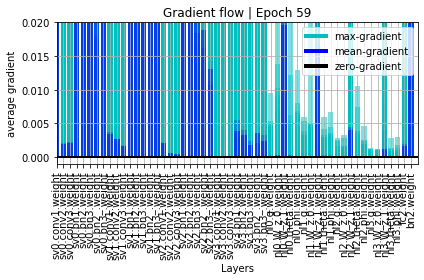

In [9]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics/nonlocal'
model_name = 'nonlocal_resnet'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
    plot_grad_flow(model.named_parameters(), epoch,
                   savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

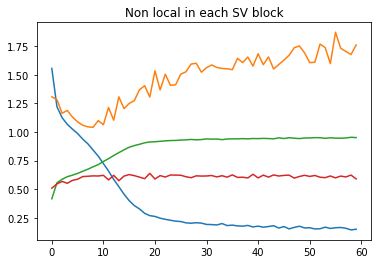

In [10]:
plt.title('Non local in each SV block')
plt.plot(hist)

In [11]:
import imageio
images = []
for i in range(60):
    images.append(imageio.imread('/tf/data/Quan/fer2013/backtobasics/nonlocal/nonlocal_resnet_gf_' + str(i) + '.png'))
imageio.mimsave('/tf/data/Quan/fer2013/backtobasics/nonlocal/nonlocal_resnet_gf.gif', images)

## Non-local 2

In [10]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics/nonlocal2/'
model_name = 'nonlocal_resnet'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(300):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
    plot_grad_flow(model.named_parameters(), epoch,
                   savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.220 acc: 0.172
	 - Step 2: loss: 2.115 acc: 0.250
	 - Step 3: loss: 2.376 acc: 0.156
	 - Step 4: loss: 2.173 acc: 0.156
	 - Step 5: loss: 2.131 acc: 0.234
	 - Step 6: loss: 2.183 acc: 0.156
	 - Step 7: loss: 1.958 acc: 0.188
	 - Step 8: loss: 2.020 acc: 0.125
	 - Step 9: loss: 1.937 acc: 0.172
	 - Step 10: loss: 1.951 acc: 0.203
	 - Step 11: loss: 1.954 acc: 0.156
	 - Step 12: loss: 1.951 acc: 0.203
	 - Step 13: loss: 1.971 acc: 0.188
	 - Step 14: loss: 1.905 acc: 0.312
	 - Step 15: loss: 1.920 acc: 0.156
	 - Step 16: loss: 1.895 acc: 0.188
	 - Step 17: loss: 1.876 acc: 0.203
	 - Step 18: loss: 1.863 acc: 0.250
	 - Step 19: loss: 1.893 acc: 0.172
	 - Step 20: loss: 1.906 acc: 0.156
	 - Step 21: loss: 1.976 acc: 0.141
	 - Step 22: loss: 1.904 acc: 0.203
	 - Step 23: loss: 1.930 acc: 0.234
	 - Step 24: loss: 1.859 acc: 0.250
	 - Step 25: loss: 1.897 acc: 0.234
	 - Step 26: loss: 1.908 acc: 0.203
	 - Step 27: loss: 1.859 acc: 0.328
	 - Step 28: loss: 1.908 ac

	 - Step 226: loss: 1.773 acc: 0.234
	 - Step 227: loss: 1.770 acc: 0.234
	 - Step 228: loss: 1.745 acc: 0.312
	 - Step 229: loss: 1.846 acc: 0.219
	 - Step 230: loss: 1.775 acc: 0.297
	 - Step 231: loss: 1.823 acc: 0.266
	 - Step 232: loss: 1.761 acc: 0.250
	 - Step 233: loss: 1.755 acc: 0.406
	 - Step 234: loss: 1.699 acc: 0.266
	 - Step 235: loss: 1.756 acc: 0.266
	 - Step 236: loss: 1.806 acc: 0.297
	 - Step 237: loss: 1.792 acc: 0.219
	 - Step 238: loss: 1.699 acc: 0.328
	 - Step 239: loss: 1.826 acc: 0.297
	 - Step 240: loss: 1.800 acc: 0.188
	 - Step 241: loss: 1.778 acc: 0.250
	 - Step 242: loss: 1.829 acc: 0.203
	 - Step 243: loss: 1.800 acc: 0.266
	 - Step 244: loss: 1.818 acc: 0.281
	 - Step 245: loss: 1.737 acc: 0.328
	 - Step 246: loss: 1.809 acc: 0.234
	 - Step 247: loss: 1.686 acc: 0.375
	 - Step 248: loss: 1.767 acc: 0.281
	 - Step 249: loss: 1.793 acc: 0.234
	 - Step 250: loss: 1.812 acc: 0.234
	 - Step 251: loss: 1.807 acc: 0.297
	 - Step 252: loss: 1.809 acc: 0.234
	

	 - Step 448: loss: 1.820 acc: 0.312
	 - Step 449: loss: 1.902 acc: 0.162
- Avg.loss: 1.819  | Avg.acc: 0.249
- Avg. val_loss: 1.805  | Avg. val_acc: 0.249
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NLBlockND. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.855 acc: 0.234
	 - Step 2: loss: 1.693 acc: 0.297
	 - Step 3: loss: 1.760 acc: 0.234
	 - Step 4: loss: 1.820 acc: 0.188
	 - Step 5: loss: 1.813 acc: 0.188
	 - Step 6: loss: 1.793 acc: 0.297
	 - Step 7: loss: 1.798 acc: 0.203
	 - Step 8: loss: 1.807 acc: 0.266
	 - Step 9: loss: 1.851 acc: 0.219
	 - Step 10: loss: 1.805 acc: 0.203
	 - Step 11: loss: 1.771 acc: 0.328
	 - Step 12: loss: 1.774 acc: 0.203
	 - Step 13: loss: 1.707 acc: 0.234
	 - Step 14: loss: 1.839 acc: 0.250
	 - Step 15: loss: 1.805 acc: 0.219
	 - Step 16: loss: 1.803 acc: 0.234
	 - Step 17: loss: 1.785 acc: 0.266
	 - Step 18: loss: 1.872 acc: 0.203
	 - Step 19: loss: 1.753 acc: 0.297
	 - Step 20: loss: 1.794 acc: 0.234
	 - Step 21: loss: 1.767 acc: 0.266
	 - Step 22: loss: 1.805 acc: 0.188
	 - Step 23: loss: 1.841 acc: 0.219
	 - Step 24: loss: 1.825 acc: 0.203
	 - Step 25: loss: 1.946 acc: 0.172
	 - Step 26: loss: 1.745 acc: 0.281
	 - Step 27: loss: 1.786 acc: 0.281
	 - Step 28: loss: 1.708 acc: 0.344
	

	 - Step 226: loss: 1.708 acc: 0.344
	 - Step 227: loss: 1.681 acc: 0.250
	 - Step 228: loss: 1.686 acc: 0.250
	 - Step 229: loss: 1.733 acc: 0.266
	 - Step 230: loss: 1.645 acc: 0.344
	 - Step 231: loss: 1.782 acc: 0.328
	 - Step 232: loss: 1.835 acc: 0.266
	 - Step 233: loss: 1.769 acc: 0.297
	 - Step 234: loss: 1.779 acc: 0.156
	 - Step 235: loss: 1.828 acc: 0.266
	 - Step 236: loss: 1.769 acc: 0.344
	 - Step 237: loss: 1.783 acc: 0.188
	 - Step 238: loss: 1.778 acc: 0.219
	 - Step 239: loss: 1.775 acc: 0.219
	 - Step 240: loss: 1.782 acc: 0.125
	 - Step 241: loss: 1.732 acc: 0.359
	 - Step 242: loss: 1.814 acc: 0.250
	 - Step 243: loss: 1.783 acc: 0.328
	 - Step 244: loss: 1.841 acc: 0.203
	 - Step 245: loss: 1.785 acc: 0.266
	 - Step 246: loss: 1.756 acc: 0.281
	 - Step 247: loss: 1.804 acc: 0.266
	 - Step 248: loss: 1.816 acc: 0.234
	 - Step 249: loss: 1.751 acc: 0.250
	 - Step 250: loss: 1.779 acc: 0.281
	 - Step 251: loss: 1.762 acc: 0.281
	 - Step 252: loss: 1.738 acc: 0.266
	

	 - Step 448: loss: 1.726 acc: 0.203
	 - Step 449: loss: 1.683 acc: 0.189
- Avg.loss: 1.749  | Avg.acc: 0.274
- Avg. val_loss: 1.726  | Avg. val_acc: 0.291
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.772 acc: 0.234
	 - Step 2: loss: 1.679 acc: 0.344
	 - Step 3: loss: 1.670 acc: 0.250
	 - Step 4: loss: 1.682 acc: 0.359
	 - Step 5: loss: 1.757 acc: 0.281
	 - Step 6: loss: 1.761 acc: 0.328
	 - Step 7: loss: 1.736 acc: 0.281
	 - Step 8: loss: 1.772 acc: 0.266
	 - Step 9: loss: 1.682 acc: 0.281
	 - Step 10: loss: 1.607 acc: 0.359
	 - Step 11: loss: 1.707 acc: 0.266
	 - Step 12: loss: 1.773 acc: 0.219
	 - Step 13: loss: 1.792 acc: 0.234
	 - Step 14: loss: 1.665 acc: 0.359
	 - Step 15: loss: 1.834 acc: 0.266
	 - Step 16: loss: 1.670 acc: 0.312
	 - Step 17: loss: 1.749 acc: 0.250
	 - Step 18: loss: 1.610 acc: 0.422
	 - Step 19: loss: 1.592 acc: 0.344
	 - Step 20: loss: 1.723 acc: 0.250
	 - Step 21: loss: 1.672 acc: 0.344
	 - Step 22: loss: 1.718 acc: 0.281
	 - Step 23: loss: 1.615 acc

	 - Step 223: loss: 1.606 acc: 0.328
	 - Step 224: loss: 1.572 acc: 0.312
	 - Step 225: loss: 1.885 acc: 0.188
	 - Step 226: loss: 1.609 acc: 0.344
	 - Step 227: loss: 1.670 acc: 0.328
	 - Step 228: loss: 1.882 acc: 0.203
	 - Step 229: loss: 1.607 acc: 0.312
	 - Step 230: loss: 1.618 acc: 0.344
	 - Step 231: loss: 1.787 acc: 0.297
	 - Step 232: loss: 1.691 acc: 0.328
	 - Step 233: loss: 1.708 acc: 0.359
	 - Step 234: loss: 1.838 acc: 0.219
	 - Step 235: loss: 1.664 acc: 0.328
	 - Step 236: loss: 1.630 acc: 0.250
	 - Step 237: loss: 1.721 acc: 0.312
	 - Step 238: loss: 1.805 acc: 0.219
	 - Step 239: loss: 1.740 acc: 0.312
	 - Step 240: loss: 1.643 acc: 0.375
	 - Step 241: loss: 1.651 acc: 0.312
	 - Step 242: loss: 1.660 acc: 0.344
	 - Step 243: loss: 1.635 acc: 0.328
	 - Step 244: loss: 1.719 acc: 0.234
	 - Step 245: loss: 1.647 acc: 0.344
	 - Step 246: loss: 1.649 acc: 0.422
	 - Step 247: loss: 1.597 acc: 0.312
	 - Step 248: loss: 1.585 acc: 0.359
	 - Step 249: loss: 1.638 acc: 0.344
	

	 - Step 445: loss: 1.635 acc: 0.297
	 - Step 446: loss: 1.816 acc: 0.266
	 - Step 447: loss: 1.604 acc: 0.406
	 - Step 448: loss: 1.638 acc: 0.344
	 - Step 449: loss: 1.699 acc: 0.297
- Avg.loss: 1.691  | Avg.acc: 0.310
- Avg. val_loss: 1.733  | Avg. val_acc: 0.326
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.657 acc: 0.359
	 - Step 2: loss: 1.695 acc: 0.328
	 - Step 3: loss: 1.595 acc: 0.328
	 - Step 4: loss: 1.708 acc: 0.312
	 - Step 5: loss: 1.647 acc: 0.281
	 - Step 6: loss: 1.760 acc: 0.234
	 - Step 7: loss: 1.837 acc: 0.203
	 - Step 8: loss: 1.754 acc: 0.234
	 - Step 9: loss: 1.542 acc: 0.438
	 - Step 10: loss: 1.734 acc: 0.328
	 - Step 11: loss: 1.755 acc: 0.250
	 - Step 12: loss: 1.784 acc: 0.312
	 - Step 13: loss: 1.680 acc: 0.250
	 - Step 14: loss: 1.820 acc: 0.312
	 - Step 15: loss: 1.741 acc: 0.297
	 - Step 16: loss: 1.730 acc: 0.297
	 - Step 17: loss: 1.673 acc: 0.359
	 - Step 18: loss: 1.756 acc: 0.266
	 - Step 19: loss: 1.719 acc: 0.312
	 - Step 20: loss: 1.646 

	 - Step 220: loss: 1.712 acc: 0.375
	 - Step 221: loss: 1.720 acc: 0.234
	 - Step 222: loss: 1.592 acc: 0.344
	 - Step 223: loss: 1.627 acc: 0.297
	 - Step 224: loss: 1.761 acc: 0.250
	 - Step 225: loss: 1.672 acc: 0.344
	 - Step 226: loss: 1.768 acc: 0.281
	 - Step 227: loss: 1.627 acc: 0.375
	 - Step 228: loss: 1.539 acc: 0.328
	 - Step 229: loss: 1.707 acc: 0.359
	 - Step 230: loss: 1.623 acc: 0.297
	 - Step 231: loss: 1.622 acc: 0.344
	 - Step 232: loss: 1.673 acc: 0.391
	 - Step 233: loss: 1.808 acc: 0.328
	 - Step 234: loss: 1.742 acc: 0.266
	 - Step 235: loss: 1.774 acc: 0.234
	 - Step 236: loss: 1.649 acc: 0.328
	 - Step 237: loss: 1.670 acc: 0.406
	 - Step 238: loss: 1.529 acc: 0.484
	 - Step 239: loss: 1.694 acc: 0.219
	 - Step 240: loss: 1.701 acc: 0.328
	 - Step 241: loss: 1.670 acc: 0.250
	 - Step 242: loss: 1.478 acc: 0.391
	 - Step 243: loss: 1.596 acc: 0.422
	 - Step 244: loss: 1.579 acc: 0.438
	 - Step 245: loss: 1.636 acc: 0.266
	 - Step 246: loss: 1.569 acc: 0.359
	

	 - Step 442: loss: 1.552 acc: 0.359
	 - Step 443: loss: 1.729 acc: 0.281
	 - Step 444: loss: 1.523 acc: 0.391
	 - Step 445: loss: 1.582 acc: 0.344
	 - Step 446: loss: 1.594 acc: 0.406
	 - Step 447: loss: 1.710 acc: 0.297
	 - Step 448: loss: 1.516 acc: 0.375
	 - Step 449: loss: 1.620 acc: 0.297
- Avg.loss: 1.644  | Avg.acc: 0.346
- Avg. val_loss: 1.681  | Avg. val_acc: 0.341
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.657 acc: 0.375
	 - Step 2: loss: 1.698 acc: 0.266
	 - Step 3: loss: 1.651 acc: 0.250
	 - Step 4: loss: 1.549 acc: 0.391
	 - Step 5: loss: 1.602 acc: 0.328
	 - Step 6: loss: 1.524 acc: 0.453
	 - Step 7: loss: 1.564 acc: 0.406
	 - Step 8: loss: 1.615 acc: 0.438
	 - Step 9: loss: 1.512 acc: 0.391
	 - Step 10: loss: 1.557 acc: 0.391
	 - Step 11: loss: 1.614 acc: 0.406
	 - Step 12: loss: 1.620 acc: 0.422
	 - Step 13: loss: 1.497 acc: 0.406
	 - Step 14: loss: 1.798 acc: 0.281
	 - Step 15: loss: 1.554 acc: 0.422
	 - Step 16: loss: 1.543 acc: 0.422
	 - Step 17: loss: 1.7

	 - Step 217: loss: 1.691 acc: 0.344
	 - Step 218: loss: 1.865 acc: 0.297
	 - Step 219: loss: 1.478 acc: 0.406
	 - Step 220: loss: 1.729 acc: 0.312
	 - Step 221: loss: 1.687 acc: 0.312
	 - Step 222: loss: 1.838 acc: 0.297
	 - Step 223: loss: 1.544 acc: 0.359
	 - Step 224: loss: 1.694 acc: 0.344
	 - Step 225: loss: 1.625 acc: 0.359
	 - Step 226: loss: 1.470 acc: 0.422
	 - Step 227: loss: 1.605 acc: 0.375
	 - Step 228: loss: 1.616 acc: 0.391
	 - Step 229: loss: 1.562 acc: 0.344
	 - Step 230: loss: 1.499 acc: 0.422
	 - Step 231: loss: 1.487 acc: 0.391
	 - Step 232: loss: 1.632 acc: 0.391
	 - Step 233: loss: 1.707 acc: 0.328
	 - Step 234: loss: 1.680 acc: 0.312
	 - Step 235: loss: 1.679 acc: 0.328
	 - Step 236: loss: 1.544 acc: 0.359
	 - Step 237: loss: 1.465 acc: 0.422
	 - Step 238: loss: 1.668 acc: 0.281
	 - Step 239: loss: 1.526 acc: 0.438
	 - Step 240: loss: 1.624 acc: 0.406
	 - Step 241: loss: 1.556 acc: 0.375
	 - Step 242: loss: 1.450 acc: 0.438
	 - Step 243: loss: 1.410 acc: 0.453
	

	 - Step 439: loss: 1.753 acc: 0.297
	 - Step 440: loss: 1.626 acc: 0.328
	 - Step 441: loss: 1.528 acc: 0.438
	 - Step 442: loss: 1.675 acc: 0.438
	 - Step 443: loss: 1.538 acc: 0.453
	 - Step 444: loss: 1.568 acc: 0.312
	 - Step 445: loss: 1.740 acc: 0.266
	 - Step 446: loss: 1.473 acc: 0.391
	 - Step 447: loss: 1.653 acc: 0.500
	 - Step 448: loss: 1.541 acc: 0.422
	 - Step 449: loss: 1.684 acc: 0.378
- Avg.loss: 1.599  | Avg.acc: 0.370
- Avg. val_loss: 1.589  | Avg. val_acc: 0.374
* Update optimal model
Epoch:  6
	 - Step 1: loss: 1.601 acc: 0.359
	 - Step 2: loss: 1.735 acc: 0.391
	 - Step 3: loss: 1.652 acc: 0.297
	 - Step 4: loss: 1.516 acc: 0.375
	 - Step 5: loss: 1.478 acc: 0.453
	 - Step 6: loss: 1.781 acc: 0.344
	 - Step 7: loss: 1.715 acc: 0.328
	 - Step 8: loss: 1.464 acc: 0.422
	 - Step 9: loss: 1.593 acc: 0.281
	 - Step 10: loss: 1.607 acc: 0.312
	 - Step 11: loss: 1.548 acc: 0.438
	 - Step 12: loss: 1.514 acc: 0.406
	 - Step 13: loss: 1.595 acc: 0.312
	 - Step 14: loss: 

	 - Step 214: loss: 1.498 acc: 0.391
	 - Step 215: loss: 1.698 acc: 0.359
	 - Step 216: loss: 1.554 acc: 0.359
	 - Step 217: loss: 1.494 acc: 0.359
	 - Step 218: loss: 1.349 acc: 0.500
	 - Step 219: loss: 1.559 acc: 0.328
	 - Step 220: loss: 1.459 acc: 0.344
	 - Step 221: loss: 1.490 acc: 0.422
	 - Step 222: loss: 1.729 acc: 0.297
	 - Step 223: loss: 1.582 acc: 0.406
	 - Step 224: loss: 1.603 acc: 0.438
	 - Step 225: loss: 1.398 acc: 0.375
	 - Step 226: loss: 1.599 acc: 0.422
	 - Step 227: loss: 1.577 acc: 0.359
	 - Step 228: loss: 1.685 acc: 0.391
	 - Step 229: loss: 1.778 acc: 0.328
	 - Step 230: loss: 1.723 acc: 0.328
	 - Step 231: loss: 1.782 acc: 0.266
	 - Step 232: loss: 1.783 acc: 0.219
	 - Step 233: loss: 1.533 acc: 0.453
	 - Step 234: loss: 1.503 acc: 0.391
	 - Step 235: loss: 1.548 acc: 0.391
	 - Step 236: loss: 1.758 acc: 0.312
	 - Step 237: loss: 1.570 acc: 0.375
	 - Step 238: loss: 1.764 acc: 0.312
	 - Step 239: loss: 1.490 acc: 0.453
	 - Step 240: loss: 1.423 acc: 0.438
	

	 - Step 436: loss: 1.453 acc: 0.406
	 - Step 437: loss: 1.383 acc: 0.531
	 - Step 438: loss: 1.587 acc: 0.375
	 - Step 439: loss: 1.567 acc: 0.406
	 - Step 440: loss: 1.821 acc: 0.266
	 - Step 441: loss: 1.498 acc: 0.406
	 - Step 442: loss: 1.524 acc: 0.438
	 - Step 443: loss: 1.623 acc: 0.406
	 - Step 444: loss: 1.417 acc: 0.453
	 - Step 445: loss: 1.733 acc: 0.344
	 - Step 446: loss: 1.586 acc: 0.312
	 - Step 447: loss: 1.590 acc: 0.438
	 - Step 448: loss: 1.449 acc: 0.438
	 - Step 449: loss: 1.477 acc: 0.432
- Avg.loss: 1.550  | Avg.acc: 0.393
- Avg. val_loss: 1.816  | Avg. val_acc: 0.289
Epoch:  7
	 - Step 1: loss: 1.598 acc: 0.344
	 - Step 2: loss: 1.580 acc: 0.359
	 - Step 3: loss: 1.583 acc: 0.375
	 - Step 4: loss: 1.655 acc: 0.391
	 - Step 5: loss: 1.469 acc: 0.375
	 - Step 6: loss: 1.631 acc: 0.375
	 - Step 7: loss: 1.517 acc: 0.359
	 - Step 8: loss: 1.411 acc: 0.453
	 - Step 9: loss: 1.438 acc: 0.469
	 - Step 10: loss: 1.429 acc: 0.484
	 - Step 11: loss: 1.330 acc: 0.578
	 -

	 - Step 211: loss: 1.427 acc: 0.438
	 - Step 212: loss: 1.506 acc: 0.469
	 - Step 213: loss: 1.727 acc: 0.344
	 - Step 214: loss: 1.578 acc: 0.344
	 - Step 215: loss: 1.577 acc: 0.344
	 - Step 216: loss: 1.405 acc: 0.484
	 - Step 217: loss: 1.459 acc: 0.406
	 - Step 218: loss: 1.684 acc: 0.359
	 - Step 219: loss: 1.593 acc: 0.375
	 - Step 220: loss: 1.542 acc: 0.391
	 - Step 221: loss: 1.620 acc: 0.344
	 - Step 222: loss: 1.330 acc: 0.594
	 - Step 223: loss: 1.489 acc: 0.328
	 - Step 224: loss: 1.458 acc: 0.406
	 - Step 225: loss: 1.330 acc: 0.516
	 - Step 226: loss: 1.526 acc: 0.344
	 - Step 227: loss: 1.528 acc: 0.391
	 - Step 228: loss: 1.546 acc: 0.375
	 - Step 229: loss: 1.493 acc: 0.391
	 - Step 230: loss: 1.731 acc: 0.359
	 - Step 231: loss: 1.405 acc: 0.516
	 - Step 232: loss: 1.486 acc: 0.453
	 - Step 233: loss: 1.625 acc: 0.406
	 - Step 234: loss: 1.427 acc: 0.422
	 - Step 235: loss: 1.308 acc: 0.484
	 - Step 236: loss: 1.557 acc: 0.375
	 - Step 237: loss: 1.405 acc: 0.516
	

	 - Step 433: loss: 1.468 acc: 0.453
	 - Step 434: loss: 1.447 acc: 0.438
	 - Step 435: loss: 1.421 acc: 0.469
	 - Step 436: loss: 1.640 acc: 0.406
	 - Step 437: loss: 1.394 acc: 0.453
	 - Step 438: loss: 1.473 acc: 0.406
	 - Step 439: loss: 1.588 acc: 0.312
	 - Step 440: loss: 1.455 acc: 0.391
	 - Step 441: loss: 1.394 acc: 0.500
	 - Step 442: loss: 1.590 acc: 0.328
	 - Step 443: loss: 1.462 acc: 0.391
	 - Step 444: loss: 1.398 acc: 0.438
	 - Step 445: loss: 1.331 acc: 0.531
	 - Step 446: loss: 1.650 acc: 0.328
	 - Step 447: loss: 1.555 acc: 0.375
	 - Step 448: loss: 1.380 acc: 0.547
	 - Step 449: loss: 1.676 acc: 0.378
- Avg.loss: 1.523  | Avg.acc: 0.405
- Avg. val_loss: 1.579  | Avg. val_acc: 0.374
* Update optimal model
Epoch:  8
	 - Step 1: loss: 1.424 acc: 0.531
	 - Step 2: loss: 1.637 acc: 0.406
	 - Step 3: loss: 1.509 acc: 0.422
	 - Step 4: loss: 1.532 acc: 0.516
	 - Step 5: loss: 1.331 acc: 0.484
	 - Step 6: loss: 1.400 acc: 0.391
	 - Step 7: loss: 1.435 acc: 0.500
	 - Step 8:

	 - Step 206: loss: 1.474 acc: 0.438
	 - Step 207: loss: 1.532 acc: 0.422
	 - Step 208: loss: 1.543 acc: 0.375
	 - Step 209: loss: 1.467 acc: 0.438
	 - Step 210: loss: 1.492 acc: 0.500
	 - Step 211: loss: 1.373 acc: 0.516
	 - Step 212: loss: 1.580 acc: 0.391
	 - Step 213: loss: 1.316 acc: 0.500
	 - Step 214: loss: 1.565 acc: 0.359
	 - Step 215: loss: 1.496 acc: 0.375
	 - Step 216: loss: 1.456 acc: 0.453
	 - Step 217: loss: 1.508 acc: 0.438
	 - Step 218: loss: 1.577 acc: 0.469
	 - Step 219: loss: 1.613 acc: 0.359
	 - Step 220: loss: 1.430 acc: 0.469
	 - Step 221: loss: 1.483 acc: 0.375
	 - Step 222: loss: 1.540 acc: 0.406
	 - Step 223: loss: 1.331 acc: 0.547
	 - Step 224: loss: 1.457 acc: 0.391
	 - Step 225: loss: 1.593 acc: 0.375
	 - Step 226: loss: 1.469 acc: 0.484
	 - Step 227: loss: 1.500 acc: 0.422
	 - Step 228: loss: 1.503 acc: 0.344
	 - Step 229: loss: 1.444 acc: 0.438
	 - Step 230: loss: 1.452 acc: 0.438
	 - Step 231: loss: 1.481 acc: 0.453
	 - Step 232: loss: 1.428 acc: 0.469
	

	 - Step 428: loss: 1.328 acc: 0.516
	 - Step 429: loss: 1.406 acc: 0.484
	 - Step 430: loss: 1.508 acc: 0.281
	 - Step 431: loss: 1.695 acc: 0.375
	 - Step 432: loss: 1.559 acc: 0.375
	 - Step 433: loss: 1.564 acc: 0.453
	 - Step 434: loss: 1.631 acc: 0.344
	 - Step 435: loss: 1.498 acc: 0.438
	 - Step 436: loss: 1.525 acc: 0.422
	 - Step 437: loss: 1.423 acc: 0.453
	 - Step 438: loss: 1.605 acc: 0.391
	 - Step 439: loss: 1.553 acc: 0.375
	 - Step 440: loss: 1.584 acc: 0.344
	 - Step 441: loss: 1.532 acc: 0.344
	 - Step 442: loss: 1.563 acc: 0.469
	 - Step 443: loss: 1.515 acc: 0.484
	 - Step 444: loss: 1.681 acc: 0.422
	 - Step 445: loss: 1.491 acc: 0.406
	 - Step 446: loss: 1.572 acc: 0.422
	 - Step 447: loss: 1.547 acc: 0.344
	 - Step 448: loss: 1.582 acc: 0.422
	 - Step 449: loss: 1.559 acc: 0.405
- Avg.loss: 1.494  | Avg.acc: 0.422
- Avg. val_loss: 1.521  | Avg. val_acc: 0.418
* Update optimal model
Epoch:  9
	 - Step 1: loss: 1.599 acc: 0.422
	 - Step 2: loss: 1.553 acc: 0.375
	

	 - Step 201: loss: 1.422 acc: 0.438
	 - Step 202: loss: 1.454 acc: 0.438
	 - Step 203: loss: 1.460 acc: 0.484
	 - Step 204: loss: 1.439 acc: 0.484
	 - Step 205: loss: 1.377 acc: 0.484
	 - Step 206: loss: 1.378 acc: 0.484
	 - Step 207: loss: 1.468 acc: 0.469
	 - Step 208: loss: 1.589 acc: 0.312
	 - Step 209: loss: 1.490 acc: 0.438
	 - Step 210: loss: 1.495 acc: 0.453
	 - Step 211: loss: 1.351 acc: 0.484
	 - Step 212: loss: 1.577 acc: 0.391
	 - Step 213: loss: 1.623 acc: 0.312
	 - Step 214: loss: 1.356 acc: 0.516
	 - Step 215: loss: 1.464 acc: 0.375
	 - Step 216: loss: 1.687 acc: 0.375
	 - Step 217: loss: 1.451 acc: 0.453
	 - Step 218: loss: 1.392 acc: 0.469
	 - Step 219: loss: 1.350 acc: 0.453
	 - Step 220: loss: 1.467 acc: 0.438
	 - Step 221: loss: 1.556 acc: 0.359
	 - Step 222: loss: 1.439 acc: 0.453
	 - Step 223: loss: 1.630 acc: 0.328
	 - Step 224: loss: 1.573 acc: 0.438
	 - Step 225: loss: 1.622 acc: 0.344
	 - Step 226: loss: 1.693 acc: 0.297
	 - Step 227: loss: 1.486 acc: 0.453
	

	 - Step 424: loss: 1.341 acc: 0.438
	 - Step 425: loss: 1.556 acc: 0.344
	 - Step 426: loss: 1.418 acc: 0.453
	 - Step 427: loss: 1.734 acc: 0.344
	 - Step 428: loss: 1.464 acc: 0.453
	 - Step 429: loss: 1.392 acc: 0.469
	 - Step 430: loss: 1.455 acc: 0.406
	 - Step 431: loss: 1.258 acc: 0.484
	 - Step 432: loss: 1.432 acc: 0.375
	 - Step 433: loss: 1.448 acc: 0.484
	 - Step 434: loss: 1.490 acc: 0.406
	 - Step 435: loss: 1.548 acc: 0.469
	 - Step 436: loss: 1.477 acc: 0.422
	 - Step 437: loss: 1.493 acc: 0.406
	 - Step 438: loss: 1.435 acc: 0.406
	 - Step 439: loss: 1.333 acc: 0.484
	 - Step 440: loss: 1.499 acc: 0.422
	 - Step 441: loss: 1.641 acc: 0.312
	 - Step 442: loss: 1.324 acc: 0.453
	 - Step 443: loss: 1.527 acc: 0.422
	 - Step 444: loss: 1.504 acc: 0.344
	 - Step 445: loss: 1.683 acc: 0.391
	 - Step 446: loss: 1.526 acc: 0.406
	 - Step 447: loss: 1.364 acc: 0.484
	 - Step 448: loss: 1.316 acc: 0.500
	 - Step 449: loss: 1.474 acc: 0.405
- Avg.loss: 1.485  | Avg.acc: 0.424
- 

	 - Step 197: loss: 1.646 acc: 0.344
	 - Step 198: loss: 1.556 acc: 0.422
	 - Step 199: loss: 1.540 acc: 0.312
	 - Step 200: loss: 1.519 acc: 0.406
	 - Step 201: loss: 1.472 acc: 0.422
	 - Step 202: loss: 1.505 acc: 0.344
	 - Step 203: loss: 1.515 acc: 0.438
	 - Step 204: loss: 1.653 acc: 0.328
	 - Step 205: loss: 1.516 acc: 0.484
	 - Step 206: loss: 1.322 acc: 0.453
	 - Step 207: loss: 1.612 acc: 0.328
	 - Step 208: loss: 1.355 acc: 0.531
	 - Step 209: loss: 1.309 acc: 0.594
	 - Step 210: loss: 1.446 acc: 0.406
	 - Step 211: loss: 1.465 acc: 0.359
	 - Step 212: loss: 1.522 acc: 0.359
	 - Step 213: loss: 1.372 acc: 0.422
	 - Step 214: loss: 1.364 acc: 0.469
	 - Step 215: loss: 1.567 acc: 0.422
	 - Step 216: loss: 1.685 acc: 0.375
	 - Step 217: loss: 1.487 acc: 0.391
	 - Step 218: loss: 1.470 acc: 0.438
	 - Step 219: loss: 1.366 acc: 0.438
	 - Step 220: loss: 1.357 acc: 0.484
	 - Step 221: loss: 1.648 acc: 0.312
	 - Step 222: loss: 1.628 acc: 0.375
	 - Step 223: loss: 1.456 acc: 0.422
	

	 - Step 420: loss: 1.708 acc: 0.312
	 - Step 421: loss: 1.555 acc: 0.469
	 - Step 422: loss: 1.495 acc: 0.453
	 - Step 423: loss: 1.369 acc: 0.438
	 - Step 424: loss: 1.421 acc: 0.453
	 - Step 425: loss: 1.508 acc: 0.391
	 - Step 426: loss: 1.515 acc: 0.469
	 - Step 427: loss: 1.517 acc: 0.391
	 - Step 428: loss: 1.444 acc: 0.422
	 - Step 429: loss: 1.485 acc: 0.406
	 - Step 430: loss: 1.395 acc: 0.516
	 - Step 431: loss: 1.399 acc: 0.422
	 - Step 432: loss: 1.393 acc: 0.469
	 - Step 433: loss: 1.499 acc: 0.422
	 - Step 434: loss: 1.412 acc: 0.516
	 - Step 435: loss: 1.364 acc: 0.438
	 - Step 436: loss: 1.543 acc: 0.375
	 - Step 437: loss: 1.319 acc: 0.578
	 - Step 438: loss: 1.391 acc: 0.375
	 - Step 439: loss: 1.370 acc: 0.453
	 - Step 440: loss: 1.442 acc: 0.391
	 - Step 441: loss: 1.392 acc: 0.453
	 - Step 442: loss: 1.409 acc: 0.453
	 - Step 443: loss: 1.241 acc: 0.578
	 - Step 444: loss: 1.425 acc: 0.469
	 - Step 445: loss: 1.542 acc: 0.438
	 - Step 446: loss: 1.388 acc: 0.438
	

	 - Step 193: loss: 1.425 acc: 0.422
	 - Step 194: loss: 1.519 acc: 0.375
	 - Step 195: loss: 1.409 acc: 0.516
	 - Step 196: loss: 1.414 acc: 0.438
	 - Step 197: loss: 1.676 acc: 0.422
	 - Step 198: loss: 1.499 acc: 0.453
	 - Step 199: loss: 1.398 acc: 0.438
	 - Step 200: loss: 1.393 acc: 0.438
	 - Step 201: loss: 1.452 acc: 0.406
	 - Step 202: loss: 1.560 acc: 0.359
	 - Step 203: loss: 1.513 acc: 0.406
	 - Step 204: loss: 1.264 acc: 0.609
	 - Step 205: loss: 1.331 acc: 0.469
	 - Step 206: loss: 1.611 acc: 0.391
	 - Step 207: loss: 1.508 acc: 0.438
	 - Step 208: loss: 1.519 acc: 0.453
	 - Step 209: loss: 1.493 acc: 0.438
	 - Step 210: loss: 1.560 acc: 0.453
	 - Step 211: loss: 1.461 acc: 0.406
	 - Step 212: loss: 1.426 acc: 0.375
	 - Step 213: loss: 1.571 acc: 0.516
	 - Step 214: loss: 1.487 acc: 0.375
	 - Step 215: loss: 1.486 acc: 0.344
	 - Step 216: loss: 1.399 acc: 0.375
	 - Step 217: loss: 1.581 acc: 0.375
	 - Step 218: loss: 1.559 acc: 0.359
	 - Step 219: loss: 1.520 acc: 0.469
	

	 - Step 415: loss: 1.459 acc: 0.422
	 - Step 416: loss: 1.363 acc: 0.469
	 - Step 417: loss: 1.620 acc: 0.297
	 - Step 418: loss: 1.530 acc: 0.359
	 - Step 419: loss: 1.374 acc: 0.578
	 - Step 420: loss: 1.408 acc: 0.469
	 - Step 421: loss: 1.670 acc: 0.328
	 - Step 422: loss: 1.725 acc: 0.359
	 - Step 423: loss: 1.685 acc: 0.375
	 - Step 424: loss: 1.389 acc: 0.438
	 - Step 425: loss: 1.477 acc: 0.406
	 - Step 426: loss: 1.685 acc: 0.359
	 - Step 427: loss: 1.513 acc: 0.500
	 - Step 428: loss: 1.522 acc: 0.391
	 - Step 429: loss: 1.453 acc: 0.500
	 - Step 430: loss: 1.536 acc: 0.359
	 - Step 431: loss: 1.364 acc: 0.500
	 - Step 432: loss: 1.371 acc: 0.500
	 - Step 433: loss: 1.290 acc: 0.484
	 - Step 434: loss: 1.479 acc: 0.438
	 - Step 435: loss: 1.413 acc: 0.406
	 - Step 436: loss: 1.465 acc: 0.391
	 - Step 437: loss: 1.522 acc: 0.453
	 - Step 438: loss: 1.411 acc: 0.484
	 - Step 439: loss: 1.411 acc: 0.422
	 - Step 440: loss: 1.597 acc: 0.406
	 - Step 441: loss: 1.459 acc: 0.453
	

	 - Step 190: loss: 1.539 acc: 0.422
	 - Step 191: loss: 1.696 acc: 0.375
	 - Step 192: loss: 1.520 acc: 0.422
	 - Step 193: loss: 1.558 acc: 0.406
	 - Step 194: loss: 1.480 acc: 0.406
	 - Step 195: loss: 1.585 acc: 0.438
	 - Step 196: loss: 1.547 acc: 0.391
	 - Step 197: loss: 1.646 acc: 0.375
	 - Step 198: loss: 1.370 acc: 0.453
	 - Step 199: loss: 1.484 acc: 0.406
	 - Step 200: loss: 1.673 acc: 0.375
	 - Step 201: loss: 1.379 acc: 0.453
	 - Step 202: loss: 1.323 acc: 0.516
	 - Step 203: loss: 1.454 acc: 0.500
	 - Step 204: loss: 1.515 acc: 0.453
	 - Step 205: loss: 1.343 acc: 0.422
	 - Step 206: loss: 1.629 acc: 0.328
	 - Step 207: loss: 1.327 acc: 0.469
	 - Step 208: loss: 1.407 acc: 0.453
	 - Step 209: loss: 1.493 acc: 0.391
	 - Step 210: loss: 1.400 acc: 0.406
	 - Step 211: loss: 1.462 acc: 0.406
	 - Step 212: loss: 1.432 acc: 0.422
	 - Step 213: loss: 1.338 acc: 0.453
	 - Step 214: loss: 1.557 acc: 0.375
	 - Step 215: loss: 1.380 acc: 0.469
	 - Step 216: loss: 1.483 acc: 0.406
	

	 - Step 412: loss: 1.344 acc: 0.422
	 - Step 413: loss: 1.433 acc: 0.391
	 - Step 414: loss: 1.408 acc: 0.391
	 - Step 415: loss: 1.496 acc: 0.438
	 - Step 416: loss: 1.379 acc: 0.438
	 - Step 417: loss: 1.342 acc: 0.453
	 - Step 418: loss: 1.641 acc: 0.328
	 - Step 419: loss: 1.530 acc: 0.406
	 - Step 420: loss: 1.358 acc: 0.375
	 - Step 421: loss: 1.379 acc: 0.469
	 - Step 422: loss: 1.448 acc: 0.469
	 - Step 423: loss: 1.477 acc: 0.469
	 - Step 424: loss: 1.448 acc: 0.438
	 - Step 425: loss: 1.319 acc: 0.531
	 - Step 426: loss: 1.543 acc: 0.344
	 - Step 427: loss: 1.523 acc: 0.344
	 - Step 428: loss: 1.511 acc: 0.375
	 - Step 429: loss: 1.555 acc: 0.406
	 - Step 430: loss: 1.534 acc: 0.422
	 - Step 431: loss: 1.433 acc: 0.438
	 - Step 432: loss: 1.324 acc: 0.516
	 - Step 433: loss: 1.442 acc: 0.422
	 - Step 434: loss: 1.674 acc: 0.312
	 - Step 435: loss: 1.448 acc: 0.406
	 - Step 436: loss: 1.580 acc: 0.375
	 - Step 437: loss: 1.420 acc: 0.438
	 - Step 438: loss: 1.496 acc: 0.359
	

	 - Step 187: loss: 1.515 acc: 0.391
	 - Step 188: loss: 1.474 acc: 0.438
	 - Step 189: loss: 1.360 acc: 0.469
	 - Step 190: loss: 1.400 acc: 0.375
	 - Step 191: loss: 1.425 acc: 0.484
	 - Step 192: loss: 1.581 acc: 0.344
	 - Step 193: loss: 1.296 acc: 0.500
	 - Step 194: loss: 1.393 acc: 0.469
	 - Step 195: loss: 1.766 acc: 0.391
	 - Step 196: loss: 1.520 acc: 0.391
	 - Step 197: loss: 1.354 acc: 0.484
	 - Step 198: loss: 1.294 acc: 0.453
	 - Step 199: loss: 1.654 acc: 0.359
	 - Step 200: loss: 1.583 acc: 0.469
	 - Step 201: loss: 1.421 acc: 0.438
	 - Step 202: loss: 1.406 acc: 0.453
	 - Step 203: loss: 1.340 acc: 0.469
	 - Step 204: loss: 1.267 acc: 0.594
	 - Step 205: loss: 1.443 acc: 0.438
	 - Step 206: loss: 1.530 acc: 0.516
	 - Step 207: loss: 1.378 acc: 0.422
	 - Step 208: loss: 1.312 acc: 0.422
	 - Step 209: loss: 1.419 acc: 0.453
	 - Step 210: loss: 1.532 acc: 0.453
	 - Step 211: loss: 1.331 acc: 0.469
	 - Step 212: loss: 1.593 acc: 0.359
	 - Step 213: loss: 1.319 acc: 0.500
	

	 - Step 409: loss: 1.436 acc: 0.469
	 - Step 410: loss: 1.338 acc: 0.453
	 - Step 411: loss: 1.359 acc: 0.438
	 - Step 412: loss: 1.309 acc: 0.453
	 - Step 413: loss: 1.449 acc: 0.406
	 - Step 414: loss: 1.310 acc: 0.531
	 - Step 415: loss: 1.558 acc: 0.391
	 - Step 416: loss: 1.507 acc: 0.406
	 - Step 417: loss: 1.442 acc: 0.375
	 - Step 418: loss: 1.310 acc: 0.531
	 - Step 419: loss: 1.461 acc: 0.406
	 - Step 420: loss: 1.449 acc: 0.453
	 - Step 421: loss: 1.568 acc: 0.391
	 - Step 422: loss: 1.627 acc: 0.375
	 - Step 423: loss: 1.415 acc: 0.453
	 - Step 424: loss: 1.577 acc: 0.391
	 - Step 425: loss: 1.378 acc: 0.469
	 - Step 426: loss: 1.511 acc: 0.359
	 - Step 427: loss: 1.492 acc: 0.406
	 - Step 428: loss: 1.270 acc: 0.484
	 - Step 429: loss: 1.520 acc: 0.359
	 - Step 430: loss: 1.225 acc: 0.516
	 - Step 431: loss: 1.492 acc: 0.391
	 - Step 432: loss: 1.442 acc: 0.453
	 - Step 433: loss: 1.455 acc: 0.453
	 - Step 434: loss: 1.527 acc: 0.406
	 - Step 435: loss: 1.479 acc: 0.406
	

	 - Step 184: loss: 1.633 acc: 0.406
	 - Step 185: loss: 1.366 acc: 0.484
	 - Step 186: loss: 1.386 acc: 0.484
	 - Step 187: loss: 1.337 acc: 0.516
	 - Step 188: loss: 1.300 acc: 0.469
	 - Step 189: loss: 1.328 acc: 0.547
	 - Step 190: loss: 1.534 acc: 0.344
	 - Step 191: loss: 1.290 acc: 0.516
	 - Step 192: loss: 1.399 acc: 0.531
	 - Step 193: loss: 1.497 acc: 0.422
	 - Step 194: loss: 1.223 acc: 0.500
	 - Step 195: loss: 1.513 acc: 0.391
	 - Step 196: loss: 1.564 acc: 0.375
	 - Step 197: loss: 1.627 acc: 0.312
	 - Step 198: loss: 1.390 acc: 0.422
	 - Step 199: loss: 1.507 acc: 0.484
	 - Step 200: loss: 1.525 acc: 0.375
	 - Step 201: loss: 1.550 acc: 0.422
	 - Step 202: loss: 1.364 acc: 0.453
	 - Step 203: loss: 1.258 acc: 0.469
	 - Step 204: loss: 1.364 acc: 0.453
	 - Step 205: loss: 1.396 acc: 0.484
	 - Step 206: loss: 1.424 acc: 0.422
	 - Step 207: loss: 1.577 acc: 0.391
	 - Step 208: loss: 1.483 acc: 0.438
	 - Step 209: loss: 1.653 acc: 0.328
	 - Step 210: loss: 1.600 acc: 0.438
	

	 - Step 406: loss: 1.280 acc: 0.484
	 - Step 407: loss: 1.615 acc: 0.359
	 - Step 408: loss: 1.533 acc: 0.438
	 - Step 409: loss: 1.463 acc: 0.438
	 - Step 410: loss: 1.486 acc: 0.422
	 - Step 411: loss: 1.327 acc: 0.562
	 - Step 412: loss: 1.480 acc: 0.344
	 - Step 413: loss: 1.599 acc: 0.422
	 - Step 414: loss: 1.345 acc: 0.500
	 - Step 415: loss: 1.469 acc: 0.359
	 - Step 416: loss: 1.383 acc: 0.453
	 - Step 417: loss: 1.441 acc: 0.438
	 - Step 418: loss: 1.416 acc: 0.422
	 - Step 419: loss: 1.540 acc: 0.406
	 - Step 420: loss: 1.497 acc: 0.406
	 - Step 421: loss: 1.404 acc: 0.500
	 - Step 422: loss: 1.313 acc: 0.453
	 - Step 423: loss: 1.620 acc: 0.328
	 - Step 424: loss: 1.379 acc: 0.500
	 - Step 425: loss: 1.381 acc: 0.375
	 - Step 426: loss: 1.399 acc: 0.516
	 - Step 427: loss: 1.474 acc: 0.375
	 - Step 428: loss: 1.504 acc: 0.422
	 - Step 429: loss: 1.274 acc: 0.531
	 - Step 430: loss: 1.396 acc: 0.516
	 - Step 431: loss: 1.379 acc: 0.469
	 - Step 432: loss: 1.318 acc: 0.469
	

	 - Step 181: loss: 1.499 acc: 0.391
	 - Step 182: loss: 1.484 acc: 0.516
	 - Step 183: loss: 1.580 acc: 0.328
	 - Step 184: loss: 1.644 acc: 0.344
	 - Step 185: loss: 1.474 acc: 0.375
	 - Step 186: loss: 1.370 acc: 0.484
	 - Step 187: loss: 1.601 acc: 0.359
	 - Step 188: loss: 1.327 acc: 0.469
	 - Step 189: loss: 1.457 acc: 0.438
	 - Step 190: loss: 1.321 acc: 0.422
	 - Step 191: loss: 1.404 acc: 0.469
	 - Step 192: loss: 1.391 acc: 0.469
	 - Step 193: loss: 1.309 acc: 0.516
	 - Step 194: loss: 1.310 acc: 0.500
	 - Step 195: loss: 1.448 acc: 0.406
	 - Step 196: loss: 1.499 acc: 0.375
	 - Step 197: loss: 1.392 acc: 0.453
	 - Step 198: loss: 1.519 acc: 0.375
	 - Step 199: loss: 1.416 acc: 0.531
	 - Step 200: loss: 1.295 acc: 0.469
	 - Step 201: loss: 1.283 acc: 0.562
	 - Step 202: loss: 1.417 acc: 0.453
	 - Step 203: loss: 1.502 acc: 0.344
	 - Step 204: loss: 1.675 acc: 0.312
	 - Step 205: loss: 1.383 acc: 0.484
	 - Step 206: loss: 1.286 acc: 0.531
	 - Step 207: loss: 1.448 acc: 0.453
	

	 - Step 403: loss: 1.245 acc: 0.453
	 - Step 404: loss: 1.510 acc: 0.438
	 - Step 405: loss: 1.310 acc: 0.531
	 - Step 406: loss: 1.383 acc: 0.453
	 - Step 407: loss: 1.297 acc: 0.547
	 - Step 408: loss: 1.432 acc: 0.359
	 - Step 409: loss: 1.604 acc: 0.328
	 - Step 410: loss: 1.265 acc: 0.500
	 - Step 411: loss: 1.430 acc: 0.438
	 - Step 412: loss: 1.550 acc: 0.359
	 - Step 413: loss: 1.285 acc: 0.484
	 - Step 414: loss: 1.687 acc: 0.359
	 - Step 415: loss: 1.408 acc: 0.406
	 - Step 416: loss: 1.401 acc: 0.438
	 - Step 417: loss: 1.443 acc: 0.453
	 - Step 418: loss: 1.530 acc: 0.375
	 - Step 419: loss: 1.385 acc: 0.469
	 - Step 420: loss: 1.402 acc: 0.531
	 - Step 421: loss: 1.281 acc: 0.531
	 - Step 422: loss: 1.414 acc: 0.531
	 - Step 423: loss: 1.378 acc: 0.453
	 - Step 424: loss: 1.235 acc: 0.500
	 - Step 425: loss: 1.324 acc: 0.516
	 - Step 426: loss: 1.321 acc: 0.516
	 - Step 427: loss: 1.458 acc: 0.453
	 - Step 428: loss: 1.641 acc: 0.344
	 - Step 429: loss: 1.523 acc: 0.312
	

	 - Step 178: loss: 1.488 acc: 0.406
	 - Step 179: loss: 1.473 acc: 0.422
	 - Step 180: loss: 1.279 acc: 0.531
	 - Step 181: loss: 1.502 acc: 0.422
	 - Step 182: loss: 1.350 acc: 0.500
	 - Step 183: loss: 1.423 acc: 0.438
	 - Step 184: loss: 1.298 acc: 0.438
	 - Step 185: loss: 1.568 acc: 0.359
	 - Step 186: loss: 1.518 acc: 0.438
	 - Step 187: loss: 1.603 acc: 0.406
	 - Step 188: loss: 1.295 acc: 0.453
	 - Step 189: loss: 1.438 acc: 0.516
	 - Step 190: loss: 1.413 acc: 0.438
	 - Step 191: loss: 1.556 acc: 0.484
	 - Step 192: loss: 1.588 acc: 0.391
	 - Step 193: loss: 1.367 acc: 0.469
	 - Step 194: loss: 1.496 acc: 0.422
	 - Step 195: loss: 1.288 acc: 0.516
	 - Step 196: loss: 1.360 acc: 0.438
	 - Step 197: loss: 1.337 acc: 0.422
	 - Step 198: loss: 1.557 acc: 0.484
	 - Step 199: loss: 1.411 acc: 0.406
	 - Step 200: loss: 1.334 acc: 0.453
	 - Step 201: loss: 1.386 acc: 0.438
	 - Step 202: loss: 1.391 acc: 0.438
	 - Step 203: loss: 1.411 acc: 0.422
	 - Step 204: loss: 1.259 acc: 0.531
	

	 - Step 400: loss: 1.214 acc: 0.547
	 - Step 401: loss: 1.518 acc: 0.438
	 - Step 402: loss: 1.460 acc: 0.469
	 - Step 403: loss: 1.569 acc: 0.375
	 - Step 404: loss: 1.415 acc: 0.406
	 - Step 405: loss: 1.699 acc: 0.266
	 - Step 406: loss: 1.466 acc: 0.453
	 - Step 407: loss: 1.429 acc: 0.484
	 - Step 408: loss: 1.366 acc: 0.469
	 - Step 409: loss: 1.384 acc: 0.453
	 - Step 410: loss: 1.465 acc: 0.406
	 - Step 411: loss: 1.354 acc: 0.469
	 - Step 412: loss: 1.373 acc: 0.469
	 - Step 413: loss: 1.330 acc: 0.453
	 - Step 414: loss: 1.464 acc: 0.375
	 - Step 415: loss: 1.367 acc: 0.406
	 - Step 416: loss: 1.388 acc: 0.406
	 - Step 417: loss: 1.526 acc: 0.375
	 - Step 418: loss: 1.313 acc: 0.500
	 - Step 419: loss: 1.473 acc: 0.406
	 - Step 420: loss: 1.539 acc: 0.469
	 - Step 421: loss: 1.442 acc: 0.500
	 - Step 422: loss: 1.353 acc: 0.453
	 - Step 423: loss: 1.537 acc: 0.438
	 - Step 424: loss: 1.315 acc: 0.500
	 - Step 425: loss: 1.357 acc: 0.438
	 - Step 426: loss: 1.469 acc: 0.453
	

	 - Step 175: loss: 1.433 acc: 0.406
	 - Step 176: loss: 1.315 acc: 0.484
	 - Step 177: loss: 1.336 acc: 0.484
	 - Step 178: loss: 1.349 acc: 0.469
	 - Step 179: loss: 1.567 acc: 0.359
	 - Step 180: loss: 1.527 acc: 0.391
	 - Step 181: loss: 1.639 acc: 0.359
	 - Step 182: loss: 1.508 acc: 0.406
	 - Step 183: loss: 1.374 acc: 0.562
	 - Step 184: loss: 1.438 acc: 0.469
	 - Step 185: loss: 1.351 acc: 0.453
	 - Step 186: loss: 1.360 acc: 0.453
	 - Step 187: loss: 1.384 acc: 0.438
	 - Step 188: loss: 1.216 acc: 0.594
	 - Step 189: loss: 1.509 acc: 0.375
	 - Step 190: loss: 1.291 acc: 0.609
	 - Step 191: loss: 1.530 acc: 0.484
	 - Step 192: loss: 1.488 acc: 0.438
	 - Step 193: loss: 1.269 acc: 0.531
	 - Step 194: loss: 1.420 acc: 0.500
	 - Step 195: loss: 1.351 acc: 0.484
	 - Step 196: loss: 1.396 acc: 0.500
	 - Step 197: loss: 1.627 acc: 0.312
	 - Step 198: loss: 1.339 acc: 0.484
	 - Step 199: loss: 1.359 acc: 0.469
	 - Step 200: loss: 1.395 acc: 0.469
	 - Step 201: loss: 1.701 acc: 0.312
	

	 - Step 397: loss: 1.378 acc: 0.516
	 - Step 398: loss: 1.363 acc: 0.531
	 - Step 399: loss: 1.519 acc: 0.391
	 - Step 400: loss: 1.548 acc: 0.406
	 - Step 401: loss: 1.470 acc: 0.438
	 - Step 402: loss: 1.406 acc: 0.469
	 - Step 403: loss: 1.401 acc: 0.422
	 - Step 404: loss: 1.365 acc: 0.516
	 - Step 405: loss: 1.505 acc: 0.438
	 - Step 406: loss: 1.500 acc: 0.422
	 - Step 407: loss: 1.480 acc: 0.500
	 - Step 408: loss: 1.422 acc: 0.469
	 - Step 409: loss: 1.342 acc: 0.500
	 - Step 410: loss: 1.484 acc: 0.438
	 - Step 411: loss: 1.405 acc: 0.484
	 - Step 412: loss: 1.367 acc: 0.500
	 - Step 413: loss: 1.437 acc: 0.453
	 - Step 414: loss: 1.409 acc: 0.453
	 - Step 415: loss: 1.264 acc: 0.594
	 - Step 416: loss: 1.605 acc: 0.391
	 - Step 417: loss: 1.406 acc: 0.500
	 - Step 418: loss: 1.522 acc: 0.375
	 - Step 419: loss: 1.298 acc: 0.484
	 - Step 420: loss: 1.267 acc: 0.484
	 - Step 421: loss: 1.489 acc: 0.453
	 - Step 422: loss: 1.277 acc: 0.562
	 - Step 423: loss: 1.251 acc: 0.547
	

	 - Step 172: loss: 1.374 acc: 0.469
	 - Step 173: loss: 1.496 acc: 0.422
	 - Step 174: loss: 1.562 acc: 0.359
	 - Step 175: loss: 1.371 acc: 0.422
	 - Step 176: loss: 1.464 acc: 0.469
	 - Step 177: loss: 1.558 acc: 0.438
	 - Step 178: loss: 1.374 acc: 0.438
	 - Step 179: loss: 1.609 acc: 0.375
	 - Step 180: loss: 1.398 acc: 0.422
	 - Step 181: loss: 1.550 acc: 0.391
	 - Step 182: loss: 1.426 acc: 0.438
	 - Step 183: loss: 1.561 acc: 0.406
	 - Step 184: loss: 1.593 acc: 0.375
	 - Step 185: loss: 1.236 acc: 0.484
	 - Step 186: loss: 1.560 acc: 0.406
	 - Step 187: loss: 1.378 acc: 0.469
	 - Step 188: loss: 1.252 acc: 0.516
	 - Step 189: loss: 1.628 acc: 0.438
	 - Step 190: loss: 1.582 acc: 0.297
	 - Step 191: loss: 1.498 acc: 0.344
	 - Step 192: loss: 1.288 acc: 0.516
	 - Step 193: loss: 1.379 acc: 0.438
	 - Step 194: loss: 1.441 acc: 0.391
	 - Step 195: loss: 1.611 acc: 0.344
	 - Step 196: loss: 1.318 acc: 0.469
	 - Step 197: loss: 1.467 acc: 0.391
	 - Step 198: loss: 1.450 acc: 0.406
	

	 - Step 394: loss: 1.237 acc: 0.531
	 - Step 395: loss: 1.506 acc: 0.375
	 - Step 396: loss: 1.416 acc: 0.453
	 - Step 397: loss: 1.503 acc: 0.406
	 - Step 398: loss: 1.367 acc: 0.469
	 - Step 399: loss: 1.413 acc: 0.453
	 - Step 400: loss: 1.376 acc: 0.438
	 - Step 401: loss: 1.719 acc: 0.406
	 - Step 402: loss: 1.281 acc: 0.516
	 - Step 403: loss: 1.497 acc: 0.391
	 - Step 404: loss: 1.524 acc: 0.406
	 - Step 405: loss: 1.291 acc: 0.516
	 - Step 406: loss: 1.663 acc: 0.375
	 - Step 407: loss: 1.488 acc: 0.422
	 - Step 408: loss: 1.432 acc: 0.453
	 - Step 409: loss: 1.384 acc: 0.422
	 - Step 410: loss: 1.188 acc: 0.594
	 - Step 411: loss: 1.607 acc: 0.422
	 - Step 412: loss: 1.244 acc: 0.500
	 - Step 413: loss: 1.609 acc: 0.438
	 - Step 414: loss: 1.500 acc: 0.406
	 - Step 415: loss: 1.268 acc: 0.562
	 - Step 416: loss: 1.282 acc: 0.438
	 - Step 417: loss: 1.307 acc: 0.500
	 - Step 418: loss: 1.344 acc: 0.453
	 - Step 419: loss: 1.656 acc: 0.234
	 - Step 420: loss: 1.478 acc: 0.484
	

	 - Step 169: loss: 1.619 acc: 0.375
	 - Step 170: loss: 1.431 acc: 0.469
	 - Step 171: loss: 1.318 acc: 0.484
	 - Step 172: loss: 1.313 acc: 0.516
	 - Step 173: loss: 1.472 acc: 0.438
	 - Step 174: loss: 1.311 acc: 0.438
	 - Step 175: loss: 1.176 acc: 0.641
	 - Step 176: loss: 1.373 acc: 0.469
	 - Step 177: loss: 1.424 acc: 0.516
	 - Step 178: loss: 1.537 acc: 0.375
	 - Step 179: loss: 1.236 acc: 0.578
	 - Step 180: loss: 1.495 acc: 0.406
	 - Step 181: loss: 1.246 acc: 0.547
	 - Step 182: loss: 1.293 acc: 0.516
	 - Step 183: loss: 1.449 acc: 0.422
	 - Step 184: loss: 1.343 acc: 0.516
	 - Step 185: loss: 1.475 acc: 0.469
	 - Step 186: loss: 1.447 acc: 0.438
	 - Step 187: loss: 1.293 acc: 0.484
	 - Step 188: loss: 1.288 acc: 0.516
	 - Step 189: loss: 1.416 acc: 0.531
	 - Step 190: loss: 1.467 acc: 0.375
	 - Step 191: loss: 1.392 acc: 0.453
	 - Step 192: loss: 1.296 acc: 0.484
	 - Step 193: loss: 1.519 acc: 0.391
	 - Step 194: loss: 1.376 acc: 0.516
	 - Step 195: loss: 1.436 acc: 0.422
	

	 - Step 391: loss: 1.433 acc: 0.406
	 - Step 392: loss: 1.496 acc: 0.406
	 - Step 393: loss: 1.598 acc: 0.469
	 - Step 394: loss: 1.343 acc: 0.453
	 - Step 395: loss: 1.321 acc: 0.406
	 - Step 396: loss: 1.316 acc: 0.500
	 - Step 397: loss: 1.348 acc: 0.469
	 - Step 398: loss: 1.474 acc: 0.406
	 - Step 399: loss: 1.404 acc: 0.422
	 - Step 400: loss: 1.348 acc: 0.484
	 - Step 401: loss: 1.363 acc: 0.391
	 - Step 402: loss: 1.315 acc: 0.516
	 - Step 403: loss: 1.416 acc: 0.484
	 - Step 404: loss: 1.729 acc: 0.375
	 - Step 405: loss: 1.379 acc: 0.406
	 - Step 406: loss: 1.344 acc: 0.484
	 - Step 407: loss: 1.547 acc: 0.406
	 - Step 408: loss: 1.305 acc: 0.406
	 - Step 409: loss: 1.536 acc: 0.422
	 - Step 410: loss: 1.317 acc: 0.500
	 - Step 411: loss: 1.628 acc: 0.344
	 - Step 412: loss: 1.291 acc: 0.484
	 - Step 413: loss: 1.471 acc: 0.453
	 - Step 414: loss: 1.309 acc: 0.500
	 - Step 415: loss: 1.494 acc: 0.469
	 - Step 416: loss: 1.594 acc: 0.406
	 - Step 417: loss: 1.270 acc: 0.469
	

	 - Step 166: loss: 1.356 acc: 0.500
	 - Step 167: loss: 1.416 acc: 0.422
	 - Step 168: loss: 1.305 acc: 0.625
	 - Step 169: loss: 1.426 acc: 0.453
	 - Step 170: loss: 1.311 acc: 0.547
	 - Step 171: loss: 1.321 acc: 0.500
	 - Step 172: loss: 1.391 acc: 0.422
	 - Step 173: loss: 1.508 acc: 0.344
	 - Step 174: loss: 1.299 acc: 0.469
	 - Step 175: loss: 1.499 acc: 0.547
	 - Step 176: loss: 1.371 acc: 0.453
	 - Step 177: loss: 1.331 acc: 0.547
	 - Step 178: loss: 1.558 acc: 0.375
	 - Step 179: loss: 1.387 acc: 0.391
	 - Step 180: loss: 1.344 acc: 0.484
	 - Step 181: loss: 1.489 acc: 0.406
	 - Step 182: loss: 1.420 acc: 0.484
	 - Step 183: loss: 1.477 acc: 0.469
	 - Step 184: loss: 1.336 acc: 0.500
	 - Step 185: loss: 1.313 acc: 0.500
	 - Step 186: loss: 1.412 acc: 0.438
	 - Step 187: loss: 1.371 acc: 0.484
	 - Step 188: loss: 1.529 acc: 0.359
	 - Step 189: loss: 1.338 acc: 0.469
	 - Step 190: loss: 1.235 acc: 0.609
	 - Step 191: loss: 1.431 acc: 0.438
	 - Step 192: loss: 1.381 acc: 0.438
	

	 - Step 388: loss: 1.423 acc: 0.422
	 - Step 389: loss: 1.352 acc: 0.500
	 - Step 390: loss: 1.325 acc: 0.453
	 - Step 391: loss: 1.452 acc: 0.391
	 - Step 392: loss: 1.570 acc: 0.328
	 - Step 393: loss: 1.499 acc: 0.484
	 - Step 394: loss: 1.487 acc: 0.406
	 - Step 395: loss: 1.395 acc: 0.469
	 - Step 396: loss: 1.452 acc: 0.453
	 - Step 397: loss: 1.395 acc: 0.406
	 - Step 398: loss: 1.514 acc: 0.406
	 - Step 399: loss: 1.432 acc: 0.391
	 - Step 400: loss: 1.328 acc: 0.438
	 - Step 401: loss: 1.372 acc: 0.484
	 - Step 402: loss: 1.434 acc: 0.500
	 - Step 403: loss: 1.377 acc: 0.531
	 - Step 404: loss: 1.405 acc: 0.438
	 - Step 405: loss: 1.381 acc: 0.531
	 - Step 406: loss: 1.574 acc: 0.406
	 - Step 407: loss: 1.423 acc: 0.516
	 - Step 408: loss: 1.267 acc: 0.516
	 - Step 409: loss: 1.544 acc: 0.406
	 - Step 410: loss: 1.624 acc: 0.359
	 - Step 411: loss: 1.509 acc: 0.438
	 - Step 412: loss: 1.253 acc: 0.547
	 - Step 413: loss: 1.606 acc: 0.359
	 - Step 414: loss: 1.243 acc: 0.531
	

	 - Step 163: loss: 1.535 acc: 0.391
	 - Step 164: loss: 1.360 acc: 0.500
	 - Step 165: loss: 1.362 acc: 0.484
	 - Step 166: loss: 1.459 acc: 0.422
	 - Step 167: loss: 1.453 acc: 0.469
	 - Step 168: loss: 1.479 acc: 0.438
	 - Step 169: loss: 1.403 acc: 0.531
	 - Step 170: loss: 1.435 acc: 0.438
	 - Step 171: loss: 1.387 acc: 0.484
	 - Step 172: loss: 1.475 acc: 0.422
	 - Step 173: loss: 1.419 acc: 0.453
	 - Step 174: loss: 1.521 acc: 0.422
	 - Step 175: loss: 1.413 acc: 0.484
	 - Step 176: loss: 1.492 acc: 0.422
	 - Step 177: loss: 1.425 acc: 0.406
	 - Step 178: loss: 1.612 acc: 0.328
	 - Step 179: loss: 1.407 acc: 0.422
	 - Step 180: loss: 1.458 acc: 0.469
	 - Step 181: loss: 1.386 acc: 0.469
	 - Step 182: loss: 1.432 acc: 0.484
	 - Step 183: loss: 1.552 acc: 0.344
	 - Step 184: loss: 1.438 acc: 0.391
	 - Step 185: loss: 1.411 acc: 0.406
	 - Step 186: loss: 1.346 acc: 0.547
	 - Step 187: loss: 1.524 acc: 0.453
	 - Step 188: loss: 1.405 acc: 0.422
	 - Step 189: loss: 1.428 acc: 0.438
	

	 - Step 385: loss: 1.535 acc: 0.391
	 - Step 386: loss: 1.390 acc: 0.406
	 - Step 387: loss: 1.624 acc: 0.359
	 - Step 388: loss: 1.284 acc: 0.516
	 - Step 389: loss: 1.289 acc: 0.453
	 - Step 390: loss: 1.261 acc: 0.547
	 - Step 391: loss: 1.503 acc: 0.438
	 - Step 392: loss: 1.569 acc: 0.422
	 - Step 393: loss: 1.406 acc: 0.469
	 - Step 394: loss: 1.474 acc: 0.453
	 - Step 395: loss: 1.254 acc: 0.578
	 - Step 396: loss: 1.304 acc: 0.500
	 - Step 397: loss: 1.441 acc: 0.453
	 - Step 398: loss: 1.432 acc: 0.344
	 - Step 399: loss: 1.230 acc: 0.516
	 - Step 400: loss: 1.425 acc: 0.359
	 - Step 401: loss: 1.310 acc: 0.500
	 - Step 402: loss: 1.365 acc: 0.500
	 - Step 403: loss: 1.352 acc: 0.438
	 - Step 404: loss: 1.565 acc: 0.375
	 - Step 405: loss: 1.412 acc: 0.406
	 - Step 406: loss: 1.479 acc: 0.438
	 - Step 407: loss: 1.549 acc: 0.391
	 - Step 408: loss: 1.376 acc: 0.422
	 - Step 409: loss: 1.429 acc: 0.422
	 - Step 410: loss: 1.235 acc: 0.594
	 - Step 411: loss: 1.471 acc: 0.500
	

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


- Avg. val_loss: 1.488  | Avg. val_acc: 0.418
Epoch:  22
	 - Step 1: loss: 1.430 acc: 0.438
	 - Step 2: loss: 1.355 acc: 0.469
	 - Step 3: loss: 1.382 acc: 0.531
	 - Step 4: loss: 1.339 acc: 0.547
	 - Step 5: loss: 1.371 acc: 0.453
	 - Step 6: loss: 1.455 acc: 0.438
	 - Step 7: loss: 1.629 acc: 0.391
	 - Step 8: loss: 1.535 acc: 0.391
	 - Step 9: loss: 1.392 acc: 0.500
	 - Step 10: loss: 1.415 acc: 0.531
	 - Step 11: loss: 1.450 acc: 0.469
	 - Step 12: loss: 1.346 acc: 0.500
	 - Step 13: loss: 1.351 acc: 0.500
	 - Step 14: loss: 1.516 acc: 0.453
	 - Step 15: loss: 1.430 acc: 0.453
	 - Step 16: loss: 1.544 acc: 0.375
	 - Step 17: loss: 1.476 acc: 0.375
	 - Step 18: loss: 1.492 acc: 0.359
	 - Step 19: loss: 1.393 acc: 0.438
	 - Step 20: loss: 1.518 acc: 0.453
	 - Step 21: loss: 1.393 acc: 0.391
	 - Step 22: loss: 1.340 acc: 0.500
	 - Step 23: loss: 1.360 acc: 0.500
	 - Step 24: loss: 1.455 acc: 0.406
	 - Step 25: loss: 1.422 acc: 0.406
	 - Step 26: loss: 1.392 acc: 0.438
	 - Step 27: los

	 - Step 226: loss: 1.341 acc: 0.562
	 - Step 227: loss: 1.319 acc: 0.516
	 - Step 228: loss: 1.395 acc: 0.484
	 - Step 229: loss: 1.464 acc: 0.406
	 - Step 230: loss: 1.660 acc: 0.391
	 - Step 231: loss: 1.588 acc: 0.359
	 - Step 232: loss: 1.327 acc: 0.547
	 - Step 233: loss: 1.421 acc: 0.531
	 - Step 234: loss: 1.592 acc: 0.375
	 - Step 235: loss: 1.408 acc: 0.469
	 - Step 236: loss: 1.590 acc: 0.344
	 - Step 237: loss: 1.357 acc: 0.516
	 - Step 238: loss: 1.386 acc: 0.406
	 - Step 239: loss: 1.345 acc: 0.547
	 - Step 240: loss: 1.421 acc: 0.547
	 - Step 241: loss: 1.391 acc: 0.359
	 - Step 242: loss: 1.366 acc: 0.453
	 - Step 243: loss: 1.394 acc: 0.469
	 - Step 244: loss: 1.286 acc: 0.469
	 - Step 245: loss: 1.327 acc: 0.453
	 - Step 246: loss: 1.292 acc: 0.547
	 - Step 247: loss: 1.549 acc: 0.359
	 - Step 248: loss: 1.183 acc: 0.516
	 - Step 249: loss: 1.361 acc: 0.469
	 - Step 250: loss: 1.702 acc: 0.344
	 - Step 251: loss: 1.308 acc: 0.547
	 - Step 252: loss: 1.395 acc: 0.438
	

	 - Step 448: loss: 1.514 acc: 0.469
	 - Step 449: loss: 1.477 acc: 0.405
- Avg.loss: 1.430  | Avg.acc: 0.445
- Avg. val_loss: 1.564  | Avg. val_acc: 0.406
Epoch:  23
	 - Step 1: loss: 1.498 acc: 0.438
	 - Step 2: loss: 1.429 acc: 0.500
	 - Step 3: loss: 1.397 acc: 0.406
	 - Step 4: loss: 1.534 acc: 0.359
	 - Step 5: loss: 1.347 acc: 0.438
	 - Step 6: loss: 1.589 acc: 0.359
	 - Step 7: loss: 1.495 acc: 0.453
	 - Step 8: loss: 1.520 acc: 0.375
	 - Step 9: loss: 1.376 acc: 0.469
	 - Step 10: loss: 1.450 acc: 0.406
	 - Step 11: loss: 1.305 acc: 0.469
	 - Step 12: loss: 1.506 acc: 0.469
	 - Step 13: loss: 1.423 acc: 0.375
	 - Step 14: loss: 1.407 acc: 0.500
	 - Step 15: loss: 1.456 acc: 0.453
	 - Step 16: loss: 1.381 acc: 0.453
	 - Step 17: loss: 1.572 acc: 0.375
	 - Step 18: loss: 1.237 acc: 0.531
	 - Step 19: loss: 1.268 acc: 0.500
	 - Step 20: loss: 1.582 acc: 0.297
	 - Step 21: loss: 1.412 acc: 0.406
	 - Step 22: loss: 1.339 acc: 0.453
	 - Step 23: loss: 1.213 acc: 0.562
	 - Step 24: l

	 - Step 223: loss: 1.251 acc: 0.609
	 - Step 224: loss: 1.330 acc: 0.453
	 - Step 225: loss: 1.347 acc: 0.484
	 - Step 226: loss: 1.433 acc: 0.453
	 - Step 227: loss: 1.317 acc: 0.516
	 - Step 228: loss: 1.352 acc: 0.453
	 - Step 229: loss: 1.479 acc: 0.438
	 - Step 230: loss: 1.425 acc: 0.469
	 - Step 231: loss: 1.274 acc: 0.484
	 - Step 232: loss: 1.367 acc: 0.500
	 - Step 233: loss: 1.316 acc: 0.500
	 - Step 234: loss: 1.621 acc: 0.391
	 - Step 235: loss: 1.358 acc: 0.469
	 - Step 236: loss: 1.235 acc: 0.516
	 - Step 237: loss: 1.489 acc: 0.438
	 - Step 238: loss: 1.353 acc: 0.531
	 - Step 239: loss: 1.511 acc: 0.438
	 - Step 240: loss: 1.284 acc: 0.469
	 - Step 241: loss: 1.625 acc: 0.375
	 - Step 242: loss: 1.460 acc: 0.391
	 - Step 243: loss: 1.366 acc: 0.375
	 - Step 244: loss: 1.438 acc: 0.453
	 - Step 245: loss: 1.718 acc: 0.359
	 - Step 246: loss: 1.287 acc: 0.500
	 - Step 247: loss: 1.444 acc: 0.484
	 - Step 248: loss: 1.587 acc: 0.375
	 - Step 249: loss: 1.363 acc: 0.453
	

	 - Step 445: loss: 1.617 acc: 0.422
	 - Step 446: loss: 1.680 acc: 0.406
	 - Step 447: loss: 1.636 acc: 0.375
	 - Step 448: loss: 1.292 acc: 0.562
	 - Step 449: loss: 1.319 acc: 0.568
- Avg.loss: 1.422  | Avg.acc: 0.448
- Avg. val_loss: 1.449  | Avg. val_acc: 0.447
Epoch:  24
	 - Step 1: loss: 1.436 acc: 0.391
	 - Step 2: loss: 1.384 acc: 0.453
	 - Step 3: loss: 1.274 acc: 0.484
	 - Step 4: loss: 1.551 acc: 0.375
	 - Step 5: loss: 1.728 acc: 0.281
	 - Step 6: loss: 1.445 acc: 0.406
	 - Step 7: loss: 1.697 acc: 0.344
	 - Step 8: loss: 1.276 acc: 0.453
	 - Step 9: loss: 1.363 acc: 0.422
	 - Step 10: loss: 1.369 acc: 0.438
	 - Step 11: loss: 1.410 acc: 0.438
	 - Step 12: loss: 1.672 acc: 0.391
	 - Step 13: loss: 1.457 acc: 0.500
	 - Step 14: loss: 1.270 acc: 0.500
	 - Step 15: loss: 1.668 acc: 0.359
	 - Step 16: loss: 1.335 acc: 0.484
	 - Step 17: loss: 1.460 acc: 0.312
	 - Step 18: loss: 1.326 acc: 0.469
	 - Step 19: loss: 1.385 acc: 0.375
	 - Step 20: loss: 1.479 acc: 0.453
	 - Step 21

	 - Step 220: loss: 1.336 acc: 0.469
	 - Step 221: loss: 1.507 acc: 0.453
	 - Step 222: loss: 1.363 acc: 0.438
	 - Step 223: loss: 1.571 acc: 0.391
	 - Step 224: loss: 1.379 acc: 0.500
	 - Step 225: loss: 1.428 acc: 0.391
	 - Step 226: loss: 1.399 acc: 0.516
	 - Step 227: loss: 1.263 acc: 0.453
	 - Step 228: loss: 1.329 acc: 0.469
	 - Step 229: loss: 1.557 acc: 0.375
	 - Step 230: loss: 1.395 acc: 0.469
	 - Step 231: loss: 1.480 acc: 0.375
	 - Step 232: loss: 1.438 acc: 0.453
	 - Step 233: loss: 1.388 acc: 0.422
	 - Step 234: loss: 1.413 acc: 0.484
	 - Step 235: loss: 1.539 acc: 0.375
	 - Step 236: loss: 1.411 acc: 0.422
	 - Step 237: loss: 1.534 acc: 0.375
	 - Step 238: loss: 1.287 acc: 0.469
	 - Step 239: loss: 1.377 acc: 0.500
	 - Step 240: loss: 1.499 acc: 0.453
	 - Step 241: loss: 1.385 acc: 0.500
	 - Step 242: loss: 1.200 acc: 0.625
	 - Step 243: loss: 1.647 acc: 0.344
	 - Step 244: loss: 1.357 acc: 0.484
	 - Step 245: loss: 1.459 acc: 0.469
	 - Step 246: loss: 1.488 acc: 0.422
	

	 - Step 442: loss: 1.500 acc: 0.453
	 - Step 443: loss: 1.376 acc: 0.516
	 - Step 444: loss: 1.332 acc: 0.516
	 - Step 445: loss: 1.415 acc: 0.438
	 - Step 446: loss: 1.373 acc: 0.422
	 - Step 447: loss: 1.466 acc: 0.391
	 - Step 448: loss: 1.364 acc: 0.422
	 - Step 449: loss: 1.440 acc: 0.432
- Avg.loss: 1.424  | Avg.acc: 0.443
- Avg. val_loss: 1.488  | Avg. val_acc: 0.438
Epoch:  25
	 - Step 1: loss: 1.399 acc: 0.469
	 - Step 2: loss: 1.593 acc: 0.391
	 - Step 3: loss: 1.517 acc: 0.391
	 - Step 4: loss: 1.359 acc: 0.438
	 - Step 5: loss: 1.519 acc: 0.438
	 - Step 6: loss: 1.439 acc: 0.391
	 - Step 7: loss: 1.663 acc: 0.359
	 - Step 8: loss: 1.488 acc: 0.453
	 - Step 9: loss: 1.544 acc: 0.391
	 - Step 10: loss: 1.431 acc: 0.484
	 - Step 11: loss: 1.330 acc: 0.594
	 - Step 12: loss: 1.529 acc: 0.375
	 - Step 13: loss: 1.450 acc: 0.375
	 - Step 14: loss: 1.567 acc: 0.391
	 - Step 15: loss: 1.396 acc: 0.453
	 - Step 16: loss: 1.492 acc: 0.453
	 - Step 17: loss: 1.410 acc: 0.359
	 - Step

	 - Step 217: loss: 1.464 acc: 0.438
	 - Step 218: loss: 1.435 acc: 0.500
	 - Step 219: loss: 1.303 acc: 0.531
	 - Step 220: loss: 1.684 acc: 0.344
	 - Step 221: loss: 1.414 acc: 0.469
	 - Step 222: loss: 1.285 acc: 0.547
	 - Step 223: loss: 1.495 acc: 0.344
	 - Step 224: loss: 1.437 acc: 0.422
	 - Step 225: loss: 1.479 acc: 0.406
	 - Step 226: loss: 1.619 acc: 0.250
	 - Step 227: loss: 1.697 acc: 0.328
	 - Step 228: loss: 1.585 acc: 0.438
	 - Step 229: loss: 1.446 acc: 0.469
	 - Step 230: loss: 1.314 acc: 0.547
	 - Step 231: loss: 1.354 acc: 0.516
	 - Step 232: loss: 1.484 acc: 0.422
	 - Step 233: loss: 1.493 acc: 0.422
	 - Step 234: loss: 1.252 acc: 0.516
	 - Step 235: loss: 1.595 acc: 0.375
	 - Step 236: loss: 1.379 acc: 0.469
	 - Step 237: loss: 1.419 acc: 0.375
	 - Step 238: loss: 1.545 acc: 0.484
	 - Step 239: loss: 1.452 acc: 0.406
	 - Step 240: loss: 1.446 acc: 0.375
	 - Step 241: loss: 1.322 acc: 0.484
	 - Step 242: loss: 1.658 acc: 0.266
	 - Step 243: loss: 1.526 acc: 0.438
	

	 - Step 439: loss: 1.510 acc: 0.406
	 - Step 440: loss: 1.294 acc: 0.484
	 - Step 441: loss: 1.382 acc: 0.516
	 - Step 442: loss: 1.297 acc: 0.562
	 - Step 443: loss: 1.359 acc: 0.453
	 - Step 444: loss: 1.490 acc: 0.406
	 - Step 445: loss: 1.184 acc: 0.594
	 - Step 446: loss: 1.414 acc: 0.422
	 - Step 447: loss: 1.499 acc: 0.375
	 - Step 448: loss: 1.398 acc: 0.500
	 - Step 449: loss: 1.370 acc: 0.514
- Avg.loss: 1.428  | Avg.acc: 0.446
- Avg. val_loss: 1.430  | Avg. val_acc: 0.448
Epoch:  26
	 - Step 1: loss: 1.444 acc: 0.484
	 - Step 2: loss: 1.410 acc: 0.500
	 - Step 3: loss: 1.230 acc: 0.531
	 - Step 4: loss: 1.385 acc: 0.422
	 - Step 5: loss: 1.371 acc: 0.438
	 - Step 6: loss: 1.360 acc: 0.469
	 - Step 7: loss: 1.759 acc: 0.312
	 - Step 8: loss: 1.123 acc: 0.578
	 - Step 9: loss: 1.557 acc: 0.438
	 - Step 10: loss: 1.423 acc: 0.391
	 - Step 11: loss: 1.330 acc: 0.453
	 - Step 12: loss: 1.526 acc: 0.391
	 - Step 13: loss: 1.281 acc: 0.562
	 - Step 14: loss: 1.534 acc: 0.500
	 - S

	 - Step 214: loss: 1.568 acc: 0.406
	 - Step 215: loss: 1.505 acc: 0.312
	 - Step 216: loss: 1.349 acc: 0.406
	 - Step 217: loss: 1.276 acc: 0.500
	 - Step 218: loss: 1.373 acc: 0.484
	 - Step 219: loss: 1.195 acc: 0.594
	 - Step 220: loss: 1.293 acc: 0.531
	 - Step 221: loss: 1.462 acc: 0.391
	 - Step 222: loss: 1.547 acc: 0.391
	 - Step 223: loss: 1.573 acc: 0.453
	 - Step 224: loss: 1.381 acc: 0.391
	 - Step 225: loss: 1.480 acc: 0.406
	 - Step 226: loss: 1.409 acc: 0.469
	 - Step 227: loss: 1.576 acc: 0.438
	 - Step 228: loss: 1.410 acc: 0.453
	 - Step 229: loss: 1.405 acc: 0.422
	 - Step 230: loss: 1.668 acc: 0.422
	 - Step 231: loss: 1.405 acc: 0.516
	 - Step 232: loss: 1.426 acc: 0.453
	 - Step 233: loss: 1.270 acc: 0.516
	 - Step 234: loss: 1.344 acc: 0.438
	 - Step 235: loss: 1.439 acc: 0.500
	 - Step 236: loss: 1.522 acc: 0.406
	 - Step 237: loss: 1.461 acc: 0.469
	 - Step 238: loss: 1.460 acc: 0.516
	 - Step 239: loss: 1.414 acc: 0.422
	 - Step 240: loss: 1.703 acc: 0.344
	

	 - Step 436: loss: 1.226 acc: 0.516
	 - Step 437: loss: 1.390 acc: 0.469
	 - Step 438: loss: 1.358 acc: 0.516
	 - Step 439: loss: 1.362 acc: 0.516
	 - Step 440: loss: 1.589 acc: 0.297
	 - Step 441: loss: 1.382 acc: 0.547
	 - Step 442: loss: 1.468 acc: 0.406
	 - Step 443: loss: 1.345 acc: 0.531
	 - Step 444: loss: 1.433 acc: 0.422
	 - Step 445: loss: 1.340 acc: 0.484
	 - Step 446: loss: 1.462 acc: 0.469
	 - Step 447: loss: 1.944 acc: 0.328
	 - Step 448: loss: 1.364 acc: 0.438
	 - Step 449: loss: 1.121 acc: 0.649
- Avg.loss: 1.423  | Avg.acc: 0.448
- Avg. val_loss: 1.477  | Avg. val_acc: 0.430
Epoch:  27
	 - Step 1: loss: 1.598 acc: 0.391
	 - Step 2: loss: 1.351 acc: 0.516
	 - Step 3: loss: 1.465 acc: 0.359
	 - Step 4: loss: 1.285 acc: 0.594
	 - Step 5: loss: 1.391 acc: 0.469
	 - Step 6: loss: 1.474 acc: 0.375
	 - Step 7: loss: 1.518 acc: 0.406
	 - Step 8: loss: 1.392 acc: 0.500
	 - Step 9: loss: 1.407 acc: 0.375
	 - Step 10: loss: 1.408 acc: 0.516
	 - Step 11: loss: 1.520 acc: 0.406
	 

	 - Step 211: loss: 1.364 acc: 0.453
	 - Step 212: loss: 1.405 acc: 0.453
	 - Step 213: loss: 1.143 acc: 0.609
	 - Step 214: loss: 1.393 acc: 0.422
	 - Step 215: loss: 1.330 acc: 0.484
	 - Step 216: loss: 1.344 acc: 0.500
	 - Step 217: loss: 1.573 acc: 0.422
	 - Step 218: loss: 1.347 acc: 0.438
	 - Step 219: loss: 1.317 acc: 0.562
	 - Step 220: loss: 1.502 acc: 0.391
	 - Step 221: loss: 1.553 acc: 0.422
	 - Step 222: loss: 1.473 acc: 0.438
	 - Step 223: loss: 1.342 acc: 0.484
	 - Step 224: loss: 1.180 acc: 0.547
	 - Step 225: loss: 1.296 acc: 0.516
	 - Step 226: loss: 1.508 acc: 0.422
	 - Step 227: loss: 1.487 acc: 0.453
	 - Step 228: loss: 1.413 acc: 0.469
	 - Step 229: loss: 1.379 acc: 0.484
	 - Step 230: loss: 1.483 acc: 0.406
	 - Step 231: loss: 1.353 acc: 0.516
	 - Step 232: loss: 1.376 acc: 0.484
	 - Step 233: loss: 1.485 acc: 0.406
	 - Step 234: loss: 1.360 acc: 0.438
	 - Step 235: loss: 1.314 acc: 0.500
	 - Step 236: loss: 1.481 acc: 0.406
	 - Step 237: loss: 1.383 acc: 0.453
	

	 - Step 433: loss: 1.425 acc: 0.422
	 - Step 434: loss: 1.523 acc: 0.438
	 - Step 435: loss: 1.483 acc: 0.375
	 - Step 436: loss: 1.483 acc: 0.359
	 - Step 437: loss: 1.440 acc: 0.469
	 - Step 438: loss: 1.290 acc: 0.516
	 - Step 439: loss: 1.273 acc: 0.516
	 - Step 440: loss: 1.210 acc: 0.469
	 - Step 441: loss: 1.669 acc: 0.391
	 - Step 442: loss: 1.464 acc: 0.453
	 - Step 443: loss: 1.459 acc: 0.500
	 - Step 444: loss: 1.512 acc: 0.469
	 - Step 445: loss: 1.302 acc: 0.469
	 - Step 446: loss: 1.459 acc: 0.438
	 - Step 447: loss: 1.348 acc: 0.531
	 - Step 448: loss: 1.392 acc: 0.484
	 - Step 449: loss: 1.575 acc: 0.378
- Avg.loss: 1.422  | Avg.acc: 0.447
- Avg. val_loss: 1.475  | Avg. val_acc: 0.431
Epoch:  28
	 - Step 1: loss: 1.458 acc: 0.438
	 - Step 2: loss: 1.343 acc: 0.547
	 - Step 3: loss: 1.807 acc: 0.250
	 - Step 4: loss: 1.499 acc: 0.469
	 - Step 5: loss: 1.399 acc: 0.609
	 - Step 6: loss: 1.421 acc: 0.453
	 - Step 7: loss: 1.544 acc: 0.469
	 - Step 8: loss: 1.340 acc: 0.46

	 - Step 208: loss: 1.389 acc: 0.438
	 - Step 209: loss: 1.187 acc: 0.594
	 - Step 210: loss: 1.479 acc: 0.406
	 - Step 211: loss: 1.386 acc: 0.484
	 - Step 212: loss: 1.427 acc: 0.406
	 - Step 213: loss: 1.293 acc: 0.594
	 - Step 214: loss: 1.314 acc: 0.453
	 - Step 215: loss: 1.357 acc: 0.484
	 - Step 216: loss: 1.525 acc: 0.391
	 - Step 217: loss: 1.342 acc: 0.438
	 - Step 218: loss: 1.509 acc: 0.469
	 - Step 219: loss: 1.462 acc: 0.359
	 - Step 220: loss: 1.558 acc: 0.438
	 - Step 221: loss: 1.189 acc: 0.609
	 - Step 222: loss: 1.433 acc: 0.438
	 - Step 223: loss: 1.292 acc: 0.422
	 - Step 224: loss: 1.367 acc: 0.484
	 - Step 225: loss: 1.179 acc: 0.531
	 - Step 226: loss: 1.481 acc: 0.391
	 - Step 227: loss: 1.519 acc: 0.469
	 - Step 228: loss: 1.409 acc: 0.516
	 - Step 229: loss: 1.435 acc: 0.422
	 - Step 230: loss: 1.600 acc: 0.391
	 - Step 231: loss: 1.423 acc: 0.453
	 - Step 232: loss: 1.421 acc: 0.484
	 - Step 233: loss: 1.534 acc: 0.391
	 - Step 234: loss: 1.495 acc: 0.484
	

	 - Step 430: loss: 1.132 acc: 0.641
	 - Step 431: loss: 1.526 acc: 0.438
	 - Step 432: loss: 1.238 acc: 0.516
	 - Step 433: loss: 1.593 acc: 0.391
	 - Step 434: loss: 1.446 acc: 0.438
	 - Step 435: loss: 1.473 acc: 0.406
	 - Step 436: loss: 1.495 acc: 0.344
	 - Step 437: loss: 1.457 acc: 0.406
	 - Step 438: loss: 1.397 acc: 0.438
	 - Step 439: loss: 1.467 acc: 0.406
	 - Step 440: loss: 1.370 acc: 0.438
	 - Step 441: loss: 1.568 acc: 0.453
	 - Step 442: loss: 1.457 acc: 0.453
	 - Step 443: loss: 1.457 acc: 0.391
	 - Step 444: loss: 1.389 acc: 0.484
	 - Step 445: loss: 1.489 acc: 0.391
	 - Step 446: loss: 1.518 acc: 0.406
	 - Step 447: loss: 1.593 acc: 0.391
	 - Step 448: loss: 1.368 acc: 0.469
	 - Step 449: loss: 1.491 acc: 0.378
- Avg.loss: 1.419  | Avg.acc: 0.452
- Avg. val_loss: 1.438  | Avg. val_acc: 0.445
Epoch:  29
	 - Step 1: loss: 1.483 acc: 0.359
	 - Step 2: loss: 1.602 acc: 0.375
	 - Step 3: loss: 1.376 acc: 0.484
	 - Step 4: loss: 1.410 acc: 0.516
	 - Step 5: loss: 1.378 acc

	 - Step 205: loss: 1.459 acc: 0.438
	 - Step 206: loss: 1.240 acc: 0.578
	 - Step 207: loss: 1.356 acc: 0.422
	 - Step 208: loss: 1.577 acc: 0.375
	 - Step 209: loss: 1.433 acc: 0.406
	 - Step 210: loss: 1.507 acc: 0.359
	 - Step 211: loss: 1.190 acc: 0.484
	 - Step 212: loss: 1.422 acc: 0.500
	 - Step 213: loss: 1.317 acc: 0.500
	 - Step 214: loss: 1.270 acc: 0.469
	 - Step 215: loss: 1.491 acc: 0.422
	 - Step 216: loss: 1.361 acc: 0.422
	 - Step 217: loss: 1.491 acc: 0.344
	 - Step 218: loss: 1.460 acc: 0.453
	 - Step 219: loss: 1.193 acc: 0.531
	 - Step 220: loss: 1.265 acc: 0.578
	 - Step 221: loss: 1.457 acc: 0.469
	 - Step 222: loss: 1.433 acc: 0.484
	 - Step 223: loss: 1.533 acc: 0.438
	 - Step 224: loss: 1.331 acc: 0.438
	 - Step 225: loss: 1.342 acc: 0.484
	 - Step 226: loss: 1.344 acc: 0.484
	 - Step 227: loss: 1.384 acc: 0.547
	 - Step 228: loss: 1.524 acc: 0.344
	 - Step 229: loss: 1.542 acc: 0.469
	 - Step 230: loss: 1.464 acc: 0.484
	 - Step 231: loss: 1.624 acc: 0.344
	

	 - Step 427: loss: 1.383 acc: 0.484
	 - Step 428: loss: 1.505 acc: 0.406
	 - Step 429: loss: 1.602 acc: 0.438
	 - Step 430: loss: 1.384 acc: 0.469
	 - Step 431: loss: 1.513 acc: 0.406
	 - Step 432: loss: 1.397 acc: 0.391
	 - Step 433: loss: 1.384 acc: 0.406
	 - Step 434: loss: 1.318 acc: 0.516
	 - Step 435: loss: 1.217 acc: 0.516
	 - Step 436: loss: 1.277 acc: 0.500
	 - Step 437: loss: 1.193 acc: 0.578
	 - Step 438: loss: 1.333 acc: 0.469
	 - Step 439: loss: 1.442 acc: 0.406
	 - Step 440: loss: 1.446 acc: 0.438
	 - Step 441: loss: 1.448 acc: 0.406
	 - Step 442: loss: 1.465 acc: 0.469
	 - Step 443: loss: 1.620 acc: 0.375
	 - Step 444: loss: 1.428 acc: 0.438
	 - Step 445: loss: 1.440 acc: 0.391
	 - Step 446: loss: 1.366 acc: 0.406
	 - Step 447: loss: 1.543 acc: 0.359
	 - Step 448: loss: 1.209 acc: 0.594
	 - Step 449: loss: 1.638 acc: 0.378
- Avg.loss: 1.422  | Avg.acc: 0.450
- Avg. val_loss: 1.476  | Avg. val_acc: 0.418
Epoch:  30
	 - Step 1: loss: 1.460 acc: 0.453
	 - Step 2: loss: 1.4

	 - Step 202: loss: 1.330 acc: 0.391
	 - Step 203: loss: 1.366 acc: 0.469
	 - Step 204: loss: 1.465 acc: 0.484
	 - Step 205: loss: 1.371 acc: 0.453
	 - Step 206: loss: 1.461 acc: 0.453
	 - Step 207: loss: 1.413 acc: 0.422
	 - Step 208: loss: 1.220 acc: 0.516
	 - Step 209: loss: 1.560 acc: 0.359
	 - Step 210: loss: 1.375 acc: 0.438
	 - Step 211: loss: 1.416 acc: 0.453
	 - Step 212: loss: 1.534 acc: 0.484
	 - Step 213: loss: 1.309 acc: 0.531
	 - Step 214: loss: 1.434 acc: 0.391
	 - Step 215: loss: 1.461 acc: 0.438
	 - Step 216: loss: 1.413 acc: 0.453
	 - Step 217: loss: 1.219 acc: 0.516
	 - Step 218: loss: 1.376 acc: 0.453
	 - Step 219: loss: 1.347 acc: 0.453
	 - Step 220: loss: 1.425 acc: 0.312
	 - Step 221: loss: 1.205 acc: 0.562
	 - Step 222: loss: 1.571 acc: 0.406
	 - Step 223: loss: 1.485 acc: 0.469
	 - Step 224: loss: 1.646 acc: 0.359
	 - Step 225: loss: 1.174 acc: 0.516
	 - Step 226: loss: 1.447 acc: 0.484
	 - Step 227: loss: 1.508 acc: 0.406
	 - Step 228: loss: 1.602 acc: 0.344
	

	 - Step 424: loss: 1.515 acc: 0.312
	 - Step 425: loss: 1.482 acc: 0.422
	 - Step 426: loss: 1.371 acc: 0.438
	 - Step 427: loss: 1.349 acc: 0.562
	 - Step 428: loss: 1.548 acc: 0.375
	 - Step 429: loss: 1.206 acc: 0.547
	 - Step 430: loss: 1.397 acc: 0.469
	 - Step 431: loss: 1.351 acc: 0.469
	 - Step 432: loss: 1.490 acc: 0.406
	 - Step 433: loss: 1.516 acc: 0.422
	 - Step 434: loss: 1.350 acc: 0.469
	 - Step 435: loss: 1.437 acc: 0.500
	 - Step 436: loss: 1.481 acc: 0.516
	 - Step 437: loss: 1.297 acc: 0.500
	 - Step 438: loss: 1.466 acc: 0.328
	 - Step 439: loss: 1.615 acc: 0.406
	 - Step 440: loss: 1.332 acc: 0.422
	 - Step 441: loss: 1.364 acc: 0.469
	 - Step 442: loss: 1.322 acc: 0.422
	 - Step 443: loss: 1.237 acc: 0.500
	 - Step 444: loss: 1.406 acc: 0.469
	 - Step 445: loss: 1.350 acc: 0.484
	 - Step 446: loss: 1.330 acc: 0.484
	 - Step 447: loss: 1.315 acc: 0.516
	 - Step 448: loss: 1.439 acc: 0.516
	 - Step 449: loss: 1.755 acc: 0.270
- Avg.loss: 1.417  | Avg.acc: 0.452
- 

	 - Step 199: loss: 1.528 acc: 0.344
	 - Step 200: loss: 1.393 acc: 0.516
	 - Step 201: loss: 1.539 acc: 0.422
	 - Step 202: loss: 1.514 acc: 0.391
	 - Step 203: loss: 1.462 acc: 0.422
	 - Step 204: loss: 1.502 acc: 0.391
	 - Step 205: loss: 1.374 acc: 0.484
	 - Step 206: loss: 1.341 acc: 0.531
	 - Step 207: loss: 1.404 acc: 0.469
	 - Step 208: loss: 1.423 acc: 0.453
	 - Step 209: loss: 1.537 acc: 0.391
	 - Step 210: loss: 1.627 acc: 0.375
	 - Step 211: loss: 1.512 acc: 0.469
	 - Step 212: loss: 1.453 acc: 0.438
	 - Step 213: loss: 1.309 acc: 0.469
	 - Step 214: loss: 1.571 acc: 0.406
	 - Step 215: loss: 1.476 acc: 0.406
	 - Step 216: loss: 1.317 acc: 0.500
	 - Step 217: loss: 1.508 acc: 0.422
	 - Step 218: loss: 1.376 acc: 0.453
	 - Step 219: loss: 1.382 acc: 0.469
	 - Step 220: loss: 1.306 acc: 0.438
	 - Step 221: loss: 1.236 acc: 0.594
	 - Step 222: loss: 1.307 acc: 0.438
	 - Step 223: loss: 1.351 acc: 0.547
	 - Step 224: loss: 1.701 acc: 0.375
	 - Step 225: loss: 1.389 acc: 0.516
	

	 - Step 421: loss: 1.310 acc: 0.531
	 - Step 422: loss: 1.608 acc: 0.375
	 - Step 423: loss: 1.271 acc: 0.500
	 - Step 424: loss: 1.253 acc: 0.531
	 - Step 425: loss: 1.485 acc: 0.359
	 - Step 426: loss: 1.401 acc: 0.484
	 - Step 427: loss: 1.322 acc: 0.516
	 - Step 428: loss: 1.239 acc: 0.516
	 - Step 429: loss: 1.340 acc: 0.453
	 - Step 430: loss: 1.356 acc: 0.484
	 - Step 431: loss: 1.380 acc: 0.375
	 - Step 432: loss: 1.227 acc: 0.578
	 - Step 433: loss: 1.481 acc: 0.453
	 - Step 434: loss: 1.405 acc: 0.438
	 - Step 435: loss: 1.436 acc: 0.469
	 - Step 436: loss: 1.302 acc: 0.531
	 - Step 437: loss: 1.530 acc: 0.406
	 - Step 438: loss: 1.471 acc: 0.469
	 - Step 439: loss: 1.379 acc: 0.531
	 - Step 440: loss: 1.577 acc: 0.375
	 - Step 441: loss: 1.522 acc: 0.344
	 - Step 442: loss: 1.416 acc: 0.359
	 - Step 443: loss: 1.477 acc: 0.406
	 - Step 444: loss: 1.372 acc: 0.516
	 - Step 445: loss: 1.327 acc: 0.469
	 - Step 446: loss: 1.496 acc: 0.453
	 - Step 447: loss: 1.420 acc: 0.484
	

	 - Step 196: loss: 1.466 acc: 0.484
	 - Step 197: loss: 1.287 acc: 0.531
	 - Step 198: loss: 1.382 acc: 0.438
	 - Step 199: loss: 1.311 acc: 0.484
	 - Step 200: loss: 1.586 acc: 0.391
	 - Step 201: loss: 1.529 acc: 0.344
	 - Step 202: loss: 1.487 acc: 0.422
	 - Step 203: loss: 1.401 acc: 0.422
	 - Step 204: loss: 1.557 acc: 0.391
	 - Step 205: loss: 1.216 acc: 0.484
	 - Step 206: loss: 1.462 acc: 0.453
	 - Step 207: loss: 1.782 acc: 0.297
	 - Step 208: loss: 1.338 acc: 0.484
	 - Step 209: loss: 1.419 acc: 0.438
	 - Step 210: loss: 1.618 acc: 0.438
	 - Step 211: loss: 1.573 acc: 0.359
	 - Step 212: loss: 1.627 acc: 0.328
	 - Step 213: loss: 1.305 acc: 0.516
	 - Step 214: loss: 1.559 acc: 0.391
	 - Step 215: loss: 1.404 acc: 0.484
	 - Step 216: loss: 1.421 acc: 0.375
	 - Step 217: loss: 1.549 acc: 0.391
	 - Step 218: loss: 1.520 acc: 0.344
	 - Step 219: loss: 1.514 acc: 0.391
	 - Step 220: loss: 1.472 acc: 0.391
	 - Step 221: loss: 1.398 acc: 0.469
	 - Step 222: loss: 1.361 acc: 0.484
	

	 - Step 418: loss: 1.508 acc: 0.406
	 - Step 419: loss: 1.426 acc: 0.422
	 - Step 420: loss: 1.453 acc: 0.438
	 - Step 421: loss: 1.577 acc: 0.422
	 - Step 422: loss: 1.292 acc: 0.562
	 - Step 423: loss: 1.360 acc: 0.500
	 - Step 424: loss: 1.604 acc: 0.359
	 - Step 425: loss: 1.431 acc: 0.453
	 - Step 426: loss: 1.398 acc: 0.453
	 - Step 427: loss: 1.547 acc: 0.484
	 - Step 428: loss: 1.469 acc: 0.484
	 - Step 429: loss: 1.350 acc: 0.453
	 - Step 430: loss: 1.389 acc: 0.453
	 - Step 431: loss: 1.366 acc: 0.438
	 - Step 432: loss: 1.616 acc: 0.406
	 - Step 433: loss: 1.400 acc: 0.422
	 - Step 434: loss: 1.404 acc: 0.422
	 - Step 435: loss: 1.473 acc: 0.469
	 - Step 436: loss: 1.472 acc: 0.484
	 - Step 437: loss: 1.384 acc: 0.547
	 - Step 438: loss: 1.472 acc: 0.453
	 - Step 439: loss: 1.366 acc: 0.438
	 - Step 440: loss: 1.382 acc: 0.453
	 - Step 441: loss: 1.415 acc: 0.391
	 - Step 442: loss: 1.216 acc: 0.547
	 - Step 443: loss: 1.284 acc: 0.547
	 - Step 444: loss: 1.504 acc: 0.406
	

	 - Step 193: loss: 1.344 acc: 0.484
	 - Step 194: loss: 1.422 acc: 0.516
	 - Step 195: loss: 1.386 acc: 0.391
	 - Step 196: loss: 1.246 acc: 0.531
	 - Step 197: loss: 1.337 acc: 0.516
	 - Step 198: loss: 1.318 acc: 0.438
	 - Step 199: loss: 1.388 acc: 0.422
	 - Step 200: loss: 1.574 acc: 0.375
	 - Step 201: loss: 1.330 acc: 0.500
	 - Step 202: loss: 1.259 acc: 0.484
	 - Step 203: loss: 1.330 acc: 0.453
	 - Step 204: loss: 1.331 acc: 0.469
	 - Step 205: loss: 1.353 acc: 0.484
	 - Step 206: loss: 1.592 acc: 0.344
	 - Step 207: loss: 1.423 acc: 0.438
	 - Step 208: loss: 1.501 acc: 0.422
	 - Step 209: loss: 1.535 acc: 0.422
	 - Step 210: loss: 1.349 acc: 0.422
	 - Step 211: loss: 1.333 acc: 0.438
	 - Step 212: loss: 1.292 acc: 0.531
	 - Step 213: loss: 1.291 acc: 0.531
	 - Step 214: loss: 1.605 acc: 0.344
	 - Step 215: loss: 1.458 acc: 0.422
	 - Step 216: loss: 1.267 acc: 0.531
	 - Step 217: loss: 1.168 acc: 0.594
	 - Step 218: loss: 1.196 acc: 0.484
	 - Step 219: loss: 1.477 acc: 0.406
	

	 - Step 415: loss: 1.630 acc: 0.391
	 - Step 416: loss: 1.437 acc: 0.422
	 - Step 417: loss: 1.505 acc: 0.375
	 - Step 418: loss: 1.573 acc: 0.359
	 - Step 419: loss: 1.354 acc: 0.500
	 - Step 420: loss: 1.356 acc: 0.469
	 - Step 421: loss: 1.398 acc: 0.406
	 - Step 422: loss: 1.548 acc: 0.422
	 - Step 423: loss: 1.400 acc: 0.453
	 - Step 424: loss: 1.456 acc: 0.438
	 - Step 425: loss: 1.300 acc: 0.500
	 - Step 426: loss: 1.555 acc: 0.344
	 - Step 427: loss: 1.465 acc: 0.406
	 - Step 428: loss: 1.412 acc: 0.469
	 - Step 429: loss: 1.481 acc: 0.328
	 - Step 430: loss: 1.444 acc: 0.453
	 - Step 431: loss: 1.524 acc: 0.297
	 - Step 432: loss: 1.340 acc: 0.453
	 - Step 433: loss: 1.529 acc: 0.391
	 - Step 434: loss: 1.407 acc: 0.422
	 - Step 435: loss: 1.625 acc: 0.297
	 - Step 436: loss: 1.248 acc: 0.547
	 - Step 437: loss: 1.463 acc: 0.453
	 - Step 438: loss: 1.457 acc: 0.453
	 - Step 439: loss: 1.232 acc: 0.531
	 - Step 440: loss: 1.222 acc: 0.516
	 - Step 441: loss: 1.368 acc: 0.500
	

	 - Step 190: loss: 1.320 acc: 0.469
	 - Step 191: loss: 1.563 acc: 0.328
	 - Step 192: loss: 1.337 acc: 0.453
	 - Step 193: loss: 1.186 acc: 0.578
	 - Step 194: loss: 1.541 acc: 0.422
	 - Step 195: loss: 1.398 acc: 0.391
	 - Step 196: loss: 1.331 acc: 0.438
	 - Step 197: loss: 1.314 acc: 0.500
	 - Step 198: loss: 1.494 acc: 0.438
	 - Step 199: loss: 1.577 acc: 0.328
	 - Step 200: loss: 1.430 acc: 0.375
	 - Step 201: loss: 1.227 acc: 0.594
	 - Step 202: loss: 1.500 acc: 0.469
	 - Step 203: loss: 1.321 acc: 0.484
	 - Step 204: loss: 1.640 acc: 0.375
	 - Step 205: loss: 1.270 acc: 0.562
	 - Step 206: loss: 1.383 acc: 0.453
	 - Step 207: loss: 1.371 acc: 0.375
	 - Step 208: loss: 1.471 acc: 0.453
	 - Step 209: loss: 1.451 acc: 0.422
	 - Step 210: loss: 1.240 acc: 0.578
	 - Step 211: loss: 1.373 acc: 0.484
	 - Step 212: loss: 1.410 acc: 0.469
	 - Step 213: loss: 1.344 acc: 0.484
	 - Step 214: loss: 1.452 acc: 0.453
	 - Step 215: loss: 1.528 acc: 0.359
	 - Step 216: loss: 1.418 acc: 0.422
	

	 - Step 412: loss: 1.643 acc: 0.422
	 - Step 413: loss: 1.463 acc: 0.359
	 - Step 414: loss: 1.350 acc: 0.469
	 - Step 415: loss: 1.732 acc: 0.375
	 - Step 416: loss: 1.272 acc: 0.453
	 - Step 417: loss: 1.347 acc: 0.531
	 - Step 418: loss: 1.355 acc: 0.469
	 - Step 419: loss: 1.359 acc: 0.500
	 - Step 420: loss: 1.304 acc: 0.562
	 - Step 421: loss: 1.359 acc: 0.391
	 - Step 422: loss: 1.224 acc: 0.500
	 - Step 423: loss: 1.271 acc: 0.531
	 - Step 424: loss: 1.379 acc: 0.500
	 - Step 425: loss: 1.438 acc: 0.531
	 - Step 426: loss: 1.300 acc: 0.516
	 - Step 427: loss: 1.344 acc: 0.453
	 - Step 428: loss: 1.470 acc: 0.344
	 - Step 429: loss: 1.289 acc: 0.484
	 - Step 430: loss: 1.412 acc: 0.531
	 - Step 431: loss: 1.416 acc: 0.484
	 - Step 432: loss: 1.415 acc: 0.453
	 - Step 433: loss: 1.392 acc: 0.438
	 - Step 434: loss: 1.646 acc: 0.422
	 - Step 435: loss: 1.453 acc: 0.406
	 - Step 436: loss: 1.384 acc: 0.500
	 - Step 437: loss: 1.333 acc: 0.531
	 - Step 438: loss: 1.306 acc: 0.547
	

	 - Step 187: loss: 1.341 acc: 0.531
	 - Step 188: loss: 1.288 acc: 0.500
	 - Step 189: loss: 1.506 acc: 0.438
	 - Step 190: loss: 1.312 acc: 0.438
	 - Step 191: loss: 1.331 acc: 0.391
	 - Step 192: loss: 1.523 acc: 0.438
	 - Step 193: loss: 1.376 acc: 0.453
	 - Step 194: loss: 1.533 acc: 0.359
	 - Step 195: loss: 1.469 acc: 0.422
	 - Step 196: loss: 1.250 acc: 0.516
	 - Step 197: loss: 1.378 acc: 0.438
	 - Step 198: loss: 1.312 acc: 0.516
	 - Step 199: loss: 1.288 acc: 0.531
	 - Step 200: loss: 1.269 acc: 0.516
	 - Step 201: loss: 1.719 acc: 0.297
	 - Step 202: loss: 1.355 acc: 0.516
	 - Step 203: loss: 1.299 acc: 0.438
	 - Step 204: loss: 1.274 acc: 0.578
	 - Step 205: loss: 1.560 acc: 0.328
	 - Step 206: loss: 1.252 acc: 0.453
	 - Step 207: loss: 1.512 acc: 0.406
	 - Step 208: loss: 1.296 acc: 0.516
	 - Step 209: loss: 1.273 acc: 0.500
	 - Step 210: loss: 1.407 acc: 0.484
	 - Step 211: loss: 1.445 acc: 0.391
	 - Step 212: loss: 1.423 acc: 0.453
	 - Step 213: loss: 1.378 acc: 0.391
	

	 - Step 409: loss: 1.377 acc: 0.453
	 - Step 410: loss: 1.401 acc: 0.547
	 - Step 411: loss: 1.312 acc: 0.500
	 - Step 412: loss: 1.463 acc: 0.422
	 - Step 413: loss: 1.410 acc: 0.500
	 - Step 414: loss: 1.529 acc: 0.453
	 - Step 415: loss: 1.434 acc: 0.453
	 - Step 416: loss: 1.401 acc: 0.469
	 - Step 417: loss: 1.452 acc: 0.344
	 - Step 418: loss: 1.445 acc: 0.438
	 - Step 419: loss: 1.332 acc: 0.516
	 - Step 420: loss: 1.567 acc: 0.406
	 - Step 421: loss: 1.392 acc: 0.484
	 - Step 422: loss: 1.333 acc: 0.406
	 - Step 423: loss: 1.226 acc: 0.609
	 - Step 424: loss: 1.543 acc: 0.484
	 - Step 425: loss: 1.472 acc: 0.469
	 - Step 426: loss: 1.363 acc: 0.547
	 - Step 427: loss: 1.406 acc: 0.422
	 - Step 428: loss: 1.381 acc: 0.562
	 - Step 429: loss: 1.482 acc: 0.375
	 - Step 430: loss: 1.313 acc: 0.484
	 - Step 431: loss: 1.590 acc: 0.406
	 - Step 432: loss: 1.358 acc: 0.422
	 - Step 433: loss: 1.370 acc: 0.422
	 - Step 434: loss: 1.430 acc: 0.344
	 - Step 435: loss: 1.432 acc: 0.375
	

	 - Step 184: loss: 1.535 acc: 0.484
	 - Step 185: loss: 1.729 acc: 0.422
	 - Step 186: loss: 1.335 acc: 0.406
	 - Step 187: loss: 1.503 acc: 0.500
	 - Step 188: loss: 1.442 acc: 0.469
	 - Step 189: loss: 1.294 acc: 0.516
	 - Step 190: loss: 1.155 acc: 0.578
	 - Step 191: loss: 1.683 acc: 0.297
	 - Step 192: loss: 1.430 acc: 0.391
	 - Step 193: loss: 1.145 acc: 0.656
	 - Step 194: loss: 1.513 acc: 0.297
	 - Step 195: loss: 1.510 acc: 0.469
	 - Step 196: loss: 1.681 acc: 0.328
	 - Step 197: loss: 1.515 acc: 0.328
	 - Step 198: loss: 1.460 acc: 0.516
	 - Step 199: loss: 1.445 acc: 0.422
	 - Step 200: loss: 1.529 acc: 0.453
	 - Step 201: loss: 1.449 acc: 0.422
	 - Step 202: loss: 1.361 acc: 0.406
	 - Step 203: loss: 1.330 acc: 0.453
	 - Step 204: loss: 1.478 acc: 0.375
	 - Step 205: loss: 1.387 acc: 0.500
	 - Step 206: loss: 1.235 acc: 0.484
	 - Step 207: loss: 1.553 acc: 0.438
	 - Step 208: loss: 1.375 acc: 0.422
	 - Step 209: loss: 1.489 acc: 0.391
	 - Step 210: loss: 1.367 acc: 0.391
	

	 - Step 406: loss: 1.315 acc: 0.406
	 - Step 407: loss: 1.416 acc: 0.438
	 - Step 408: loss: 1.424 acc: 0.406
	 - Step 409: loss: 1.396 acc: 0.469
	 - Step 410: loss: 1.586 acc: 0.328
	 - Step 411: loss: 1.415 acc: 0.406
	 - Step 412: loss: 1.392 acc: 0.453
	 - Step 413: loss: 1.397 acc: 0.547
	 - Step 414: loss: 1.449 acc: 0.375
	 - Step 415: loss: 1.289 acc: 0.562
	 - Step 416: loss: 1.439 acc: 0.406
	 - Step 417: loss: 1.430 acc: 0.422
	 - Step 418: loss: 1.399 acc: 0.453
	 - Step 419: loss: 1.495 acc: 0.438
	 - Step 420: loss: 1.278 acc: 0.531
	 - Step 421: loss: 1.570 acc: 0.469
	 - Step 422: loss: 1.685 acc: 0.375
	 - Step 423: loss: 1.511 acc: 0.484
	 - Step 424: loss: 1.439 acc: 0.359
	 - Step 425: loss: 1.461 acc: 0.500
	 - Step 426: loss: 1.454 acc: 0.359
	 - Step 427: loss: 1.363 acc: 0.469
	 - Step 428: loss: 1.429 acc: 0.438
	 - Step 429: loss: 1.488 acc: 0.375
	 - Step 430: loss: 1.496 acc: 0.391
	 - Step 431: loss: 1.201 acc: 0.469
	 - Step 432: loss: 1.423 acc: 0.422
	

	 - Step 181: loss: 1.352 acc: 0.516
	 - Step 182: loss: 1.587 acc: 0.375
	 - Step 183: loss: 1.297 acc: 0.469
	 - Step 184: loss: 1.296 acc: 0.531
	 - Step 185: loss: 1.268 acc: 0.484
	 - Step 186: loss: 1.287 acc: 0.516
	 - Step 187: loss: 1.331 acc: 0.516
	 - Step 188: loss: 1.451 acc: 0.484
	 - Step 189: loss: 1.254 acc: 0.594
	 - Step 190: loss: 1.351 acc: 0.453
	 - Step 191: loss: 1.212 acc: 0.547
	 - Step 192: loss: 1.469 acc: 0.359
	 - Step 193: loss: 1.349 acc: 0.484
	 - Step 194: loss: 1.299 acc: 0.500
	 - Step 195: loss: 1.414 acc: 0.391
	 - Step 196: loss: 1.199 acc: 0.578
	 - Step 197: loss: 1.390 acc: 0.469
	 - Step 198: loss: 1.541 acc: 0.406
	 - Step 199: loss: 1.446 acc: 0.438
	 - Step 200: loss: 1.285 acc: 0.484
	 - Step 201: loss: 1.294 acc: 0.469
	 - Step 202: loss: 1.348 acc: 0.484
	 - Step 203: loss: 1.427 acc: 0.469
	 - Step 204: loss: 1.508 acc: 0.453
	 - Step 205: loss: 1.521 acc: 0.438
	 - Step 206: loss: 1.259 acc: 0.516
	 - Step 207: loss: 1.248 acc: 0.516
	

	 - Step 403: loss: 1.256 acc: 0.547
	 - Step 404: loss: 1.592 acc: 0.391
	 - Step 405: loss: 1.391 acc: 0.531
	 - Step 406: loss: 1.464 acc: 0.500
	 - Step 407: loss: 1.502 acc: 0.406
	 - Step 408: loss: 1.464 acc: 0.422
	 - Step 409: loss: 1.568 acc: 0.422
	 - Step 410: loss: 1.207 acc: 0.562
	 - Step 411: loss: 1.457 acc: 0.406
	 - Step 412: loss: 1.455 acc: 0.438
	 - Step 413: loss: 1.347 acc: 0.516
	 - Step 414: loss: 1.340 acc: 0.406
	 - Step 415: loss: 1.423 acc: 0.453
	 - Step 416: loss: 1.448 acc: 0.359
	 - Step 417: loss: 1.361 acc: 0.438
	 - Step 418: loss: 1.316 acc: 0.500
	 - Step 419: loss: 1.454 acc: 0.469
	 - Step 420: loss: 1.465 acc: 0.406
	 - Step 421: loss: 1.390 acc: 0.578
	 - Step 422: loss: 1.442 acc: 0.375
	 - Step 423: loss: 1.344 acc: 0.516
	 - Step 424: loss: 1.398 acc: 0.438
	 - Step 425: loss: 1.524 acc: 0.359
	 - Step 426: loss: 1.422 acc: 0.469
	 - Step 427: loss: 1.436 acc: 0.422
	 - Step 428: loss: 1.299 acc: 0.531
	 - Step 429: loss: 1.425 acc: 0.391
	

	 - Step 178: loss: 1.432 acc: 0.516
	 - Step 179: loss: 1.373 acc: 0.516
	 - Step 180: loss: 1.231 acc: 0.516
	 - Step 181: loss: 1.527 acc: 0.500
	 - Step 182: loss: 1.412 acc: 0.469
	 - Step 183: loss: 1.452 acc: 0.406
	 - Step 184: loss: 1.380 acc: 0.422
	 - Step 185: loss: 1.340 acc: 0.438
	 - Step 186: loss: 1.369 acc: 0.516
	 - Step 187: loss: 1.480 acc: 0.453
	 - Step 188: loss: 1.422 acc: 0.438
	 - Step 189: loss: 1.408 acc: 0.422
	 - Step 190: loss: 1.367 acc: 0.438
	 - Step 191: loss: 1.484 acc: 0.500
	 - Step 192: loss: 1.368 acc: 0.469
	 - Step 193: loss: 1.428 acc: 0.406
	 - Step 194: loss: 1.551 acc: 0.422
	 - Step 195: loss: 1.375 acc: 0.547
	 - Step 196: loss: 1.322 acc: 0.562
	 - Step 197: loss: 1.513 acc: 0.344
	 - Step 198: loss: 1.285 acc: 0.531
	 - Step 199: loss: 1.286 acc: 0.484
	 - Step 200: loss: 1.642 acc: 0.406
	 - Step 201: loss: 1.615 acc: 0.359
	 - Step 202: loss: 1.461 acc: 0.406
	 - Step 203: loss: 1.311 acc: 0.531
	 - Step 204: loss: 1.559 acc: 0.438
	

	 - Step 400: loss: 1.423 acc: 0.484
	 - Step 401: loss: 1.453 acc: 0.391
	 - Step 402: loss: 1.330 acc: 0.453
	 - Step 403: loss: 1.346 acc: 0.484
	 - Step 404: loss: 1.256 acc: 0.609
	 - Step 405: loss: 1.462 acc: 0.391
	 - Step 406: loss: 1.701 acc: 0.375
	 - Step 407: loss: 1.389 acc: 0.422
	 - Step 408: loss: 1.620 acc: 0.359
	 - Step 409: loss: 1.430 acc: 0.516
	 - Step 410: loss: 1.583 acc: 0.391
	 - Step 411: loss: 1.560 acc: 0.531
	 - Step 412: loss: 1.403 acc: 0.422
	 - Step 413: loss: 1.385 acc: 0.422
	 - Step 414: loss: 1.327 acc: 0.531
	 - Step 415: loss: 1.366 acc: 0.516
	 - Step 416: loss: 1.382 acc: 0.422
	 - Step 417: loss: 1.483 acc: 0.438
	 - Step 418: loss: 1.608 acc: 0.453
	 - Step 419: loss: 1.256 acc: 0.484
	 - Step 420: loss: 1.345 acc: 0.469
	 - Step 421: loss: 1.244 acc: 0.531
	 - Step 422: loss: 1.484 acc: 0.469
	 - Step 423: loss: 1.504 acc: 0.422
	 - Step 424: loss: 1.395 acc: 0.453
	 - Step 425: loss: 1.419 acc: 0.406
	 - Step 426: loss: 1.420 acc: 0.438
	

	 - Step 175: loss: 1.210 acc: 0.547
	 - Step 176: loss: 1.436 acc: 0.438
	 - Step 177: loss: 1.441 acc: 0.375
	 - Step 178: loss: 1.386 acc: 0.469
	 - Step 179: loss: 1.499 acc: 0.438
	 - Step 180: loss: 1.312 acc: 0.484
	 - Step 181: loss: 1.503 acc: 0.375
	 - Step 182: loss: 1.412 acc: 0.484
	 - Step 183: loss: 1.343 acc: 0.578
	 - Step 184: loss: 1.388 acc: 0.453
	 - Step 185: loss: 1.399 acc: 0.469
	 - Step 186: loss: 1.378 acc: 0.547
	 - Step 187: loss: 1.317 acc: 0.500
	 - Step 188: loss: 1.385 acc: 0.406
	 - Step 189: loss: 1.348 acc: 0.438
	 - Step 190: loss: 1.381 acc: 0.562
	 - Step 191: loss: 1.334 acc: 0.469
	 - Step 192: loss: 1.449 acc: 0.531
	 - Step 193: loss: 1.440 acc: 0.422
	 - Step 194: loss: 1.364 acc: 0.547
	 - Step 195: loss: 1.603 acc: 0.438
	 - Step 196: loss: 1.550 acc: 0.391
	 - Step 197: loss: 1.498 acc: 0.422
	 - Step 198: loss: 1.502 acc: 0.422
	 - Step 199: loss: 1.569 acc: 0.406
	 - Step 200: loss: 1.392 acc: 0.469
	 - Step 201: loss: 1.640 acc: 0.328
	

	 - Step 397: loss: 1.186 acc: 0.484
	 - Step 398: loss: 1.411 acc: 0.438
	 - Step 399: loss: 1.423 acc: 0.438
	 - Step 400: loss: 1.298 acc: 0.516
	 - Step 401: loss: 1.269 acc: 0.531
	 - Step 402: loss: 1.497 acc: 0.453
	 - Step 403: loss: 1.358 acc: 0.391
	 - Step 404: loss: 1.457 acc: 0.375
	 - Step 405: loss: 1.444 acc: 0.422
	 - Step 406: loss: 1.334 acc: 0.438
	 - Step 407: loss: 1.385 acc: 0.547
	 - Step 408: loss: 1.415 acc: 0.422
	 - Step 409: loss: 1.507 acc: 0.422
	 - Step 410: loss: 1.342 acc: 0.562
	 - Step 411: loss: 1.239 acc: 0.547
	 - Step 412: loss: 1.325 acc: 0.406
	 - Step 413: loss: 1.482 acc: 0.391
	 - Step 414: loss: 1.428 acc: 0.516
	 - Step 415: loss: 1.500 acc: 0.422
	 - Step 416: loss: 1.284 acc: 0.516
	 - Step 417: loss: 1.379 acc: 0.500
	 - Step 418: loss: 1.399 acc: 0.484
	 - Step 419: loss: 1.511 acc: 0.375
	 - Step 420: loss: 1.425 acc: 0.469
	 - Step 421: loss: 1.407 acc: 0.438
	 - Step 422: loss: 1.426 acc: 0.469
	 - Step 423: loss: 1.321 acc: 0.500
	

	 - Step 172: loss: 1.247 acc: 0.516
	 - Step 173: loss: 1.414 acc: 0.422
	 - Step 174: loss: 1.254 acc: 0.531
	 - Step 175: loss: 1.494 acc: 0.375
	 - Step 176: loss: 1.244 acc: 0.562
	 - Step 177: loss: 1.302 acc: 0.469
	 - Step 178: loss: 1.341 acc: 0.391
	 - Step 179: loss: 1.426 acc: 0.406
	 - Step 180: loss: 1.524 acc: 0.375
	 - Step 181: loss: 1.297 acc: 0.500
	 - Step 182: loss: 1.303 acc: 0.531
	 - Step 183: loss: 1.390 acc: 0.453
	 - Step 184: loss: 1.395 acc: 0.484
	 - Step 185: loss: 1.381 acc: 0.469
	 - Step 186: loss: 1.465 acc: 0.406
	 - Step 187: loss: 1.256 acc: 0.516
	 - Step 188: loss: 1.403 acc: 0.484
	 - Step 189: loss: 1.408 acc: 0.469
	 - Step 190: loss: 1.577 acc: 0.422
	 - Step 191: loss: 1.389 acc: 0.391
	 - Step 192: loss: 1.561 acc: 0.344
	 - Step 193: loss: 1.475 acc: 0.406
	 - Step 194: loss: 1.459 acc: 0.484
	 - Step 195: loss: 1.439 acc: 0.438
	 - Step 196: loss: 1.555 acc: 0.469
	 - Step 197: loss: 1.485 acc: 0.422
	 - Step 198: loss: 1.526 acc: 0.484
	

	 - Step 394: loss: 1.340 acc: 0.469
	 - Step 395: loss: 1.400 acc: 0.391
	 - Step 396: loss: 1.341 acc: 0.469
	 - Step 397: loss: 1.312 acc: 0.516
	 - Step 398: loss: 1.350 acc: 0.469
	 - Step 399: loss: 1.502 acc: 0.359
	 - Step 400: loss: 1.342 acc: 0.562
	 - Step 401: loss: 1.421 acc: 0.359
	 - Step 402: loss: 1.494 acc: 0.484
	 - Step 403: loss: 1.361 acc: 0.391
	 - Step 404: loss: 1.300 acc: 0.469
	 - Step 405: loss: 1.422 acc: 0.422
	 - Step 406: loss: 1.541 acc: 0.391
	 - Step 407: loss: 1.345 acc: 0.469
	 - Step 408: loss: 1.594 acc: 0.344
	 - Step 409: loss: 1.543 acc: 0.391
	 - Step 410: loss: 1.553 acc: 0.438
	 - Step 411: loss: 1.328 acc: 0.406
	 - Step 412: loss: 1.334 acc: 0.500
	 - Step 413: loss: 1.327 acc: 0.469
	 - Step 414: loss: 1.483 acc: 0.422
	 - Step 415: loss: 1.424 acc: 0.422
	 - Step 416: loss: 1.323 acc: 0.453
	 - Step 417: loss: 1.409 acc: 0.469
	 - Step 418: loss: 1.399 acc: 0.391
	 - Step 419: loss: 1.302 acc: 0.422
	 - Step 420: loss: 1.221 acc: 0.516
	

	 - Step 169: loss: 1.351 acc: 0.453
	 - Step 170: loss: 1.353 acc: 0.422
	 - Step 171: loss: 1.324 acc: 0.500
	 - Step 172: loss: 1.445 acc: 0.391
	 - Step 173: loss: 1.418 acc: 0.453
	 - Step 174: loss: 1.417 acc: 0.469
	 - Step 175: loss: 1.493 acc: 0.391
	 - Step 176: loss: 1.431 acc: 0.578
	 - Step 177: loss: 1.406 acc: 0.453
	 - Step 178: loss: 1.123 acc: 0.625
	 - Step 179: loss: 1.362 acc: 0.516
	 - Step 180: loss: 1.492 acc: 0.562
	 - Step 181: loss: 1.254 acc: 0.453
	 - Step 182: loss: 1.529 acc: 0.391
	 - Step 183: loss: 1.488 acc: 0.422
	 - Step 184: loss: 1.398 acc: 0.422
	 - Step 185: loss: 1.273 acc: 0.422
	 - Step 186: loss: 1.384 acc: 0.422
	 - Step 187: loss: 1.626 acc: 0.438
	 - Step 188: loss: 1.673 acc: 0.344
	 - Step 189: loss: 1.440 acc: 0.484
	 - Step 190: loss: 1.357 acc: 0.469
	 - Step 191: loss: 1.315 acc: 0.500
	 - Step 192: loss: 1.277 acc: 0.469
	 - Step 193: loss: 1.370 acc: 0.453
	 - Step 194: loss: 1.595 acc: 0.438
	 - Step 195: loss: 1.408 acc: 0.469
	

	 - Step 391: loss: 1.251 acc: 0.484
	 - Step 392: loss: 1.265 acc: 0.562
	 - Step 393: loss: 1.613 acc: 0.344
	 - Step 394: loss: 1.511 acc: 0.391
	 - Step 395: loss: 1.301 acc: 0.562
	 - Step 396: loss: 1.718 acc: 0.344
	 - Step 397: loss: 1.272 acc: 0.516
	 - Step 398: loss: 1.358 acc: 0.422
	 - Step 399: loss: 1.425 acc: 0.375
	 - Step 400: loss: 1.493 acc: 0.422
	 - Step 401: loss: 1.350 acc: 0.453
	 - Step 402: loss: 1.591 acc: 0.406
	 - Step 403: loss: 1.346 acc: 0.516
	 - Step 404: loss: 1.489 acc: 0.344
	 - Step 405: loss: 1.543 acc: 0.391
	 - Step 406: loss: 1.386 acc: 0.531
	 - Step 407: loss: 1.527 acc: 0.375
	 - Step 408: loss: 1.338 acc: 0.406
	 - Step 409: loss: 1.356 acc: 0.438
	 - Step 410: loss: 1.538 acc: 0.438
	 - Step 411: loss: 1.528 acc: 0.406
	 - Step 412: loss: 1.275 acc: 0.500
	 - Step 413: loss: 1.398 acc: 0.469
	 - Step 414: loss: 1.521 acc: 0.422
	 - Step 415: loss: 1.382 acc: 0.516
	 - Step 416: loss: 1.445 acc: 0.422
	 - Step 417: loss: 1.225 acc: 0.578
	

	 - Step 166: loss: 1.481 acc: 0.422
	 - Step 167: loss: 1.769 acc: 0.359
	 - Step 168: loss: 1.260 acc: 0.500
	 - Step 169: loss: 1.245 acc: 0.469
	 - Step 170: loss: 1.506 acc: 0.453
	 - Step 171: loss: 1.428 acc: 0.453
	 - Step 172: loss: 1.356 acc: 0.484
	 - Step 173: loss: 1.353 acc: 0.562
	 - Step 174: loss: 1.306 acc: 0.484
	 - Step 175: loss: 1.554 acc: 0.344
	 - Step 176: loss: 1.365 acc: 0.547
	 - Step 177: loss: 1.440 acc: 0.438
	 - Step 178: loss: 1.318 acc: 0.531
	 - Step 179: loss: 1.501 acc: 0.391
	 - Step 180: loss: 1.451 acc: 0.438
	 - Step 181: loss: 1.313 acc: 0.500
	 - Step 182: loss: 1.331 acc: 0.484
	 - Step 183: loss: 1.259 acc: 0.594
	 - Step 184: loss: 1.464 acc: 0.359
	 - Step 185: loss: 1.583 acc: 0.391
	 - Step 186: loss: 1.466 acc: 0.422
	 - Step 187: loss: 1.352 acc: 0.469
	 - Step 188: loss: 1.274 acc: 0.484
	 - Step 189: loss: 1.366 acc: 0.516
	 - Step 190: loss: 1.166 acc: 0.516
	 - Step 191: loss: 1.335 acc: 0.453
	 - Step 192: loss: 1.327 acc: 0.469
	

	 - Step 388: loss: 1.402 acc: 0.422
	 - Step 389: loss: 1.428 acc: 0.484
	 - Step 390: loss: 1.339 acc: 0.547
	 - Step 391: loss: 1.490 acc: 0.484
	 - Step 392: loss: 1.434 acc: 0.547
	 - Step 393: loss: 1.441 acc: 0.500
	 - Step 394: loss: 1.408 acc: 0.422
	 - Step 395: loss: 1.560 acc: 0.375
	 - Step 396: loss: 1.319 acc: 0.484
	 - Step 397: loss: 1.360 acc: 0.500
	 - Step 398: loss: 1.500 acc: 0.438
	 - Step 399: loss: 1.545 acc: 0.438
	 - Step 400: loss: 1.594 acc: 0.422
	 - Step 401: loss: 1.345 acc: 0.453
	 - Step 402: loss: 1.809 acc: 0.266
	 - Step 403: loss: 1.440 acc: 0.516
	 - Step 404: loss: 1.465 acc: 0.422
	 - Step 405: loss: 1.451 acc: 0.453
	 - Step 406: loss: 1.433 acc: 0.328
	 - Step 407: loss: 1.475 acc: 0.391
	 - Step 408: loss: 1.501 acc: 0.438
	 - Step 409: loss: 1.550 acc: 0.453
	 - Step 410: loss: 1.385 acc: 0.453
	 - Step 411: loss: 1.758 acc: 0.391
	 - Step 412: loss: 1.361 acc: 0.500
	 - Step 413: loss: 1.366 acc: 0.438
	 - Step 414: loss: 1.367 acc: 0.438
	

	 - Step 163: loss: 1.216 acc: 0.562
	 - Step 164: loss: 1.280 acc: 0.469
	 - Step 165: loss: 1.441 acc: 0.438
	 - Step 166: loss: 1.472 acc: 0.406
	 - Step 167: loss: 1.485 acc: 0.359
	 - Step 168: loss: 1.551 acc: 0.500
	 - Step 169: loss: 1.385 acc: 0.484
	 - Step 170: loss: 1.468 acc: 0.391
	 - Step 171: loss: 1.302 acc: 0.469
	 - Step 172: loss: 1.525 acc: 0.297
	 - Step 173: loss: 1.351 acc: 0.438
	 - Step 174: loss: 1.492 acc: 0.453
	 - Step 175: loss: 1.509 acc: 0.328
	 - Step 176: loss: 1.455 acc: 0.469
	 - Step 177: loss: 1.308 acc: 0.531
	 - Step 178: loss: 1.486 acc: 0.375
	 - Step 179: loss: 1.327 acc: 0.531
	 - Step 180: loss: 1.424 acc: 0.422
	 - Step 181: loss: 1.365 acc: 0.453
	 - Step 182: loss: 1.375 acc: 0.500
	 - Step 183: loss: 1.374 acc: 0.469
	 - Step 184: loss: 1.344 acc: 0.547
	 - Step 185: loss: 1.246 acc: 0.594
	 - Step 186: loss: 1.406 acc: 0.484
	 - Step 187: loss: 1.427 acc: 0.484
	 - Step 188: loss: 1.226 acc: 0.578
	 - Step 189: loss: 1.457 acc: 0.406
	

	 - Step 385: loss: 1.245 acc: 0.531
	 - Step 386: loss: 1.564 acc: 0.406
	 - Step 387: loss: 1.439 acc: 0.453
	 - Step 388: loss: 1.455 acc: 0.469
	 - Step 389: loss: 1.492 acc: 0.438
	 - Step 390: loss: 1.569 acc: 0.344
	 - Step 391: loss: 1.259 acc: 0.578
	 - Step 392: loss: 1.449 acc: 0.500
	 - Step 393: loss: 1.563 acc: 0.422
	 - Step 394: loss: 1.460 acc: 0.391
	 - Step 395: loss: 1.568 acc: 0.375
	 - Step 396: loss: 1.228 acc: 0.500
	 - Step 397: loss: 1.384 acc: 0.500
	 - Step 398: loss: 1.413 acc: 0.406
	 - Step 399: loss: 1.463 acc: 0.469
	 - Step 400: loss: 1.573 acc: 0.406
	 - Step 401: loss: 1.370 acc: 0.469
	 - Step 402: loss: 1.438 acc: 0.422
	 - Step 403: loss: 1.246 acc: 0.500
	 - Step 404: loss: 1.492 acc: 0.359
	 - Step 405: loss: 1.408 acc: 0.406
	 - Step 406: loss: 1.620 acc: 0.469
	 - Step 407: loss: 1.418 acc: 0.469
	 - Step 408: loss: 1.323 acc: 0.469
	 - Step 409: loss: 1.452 acc: 0.453
	 - Step 410: loss: 1.325 acc: 0.531
	 - Step 411: loss: 1.279 acc: 0.516
	

	 - Step 160: loss: 1.453 acc: 0.484
	 - Step 161: loss: 1.439 acc: 0.438
	 - Step 162: loss: 1.577 acc: 0.438
	 - Step 163: loss: 1.336 acc: 0.484
	 - Step 164: loss: 1.373 acc: 0.531
	 - Step 165: loss: 1.295 acc: 0.484
	 - Step 166: loss: 1.442 acc: 0.391
	 - Step 167: loss: 1.435 acc: 0.469
	 - Step 168: loss: 1.277 acc: 0.531
	 - Step 169: loss: 1.292 acc: 0.484
	 - Step 170: loss: 1.250 acc: 0.438
	 - Step 171: loss: 1.396 acc: 0.531
	 - Step 172: loss: 1.384 acc: 0.453
	 - Step 173: loss: 1.288 acc: 0.531
	 - Step 174: loss: 1.320 acc: 0.500
	 - Step 175: loss: 1.398 acc: 0.500
	 - Step 176: loss: 1.622 acc: 0.422
	 - Step 177: loss: 1.432 acc: 0.547
	 - Step 178: loss: 1.396 acc: 0.453
	 - Step 179: loss: 1.346 acc: 0.422
	 - Step 180: loss: 1.276 acc: 0.516
	 - Step 181: loss: 1.383 acc: 0.469
	 - Step 182: loss: 1.346 acc: 0.500
	 - Step 183: loss: 1.356 acc: 0.453
	 - Step 184: loss: 1.245 acc: 0.438
	 - Step 185: loss: 1.292 acc: 0.562
	 - Step 186: loss: 1.220 acc: 0.547
	

	 - Step 382: loss: 1.421 acc: 0.328
	 - Step 383: loss: 1.437 acc: 0.344
	 - Step 384: loss: 1.369 acc: 0.438
	 - Step 385: loss: 1.384 acc: 0.469
	 - Step 386: loss: 1.327 acc: 0.453
	 - Step 387: loss: 1.267 acc: 0.531
	 - Step 388: loss: 1.338 acc: 0.406
	 - Step 389: loss: 1.469 acc: 0.438
	 - Step 390: loss: 1.585 acc: 0.391
	 - Step 391: loss: 1.515 acc: 0.391
	 - Step 392: loss: 1.465 acc: 0.391
	 - Step 393: loss: 1.386 acc: 0.500
	 - Step 394: loss: 1.408 acc: 0.438
	 - Step 395: loss: 1.532 acc: 0.406
	 - Step 396: loss: 1.499 acc: 0.328
	 - Step 397: loss: 1.380 acc: 0.516
	 - Step 398: loss: 1.312 acc: 0.453
	 - Step 399: loss: 1.485 acc: 0.438
	 - Step 400: loss: 1.481 acc: 0.453
	 - Step 401: loss: 1.526 acc: 0.391
	 - Step 402: loss: 1.450 acc: 0.328
	 - Step 403: loss: 1.537 acc: 0.406
	 - Step 404: loss: 1.303 acc: 0.500
	 - Step 405: loss: 1.366 acc: 0.453
	 - Step 406: loss: 1.496 acc: 0.469
	 - Step 407: loss: 1.438 acc: 0.422
	 - Step 408: loss: 1.450 acc: 0.391
	

	 - Step 157: loss: 1.494 acc: 0.422
	 - Step 158: loss: 1.394 acc: 0.484
	 - Step 159: loss: 1.379 acc: 0.406
	 - Step 160: loss: 1.404 acc: 0.438
	 - Step 161: loss: 1.380 acc: 0.391
	 - Step 162: loss: 1.472 acc: 0.406
	 - Step 163: loss: 1.375 acc: 0.516
	 - Step 164: loss: 1.462 acc: 0.531
	 - Step 165: loss: 1.284 acc: 0.453
	 - Step 166: loss: 1.401 acc: 0.484
	 - Step 167: loss: 1.531 acc: 0.344
	 - Step 168: loss: 1.501 acc: 0.438
	 - Step 169: loss: 1.203 acc: 0.562
	 - Step 170: loss: 1.449 acc: 0.453
	 - Step 171: loss: 1.623 acc: 0.391
	 - Step 172: loss: 1.348 acc: 0.484
	 - Step 173: loss: 1.308 acc: 0.469
	 - Step 174: loss: 1.343 acc: 0.531
	 - Step 175: loss: 1.422 acc: 0.531
	 - Step 176: loss: 1.186 acc: 0.531
	 - Step 177: loss: 1.308 acc: 0.547
	 - Step 178: loss: 1.394 acc: 0.453
	 - Step 179: loss: 1.332 acc: 0.406
	 - Step 180: loss: 1.336 acc: 0.453
	 - Step 181: loss: 1.363 acc: 0.453
	 - Step 182: loss: 1.325 acc: 0.438
	 - Step 183: loss: 1.566 acc: 0.391
	

	 - Step 379: loss: 1.345 acc: 0.516
	 - Step 380: loss: 1.226 acc: 0.547
	 - Step 381: loss: 1.633 acc: 0.391
	 - Step 382: loss: 1.381 acc: 0.516
	 - Step 383: loss: 1.516 acc: 0.328
	 - Step 384: loss: 1.312 acc: 0.453
	 - Step 385: loss: 1.507 acc: 0.328
	 - Step 386: loss: 1.405 acc: 0.469
	 - Step 387: loss: 1.358 acc: 0.547
	 - Step 388: loss: 1.226 acc: 0.594
	 - Step 389: loss: 1.518 acc: 0.453
	 - Step 390: loss: 1.613 acc: 0.422
	 - Step 391: loss: 1.335 acc: 0.516
	 - Step 392: loss: 1.319 acc: 0.516
	 - Step 393: loss: 1.702 acc: 0.312
	 - Step 394: loss: 1.282 acc: 0.484
	 - Step 395: loss: 1.735 acc: 0.266
	 - Step 396: loss: 1.342 acc: 0.469
	 - Step 397: loss: 1.369 acc: 0.375
	 - Step 398: loss: 1.223 acc: 0.547
	 - Step 399: loss: 1.426 acc: 0.453
	 - Step 400: loss: 1.428 acc: 0.438
	 - Step 401: loss: 1.404 acc: 0.500
	 - Step 402: loss: 1.395 acc: 0.484
	 - Step 403: loss: 1.274 acc: 0.500
	 - Step 404: loss: 1.342 acc: 0.422
	 - Step 405: loss: 1.308 acc: 0.453
	

	 - Step 154: loss: 1.301 acc: 0.531
	 - Step 155: loss: 1.376 acc: 0.422
	 - Step 156: loss: 1.603 acc: 0.406
	 - Step 157: loss: 1.345 acc: 0.438
	 - Step 158: loss: 1.330 acc: 0.453
	 - Step 159: loss: 1.470 acc: 0.453
	 - Step 160: loss: 1.307 acc: 0.547
	 - Step 161: loss: 1.306 acc: 0.500
	 - Step 162: loss: 1.389 acc: 0.453
	 - Step 163: loss: 1.409 acc: 0.453
	 - Step 164: loss: 1.478 acc: 0.375
	 - Step 165: loss: 1.565 acc: 0.469
	 - Step 166: loss: 1.337 acc: 0.469
	 - Step 167: loss: 1.651 acc: 0.438
	 - Step 168: loss: 1.368 acc: 0.422
	 - Step 169: loss: 1.573 acc: 0.406
	 - Step 170: loss: 1.485 acc: 0.406
	 - Step 171: loss: 1.417 acc: 0.422
	 - Step 172: loss: 1.409 acc: 0.469
	 - Step 173: loss: 1.496 acc: 0.500
	 - Step 174: loss: 1.451 acc: 0.438
	 - Step 175: loss: 1.208 acc: 0.500
	 - Step 176: loss: 1.629 acc: 0.344
	 - Step 177: loss: 1.296 acc: 0.438
	 - Step 178: loss: 1.311 acc: 0.469
	 - Step 179: loss: 1.666 acc: 0.234
	 - Step 180: loss: 1.430 acc: 0.453
	

	 - Step 376: loss: 1.445 acc: 0.406
	 - Step 377: loss: 1.551 acc: 0.422
	 - Step 378: loss: 1.424 acc: 0.453
	 - Step 379: loss: 1.439 acc: 0.469
	 - Step 380: loss: 1.450 acc: 0.484
	 - Step 381: loss: 1.482 acc: 0.375
	 - Step 382: loss: 1.475 acc: 0.391
	 - Step 383: loss: 1.361 acc: 0.438
	 - Step 384: loss: 1.357 acc: 0.438
	 - Step 385: loss: 1.469 acc: 0.422
	 - Step 386: loss: 1.406 acc: 0.422
	 - Step 387: loss: 1.497 acc: 0.516
	 - Step 388: loss: 1.326 acc: 0.531
	 - Step 389: loss: 1.345 acc: 0.500
	 - Step 390: loss: 1.415 acc: 0.500
	 - Step 391: loss: 1.426 acc: 0.422
	 - Step 392: loss: 1.585 acc: 0.406
	 - Step 393: loss: 1.372 acc: 0.516
	 - Step 394: loss: 1.477 acc: 0.438
	 - Step 395: loss: 1.483 acc: 0.422
	 - Step 396: loss: 1.242 acc: 0.531
	 - Step 397: loss: 1.601 acc: 0.328
	 - Step 398: loss: 1.425 acc: 0.500
	 - Step 399: loss: 1.465 acc: 0.391
	 - Step 400: loss: 1.427 acc: 0.500
	 - Step 401: loss: 1.363 acc: 0.500
	 - Step 402: loss: 1.489 acc: 0.406
	

	 - Step 151: loss: 1.592 acc: 0.344
	 - Step 152: loss: 1.384 acc: 0.484
	 - Step 153: loss: 1.484 acc: 0.422
	 - Step 154: loss: 1.293 acc: 0.500
	 - Step 155: loss: 1.398 acc: 0.406
	 - Step 156: loss: 1.399 acc: 0.422
	 - Step 157: loss: 1.325 acc: 0.453
	 - Step 158: loss: 1.267 acc: 0.578
	 - Step 159: loss: 1.422 acc: 0.469
	 - Step 160: loss: 1.605 acc: 0.328
	 - Step 161: loss: 1.497 acc: 0.422
	 - Step 162: loss: 1.327 acc: 0.422
	 - Step 163: loss: 1.584 acc: 0.328
	 - Step 164: loss: 1.331 acc: 0.547
	 - Step 165: loss: 1.381 acc: 0.438
	 - Step 166: loss: 1.425 acc: 0.469
	 - Step 167: loss: 1.393 acc: 0.469
	 - Step 168: loss: 1.576 acc: 0.359
	 - Step 169: loss: 1.364 acc: 0.484
	 - Step 170: loss: 1.436 acc: 0.516
	 - Step 171: loss: 1.228 acc: 0.547
	 - Step 172: loss: 1.360 acc: 0.469
	 - Step 173: loss: 1.362 acc: 0.500
	 - Step 174: loss: 1.464 acc: 0.422
	 - Step 175: loss: 1.604 acc: 0.375
	 - Step 176: loss: 1.618 acc: 0.469
	 - Step 177: loss: 1.351 acc: 0.516
	

	 - Step 373: loss: 1.469 acc: 0.469
	 - Step 374: loss: 1.333 acc: 0.469
	 - Step 375: loss: 1.293 acc: 0.453
	 - Step 376: loss: 1.356 acc: 0.516
	 - Step 377: loss: 1.502 acc: 0.438
	 - Step 378: loss: 1.483 acc: 0.406
	 - Step 379: loss: 1.427 acc: 0.469
	 - Step 380: loss: 1.334 acc: 0.562
	 - Step 381: loss: 1.434 acc: 0.484
	 - Step 382: loss: 1.636 acc: 0.312
	 - Step 383: loss: 1.506 acc: 0.375
	 - Step 384: loss: 1.412 acc: 0.438
	 - Step 385: loss: 1.595 acc: 0.406
	 - Step 386: loss: 1.213 acc: 0.562
	 - Step 387: loss: 1.363 acc: 0.484
	 - Step 388: loss: 1.426 acc: 0.406
	 - Step 389: loss: 1.331 acc: 0.438
	 - Step 390: loss: 1.476 acc: 0.438
	 - Step 391: loss: 1.327 acc: 0.453
	 - Step 392: loss: 1.464 acc: 0.500
	 - Step 393: loss: 1.457 acc: 0.422
	 - Step 394: loss: 1.297 acc: 0.438
	 - Step 395: loss: 1.435 acc: 0.438
	 - Step 396: loss: 1.394 acc: 0.375
	 - Step 397: loss: 1.454 acc: 0.406
	 - Step 398: loss: 1.350 acc: 0.469
	 - Step 399: loss: 1.492 acc: 0.406
	

	 - Step 148: loss: 1.450 acc: 0.453
	 - Step 149: loss: 1.510 acc: 0.453
	 - Step 150: loss: 1.372 acc: 0.500
	 - Step 151: loss: 1.253 acc: 0.453
	 - Step 152: loss: 1.523 acc: 0.359
	 - Step 153: loss: 1.249 acc: 0.531
	 - Step 154: loss: 1.342 acc: 0.453
	 - Step 155: loss: 1.483 acc: 0.469
	 - Step 156: loss: 1.404 acc: 0.406
	 - Step 157: loss: 1.297 acc: 0.578
	 - Step 158: loss: 1.518 acc: 0.391
	 - Step 159: loss: 1.454 acc: 0.406
	 - Step 160: loss: 1.352 acc: 0.547
	 - Step 161: loss: 1.383 acc: 0.516
	 - Step 162: loss: 1.452 acc: 0.438
	 - Step 163: loss: 1.473 acc: 0.406
	 - Step 164: loss: 1.322 acc: 0.469
	 - Step 165: loss: 1.478 acc: 0.484
	 - Step 166: loss: 1.417 acc: 0.453
	 - Step 167: loss: 1.435 acc: 0.359
	 - Step 168: loss: 1.462 acc: 0.375
	 - Step 169: loss: 1.348 acc: 0.469
	 - Step 170: loss: 1.392 acc: 0.453
	 - Step 171: loss: 1.383 acc: 0.453
	 - Step 172: loss: 1.463 acc: 0.375
	 - Step 173: loss: 1.241 acc: 0.516
	 - Step 174: loss: 1.392 acc: 0.469
	

	 - Step 370: loss: 1.382 acc: 0.531
	 - Step 371: loss: 1.597 acc: 0.391
	 - Step 372: loss: 1.280 acc: 0.516
	 - Step 373: loss: 1.524 acc: 0.422
	 - Step 374: loss: 1.276 acc: 0.516
	 - Step 375: loss: 1.510 acc: 0.359
	 - Step 376: loss: 1.490 acc: 0.391
	 - Step 377: loss: 1.204 acc: 0.578
	 - Step 378: loss: 1.248 acc: 0.609
	 - Step 379: loss: 1.443 acc: 0.406
	 - Step 380: loss: 1.409 acc: 0.438
	 - Step 381: loss: 1.345 acc: 0.438
	 - Step 382: loss: 1.334 acc: 0.484
	 - Step 383: loss: 1.536 acc: 0.375
	 - Step 384: loss: 1.468 acc: 0.391
	 - Step 385: loss: 1.716 acc: 0.375
	 - Step 386: loss: 1.449 acc: 0.453
	 - Step 387: loss: 1.370 acc: 0.547
	 - Step 388: loss: 1.533 acc: 0.359
	 - Step 389: loss: 1.519 acc: 0.359
	 - Step 390: loss: 1.375 acc: 0.406
	 - Step 391: loss: 1.424 acc: 0.406
	 - Step 392: loss: 1.501 acc: 0.453
	 - Step 393: loss: 1.277 acc: 0.438
	 - Step 394: loss: 1.395 acc: 0.453
	 - Step 395: loss: 1.386 acc: 0.453
	 - Step 396: loss: 1.570 acc: 0.359
	

	 - Step 145: loss: 1.403 acc: 0.438
	 - Step 146: loss: 1.476 acc: 0.391
	 - Step 147: loss: 1.339 acc: 0.516
	 - Step 148: loss: 1.375 acc: 0.469
	 - Step 149: loss: 1.263 acc: 0.531
	 - Step 150: loss: 1.489 acc: 0.406
	 - Step 151: loss: 1.358 acc: 0.422
	 - Step 152: loss: 1.660 acc: 0.344
	 - Step 153: loss: 1.358 acc: 0.484
	 - Step 154: loss: 1.283 acc: 0.516
	 - Step 155: loss: 1.419 acc: 0.422
	 - Step 156: loss: 1.360 acc: 0.422
	 - Step 157: loss: 1.303 acc: 0.625
	 - Step 158: loss: 1.545 acc: 0.375
	 - Step 159: loss: 1.219 acc: 0.531
	 - Step 160: loss: 1.295 acc: 0.531
	 - Step 161: loss: 1.433 acc: 0.453
	 - Step 162: loss: 1.409 acc: 0.438
	 - Step 163: loss: 1.450 acc: 0.438
	 - Step 164: loss: 1.464 acc: 0.391
	 - Step 165: loss: 1.638 acc: 0.359
	 - Step 166: loss: 1.493 acc: 0.406
	 - Step 167: loss: 1.499 acc: 0.438
	 - Step 168: loss: 1.588 acc: 0.312
	 - Step 169: loss: 1.257 acc: 0.453
	 - Step 170: loss: 1.419 acc: 0.453
	 - Step 171: loss: 1.608 acc: 0.344
	

	 - Step 367: loss: 1.448 acc: 0.453
	 - Step 368: loss: 1.347 acc: 0.531
	 - Step 369: loss: 1.501 acc: 0.422
	 - Step 370: loss: 1.315 acc: 0.469
	 - Step 371: loss: 1.293 acc: 0.531
	 - Step 372: loss: 1.249 acc: 0.469
	 - Step 373: loss: 1.468 acc: 0.484
	 - Step 374: loss: 1.330 acc: 0.500
	 - Step 375: loss: 1.362 acc: 0.438
	 - Step 376: loss: 1.253 acc: 0.531
	 - Step 377: loss: 1.260 acc: 0.500
	 - Step 378: loss: 1.387 acc: 0.469
	 - Step 379: loss: 1.425 acc: 0.453
	 - Step 380: loss: 1.359 acc: 0.500
	 - Step 381: loss: 1.539 acc: 0.359
	 - Step 382: loss: 1.246 acc: 0.516
	 - Step 383: loss: 1.406 acc: 0.500
	 - Step 384: loss: 1.396 acc: 0.453
	 - Step 385: loss: 1.485 acc: 0.328
	 - Step 386: loss: 1.443 acc: 0.406
	 - Step 387: loss: 1.344 acc: 0.562
	 - Step 388: loss: 1.293 acc: 0.500
	 - Step 389: loss: 1.475 acc: 0.422
	 - Step 390: loss: 1.542 acc: 0.359
	 - Step 391: loss: 1.575 acc: 0.391
	 - Step 392: loss: 1.167 acc: 0.594
	 - Step 393: loss: 1.383 acc: 0.469
	

	 - Step 142: loss: 1.366 acc: 0.469
	 - Step 143: loss: 1.369 acc: 0.453
	 - Step 144: loss: 1.389 acc: 0.406
	 - Step 145: loss: 1.557 acc: 0.406
	 - Step 146: loss: 1.289 acc: 0.531
	 - Step 147: loss: 1.354 acc: 0.516
	 - Step 148: loss: 1.464 acc: 0.406
	 - Step 149: loss: 1.356 acc: 0.438
	 - Step 150: loss: 1.549 acc: 0.438
	 - Step 151: loss: 1.256 acc: 0.531
	 - Step 152: loss: 1.333 acc: 0.469
	 - Step 153: loss: 1.530 acc: 0.422
	 - Step 154: loss: 1.282 acc: 0.531
	 - Step 155: loss: 1.274 acc: 0.531
	 - Step 156: loss: 1.320 acc: 0.438
	 - Step 157: loss: 1.218 acc: 0.500
	 - Step 158: loss: 1.445 acc: 0.391
	 - Step 159: loss: 1.590 acc: 0.297
	 - Step 160: loss: 1.534 acc: 0.438
	 - Step 161: loss: 1.351 acc: 0.438
	 - Step 162: loss: 1.453 acc: 0.484
	 - Step 163: loss: 1.453 acc: 0.422
	 - Step 164: loss: 1.563 acc: 0.391
	 - Step 165: loss: 1.555 acc: 0.312
	 - Step 166: loss: 1.213 acc: 0.531
	 - Step 167: loss: 1.371 acc: 0.422
	 - Step 168: loss: 1.511 acc: 0.438
	

	 - Step 364: loss: 1.417 acc: 0.469
	 - Step 365: loss: 1.429 acc: 0.391
	 - Step 366: loss: 1.604 acc: 0.438
	 - Step 367: loss: 1.351 acc: 0.484
	 - Step 368: loss: 1.432 acc: 0.406
	 - Step 369: loss: 1.329 acc: 0.500
	 - Step 370: loss: 1.463 acc: 0.406
	 - Step 371: loss: 1.388 acc: 0.469
	 - Step 372: loss: 1.266 acc: 0.500
	 - Step 373: loss: 1.452 acc: 0.344
	 - Step 374: loss: 1.540 acc: 0.500
	 - Step 375: loss: 1.474 acc: 0.312
	 - Step 376: loss: 1.630 acc: 0.359
	 - Step 377: loss: 1.437 acc: 0.438
	 - Step 378: loss: 1.282 acc: 0.531
	 - Step 379: loss: 1.361 acc: 0.453
	 - Step 380: loss: 1.391 acc: 0.453
	 - Step 381: loss: 1.269 acc: 0.484
	 - Step 382: loss: 1.523 acc: 0.375
	 - Step 383: loss: 1.261 acc: 0.547
	 - Step 384: loss: 1.438 acc: 0.438
	 - Step 385: loss: 1.296 acc: 0.484
	 - Step 386: loss: 1.332 acc: 0.547
	 - Step 387: loss: 1.614 acc: 0.359
	 - Step 388: loss: 1.311 acc: 0.500
	 - Step 389: loss: 1.556 acc: 0.359
	 - Step 390: loss: 1.518 acc: 0.406
	

	 - Step 139: loss: 1.364 acc: 0.469
	 - Step 140: loss: 1.284 acc: 0.547
	 - Step 141: loss: 1.195 acc: 0.516
	 - Step 142: loss: 1.516 acc: 0.438
	 - Step 143: loss: 1.346 acc: 0.516
	 - Step 144: loss: 1.245 acc: 0.500
	 - Step 145: loss: 1.525 acc: 0.406
	 - Step 146: loss: 1.468 acc: 0.438
	 - Step 147: loss: 1.417 acc: 0.516
	 - Step 148: loss: 1.409 acc: 0.453
	 - Step 149: loss: 1.395 acc: 0.500
	 - Step 150: loss: 1.276 acc: 0.516
	 - Step 151: loss: 1.478 acc: 0.406
	 - Step 152: loss: 1.303 acc: 0.484
	 - Step 153: loss: 1.336 acc: 0.516
	 - Step 154: loss: 1.367 acc: 0.469
	 - Step 155: loss: 1.453 acc: 0.500
	 - Step 156: loss: 1.437 acc: 0.453
	 - Step 157: loss: 1.414 acc: 0.406
	 - Step 158: loss: 1.428 acc: 0.406
	 - Step 159: loss: 1.565 acc: 0.328
	 - Step 160: loss: 1.304 acc: 0.500
	 - Step 161: loss: 1.585 acc: 0.422
	 - Step 162: loss: 1.357 acc: 0.422
	 - Step 163: loss: 1.297 acc: 0.578
	 - Step 164: loss: 1.446 acc: 0.438
	 - Step 165: loss: 1.364 acc: 0.531
	

	 - Step 361: loss: 1.507 acc: 0.359
	 - Step 362: loss: 1.525 acc: 0.422
	 - Step 363: loss: 1.260 acc: 0.453
	 - Step 364: loss: 1.238 acc: 0.484
	 - Step 365: loss: 1.304 acc: 0.484
	 - Step 366: loss: 1.465 acc: 0.438
	 - Step 367: loss: 1.471 acc: 0.438
	 - Step 368: loss: 1.384 acc: 0.391
	 - Step 369: loss: 1.773 acc: 0.359
	 - Step 370: loss: 1.309 acc: 0.406
	 - Step 371: loss: 1.228 acc: 0.562
	 - Step 372: loss: 1.208 acc: 0.562
	 - Step 373: loss: 1.464 acc: 0.406
	 - Step 374: loss: 1.403 acc: 0.391
	 - Step 375: loss: 1.397 acc: 0.453
	 - Step 376: loss: 1.243 acc: 0.562
	 - Step 377: loss: 1.449 acc: 0.438
	 - Step 378: loss: 1.587 acc: 0.406
	 - Step 379: loss: 1.577 acc: 0.344
	 - Step 380: loss: 1.485 acc: 0.500
	 - Step 381: loss: 1.429 acc: 0.438
	 - Step 382: loss: 1.274 acc: 0.469
	 - Step 383: loss: 1.393 acc: 0.453
	 - Step 384: loss: 1.539 acc: 0.406
	 - Step 385: loss: 1.581 acc: 0.266
	 - Step 386: loss: 1.479 acc: 0.469
	 - Step 387: loss: 1.439 acc: 0.359
	

	 - Step 136: loss: 1.256 acc: 0.516
	 - Step 137: loss: 1.320 acc: 0.547
	 - Step 138: loss: 1.336 acc: 0.547
	 - Step 139: loss: 1.540 acc: 0.391
	 - Step 140: loss: 1.387 acc: 0.500
	 - Step 141: loss: 1.269 acc: 0.547
	 - Step 142: loss: 1.364 acc: 0.453
	 - Step 143: loss: 1.393 acc: 0.438
	 - Step 144: loss: 1.494 acc: 0.438
	 - Step 145: loss: 1.437 acc: 0.453
	 - Step 146: loss: 1.306 acc: 0.516
	 - Step 147: loss: 1.230 acc: 0.531
	 - Step 148: loss: 1.375 acc: 0.438
	 - Step 149: loss: 1.408 acc: 0.375
	 - Step 150: loss: 1.346 acc: 0.469
	 - Step 151: loss: 1.342 acc: 0.562
	 - Step 152: loss: 1.420 acc: 0.406
	 - Step 153: loss: 1.441 acc: 0.453
	 - Step 154: loss: 1.530 acc: 0.391
	 - Step 155: loss: 1.373 acc: 0.531
	 - Step 156: loss: 1.341 acc: 0.484
	 - Step 157: loss: 1.184 acc: 0.594
	 - Step 158: loss: 1.514 acc: 0.391
	 - Step 159: loss: 1.379 acc: 0.516
	 - Step 160: loss: 1.308 acc: 0.500
	 - Step 161: loss: 1.258 acc: 0.484
	 - Step 162: loss: 1.132 acc: 0.609
	

	 - Step 358: loss: 1.332 acc: 0.500
	 - Step 359: loss: 1.310 acc: 0.516
	 - Step 360: loss: 1.588 acc: 0.438
	 - Step 361: loss: 1.418 acc: 0.422
	 - Step 362: loss: 1.278 acc: 0.578
	 - Step 363: loss: 1.348 acc: 0.422
	 - Step 364: loss: 1.547 acc: 0.484
	 - Step 365: loss: 1.354 acc: 0.484
	 - Step 366: loss: 1.252 acc: 0.438
	 - Step 367: loss: 1.579 acc: 0.422
	 - Step 368: loss: 1.332 acc: 0.438
	 - Step 369: loss: 1.502 acc: 0.438
	 - Step 370: loss: 1.396 acc: 0.516
	 - Step 371: loss: 1.596 acc: 0.391
	 - Step 372: loss: 1.398 acc: 0.438
	 - Step 373: loss: 1.485 acc: 0.453
	 - Step 374: loss: 1.489 acc: 0.484
	 - Step 375: loss: 1.276 acc: 0.562
	 - Step 376: loss: 1.433 acc: 0.453
	 - Step 377: loss: 1.329 acc: 0.469
	 - Step 378: loss: 1.407 acc: 0.469
	 - Step 379: loss: 1.644 acc: 0.297
	 - Step 380: loss: 1.331 acc: 0.484
	 - Step 381: loss: 1.511 acc: 0.453
	 - Step 382: loss: 1.539 acc: 0.422
	 - Step 383: loss: 1.317 acc: 0.469
	 - Step 384: loss: 1.433 acc: 0.484
	

	 - Step 133: loss: 1.315 acc: 0.484
	 - Step 134: loss: 1.433 acc: 0.469
	 - Step 135: loss: 1.500 acc: 0.344
	 - Step 136: loss: 1.211 acc: 0.547
	 - Step 137: loss: 1.388 acc: 0.453
	 - Step 138: loss: 1.347 acc: 0.469
	 - Step 139: loss: 1.388 acc: 0.500
	 - Step 140: loss: 1.465 acc: 0.469
	 - Step 141: loss: 1.397 acc: 0.484
	 - Step 142: loss: 1.387 acc: 0.500
	 - Step 143: loss: 1.473 acc: 0.391
	 - Step 144: loss: 1.366 acc: 0.500
	 - Step 145: loss: 1.270 acc: 0.547
	 - Step 146: loss: 1.425 acc: 0.469
	 - Step 147: loss: 1.463 acc: 0.531
	 - Step 148: loss: 1.575 acc: 0.422
	 - Step 149: loss: 1.424 acc: 0.406
	 - Step 150: loss: 1.239 acc: 0.500
	 - Step 151: loss: 1.283 acc: 0.453
	 - Step 152: loss: 1.472 acc: 0.484
	 - Step 153: loss: 1.248 acc: 0.500
	 - Step 154: loss: 1.369 acc: 0.453
	 - Step 155: loss: 1.606 acc: 0.453
	 - Step 156: loss: 1.332 acc: 0.547
	 - Step 157: loss: 1.321 acc: 0.453
	 - Step 158: loss: 1.395 acc: 0.453
	 - Step 159: loss: 1.473 acc: 0.422
	

	 - Step 355: loss: 1.376 acc: 0.438
	 - Step 356: loss: 1.487 acc: 0.406
	 - Step 357: loss: 1.513 acc: 0.391
	 - Step 358: loss: 1.403 acc: 0.469
	 - Step 359: loss: 1.413 acc: 0.375
	 - Step 360: loss: 1.580 acc: 0.250
	 - Step 361: loss: 1.219 acc: 0.531
	 - Step 362: loss: 1.356 acc: 0.406
	 - Step 363: loss: 1.483 acc: 0.406
	 - Step 364: loss: 1.366 acc: 0.484
	 - Step 365: loss: 1.471 acc: 0.344
	 - Step 366: loss: 1.251 acc: 0.500
	 - Step 367: loss: 1.319 acc: 0.516
	 - Step 368: loss: 1.461 acc: 0.438
	 - Step 369: loss: 1.531 acc: 0.375
	 - Step 370: loss: 1.311 acc: 0.453
	 - Step 371: loss: 1.318 acc: 0.484
	 - Step 372: loss: 1.359 acc: 0.516
	 - Step 373: loss: 1.312 acc: 0.516
	 - Step 374: loss: 1.366 acc: 0.422
	 - Step 375: loss: 1.388 acc: 0.391
	 - Step 376: loss: 1.487 acc: 0.453
	 - Step 377: loss: 1.597 acc: 0.391
	 - Step 378: loss: 1.378 acc: 0.391
	 - Step 379: loss: 1.453 acc: 0.516
	 - Step 380: loss: 1.320 acc: 0.484
	 - Step 381: loss: 1.466 acc: 0.500
	

	 - Step 130: loss: 1.357 acc: 0.516
	 - Step 131: loss: 1.369 acc: 0.438
	 - Step 132: loss: 1.217 acc: 0.562
	 - Step 133: loss: 1.427 acc: 0.453
	 - Step 134: loss: 1.417 acc: 0.391
	 - Step 135: loss: 1.387 acc: 0.453
	 - Step 136: loss: 1.440 acc: 0.438
	 - Step 137: loss: 1.369 acc: 0.500
	 - Step 138: loss: 1.404 acc: 0.469
	 - Step 139: loss: 1.341 acc: 0.406
	 - Step 140: loss: 1.485 acc: 0.359
	 - Step 141: loss: 1.282 acc: 0.469
	 - Step 142: loss: 1.324 acc: 0.484
	 - Step 143: loss: 1.475 acc: 0.453
	 - Step 144: loss: 1.473 acc: 0.469
	 - Step 145: loss: 1.415 acc: 0.375
	 - Step 146: loss: 1.472 acc: 0.391
	 - Step 147: loss: 1.390 acc: 0.500
	 - Step 148: loss: 1.344 acc: 0.500
	 - Step 149: loss: 1.343 acc: 0.547
	 - Step 150: loss: 1.458 acc: 0.438
	 - Step 151: loss: 1.425 acc: 0.453
	 - Step 152: loss: 1.441 acc: 0.469
	 - Step 153: loss: 1.442 acc: 0.531
	 - Step 154: loss: 1.351 acc: 0.484
	 - Step 155: loss: 1.473 acc: 0.406
	 - Step 156: loss: 1.480 acc: 0.375
	

	 - Step 352: loss: 1.409 acc: 0.422
	 - Step 353: loss: 1.429 acc: 0.453
	 - Step 354: loss: 1.486 acc: 0.375
	 - Step 355: loss: 1.342 acc: 0.422
	 - Step 356: loss: 1.514 acc: 0.406
	 - Step 357: loss: 1.380 acc: 0.438
	 - Step 358: loss: 1.381 acc: 0.469
	 - Step 359: loss: 1.558 acc: 0.438
	 - Step 360: loss: 1.647 acc: 0.422
	 - Step 361: loss: 1.336 acc: 0.516
	 - Step 362: loss: 1.332 acc: 0.422
	 - Step 363: loss: 1.402 acc: 0.438
	 - Step 364: loss: 1.602 acc: 0.375
	 - Step 365: loss: 1.419 acc: 0.422
	 - Step 366: loss: 1.351 acc: 0.453
	 - Step 367: loss: 1.361 acc: 0.484
	 - Step 368: loss: 1.470 acc: 0.453
	 - Step 369: loss: 1.462 acc: 0.453
	 - Step 370: loss: 1.279 acc: 0.516
	 - Step 371: loss: 1.361 acc: 0.484
	 - Step 372: loss: 1.252 acc: 0.594
	 - Step 373: loss: 1.355 acc: 0.531
	 - Step 374: loss: 1.293 acc: 0.453
	 - Step 375: loss: 1.413 acc: 0.406
	 - Step 376: loss: 1.223 acc: 0.547
	 - Step 377: loss: 1.282 acc: 0.484
	 - Step 378: loss: 1.379 acc: 0.453
	

	 - Step 127: loss: 1.425 acc: 0.484
	 - Step 128: loss: 1.430 acc: 0.406
	 - Step 129: loss: 1.390 acc: 0.406
	 - Step 130: loss: 1.377 acc: 0.422
	 - Step 131: loss: 1.508 acc: 0.422
	 - Step 132: loss: 1.397 acc: 0.406
	 - Step 133: loss: 1.331 acc: 0.531
	 - Step 134: loss: 1.467 acc: 0.406
	 - Step 135: loss: 1.321 acc: 0.500
	 - Step 136: loss: 1.594 acc: 0.438
	 - Step 137: loss: 1.299 acc: 0.438
	 - Step 138: loss: 1.442 acc: 0.406
	 - Step 139: loss: 1.288 acc: 0.484
	 - Step 140: loss: 1.388 acc: 0.438
	 - Step 141: loss: 1.338 acc: 0.406
	 - Step 142: loss: 1.574 acc: 0.438
	 - Step 143: loss: 1.342 acc: 0.500
	 - Step 144: loss: 1.400 acc: 0.438
	 - Step 145: loss: 1.408 acc: 0.453
	 - Step 146: loss: 1.233 acc: 0.578
	 - Step 147: loss: 1.418 acc: 0.438
	 - Step 148: loss: 1.412 acc: 0.438
	 - Step 149: loss: 1.670 acc: 0.391
	 - Step 150: loss: 1.642 acc: 0.375
	 - Step 151: loss: 1.442 acc: 0.406
	 - Step 152: loss: 1.519 acc: 0.469
	 - Step 153: loss: 1.312 acc: 0.484
	

	 - Step 349: loss: 1.297 acc: 0.500
	 - Step 350: loss: 1.406 acc: 0.391
	 - Step 351: loss: 1.390 acc: 0.438
	 - Step 352: loss: 1.463 acc: 0.438
	 - Step 353: loss: 1.538 acc: 0.406
	 - Step 354: loss: 1.468 acc: 0.422
	 - Step 355: loss: 1.445 acc: 0.406
	 - Step 356: loss: 1.340 acc: 0.484
	 - Step 357: loss: 1.499 acc: 0.438
	 - Step 358: loss: 1.430 acc: 0.438
	 - Step 359: loss: 1.413 acc: 0.438
	 - Step 360: loss: 1.348 acc: 0.516
	 - Step 361: loss: 1.517 acc: 0.375
	 - Step 362: loss: 1.356 acc: 0.406
	 - Step 363: loss: 1.462 acc: 0.422
	 - Step 364: loss: 1.471 acc: 0.469
	 - Step 365: loss: 1.587 acc: 0.438
	 - Step 366: loss: 1.450 acc: 0.453
	 - Step 367: loss: 1.199 acc: 0.625
	 - Step 368: loss: 1.304 acc: 0.516
	 - Step 369: loss: 1.328 acc: 0.516
	 - Step 370: loss: 1.522 acc: 0.359
	 - Step 371: loss: 1.372 acc: 0.469
	 - Step 372: loss: 1.422 acc: 0.469
	 - Step 373: loss: 1.487 acc: 0.453
	 - Step 374: loss: 1.373 acc: 0.469
	 - Step 375: loss: 1.223 acc: 0.562
	

	 - Step 124: loss: 1.369 acc: 0.375
	 - Step 125: loss: 1.249 acc: 0.484
	 - Step 126: loss: 1.498 acc: 0.406
	 - Step 127: loss: 1.307 acc: 0.469
	 - Step 128: loss: 1.329 acc: 0.484
	 - Step 129: loss: 1.466 acc: 0.516
	 - Step 130: loss: 1.462 acc: 0.484
	 - Step 131: loss: 1.422 acc: 0.484
	 - Step 132: loss: 1.551 acc: 0.391
	 - Step 133: loss: 1.422 acc: 0.469
	 - Step 134: loss: 1.367 acc: 0.516
	 - Step 135: loss: 1.568 acc: 0.422
	 - Step 136: loss: 1.356 acc: 0.484
	 - Step 137: loss: 1.569 acc: 0.453
	 - Step 138: loss: 1.549 acc: 0.453
	 - Step 139: loss: 1.561 acc: 0.375
	 - Step 140: loss: 1.270 acc: 0.500
	 - Step 141: loss: 1.289 acc: 0.531
	 - Step 142: loss: 1.398 acc: 0.453
	 - Step 143: loss: 1.385 acc: 0.422
	 - Step 144: loss: 1.709 acc: 0.391
	 - Step 145: loss: 1.349 acc: 0.469
	 - Step 146: loss: 1.367 acc: 0.406
	 - Step 147: loss: 1.266 acc: 0.562
	 - Step 148: loss: 1.226 acc: 0.516
	 - Step 149: loss: 1.381 acc: 0.438
	 - Step 150: loss: 1.189 acc: 0.547
	

	 - Step 346: loss: 1.596 acc: 0.344
	 - Step 347: loss: 1.485 acc: 0.469
	 - Step 348: loss: 1.560 acc: 0.359
	 - Step 349: loss: 1.479 acc: 0.422
	 - Step 350: loss: 1.491 acc: 0.422
	 - Step 351: loss: 1.503 acc: 0.406
	 - Step 352: loss: 1.498 acc: 0.484
	 - Step 353: loss: 1.343 acc: 0.578
	 - Step 354: loss: 1.513 acc: 0.359
	 - Step 355: loss: 1.272 acc: 0.516
	 - Step 356: loss: 1.358 acc: 0.516
	 - Step 357: loss: 1.200 acc: 0.641
	 - Step 358: loss: 1.383 acc: 0.422
	 - Step 359: loss: 1.566 acc: 0.406
	 - Step 360: loss: 1.167 acc: 0.562
	 - Step 361: loss: 1.269 acc: 0.531
	 - Step 362: loss: 1.294 acc: 0.516
	 - Step 363: loss: 1.508 acc: 0.500
	 - Step 364: loss: 1.325 acc: 0.531
	 - Step 365: loss: 1.484 acc: 0.438
	 - Step 366: loss: 1.476 acc: 0.438
	 - Step 367: loss: 1.418 acc: 0.484
	 - Step 368: loss: 1.507 acc: 0.344
	 - Step 369: loss: 1.359 acc: 0.469
	 - Step 370: loss: 1.599 acc: 0.328
	 - Step 371: loss: 1.304 acc: 0.516
	 - Step 372: loss: 1.513 acc: 0.453
	

	 - Step 121: loss: 1.302 acc: 0.562
	 - Step 122: loss: 1.310 acc: 0.516
	 - Step 123: loss: 1.436 acc: 0.469
	 - Step 124: loss: 1.488 acc: 0.359
	 - Step 125: loss: 1.265 acc: 0.469
	 - Step 126: loss: 1.327 acc: 0.484
	 - Step 127: loss: 1.390 acc: 0.453
	 - Step 128: loss: 1.550 acc: 0.359
	 - Step 129: loss: 1.286 acc: 0.547
	 - Step 130: loss: 1.614 acc: 0.406
	 - Step 131: loss: 1.393 acc: 0.438
	 - Step 132: loss: 1.405 acc: 0.438
	 - Step 133: loss: 1.497 acc: 0.375
	 - Step 134: loss: 1.260 acc: 0.500
	 - Step 135: loss: 1.425 acc: 0.406
	 - Step 136: loss: 1.405 acc: 0.500
	 - Step 137: loss: 1.440 acc: 0.438
	 - Step 138: loss: 1.559 acc: 0.453
	 - Step 139: loss: 1.336 acc: 0.453
	 - Step 140: loss: 1.277 acc: 0.531
	 - Step 141: loss: 1.563 acc: 0.359
	 - Step 142: loss: 1.220 acc: 0.562
	 - Step 143: loss: 1.594 acc: 0.297
	 - Step 144: loss: 1.517 acc: 0.375
	 - Step 145: loss: 1.330 acc: 0.422
	 - Step 146: loss: 1.639 acc: 0.359
	 - Step 147: loss: 1.204 acc: 0.562
	

	 - Step 343: loss: 1.449 acc: 0.469
	 - Step 344: loss: 1.269 acc: 0.500
	 - Step 345: loss: 1.268 acc: 0.469
	 - Step 346: loss: 1.583 acc: 0.469
	 - Step 347: loss: 1.191 acc: 0.531
	 - Step 348: loss: 1.314 acc: 0.484
	 - Step 349: loss: 1.408 acc: 0.500
	 - Step 350: loss: 1.469 acc: 0.453
	 - Step 351: loss: 1.371 acc: 0.516
	 - Step 352: loss: 1.331 acc: 0.484
	 - Step 353: loss: 1.423 acc: 0.406
	 - Step 354: loss: 1.394 acc: 0.469
	 - Step 355: loss: 1.506 acc: 0.453
	 - Step 356: loss: 1.303 acc: 0.578
	 - Step 357: loss: 1.214 acc: 0.469
	 - Step 358: loss: 1.357 acc: 0.469
	 - Step 359: loss: 1.500 acc: 0.422
	 - Step 360: loss: 1.598 acc: 0.453
	 - Step 361: loss: 1.287 acc: 0.547
	 - Step 362: loss: 1.345 acc: 0.438
	 - Step 363: loss: 1.390 acc: 0.516
	 - Step 364: loss: 1.384 acc: 0.531
	 - Step 365: loss: 1.274 acc: 0.469
	 - Step 366: loss: 1.362 acc: 0.406
	 - Step 367: loss: 1.199 acc: 0.594
	 - Step 368: loss: 1.344 acc: 0.453
	 - Step 369: loss: 1.437 acc: 0.422
	

	 - Step 118: loss: 1.256 acc: 0.578
	 - Step 119: loss: 1.143 acc: 0.562
	 - Step 120: loss: 1.482 acc: 0.406
	 - Step 121: loss: 1.431 acc: 0.438
	 - Step 122: loss: 1.468 acc: 0.391
	 - Step 123: loss: 1.320 acc: 0.547
	 - Step 124: loss: 1.548 acc: 0.438
	 - Step 125: loss: 1.597 acc: 0.344
	 - Step 126: loss: 1.598 acc: 0.359
	 - Step 127: loss: 1.521 acc: 0.406
	 - Step 128: loss: 1.417 acc: 0.547
	 - Step 129: loss: 1.319 acc: 0.453
	 - Step 130: loss: 1.329 acc: 0.484
	 - Step 131: loss: 1.545 acc: 0.453
	 - Step 132: loss: 1.243 acc: 0.516
	 - Step 133: loss: 1.517 acc: 0.422
	 - Step 134: loss: 1.377 acc: 0.422
	 - Step 135: loss: 1.200 acc: 0.547
	 - Step 136: loss: 1.323 acc: 0.469
	 - Step 137: loss: 1.418 acc: 0.406
	 - Step 138: loss: 1.299 acc: 0.500
	 - Step 139: loss: 1.505 acc: 0.391
	 - Step 140: loss: 1.558 acc: 0.391
	 - Step 141: loss: 1.257 acc: 0.484
	 - Step 142: loss: 1.469 acc: 0.375
	 - Step 143: loss: 1.296 acc: 0.500
	 - Step 144: loss: 1.424 acc: 0.406
	

	 - Step 340: loss: 1.394 acc: 0.406
	 - Step 341: loss: 1.509 acc: 0.438
	 - Step 342: loss: 1.337 acc: 0.453
	 - Step 343: loss: 1.347 acc: 0.469
	 - Step 344: loss: 1.524 acc: 0.422
	 - Step 345: loss: 1.411 acc: 0.500
	 - Step 346: loss: 1.373 acc: 0.500
	 - Step 347: loss: 1.348 acc: 0.453
	 - Step 348: loss: 1.430 acc: 0.453
	 - Step 349: loss: 1.301 acc: 0.516
	 - Step 350: loss: 1.486 acc: 0.406
	 - Step 351: loss: 1.179 acc: 0.500
	 - Step 352: loss: 1.440 acc: 0.469
	 - Step 353: loss: 1.471 acc: 0.422
	 - Step 354: loss: 1.411 acc: 0.453
	 - Step 355: loss: 1.416 acc: 0.359
	 - Step 356: loss: 1.267 acc: 0.516
	 - Step 357: loss: 1.404 acc: 0.422
	 - Step 358: loss: 1.236 acc: 0.516
	 - Step 359: loss: 1.332 acc: 0.531
	 - Step 360: loss: 1.351 acc: 0.516
	 - Step 361: loss: 1.455 acc: 0.406
	 - Step 362: loss: 1.431 acc: 0.406
	 - Step 363: loss: 1.484 acc: 0.406
	 - Step 364: loss: 1.361 acc: 0.547
	 - Step 365: loss: 1.838 acc: 0.391
	 - Step 366: loss: 1.457 acc: 0.438
	

	 - Step 115: loss: 1.284 acc: 0.547
	 - Step 116: loss: 1.414 acc: 0.453
	 - Step 117: loss: 1.390 acc: 0.547
	 - Step 118: loss: 1.428 acc: 0.453
	 - Step 119: loss: 1.329 acc: 0.469
	 - Step 120: loss: 1.297 acc: 0.453
	 - Step 121: loss: 1.514 acc: 0.438
	 - Step 122: loss: 1.405 acc: 0.422
	 - Step 123: loss: 1.334 acc: 0.500
	 - Step 124: loss: 1.689 acc: 0.250
	 - Step 125: loss: 1.351 acc: 0.531
	 - Step 126: loss: 1.282 acc: 0.469
	 - Step 127: loss: 1.357 acc: 0.516
	 - Step 128: loss: 1.470 acc: 0.438
	 - Step 129: loss: 1.372 acc: 0.516
	 - Step 130: loss: 1.380 acc: 0.453
	 - Step 131: loss: 1.379 acc: 0.484
	 - Step 132: loss: 1.420 acc: 0.438
	 - Step 133: loss: 1.402 acc: 0.469
	 - Step 134: loss: 1.303 acc: 0.469
	 - Step 135: loss: 1.596 acc: 0.438
	 - Step 136: loss: 1.566 acc: 0.328
	 - Step 137: loss: 1.292 acc: 0.484
	 - Step 138: loss: 1.474 acc: 0.500
	 - Step 139: loss: 1.273 acc: 0.469
	 - Step 140: loss: 1.457 acc: 0.438
	 - Step 141: loss: 1.432 acc: 0.422
	

	 - Step 337: loss: 1.294 acc: 0.484
	 - Step 338: loss: 1.538 acc: 0.359
	 - Step 339: loss: 1.473 acc: 0.438
	 - Step 340: loss: 1.514 acc: 0.359
	 - Step 341: loss: 1.394 acc: 0.469
	 - Step 342: loss: 1.523 acc: 0.422
	 - Step 343: loss: 1.398 acc: 0.359
	 - Step 344: loss: 1.413 acc: 0.484
	 - Step 345: loss: 1.411 acc: 0.422
	 - Step 346: loss: 1.353 acc: 0.453
	 - Step 347: loss: 1.375 acc: 0.391
	 - Step 348: loss: 1.478 acc: 0.484
	 - Step 349: loss: 1.393 acc: 0.469
	 - Step 350: loss: 1.452 acc: 0.359
	 - Step 351: loss: 1.465 acc: 0.391
	 - Step 352: loss: 1.510 acc: 0.406
	 - Step 353: loss: 1.355 acc: 0.500
	 - Step 354: loss: 1.375 acc: 0.547
	 - Step 355: loss: 1.440 acc: 0.375
	 - Step 356: loss: 1.411 acc: 0.453
	 - Step 357: loss: 1.404 acc: 0.375
	 - Step 358: loss: 1.436 acc: 0.469
	 - Step 359: loss: 1.304 acc: 0.469
	 - Step 360: loss: 1.295 acc: 0.469
	 - Step 361: loss: 1.434 acc: 0.391
	 - Step 362: loss: 1.383 acc: 0.484
	 - Step 363: loss: 1.197 acc: 0.562
	

	 - Step 112: loss: 1.511 acc: 0.438
	 - Step 113: loss: 1.403 acc: 0.484
	 - Step 114: loss: 1.336 acc: 0.469
	 - Step 115: loss: 1.410 acc: 0.469
	 - Step 116: loss: 1.463 acc: 0.469
	 - Step 117: loss: 1.292 acc: 0.531
	 - Step 118: loss: 1.419 acc: 0.453
	 - Step 119: loss: 1.402 acc: 0.469
	 - Step 120: loss: 1.274 acc: 0.594
	 - Step 121: loss: 1.262 acc: 0.484
	 - Step 122: loss: 1.400 acc: 0.422
	 - Step 123: loss: 1.519 acc: 0.375
	 - Step 124: loss: 1.369 acc: 0.484
	 - Step 125: loss: 1.387 acc: 0.469
	 - Step 126: loss: 1.439 acc: 0.406
	 - Step 127: loss: 1.406 acc: 0.484
	 - Step 128: loss: 1.524 acc: 0.453
	 - Step 129: loss: 1.416 acc: 0.406
	 - Step 130: loss: 1.725 acc: 0.328
	 - Step 131: loss: 1.290 acc: 0.469
	 - Step 132: loss: 1.432 acc: 0.422
	 - Step 133: loss: 1.505 acc: 0.375
	 - Step 134: loss: 1.480 acc: 0.422
	 - Step 135: loss: 1.367 acc: 0.453
	 - Step 136: loss: 1.468 acc: 0.406
	 - Step 137: loss: 1.505 acc: 0.438
	 - Step 138: loss: 1.674 acc: 0.359
	

	 - Step 334: loss: 1.424 acc: 0.406
	 - Step 335: loss: 1.299 acc: 0.469
	 - Step 336: loss: 1.484 acc: 0.375
	 - Step 337: loss: 1.311 acc: 0.516
	 - Step 338: loss: 1.569 acc: 0.422
	 - Step 339: loss: 1.370 acc: 0.484
	 - Step 340: loss: 1.337 acc: 0.516
	 - Step 341: loss: 1.313 acc: 0.484
	 - Step 342: loss: 1.478 acc: 0.391
	 - Step 343: loss: 1.389 acc: 0.516
	 - Step 344: loss: 1.425 acc: 0.438
	 - Step 345: loss: 1.552 acc: 0.391
	 - Step 346: loss: 1.400 acc: 0.469
	 - Step 347: loss: 1.268 acc: 0.484
	 - Step 348: loss: 1.206 acc: 0.516
	 - Step 349: loss: 1.362 acc: 0.531
	 - Step 350: loss: 1.311 acc: 0.547
	 - Step 351: loss: 1.354 acc: 0.500
	 - Step 352: loss: 1.397 acc: 0.453
	 - Step 353: loss: 1.391 acc: 0.375
	 - Step 354: loss: 1.281 acc: 0.578
	 - Step 355: loss: 1.462 acc: 0.469
	 - Step 356: loss: 1.559 acc: 0.406
	 - Step 357: loss: 1.422 acc: 0.422
	 - Step 358: loss: 1.324 acc: 0.453
	 - Step 359: loss: 1.539 acc: 0.484
	 - Step 360: loss: 1.471 acc: 0.438
	

	 - Step 109: loss: 1.295 acc: 0.484
	 - Step 110: loss: 1.408 acc: 0.469
	 - Step 111: loss: 1.433 acc: 0.453
	 - Step 112: loss: 1.273 acc: 0.516
	 - Step 113: loss: 1.539 acc: 0.344
	 - Step 114: loss: 1.529 acc: 0.406
	 - Step 115: loss: 1.481 acc: 0.406
	 - Step 116: loss: 1.325 acc: 0.500
	 - Step 117: loss: 1.491 acc: 0.500
	 - Step 118: loss: 1.515 acc: 0.484
	 - Step 119: loss: 1.456 acc: 0.422
	 - Step 120: loss: 1.226 acc: 0.531
	 - Step 121: loss: 1.309 acc: 0.438
	 - Step 122: loss: 1.513 acc: 0.438
	 - Step 123: loss: 1.367 acc: 0.438
	 - Step 124: loss: 1.462 acc: 0.453
	 - Step 125: loss: 1.209 acc: 0.594
	 - Step 126: loss: 1.327 acc: 0.531
	 - Step 127: loss: 1.304 acc: 0.500
	 - Step 128: loss: 1.544 acc: 0.453
	 - Step 129: loss: 1.398 acc: 0.469
	 - Step 130: loss: 1.348 acc: 0.516
	 - Step 131: loss: 1.336 acc: 0.453
	 - Step 132: loss: 1.327 acc: 0.453
	 - Step 133: loss: 1.456 acc: 0.453
	 - Step 134: loss: 1.266 acc: 0.562
	 - Step 135: loss: 1.483 acc: 0.469
	

	 - Step 331: loss: 1.328 acc: 0.516
	 - Step 332: loss: 1.212 acc: 0.516
	 - Step 333: loss: 1.438 acc: 0.453
	 - Step 334: loss: 1.415 acc: 0.516
	 - Step 335: loss: 1.481 acc: 0.469
	 - Step 336: loss: 1.480 acc: 0.344
	 - Step 337: loss: 1.457 acc: 0.422
	 - Step 338: loss: 1.315 acc: 0.562
	 - Step 339: loss: 1.295 acc: 0.484
	 - Step 340: loss: 1.380 acc: 0.391
	 - Step 341: loss: 1.497 acc: 0.375
	 - Step 342: loss: 1.333 acc: 0.469
	 - Step 343: loss: 1.217 acc: 0.578
	 - Step 344: loss: 1.322 acc: 0.469
	 - Step 345: loss: 1.317 acc: 0.516
	 - Step 346: loss: 1.456 acc: 0.469
	 - Step 347: loss: 1.257 acc: 0.484
	 - Step 348: loss: 1.446 acc: 0.469
	 - Step 349: loss: 1.414 acc: 0.484
	 - Step 350: loss: 1.520 acc: 0.438
	 - Step 351: loss: 1.551 acc: 0.375
	 - Step 352: loss: 1.435 acc: 0.484
	 - Step 353: loss: 1.416 acc: 0.438
	 - Step 354: loss: 1.320 acc: 0.453
	 - Step 355: loss: 1.491 acc: 0.359
	 - Step 356: loss: 1.301 acc: 0.500
	 - Step 357: loss: 1.288 acc: 0.516
	

	 - Step 106: loss: 1.474 acc: 0.422
	 - Step 107: loss: 1.381 acc: 0.500
	 - Step 108: loss: 1.551 acc: 0.406
	 - Step 109: loss: 1.406 acc: 0.500
	 - Step 110: loss: 1.358 acc: 0.484
	 - Step 111: loss: 1.442 acc: 0.391
	 - Step 112: loss: 1.350 acc: 0.469
	 - Step 113: loss: 1.552 acc: 0.391
	 - Step 114: loss: 1.420 acc: 0.469
	 - Step 115: loss: 1.285 acc: 0.531
	 - Step 116: loss: 1.238 acc: 0.531
	 - Step 117: loss: 1.465 acc: 0.422
	 - Step 118: loss: 1.385 acc: 0.375
	 - Step 119: loss: 1.356 acc: 0.422
	 - Step 120: loss: 1.501 acc: 0.422
	 - Step 121: loss: 1.507 acc: 0.484
	 - Step 122: loss: 1.412 acc: 0.484
	 - Step 123: loss: 1.339 acc: 0.609
	 - Step 124: loss: 1.318 acc: 0.531
	 - Step 125: loss: 1.166 acc: 0.562
	 - Step 126: loss: 1.494 acc: 0.422
	 - Step 127: loss: 1.491 acc: 0.391
	 - Step 128: loss: 1.557 acc: 0.344
	 - Step 129: loss: 1.383 acc: 0.453
	 - Step 130: loss: 1.676 acc: 0.453
	 - Step 131: loss: 1.299 acc: 0.484
	 - Step 132: loss: 1.214 acc: 0.562
	

	 - Step 328: loss: 1.324 acc: 0.484
	 - Step 329: loss: 1.375 acc: 0.469
	 - Step 330: loss: 1.359 acc: 0.484
	 - Step 331: loss: 1.231 acc: 0.516
	 - Step 332: loss: 1.195 acc: 0.562
	 - Step 333: loss: 1.561 acc: 0.359
	 - Step 334: loss: 1.342 acc: 0.422
	 - Step 335: loss: 1.389 acc: 0.438
	 - Step 336: loss: 1.368 acc: 0.453
	 - Step 337: loss: 1.301 acc: 0.500
	 - Step 338: loss: 1.564 acc: 0.344
	 - Step 339: loss: 1.341 acc: 0.438
	 - Step 340: loss: 1.545 acc: 0.359
	 - Step 341: loss: 1.424 acc: 0.438
	 - Step 342: loss: 1.368 acc: 0.453
	 - Step 343: loss: 1.436 acc: 0.516
	 - Step 344: loss: 1.529 acc: 0.375
	 - Step 345: loss: 1.221 acc: 0.516
	 - Step 346: loss: 1.508 acc: 0.344
	 - Step 347: loss: 1.359 acc: 0.484
	 - Step 348: loss: 1.335 acc: 0.516
	 - Step 349: loss: 1.366 acc: 0.500
	 - Step 350: loss: 1.251 acc: 0.547
	 - Step 351: loss: 1.446 acc: 0.469
	 - Step 352: loss: 1.467 acc: 0.484
	 - Step 353: loss: 1.504 acc: 0.297
	 - Step 354: loss: 1.287 acc: 0.562
	

	 - Step 103: loss: 1.574 acc: 0.359
	 - Step 104: loss: 1.569 acc: 0.391
	 - Step 105: loss: 1.599 acc: 0.500
	 - Step 106: loss: 1.248 acc: 0.484
	 - Step 107: loss: 1.494 acc: 0.422
	 - Step 108: loss: 1.561 acc: 0.328
	 - Step 109: loss: 1.416 acc: 0.500
	 - Step 110: loss: 1.257 acc: 0.500
	 - Step 111: loss: 1.469 acc: 0.391
	 - Step 112: loss: 1.431 acc: 0.438
	 - Step 113: loss: 1.438 acc: 0.422
	 - Step 114: loss: 1.462 acc: 0.453
	 - Step 115: loss: 1.434 acc: 0.453
	 - Step 116: loss: 1.355 acc: 0.438
	 - Step 117: loss: 1.519 acc: 0.438
	 - Step 118: loss: 1.528 acc: 0.359
	 - Step 119: loss: 1.500 acc: 0.484
	 - Step 120: loss: 1.435 acc: 0.453
	 - Step 121: loss: 1.403 acc: 0.469
	 - Step 122: loss: 1.146 acc: 0.625
	 - Step 123: loss: 1.352 acc: 0.469
	 - Step 124: loss: 1.515 acc: 0.422
	 - Step 125: loss: 1.706 acc: 0.375
	 - Step 126: loss: 1.400 acc: 0.484
	 - Step 127: loss: 1.670 acc: 0.375
	 - Step 128: loss: 1.441 acc: 0.406
	 - Step 129: loss: 1.222 acc: 0.531
	

	 - Step 325: loss: 1.287 acc: 0.438
	 - Step 326: loss: 1.492 acc: 0.469
	 - Step 327: loss: 1.503 acc: 0.406
	 - Step 328: loss: 1.389 acc: 0.375
	 - Step 329: loss: 1.389 acc: 0.406
	 - Step 330: loss: 1.527 acc: 0.359
	 - Step 331: loss: 1.412 acc: 0.484
	 - Step 332: loss: 1.559 acc: 0.391
	 - Step 333: loss: 1.378 acc: 0.422
	 - Step 334: loss: 1.449 acc: 0.484
	 - Step 335: loss: 1.365 acc: 0.406
	 - Step 336: loss: 1.367 acc: 0.469
	 - Step 337: loss: 1.427 acc: 0.406
	 - Step 338: loss: 1.440 acc: 0.516
	 - Step 339: loss: 1.545 acc: 0.359
	 - Step 340: loss: 1.476 acc: 0.422
	 - Step 341: loss: 1.321 acc: 0.484
	 - Step 342: loss: 1.417 acc: 0.438
	 - Step 343: loss: 1.339 acc: 0.469
	 - Step 344: loss: 1.371 acc: 0.453
	 - Step 345: loss: 1.504 acc: 0.484
	 - Step 346: loss: 1.259 acc: 0.578
	 - Step 347: loss: 1.274 acc: 0.500
	 - Step 348: loss: 1.364 acc: 0.453
	 - Step 349: loss: 1.601 acc: 0.406
	 - Step 350: loss: 1.509 acc: 0.406
	 - Step 351: loss: 1.384 acc: 0.516
	

	 - Step 100: loss: 1.522 acc: 0.375
	 - Step 101: loss: 1.462 acc: 0.422
	 - Step 102: loss: 1.613 acc: 0.391
	 - Step 103: loss: 1.288 acc: 0.484
	 - Step 104: loss: 1.336 acc: 0.516
	 - Step 105: loss: 1.329 acc: 0.469
	 - Step 106: loss: 1.267 acc: 0.562
	 - Step 107: loss: 1.412 acc: 0.484
	 - Step 108: loss: 1.297 acc: 0.531
	 - Step 109: loss: 1.429 acc: 0.438
	 - Step 110: loss: 1.559 acc: 0.422
	 - Step 111: loss: 1.700 acc: 0.266
	 - Step 112: loss: 1.327 acc: 0.453
	 - Step 113: loss: 1.442 acc: 0.422
	 - Step 114: loss: 1.284 acc: 0.516
	 - Step 115: loss: 1.570 acc: 0.391
	 - Step 116: loss: 1.426 acc: 0.359
	 - Step 117: loss: 1.281 acc: 0.500
	 - Step 118: loss: 1.218 acc: 0.609
	 - Step 119: loss: 1.514 acc: 0.328
	 - Step 120: loss: 1.426 acc: 0.469
	 - Step 121: loss: 1.281 acc: 0.422
	 - Step 122: loss: 1.413 acc: 0.422
	 - Step 123: loss: 1.478 acc: 0.453
	 - Step 124: loss: 1.290 acc: 0.484
	 - Step 125: loss: 1.419 acc: 0.516
	 - Step 126: loss: 1.390 acc: 0.531
	

	 - Step 322: loss: 1.539 acc: 0.406
	 - Step 323: loss: 1.319 acc: 0.453
	 - Step 324: loss: 1.401 acc: 0.500
	 - Step 325: loss: 1.564 acc: 0.375
	 - Step 326: loss: 1.423 acc: 0.469
	 - Step 327: loss: 1.269 acc: 0.531
	 - Step 328: loss: 1.327 acc: 0.531
	 - Step 329: loss: 1.300 acc: 0.500
	 - Step 330: loss: 1.375 acc: 0.500
	 - Step 331: loss: 1.419 acc: 0.500
	 - Step 332: loss: 1.134 acc: 0.641
	 - Step 333: loss: 1.421 acc: 0.547
	 - Step 334: loss: 1.421 acc: 0.547
	 - Step 335: loss: 1.290 acc: 0.516
	 - Step 336: loss: 1.415 acc: 0.469
	 - Step 337: loss: 1.447 acc: 0.391
	 - Step 338: loss: 1.333 acc: 0.484
	 - Step 339: loss: 1.304 acc: 0.484
	 - Step 340: loss: 1.508 acc: 0.375
	 - Step 341: loss: 1.305 acc: 0.547
	 - Step 342: loss: 1.282 acc: 0.500
	 - Step 343: loss: 1.462 acc: 0.406
	 - Step 344: loss: 1.350 acc: 0.469
	 - Step 345: loss: 1.430 acc: 0.438
	 - Step 346: loss: 1.349 acc: 0.422
	 - Step 347: loss: 1.309 acc: 0.422
	 - Step 348: loss: 1.388 acc: 0.531
	

	 - Step 97: loss: 1.286 acc: 0.516
	 - Step 98: loss: 1.386 acc: 0.531
	 - Step 99: loss: 1.381 acc: 0.516
	 - Step 100: loss: 1.550 acc: 0.359
	 - Step 101: loss: 1.275 acc: 0.500
	 - Step 102: loss: 1.524 acc: 0.391
	 - Step 103: loss: 1.377 acc: 0.484
	 - Step 104: loss: 1.331 acc: 0.516
	 - Step 105: loss: 1.514 acc: 0.438
	 - Step 106: loss: 1.440 acc: 0.500
	 - Step 107: loss: 1.436 acc: 0.469
	 - Step 108: loss: 1.552 acc: 0.438
	 - Step 109: loss: 1.364 acc: 0.484
	 - Step 110: loss: 1.256 acc: 0.547
	 - Step 111: loss: 1.633 acc: 0.328
	 - Step 112: loss: 1.652 acc: 0.359
	 - Step 113: loss: 1.335 acc: 0.453
	 - Step 114: loss: 1.462 acc: 0.406
	 - Step 115: loss: 1.262 acc: 0.547
	 - Step 116: loss: 1.452 acc: 0.484
	 - Step 117: loss: 1.301 acc: 0.500
	 - Step 118: loss: 1.411 acc: 0.484
	 - Step 119: loss: 1.440 acc: 0.453
	 - Step 120: loss: 1.273 acc: 0.531
	 - Step 121: loss: 1.524 acc: 0.406
	 - Step 122: loss: 1.412 acc: 0.406
	 - Step 123: loss: 1.245 acc: 0.516
	 - 

	 - Step 319: loss: 1.354 acc: 0.469
	 - Step 320: loss: 1.286 acc: 0.469
	 - Step 321: loss: 1.896 acc: 0.375
	 - Step 322: loss: 1.218 acc: 0.516
	 - Step 323: loss: 1.448 acc: 0.469
	 - Step 324: loss: 1.559 acc: 0.391
	 - Step 325: loss: 1.260 acc: 0.516
	 - Step 326: loss: 1.306 acc: 0.484
	 - Step 327: loss: 1.403 acc: 0.484
	 - Step 328: loss: 1.353 acc: 0.406
	 - Step 329: loss: 1.501 acc: 0.422
	 - Step 330: loss: 1.432 acc: 0.500
	 - Step 331: loss: 1.412 acc: 0.484
	 - Step 332: loss: 1.229 acc: 0.547
	 - Step 333: loss: 1.280 acc: 0.438
	 - Step 334: loss: 1.487 acc: 0.469
	 - Step 335: loss: 1.516 acc: 0.453
	 - Step 336: loss: 1.316 acc: 0.500
	 - Step 337: loss: 1.300 acc: 0.500
	 - Step 338: loss: 1.310 acc: 0.484
	 - Step 339: loss: 1.418 acc: 0.453
	 - Step 340: loss: 1.356 acc: 0.469
	 - Step 341: loss: 1.465 acc: 0.484
	 - Step 342: loss: 1.435 acc: 0.391
	 - Step 343: loss: 1.404 acc: 0.500
	 - Step 344: loss: 1.359 acc: 0.531
	 - Step 345: loss: 1.446 acc: 0.422
	

	 - Step 94: loss: 1.379 acc: 0.453
	 - Step 95: loss: 1.428 acc: 0.484
	 - Step 96: loss: 1.341 acc: 0.516
	 - Step 97: loss: 1.500 acc: 0.344
	 - Step 98: loss: 1.313 acc: 0.469
	 - Step 99: loss: 1.427 acc: 0.438
	 - Step 100: loss: 1.606 acc: 0.469
	 - Step 101: loss: 1.419 acc: 0.422
	 - Step 102: loss: 1.404 acc: 0.531
	 - Step 103: loss: 1.601 acc: 0.422
	 - Step 104: loss: 1.383 acc: 0.516
	 - Step 105: loss: 1.358 acc: 0.453
	 - Step 106: loss: 1.418 acc: 0.453
	 - Step 107: loss: 1.272 acc: 0.469
	 - Step 108: loss: 1.351 acc: 0.469
	 - Step 109: loss: 1.384 acc: 0.531
	 - Step 110: loss: 1.435 acc: 0.469
	 - Step 111: loss: 1.282 acc: 0.500
	 - Step 112: loss: 1.394 acc: 0.422
	 - Step 113: loss: 1.420 acc: 0.422
	 - Step 114: loss: 1.386 acc: 0.578
	 - Step 115: loss: 1.512 acc: 0.406
	 - Step 116: loss: 1.598 acc: 0.406
	 - Step 117: loss: 1.420 acc: 0.453
	 - Step 118: loss: 1.378 acc: 0.531
	 - Step 119: loss: 1.364 acc: 0.406
	 - Step 120: loss: 1.542 acc: 0.359
	 - Ste

	 - Step 316: loss: 1.496 acc: 0.438
	 - Step 317: loss: 1.339 acc: 0.500
	 - Step 318: loss: 1.526 acc: 0.375
	 - Step 319: loss: 1.445 acc: 0.422
	 - Step 320: loss: 1.374 acc: 0.375
	 - Step 321: loss: 1.370 acc: 0.484
	 - Step 322: loss: 1.347 acc: 0.453
	 - Step 323: loss: 1.595 acc: 0.328
	 - Step 324: loss: 1.309 acc: 0.484
	 - Step 325: loss: 1.432 acc: 0.500
	 - Step 326: loss: 1.643 acc: 0.375
	 - Step 327: loss: 1.332 acc: 0.547
	 - Step 328: loss: 1.326 acc: 0.422
	 - Step 329: loss: 1.441 acc: 0.422
	 - Step 330: loss: 1.383 acc: 0.516
	 - Step 331: loss: 1.498 acc: 0.406
	 - Step 332: loss: 1.394 acc: 0.469
	 - Step 333: loss: 1.279 acc: 0.500
	 - Step 334: loss: 1.357 acc: 0.438
	 - Step 335: loss: 1.459 acc: 0.391
	 - Step 336: loss: 1.229 acc: 0.500
	 - Step 337: loss: 1.494 acc: 0.406
	 - Step 338: loss: 1.507 acc: 0.391
	 - Step 339: loss: 1.616 acc: 0.469
	 - Step 340: loss: 1.380 acc: 0.484
	 - Step 341: loss: 1.467 acc: 0.438
	 - Step 342: loss: 1.585 acc: 0.375
	

	 - Step 91: loss: 1.447 acc: 0.359
	 - Step 92: loss: 1.604 acc: 0.359
	 - Step 93: loss: 1.333 acc: 0.438
	 - Step 94: loss: 1.501 acc: 0.453
	 - Step 95: loss: 1.431 acc: 0.422
	 - Step 96: loss: 1.417 acc: 0.359
	 - Step 97: loss: 1.339 acc: 0.438
	 - Step 98: loss: 1.313 acc: 0.500
	 - Step 99: loss: 1.296 acc: 0.422
	 - Step 100: loss: 1.382 acc: 0.484
	 - Step 101: loss: 1.664 acc: 0.438
	 - Step 102: loss: 1.455 acc: 0.484
	 - Step 103: loss: 1.363 acc: 0.453
	 - Step 104: loss: 1.379 acc: 0.500
	 - Step 105: loss: 1.364 acc: 0.438
	 - Step 106: loss: 1.368 acc: 0.469
	 - Step 107: loss: 1.374 acc: 0.453
	 - Step 108: loss: 1.295 acc: 0.547
	 - Step 109: loss: 1.576 acc: 0.391
	 - Step 110: loss: 1.312 acc: 0.516
	 - Step 111: loss: 1.382 acc: 0.500
	 - Step 112: loss: 1.393 acc: 0.406
	 - Step 113: loss: 1.577 acc: 0.438
	 - Step 114: loss: 1.397 acc: 0.484
	 - Step 115: loss: 1.399 acc: 0.453
	 - Step 116: loss: 1.439 acc: 0.391
	 - Step 117: loss: 1.289 acc: 0.516
	 - Step 1

	 - Step 313: loss: 1.312 acc: 0.453
	 - Step 314: loss: 1.346 acc: 0.531
	 - Step 315: loss: 1.246 acc: 0.547
	 - Step 316: loss: 1.417 acc: 0.453
	 - Step 317: loss: 1.552 acc: 0.359
	 - Step 318: loss: 1.312 acc: 0.438
	 - Step 319: loss: 1.436 acc: 0.406
	 - Step 320: loss: 1.336 acc: 0.469
	 - Step 321: loss: 1.259 acc: 0.469
	 - Step 322: loss: 1.407 acc: 0.453
	 - Step 323: loss: 1.601 acc: 0.344
	 - Step 324: loss: 1.400 acc: 0.453
	 - Step 325: loss: 1.459 acc: 0.484
	 - Step 326: loss: 1.389 acc: 0.406
	 - Step 327: loss: 1.292 acc: 0.500
	 - Step 328: loss: 1.505 acc: 0.375
	 - Step 329: loss: 1.451 acc: 0.375
	 - Step 330: loss: 1.482 acc: 0.453
	 - Step 331: loss: 1.354 acc: 0.438
	 - Step 332: loss: 1.343 acc: 0.484
	 - Step 333: loss: 1.187 acc: 0.484
	 - Step 334: loss: 1.409 acc: 0.453
	 - Step 335: loss: 1.230 acc: 0.516
	 - Step 336: loss: 1.363 acc: 0.422
	 - Step 337: loss: 1.520 acc: 0.438
	 - Step 338: loss: 1.422 acc: 0.469
	 - Step 339: loss: 1.227 acc: 0.484
	

	 - Step 88: loss: 1.316 acc: 0.453
	 - Step 89: loss: 1.257 acc: 0.484
	 - Step 90: loss: 1.320 acc: 0.469
	 - Step 91: loss: 1.515 acc: 0.297
	 - Step 92: loss: 1.291 acc: 0.500
	 - Step 93: loss: 1.643 acc: 0.312
	 - Step 94: loss: 1.322 acc: 0.500
	 - Step 95: loss: 1.388 acc: 0.422
	 - Step 96: loss: 1.419 acc: 0.422
	 - Step 97: loss: 1.402 acc: 0.453
	 - Step 98: loss: 1.253 acc: 0.531
	 - Step 99: loss: 1.228 acc: 0.562
	 - Step 100: loss: 1.453 acc: 0.391
	 - Step 101: loss: 1.428 acc: 0.359
	 - Step 102: loss: 1.409 acc: 0.453
	 - Step 103: loss: 1.218 acc: 0.578
	 - Step 104: loss: 1.359 acc: 0.484
	 - Step 105: loss: 1.520 acc: 0.438
	 - Step 106: loss: 1.317 acc: 0.406
	 - Step 107: loss: 1.312 acc: 0.469
	 - Step 108: loss: 1.437 acc: 0.375
	 - Step 109: loss: 1.321 acc: 0.516
	 - Step 110: loss: 1.422 acc: 0.469
	 - Step 111: loss: 1.349 acc: 0.469
	 - Step 112: loss: 1.334 acc: 0.469
	 - Step 113: loss: 1.476 acc: 0.422
	 - Step 114: loss: 1.411 acc: 0.500
	 - Step 115:

	 - Step 310: loss: 1.380 acc: 0.562
	 - Step 311: loss: 1.401 acc: 0.453
	 - Step 312: loss: 1.243 acc: 0.500
	 - Step 313: loss: 1.430 acc: 0.406
	 - Step 314: loss: 1.448 acc: 0.453
	 - Step 315: loss: 1.454 acc: 0.453
	 - Step 316: loss: 1.297 acc: 0.500
	 - Step 317: loss: 1.438 acc: 0.391
	 - Step 318: loss: 1.345 acc: 0.484
	 - Step 319: loss: 1.501 acc: 0.391
	 - Step 320: loss: 1.322 acc: 0.453
	 - Step 321: loss: 1.343 acc: 0.469
	 - Step 322: loss: 1.336 acc: 0.484
	 - Step 323: loss: 1.349 acc: 0.438
	 - Step 324: loss: 1.410 acc: 0.453
	 - Step 325: loss: 1.428 acc: 0.438
	 - Step 326: loss: 1.352 acc: 0.484
	 - Step 327: loss: 1.413 acc: 0.406
	 - Step 328: loss: 1.401 acc: 0.438
	 - Step 329: loss: 1.246 acc: 0.484
	 - Step 330: loss: 1.333 acc: 0.531
	 - Step 331: loss: 1.418 acc: 0.453
	 - Step 332: loss: 1.440 acc: 0.422
	 - Step 333: loss: 1.393 acc: 0.562
	 - Step 334: loss: 1.300 acc: 0.453
	 - Step 335: loss: 1.508 acc: 0.484
	 - Step 336: loss: 1.268 acc: 0.516
	

	 - Step 85: loss: 1.375 acc: 0.500
	 - Step 86: loss: 1.458 acc: 0.375
	 - Step 87: loss: 1.468 acc: 0.500
	 - Step 88: loss: 1.418 acc: 0.422
	 - Step 89: loss: 1.537 acc: 0.422
	 - Step 90: loss: 1.271 acc: 0.484
	 - Step 91: loss: 1.454 acc: 0.469
	 - Step 92: loss: 1.273 acc: 0.500
	 - Step 93: loss: 1.457 acc: 0.391
	 - Step 94: loss: 1.683 acc: 0.328
	 - Step 95: loss: 1.322 acc: 0.422
	 - Step 96: loss: 1.555 acc: 0.406
	 - Step 97: loss: 1.532 acc: 0.375
	 - Step 98: loss: 1.390 acc: 0.359
	 - Step 99: loss: 1.459 acc: 0.453
	 - Step 100: loss: 1.398 acc: 0.469
	 - Step 101: loss: 1.463 acc: 0.484
	 - Step 102: loss: 1.340 acc: 0.453
	 - Step 103: loss: 1.590 acc: 0.375
	 - Step 104: loss: 1.392 acc: 0.500
	 - Step 105: loss: 1.393 acc: 0.375
	 - Step 106: loss: 1.391 acc: 0.547
	 - Step 107: loss: 1.211 acc: 0.469
	 - Step 108: loss: 1.331 acc: 0.516
	 - Step 109: loss: 1.342 acc: 0.438
	 - Step 110: loss: 1.481 acc: 0.453
	 - Step 111: loss: 1.329 acc: 0.531
	 - Step 112: lo

	 - Step 307: loss: 1.348 acc: 0.484
	 - Step 308: loss: 1.300 acc: 0.500
	 - Step 309: loss: 1.526 acc: 0.359
	 - Step 310: loss: 1.264 acc: 0.531
	 - Step 311: loss: 1.312 acc: 0.469
	 - Step 312: loss: 1.292 acc: 0.438
	 - Step 313: loss: 1.194 acc: 0.594
	 - Step 314: loss: 1.430 acc: 0.469
	 - Step 315: loss: 1.558 acc: 0.375
	 - Step 316: loss: 1.359 acc: 0.469
	 - Step 317: loss: 1.327 acc: 0.516
	 - Step 318: loss: 1.521 acc: 0.344
	 - Step 319: loss: 1.293 acc: 0.484
	 - Step 320: loss: 1.415 acc: 0.406
	 - Step 321: loss: 1.434 acc: 0.422
	 - Step 322: loss: 1.454 acc: 0.391
	 - Step 323: loss: 1.363 acc: 0.516
	 - Step 324: loss: 1.448 acc: 0.422
	 - Step 325: loss: 1.311 acc: 0.484
	 - Step 326: loss: 1.344 acc: 0.516
	 - Step 327: loss: 1.384 acc: 0.422
	 - Step 328: loss: 1.466 acc: 0.438
	 - Step 329: loss: 1.491 acc: 0.422
	 - Step 330: loss: 1.299 acc: 0.484
	 - Step 331: loss: 1.713 acc: 0.312
	 - Step 332: loss: 1.372 acc: 0.484
	 - Step 333: loss: 1.619 acc: 0.438
	

	 - Step 82: loss: 1.340 acc: 0.547
	 - Step 83: loss: 1.294 acc: 0.609
	 - Step 84: loss: 1.408 acc: 0.438
	 - Step 85: loss: 1.267 acc: 0.594
	 - Step 86: loss: 1.407 acc: 0.453
	 - Step 87: loss: 1.530 acc: 0.375
	 - Step 88: loss: 1.306 acc: 0.516
	 - Step 89: loss: 1.333 acc: 0.422
	 - Step 90: loss: 1.471 acc: 0.484
	 - Step 91: loss: 1.361 acc: 0.516
	 - Step 92: loss: 1.389 acc: 0.453
	 - Step 93: loss: 1.526 acc: 0.359
	 - Step 94: loss: 1.333 acc: 0.531
	 - Step 95: loss: 1.275 acc: 0.516
	 - Step 96: loss: 1.267 acc: 0.500
	 - Step 97: loss: 1.394 acc: 0.453
	 - Step 98: loss: 1.125 acc: 0.625
	 - Step 99: loss: 1.507 acc: 0.391
	 - Step 100: loss: 1.449 acc: 0.500
	 - Step 101: loss: 1.334 acc: 0.516
	 - Step 102: loss: 1.246 acc: 0.516
	 - Step 103: loss: 1.481 acc: 0.422
	 - Step 104: loss: 1.494 acc: 0.438
	 - Step 105: loss: 1.335 acc: 0.531
	 - Step 106: loss: 1.239 acc: 0.484
	 - Step 107: loss: 1.264 acc: 0.469
	 - Step 108: loss: 1.524 acc: 0.344
	 - Step 109: loss:

	 - Step 304: loss: 1.394 acc: 0.438
	 - Step 305: loss: 1.533 acc: 0.453
	 - Step 306: loss: 1.413 acc: 0.438
	 - Step 307: loss: 1.425 acc: 0.391
	 - Step 308: loss: 1.341 acc: 0.562
	 - Step 309: loss: 1.273 acc: 0.469
	 - Step 310: loss: 1.463 acc: 0.453
	 - Step 311: loss: 1.347 acc: 0.516
	 - Step 312: loss: 1.297 acc: 0.516
	 - Step 313: loss: 1.294 acc: 0.500
	 - Step 314: loss: 1.389 acc: 0.516
	 - Step 315: loss: 1.496 acc: 0.406
	 - Step 316: loss: 1.425 acc: 0.391
	 - Step 317: loss: 1.591 acc: 0.391
	 - Step 318: loss: 1.492 acc: 0.391
	 - Step 319: loss: 1.729 acc: 0.312
	 - Step 320: loss: 1.497 acc: 0.391
	 - Step 321: loss: 1.550 acc: 0.422
	 - Step 322: loss: 1.308 acc: 0.500
	 - Step 323: loss: 1.494 acc: 0.484
	 - Step 324: loss: 1.475 acc: 0.422
	 - Step 325: loss: 1.589 acc: 0.344
	 - Step 326: loss: 1.441 acc: 0.406
	 - Step 327: loss: 1.275 acc: 0.438
	 - Step 328: loss: 1.520 acc: 0.469
	 - Step 329: loss: 1.388 acc: 0.438
	 - Step 330: loss: 1.645 acc: 0.359
	

	 - Step 79: loss: 1.406 acc: 0.422
	 - Step 80: loss: 1.356 acc: 0.438
	 - Step 81: loss: 1.427 acc: 0.453
	 - Step 82: loss: 1.415 acc: 0.406
	 - Step 83: loss: 1.413 acc: 0.453
	 - Step 84: loss: 1.331 acc: 0.500
	 - Step 85: loss: 1.287 acc: 0.453
	 - Step 86: loss: 1.238 acc: 0.500
	 - Step 87: loss: 1.407 acc: 0.422
	 - Step 88: loss: 1.295 acc: 0.453
	 - Step 89: loss: 1.306 acc: 0.547
	 - Step 90: loss: 1.511 acc: 0.516
	 - Step 91: loss: 1.635 acc: 0.453
	 - Step 92: loss: 1.305 acc: 0.438
	 - Step 93: loss: 1.233 acc: 0.484
	 - Step 94: loss: 1.321 acc: 0.500
	 - Step 95: loss: 1.693 acc: 0.250
	 - Step 96: loss: 1.386 acc: 0.406
	 - Step 97: loss: 1.373 acc: 0.484
	 - Step 98: loss: 1.453 acc: 0.438
	 - Step 99: loss: 1.343 acc: 0.484
	 - Step 100: loss: 1.371 acc: 0.453
	 - Step 101: loss: 1.414 acc: 0.453
	 - Step 102: loss: 1.463 acc: 0.391
	 - Step 103: loss: 1.430 acc: 0.484
	 - Step 104: loss: 1.513 acc: 0.484
	 - Step 105: loss: 1.405 acc: 0.484
	 - Step 106: loss: 1.

	 - Step 301: loss: 1.451 acc: 0.344
	 - Step 302: loss: 1.348 acc: 0.469
	 - Step 303: loss: 1.439 acc: 0.422
	 - Step 304: loss: 1.580 acc: 0.375
	 - Step 305: loss: 1.389 acc: 0.406
	 - Step 306: loss: 1.520 acc: 0.469
	 - Step 307: loss: 1.519 acc: 0.453
	 - Step 308: loss: 1.353 acc: 0.484
	 - Step 309: loss: 1.499 acc: 0.359
	 - Step 310: loss: 1.478 acc: 0.422
	 - Step 311: loss: 1.433 acc: 0.469
	 - Step 312: loss: 1.429 acc: 0.406
	 - Step 313: loss: 1.360 acc: 0.375
	 - Step 314: loss: 1.527 acc: 0.406
	 - Step 315: loss: 1.432 acc: 0.453
	 - Step 316: loss: 1.269 acc: 0.562
	 - Step 317: loss: 1.328 acc: 0.469
	 - Step 318: loss: 1.262 acc: 0.484
	 - Step 319: loss: 1.373 acc: 0.562
	 - Step 320: loss: 1.498 acc: 0.391
	 - Step 321: loss: 1.553 acc: 0.375
	 - Step 322: loss: 1.469 acc: 0.438
	 - Step 323: loss: 1.322 acc: 0.484
	 - Step 324: loss: 1.354 acc: 0.453
	 - Step 325: loss: 1.488 acc: 0.297
	 - Step 326: loss: 1.654 acc: 0.328
	 - Step 327: loss: 1.442 acc: 0.469
	

	 - Step 76: loss: 1.365 acc: 0.391
	 - Step 77: loss: 1.644 acc: 0.344
	 - Step 78: loss: 1.351 acc: 0.516
	 - Step 79: loss: 1.532 acc: 0.406
	 - Step 80: loss: 1.506 acc: 0.484
	 - Step 81: loss: 1.572 acc: 0.422
	 - Step 82: loss: 1.495 acc: 0.469
	 - Step 83: loss: 1.411 acc: 0.469
	 - Step 84: loss: 1.295 acc: 0.516
	 - Step 85: loss: 1.410 acc: 0.422
	 - Step 86: loss: 1.405 acc: 0.391
	 - Step 87: loss: 1.402 acc: 0.453
	 - Step 88: loss: 1.485 acc: 0.422
	 - Step 89: loss: 1.448 acc: 0.391
	 - Step 90: loss: 1.330 acc: 0.453
	 - Step 91: loss: 1.175 acc: 0.609
	 - Step 92: loss: 1.252 acc: 0.484
	 - Step 93: loss: 1.362 acc: 0.469
	 - Step 94: loss: 1.379 acc: 0.531
	 - Step 95: loss: 1.470 acc: 0.406
	 - Step 96: loss: 1.506 acc: 0.375
	 - Step 97: loss: 1.523 acc: 0.422
	 - Step 98: loss: 1.326 acc: 0.406
	 - Step 99: loss: 1.399 acc: 0.406
	 - Step 100: loss: 1.570 acc: 0.375
	 - Step 101: loss: 1.345 acc: 0.469
	 - Step 102: loss: 1.418 acc: 0.469
	 - Step 103: loss: 1.454

	 - Step 301: loss: 1.318 acc: 0.469
	 - Step 302: loss: 1.389 acc: 0.484
	 - Step 303: loss: 1.386 acc: 0.453
	 - Step 304: loss: 1.326 acc: 0.625
	 - Step 305: loss: 1.508 acc: 0.406
	 - Step 306: loss: 1.353 acc: 0.516
	 - Step 307: loss: 1.444 acc: 0.484
	 - Step 308: loss: 1.511 acc: 0.500
	 - Step 309: loss: 1.279 acc: 0.484
	 - Step 310: loss: 1.325 acc: 0.453
	 - Step 311: loss: 1.253 acc: 0.484
	 - Step 312: loss: 1.495 acc: 0.422
	 - Step 313: loss: 1.589 acc: 0.375
	 - Step 314: loss: 1.325 acc: 0.469
	 - Step 315: loss: 1.536 acc: 0.438
	 - Step 316: loss: 1.318 acc: 0.469
	 - Step 317: loss: 1.395 acc: 0.422
	 - Step 318: loss: 1.493 acc: 0.359
	 - Step 319: loss: 1.275 acc: 0.516
	 - Step 320: loss: 1.533 acc: 0.438
	 - Step 321: loss: 1.276 acc: 0.531
	 - Step 322: loss: 1.554 acc: 0.406
	 - Step 323: loss: 1.293 acc: 0.469
	 - Step 324: loss: 1.212 acc: 0.531
	 - Step 325: loss: 1.411 acc: 0.406
	 - Step 326: loss: 1.523 acc: 0.422
	 - Step 327: loss: 1.437 acc: 0.469
	

	 - Step 76: loss: 1.424 acc: 0.531
	 - Step 77: loss: 1.569 acc: 0.328
	 - Step 78: loss: 1.632 acc: 0.375
	 - Step 79: loss: 1.412 acc: 0.453
	 - Step 80: loss: 1.221 acc: 0.484
	 - Step 81: loss: 1.429 acc: 0.469
	 - Step 82: loss: 1.396 acc: 0.438
	 - Step 83: loss: 1.257 acc: 0.547
	 - Step 84: loss: 1.407 acc: 0.422
	 - Step 85: loss: 1.154 acc: 0.594
	 - Step 86: loss: 1.489 acc: 0.406
	 - Step 87: loss: 1.345 acc: 0.469
	 - Step 88: loss: 1.503 acc: 0.469
	 - Step 89: loss: 1.264 acc: 0.531
	 - Step 90: loss: 1.378 acc: 0.469
	 - Step 91: loss: 1.619 acc: 0.391
	 - Step 92: loss: 1.553 acc: 0.438
	 - Step 93: loss: 1.503 acc: 0.500
	 - Step 94: loss: 1.575 acc: 0.406
	 - Step 95: loss: 1.388 acc: 0.453
	 - Step 96: loss: 1.393 acc: 0.516
	 - Step 97: loss: 1.485 acc: 0.453
	 - Step 98: loss: 1.435 acc: 0.438
	 - Step 99: loss: 1.418 acc: 0.500
	 - Step 100: loss: 1.546 acc: 0.422
	 - Step 101: loss: 1.337 acc: 0.547
	 - Step 102: loss: 1.234 acc: 0.453
	 - Step 103: loss: 1.323

	 - Step 301: loss: 1.367 acc: 0.438
	 - Step 302: loss: 1.426 acc: 0.438
	 - Step 303: loss: 1.283 acc: 0.500
	 - Step 304: loss: 1.446 acc: 0.469
	 - Step 305: loss: 1.428 acc: 0.453
	 - Step 306: loss: 1.295 acc: 0.531
	 - Step 307: loss: 1.442 acc: 0.484
	 - Step 308: loss: 1.392 acc: 0.344
	 - Step 309: loss: 1.327 acc: 0.438
	 - Step 310: loss: 1.799 acc: 0.328
	 - Step 311: loss: 1.581 acc: 0.375
	 - Step 312: loss: 1.309 acc: 0.516
	 - Step 313: loss: 1.401 acc: 0.500
	 - Step 314: loss: 1.452 acc: 0.422
	 - Step 315: loss: 1.309 acc: 0.531
	 - Step 316: loss: 1.514 acc: 0.453
	 - Step 317: loss: 1.239 acc: 0.578
	 - Step 318: loss: 1.182 acc: 0.516
	 - Step 319: loss: 1.239 acc: 0.594
	 - Step 320: loss: 1.344 acc: 0.453
	 - Step 321: loss: 1.372 acc: 0.406
	 - Step 322: loss: 1.367 acc: 0.469
	 - Step 323: loss: 1.464 acc: 0.438
	 - Step 324: loss: 1.196 acc: 0.562
	 - Step 325: loss: 1.341 acc: 0.453
	 - Step 326: loss: 1.383 acc: 0.422
	 - Step 327: loss: 1.573 acc: 0.375
	

	 - Step 76: loss: 1.393 acc: 0.438
	 - Step 77: loss: 1.435 acc: 0.453
	 - Step 78: loss: 1.290 acc: 0.547
	 - Step 79: loss: 1.416 acc: 0.484
	 - Step 80: loss: 1.427 acc: 0.438
	 - Step 81: loss: 1.387 acc: 0.469
	 - Step 82: loss: 1.430 acc: 0.453
	 - Step 83: loss: 1.582 acc: 0.375
	 - Step 84: loss: 1.439 acc: 0.453
	 - Step 85: loss: 1.554 acc: 0.391
	 - Step 86: loss: 1.483 acc: 0.406
	 - Step 87: loss: 1.443 acc: 0.453
	 - Step 88: loss: 1.347 acc: 0.469
	 - Step 89: loss: 1.342 acc: 0.547
	 - Step 90: loss: 1.249 acc: 0.562
	 - Step 91: loss: 1.320 acc: 0.484
	 - Step 92: loss: 1.396 acc: 0.516
	 - Step 93: loss: 1.454 acc: 0.422
	 - Step 94: loss: 1.605 acc: 0.375
	 - Step 95: loss: 1.326 acc: 0.453
	 - Step 96: loss: 1.270 acc: 0.578
	 - Step 97: loss: 1.569 acc: 0.375
	 - Step 98: loss: 1.400 acc: 0.500
	 - Step 99: loss: 1.408 acc: 0.453
	 - Step 100: loss: 1.190 acc: 0.562
	 - Step 101: loss: 1.506 acc: 0.469
	 - Step 102: loss: 1.401 acc: 0.438
	 - Step 103: loss: 1.407

	 - Step 301: loss: 1.450 acc: 0.453
	 - Step 302: loss: 1.463 acc: 0.406
	 - Step 303: loss: 1.377 acc: 0.438
	 - Step 304: loss: 1.368 acc: 0.484
	 - Step 305: loss: 1.433 acc: 0.406
	 - Step 306: loss: 1.595 acc: 0.344
	 - Step 307: loss: 1.443 acc: 0.422
	 - Step 308: loss: 1.331 acc: 0.516
	 - Step 309: loss: 1.212 acc: 0.516
	 - Step 310: loss: 1.183 acc: 0.531
	 - Step 311: loss: 1.303 acc: 0.484
	 - Step 312: loss: 1.371 acc: 0.516
	 - Step 313: loss: 1.392 acc: 0.359
	 - Step 314: loss: 1.269 acc: 0.484
	 - Step 315: loss: 1.403 acc: 0.484
	 - Step 316: loss: 1.527 acc: 0.359
	 - Step 317: loss: 1.435 acc: 0.391
	 - Step 318: loss: 1.370 acc: 0.453
	 - Step 319: loss: 1.449 acc: 0.344
	 - Step 320: loss: 1.453 acc: 0.406
	 - Step 321: loss: 1.400 acc: 0.453
	 - Step 322: loss: 1.354 acc: 0.469
	 - Step 323: loss: 1.431 acc: 0.375
	 - Step 324: loss: 1.198 acc: 0.562
	 - Step 325: loss: 1.344 acc: 0.500
	 - Step 326: loss: 1.430 acc: 0.422
	 - Step 327: loss: 1.434 acc: 0.469
	

	 - Step 76: loss: 1.263 acc: 0.516
	 - Step 77: loss: 1.429 acc: 0.438
	 - Step 78: loss: 1.711 acc: 0.391
	 - Step 79: loss: 1.351 acc: 0.438
	 - Step 80: loss: 1.384 acc: 0.438
	 - Step 81: loss: 1.201 acc: 0.531
	 - Step 82: loss: 1.539 acc: 0.406
	 - Step 83: loss: 1.529 acc: 0.391
	 - Step 84: loss: 1.470 acc: 0.453
	 - Step 85: loss: 1.462 acc: 0.453
	 - Step 86: loss: 1.382 acc: 0.469
	 - Step 87: loss: 1.365 acc: 0.359
	 - Step 88: loss: 1.528 acc: 0.391
	 - Step 89: loss: 1.277 acc: 0.562
	 - Step 90: loss: 1.395 acc: 0.438
	 - Step 91: loss: 1.286 acc: 0.531
	 - Step 92: loss: 1.309 acc: 0.484
	 - Step 93: loss: 1.659 acc: 0.469
	 - Step 94: loss: 1.477 acc: 0.422
	 - Step 95: loss: 1.316 acc: 0.469
	 - Step 96: loss: 1.514 acc: 0.453
	 - Step 97: loss: 1.516 acc: 0.422
	 - Step 98: loss: 1.427 acc: 0.469
	 - Step 99: loss: 1.380 acc: 0.453
	 - Step 100: loss: 1.258 acc: 0.594
	 - Step 101: loss: 1.256 acc: 0.453
	 - Step 102: loss: 1.376 acc: 0.438
	 - Step 103: loss: 1.339

	 - Step 301: loss: 1.258 acc: 0.531
	 - Step 302: loss: 1.293 acc: 0.500
	 - Step 303: loss: 1.483 acc: 0.391
	 - Step 304: loss: 1.312 acc: 0.484
	 - Step 305: loss: 1.361 acc: 0.500
	 - Step 306: loss: 1.342 acc: 0.438
	 - Step 307: loss: 1.332 acc: 0.484
	 - Step 308: loss: 1.310 acc: 0.500
	 - Step 309: loss: 1.372 acc: 0.391
	 - Step 310: loss: 1.450 acc: 0.484
	 - Step 311: loss: 1.586 acc: 0.375
	 - Step 312: loss: 1.334 acc: 0.422
	 - Step 313: loss: 1.396 acc: 0.469
	 - Step 314: loss: 1.476 acc: 0.469
	 - Step 315: loss: 1.285 acc: 0.484
	 - Step 316: loss: 1.285 acc: 0.438
	 - Step 317: loss: 1.218 acc: 0.578
	 - Step 318: loss: 1.278 acc: 0.562
	 - Step 319: loss: 1.432 acc: 0.484
	 - Step 320: loss: 1.419 acc: 0.406
	 - Step 321: loss: 1.367 acc: 0.484
	 - Step 322: loss: 1.578 acc: 0.406
	 - Step 323: loss: 1.479 acc: 0.438
	 - Step 324: loss: 1.351 acc: 0.484
	 - Step 325: loss: 1.354 acc: 0.500
	 - Step 326: loss: 1.368 acc: 0.484
	 - Step 327: loss: 1.275 acc: 0.500
	

	 - Step 76: loss: 1.394 acc: 0.453
	 - Step 77: loss: 1.560 acc: 0.391
	 - Step 78: loss: 1.443 acc: 0.391
	 - Step 79: loss: 1.257 acc: 0.453
	 - Step 80: loss: 1.210 acc: 0.516
	 - Step 81: loss: 1.420 acc: 0.484
	 - Step 82: loss: 1.331 acc: 0.516
	 - Step 83: loss: 1.409 acc: 0.422
	 - Step 84: loss: 1.461 acc: 0.391
	 - Step 85: loss: 1.542 acc: 0.406
	 - Step 86: loss: 1.239 acc: 0.594
	 - Step 87: loss: 1.591 acc: 0.484
	 - Step 88: loss: 1.534 acc: 0.422
	 - Step 89: loss: 1.388 acc: 0.438
	 - Step 90: loss: 1.406 acc: 0.422
	 - Step 91: loss: 1.409 acc: 0.453
	 - Step 92: loss: 1.385 acc: 0.438
	 - Step 93: loss: 1.649 acc: 0.266
	 - Step 94: loss: 1.416 acc: 0.469
	 - Step 95: loss: 1.418 acc: 0.391
	 - Step 96: loss: 1.333 acc: 0.438
	 - Step 97: loss: 1.540 acc: 0.438
	 - Step 98: loss: 1.474 acc: 0.422
	 - Step 99: loss: 1.295 acc: 0.516
	 - Step 100: loss: 1.341 acc: 0.422
	 - Step 101: loss: 1.448 acc: 0.469
	 - Step 102: loss: 1.372 acc: 0.453
	 - Step 103: loss: 1.384

	 - Step 301: loss: 1.512 acc: 0.453
	 - Step 302: loss: 1.342 acc: 0.500
	 - Step 303: loss: 1.342 acc: 0.453
	 - Step 304: loss: 1.440 acc: 0.484
	 - Step 305: loss: 1.544 acc: 0.391
	 - Step 306: loss: 1.324 acc: 0.438
	 - Step 307: loss: 1.418 acc: 0.453
	 - Step 308: loss: 1.396 acc: 0.406
	 - Step 309: loss: 1.306 acc: 0.406
	 - Step 310: loss: 1.354 acc: 0.422
	 - Step 311: loss: 1.400 acc: 0.391
	 - Step 312: loss: 1.574 acc: 0.391
	 - Step 313: loss: 1.321 acc: 0.422
	 - Step 314: loss: 1.271 acc: 0.453
	 - Step 315: loss: 1.308 acc: 0.500
	 - Step 316: loss: 1.428 acc: 0.438
	 - Step 317: loss: 1.388 acc: 0.484
	 - Step 318: loss: 1.227 acc: 0.438
	 - Step 319: loss: 1.391 acc: 0.438
	 - Step 320: loss: 1.400 acc: 0.344
	 - Step 321: loss: 1.428 acc: 0.500
	 - Step 322: loss: 1.270 acc: 0.500
	 - Step 323: loss: 1.515 acc: 0.422
	 - Step 324: loss: 1.387 acc: 0.484
	 - Step 325: loss: 1.305 acc: 0.469
	 - Step 326: loss: 1.445 acc: 0.391
	 - Step 327: loss: 1.410 acc: 0.484
	

	 - Step 73: loss: 1.410 acc: 0.469
	 - Step 74: loss: 1.427 acc: 0.453
	 - Step 75: loss: 1.473 acc: 0.406
	 - Step 76: loss: 1.303 acc: 0.438
	 - Step 77: loss: 1.497 acc: 0.375
	 - Step 78: loss: 1.397 acc: 0.469
	 - Step 79: loss: 1.296 acc: 0.531
	 - Step 80: loss: 1.299 acc: 0.531
	 - Step 81: loss: 1.252 acc: 0.453
	 - Step 82: loss: 1.310 acc: 0.453
	 - Step 83: loss: 1.422 acc: 0.484
	 - Step 84: loss: 1.327 acc: 0.484
	 - Step 85: loss: 1.177 acc: 0.531
	 - Step 86: loss: 1.453 acc: 0.422
	 - Step 87: loss: 1.529 acc: 0.375
	 - Step 88: loss: 1.380 acc: 0.422
	 - Step 89: loss: 1.408 acc: 0.406
	 - Step 90: loss: 1.476 acc: 0.531
	 - Step 91: loss: 1.335 acc: 0.531
	 - Step 92: loss: 1.307 acc: 0.516
	 - Step 93: loss: 1.320 acc: 0.500
	 - Step 94: loss: 1.657 acc: 0.453
	 - Step 95: loss: 1.388 acc: 0.547
	 - Step 96: loss: 1.487 acc: 0.469
	 - Step 97: loss: 1.564 acc: 0.344
	 - Step 98: loss: 1.441 acc: 0.453
	 - Step 99: loss: 1.364 acc: 0.453
	 - Step 100: loss: 1.377 ac

	 - Step 298: loss: 1.472 acc: 0.484
	 - Step 299: loss: 1.368 acc: 0.547
	 - Step 300: loss: 1.568 acc: 0.422
	 - Step 301: loss: 1.357 acc: 0.484
	 - Step 302: loss: 1.565 acc: 0.359
	 - Step 303: loss: 1.538 acc: 0.406
	 - Step 304: loss: 1.465 acc: 0.406
	 - Step 305: loss: 1.482 acc: 0.359
	 - Step 306: loss: 1.523 acc: 0.391
	 - Step 307: loss: 1.274 acc: 0.469
	 - Step 308: loss: 1.294 acc: 0.531
	 - Step 309: loss: 1.382 acc: 0.469
	 - Step 310: loss: 1.467 acc: 0.469
	 - Step 311: loss: 1.386 acc: 0.469
	 - Step 312: loss: 1.457 acc: 0.406
	 - Step 313: loss: 1.355 acc: 0.516
	 - Step 314: loss: 1.609 acc: 0.438
	 - Step 315: loss: 1.272 acc: 0.547
	 - Step 316: loss: 1.299 acc: 0.484
	 - Step 317: loss: 1.333 acc: 0.516
	 - Step 318: loss: 1.554 acc: 0.422
	 - Step 319: loss: 1.306 acc: 0.547
	 - Step 320: loss: 1.600 acc: 0.453
	 - Step 321: loss: 1.402 acc: 0.469
	 - Step 322: loss: 1.456 acc: 0.391
	 - Step 323: loss: 1.313 acc: 0.422
	 - Step 324: loss: 1.257 acc: 0.484
	

	 - Step 73: loss: 1.409 acc: 0.500
	 - Step 74: loss: 1.517 acc: 0.328
	 - Step 75: loss: 1.268 acc: 0.562
	 - Step 76: loss: 1.405 acc: 0.484
	 - Step 77: loss: 1.458 acc: 0.438
	 - Step 78: loss: 1.402 acc: 0.516
	 - Step 79: loss: 1.431 acc: 0.359
	 - Step 80: loss: 1.561 acc: 0.359
	 - Step 81: loss: 1.518 acc: 0.406
	 - Step 82: loss: 1.602 acc: 0.391
	 - Step 83: loss: 1.480 acc: 0.453
	 - Step 84: loss: 1.357 acc: 0.469
	 - Step 85: loss: 1.325 acc: 0.453
	 - Step 86: loss: 1.357 acc: 0.484
	 - Step 87: loss: 1.371 acc: 0.531
	 - Step 88: loss: 1.365 acc: 0.484
	 - Step 89: loss: 1.350 acc: 0.516
	 - Step 90: loss: 1.209 acc: 0.453
	 - Step 91: loss: 1.529 acc: 0.453
	 - Step 92: loss: 1.366 acc: 0.453
	 - Step 93: loss: 1.675 acc: 0.328
	 - Step 94: loss: 1.362 acc: 0.469
	 - Step 95: loss: 1.541 acc: 0.391
	 - Step 96: loss: 1.402 acc: 0.453
	 - Step 97: loss: 1.379 acc: 0.453
	 - Step 98: loss: 1.437 acc: 0.391
	 - Step 99: loss: 1.502 acc: 0.453
	 - Step 100: loss: 1.390 ac

	 - Step 298: loss: 1.160 acc: 0.547
	 - Step 299: loss: 1.531 acc: 0.422
	 - Step 300: loss: 1.371 acc: 0.547
	 - Step 301: loss: 1.468 acc: 0.438
	 - Step 302: loss: 1.480 acc: 0.438
	 - Step 303: loss: 1.299 acc: 0.531
	 - Step 304: loss: 1.562 acc: 0.484
	 - Step 305: loss: 1.400 acc: 0.375
	 - Step 306: loss: 1.445 acc: 0.328
	 - Step 307: loss: 1.339 acc: 0.516
	 - Step 308: loss: 1.367 acc: 0.531
	 - Step 309: loss: 1.242 acc: 0.531
	 - Step 310: loss: 1.314 acc: 0.500
	 - Step 311: loss: 1.509 acc: 0.422
	 - Step 312: loss: 1.158 acc: 0.578
	 - Step 313: loss: 1.322 acc: 0.438
	 - Step 314: loss: 1.373 acc: 0.469
	 - Step 315: loss: 1.379 acc: 0.469
	 - Step 316: loss: 1.341 acc: 0.422
	 - Step 317: loss: 1.458 acc: 0.516
	 - Step 318: loss: 1.373 acc: 0.469
	 - Step 319: loss: 1.219 acc: 0.500
	 - Step 320: loss: 1.640 acc: 0.406
	 - Step 321: loss: 1.509 acc: 0.406
	 - Step 322: loss: 1.363 acc: 0.438
	 - Step 323: loss: 1.770 acc: 0.391
	 - Step 324: loss: 1.183 acc: 0.578
	

	 - Step 73: loss: 1.257 acc: 0.484
	 - Step 74: loss: 1.384 acc: 0.484
	 - Step 75: loss: 1.425 acc: 0.422
	 - Step 76: loss: 1.492 acc: 0.406
	 - Step 77: loss: 1.570 acc: 0.297
	 - Step 78: loss: 1.342 acc: 0.469
	 - Step 79: loss: 1.076 acc: 0.656
	 - Step 80: loss: 1.445 acc: 0.391
	 - Step 81: loss: 1.649 acc: 0.344
	 - Step 82: loss: 1.336 acc: 0.453
	 - Step 83: loss: 1.294 acc: 0.500
	 - Step 84: loss: 1.431 acc: 0.391
	 - Step 85: loss: 1.335 acc: 0.516
	 - Step 86: loss: 1.464 acc: 0.469
	 - Step 87: loss: 1.448 acc: 0.406
	 - Step 88: loss: 1.389 acc: 0.453
	 - Step 89: loss: 1.485 acc: 0.422
	 - Step 90: loss: 1.498 acc: 0.375
	 - Step 91: loss: 1.303 acc: 0.531
	 - Step 92: loss: 1.483 acc: 0.391
	 - Step 93: loss: 1.446 acc: 0.391
	 - Step 94: loss: 1.427 acc: 0.344
	 - Step 95: loss: 1.458 acc: 0.406
	 - Step 96: loss: 1.347 acc: 0.500
	 - Step 97: loss: 1.478 acc: 0.469
	 - Step 98: loss: 1.250 acc: 0.516
	 - Step 99: loss: 1.470 acc: 0.438
	 - Step 100: loss: 1.388 ac

	 - Step 298: loss: 1.307 acc: 0.516
	 - Step 299: loss: 1.381 acc: 0.453
	 - Step 300: loss: 1.292 acc: 0.547
	 - Step 301: loss: 1.205 acc: 0.484
	 - Step 302: loss: 1.317 acc: 0.469
	 - Step 303: loss: 1.328 acc: 0.422
	 - Step 304: loss: 1.364 acc: 0.484
	 - Step 305: loss: 1.629 acc: 0.375
	 - Step 306: loss: 1.220 acc: 0.531
	 - Step 307: loss: 1.373 acc: 0.359
	 - Step 308: loss: 1.168 acc: 0.594
	 - Step 309: loss: 1.447 acc: 0.484
	 - Step 310: loss: 1.419 acc: 0.469
	 - Step 311: loss: 1.386 acc: 0.469
	 - Step 312: loss: 1.471 acc: 0.406
	 - Step 313: loss: 1.393 acc: 0.469
	 - Step 314: loss: 1.290 acc: 0.516
	 - Step 315: loss: 1.579 acc: 0.391
	 - Step 316: loss: 1.254 acc: 0.562
	 - Step 317: loss: 1.409 acc: 0.484
	 - Step 318: loss: 1.322 acc: 0.484
	 - Step 319: loss: 1.435 acc: 0.453
	 - Step 320: loss: 1.265 acc: 0.594
	 - Step 321: loss: 1.438 acc: 0.391
	 - Step 322: loss: 1.411 acc: 0.484
	 - Step 323: loss: 1.307 acc: 0.531
	 - Step 324: loss: 1.476 acc: 0.422
	

	 - Step 73: loss: 1.261 acc: 0.594
	 - Step 74: loss: 1.421 acc: 0.453
	 - Step 75: loss: 1.314 acc: 0.484
	 - Step 76: loss: 1.364 acc: 0.469
	 - Step 77: loss: 1.181 acc: 0.641
	 - Step 78: loss: 1.383 acc: 0.438
	 - Step 79: loss: 1.556 acc: 0.422
	 - Step 80: loss: 1.339 acc: 0.469
	 - Step 81: loss: 1.343 acc: 0.547
	 - Step 82: loss: 1.466 acc: 0.422
	 - Step 83: loss: 1.394 acc: 0.484
	 - Step 84: loss: 1.485 acc: 0.406
	 - Step 85: loss: 1.285 acc: 0.578
	 - Step 86: loss: 1.406 acc: 0.438
	 - Step 87: loss: 1.370 acc: 0.500
	 - Step 88: loss: 1.542 acc: 0.312
	 - Step 89: loss: 1.456 acc: 0.406
	 - Step 90: loss: 1.313 acc: 0.453
	 - Step 91: loss: 1.514 acc: 0.391
	 - Step 92: loss: 1.568 acc: 0.344
	 - Step 93: loss: 1.287 acc: 0.453
	 - Step 94: loss: 1.343 acc: 0.500
	 - Step 95: loss: 1.393 acc: 0.453
	 - Step 96: loss: 1.337 acc: 0.531
	 - Step 97: loss: 1.262 acc: 0.500
	 - Step 98: loss: 1.384 acc: 0.391
	 - Step 99: loss: 1.467 acc: 0.422
	 - Step 100: loss: 1.321 ac

	 - Step 298: loss: 1.289 acc: 0.547
	 - Step 299: loss: 1.607 acc: 0.344
	 - Step 300: loss: 1.571 acc: 0.438
	 - Step 301: loss: 1.425 acc: 0.438
	 - Step 302: loss: 1.239 acc: 0.547
	 - Step 303: loss: 1.340 acc: 0.547
	 - Step 304: loss: 1.550 acc: 0.422
	 - Step 305: loss: 1.557 acc: 0.469
	 - Step 306: loss: 1.224 acc: 0.547
	 - Step 307: loss: 1.439 acc: 0.391
	 - Step 308: loss: 1.844 acc: 0.328
	 - Step 309: loss: 1.422 acc: 0.438
	 - Step 310: loss: 1.385 acc: 0.453
	 - Step 311: loss: 1.589 acc: 0.391
	 - Step 312: loss: 1.272 acc: 0.547
	 - Step 313: loss: 1.529 acc: 0.375
	 - Step 314: loss: 1.319 acc: 0.469
	 - Step 315: loss: 1.358 acc: 0.453
	 - Step 316: loss: 1.379 acc: 0.500
	 - Step 317: loss: 1.346 acc: 0.500
	 - Step 318: loss: 1.392 acc: 0.453
	 - Step 319: loss: 1.419 acc: 0.438
	 - Step 320: loss: 1.462 acc: 0.422
	 - Step 321: loss: 1.412 acc: 0.391
	 - Step 322: loss: 1.381 acc: 0.469
	 - Step 323: loss: 1.370 acc: 0.453
	 - Step 324: loss: 1.527 acc: 0.422
	

	 - Step 73: loss: 1.311 acc: 0.578
	 - Step 74: loss: 1.356 acc: 0.484
	 - Step 75: loss: 1.346 acc: 0.500
	 - Step 76: loss: 1.427 acc: 0.391
	 - Step 77: loss: 1.410 acc: 0.438
	 - Step 78: loss: 1.493 acc: 0.438
	 - Step 79: loss: 1.489 acc: 0.375
	 - Step 80: loss: 1.243 acc: 0.469
	 - Step 81: loss: 1.435 acc: 0.469
	 - Step 82: loss: 1.426 acc: 0.469
	 - Step 83: loss: 1.385 acc: 0.406
	 - Step 84: loss: 1.372 acc: 0.484
	 - Step 85: loss: 1.390 acc: 0.469
	 - Step 86: loss: 1.337 acc: 0.500
	 - Step 87: loss: 1.427 acc: 0.344
	 - Step 88: loss: 1.289 acc: 0.469
	 - Step 89: loss: 1.283 acc: 0.531
	 - Step 90: loss: 1.596 acc: 0.266
	 - Step 91: loss: 1.408 acc: 0.359
	 - Step 92: loss: 1.579 acc: 0.328
	 - Step 93: loss: 1.314 acc: 0.500
	 - Step 94: loss: 1.348 acc: 0.547
	 - Step 95: loss: 1.293 acc: 0.500
	 - Step 96: loss: 1.269 acc: 0.484
	 - Step 97: loss: 1.424 acc: 0.375
	 - Step 98: loss: 1.407 acc: 0.422
	 - Step 99: loss: 1.528 acc: 0.391
	 - Step 100: loss: 1.396 ac

	 - Step 298: loss: 1.608 acc: 0.297
	 - Step 299: loss: 1.294 acc: 0.562
	 - Step 300: loss: 1.375 acc: 0.422
	 - Step 301: loss: 1.421 acc: 0.438
	 - Step 302: loss: 1.359 acc: 0.438
	 - Step 303: loss: 1.386 acc: 0.500
	 - Step 304: loss: 1.348 acc: 0.422
	 - Step 305: loss: 1.335 acc: 0.438
	 - Step 306: loss: 1.353 acc: 0.500
	 - Step 307: loss: 1.381 acc: 0.438
	 - Step 308: loss: 1.393 acc: 0.469
	 - Step 309: loss: 1.247 acc: 0.547
	 - Step 310: loss: 1.304 acc: 0.453
	 - Step 311: loss: 1.500 acc: 0.359
	 - Step 312: loss: 1.315 acc: 0.484
	 - Step 313: loss: 1.366 acc: 0.453
	 - Step 314: loss: 1.386 acc: 0.422
	 - Step 315: loss: 1.415 acc: 0.406
	 - Step 316: loss: 1.467 acc: 0.453
	 - Step 317: loss: 1.260 acc: 0.578
	 - Step 318: loss: 1.337 acc: 0.594
	 - Step 319: loss: 1.344 acc: 0.500
	 - Step 320: loss: 1.361 acc: 0.391
	 - Step 321: loss: 1.474 acc: 0.484
	 - Step 322: loss: 1.396 acc: 0.438
	 - Step 323: loss: 1.677 acc: 0.328
	 - Step 324: loss: 1.482 acc: 0.422
	

	 - Step 73: loss: 1.425 acc: 0.516
	 - Step 74: loss: 1.207 acc: 0.578
	 - Step 75: loss: 1.498 acc: 0.453
	 - Step 76: loss: 1.271 acc: 0.484
	 - Step 77: loss: 1.392 acc: 0.469
	 - Step 78: loss: 1.551 acc: 0.391
	 - Step 79: loss: 1.437 acc: 0.391
	 - Step 80: loss: 1.368 acc: 0.422
	 - Step 81: loss: 1.291 acc: 0.516
	 - Step 82: loss: 1.314 acc: 0.484
	 - Step 83: loss: 1.776 acc: 0.328
	 - Step 84: loss: 1.424 acc: 0.484
	 - Step 85: loss: 1.482 acc: 0.375
	 - Step 86: loss: 1.423 acc: 0.500
	 - Step 87: loss: 1.668 acc: 0.344
	 - Step 88: loss: 1.396 acc: 0.391
	 - Step 89: loss: 1.401 acc: 0.391
	 - Step 90: loss: 1.375 acc: 0.516
	 - Step 91: loss: 1.244 acc: 0.547
	 - Step 92: loss: 1.248 acc: 0.547
	 - Step 93: loss: 1.406 acc: 0.422
	 - Step 94: loss: 1.488 acc: 0.375
	 - Step 95: loss: 1.422 acc: 0.391
	 - Step 96: loss: 1.438 acc: 0.297
	 - Step 97: loss: 1.419 acc: 0.438
	 - Step 98: loss: 1.300 acc: 0.500
	 - Step 99: loss: 1.348 acc: 0.453
	 - Step 100: loss: 1.440 ac

	 - Step 298: loss: 1.445 acc: 0.500
	 - Step 299: loss: 1.430 acc: 0.469
	 - Step 300: loss: 1.300 acc: 0.500
	 - Step 301: loss: 1.463 acc: 0.344
	 - Step 302: loss: 1.401 acc: 0.453
	 - Step 303: loss: 1.441 acc: 0.391
	 - Step 304: loss: 1.644 acc: 0.375
	 - Step 305: loss: 1.530 acc: 0.438
	 - Step 306: loss: 1.423 acc: 0.453
	 - Step 307: loss: 1.388 acc: 0.469
	 - Step 308: loss: 1.426 acc: 0.500
	 - Step 309: loss: 1.457 acc: 0.469
	 - Step 310: loss: 1.331 acc: 0.500
	 - Step 311: loss: 1.589 acc: 0.359
	 - Step 312: loss: 1.176 acc: 0.531
	 - Step 313: loss: 1.471 acc: 0.391
	 - Step 314: loss: 1.319 acc: 0.500
	 - Step 315: loss: 1.262 acc: 0.656
	 - Step 316: loss: 1.698 acc: 0.375
	 - Step 317: loss: 1.447 acc: 0.422
	 - Step 318: loss: 1.377 acc: 0.453
	 - Step 319: loss: 1.273 acc: 0.484
	 - Step 320: loss: 1.283 acc: 0.547
	 - Step 321: loss: 1.398 acc: 0.422
	 - Step 322: loss: 1.368 acc: 0.484
	 - Step 323: loss: 1.453 acc: 0.422
	 - Step 324: loss: 1.325 acc: 0.578
	

	 - Step 73: loss: 1.253 acc: 0.547
	 - Step 74: loss: 1.442 acc: 0.469
	 - Step 75: loss: 1.355 acc: 0.422
	 - Step 76: loss: 1.269 acc: 0.500
	 - Step 77: loss: 1.551 acc: 0.359
	 - Step 78: loss: 1.360 acc: 0.500
	 - Step 79: loss: 1.267 acc: 0.516
	 - Step 80: loss: 1.316 acc: 0.484
	 - Step 81: loss: 1.396 acc: 0.406
	 - Step 82: loss: 1.168 acc: 0.625
	 - Step 83: loss: 1.284 acc: 0.531
	 - Step 84: loss: 1.506 acc: 0.406
	 - Step 85: loss: 1.472 acc: 0.359
	 - Step 86: loss: 1.357 acc: 0.531
	 - Step 87: loss: 1.488 acc: 0.359
	 - Step 88: loss: 1.423 acc: 0.438
	 - Step 89: loss: 1.386 acc: 0.422
	 - Step 90: loss: 1.457 acc: 0.406
	 - Step 91: loss: 1.470 acc: 0.391
	 - Step 92: loss: 1.478 acc: 0.406
	 - Step 93: loss: 1.550 acc: 0.406
	 - Step 94: loss: 1.440 acc: 0.484
	 - Step 95: loss: 1.212 acc: 0.484
	 - Step 96: loss: 1.423 acc: 0.406
	 - Step 97: loss: 1.427 acc: 0.547
	 - Step 98: loss: 1.368 acc: 0.406
	 - Step 99: loss: 1.371 acc: 0.469
	 - Step 100: loss: 1.511 ac

	 - Step 298: loss: 1.267 acc: 0.484
	 - Step 299: loss: 1.218 acc: 0.531
	 - Step 300: loss: 1.296 acc: 0.531
	 - Step 301: loss: 1.314 acc: 0.469
	 - Step 302: loss: 1.407 acc: 0.422
	 - Step 303: loss: 1.479 acc: 0.406
	 - Step 304: loss: 1.497 acc: 0.453
	 - Step 305: loss: 1.305 acc: 0.469
	 - Step 306: loss: 1.281 acc: 0.469
	 - Step 307: loss: 1.534 acc: 0.453
	 - Step 308: loss: 1.273 acc: 0.406
	 - Step 309: loss: 1.464 acc: 0.391
	 - Step 310: loss: 1.402 acc: 0.469
	 - Step 311: loss: 1.434 acc: 0.500
	 - Step 312: loss: 1.340 acc: 0.422
	 - Step 313: loss: 1.541 acc: 0.406
	 - Step 314: loss: 1.502 acc: 0.453
	 - Step 315: loss: 1.138 acc: 0.609
	 - Step 316: loss: 1.492 acc: 0.438
	 - Step 317: loss: 1.384 acc: 0.438
	 - Step 318: loss: 1.650 acc: 0.297
	 - Step 319: loss: 1.407 acc: 0.484
	 - Step 320: loss: 1.300 acc: 0.453
	 - Step 321: loss: 1.338 acc: 0.469
	 - Step 322: loss: 1.464 acc: 0.422
	 - Step 323: loss: 1.341 acc: 0.438
	 - Step 324: loss: 1.282 acc: 0.516
	

	 - Step 73: loss: 1.471 acc: 0.406
	 - Step 74: loss: 1.306 acc: 0.547
	 - Step 75: loss: 1.337 acc: 0.547
	 - Step 76: loss: 1.396 acc: 0.500
	 - Step 77: loss: 1.322 acc: 0.422
	 - Step 78: loss: 1.308 acc: 0.516
	 - Step 79: loss: 1.459 acc: 0.375
	 - Step 80: loss: 1.283 acc: 0.516
	 - Step 81: loss: 1.327 acc: 0.516
	 - Step 82: loss: 1.604 acc: 0.406
	 - Step 83: loss: 1.537 acc: 0.422
	 - Step 84: loss: 1.342 acc: 0.516
	 - Step 85: loss: 1.557 acc: 0.438
	 - Step 86: loss: 1.280 acc: 0.516
	 - Step 87: loss: 1.518 acc: 0.422
	 - Step 88: loss: 1.526 acc: 0.359
	 - Step 89: loss: 1.395 acc: 0.469
	 - Step 90: loss: 1.516 acc: 0.391
	 - Step 91: loss: 1.403 acc: 0.438
	 - Step 92: loss: 1.517 acc: 0.406
	 - Step 93: loss: 1.362 acc: 0.453
	 - Step 94: loss: 1.188 acc: 0.547
	 - Step 95: loss: 1.386 acc: 0.438
	 - Step 96: loss: 1.477 acc: 0.375
	 - Step 97: loss: 1.458 acc: 0.438
	 - Step 98: loss: 1.470 acc: 0.375
	 - Step 99: loss: 1.280 acc: 0.516
	 - Step 100: loss: 1.380 ac

	 - Step 298: loss: 1.551 acc: 0.391
	 - Step 299: loss: 1.448 acc: 0.516
	 - Step 300: loss: 1.405 acc: 0.453
	 - Step 301: loss: 1.192 acc: 0.547
	 - Step 302: loss: 1.425 acc: 0.531
	 - Step 303: loss: 1.352 acc: 0.484
	 - Step 304: loss: 1.554 acc: 0.391
	 - Step 305: loss: 1.447 acc: 0.438
	 - Step 306: loss: 1.290 acc: 0.484
	 - Step 307: loss: 1.302 acc: 0.484
	 - Step 308: loss: 1.347 acc: 0.469
	 - Step 309: loss: 1.454 acc: 0.422
	 - Step 310: loss: 1.439 acc: 0.453
	 - Step 311: loss: 1.296 acc: 0.594
	 - Step 312: loss: 1.361 acc: 0.438
	 - Step 313: loss: 1.413 acc: 0.484
	 - Step 314: loss: 1.257 acc: 0.531
	 - Step 315: loss: 1.349 acc: 0.484
	 - Step 316: loss: 1.291 acc: 0.469
	 - Step 317: loss: 1.350 acc: 0.500
	 - Step 318: loss: 1.382 acc: 0.500
	 - Step 319: loss: 1.294 acc: 0.469
	 - Step 320: loss: 1.411 acc: 0.422
	 - Step 321: loss: 1.560 acc: 0.438
	 - Step 322: loss: 1.418 acc: 0.469
	 - Step 323: loss: 1.520 acc: 0.438
	 - Step 324: loss: 1.295 acc: 0.453
	

	 - Step 73: loss: 1.432 acc: 0.406
	 - Step 74: loss: 1.563 acc: 0.375
	 - Step 75: loss: 1.305 acc: 0.516
	 - Step 76: loss: 1.236 acc: 0.516
	 - Step 77: loss: 1.654 acc: 0.391
	 - Step 78: loss: 1.394 acc: 0.500
	 - Step 79: loss: 1.402 acc: 0.359
	 - Step 80: loss: 1.363 acc: 0.562
	 - Step 81: loss: 1.410 acc: 0.469
	 - Step 82: loss: 1.354 acc: 0.500
	 - Step 83: loss: 1.242 acc: 0.547
	 - Step 84: loss: 1.470 acc: 0.438
	 - Step 85: loss: 1.271 acc: 0.484
	 - Step 86: loss: 1.430 acc: 0.406
	 - Step 87: loss: 1.518 acc: 0.438
	 - Step 88: loss: 1.291 acc: 0.547
	 - Step 89: loss: 1.289 acc: 0.531
	 - Step 90: loss: 1.488 acc: 0.406
	 - Step 91: loss: 1.553 acc: 0.344
	 - Step 92: loss: 1.651 acc: 0.406
	 - Step 93: loss: 1.539 acc: 0.422
	 - Step 94: loss: 1.588 acc: 0.453
	 - Step 95: loss: 1.366 acc: 0.469
	 - Step 96: loss: 1.343 acc: 0.438
	 - Step 97: loss: 1.230 acc: 0.500
	 - Step 98: loss: 1.307 acc: 0.453
	 - Step 99: loss: 1.362 acc: 0.422
	 - Step 100: loss: 1.407 ac

	 - Step 298: loss: 1.564 acc: 0.391
	 - Step 299: loss: 1.400 acc: 0.406
	 - Step 300: loss: 1.541 acc: 0.422
	 - Step 301: loss: 1.417 acc: 0.484
	 - Step 302: loss: 1.236 acc: 0.531
	 - Step 303: loss: 1.364 acc: 0.500
	 - Step 304: loss: 1.495 acc: 0.391
	 - Step 305: loss: 1.406 acc: 0.422
	 - Step 306: loss: 1.543 acc: 0.422
	 - Step 307: loss: 1.247 acc: 0.594
	 - Step 308: loss: 1.469 acc: 0.453
	 - Step 309: loss: 1.422 acc: 0.484
	 - Step 310: loss: 1.279 acc: 0.516
	 - Step 311: loss: 1.361 acc: 0.469
	 - Step 312: loss: 1.474 acc: 0.438
	 - Step 313: loss: 1.381 acc: 0.438
	 - Step 314: loss: 1.361 acc: 0.453
	 - Step 315: loss: 1.420 acc: 0.453
	 - Step 316: loss: 1.320 acc: 0.484
	 - Step 317: loss: 1.381 acc: 0.500
	 - Step 318: loss: 1.431 acc: 0.422
	 - Step 319: loss: 1.389 acc: 0.375
	 - Step 320: loss: 1.319 acc: 0.547
	 - Step 321: loss: 1.361 acc: 0.531
	 - Step 322: loss: 1.320 acc: 0.484
	 - Step 323: loss: 1.207 acc: 0.500
	 - Step 324: loss: 1.174 acc: 0.594
	

	 - Step 73: loss: 1.344 acc: 0.453
	 - Step 74: loss: 1.267 acc: 0.500
	 - Step 75: loss: 1.383 acc: 0.438
	 - Step 76: loss: 1.273 acc: 0.406
	 - Step 77: loss: 1.435 acc: 0.469
	 - Step 78: loss: 1.533 acc: 0.359
	 - Step 79: loss: 1.378 acc: 0.484
	 - Step 80: loss: 1.407 acc: 0.469
	 - Step 81: loss: 1.303 acc: 0.484
	 - Step 82: loss: 1.341 acc: 0.422
	 - Step 83: loss: 1.538 acc: 0.422
	 - Step 84: loss: 1.507 acc: 0.406
	 - Step 85: loss: 1.390 acc: 0.422
	 - Step 86: loss: 1.387 acc: 0.500
	 - Step 87: loss: 1.425 acc: 0.438
	 - Step 88: loss: 1.475 acc: 0.406
	 - Step 89: loss: 1.505 acc: 0.453
	 - Step 90: loss: 1.395 acc: 0.484
	 - Step 91: loss: 1.441 acc: 0.469
	 - Step 92: loss: 1.335 acc: 0.484
	 - Step 93: loss: 1.238 acc: 0.500
	 - Step 94: loss: 1.366 acc: 0.438
	 - Step 95: loss: 1.358 acc: 0.484
	 - Step 96: loss: 1.423 acc: 0.422
	 - Step 97: loss: 1.492 acc: 0.484
	 - Step 98: loss: 1.173 acc: 0.562
	 - Step 99: loss: 1.465 acc: 0.438
	 - Step 100: loss: 1.555 ac

	 - Step 298: loss: 1.333 acc: 0.344
	 - Step 299: loss: 1.556 acc: 0.375
	 - Step 300: loss: 1.543 acc: 0.391
	 - Step 301: loss: 1.543 acc: 0.375
	 - Step 302: loss: 1.647 acc: 0.359
	 - Step 303: loss: 1.522 acc: 0.406
	 - Step 304: loss: 1.277 acc: 0.453
	 - Step 305: loss: 1.395 acc: 0.500
	 - Step 306: loss: 1.296 acc: 0.484
	 - Step 307: loss: 1.464 acc: 0.453
	 - Step 308: loss: 1.380 acc: 0.484
	 - Step 309: loss: 1.322 acc: 0.422
	 - Step 310: loss: 1.432 acc: 0.469
	 - Step 311: loss: 1.354 acc: 0.500
	 - Step 312: loss: 1.417 acc: 0.438
	 - Step 313: loss: 1.325 acc: 0.500
	 - Step 314: loss: 1.501 acc: 0.344
	 - Step 315: loss: 1.349 acc: 0.375
	 - Step 316: loss: 1.431 acc: 0.422
	 - Step 317: loss: 1.212 acc: 0.516
	 - Step 318: loss: 1.308 acc: 0.484
	 - Step 319: loss: 1.284 acc: 0.469
	 - Step 320: loss: 1.362 acc: 0.453
	 - Step 321: loss: 1.319 acc: 0.438
	 - Step 322: loss: 1.265 acc: 0.562
	 - Step 323: loss: 1.383 acc: 0.469
	 - Step 324: loss: 1.450 acc: 0.391
	

	 - Step 73: loss: 1.539 acc: 0.406
	 - Step 74: loss: 1.289 acc: 0.531
	 - Step 75: loss: 1.420 acc: 0.500
	 - Step 76: loss: 1.389 acc: 0.500
	 - Step 77: loss: 1.256 acc: 0.469
	 - Step 78: loss: 1.303 acc: 0.547
	 - Step 79: loss: 1.787 acc: 0.312
	 - Step 80: loss: 1.602 acc: 0.406
	 - Step 81: loss: 1.454 acc: 0.500
	 - Step 82: loss: 1.469 acc: 0.453
	 - Step 83: loss: 1.307 acc: 0.562
	 - Step 84: loss: 1.401 acc: 0.438
	 - Step 85: loss: 1.382 acc: 0.438
	 - Step 86: loss: 1.466 acc: 0.422
	 - Step 87: loss: 1.407 acc: 0.406
	 - Step 88: loss: 1.343 acc: 0.422
	 - Step 89: loss: 1.387 acc: 0.438
	 - Step 90: loss: 1.403 acc: 0.422
	 - Step 91: loss: 1.329 acc: 0.391
	 - Step 92: loss: 1.400 acc: 0.469
	 - Step 93: loss: 1.444 acc: 0.438
	 - Step 94: loss: 1.407 acc: 0.438
	 - Step 95: loss: 1.543 acc: 0.422
	 - Step 96: loss: 1.535 acc: 0.391
	 - Step 97: loss: 1.261 acc: 0.531
	 - Step 98: loss: 1.431 acc: 0.438
	 - Step 99: loss: 1.476 acc: 0.406
	 - Step 100: loss: 1.365 ac

	 - Step 298: loss: 1.179 acc: 0.609
	 - Step 299: loss: 1.419 acc: 0.484
	 - Step 300: loss: 1.508 acc: 0.469
	 - Step 301: loss: 1.448 acc: 0.406
	 - Step 302: loss: 1.533 acc: 0.391
	 - Step 303: loss: 1.592 acc: 0.328
	 - Step 304: loss: 1.328 acc: 0.438
	 - Step 305: loss: 1.428 acc: 0.438
	 - Step 306: loss: 1.268 acc: 0.578
	 - Step 307: loss: 1.568 acc: 0.406
	 - Step 308: loss: 1.318 acc: 0.516
	 - Step 309: loss: 1.393 acc: 0.391
	 - Step 310: loss: 1.289 acc: 0.453
	 - Step 311: loss: 1.386 acc: 0.469
	 - Step 312: loss: 1.500 acc: 0.391
	 - Step 313: loss: 1.440 acc: 0.406
	 - Step 314: loss: 1.602 acc: 0.328
	 - Step 315: loss: 1.237 acc: 0.516
	 - Step 316: loss: 1.426 acc: 0.359
	 - Step 317: loss: 1.504 acc: 0.406
	 - Step 318: loss: 1.331 acc: 0.453
	 - Step 319: loss: 1.385 acc: 0.438
	 - Step 320: loss: 1.419 acc: 0.406
	 - Step 321: loss: 1.394 acc: 0.422
	 - Step 322: loss: 1.377 acc: 0.469
	 - Step 323: loss: 1.336 acc: 0.516
	 - Step 324: loss: 1.545 acc: 0.344
	

	 - Step 73: loss: 1.333 acc: 0.500
	 - Step 74: loss: 1.443 acc: 0.406
	 - Step 75: loss: 1.302 acc: 0.469
	 - Step 76: loss: 1.467 acc: 0.453
	 - Step 77: loss: 1.355 acc: 0.422
	 - Step 78: loss: 1.313 acc: 0.500
	 - Step 79: loss: 1.501 acc: 0.391
	 - Step 80: loss: 1.238 acc: 0.531
	 - Step 81: loss: 1.594 acc: 0.406
	 - Step 82: loss: 1.338 acc: 0.516
	 - Step 83: loss: 1.396 acc: 0.500
	 - Step 84: loss: 1.106 acc: 0.625
	 - Step 85: loss: 1.384 acc: 0.422
	 - Step 86: loss: 1.610 acc: 0.422
	 - Step 87: loss: 1.281 acc: 0.516
	 - Step 88: loss: 1.705 acc: 0.391
	 - Step 89: loss: 1.241 acc: 0.547
	 - Step 90: loss: 1.413 acc: 0.422
	 - Step 91: loss: 1.466 acc: 0.406
	 - Step 92: loss: 1.408 acc: 0.516
	 - Step 93: loss: 1.431 acc: 0.453
	 - Step 94: loss: 1.489 acc: 0.422
	 - Step 95: loss: 1.411 acc: 0.422
	 - Step 96: loss: 1.453 acc: 0.438
	 - Step 97: loss: 1.262 acc: 0.500
	 - Step 98: loss: 1.328 acc: 0.531
	 - Step 99: loss: 1.394 acc: 0.453
	 - Step 100: loss: 1.344 ac

	 - Step 298: loss: 1.237 acc: 0.562
	 - Step 299: loss: 1.218 acc: 0.562
	 - Step 300: loss: 1.435 acc: 0.484
	 - Step 301: loss: 1.440 acc: 0.375
	 - Step 302: loss: 1.355 acc: 0.516
	 - Step 303: loss: 1.416 acc: 0.422
	 - Step 304: loss: 1.254 acc: 0.469
	 - Step 305: loss: 1.401 acc: 0.438
	 - Step 306: loss: 1.488 acc: 0.391
	 - Step 307: loss: 1.235 acc: 0.531
	 - Step 308: loss: 1.317 acc: 0.531
	 - Step 309: loss: 1.388 acc: 0.484
	 - Step 310: loss: 1.507 acc: 0.438
	 - Step 311: loss: 1.555 acc: 0.391
	 - Step 312: loss: 1.375 acc: 0.516
	 - Step 313: loss: 1.426 acc: 0.469
	 - Step 314: loss: 1.390 acc: 0.422
	 - Step 315: loss: 1.315 acc: 0.500
	 - Step 316: loss: 1.258 acc: 0.547
	 - Step 317: loss: 1.357 acc: 0.531
	 - Step 318: loss: 1.393 acc: 0.500
	 - Step 319: loss: 1.284 acc: 0.562
	 - Step 320: loss: 1.398 acc: 0.438
	 - Step 321: loss: 1.227 acc: 0.531
	 - Step 322: loss: 1.572 acc: 0.391
	 - Step 323: loss: 1.376 acc: 0.469
	 - Step 324: loss: 1.448 acc: 0.438
	

	 - Step 73: loss: 1.316 acc: 0.516
	 - Step 74: loss: 1.441 acc: 0.469
	 - Step 75: loss: 1.331 acc: 0.484
	 - Step 76: loss: 1.612 acc: 0.328
	 - Step 77: loss: 1.427 acc: 0.500
	 - Step 78: loss: 1.446 acc: 0.438
	 - Step 79: loss: 1.290 acc: 0.484
	 - Step 80: loss: 1.530 acc: 0.484
	 - Step 81: loss: 1.457 acc: 0.375
	 - Step 82: loss: 1.474 acc: 0.422
	 - Step 83: loss: 1.490 acc: 0.391
	 - Step 84: loss: 1.218 acc: 0.516
	 - Step 85: loss: 1.316 acc: 0.562
	 - Step 86: loss: 1.224 acc: 0.547
	 - Step 87: loss: 1.539 acc: 0.422
	 - Step 88: loss: 1.309 acc: 0.516
	 - Step 89: loss: 1.226 acc: 0.516
	 - Step 90: loss: 1.483 acc: 0.500
	 - Step 91: loss: 1.536 acc: 0.438
	 - Step 92: loss: 1.419 acc: 0.375
	 - Step 93: loss: 1.562 acc: 0.375
	 - Step 94: loss: 1.510 acc: 0.406
	 - Step 95: loss: 1.341 acc: 0.531
	 - Step 96: loss: 1.472 acc: 0.484
	 - Step 97: loss: 1.249 acc: 0.531
	 - Step 98: loss: 1.270 acc: 0.562
	 - Step 99: loss: 1.286 acc: 0.484
	 - Step 100: loss: 1.192 ac

	 - Step 298: loss: 1.265 acc: 0.500
	 - Step 299: loss: 1.300 acc: 0.547
	 - Step 300: loss: 1.198 acc: 0.531
	 - Step 301: loss: 1.444 acc: 0.406
	 - Step 302: loss: 1.413 acc: 0.469
	 - Step 303: loss: 1.450 acc: 0.422
	 - Step 304: loss: 1.246 acc: 0.562
	 - Step 305: loss: 1.410 acc: 0.391
	 - Step 306: loss: 1.336 acc: 0.516
	 - Step 307: loss: 1.201 acc: 0.594
	 - Step 308: loss: 1.417 acc: 0.500
	 - Step 309: loss: 1.278 acc: 0.516
	 - Step 310: loss: 1.559 acc: 0.328
	 - Step 311: loss: 1.371 acc: 0.469
	 - Step 312: loss: 1.434 acc: 0.438
	 - Step 313: loss: 1.397 acc: 0.453
	 - Step 314: loss: 1.656 acc: 0.391
	 - Step 315: loss: 1.365 acc: 0.484
	 - Step 316: loss: 1.442 acc: 0.469
	 - Step 317: loss: 1.424 acc: 0.391
	 - Step 318: loss: 1.483 acc: 0.484
	 - Step 319: loss: 1.391 acc: 0.453
	 - Step 320: loss: 1.344 acc: 0.484
	 - Step 321: loss: 1.648 acc: 0.375
	 - Step 322: loss: 1.419 acc: 0.453
	 - Step 323: loss: 1.423 acc: 0.469
	 - Step 324: loss: 1.465 acc: 0.469
	

	 - Step 73: loss: 1.474 acc: 0.328
	 - Step 74: loss: 1.428 acc: 0.375
	 - Step 75: loss: 1.565 acc: 0.406
	 - Step 76: loss: 1.428 acc: 0.469
	 - Step 77: loss: 1.343 acc: 0.516
	 - Step 78: loss: 1.172 acc: 0.672
	 - Step 79: loss: 1.401 acc: 0.453
	 - Step 80: loss: 1.597 acc: 0.422
	 - Step 81: loss: 1.524 acc: 0.391
	 - Step 82: loss: 1.383 acc: 0.500
	 - Step 83: loss: 1.360 acc: 0.516
	 - Step 84: loss: 1.380 acc: 0.469
	 - Step 85: loss: 1.315 acc: 0.469
	 - Step 86: loss: 1.588 acc: 0.344
	 - Step 87: loss: 1.278 acc: 0.516
	 - Step 88: loss: 1.210 acc: 0.578
	 - Step 89: loss: 1.412 acc: 0.406
	 - Step 90: loss: 1.459 acc: 0.422
	 - Step 91: loss: 1.341 acc: 0.484
	 - Step 92: loss: 1.554 acc: 0.438
	 - Step 93: loss: 1.372 acc: 0.469
	 - Step 94: loss: 1.398 acc: 0.422
	 - Step 95: loss: 1.355 acc: 0.453
	 - Step 96: loss: 1.284 acc: 0.484
	 - Step 97: loss: 1.451 acc: 0.422
	 - Step 98: loss: 1.633 acc: 0.250
	 - Step 99: loss: 1.471 acc: 0.422
	 - Step 100: loss: 1.457 ac

	 - Step 298: loss: 1.436 acc: 0.516
	 - Step 299: loss: 1.600 acc: 0.359
	 - Step 300: loss: 1.626 acc: 0.438
	 - Step 301: loss: 1.426 acc: 0.484
	 - Step 302: loss: 1.421 acc: 0.547
	 - Step 303: loss: 1.572 acc: 0.469
	 - Step 304: loss: 1.117 acc: 0.609
	 - Step 305: loss: 1.580 acc: 0.406
	 - Step 306: loss: 1.500 acc: 0.375
	 - Step 307: loss: 1.531 acc: 0.375
	 - Step 308: loss: 1.341 acc: 0.484
	 - Step 309: loss: 1.434 acc: 0.438
	 - Step 310: loss: 1.313 acc: 0.500
	 - Step 311: loss: 1.377 acc: 0.469
	 - Step 312: loss: 1.598 acc: 0.375
	 - Step 313: loss: 1.418 acc: 0.438
	 - Step 314: loss: 1.181 acc: 0.469
	 - Step 315: loss: 1.475 acc: 0.438
	 - Step 316: loss: 1.581 acc: 0.375
	 - Step 317: loss: 1.533 acc: 0.516
	 - Step 318: loss: 1.438 acc: 0.438
	 - Step 319: loss: 1.412 acc: 0.438
	 - Step 320: loss: 1.301 acc: 0.516
	 - Step 321: loss: 1.521 acc: 0.391
	 - Step 322: loss: 1.390 acc: 0.422
	 - Step 323: loss: 1.416 acc: 0.469
	 - Step 324: loss: 1.409 acc: 0.422
	

	 - Step 73: loss: 1.272 acc: 0.484
	 - Step 74: loss: 1.431 acc: 0.406
	 - Step 75: loss: 1.376 acc: 0.453
	 - Step 76: loss: 1.404 acc: 0.484
	 - Step 77: loss: 1.396 acc: 0.406
	 - Step 78: loss: 1.632 acc: 0.344
	 - Step 79: loss: 1.675 acc: 0.375
	 - Step 80: loss: 1.424 acc: 0.469
	 - Step 81: loss: 1.444 acc: 0.422
	 - Step 82: loss: 1.324 acc: 0.531
	 - Step 83: loss: 1.548 acc: 0.375
	 - Step 84: loss: 1.462 acc: 0.469
	 - Step 85: loss: 1.474 acc: 0.344
	 - Step 86: loss: 1.513 acc: 0.438
	 - Step 87: loss: 1.463 acc: 0.391
	 - Step 88: loss: 1.319 acc: 0.609
	 - Step 89: loss: 1.388 acc: 0.375
	 - Step 90: loss: 1.188 acc: 0.562
	 - Step 91: loss: 1.201 acc: 0.516
	 - Step 92: loss: 1.276 acc: 0.547
	 - Step 93: loss: 1.393 acc: 0.516
	 - Step 94: loss: 1.348 acc: 0.453
	 - Step 95: loss: 1.492 acc: 0.328
	 - Step 96: loss: 1.521 acc: 0.438
	 - Step 97: loss: 1.411 acc: 0.375
	 - Step 98: loss: 1.419 acc: 0.516
	 - Step 99: loss: 1.348 acc: 0.609
	 - Step 100: loss: 1.322 ac

	 - Step 298: loss: 1.345 acc: 0.453
	 - Step 299: loss: 1.365 acc: 0.547
	 - Step 300: loss: 1.443 acc: 0.391
	 - Step 301: loss: 1.539 acc: 0.453
	 - Step 302: loss: 1.370 acc: 0.375
	 - Step 303: loss: 1.232 acc: 0.531
	 - Step 304: loss: 1.293 acc: 0.516
	 - Step 305: loss: 1.343 acc: 0.406
	 - Step 306: loss: 1.475 acc: 0.406
	 - Step 307: loss: 1.466 acc: 0.438
	 - Step 308: loss: 1.426 acc: 0.438
	 - Step 309: loss: 1.427 acc: 0.438
	 - Step 310: loss: 1.335 acc: 0.500
	 - Step 311: loss: 1.476 acc: 0.406
	 - Step 312: loss: 1.168 acc: 0.547
	 - Step 313: loss: 1.366 acc: 0.422
	 - Step 314: loss: 1.355 acc: 0.516
	 - Step 315: loss: 1.388 acc: 0.422
	 - Step 316: loss: 1.508 acc: 0.422
	 - Step 317: loss: 1.377 acc: 0.422
	 - Step 318: loss: 1.472 acc: 0.500
	 - Step 319: loss: 1.489 acc: 0.359
	 - Step 320: loss: 1.242 acc: 0.516
	 - Step 321: loss: 1.329 acc: 0.453
	 - Step 322: loss: 1.472 acc: 0.406
	 - Step 323: loss: 1.398 acc: 0.438
	 - Step 324: loss: 1.543 acc: 0.422
	

	 - Step 73: loss: 1.341 acc: 0.359
	 - Step 74: loss: 1.376 acc: 0.453
	 - Step 75: loss: 1.270 acc: 0.469
	 - Step 76: loss: 1.446 acc: 0.484
	 - Step 77: loss: 1.267 acc: 0.484
	 - Step 78: loss: 1.373 acc: 0.391
	 - Step 79: loss: 1.483 acc: 0.391
	 - Step 80: loss: 1.376 acc: 0.516
	 - Step 81: loss: 1.247 acc: 0.453
	 - Step 82: loss: 1.230 acc: 0.516
	 - Step 83: loss: 1.270 acc: 0.438
	 - Step 84: loss: 1.522 acc: 0.469
	 - Step 85: loss: 1.328 acc: 0.500
	 - Step 86: loss: 1.317 acc: 0.500
	 - Step 87: loss: 1.397 acc: 0.469
	 - Step 88: loss: 1.319 acc: 0.453
	 - Step 89: loss: 1.558 acc: 0.422
	 - Step 90: loss: 1.276 acc: 0.531
	 - Step 91: loss: 1.370 acc: 0.469
	 - Step 92: loss: 1.501 acc: 0.422
	 - Step 93: loss: 1.361 acc: 0.438
	 - Step 94: loss: 1.302 acc: 0.469
	 - Step 95: loss: 1.357 acc: 0.500
	 - Step 96: loss: 1.309 acc: 0.484
	 - Step 97: loss: 1.433 acc: 0.484
	 - Step 98: loss: 1.328 acc: 0.422
	 - Step 99: loss: 1.695 acc: 0.391
	 - Step 100: loss: 1.360 ac

	 - Step 298: loss: 1.821 acc: 0.281
	 - Step 299: loss: 1.522 acc: 0.391
	 - Step 300: loss: 1.190 acc: 0.562
	 - Step 301: loss: 1.429 acc: 0.406
	 - Step 302: loss: 1.661 acc: 0.406
	 - Step 303: loss: 1.266 acc: 0.531
	 - Step 304: loss: 1.397 acc: 0.469
	 - Step 305: loss: 1.485 acc: 0.453
	 - Step 306: loss: 1.451 acc: 0.406
	 - Step 307: loss: 1.191 acc: 0.500
	 - Step 308: loss: 1.361 acc: 0.469
	 - Step 309: loss: 1.432 acc: 0.438
	 - Step 310: loss: 1.342 acc: 0.453
	 - Step 311: loss: 1.566 acc: 0.406
	 - Step 312: loss: 1.526 acc: 0.500
	 - Step 313: loss: 1.570 acc: 0.406
	 - Step 314: loss: 1.364 acc: 0.484
	 - Step 315: loss: 1.411 acc: 0.438
	 - Step 316: loss: 1.556 acc: 0.391
	 - Step 317: loss: 1.389 acc: 0.484
	 - Step 318: loss: 1.371 acc: 0.453
	 - Step 319: loss: 1.312 acc: 0.484
	 - Step 320: loss: 1.440 acc: 0.438
	 - Step 321: loss: 1.267 acc: 0.484
	 - Step 322: loss: 1.350 acc: 0.438
	 - Step 323: loss: 1.414 acc: 0.516
	 - Step 324: loss: 1.317 acc: 0.594
	

	 - Step 73: loss: 1.409 acc: 0.500
	 - Step 74: loss: 1.480 acc: 0.391
	 - Step 75: loss: 1.349 acc: 0.516
	 - Step 76: loss: 1.272 acc: 0.516
	 - Step 77: loss: 1.426 acc: 0.453
	 - Step 78: loss: 1.283 acc: 0.547
	 - Step 79: loss: 1.508 acc: 0.406
	 - Step 80: loss: 1.475 acc: 0.406
	 - Step 81: loss: 1.489 acc: 0.469
	 - Step 82: loss: 1.238 acc: 0.531
	 - Step 83: loss: 1.372 acc: 0.484
	 - Step 84: loss: 1.367 acc: 0.453
	 - Step 85: loss: 1.472 acc: 0.406
	 - Step 86: loss: 1.254 acc: 0.547
	 - Step 87: loss: 1.352 acc: 0.469
	 - Step 88: loss: 1.286 acc: 0.422
	 - Step 89: loss: 1.313 acc: 0.438
	 - Step 90: loss: 1.639 acc: 0.422
	 - Step 91: loss: 1.335 acc: 0.469
	 - Step 92: loss: 1.431 acc: 0.453
	 - Step 93: loss: 1.502 acc: 0.391
	 - Step 94: loss: 1.474 acc: 0.438
	 - Step 95: loss: 1.407 acc: 0.438
	 - Step 96: loss: 1.174 acc: 0.609
	 - Step 97: loss: 1.360 acc: 0.500
	 - Step 98: loss: 1.333 acc: 0.500
	 - Step 99: loss: 1.160 acc: 0.578
	 - Step 100: loss: 1.556 ac

	 - Step 298: loss: 1.430 acc: 0.438
	 - Step 299: loss: 1.359 acc: 0.453
	 - Step 300: loss: 1.362 acc: 0.438
	 - Step 301: loss: 1.433 acc: 0.422
	 - Step 302: loss: 1.406 acc: 0.516
	 - Step 303: loss: 1.383 acc: 0.391
	 - Step 304: loss: 1.388 acc: 0.438
	 - Step 305: loss: 1.228 acc: 0.547
	 - Step 306: loss: 1.590 acc: 0.375
	 - Step 307: loss: 1.329 acc: 0.469
	 - Step 308: loss: 1.552 acc: 0.391
	 - Step 309: loss: 1.662 acc: 0.406
	 - Step 310: loss: 1.290 acc: 0.531
	 - Step 311: loss: 1.322 acc: 0.516
	 - Step 312: loss: 1.358 acc: 0.500
	 - Step 313: loss: 1.472 acc: 0.453
	 - Step 314: loss: 1.394 acc: 0.516
	 - Step 315: loss: 1.440 acc: 0.469
	 - Step 316: loss: 1.302 acc: 0.469
	 - Step 317: loss: 1.345 acc: 0.547
	 - Step 318: loss: 1.525 acc: 0.391
	 - Step 319: loss: 1.719 acc: 0.344
	 - Step 320: loss: 1.517 acc: 0.438
	 - Step 321: loss: 1.493 acc: 0.422
	 - Step 322: loss: 1.370 acc: 0.375
	 - Step 323: loss: 1.449 acc: 0.438
	 - Step 324: loss: 1.303 acc: 0.484
	

	 - Step 73: loss: 1.598 acc: 0.344
	 - Step 74: loss: 1.485 acc: 0.469
	 - Step 75: loss: 1.423 acc: 0.453
	 - Step 76: loss: 1.191 acc: 0.609
	 - Step 77: loss: 1.289 acc: 0.562
	 - Step 78: loss: 1.463 acc: 0.422
	 - Step 79: loss: 1.470 acc: 0.344
	 - Step 80: loss: 1.376 acc: 0.453
	 - Step 81: loss: 1.532 acc: 0.406
	 - Step 82: loss: 1.156 acc: 0.594
	 - Step 83: loss: 1.449 acc: 0.469
	 - Step 84: loss: 1.313 acc: 0.547
	 - Step 85: loss: 1.217 acc: 0.547
	 - Step 86: loss: 1.581 acc: 0.438
	 - Step 87: loss: 1.472 acc: 0.438
	 - Step 88: loss: 1.358 acc: 0.484
	 - Step 89: loss: 1.467 acc: 0.406
	 - Step 90: loss: 1.319 acc: 0.453
	 - Step 91: loss: 1.305 acc: 0.484
	 - Step 92: loss: 1.514 acc: 0.391
	 - Step 93: loss: 1.234 acc: 0.500
	 - Step 94: loss: 1.372 acc: 0.453
	 - Step 95: loss: 1.263 acc: 0.516
	 - Step 96: loss: 1.492 acc: 0.422
	 - Step 97: loss: 1.295 acc: 0.531
	 - Step 98: loss: 1.450 acc: 0.531
	 - Step 99: loss: 1.212 acc: 0.531
	 - Step 100: loss: 1.359 ac

	 - Step 298: loss: 1.487 acc: 0.453
	 - Step 299: loss: 1.407 acc: 0.484
	 - Step 300: loss: 1.493 acc: 0.328
	 - Step 301: loss: 1.415 acc: 0.453
	 - Step 302: loss: 1.305 acc: 0.516
	 - Step 303: loss: 1.372 acc: 0.516
	 - Step 304: loss: 1.402 acc: 0.469
	 - Step 305: loss: 1.559 acc: 0.422
	 - Step 306: loss: 1.531 acc: 0.422
	 - Step 307: loss: 1.375 acc: 0.422
	 - Step 308: loss: 1.460 acc: 0.438
	 - Step 309: loss: 1.432 acc: 0.453
	 - Step 310: loss: 1.119 acc: 0.656
	 - Step 311: loss: 1.412 acc: 0.516
	 - Step 312: loss: 1.317 acc: 0.422
	 - Step 313: loss: 1.524 acc: 0.406
	 - Step 314: loss: 1.312 acc: 0.469
	 - Step 315: loss: 1.394 acc: 0.438
	 - Step 316: loss: 1.783 acc: 0.328
	 - Step 317: loss: 1.348 acc: 0.484
	 - Step 318: loss: 1.511 acc: 0.422
	 - Step 319: loss: 1.505 acc: 0.391
	 - Step 320: loss: 1.453 acc: 0.391
	 - Step 321: loss: 1.546 acc: 0.453
	 - Step 322: loss: 1.359 acc: 0.453
	 - Step 323: loss: 1.264 acc: 0.500
	 - Step 324: loss: 1.389 acc: 0.547
	

	 - Step 73: loss: 1.383 acc: 0.516
	 - Step 74: loss: 1.380 acc: 0.500
	 - Step 75: loss: 1.399 acc: 0.422
	 - Step 76: loss: 1.351 acc: 0.484
	 - Step 77: loss: 1.491 acc: 0.453
	 - Step 78: loss: 1.546 acc: 0.438
	 - Step 79: loss: 1.361 acc: 0.406
	 - Step 80: loss: 1.256 acc: 0.453
	 - Step 81: loss: 1.410 acc: 0.453
	 - Step 82: loss: 1.487 acc: 0.391
	 - Step 83: loss: 1.439 acc: 0.469
	 - Step 84: loss: 1.383 acc: 0.406
	 - Step 85: loss: 1.462 acc: 0.438
	 - Step 86: loss: 1.549 acc: 0.391
	 - Step 87: loss: 1.267 acc: 0.484
	 - Step 88: loss: 1.442 acc: 0.391
	 - Step 89: loss: 1.272 acc: 0.531
	 - Step 90: loss: 1.402 acc: 0.531
	 - Step 91: loss: 1.395 acc: 0.422
	 - Step 92: loss: 1.492 acc: 0.391
	 - Step 93: loss: 1.657 acc: 0.297
	 - Step 94: loss: 1.243 acc: 0.531
	 - Step 95: loss: 1.464 acc: 0.453
	 - Step 96: loss: 1.175 acc: 0.484
	 - Step 97: loss: 1.546 acc: 0.406
	 - Step 98: loss: 1.397 acc: 0.453
	 - Step 99: loss: 1.524 acc: 0.438
	 - Step 100: loss: 1.274 ac

	 - Step 298: loss: 1.477 acc: 0.328
	 - Step 299: loss: 1.573 acc: 0.359
	 - Step 300: loss: 1.239 acc: 0.484
	 - Step 301: loss: 1.365 acc: 0.531
	 - Step 302: loss: 1.199 acc: 0.672
	 - Step 303: loss: 1.317 acc: 0.500
	 - Step 304: loss: 1.468 acc: 0.531
	 - Step 305: loss: 1.321 acc: 0.531
	 - Step 306: loss: 1.436 acc: 0.453
	 - Step 307: loss: 1.495 acc: 0.422
	 - Step 308: loss: 1.231 acc: 0.531
	 - Step 309: loss: 1.377 acc: 0.469
	 - Step 310: loss: 1.408 acc: 0.484
	 - Step 311: loss: 1.479 acc: 0.422
	 - Step 312: loss: 1.470 acc: 0.438
	 - Step 313: loss: 1.578 acc: 0.438
	 - Step 314: loss: 1.461 acc: 0.391
	 - Step 315: loss: 1.300 acc: 0.531
	 - Step 316: loss: 1.307 acc: 0.469
	 - Step 317: loss: 1.551 acc: 0.422
	 - Step 318: loss: 1.556 acc: 0.312
	 - Step 319: loss: 1.414 acc: 0.359
	 - Step 320: loss: 1.438 acc: 0.484
	 - Step 321: loss: 1.557 acc: 0.359
	 - Step 322: loss: 1.362 acc: 0.516
	 - Step 323: loss: 1.276 acc: 0.547
	 - Step 324: loss: 1.389 acc: 0.500
	

	 - Step 73: loss: 1.376 acc: 0.406
	 - Step 74: loss: 1.389 acc: 0.516
	 - Step 75: loss: 1.386 acc: 0.422
	 - Step 76: loss: 1.359 acc: 0.438
	 - Step 77: loss: 1.236 acc: 0.578
	 - Step 78: loss: 1.193 acc: 0.609
	 - Step 79: loss: 1.295 acc: 0.500
	 - Step 80: loss: 1.603 acc: 0.344
	 - Step 81: loss: 1.343 acc: 0.531
	 - Step 82: loss: 1.536 acc: 0.391
	 - Step 83: loss: 1.232 acc: 0.531
	 - Step 84: loss: 1.260 acc: 0.469
	 - Step 85: loss: 1.526 acc: 0.453
	 - Step 86: loss: 1.349 acc: 0.453
	 - Step 87: loss: 1.318 acc: 0.547
	 - Step 88: loss: 1.340 acc: 0.578
	 - Step 89: loss: 1.333 acc: 0.453
	 - Step 90: loss: 1.313 acc: 0.531
	 - Step 91: loss: 1.525 acc: 0.438
	 - Step 92: loss: 1.280 acc: 0.531
	 - Step 93: loss: 1.650 acc: 0.359
	 - Step 94: loss: 1.617 acc: 0.375
	 - Step 95: loss: 1.236 acc: 0.500
	 - Step 96: loss: 1.297 acc: 0.469
	 - Step 97: loss: 1.429 acc: 0.438
	 - Step 98: loss: 1.409 acc: 0.469
	 - Step 99: loss: 1.247 acc: 0.562
	 - Step 100: loss: 1.273 ac

	 - Step 298: loss: 1.520 acc: 0.375
	 - Step 299: loss: 1.333 acc: 0.484
	 - Step 300: loss: 1.224 acc: 0.500
	 - Step 301: loss: 1.302 acc: 0.500
	 - Step 302: loss: 1.392 acc: 0.438
	 - Step 303: loss: 1.326 acc: 0.453
	 - Step 304: loss: 1.391 acc: 0.453
	 - Step 305: loss: 1.351 acc: 0.453
	 - Step 306: loss: 1.506 acc: 0.391
	 - Step 307: loss: 1.380 acc: 0.453
	 - Step 308: loss: 1.244 acc: 0.469
	 - Step 309: loss: 1.423 acc: 0.453
	 - Step 310: loss: 1.251 acc: 0.562
	 - Step 311: loss: 1.471 acc: 0.391
	 - Step 312: loss: 1.554 acc: 0.375
	 - Step 313: loss: 1.380 acc: 0.469
	 - Step 314: loss: 1.455 acc: 0.438
	 - Step 315: loss: 1.460 acc: 0.484
	 - Step 316: loss: 1.464 acc: 0.422
	 - Step 317: loss: 1.574 acc: 0.328
	 - Step 318: loss: 1.384 acc: 0.375
	 - Step 319: loss: 1.228 acc: 0.531
	 - Step 320: loss: 1.327 acc: 0.531
	 - Step 321: loss: 1.502 acc: 0.438
	 - Step 322: loss: 1.307 acc: 0.469
	 - Step 323: loss: 1.371 acc: 0.406
	 - Step 324: loss: 1.613 acc: 0.359
	

	 - Step 73: loss: 1.613 acc: 0.297
	 - Step 74: loss: 1.382 acc: 0.453
	 - Step 75: loss: 1.451 acc: 0.438
	 - Step 76: loss: 1.450 acc: 0.422
	 - Step 77: loss: 1.468 acc: 0.453
	 - Step 78: loss: 1.504 acc: 0.375
	 - Step 79: loss: 1.236 acc: 0.531
	 - Step 80: loss: 1.324 acc: 0.484
	 - Step 81: loss: 1.449 acc: 0.453
	 - Step 82: loss: 1.486 acc: 0.438
	 - Step 83: loss: 1.555 acc: 0.438
	 - Step 84: loss: 1.186 acc: 0.531
	 - Step 85: loss: 1.377 acc: 0.500
	 - Step 86: loss: 1.369 acc: 0.500
	 - Step 87: loss: 1.583 acc: 0.391
	 - Step 88: loss: 1.449 acc: 0.453
	 - Step 89: loss: 1.208 acc: 0.547
	 - Step 90: loss: 1.469 acc: 0.484
	 - Step 91: loss: 1.391 acc: 0.406
	 - Step 92: loss: 1.260 acc: 0.547
	 - Step 93: loss: 1.465 acc: 0.500
	 - Step 94: loss: 1.427 acc: 0.484
	 - Step 95: loss: 1.362 acc: 0.516
	 - Step 96: loss: 1.366 acc: 0.406
	 - Step 97: loss: 1.348 acc: 0.516
	 - Step 98: loss: 1.272 acc: 0.516
	 - Step 99: loss: 1.684 acc: 0.359
	 - Step 100: loss: 1.353 ac

	 - Step 298: loss: 1.493 acc: 0.422
	 - Step 299: loss: 1.394 acc: 0.438
	 - Step 300: loss: 1.611 acc: 0.391
	 - Step 301: loss: 1.383 acc: 0.453
	 - Step 302: loss: 1.385 acc: 0.391
	 - Step 303: loss: 1.492 acc: 0.391
	 - Step 304: loss: 1.324 acc: 0.547
	 - Step 305: loss: 1.495 acc: 0.344
	 - Step 306: loss: 1.445 acc: 0.422
	 - Step 307: loss: 1.534 acc: 0.375
	 - Step 308: loss: 1.372 acc: 0.422
	 - Step 309: loss: 1.370 acc: 0.500
	 - Step 310: loss: 1.240 acc: 0.531
	 - Step 311: loss: 1.400 acc: 0.484
	 - Step 312: loss: 1.323 acc: 0.594
	 - Step 313: loss: 1.293 acc: 0.484
	 - Step 314: loss: 1.250 acc: 0.562
	 - Step 315: loss: 1.320 acc: 0.500
	 - Step 316: loss: 1.438 acc: 0.469
	 - Step 317: loss: 1.315 acc: 0.453
	 - Step 318: loss: 1.474 acc: 0.359
	 - Step 319: loss: 1.466 acc: 0.438
	 - Step 320: loss: 1.325 acc: 0.594
	 - Step 321: loss: 1.426 acc: 0.469
	 - Step 322: loss: 1.343 acc: 0.500
	 - Step 323: loss: 1.402 acc: 0.516
	 - Step 324: loss: 1.419 acc: 0.453
	

	 - Step 73: loss: 1.351 acc: 0.438
	 - Step 74: loss: 1.340 acc: 0.453
	 - Step 75: loss: 1.180 acc: 0.500
	 - Step 76: loss: 1.450 acc: 0.500
	 - Step 77: loss: 1.377 acc: 0.453
	 - Step 78: loss: 1.394 acc: 0.406
	 - Step 79: loss: 1.317 acc: 0.531
	 - Step 80: loss: 1.446 acc: 0.484
	 - Step 81: loss: 1.380 acc: 0.406
	 - Step 82: loss: 1.269 acc: 0.484
	 - Step 83: loss: 1.331 acc: 0.484
	 - Step 84: loss: 1.348 acc: 0.516
	 - Step 85: loss: 1.339 acc: 0.500
	 - Step 86: loss: 1.425 acc: 0.500
	 - Step 87: loss: 1.424 acc: 0.438
	 - Step 88: loss: 1.394 acc: 0.391
	 - Step 89: loss: 1.700 acc: 0.375
	 - Step 90: loss: 1.328 acc: 0.469
	 - Step 91: loss: 1.401 acc: 0.453
	 - Step 92: loss: 1.356 acc: 0.516
	 - Step 93: loss: 1.402 acc: 0.484
	 - Step 94: loss: 1.384 acc: 0.344
	 - Step 95: loss: 1.412 acc: 0.453
	 - Step 96: loss: 1.399 acc: 0.516
	 - Step 97: loss: 1.496 acc: 0.406
	 - Step 98: loss: 1.328 acc: 0.516
	 - Step 99: loss: 1.276 acc: 0.531
	 - Step 100: loss: 1.584 ac

	 - Step 298: loss: 1.484 acc: 0.438
	 - Step 299: loss: 1.558 acc: 0.453
	 - Step 300: loss: 1.335 acc: 0.484
	 - Step 301: loss: 1.320 acc: 0.594
	 - Step 302: loss: 1.266 acc: 0.578
	 - Step 303: loss: 1.487 acc: 0.391
	 - Step 304: loss: 1.639 acc: 0.391
	 - Step 305: loss: 1.379 acc: 0.500
	 - Step 306: loss: 1.262 acc: 0.500
	 - Step 307: loss: 1.331 acc: 0.406
	 - Step 308: loss: 1.360 acc: 0.391
	 - Step 309: loss: 1.480 acc: 0.453
	 - Step 310: loss: 1.539 acc: 0.391
	 - Step 311: loss: 1.186 acc: 0.578
	 - Step 312: loss: 1.413 acc: 0.453
	 - Step 313: loss: 1.553 acc: 0.406
	 - Step 314: loss: 1.590 acc: 0.359
	 - Step 315: loss: 1.263 acc: 0.562
	 - Step 316: loss: 1.383 acc: 0.422
	 - Step 317: loss: 1.369 acc: 0.484
	 - Step 318: loss: 1.266 acc: 0.531
	 - Step 319: loss: 1.543 acc: 0.469
	 - Step 320: loss: 1.215 acc: 0.578
	 - Step 321: loss: 1.382 acc: 0.484
	 - Step 322: loss: 1.452 acc: 0.500
	 - Step 323: loss: 1.518 acc: 0.375
	 - Step 324: loss: 1.401 acc: 0.406
	

	 - Step 73: loss: 1.440 acc: 0.422
	 - Step 74: loss: 1.378 acc: 0.375
	 - Step 75: loss: 1.462 acc: 0.438
	 - Step 76: loss: 1.491 acc: 0.328
	 - Step 77: loss: 1.491 acc: 0.406
	 - Step 78: loss: 1.270 acc: 0.500
	 - Step 79: loss: 1.534 acc: 0.422
	 - Step 80: loss: 1.440 acc: 0.422
	 - Step 81: loss: 1.474 acc: 0.328
	 - Step 82: loss: 1.438 acc: 0.375
	 - Step 83: loss: 1.421 acc: 0.469
	 - Step 84: loss: 1.462 acc: 0.406
	 - Step 85: loss: 1.266 acc: 0.516
	 - Step 86: loss: 1.147 acc: 0.547
	 - Step 87: loss: 1.578 acc: 0.375
	 - Step 88: loss: 1.537 acc: 0.391
	 - Step 89: loss: 1.416 acc: 0.469
	 - Step 90: loss: 1.526 acc: 0.328
	 - Step 91: loss: 1.336 acc: 0.453
	 - Step 92: loss: 1.437 acc: 0.422
	 - Step 93: loss: 1.361 acc: 0.531
	 - Step 94: loss: 1.461 acc: 0.375
	 - Step 95: loss: 1.290 acc: 0.484
	 - Step 96: loss: 1.509 acc: 0.484
	 - Step 97: loss: 1.448 acc: 0.453
	 - Step 98: loss: 1.466 acc: 0.453
	 - Step 99: loss: 1.191 acc: 0.547
	 - Step 100: loss: 1.295 ac

	 - Step 298: loss: 1.528 acc: 0.469
	 - Step 299: loss: 1.552 acc: 0.375
	 - Step 300: loss: 1.504 acc: 0.359
	 - Step 301: loss: 1.632 acc: 0.344
	 - Step 302: loss: 1.517 acc: 0.406
	 - Step 303: loss: 1.483 acc: 0.406
	 - Step 304: loss: 1.393 acc: 0.484
	 - Step 305: loss: 1.481 acc: 0.422
	 - Step 306: loss: 1.281 acc: 0.484
	 - Step 307: loss: 1.478 acc: 0.375
	 - Step 308: loss: 1.395 acc: 0.422
	 - Step 309: loss: 1.528 acc: 0.391
	 - Step 310: loss: 1.454 acc: 0.422
	 - Step 311: loss: 1.362 acc: 0.422
	 - Step 312: loss: 1.271 acc: 0.500
	 - Step 313: loss: 1.276 acc: 0.500
	 - Step 314: loss: 1.343 acc: 0.516
	 - Step 315: loss: 1.376 acc: 0.453
	 - Step 316: loss: 1.322 acc: 0.422
	 - Step 317: loss: 1.583 acc: 0.391
	 - Step 318: loss: 1.619 acc: 0.438
	 - Step 319: loss: 1.222 acc: 0.516
	 - Step 320: loss: 1.466 acc: 0.375
	 - Step 321: loss: 1.426 acc: 0.422
	 - Step 322: loss: 1.366 acc: 0.453
	 - Step 323: loss: 1.565 acc: 0.359
	 - Step 324: loss: 1.254 acc: 0.484
	

	 - Step 70: loss: 1.510 acc: 0.453
	 - Step 71: loss: 1.482 acc: 0.375
	 - Step 72: loss: 1.580 acc: 0.297
	 - Step 73: loss: 1.314 acc: 0.484
	 - Step 74: loss: 1.473 acc: 0.469
	 - Step 75: loss: 1.302 acc: 0.547
	 - Step 76: loss: 1.254 acc: 0.516
	 - Step 77: loss: 1.402 acc: 0.531
	 - Step 78: loss: 1.335 acc: 0.484
	 - Step 79: loss: 1.483 acc: 0.422
	 - Step 80: loss: 1.426 acc: 0.422
	 - Step 81: loss: 1.410 acc: 0.500
	 - Step 82: loss: 1.513 acc: 0.359
	 - Step 83: loss: 1.391 acc: 0.438
	 - Step 84: loss: 1.223 acc: 0.516
	 - Step 85: loss: 1.388 acc: 0.469
	 - Step 86: loss: 1.561 acc: 0.469
	 - Step 87: loss: 1.400 acc: 0.438
	 - Step 88: loss: 1.233 acc: 0.531
	 - Step 89: loss: 1.229 acc: 0.625
	 - Step 90: loss: 1.418 acc: 0.484
	 - Step 91: loss: 1.449 acc: 0.422
	 - Step 92: loss: 1.210 acc: 0.500
	 - Step 93: loss: 1.668 acc: 0.297
	 - Step 94: loss: 1.468 acc: 0.453
	 - Step 95: loss: 1.308 acc: 0.484
	 - Step 96: loss: 1.362 acc: 0.453
	 - Step 97: loss: 1.449 acc

	 - Step 295: loss: 1.369 acc: 0.469
	 - Step 296: loss: 1.294 acc: 0.578
	 - Step 297: loss: 1.527 acc: 0.453
	 - Step 298: loss: 1.396 acc: 0.453
	 - Step 299: loss: 1.873 acc: 0.312
	 - Step 300: loss: 1.570 acc: 0.375
	 - Step 301: loss: 1.628 acc: 0.344
	 - Step 302: loss: 1.510 acc: 0.391
	 - Step 303: loss: 1.422 acc: 0.438
	 - Step 304: loss: 1.409 acc: 0.422
	 - Step 305: loss: 1.333 acc: 0.531
	 - Step 306: loss: 1.326 acc: 0.406
	 - Step 307: loss: 1.442 acc: 0.438
	 - Step 308: loss: 1.363 acc: 0.531
	 - Step 309: loss: 1.442 acc: 0.375
	 - Step 310: loss: 1.410 acc: 0.438
	 - Step 311: loss: 1.245 acc: 0.516
	 - Step 312: loss: 1.202 acc: 0.578
	 - Step 313: loss: 1.269 acc: 0.562
	 - Step 314: loss: 1.393 acc: 0.453
	 - Step 315: loss: 1.466 acc: 0.469
	 - Step 316: loss: 1.502 acc: 0.406
	 - Step 317: loss: 1.414 acc: 0.406
	 - Step 318: loss: 1.516 acc: 0.469
	 - Step 319: loss: 1.249 acc: 0.438
	 - Step 320: loss: 1.382 acc: 0.453
	 - Step 321: loss: 1.285 acc: 0.516
	

	 - Step 67: loss: 1.390 acc: 0.469
	 - Step 68: loss: 1.281 acc: 0.484
	 - Step 69: loss: 1.201 acc: 0.531
	 - Step 70: loss: 1.393 acc: 0.453
	 - Step 71: loss: 1.463 acc: 0.547
	 - Step 72: loss: 1.364 acc: 0.469
	 - Step 73: loss: 1.444 acc: 0.375
	 - Step 74: loss: 1.279 acc: 0.469
	 - Step 75: loss: 1.412 acc: 0.406
	 - Step 76: loss: 1.474 acc: 0.406
	 - Step 77: loss: 1.327 acc: 0.500
	 - Step 78: loss: 1.281 acc: 0.484
	 - Step 79: loss: 1.307 acc: 0.531
	 - Step 80: loss: 1.492 acc: 0.453
	 - Step 81: loss: 1.335 acc: 0.516
	 - Step 82: loss: 1.307 acc: 0.453
	 - Step 83: loss: 1.407 acc: 0.469
	 - Step 84: loss: 1.341 acc: 0.531
	 - Step 85: loss: 1.410 acc: 0.375
	 - Step 86: loss: 1.302 acc: 0.516
	 - Step 87: loss: 1.423 acc: 0.438
	 - Step 88: loss: 1.264 acc: 0.438
	 - Step 89: loss: 1.437 acc: 0.453
	 - Step 90: loss: 1.454 acc: 0.469
	 - Step 91: loss: 1.372 acc: 0.406
	 - Step 92: loss: 1.478 acc: 0.391
	 - Step 93: loss: 1.366 acc: 0.500
	 - Step 94: loss: 1.377 acc

	 - Step 292: loss: 1.459 acc: 0.469
	 - Step 293: loss: 1.329 acc: 0.406
	 - Step 294: loss: 1.335 acc: 0.484
	 - Step 295: loss: 1.469 acc: 0.422
	 - Step 296: loss: 1.318 acc: 0.484
	 - Step 297: loss: 1.296 acc: 0.469
	 - Step 298: loss: 1.611 acc: 0.438
	 - Step 299: loss: 1.465 acc: 0.438
	 - Step 300: loss: 1.409 acc: 0.422
	 - Step 301: loss: 1.411 acc: 0.375
	 - Step 302: loss: 1.349 acc: 0.500
	 - Step 303: loss: 1.533 acc: 0.422
	 - Step 304: loss: 1.315 acc: 0.422
	 - Step 305: loss: 1.255 acc: 0.422
	 - Step 306: loss: 1.438 acc: 0.453
	 - Step 307: loss: 1.308 acc: 0.578
	 - Step 308: loss: 1.535 acc: 0.375
	 - Step 309: loss: 1.456 acc: 0.391
	 - Step 310: loss: 1.390 acc: 0.422
	 - Step 311: loss: 1.231 acc: 0.531
	 - Step 312: loss: 1.348 acc: 0.453
	 - Step 313: loss: 1.310 acc: 0.609
	 - Step 314: loss: 1.423 acc: 0.500
	 - Step 315: loss: 1.441 acc: 0.484
	 - Step 316: loss: 1.440 acc: 0.406
	 - Step 317: loss: 1.365 acc: 0.453
	 - Step 318: loss: 1.552 acc: 0.359
	

	 - Step 64: loss: 1.492 acc: 0.422
	 - Step 65: loss: 1.384 acc: 0.438
	 - Step 66: loss: 1.484 acc: 0.516
	 - Step 67: loss: 1.415 acc: 0.422
	 - Step 68: loss: 1.512 acc: 0.406
	 - Step 69: loss: 1.473 acc: 0.391
	 - Step 70: loss: 1.296 acc: 0.531
	 - Step 71: loss: 1.616 acc: 0.375
	 - Step 72: loss: 1.593 acc: 0.391
	 - Step 73: loss: 1.233 acc: 0.516
	 - Step 74: loss: 1.448 acc: 0.406
	 - Step 75: loss: 1.269 acc: 0.562
	 - Step 76: loss: 1.496 acc: 0.422
	 - Step 77: loss: 1.236 acc: 0.547
	 - Step 78: loss: 1.275 acc: 0.531
	 - Step 79: loss: 1.398 acc: 0.422
	 - Step 80: loss: 1.408 acc: 0.438
	 - Step 81: loss: 1.499 acc: 0.516
	 - Step 82: loss: 1.252 acc: 0.531
	 - Step 83: loss: 1.351 acc: 0.516
	 - Step 84: loss: 1.486 acc: 0.391
	 - Step 85: loss: 1.470 acc: 0.391
	 - Step 86: loss: 1.297 acc: 0.516
	 - Step 87: loss: 1.213 acc: 0.594
	 - Step 88: loss: 1.263 acc: 0.500
	 - Step 89: loss: 1.286 acc: 0.516
	 - Step 90: loss: 1.529 acc: 0.391
	 - Step 91: loss: 1.286 acc

	 - Step 289: loss: 1.544 acc: 0.453
	 - Step 290: loss: 1.485 acc: 0.406
	 - Step 291: loss: 1.284 acc: 0.547
	 - Step 292: loss: 1.413 acc: 0.500
	 - Step 293: loss: 1.270 acc: 0.562
	 - Step 294: loss: 1.364 acc: 0.547
	 - Step 295: loss: 1.539 acc: 0.391
	 - Step 296: loss: 1.351 acc: 0.469
	 - Step 297: loss: 1.363 acc: 0.484
	 - Step 298: loss: 1.185 acc: 0.562
	 - Step 299: loss: 1.422 acc: 0.469
	 - Step 300: loss: 1.343 acc: 0.500
	 - Step 301: loss: 1.320 acc: 0.469
	 - Step 302: loss: 1.302 acc: 0.484
	 - Step 303: loss: 1.455 acc: 0.484
	 - Step 304: loss: 1.139 acc: 0.547
	 - Step 305: loss: 1.250 acc: 0.516
	 - Step 306: loss: 1.304 acc: 0.469
	 - Step 307: loss: 1.313 acc: 0.500
	 - Step 308: loss: 1.440 acc: 0.516
	 - Step 309: loss: 1.300 acc: 0.531
	 - Step 310: loss: 1.458 acc: 0.438
	 - Step 311: loss: 1.366 acc: 0.500
	 - Step 312: loss: 1.575 acc: 0.375
	 - Step 313: loss: 1.405 acc: 0.484
	 - Step 314: loss: 1.450 acc: 0.391
	 - Step 315: loss: 1.411 acc: 0.453
	

	 - Step 61: loss: 1.399 acc: 0.422
	 - Step 62: loss: 1.376 acc: 0.422
	 - Step 63: loss: 1.454 acc: 0.469
	 - Step 64: loss: 1.540 acc: 0.359
	 - Step 65: loss: 1.310 acc: 0.422
	 - Step 66: loss: 1.756 acc: 0.406
	 - Step 67: loss: 1.373 acc: 0.391
	 - Step 68: loss: 1.635 acc: 0.391
	 - Step 69: loss: 1.452 acc: 0.500
	 - Step 70: loss: 1.317 acc: 0.484
	 - Step 71: loss: 1.465 acc: 0.359
	 - Step 72: loss: 1.534 acc: 0.344
	 - Step 73: loss: 1.490 acc: 0.406
	 - Step 74: loss: 1.272 acc: 0.516
	 - Step 75: loss: 1.523 acc: 0.406
	 - Step 76: loss: 1.340 acc: 0.375
	 - Step 77: loss: 1.267 acc: 0.531
	 - Step 78: loss: 1.403 acc: 0.453
	 - Step 79: loss: 1.485 acc: 0.422
	 - Step 80: loss: 1.277 acc: 0.484
	 - Step 81: loss: 1.395 acc: 0.438
	 - Step 82: loss: 1.313 acc: 0.500
	 - Step 83: loss: 1.415 acc: 0.453
	 - Step 84: loss: 1.201 acc: 0.594
	 - Step 85: loss: 1.419 acc: 0.484
	 - Step 86: loss: 1.403 acc: 0.469
	 - Step 87: loss: 1.328 acc: 0.547
	 - Step 88: loss: 1.500 acc

	 - Step 286: loss: 1.199 acc: 0.516
	 - Step 287: loss: 1.428 acc: 0.359
	 - Step 288: loss: 1.335 acc: 0.516
	 - Step 289: loss: 1.608 acc: 0.406
	 - Step 290: loss: 1.401 acc: 0.531
	 - Step 291: loss: 1.190 acc: 0.562
	 - Step 292: loss: 1.504 acc: 0.422
	 - Step 293: loss: 1.688 acc: 0.344
	 - Step 294: loss: 1.403 acc: 0.500
	 - Step 295: loss: 1.350 acc: 0.438
	 - Step 296: loss: 1.320 acc: 0.500
	 - Step 297: loss: 1.237 acc: 0.547
	 - Step 298: loss: 1.353 acc: 0.484
	 - Step 299: loss: 1.365 acc: 0.422
	 - Step 300: loss: 1.316 acc: 0.438
	 - Step 301: loss: 1.650 acc: 0.453
	 - Step 302: loss: 1.423 acc: 0.484
	 - Step 303: loss: 1.322 acc: 0.469
	 - Step 304: loss: 1.263 acc: 0.547
	 - Step 305: loss: 1.423 acc: 0.406
	 - Step 306: loss: 1.400 acc: 0.469
	 - Step 307: loss: 1.453 acc: 0.391
	 - Step 308: loss: 1.502 acc: 0.422
	 - Step 309: loss: 1.249 acc: 0.516
	 - Step 310: loss: 1.325 acc: 0.484
	 - Step 311: loss: 1.120 acc: 0.609
	 - Step 312: loss: 1.333 acc: 0.547
	

	 - Step 58: loss: 1.397 acc: 0.422
	 - Step 59: loss: 1.640 acc: 0.328
	 - Step 60: loss: 1.482 acc: 0.469
	 - Step 61: loss: 1.274 acc: 0.500
	 - Step 62: loss: 1.294 acc: 0.531
	 - Step 63: loss: 1.566 acc: 0.375
	 - Step 64: loss: 1.415 acc: 0.453
	 - Step 65: loss: 1.328 acc: 0.453
	 - Step 66: loss: 1.550 acc: 0.406
	 - Step 67: loss: 1.540 acc: 0.406
	 - Step 68: loss: 1.154 acc: 0.531
	 - Step 69: loss: 1.554 acc: 0.359
	 - Step 70: loss: 1.146 acc: 0.562
	 - Step 71: loss: 1.256 acc: 0.547
	 - Step 72: loss: 1.318 acc: 0.406
	 - Step 73: loss: 1.494 acc: 0.438
	 - Step 74: loss: 1.360 acc: 0.484
	 - Step 75: loss: 1.461 acc: 0.469
	 - Step 76: loss: 1.526 acc: 0.484
	 - Step 77: loss: 1.489 acc: 0.438
	 - Step 78: loss: 1.190 acc: 0.609
	 - Step 79: loss: 1.419 acc: 0.453
	 - Step 80: loss: 1.475 acc: 0.469
	 - Step 81: loss: 1.546 acc: 0.391
	 - Step 82: loss: 1.417 acc: 0.422
	 - Step 83: loss: 1.418 acc: 0.391
	 - Step 84: loss: 1.432 acc: 0.406
	 - Step 85: loss: 1.304 acc

	 - Step 283: loss: 1.516 acc: 0.422
	 - Step 284: loss: 1.397 acc: 0.438
	 - Step 285: loss: 1.346 acc: 0.594
	 - Step 286: loss: 1.277 acc: 0.469
	 - Step 287: loss: 1.430 acc: 0.391
	 - Step 288: loss: 1.606 acc: 0.406
	 - Step 289: loss: 1.323 acc: 0.484
	 - Step 290: loss: 1.396 acc: 0.375
	 - Step 291: loss: 1.310 acc: 0.516
	 - Step 292: loss: 1.369 acc: 0.391
	 - Step 293: loss: 1.365 acc: 0.516
	 - Step 294: loss: 1.263 acc: 0.500
	 - Step 295: loss: 1.362 acc: 0.500
	 - Step 296: loss: 1.452 acc: 0.438
	 - Step 297: loss: 1.481 acc: 0.438
	 - Step 298: loss: 1.533 acc: 0.375
	 - Step 299: loss: 1.351 acc: 0.500
	 - Step 300: loss: 1.380 acc: 0.500
	 - Step 301: loss: 1.369 acc: 0.406
	 - Step 302: loss: 1.500 acc: 0.375
	 - Step 303: loss: 1.188 acc: 0.578
	 - Step 304: loss: 1.402 acc: 0.391
	 - Step 305: loss: 1.253 acc: 0.562
	 - Step 306: loss: 1.327 acc: 0.531
	 - Step 307: loss: 1.290 acc: 0.484
	 - Step 308: loss: 1.508 acc: 0.391
	 - Step 309: loss: 1.437 acc: 0.469
	

	 - Step 55: loss: 1.469 acc: 0.438
	 - Step 56: loss: 1.474 acc: 0.422
	 - Step 57: loss: 1.385 acc: 0.531
	 - Step 58: loss: 1.375 acc: 0.438
	 - Step 59: loss: 1.691 acc: 0.359
	 - Step 60: loss: 1.407 acc: 0.359
	 - Step 61: loss: 1.426 acc: 0.422
	 - Step 62: loss: 1.481 acc: 0.422
	 - Step 63: loss: 1.405 acc: 0.359
	 - Step 64: loss: 1.503 acc: 0.438
	 - Step 65: loss: 1.589 acc: 0.375
	 - Step 66: loss: 1.308 acc: 0.516
	 - Step 67: loss: 1.483 acc: 0.438
	 - Step 68: loss: 1.335 acc: 0.375
	 - Step 69: loss: 1.219 acc: 0.578
	 - Step 70: loss: 1.528 acc: 0.375
	 - Step 71: loss: 1.374 acc: 0.453
	 - Step 72: loss: 1.252 acc: 0.516
	 - Step 73: loss: 1.388 acc: 0.438
	 - Step 74: loss: 1.493 acc: 0.469
	 - Step 75: loss: 1.504 acc: 0.359
	 - Step 76: loss: 1.252 acc: 0.562
	 - Step 77: loss: 1.410 acc: 0.391
	 - Step 78: loss: 1.485 acc: 0.375
	 - Step 79: loss: 1.467 acc: 0.391
	 - Step 80: loss: 1.401 acc: 0.547
	 - Step 81: loss: 1.332 acc: 0.469
	 - Step 82: loss: 1.336 acc

	 - Step 280: loss: 1.218 acc: 0.531
	 - Step 281: loss: 1.412 acc: 0.453
	 - Step 282: loss: 1.142 acc: 0.594
	 - Step 283: loss: 1.204 acc: 0.562
	 - Step 284: loss: 1.432 acc: 0.391
	 - Step 285: loss: 1.275 acc: 0.531
	 - Step 286: loss: 1.308 acc: 0.562
	 - Step 287: loss: 1.453 acc: 0.453
	 - Step 288: loss: 1.391 acc: 0.453
	 - Step 289: loss: 1.532 acc: 0.359
	 - Step 290: loss: 1.311 acc: 0.516
	 - Step 291: loss: 1.336 acc: 0.469
	 - Step 292: loss: 1.364 acc: 0.484
	 - Step 293: loss: 1.390 acc: 0.500
	 - Step 294: loss: 1.341 acc: 0.453
	 - Step 295: loss: 1.175 acc: 0.547
	 - Step 296: loss: 1.285 acc: 0.438
	 - Step 297: loss: 1.485 acc: 0.375
	 - Step 298: loss: 1.298 acc: 0.484
	 - Step 299: loss: 1.428 acc: 0.453
	 - Step 300: loss: 1.410 acc: 0.453
	 - Step 301: loss: 1.550 acc: 0.375
	 - Step 302: loss: 1.236 acc: 0.500
	 - Step 303: loss: 1.519 acc: 0.406
	 - Step 304: loss: 1.486 acc: 0.453
	 - Step 305: loss: 1.221 acc: 0.547
	 - Step 306: loss: 1.467 acc: 0.484
	

	 - Step 52: loss: 1.392 acc: 0.453
	 - Step 53: loss: 1.514 acc: 0.406
	 - Step 54: loss: 1.304 acc: 0.500
	 - Step 55: loss: 1.312 acc: 0.531
	 - Step 56: loss: 1.236 acc: 0.594
	 - Step 57: loss: 1.475 acc: 0.438
	 - Step 58: loss: 1.304 acc: 0.391
	 - Step 59: loss: 1.382 acc: 0.438
	 - Step 60: loss: 1.315 acc: 0.453
	 - Step 61: loss: 1.600 acc: 0.375
	 - Step 62: loss: 1.442 acc: 0.391
	 - Step 63: loss: 1.410 acc: 0.453
	 - Step 64: loss: 1.417 acc: 0.484
	 - Step 65: loss: 1.396 acc: 0.484
	 - Step 66: loss: 1.321 acc: 0.531
	 - Step 67: loss: 1.579 acc: 0.453
	 - Step 68: loss: 1.437 acc: 0.438
	 - Step 69: loss: 1.380 acc: 0.578
	 - Step 70: loss: 1.358 acc: 0.438
	 - Step 71: loss: 1.643 acc: 0.344
	 - Step 72: loss: 1.276 acc: 0.516
	 - Step 73: loss: 1.249 acc: 0.562
	 - Step 74: loss: 1.460 acc: 0.422
	 - Step 75: loss: 1.408 acc: 0.453
	 - Step 76: loss: 1.376 acc: 0.391
	 - Step 77: loss: 1.637 acc: 0.391
	 - Step 78: loss: 1.349 acc: 0.422
	 - Step 79: loss: 1.318 acc

	 - Step 277: loss: 1.449 acc: 0.453
	 - Step 278: loss: 1.367 acc: 0.484
	 - Step 279: loss: 1.286 acc: 0.547
	 - Step 280: loss: 1.358 acc: 0.469
	 - Step 281: loss: 1.460 acc: 0.453
	 - Step 282: loss: 1.341 acc: 0.500
	 - Step 283: loss: 1.576 acc: 0.391
	 - Step 284: loss: 1.646 acc: 0.266
	 - Step 285: loss: 1.511 acc: 0.344
	 - Step 286: loss: 1.398 acc: 0.500
	 - Step 287: loss: 1.423 acc: 0.453
	 - Step 288: loss: 1.560 acc: 0.438
	 - Step 289: loss: 1.295 acc: 0.609
	 - Step 290: loss: 1.512 acc: 0.422
	 - Step 291: loss: 1.310 acc: 0.500
	 - Step 292: loss: 1.362 acc: 0.406
	 - Step 293: loss: 1.391 acc: 0.391
	 - Step 294: loss: 1.480 acc: 0.391
	 - Step 295: loss: 1.358 acc: 0.438
	 - Step 296: loss: 1.311 acc: 0.516
	 - Step 297: loss: 1.610 acc: 0.438
	 - Step 298: loss: 1.341 acc: 0.500
	 - Step 299: loss: 1.384 acc: 0.438
	 - Step 300: loss: 1.541 acc: 0.391
	 - Step 301: loss: 1.323 acc: 0.500
	 - Step 302: loss: 1.480 acc: 0.469
	 - Step 303: loss: 1.353 acc: 0.484
	

	 - Step 49: loss: 1.469 acc: 0.406
	 - Step 50: loss: 1.386 acc: 0.469
	 - Step 51: loss: 1.535 acc: 0.344
	 - Step 52: loss: 1.415 acc: 0.453
	 - Step 53: loss: 1.448 acc: 0.484
	 - Step 54: loss: 1.449 acc: 0.422
	 - Step 55: loss: 1.513 acc: 0.438
	 - Step 56: loss: 1.449 acc: 0.406
	 - Step 57: loss: 1.521 acc: 0.375
	 - Step 58: loss: 1.622 acc: 0.328
	 - Step 59: loss: 1.292 acc: 0.453
	 - Step 60: loss: 1.442 acc: 0.422
	 - Step 61: loss: 1.384 acc: 0.469
	 - Step 62: loss: 1.581 acc: 0.359
	 - Step 63: loss: 1.370 acc: 0.469
	 - Step 64: loss: 1.554 acc: 0.375
	 - Step 65: loss: 1.352 acc: 0.469
	 - Step 66: loss: 1.464 acc: 0.469
	 - Step 67: loss: 1.516 acc: 0.406
	 - Step 68: loss: 1.392 acc: 0.500
	 - Step 69: loss: 1.553 acc: 0.391
	 - Step 70: loss: 1.415 acc: 0.422
	 - Step 71: loss: 1.208 acc: 0.578
	 - Step 72: loss: 1.505 acc: 0.438
	 - Step 73: loss: 1.238 acc: 0.500
	 - Step 74: loss: 1.273 acc: 0.500
	 - Step 75: loss: 1.527 acc: 0.406
	 - Step 76: loss: 1.322 acc

	 - Step 274: loss: 1.399 acc: 0.469
	 - Step 275: loss: 1.487 acc: 0.406
	 - Step 276: loss: 1.498 acc: 0.422
	 - Step 277: loss: 1.285 acc: 0.500
	 - Step 278: loss: 1.418 acc: 0.406
	 - Step 279: loss: 1.467 acc: 0.484
	 - Step 280: loss: 1.617 acc: 0.391
	 - Step 281: loss: 1.442 acc: 0.391
	 - Step 282: loss: 1.202 acc: 0.500
	 - Step 283: loss: 1.487 acc: 0.453
	 - Step 284: loss: 1.317 acc: 0.469
	 - Step 285: loss: 1.431 acc: 0.469
	 - Step 286: loss: 1.505 acc: 0.359
	 - Step 287: loss: 1.374 acc: 0.422
	 - Step 288: loss: 1.237 acc: 0.500
	 - Step 289: loss: 1.436 acc: 0.484
	 - Step 290: loss: 1.463 acc: 0.438
	 - Step 291: loss: 1.307 acc: 0.453
	 - Step 292: loss: 1.387 acc: 0.500
	 - Step 293: loss: 1.325 acc: 0.547
	 - Step 294: loss: 1.315 acc: 0.469
	 - Step 295: loss: 1.351 acc: 0.516
	 - Step 296: loss: 1.595 acc: 0.391
	 - Step 297: loss: 1.219 acc: 0.531
	 - Step 298: loss: 1.379 acc: 0.438
	 - Step 299: loss: 1.494 acc: 0.391
	 - Step 300: loss: 1.254 acc: 0.594
	

	 - Step 46: loss: 1.320 acc: 0.516
	 - Step 47: loss: 1.475 acc: 0.391
	 - Step 48: loss: 1.482 acc: 0.469
	 - Step 49: loss: 1.301 acc: 0.406
	 - Step 50: loss: 1.608 acc: 0.406
	 - Step 51: loss: 1.490 acc: 0.422
	 - Step 52: loss: 1.380 acc: 0.500
	 - Step 53: loss: 1.296 acc: 0.500
	 - Step 54: loss: 1.421 acc: 0.500
	 - Step 55: loss: 1.191 acc: 0.531
	 - Step 56: loss: 1.417 acc: 0.422
	 - Step 57: loss: 1.448 acc: 0.391
	 - Step 58: loss: 1.403 acc: 0.531
	 - Step 59: loss: 1.456 acc: 0.359
	 - Step 60: loss: 1.550 acc: 0.422
	 - Step 61: loss: 1.383 acc: 0.500
	 - Step 62: loss: 1.642 acc: 0.344
	 - Step 63: loss: 1.173 acc: 0.656
	 - Step 64: loss: 1.473 acc: 0.438
	 - Step 65: loss: 1.403 acc: 0.500
	 - Step 66: loss: 1.216 acc: 0.500
	 - Step 67: loss: 1.517 acc: 0.406
	 - Step 68: loss: 1.290 acc: 0.531
	 - Step 69: loss: 1.512 acc: 0.406
	 - Step 70: loss: 1.575 acc: 0.469
	 - Step 71: loss: 1.276 acc: 0.484
	 - Step 72: loss: 1.581 acc: 0.500
	 - Step 73: loss: 1.491 acc

	 - Step 271: loss: 1.342 acc: 0.484
	 - Step 272: loss: 1.219 acc: 0.531
	 - Step 273: loss: 1.509 acc: 0.297
	 - Step 274: loss: 1.324 acc: 0.516
	 - Step 275: loss: 1.394 acc: 0.562
	 - Step 276: loss: 1.356 acc: 0.531
	 - Step 277: loss: 1.528 acc: 0.391
	 - Step 278: loss: 1.447 acc: 0.469
	 - Step 279: loss: 1.373 acc: 0.500
	 - Step 280: loss: 1.593 acc: 0.344
	 - Step 281: loss: 1.236 acc: 0.500
	 - Step 282: loss: 1.292 acc: 0.531
	 - Step 283: loss: 1.368 acc: 0.516
	 - Step 284: loss: 1.402 acc: 0.453
	 - Step 285: loss: 1.251 acc: 0.516
	 - Step 286: loss: 1.366 acc: 0.484
	 - Step 287: loss: 1.281 acc: 0.531
	 - Step 288: loss: 1.616 acc: 0.469
	 - Step 289: loss: 1.378 acc: 0.453
	 - Step 290: loss: 1.450 acc: 0.516
	 - Step 291: loss: 1.467 acc: 0.453
	 - Step 292: loss: 1.506 acc: 0.406
	 - Step 293: loss: 1.282 acc: 0.531
	 - Step 294: loss: 1.393 acc: 0.453
	 - Step 295: loss: 1.508 acc: 0.484
	 - Step 296: loss: 1.370 acc: 0.453
	 - Step 297: loss: 1.221 acc: 0.547
	

	 - Step 43: loss: 1.552 acc: 0.547
	 - Step 44: loss: 1.418 acc: 0.391
	 - Step 45: loss: 1.301 acc: 0.438
	 - Step 46: loss: 1.427 acc: 0.469
	 - Step 47: loss: 1.454 acc: 0.438
	 - Step 48: loss: 1.598 acc: 0.438
	 - Step 49: loss: 1.534 acc: 0.406
	 - Step 50: loss: 1.251 acc: 0.484
	 - Step 51: loss: 1.530 acc: 0.406
	 - Step 52: loss: 1.483 acc: 0.406
	 - Step 53: loss: 1.577 acc: 0.344
	 - Step 54: loss: 1.445 acc: 0.391
	 - Step 55: loss: 1.413 acc: 0.484
	 - Step 56: loss: 1.316 acc: 0.469
	 - Step 57: loss: 1.397 acc: 0.406
	 - Step 58: loss: 1.257 acc: 0.422
	 - Step 59: loss: 1.276 acc: 0.469
	 - Step 60: loss: 1.348 acc: 0.516
	 - Step 61: loss: 1.283 acc: 0.531
	 - Step 62: loss: 1.451 acc: 0.453
	 - Step 63: loss: 1.357 acc: 0.547
	 - Step 64: loss: 1.365 acc: 0.516
	 - Step 65: loss: 1.535 acc: 0.438
	 - Step 66: loss: 1.298 acc: 0.531
	 - Step 67: loss: 1.374 acc: 0.453
	 - Step 68: loss: 1.510 acc: 0.391
	 - Step 69: loss: 1.362 acc: 0.438
	 - Step 70: loss: 1.176 acc

	 - Step 268: loss: 1.470 acc: 0.453
	 - Step 269: loss: 1.358 acc: 0.484
	 - Step 270: loss: 1.210 acc: 0.531
	 - Step 271: loss: 1.487 acc: 0.406
	 - Step 272: loss: 1.440 acc: 0.422
	 - Step 273: loss: 1.390 acc: 0.438
	 - Step 274: loss: 1.219 acc: 0.453
	 - Step 275: loss: 1.341 acc: 0.531
	 - Step 276: loss: 1.495 acc: 0.438
	 - Step 277: loss: 1.237 acc: 0.547
	 - Step 278: loss: 1.215 acc: 0.578
	 - Step 279: loss: 1.352 acc: 0.516
	 - Step 280: loss: 1.515 acc: 0.469
	 - Step 281: loss: 1.416 acc: 0.500
	 - Step 282: loss: 1.404 acc: 0.453
	 - Step 283: loss: 1.532 acc: 0.422
	 - Step 284: loss: 1.268 acc: 0.578
	 - Step 285: loss: 1.244 acc: 0.531
	 - Step 286: loss: 1.473 acc: 0.422
	 - Step 287: loss: 1.374 acc: 0.531
	 - Step 288: loss: 1.298 acc: 0.516
	 - Step 289: loss: 1.227 acc: 0.484
	 - Step 290: loss: 1.306 acc: 0.516
	 - Step 291: loss: 1.260 acc: 0.469
	 - Step 292: loss: 1.506 acc: 0.422
	 - Step 293: loss: 1.498 acc: 0.375
	 - Step 294: loss: 1.375 acc: 0.469
	

	 - Step 40: loss: 1.390 acc: 0.453
	 - Step 41: loss: 1.405 acc: 0.469
	 - Step 42: loss: 1.340 acc: 0.500
	 - Step 43: loss: 1.404 acc: 0.406
	 - Step 44: loss: 1.463 acc: 0.406
	 - Step 45: loss: 1.373 acc: 0.469
	 - Step 46: loss: 1.458 acc: 0.469
	 - Step 47: loss: 1.380 acc: 0.422
	 - Step 48: loss: 1.283 acc: 0.547
	 - Step 49: loss: 1.299 acc: 0.484
	 - Step 50: loss: 1.127 acc: 0.562
	 - Step 51: loss: 1.454 acc: 0.359
	 - Step 52: loss: 1.517 acc: 0.453
	 - Step 53: loss: 1.433 acc: 0.484
	 - Step 54: loss: 1.274 acc: 0.516
	 - Step 55: loss: 1.383 acc: 0.469
	 - Step 56: loss: 1.297 acc: 0.438
	 - Step 57: loss: 1.305 acc: 0.516
	 - Step 58: loss: 1.369 acc: 0.422
	 - Step 59: loss: 1.262 acc: 0.516
	 - Step 60: loss: 1.393 acc: 0.422
	 - Step 61: loss: 1.587 acc: 0.422
	 - Step 62: loss: 1.225 acc: 0.484
	 - Step 63: loss: 1.308 acc: 0.500
	 - Step 64: loss: 1.297 acc: 0.500
	 - Step 65: loss: 1.403 acc: 0.375
	 - Step 66: loss: 1.350 acc: 0.422
	 - Step 67: loss: 1.349 acc

	 - Step 265: loss: 1.458 acc: 0.469
	 - Step 266: loss: 1.304 acc: 0.438
	 - Step 267: loss: 1.485 acc: 0.406
	 - Step 268: loss: 1.702 acc: 0.281
	 - Step 269: loss: 1.280 acc: 0.453
	 - Step 270: loss: 1.706 acc: 0.344
	 - Step 271: loss: 1.380 acc: 0.484
	 - Step 272: loss: 1.446 acc: 0.391
	 - Step 273: loss: 1.288 acc: 0.516
	 - Step 274: loss: 1.263 acc: 0.484
	 - Step 275: loss: 1.275 acc: 0.484
	 - Step 276: loss: 1.478 acc: 0.422
	 - Step 277: loss: 1.386 acc: 0.484
	 - Step 278: loss: 1.248 acc: 0.484
	 - Step 279: loss: 1.395 acc: 0.531
	 - Step 280: loss: 1.372 acc: 0.422
	 - Step 281: loss: 1.466 acc: 0.469
	 - Step 282: loss: 1.439 acc: 0.469
	 - Step 283: loss: 1.510 acc: 0.469
	 - Step 284: loss: 1.475 acc: 0.500
	 - Step 285: loss: 1.462 acc: 0.391
	 - Step 286: loss: 1.456 acc: 0.406
	 - Step 287: loss: 1.491 acc: 0.438
	 - Step 288: loss: 1.321 acc: 0.516
	 - Step 289: loss: 1.266 acc: 0.469
	 - Step 290: loss: 1.298 acc: 0.484
	 - Step 291: loss: 1.429 acc: 0.469
	

	 - Step 37: loss: 1.412 acc: 0.484
	 - Step 38: loss: 1.656 acc: 0.328
	 - Step 39: loss: 1.461 acc: 0.375
	 - Step 40: loss: 1.347 acc: 0.422
	 - Step 41: loss: 1.291 acc: 0.500
	 - Step 42: loss: 1.192 acc: 0.578
	 - Step 43: loss: 1.430 acc: 0.375
	 - Step 44: loss: 1.324 acc: 0.438
	 - Step 45: loss: 1.623 acc: 0.344
	 - Step 46: loss: 1.476 acc: 0.438
	 - Step 47: loss: 1.467 acc: 0.391
	 - Step 48: loss: 1.239 acc: 0.531
	 - Step 49: loss: 1.344 acc: 0.469
	 - Step 50: loss: 1.283 acc: 0.516
	 - Step 51: loss: 1.249 acc: 0.531
	 - Step 52: loss: 1.477 acc: 0.484
	 - Step 53: loss: 1.195 acc: 0.531
	 - Step 54: loss: 1.368 acc: 0.469
	 - Step 55: loss: 1.428 acc: 0.422
	 - Step 56: loss: 1.348 acc: 0.578
	 - Step 57: loss: 1.532 acc: 0.422
	 - Step 58: loss: 1.461 acc: 0.438
	 - Step 59: loss: 1.297 acc: 0.547
	 - Step 60: loss: 1.204 acc: 0.547
	 - Step 61: loss: 1.260 acc: 0.484
	 - Step 62: loss: 1.643 acc: 0.391
	 - Step 63: loss: 1.273 acc: 0.500
	 - Step 64: loss: 1.363 acc

	 - Step 262: loss: 1.504 acc: 0.375
	 - Step 263: loss: 1.263 acc: 0.531
	 - Step 264: loss: 1.415 acc: 0.469
	 - Step 265: loss: 1.491 acc: 0.375
	 - Step 266: loss: 1.329 acc: 0.562
	 - Step 267: loss: 1.398 acc: 0.469
	 - Step 268: loss: 1.435 acc: 0.422
	 - Step 269: loss: 1.348 acc: 0.453
	 - Step 270: loss: 1.376 acc: 0.500
	 - Step 271: loss: 1.661 acc: 0.344
	 - Step 272: loss: 1.432 acc: 0.391
	 - Step 273: loss: 1.567 acc: 0.484
	 - Step 274: loss: 1.266 acc: 0.484
	 - Step 275: loss: 1.448 acc: 0.375
	 - Step 276: loss: 1.362 acc: 0.453
	 - Step 277: loss: 1.383 acc: 0.469
	 - Step 278: loss: 1.190 acc: 0.578
	 - Step 279: loss: 1.459 acc: 0.469
	 - Step 280: loss: 1.229 acc: 0.500
	 - Step 281: loss: 1.607 acc: 0.406
	 - Step 282: loss: 1.572 acc: 0.391
	 - Step 283: loss: 1.361 acc: 0.516
	 - Step 284: loss: 1.391 acc: 0.391
	 - Step 285: loss: 1.394 acc: 0.516
	 - Step 286: loss: 1.369 acc: 0.469
	 - Step 287: loss: 1.467 acc: 0.469
	 - Step 288: loss: 1.349 acc: 0.547
	

	 - Step 34: loss: 1.371 acc: 0.406
	 - Step 35: loss: 1.771 acc: 0.328
	 - Step 36: loss: 1.294 acc: 0.484
	 - Step 37: loss: 1.314 acc: 0.531
	 - Step 38: loss: 1.330 acc: 0.531
	 - Step 39: loss: 1.226 acc: 0.578
	 - Step 40: loss: 1.363 acc: 0.422
	 - Step 41: loss: 1.364 acc: 0.469
	 - Step 42: loss: 1.315 acc: 0.406
	 - Step 43: loss: 1.382 acc: 0.516
	 - Step 44: loss: 1.301 acc: 0.547
	 - Step 45: loss: 1.374 acc: 0.484
	 - Step 46: loss: 1.520 acc: 0.422
	 - Step 47: loss: 1.353 acc: 0.453
	 - Step 48: loss: 1.316 acc: 0.500
	 - Step 49: loss: 1.474 acc: 0.453
	 - Step 50: loss: 1.442 acc: 0.484
	 - Step 51: loss: 1.510 acc: 0.422
	 - Step 52: loss: 1.460 acc: 0.438
	 - Step 53: loss: 1.328 acc: 0.469
	 - Step 54: loss: 1.341 acc: 0.531
	 - Step 55: loss: 1.507 acc: 0.391
	 - Step 56: loss: 1.407 acc: 0.500
	 - Step 57: loss: 1.135 acc: 0.594
	 - Step 58: loss: 1.583 acc: 0.391
	 - Step 59: loss: 1.470 acc: 0.500
	 - Step 60: loss: 1.445 acc: 0.453
	 - Step 61: loss: 1.250 acc

	 - Step 259: loss: 1.378 acc: 0.500
	 - Step 260: loss: 1.498 acc: 0.422
	 - Step 261: loss: 1.376 acc: 0.469
	 - Step 262: loss: 1.272 acc: 0.516
	 - Step 263: loss: 1.712 acc: 0.391
	 - Step 264: loss: 1.236 acc: 0.516
	 - Step 265: loss: 1.251 acc: 0.547
	 - Step 266: loss: 1.353 acc: 0.500
	 - Step 267: loss: 1.560 acc: 0.328
	 - Step 268: loss: 1.393 acc: 0.500
	 - Step 269: loss: 1.386 acc: 0.484
	 - Step 270: loss: 1.327 acc: 0.453
	 - Step 271: loss: 1.216 acc: 0.562
	 - Step 272: loss: 1.407 acc: 0.438
	 - Step 273: loss: 1.354 acc: 0.500
	 - Step 274: loss: 1.513 acc: 0.469
	 - Step 275: loss: 1.344 acc: 0.594
	 - Step 276: loss: 1.628 acc: 0.422
	 - Step 277: loss: 1.210 acc: 0.578
	 - Step 278: loss: 1.247 acc: 0.484
	 - Step 279: loss: 1.581 acc: 0.391
	 - Step 280: loss: 1.531 acc: 0.469
	 - Step 281: loss: 1.252 acc: 0.453
	 - Step 282: loss: 1.447 acc: 0.516
	 - Step 283: loss: 1.314 acc: 0.438
	 - Step 284: loss: 1.435 acc: 0.422
	 - Step 285: loss: 1.363 acc: 0.500
	

	 - Step 31: loss: 1.273 acc: 0.484
	 - Step 32: loss: 1.442 acc: 0.469
	 - Step 33: loss: 1.529 acc: 0.484
	 - Step 34: loss: 1.333 acc: 0.547
	 - Step 35: loss: 1.396 acc: 0.406
	 - Step 36: loss: 1.610 acc: 0.391
	 - Step 37: loss: 1.260 acc: 0.469
	 - Step 38: loss: 1.237 acc: 0.531
	 - Step 39: loss: 1.366 acc: 0.500
	 - Step 40: loss: 1.281 acc: 0.531
	 - Step 41: loss: 1.254 acc: 0.562
	 - Step 42: loss: 1.293 acc: 0.484
	 - Step 43: loss: 1.540 acc: 0.453
	 - Step 44: loss: 1.208 acc: 0.562
	 - Step 45: loss: 1.361 acc: 0.547
	 - Step 46: loss: 1.332 acc: 0.562
	 - Step 47: loss: 1.409 acc: 0.453
	 - Step 48: loss: 1.401 acc: 0.344
	 - Step 49: loss: 1.358 acc: 0.453
	 - Step 50: loss: 1.464 acc: 0.453
	 - Step 51: loss: 1.335 acc: 0.422
	 - Step 52: loss: 1.357 acc: 0.531
	 - Step 53: loss: 1.352 acc: 0.453
	 - Step 54: loss: 1.286 acc: 0.516
	 - Step 55: loss: 1.479 acc: 0.391
	 - Step 56: loss: 1.443 acc: 0.391
	 - Step 57: loss: 1.305 acc: 0.453
	 - Step 58: loss: 1.464 acc

	 - Step 256: loss: 1.476 acc: 0.359
	 - Step 257: loss: 1.425 acc: 0.500
	 - Step 258: loss: 1.443 acc: 0.453
	 - Step 259: loss: 1.659 acc: 0.391
	 - Step 260: loss: 1.340 acc: 0.484
	 - Step 261: loss: 1.362 acc: 0.500
	 - Step 262: loss: 1.309 acc: 0.469
	 - Step 263: loss: 1.345 acc: 0.453
	 - Step 264: loss: 1.480 acc: 0.422
	 - Step 265: loss: 1.287 acc: 0.484
	 - Step 266: loss: 1.395 acc: 0.516
	 - Step 267: loss: 1.382 acc: 0.500
	 - Step 268: loss: 1.477 acc: 0.516
	 - Step 269: loss: 1.319 acc: 0.453
	 - Step 270: loss: 1.249 acc: 0.562
	 - Step 271: loss: 1.351 acc: 0.531
	 - Step 272: loss: 1.322 acc: 0.516
	 - Step 273: loss: 1.394 acc: 0.406
	 - Step 274: loss: 1.325 acc: 0.469
	 - Step 275: loss: 1.553 acc: 0.406
	 - Step 276: loss: 1.436 acc: 0.438
	 - Step 277: loss: 1.439 acc: 0.516
	 - Step 278: loss: 1.515 acc: 0.422
	 - Step 279: loss: 1.279 acc: 0.469
	 - Step 280: loss: 1.423 acc: 0.469
	 - Step 281: loss: 1.550 acc: 0.406
	 - Step 282: loss: 1.338 acc: 0.500
	

	 - Step 28: loss: 1.241 acc: 0.547
	 - Step 29: loss: 1.421 acc: 0.422
	 - Step 30: loss: 1.387 acc: 0.375
	 - Step 31: loss: 1.465 acc: 0.422
	 - Step 32: loss: 1.393 acc: 0.422
	 - Step 33: loss: 1.522 acc: 0.359
	 - Step 34: loss: 1.344 acc: 0.453
	 - Step 35: loss: 1.566 acc: 0.406
	 - Step 36: loss: 1.256 acc: 0.531
	 - Step 37: loss: 1.314 acc: 0.516
	 - Step 38: loss: 1.381 acc: 0.438
	 - Step 39: loss: 1.415 acc: 0.406
	 - Step 40: loss: 1.367 acc: 0.484
	 - Step 41: loss: 1.513 acc: 0.375
	 - Step 42: loss: 1.248 acc: 0.578
	 - Step 43: loss: 1.321 acc: 0.516
	 - Step 44: loss: 1.333 acc: 0.500
	 - Step 45: loss: 1.232 acc: 0.547
	 - Step 46: loss: 1.326 acc: 0.547
	 - Step 47: loss: 1.247 acc: 0.484
	 - Step 48: loss: 1.402 acc: 0.438
	 - Step 49: loss: 1.423 acc: 0.438
	 - Step 50: loss: 1.428 acc: 0.422
	 - Step 51: loss: 1.602 acc: 0.438
	 - Step 52: loss: 1.417 acc: 0.453
	 - Step 53: loss: 1.285 acc: 0.562
	 - Step 54: loss: 1.486 acc: 0.453
	 - Step 55: loss: 1.387 acc

	 - Step 253: loss: 1.454 acc: 0.422
	 - Step 254: loss: 1.297 acc: 0.469
	 - Step 255: loss: 1.400 acc: 0.453
	 - Step 256: loss: 1.292 acc: 0.406
	 - Step 257: loss: 1.284 acc: 0.484
	 - Step 258: loss: 1.417 acc: 0.453
	 - Step 259: loss: 1.348 acc: 0.438
	 - Step 260: loss: 1.414 acc: 0.484
	 - Step 261: loss: 1.499 acc: 0.375
	 - Step 262: loss: 1.485 acc: 0.344
	 - Step 263: loss: 1.341 acc: 0.516
	 - Step 264: loss: 1.256 acc: 0.453
	 - Step 265: loss: 1.429 acc: 0.406
	 - Step 266: loss: 1.189 acc: 0.547
	 - Step 267: loss: 1.370 acc: 0.484
	 - Step 268: loss: 1.298 acc: 0.484
	 - Step 269: loss: 1.341 acc: 0.578
	 - Step 270: loss: 1.585 acc: 0.422
	 - Step 271: loss: 1.361 acc: 0.547
	 - Step 272: loss: 1.602 acc: 0.344
	 - Step 273: loss: 1.254 acc: 0.500
	 - Step 274: loss: 1.381 acc: 0.391
	 - Step 275: loss: 1.352 acc: 0.484
	 - Step 276: loss: 1.334 acc: 0.453
	 - Step 277: loss: 1.419 acc: 0.578
	 - Step 278: loss: 1.290 acc: 0.609
	 - Step 279: loss: 1.533 acc: 0.391
	

	 - Step 25: loss: 1.199 acc: 0.547
	 - Step 26: loss: 1.424 acc: 0.406
	 - Step 27: loss: 1.438 acc: 0.438
	 - Step 28: loss: 1.555 acc: 0.297
	 - Step 29: loss: 1.507 acc: 0.438
	 - Step 30: loss: 1.297 acc: 0.453
	 - Step 31: loss: 1.314 acc: 0.469
	 - Step 32: loss: 1.365 acc: 0.422
	 - Step 33: loss: 1.584 acc: 0.391
	 - Step 34: loss: 1.474 acc: 0.344
	 - Step 35: loss: 1.204 acc: 0.578
	 - Step 36: loss: 1.522 acc: 0.391
	 - Step 37: loss: 1.501 acc: 0.422
	 - Step 38: loss: 1.473 acc: 0.406
	 - Step 39: loss: 1.414 acc: 0.438
	 - Step 40: loss: 1.248 acc: 0.578
	 - Step 41: loss: 1.243 acc: 0.484
	 - Step 42: loss: 1.341 acc: 0.547
	 - Step 43: loss: 1.427 acc: 0.438
	 - Step 44: loss: 1.262 acc: 0.531
	 - Step 45: loss: 1.275 acc: 0.609
	 - Step 46: loss: 1.379 acc: 0.406
	 - Step 47: loss: 1.459 acc: 0.438
	 - Step 48: loss: 1.513 acc: 0.422
	 - Step 49: loss: 1.236 acc: 0.547
	 - Step 50: loss: 1.395 acc: 0.453
	 - Step 51: loss: 1.527 acc: 0.438
	 - Step 52: loss: 1.262 acc

	 - Step 250: loss: 1.172 acc: 0.578
	 - Step 251: loss: 1.539 acc: 0.406
	 - Step 252: loss: 1.556 acc: 0.359
	 - Step 253: loss: 1.228 acc: 0.500
	 - Step 254: loss: 1.307 acc: 0.500
	 - Step 255: loss: 1.259 acc: 0.531
	 - Step 256: loss: 1.349 acc: 0.484
	 - Step 257: loss: 1.373 acc: 0.422
	 - Step 258: loss: 1.405 acc: 0.484
	 - Step 259: loss: 1.404 acc: 0.438
	 - Step 260: loss: 1.572 acc: 0.438
	 - Step 261: loss: 1.383 acc: 0.438
	 - Step 262: loss: 1.468 acc: 0.406
	 - Step 263: loss: 1.326 acc: 0.500
	 - Step 264: loss: 1.535 acc: 0.422
	 - Step 265: loss: 1.270 acc: 0.500
	 - Step 266: loss: 1.341 acc: 0.422
	 - Step 267: loss: 1.794 acc: 0.391
	 - Step 268: loss: 1.537 acc: 0.391
	 - Step 269: loss: 1.587 acc: 0.422
	 - Step 270: loss: 1.537 acc: 0.438
	 - Step 271: loss: 1.371 acc: 0.453
	 - Step 272: loss: 1.369 acc: 0.500
	 - Step 273: loss: 1.312 acc: 0.469
	 - Step 274: loss: 1.510 acc: 0.438
	 - Step 275: loss: 1.490 acc: 0.422
	 - Step 276: loss: 1.427 acc: 0.422
	

	 - Step 22: loss: 1.273 acc: 0.516
	 - Step 23: loss: 1.353 acc: 0.531
	 - Step 24: loss: 1.473 acc: 0.375
	 - Step 25: loss: 1.291 acc: 0.484
	 - Step 26: loss: 1.459 acc: 0.422
	 - Step 27: loss: 1.580 acc: 0.391
	 - Step 28: loss: 1.384 acc: 0.406
	 - Step 29: loss: 1.412 acc: 0.422
	 - Step 30: loss: 1.447 acc: 0.469
	 - Step 31: loss: 1.403 acc: 0.469
	 - Step 32: loss: 1.236 acc: 0.625
	 - Step 33: loss: 1.520 acc: 0.422
	 - Step 34: loss: 1.269 acc: 0.547
	 - Step 35: loss: 1.399 acc: 0.406
	 - Step 36: loss: 1.484 acc: 0.312
	 - Step 37: loss: 1.469 acc: 0.453
	 - Step 38: loss: 1.103 acc: 0.609
	 - Step 39: loss: 1.339 acc: 0.391
	 - Step 40: loss: 1.330 acc: 0.500
	 - Step 41: loss: 1.298 acc: 0.547
	 - Step 42: loss: 1.289 acc: 0.516
	 - Step 43: loss: 1.458 acc: 0.438
	 - Step 44: loss: 1.467 acc: 0.391
	 - Step 45: loss: 1.502 acc: 0.453
	 - Step 46: loss: 1.329 acc: 0.531
	 - Step 47: loss: 1.404 acc: 0.469
	 - Step 48: loss: 1.277 acc: 0.594
	 - Step 49: loss: 1.404 acc

	 - Step 247: loss: 1.329 acc: 0.469
	 - Step 248: loss: 1.595 acc: 0.391
	 - Step 249: loss: 1.235 acc: 0.562
	 - Step 250: loss: 1.405 acc: 0.469
	 - Step 251: loss: 1.211 acc: 0.516
	 - Step 252: loss: 1.402 acc: 0.484
	 - Step 253: loss: 1.407 acc: 0.500
	 - Step 254: loss: 1.309 acc: 0.516
	 - Step 255: loss: 1.321 acc: 0.547
	 - Step 256: loss: 1.351 acc: 0.391
	 - Step 257: loss: 1.397 acc: 0.453
	 - Step 258: loss: 1.412 acc: 0.453
	 - Step 259: loss: 1.236 acc: 0.562
	 - Step 260: loss: 1.374 acc: 0.438
	 - Step 261: loss: 1.492 acc: 0.469
	 - Step 262: loss: 1.298 acc: 0.531
	 - Step 263: loss: 1.347 acc: 0.453
	 - Step 264: loss: 1.225 acc: 0.500
	 - Step 265: loss: 1.413 acc: 0.500
	 - Step 266: loss: 1.374 acc: 0.453
	 - Step 267: loss: 1.265 acc: 0.547
	 - Step 268: loss: 1.313 acc: 0.516
	 - Step 269: loss: 1.620 acc: 0.375
	 - Step 270: loss: 1.354 acc: 0.453
	 - Step 271: loss: 1.580 acc: 0.344
	 - Step 272: loss: 1.272 acc: 0.547
	 - Step 273: loss: 1.441 acc: 0.469
	

	 - Step 19: loss: 1.600 acc: 0.406
	 - Step 20: loss: 1.473 acc: 0.391
	 - Step 21: loss: 1.352 acc: 0.500
	 - Step 22: loss: 1.280 acc: 0.531
	 - Step 23: loss: 1.407 acc: 0.422
	 - Step 24: loss: 1.358 acc: 0.422
	 - Step 25: loss: 1.272 acc: 0.469
	 - Step 26: loss: 1.373 acc: 0.391
	 - Step 27: loss: 1.453 acc: 0.406
	 - Step 28: loss: 1.378 acc: 0.453
	 - Step 29: loss: 1.249 acc: 0.438
	 - Step 30: loss: 1.382 acc: 0.484
	 - Step 31: loss: 1.278 acc: 0.516
	 - Step 32: loss: 1.359 acc: 0.375
	 - Step 33: loss: 1.465 acc: 0.438
	 - Step 34: loss: 1.295 acc: 0.500
	 - Step 35: loss: 1.390 acc: 0.344
	 - Step 36: loss: 1.387 acc: 0.516
	 - Step 37: loss: 1.461 acc: 0.438
	 - Step 38: loss: 1.206 acc: 0.500
	 - Step 39: loss: 1.563 acc: 0.453
	 - Step 40: loss: 1.347 acc: 0.484
	 - Step 41: loss: 1.637 acc: 0.391
	 - Step 42: loss: 1.343 acc: 0.453
	 - Step 43: loss: 1.120 acc: 0.516
	 - Step 44: loss: 1.505 acc: 0.438
	 - Step 45: loss: 1.313 acc: 0.531
	 - Step 46: loss: 1.415 acc

	 - Step 244: loss: 1.489 acc: 0.453
	 - Step 245: loss: 1.269 acc: 0.484
	 - Step 246: loss: 1.337 acc: 0.500
	 - Step 247: loss: 1.439 acc: 0.406
	 - Step 248: loss: 1.424 acc: 0.359
	 - Step 249: loss: 1.426 acc: 0.453
	 - Step 250: loss: 1.618 acc: 0.406
	 - Step 251: loss: 1.267 acc: 0.547
	 - Step 252: loss: 1.541 acc: 0.344
	 - Step 253: loss: 1.489 acc: 0.484
	 - Step 254: loss: 1.428 acc: 0.422
	 - Step 255: loss: 1.603 acc: 0.312
	 - Step 256: loss: 1.184 acc: 0.562
	 - Step 257: loss: 1.293 acc: 0.500
	 - Step 258: loss: 1.372 acc: 0.438
	 - Step 259: loss: 1.263 acc: 0.406
	 - Step 260: loss: 1.624 acc: 0.406
	 - Step 261: loss: 1.507 acc: 0.375
	 - Step 262: loss: 1.375 acc: 0.469
	 - Step 263: loss: 1.345 acc: 0.500
	 - Step 264: loss: 1.348 acc: 0.453
	 - Step 265: loss: 1.185 acc: 0.547
	 - Step 266: loss: 1.426 acc: 0.438
	 - Step 267: loss: 1.500 acc: 0.422
	 - Step 268: loss: 1.433 acc: 0.500
	 - Step 269: loss: 1.379 acc: 0.531
	 - Step 270: loss: 1.635 acc: 0.438
	

	 - Step 16: loss: 1.298 acc: 0.516
	 - Step 17: loss: 1.505 acc: 0.375
	 - Step 18: loss: 1.273 acc: 0.547
	 - Step 19: loss: 1.505 acc: 0.422
	 - Step 20: loss: 1.416 acc: 0.359
	 - Step 21: loss: 1.391 acc: 0.469
	 - Step 22: loss: 1.363 acc: 0.516
	 - Step 23: loss: 1.426 acc: 0.453
	 - Step 24: loss: 1.433 acc: 0.391
	 - Step 25: loss: 1.364 acc: 0.469
	 - Step 26: loss: 1.231 acc: 0.469
	 - Step 27: loss: 1.300 acc: 0.500
	 - Step 28: loss: 1.356 acc: 0.500
	 - Step 29: loss: 1.522 acc: 0.391
	 - Step 30: loss: 1.401 acc: 0.438
	 - Step 31: loss: 1.178 acc: 0.641
	 - Step 32: loss: 1.282 acc: 0.547
	 - Step 33: loss: 1.492 acc: 0.375
	 - Step 34: loss: 1.397 acc: 0.422
	 - Step 35: loss: 1.456 acc: 0.406
	 - Step 36: loss: 1.482 acc: 0.422
	 - Step 37: loss: 1.350 acc: 0.484
	 - Step 38: loss: 1.318 acc: 0.422
	 - Step 39: loss: 1.395 acc: 0.484
	 - Step 40: loss: 1.367 acc: 0.422
	 - Step 41: loss: 1.161 acc: 0.531
	 - Step 42: loss: 1.501 acc: 0.438
	 - Step 43: loss: 1.486 acc

	 - Step 241: loss: 1.500 acc: 0.344
	 - Step 242: loss: 1.282 acc: 0.484
	 - Step 243: loss: 1.202 acc: 0.562
	 - Step 244: loss: 1.458 acc: 0.469
	 - Step 245: loss: 1.548 acc: 0.531
	 - Step 246: loss: 1.408 acc: 0.516
	 - Step 247: loss: 1.291 acc: 0.547
	 - Step 248: loss: 1.426 acc: 0.453
	 - Step 249: loss: 1.724 acc: 0.328
	 - Step 250: loss: 1.355 acc: 0.500
	 - Step 251: loss: 1.318 acc: 0.500
	 - Step 252: loss: 1.175 acc: 0.625
	 - Step 253: loss: 1.288 acc: 0.516
	 - Step 254: loss: 1.342 acc: 0.500
	 - Step 255: loss: 1.432 acc: 0.359
	 - Step 256: loss: 1.523 acc: 0.406
	 - Step 257: loss: 1.300 acc: 0.422
	 - Step 258: loss: 1.512 acc: 0.344
	 - Step 259: loss: 1.450 acc: 0.516
	 - Step 260: loss: 1.351 acc: 0.453
	 - Step 261: loss: 1.448 acc: 0.359
	 - Step 262: loss: 1.280 acc: 0.531
	 - Step 263: loss: 1.445 acc: 0.422
	 - Step 264: loss: 1.290 acc: 0.469
	 - Step 265: loss: 1.338 acc: 0.547
	 - Step 266: loss: 1.418 acc: 0.422
	 - Step 267: loss: 1.247 acc: 0.469
	

	 - Step 13: loss: 1.447 acc: 0.438
	 - Step 14: loss: 1.473 acc: 0.453
	 - Step 15: loss: 1.375 acc: 0.438
	 - Step 16: loss: 1.376 acc: 0.500
	 - Step 17: loss: 1.396 acc: 0.469
	 - Step 18: loss: 1.383 acc: 0.375
	 - Step 19: loss: 1.389 acc: 0.500
	 - Step 20: loss: 1.496 acc: 0.375
	 - Step 21: loss: 1.542 acc: 0.422
	 - Step 22: loss: 1.499 acc: 0.422
	 - Step 23: loss: 1.287 acc: 0.500
	 - Step 24: loss: 1.292 acc: 0.500
	 - Step 25: loss: 1.498 acc: 0.406
	 - Step 26: loss: 1.351 acc: 0.453
	 - Step 27: loss: 1.580 acc: 0.375
	 - Step 28: loss: 1.401 acc: 0.438
	 - Step 29: loss: 1.154 acc: 0.516
	 - Step 30: loss: 1.348 acc: 0.531
	 - Step 31: loss: 1.383 acc: 0.438
	 - Step 32: loss: 1.436 acc: 0.469
	 - Step 33: loss: 1.370 acc: 0.484
	 - Step 34: loss: 1.492 acc: 0.484
	 - Step 35: loss: 1.461 acc: 0.375
	 - Step 36: loss: 1.460 acc: 0.406
	 - Step 37: loss: 1.486 acc: 0.422
	 - Step 38: loss: 1.405 acc: 0.453
	 - Step 39: loss: 1.280 acc: 0.469
	 - Step 40: loss: 1.441 acc

	 - Step 238: loss: 1.419 acc: 0.422
	 - Step 239: loss: 1.295 acc: 0.484
	 - Step 240: loss: 1.227 acc: 0.578
	 - Step 241: loss: 1.503 acc: 0.406
	 - Step 242: loss: 1.346 acc: 0.531
	 - Step 243: loss: 1.363 acc: 0.469
	 - Step 244: loss: 1.378 acc: 0.469
	 - Step 245: loss: 1.231 acc: 0.562
	 - Step 246: loss: 1.367 acc: 0.469
	 - Step 247: loss: 1.530 acc: 0.406
	 - Step 248: loss: 1.608 acc: 0.344
	 - Step 249: loss: 1.546 acc: 0.375
	 - Step 250: loss: 1.456 acc: 0.438
	 - Step 251: loss: 1.423 acc: 0.422
	 - Step 252: loss: 1.367 acc: 0.422
	 - Step 253: loss: 1.370 acc: 0.438
	 - Step 254: loss: 1.245 acc: 0.562
	 - Step 255: loss: 1.512 acc: 0.375
	 - Step 256: loss: 1.385 acc: 0.469
	 - Step 257: loss: 1.301 acc: 0.531
	 - Step 258: loss: 1.376 acc: 0.500
	 - Step 259: loss: 1.363 acc: 0.406
	 - Step 260: loss: 1.417 acc: 0.375
	 - Step 261: loss: 1.367 acc: 0.469
	 - Step 262: loss: 1.409 acc: 0.438
	 - Step 263: loss: 1.534 acc: 0.391
	 - Step 264: loss: 1.361 acc: 0.469
	

	 - Step 10: loss: 1.413 acc: 0.438
	 - Step 11: loss: 1.305 acc: 0.484
	 - Step 12: loss: 1.363 acc: 0.562
	 - Step 13: loss: 1.519 acc: 0.406
	 - Step 14: loss: 1.596 acc: 0.438
	 - Step 15: loss: 1.349 acc: 0.469
	 - Step 16: loss: 1.438 acc: 0.391
	 - Step 17: loss: 1.481 acc: 0.406
	 - Step 18: loss: 1.342 acc: 0.422
	 - Step 19: loss: 1.431 acc: 0.469
	 - Step 20: loss: 1.436 acc: 0.469
	 - Step 21: loss: 1.329 acc: 0.547
	 - Step 22: loss: 1.369 acc: 0.438
	 - Step 23: loss: 1.289 acc: 0.484
	 - Step 24: loss: 1.398 acc: 0.438
	 - Step 25: loss: 1.452 acc: 0.406
	 - Step 26: loss: 1.314 acc: 0.531
	 - Step 27: loss: 1.331 acc: 0.453
	 - Step 28: loss: 1.386 acc: 0.375
	 - Step 29: loss: 1.307 acc: 0.516
	 - Step 30: loss: 1.610 acc: 0.391
	 - Step 31: loss: 1.434 acc: 0.406
	 - Step 32: loss: 1.362 acc: 0.484
	 - Step 33: loss: 1.387 acc: 0.422
	 - Step 34: loss: 1.312 acc: 0.453
	 - Step 35: loss: 1.610 acc: 0.359
	 - Step 36: loss: 1.443 acc: 0.469
	 - Step 37: loss: 1.507 acc

	 - Step 235: loss: 1.639 acc: 0.406
	 - Step 236: loss: 1.196 acc: 0.547
	 - Step 237: loss: 1.296 acc: 0.484
	 - Step 238: loss: 1.615 acc: 0.344
	 - Step 239: loss: 1.375 acc: 0.469
	 - Step 240: loss: 1.387 acc: 0.453
	 - Step 241: loss: 1.229 acc: 0.547
	 - Step 242: loss: 1.501 acc: 0.422
	 - Step 243: loss: 1.425 acc: 0.453
	 - Step 244: loss: 1.342 acc: 0.531
	 - Step 245: loss: 1.211 acc: 0.531
	 - Step 246: loss: 1.312 acc: 0.500
	 - Step 247: loss: 1.581 acc: 0.328
	 - Step 248: loss: 1.391 acc: 0.469
	 - Step 249: loss: 1.424 acc: 0.453
	 - Step 250: loss: 1.457 acc: 0.484
	 - Step 251: loss: 1.365 acc: 0.438
	 - Step 252: loss: 1.570 acc: 0.328
	 - Step 253: loss: 1.354 acc: 0.469
	 - Step 254: loss: 1.250 acc: 0.562
	 - Step 255: loss: 1.436 acc: 0.375
	 - Step 256: loss: 1.298 acc: 0.438
	 - Step 257: loss: 1.507 acc: 0.406
	 - Step 258: loss: 1.430 acc: 0.500
	 - Step 259: loss: 1.403 acc: 0.438
	 - Step 260: loss: 1.405 acc: 0.484
	 - Step 261: loss: 1.367 acc: 0.422
	

	 - Step 7: loss: 1.307 acc: 0.438
	 - Step 8: loss: 1.311 acc: 0.406
	 - Step 9: loss: 1.359 acc: 0.422
	 - Step 10: loss: 1.224 acc: 0.547
	 - Step 11: loss: 1.490 acc: 0.500
	 - Step 12: loss: 1.380 acc: 0.391
	 - Step 13: loss: 1.340 acc: 0.453
	 - Step 14: loss: 1.389 acc: 0.500
	 - Step 15: loss: 1.331 acc: 0.406
	 - Step 16: loss: 1.334 acc: 0.453
	 - Step 17: loss: 1.364 acc: 0.453
	 - Step 18: loss: 1.355 acc: 0.516
	 - Step 19: loss: 1.316 acc: 0.469
	 - Step 20: loss: 1.228 acc: 0.500
	 - Step 21: loss: 1.518 acc: 0.344
	 - Step 22: loss: 1.355 acc: 0.516
	 - Step 23: loss: 1.388 acc: 0.500
	 - Step 24: loss: 1.272 acc: 0.562
	 - Step 25: loss: 1.369 acc: 0.375
	 - Step 26: loss: 1.394 acc: 0.453
	 - Step 27: loss: 1.363 acc: 0.469
	 - Step 28: loss: 1.398 acc: 0.438
	 - Step 29: loss: 1.363 acc: 0.453
	 - Step 30: loss: 1.400 acc: 0.391
	 - Step 31: loss: 1.367 acc: 0.516
	 - Step 32: loss: 1.313 acc: 0.500
	 - Step 33: loss: 1.322 acc: 0.469
	 - Step 34: loss: 1.247 acc: 0

	 - Step 232: loss: 1.312 acc: 0.500
	 - Step 233: loss: 1.554 acc: 0.375
	 - Step 234: loss: 1.320 acc: 0.516
	 - Step 235: loss: 1.167 acc: 0.578
	 - Step 236: loss: 1.372 acc: 0.406
	 - Step 237: loss: 1.277 acc: 0.500
	 - Step 238: loss: 1.290 acc: 0.469
	 - Step 239: loss: 1.396 acc: 0.453
	 - Step 240: loss: 1.533 acc: 0.422
	 - Step 241: loss: 1.537 acc: 0.375
	 - Step 242: loss: 1.395 acc: 0.422
	 - Step 243: loss: 1.348 acc: 0.469
	 - Step 244: loss: 1.378 acc: 0.438
	 - Step 245: loss: 1.550 acc: 0.375
	 - Step 246: loss: 1.315 acc: 0.484
	 - Step 247: loss: 1.592 acc: 0.422
	 - Step 248: loss: 1.314 acc: 0.469
	 - Step 249: loss: 1.486 acc: 0.422
	 - Step 250: loss: 1.549 acc: 0.422
	 - Step 251: loss: 1.387 acc: 0.469
	 - Step 252: loss: 1.371 acc: 0.484
	 - Step 253: loss: 1.493 acc: 0.391
	 - Step 254: loss: 1.250 acc: 0.516
	 - Step 255: loss: 1.380 acc: 0.406
	 - Step 256: loss: 1.328 acc: 0.594
	 - Step 257: loss: 1.377 acc: 0.484
	 - Step 258: loss: 1.507 acc: 0.469
	

	 - Step 4: loss: 1.296 acc: 0.500
	 - Step 5: loss: 1.420 acc: 0.516
	 - Step 6: loss: 1.534 acc: 0.406
	 - Step 7: loss: 1.342 acc: 0.453
	 - Step 8: loss: 1.477 acc: 0.438
	 - Step 9: loss: 1.251 acc: 0.500
	 - Step 10: loss: 1.651 acc: 0.375
	 - Step 11: loss: 1.418 acc: 0.500
	 - Step 12: loss: 1.287 acc: 0.469
	 - Step 13: loss: 1.529 acc: 0.422
	 - Step 14: loss: 1.317 acc: 0.500
	 - Step 15: loss: 1.543 acc: 0.375
	 - Step 16: loss: 1.425 acc: 0.391
	 - Step 17: loss: 1.453 acc: 0.391
	 - Step 18: loss: 1.480 acc: 0.406
	 - Step 19: loss: 1.360 acc: 0.422
	 - Step 20: loss: 1.403 acc: 0.500
	 - Step 21: loss: 1.311 acc: 0.453
	 - Step 22: loss: 1.193 acc: 0.562
	 - Step 23: loss: 1.300 acc: 0.516
	 - Step 24: loss: 1.306 acc: 0.500
	 - Step 25: loss: 1.359 acc: 0.406
	 - Step 26: loss: 1.267 acc: 0.484
	 - Step 27: loss: 1.353 acc: 0.516
	 - Step 28: loss: 1.324 acc: 0.484
	 - Step 29: loss: 1.341 acc: 0.500
	 - Step 30: loss: 1.273 acc: 0.500
	 - Step 31: loss: 1.405 acc: 0.45

	 - Step 229: loss: 1.471 acc: 0.375
	 - Step 230: loss: 1.487 acc: 0.500
	 - Step 231: loss: 1.377 acc: 0.422
	 - Step 232: loss: 1.281 acc: 0.516
	 - Step 233: loss: 1.431 acc: 0.438
	 - Step 234: loss: 1.353 acc: 0.422
	 - Step 235: loss: 1.525 acc: 0.359
	 - Step 236: loss: 1.092 acc: 0.641
	 - Step 237: loss: 1.444 acc: 0.453
	 - Step 238: loss: 1.372 acc: 0.438
	 - Step 239: loss: 1.422 acc: 0.438
	 - Step 240: loss: 1.473 acc: 0.375
	 - Step 241: loss: 1.280 acc: 0.453
	 - Step 242: loss: 1.304 acc: 0.453
	 - Step 243: loss: 1.463 acc: 0.406
	 - Step 244: loss: 1.370 acc: 0.469
	 - Step 245: loss: 1.433 acc: 0.453
	 - Step 246: loss: 1.621 acc: 0.438
	 - Step 247: loss: 1.352 acc: 0.469
	 - Step 248: loss: 1.454 acc: 0.406
	 - Step 249: loss: 1.415 acc: 0.453
	 - Step 250: loss: 1.338 acc: 0.500
	 - Step 251: loss: 1.396 acc: 0.438
	 - Step 252: loss: 1.448 acc: 0.438
	 - Step 253: loss: 1.424 acc: 0.484
	 - Step 254: loss: 1.441 acc: 0.453
	 - Step 255: loss: 1.258 acc: 0.562
	

- Avg. val_loss: 1.482  | Avg. val_acc: 0.422
Epoch:  123
	 - Step 1: loss: 1.233 acc: 0.484
	 - Step 2: loss: 1.510 acc: 0.375
	 - Step 3: loss: 1.636 acc: 0.344
	 - Step 4: loss: 1.417 acc: 0.391
	 - Step 5: loss: 1.428 acc: 0.406
	 - Step 6: loss: 1.542 acc: 0.422
	 - Step 7: loss: 1.367 acc: 0.500
	 - Step 8: loss: 1.166 acc: 0.578
	 - Step 9: loss: 1.566 acc: 0.375
	 - Step 10: loss: 1.446 acc: 0.344
	 - Step 11: loss: 1.342 acc: 0.484
	 - Step 12: loss: 1.345 acc: 0.484
	 - Step 13: loss: 1.268 acc: 0.516
	 - Step 14: loss: 1.333 acc: 0.438
	 - Step 15: loss: 1.316 acc: 0.547
	 - Step 16: loss: 1.398 acc: 0.375
	 - Step 17: loss: 1.200 acc: 0.609
	 - Step 18: loss: 1.634 acc: 0.359
	 - Step 19: loss: 1.427 acc: 0.438
	 - Step 20: loss: 1.480 acc: 0.438
	 - Step 21: loss: 1.522 acc: 0.438
	 - Step 22: loss: 1.587 acc: 0.406
	 - Step 23: loss: 1.338 acc: 0.516
	 - Step 24: loss: 1.423 acc: 0.422
	 - Step 25: loss: 1.485 acc: 0.484
	 - Step 26: loss: 1.369 acc: 0.469
	 - Step 27: lo

	 - Step 226: loss: 1.375 acc: 0.547
	 - Step 227: loss: 1.514 acc: 0.375
	 - Step 228: loss: 1.406 acc: 0.469
	 - Step 229: loss: 1.363 acc: 0.453
	 - Step 230: loss: 1.542 acc: 0.469
	 - Step 231: loss: 1.372 acc: 0.484
	 - Step 232: loss: 1.379 acc: 0.469
	 - Step 233: loss: 1.355 acc: 0.484
	 - Step 234: loss: 1.407 acc: 0.469
	 - Step 235: loss: 1.682 acc: 0.297
	 - Step 236: loss: 1.448 acc: 0.406
	 - Step 237: loss: 1.354 acc: 0.469
	 - Step 238: loss: 1.558 acc: 0.422
	 - Step 239: loss: 1.320 acc: 0.578
	 - Step 240: loss: 1.145 acc: 0.594
	 - Step 241: loss: 1.307 acc: 0.453
	 - Step 242: loss: 1.186 acc: 0.531
	 - Step 243: loss: 1.351 acc: 0.453
	 - Step 244: loss: 1.326 acc: 0.484
	 - Step 245: loss: 1.446 acc: 0.359
	 - Step 246: loss: 1.330 acc: 0.484
	 - Step 247: loss: 1.459 acc: 0.328
	 - Step 248: loss: 1.586 acc: 0.375
	 - Step 249: loss: 1.421 acc: 0.391
	 - Step 250: loss: 1.332 acc: 0.484
	 - Step 251: loss: 1.368 acc: 0.469
	 - Step 252: loss: 1.294 acc: 0.516
	

	 - Step 448: loss: 1.296 acc: 0.547
	 - Step 449: loss: 1.177 acc: 0.541
- Avg.loss: 1.388  | Avg.acc: 0.463
- Avg. val_loss: 1.435  | Avg. val_acc: 0.458
Epoch:  124
	 - Step 1: loss: 1.373 acc: 0.516
	 - Step 2: loss: 1.347 acc: 0.469
	 - Step 3: loss: 1.350 acc: 0.438
	 - Step 4: loss: 1.319 acc: 0.484
	 - Step 5: loss: 1.372 acc: 0.469
	 - Step 6: loss: 1.367 acc: 0.562
	 - Step 7: loss: 1.397 acc: 0.453
	 - Step 8: loss: 1.527 acc: 0.406
	 - Step 9: loss: 1.210 acc: 0.531
	 - Step 10: loss: 1.314 acc: 0.562
	 - Step 11: loss: 1.374 acc: 0.422
	 - Step 12: loss: 1.439 acc: 0.469
	 - Step 13: loss: 1.308 acc: 0.562
	 - Step 14: loss: 1.503 acc: 0.422
	 - Step 15: loss: 1.472 acc: 0.484
	 - Step 16: loss: 1.311 acc: 0.469
	 - Step 17: loss: 1.588 acc: 0.406
	 - Step 18: loss: 1.376 acc: 0.484
	 - Step 19: loss: 1.305 acc: 0.469
	 - Step 20: loss: 1.284 acc: 0.531
	 - Step 21: loss: 1.422 acc: 0.469
	 - Step 22: loss: 1.219 acc: 0.578
	 - Step 23: loss: 1.402 acc: 0.453
	 - Step 24: 

	 - Step 223: loss: 1.375 acc: 0.422
	 - Step 224: loss: 1.389 acc: 0.531
	 - Step 225: loss: 1.255 acc: 0.562
	 - Step 226: loss: 1.361 acc: 0.516
	 - Step 227: loss: 1.464 acc: 0.359
	 - Step 228: loss: 1.220 acc: 0.531
	 - Step 229: loss: 1.287 acc: 0.562
	 - Step 230: loss: 1.121 acc: 0.594
	 - Step 231: loss: 1.378 acc: 0.516
	 - Step 232: loss: 1.494 acc: 0.406
	 - Step 233: loss: 1.469 acc: 0.469
	 - Step 234: loss: 1.187 acc: 0.500
	 - Step 235: loss: 1.521 acc: 0.391
	 - Step 236: loss: 1.161 acc: 0.547
	 - Step 237: loss: 1.442 acc: 0.484
	 - Step 238: loss: 1.281 acc: 0.547
	 - Step 239: loss: 1.661 acc: 0.328
	 - Step 240: loss: 1.309 acc: 0.469
	 - Step 241: loss: 1.263 acc: 0.562
	 - Step 242: loss: 1.332 acc: 0.562
	 - Step 243: loss: 1.509 acc: 0.328
	 - Step 244: loss: 1.607 acc: 0.406
	 - Step 245: loss: 1.374 acc: 0.516
	 - Step 246: loss: 1.341 acc: 0.516
	 - Step 247: loss: 1.383 acc: 0.484
	 - Step 248: loss: 1.461 acc: 0.484
	 - Step 249: loss: 1.352 acc: 0.500
	

	 - Step 445: loss: 1.533 acc: 0.391
	 - Step 446: loss: 1.349 acc: 0.422
	 - Step 447: loss: 1.577 acc: 0.422
	 - Step 448: loss: 1.458 acc: 0.438
	 - Step 449: loss: 1.280 acc: 0.486
- Avg.loss: 1.384  | Avg.acc: 0.464
- Avg. val_loss: 1.419  | Avg. val_acc: 0.451
Epoch:  125
	 - Step 1: loss: 1.438 acc: 0.375
	 - Step 2: loss: 1.549 acc: 0.312
	 - Step 3: loss: 1.274 acc: 0.438
	 - Step 4: loss: 1.472 acc: 0.500
	 - Step 5: loss: 1.408 acc: 0.453
	 - Step 6: loss: 1.378 acc: 0.500
	 - Step 7: loss: 1.379 acc: 0.438
	 - Step 8: loss: 1.338 acc: 0.500
	 - Step 9: loss: 1.214 acc: 0.484
	 - Step 10: loss: 1.388 acc: 0.438
	 - Step 11: loss: 1.256 acc: 0.469
	 - Step 12: loss: 1.405 acc: 0.453
	 - Step 13: loss: 1.152 acc: 0.562
	 - Step 14: loss: 1.394 acc: 0.406
	 - Step 15: loss: 1.357 acc: 0.469
	 - Step 16: loss: 1.351 acc: 0.516
	 - Step 17: loss: 1.592 acc: 0.250
	 - Step 18: loss: 1.279 acc: 0.531
	 - Step 19: loss: 1.613 acc: 0.359
	 - Step 20: loss: 1.505 acc: 0.422
	 - Step 2

	 - Step 220: loss: 1.289 acc: 0.578
	 - Step 221: loss: 1.366 acc: 0.484
	 - Step 222: loss: 1.457 acc: 0.484
	 - Step 223: loss: 1.260 acc: 0.578
	 - Step 224: loss: 1.328 acc: 0.406
	 - Step 225: loss: 1.296 acc: 0.516
	 - Step 226: loss: 1.332 acc: 0.516
	 - Step 227: loss: 1.244 acc: 0.562
	 - Step 228: loss: 1.309 acc: 0.453
	 - Step 229: loss: 1.778 acc: 0.406
	 - Step 230: loss: 1.415 acc: 0.531
	 - Step 231: loss: 1.260 acc: 0.578
	 - Step 232: loss: 1.382 acc: 0.484
	 - Step 233: loss: 1.556 acc: 0.359
	 - Step 234: loss: 1.296 acc: 0.500
	 - Step 235: loss: 1.306 acc: 0.469
	 - Step 236: loss: 1.604 acc: 0.391
	 - Step 237: loss: 1.202 acc: 0.516
	 - Step 238: loss: 1.697 acc: 0.266
	 - Step 239: loss: 1.316 acc: 0.516
	 - Step 240: loss: 1.343 acc: 0.469
	 - Step 241: loss: 1.385 acc: 0.469
	 - Step 242: loss: 1.347 acc: 0.469
	 - Step 243: loss: 1.493 acc: 0.422
	 - Step 244: loss: 1.243 acc: 0.562
	 - Step 245: loss: 1.411 acc: 0.547
	 - Step 246: loss: 1.495 acc: 0.406
	

	 - Step 442: loss: 1.452 acc: 0.453
	 - Step 443: loss: 1.361 acc: 0.438
	 - Step 444: loss: 1.696 acc: 0.344
	 - Step 445: loss: 1.298 acc: 0.547
	 - Step 446: loss: 1.386 acc: 0.406
	 - Step 447: loss: 1.416 acc: 0.469
	 - Step 448: loss: 1.417 acc: 0.484
	 - Step 449: loss: 1.358 acc: 0.514
- Avg.loss: 1.389  | Avg.acc: 0.460
- Avg. val_loss: 1.426  | Avg. val_acc: 0.458
Epoch:  126
	 - Step 1: loss: 1.556 acc: 0.438
	 - Step 2: loss: 1.307 acc: 0.500
	 - Step 3: loss: 1.301 acc: 0.469
	 - Step 4: loss: 1.277 acc: 0.531
	 - Step 5: loss: 1.431 acc: 0.422
	 - Step 6: loss: 1.353 acc: 0.516
	 - Step 7: loss: 1.530 acc: 0.344
	 - Step 8: loss: 1.251 acc: 0.547
	 - Step 9: loss: 1.467 acc: 0.406
	 - Step 10: loss: 1.286 acc: 0.469
	 - Step 11: loss: 1.389 acc: 0.438
	 - Step 12: loss: 1.479 acc: 0.344
	 - Step 13: loss: 1.431 acc: 0.438
	 - Step 14: loss: 1.319 acc: 0.484
	 - Step 15: loss: 1.343 acc: 0.547
	 - Step 16: loss: 1.482 acc: 0.484
	 - Step 17: loss: 1.349 acc: 0.453
	 - Ste

	 - Step 217: loss: 1.409 acc: 0.453
	 - Step 218: loss: 1.233 acc: 0.516
	 - Step 219: loss: 1.481 acc: 0.422
	 - Step 220: loss: 1.431 acc: 0.375
	 - Step 221: loss: 1.287 acc: 0.547
	 - Step 222: loss: 1.331 acc: 0.484
	 - Step 223: loss: 1.295 acc: 0.422
	 - Step 224: loss: 1.262 acc: 0.484
	 - Step 225: loss: 1.369 acc: 0.469
	 - Step 226: loss: 1.388 acc: 0.578
	 - Step 227: loss: 1.147 acc: 0.500
	 - Step 228: loss: 1.319 acc: 0.516
	 - Step 229: loss: 1.563 acc: 0.328
	 - Step 230: loss: 1.430 acc: 0.359
	 - Step 231: loss: 1.315 acc: 0.453
	 - Step 232: loss: 1.278 acc: 0.484
	 - Step 233: loss: 1.549 acc: 0.438
	 - Step 234: loss: 1.175 acc: 0.562
	 - Step 235: loss: 1.369 acc: 0.391
	 - Step 236: loss: 1.377 acc: 0.484
	 - Step 237: loss: 1.241 acc: 0.531
	 - Step 238: loss: 1.625 acc: 0.422
	 - Step 239: loss: 1.303 acc: 0.562
	 - Step 240: loss: 1.232 acc: 0.484
	 - Step 241: loss: 1.371 acc: 0.469
	 - Step 242: loss: 1.389 acc: 0.391
	 - Step 243: loss: 1.228 acc: 0.500
	

	 - Step 439: loss: 1.319 acc: 0.531
	 - Step 440: loss: 1.254 acc: 0.578
	 - Step 441: loss: 1.303 acc: 0.531
	 - Step 442: loss: 1.427 acc: 0.438
	 - Step 443: loss: 1.664 acc: 0.297
	 - Step 444: loss: 1.505 acc: 0.469
	 - Step 445: loss: 1.392 acc: 0.438
	 - Step 446: loss: 1.243 acc: 0.531
	 - Step 447: loss: 1.417 acc: 0.469
	 - Step 448: loss: 1.339 acc: 0.484
	 - Step 449: loss: 1.513 acc: 0.459
- Avg.loss: 1.387  | Avg.acc: 0.461
- Avg. val_loss: 1.474  | Avg. val_acc: 0.450
Epoch:  127
	 - Step 1: loss: 1.314 acc: 0.516
	 - Step 2: loss: 1.342 acc: 0.391
	 - Step 3: loss: 1.442 acc: 0.438
	 - Step 4: loss: 1.491 acc: 0.469
	 - Step 5: loss: 1.415 acc: 0.484
	 - Step 6: loss: 1.395 acc: 0.469
	 - Step 7: loss: 1.390 acc: 0.406
	 - Step 8: loss: 1.410 acc: 0.438
	 - Step 9: loss: 1.476 acc: 0.391
	 - Step 10: loss: 1.304 acc: 0.469
	 - Step 11: loss: 1.482 acc: 0.375
	 - Step 12: loss: 1.316 acc: 0.484
	 - Step 13: loss: 1.371 acc: 0.469
	 - Step 14: loss: 1.490 acc: 0.359
	 - 

	 - Step 214: loss: 1.379 acc: 0.469
	 - Step 215: loss: 1.446 acc: 0.516
	 - Step 216: loss: 1.511 acc: 0.391
	 - Step 217: loss: 1.337 acc: 0.562
	 - Step 218: loss: 1.253 acc: 0.438
	 - Step 219: loss: 1.337 acc: 0.500
	 - Step 220: loss: 1.358 acc: 0.469
	 - Step 221: loss: 1.416 acc: 0.469
	 - Step 222: loss: 1.683 acc: 0.328
	 - Step 223: loss: 1.302 acc: 0.500
	 - Step 224: loss: 1.342 acc: 0.422
	 - Step 225: loss: 1.372 acc: 0.516
	 - Step 226: loss: 1.236 acc: 0.531
	 - Step 227: loss: 1.364 acc: 0.500
	 - Step 228: loss: 1.479 acc: 0.359
	 - Step 229: loss: 1.494 acc: 0.422
	 - Step 230: loss: 1.258 acc: 0.547
	 - Step 231: loss: 1.265 acc: 0.516
	 - Step 232: loss: 1.285 acc: 0.516
	 - Step 233: loss: 1.454 acc: 0.438
	 - Step 234: loss: 1.373 acc: 0.484
	 - Step 235: loss: 1.481 acc: 0.359
	 - Step 236: loss: 1.438 acc: 0.422
	 - Step 237: loss: 1.239 acc: 0.484
	 - Step 238: loss: 1.432 acc: 0.438
	 - Step 239: loss: 1.362 acc: 0.438
	 - Step 240: loss: 1.311 acc: 0.484
	

	 - Step 436: loss: 1.365 acc: 0.484
	 - Step 437: loss: 1.394 acc: 0.438
	 - Step 438: loss: 1.474 acc: 0.469
	 - Step 439: loss: 1.278 acc: 0.562
	 - Step 440: loss: 1.400 acc: 0.453
	 - Step 441: loss: 1.508 acc: 0.484
	 - Step 442: loss: 1.277 acc: 0.531
	 - Step 443: loss: 1.293 acc: 0.500
	 - Step 444: loss: 1.172 acc: 0.531
	 - Step 445: loss: 1.332 acc: 0.453
	 - Step 446: loss: 1.230 acc: 0.594
	 - Step 447: loss: 1.422 acc: 0.438
	 - Step 448: loss: 1.482 acc: 0.500
	 - Step 449: loss: 1.531 acc: 0.432
- Avg.loss: 1.387  | Avg.acc: 0.462
- Avg. val_loss: 1.441  | Avg. val_acc: 0.453
Epoch:  128
	 - Step 1: loss: 1.346 acc: 0.484
	 - Step 2: loss: 1.531 acc: 0.391
	 - Step 3: loss: 1.263 acc: 0.500
	 - Step 4: loss: 1.404 acc: 0.484
	 - Step 5: loss: 1.386 acc: 0.375
	 - Step 6: loss: 1.183 acc: 0.625
	 - Step 7: loss: 1.537 acc: 0.359
	 - Step 8: loss: 1.299 acc: 0.484
	 - Step 9: loss: 1.270 acc: 0.469
	 - Step 10: loss: 1.555 acc: 0.453
	 - Step 11: loss: 1.439 acc: 0.422
	

	 - Step 211: loss: 1.450 acc: 0.438
	 - Step 212: loss: 1.293 acc: 0.469
	 - Step 213: loss: 1.292 acc: 0.562
	 - Step 214: loss: 1.426 acc: 0.500
	 - Step 215: loss: 1.420 acc: 0.422
	 - Step 216: loss: 1.271 acc: 0.500
	 - Step 217: loss: 1.409 acc: 0.469
	 - Step 218: loss: 1.356 acc: 0.453
	 - Step 219: loss: 1.267 acc: 0.578
	 - Step 220: loss: 1.275 acc: 0.500
	 - Step 221: loss: 1.317 acc: 0.484
	 - Step 222: loss: 1.457 acc: 0.500
	 - Step 223: loss: 1.359 acc: 0.469
	 - Step 224: loss: 1.411 acc: 0.391
	 - Step 225: loss: 1.404 acc: 0.438
	 - Step 226: loss: 1.530 acc: 0.375
	 - Step 227: loss: 1.387 acc: 0.500
	 - Step 228: loss: 1.507 acc: 0.391
	 - Step 229: loss: 1.459 acc: 0.516
	 - Step 230: loss: 1.376 acc: 0.438
	 - Step 231: loss: 1.370 acc: 0.422
	 - Step 232: loss: 1.495 acc: 0.469
	 - Step 233: loss: 1.281 acc: 0.453
	 - Step 234: loss: 1.233 acc: 0.469
	 - Step 235: loss: 1.178 acc: 0.578
	 - Step 236: loss: 1.272 acc: 0.531
	 - Step 237: loss: 1.540 acc: 0.469
	

	 - Step 433: loss: 1.440 acc: 0.453
	 - Step 434: loss: 1.399 acc: 0.406
	 - Step 435: loss: 1.415 acc: 0.469
	 - Step 436: loss: 1.343 acc: 0.516
	 - Step 437: loss: 1.454 acc: 0.375
	 - Step 438: loss: 1.507 acc: 0.391
	 - Step 439: loss: 1.556 acc: 0.453
	 - Step 440: loss: 1.549 acc: 0.391
	 - Step 441: loss: 1.514 acc: 0.406
	 - Step 442: loss: 1.371 acc: 0.469
	 - Step 443: loss: 1.267 acc: 0.516
	 - Step 444: loss: 1.160 acc: 0.547
	 - Step 445: loss: 1.481 acc: 0.453
	 - Step 446: loss: 1.344 acc: 0.484
	 - Step 447: loss: 1.395 acc: 0.578
	 - Step 448: loss: 1.530 acc: 0.422
	 - Step 449: loss: 1.241 acc: 0.432
- Avg.loss: 1.396  | Avg.acc: 0.460
- Avg. val_loss: 1.666  | Avg. val_acc: 0.339
Epoch:  129
	 - Step 1: loss: 1.216 acc: 0.516
	 - Step 2: loss: 1.540 acc: 0.359
	 - Step 3: loss: 1.259 acc: 0.531
	 - Step 4: loss: 1.359 acc: 0.484
	 - Step 5: loss: 1.528 acc: 0.375
	 - Step 6: loss: 1.309 acc: 0.531
	 - Step 7: loss: 1.374 acc: 0.438
	 - Step 8: loss: 1.460 acc: 0.4

	 - Step 208: loss: 1.361 acc: 0.406
	 - Step 209: loss: 1.394 acc: 0.422
	 - Step 210: loss: 1.414 acc: 0.453
	 - Step 211: loss: 1.309 acc: 0.453
	 - Step 212: loss: 1.517 acc: 0.469
	 - Step 213: loss: 1.439 acc: 0.438
	 - Step 214: loss: 1.341 acc: 0.500
	 - Step 215: loss: 1.446 acc: 0.359
	 - Step 216: loss: 1.281 acc: 0.578
	 - Step 217: loss: 1.447 acc: 0.484
	 - Step 218: loss: 1.348 acc: 0.500
	 - Step 219: loss: 1.378 acc: 0.531
	 - Step 220: loss: 1.285 acc: 0.531
	 - Step 221: loss: 1.454 acc: 0.500
	 - Step 222: loss: 1.203 acc: 0.562
	 - Step 223: loss: 1.399 acc: 0.484
	 - Step 224: loss: 1.229 acc: 0.453
	 - Step 225: loss: 1.476 acc: 0.453
	 - Step 226: loss: 1.474 acc: 0.344
	 - Step 227: loss: 1.567 acc: 0.375
	 - Step 228: loss: 1.553 acc: 0.406
	 - Step 229: loss: 1.290 acc: 0.484
	 - Step 230: loss: 1.466 acc: 0.406
	 - Step 231: loss: 1.671 acc: 0.375
	 - Step 232: loss: 1.210 acc: 0.547
	 - Step 233: loss: 1.452 acc: 0.406
	 - Step 234: loss: 1.399 acc: 0.469
	

	 - Step 430: loss: 1.486 acc: 0.422
	 - Step 431: loss: 1.487 acc: 0.344
	 - Step 432: loss: 1.409 acc: 0.438
	 - Step 433: loss: 1.641 acc: 0.359
	 - Step 434: loss: 1.414 acc: 0.500
	 - Step 435: loss: 1.510 acc: 0.406
	 - Step 436: loss: 1.194 acc: 0.641
	 - Step 437: loss: 1.341 acc: 0.453
	 - Step 438: loss: 1.429 acc: 0.500
	 - Step 439: loss: 1.371 acc: 0.438
	 - Step 440: loss: 1.410 acc: 0.406
	 - Step 441: loss: 1.267 acc: 0.547
	 - Step 442: loss: 1.403 acc: 0.422
	 - Step 443: loss: 1.418 acc: 0.438
	 - Step 444: loss: 1.338 acc: 0.453
	 - Step 445: loss: 1.590 acc: 0.344
	 - Step 446: loss: 1.476 acc: 0.469
	 - Step 447: loss: 1.510 acc: 0.469
	 - Step 448: loss: 1.365 acc: 0.484
	 - Step 449: loss: 1.520 acc: 0.405
- Avg.loss: 1.392  | Avg.acc: 0.460
- Avg. val_loss: 1.490  | Avg. val_acc: 0.425
Epoch:  130
	 - Step 1: loss: 1.327 acc: 0.453
	 - Step 2: loss: 1.335 acc: 0.469
	 - Step 3: loss: 1.418 acc: 0.438
	 - Step 4: loss: 1.417 acc: 0.422
	 - Step 5: loss: 1.305 ac

	 - Step 205: loss: 1.266 acc: 0.422
	 - Step 206: loss: 1.121 acc: 0.562
	 - Step 207: loss: 1.638 acc: 0.375
	 - Step 208: loss: 1.674 acc: 0.328
	 - Step 209: loss: 1.410 acc: 0.453
	 - Step 210: loss: 1.375 acc: 0.500
	 - Step 211: loss: 1.513 acc: 0.359
	 - Step 212: loss: 1.360 acc: 0.469
	 - Step 213: loss: 1.563 acc: 0.391
	 - Step 214: loss: 1.451 acc: 0.438
	 - Step 215: loss: 1.373 acc: 0.391
	 - Step 216: loss: 1.335 acc: 0.469
	 - Step 217: loss: 1.433 acc: 0.469
	 - Step 218: loss: 1.590 acc: 0.391
	 - Step 219: loss: 1.530 acc: 0.406
	 - Step 220: loss: 1.392 acc: 0.453
	 - Step 221: loss: 1.428 acc: 0.375
	 - Step 222: loss: 1.413 acc: 0.484
	 - Step 223: loss: 1.387 acc: 0.453
	 - Step 224: loss: 1.357 acc: 0.453
	 - Step 225: loss: 1.431 acc: 0.531
	 - Step 226: loss: 1.346 acc: 0.375
	 - Step 227: loss: 1.472 acc: 0.328
	 - Step 228: loss: 1.417 acc: 0.438
	 - Step 229: loss: 1.291 acc: 0.531
	 - Step 230: loss: 1.326 acc: 0.516
	 - Step 231: loss: 1.277 acc: 0.547
	

	 - Step 427: loss: 1.178 acc: 0.547
	 - Step 428: loss: 1.429 acc: 0.469
	 - Step 429: loss: 1.235 acc: 0.516
	 - Step 430: loss: 1.504 acc: 0.516
	 - Step 431: loss: 1.273 acc: 0.453
	 - Step 432: loss: 1.425 acc: 0.359
	 - Step 433: loss: 1.389 acc: 0.391
	 - Step 434: loss: 1.417 acc: 0.438
	 - Step 435: loss: 1.463 acc: 0.453
	 - Step 436: loss: 1.332 acc: 0.516
	 - Step 437: loss: 1.257 acc: 0.438
	 - Step 438: loss: 1.369 acc: 0.453
	 - Step 439: loss: 1.183 acc: 0.531
	 - Step 440: loss: 1.414 acc: 0.453
	 - Step 441: loss: 1.395 acc: 0.453
	 - Step 442: loss: 1.111 acc: 0.625
	 - Step 443: loss: 1.478 acc: 0.391
	 - Step 444: loss: 1.418 acc: 0.406
	 - Step 445: loss: 1.418 acc: 0.469
	 - Step 446: loss: 1.504 acc: 0.391
	 - Step 447: loss: 1.352 acc: 0.516
	 - Step 448: loss: 1.309 acc: 0.469
	 - Step 449: loss: 1.337 acc: 0.541
- Avg.loss: 1.390  | Avg.acc: 0.459
- Avg. val_loss: 1.465  | Avg. val_acc: 0.436
Epoch:  131
	 - Step 1: loss: 1.233 acc: 0.406
	 - Step 2: loss: 1.

	 - Step 202: loss: 1.365 acc: 0.406
	 - Step 203: loss: 1.339 acc: 0.484
	 - Step 204: loss: 1.635 acc: 0.297
	 - Step 205: loss: 1.466 acc: 0.500
	 - Step 206: loss: 1.216 acc: 0.531
	 - Step 207: loss: 1.364 acc: 0.453
	 - Step 208: loss: 1.552 acc: 0.344
	 - Step 209: loss: 1.203 acc: 0.469
	 - Step 210: loss: 1.475 acc: 0.391
	 - Step 211: loss: 1.169 acc: 0.531
	 - Step 212: loss: 1.343 acc: 0.469
	 - Step 213: loss: 1.387 acc: 0.469
	 - Step 214: loss: 1.434 acc: 0.422
	 - Step 215: loss: 1.413 acc: 0.453
	 - Step 216: loss: 1.521 acc: 0.453
	 - Step 217: loss: 1.369 acc: 0.422
	 - Step 218: loss: 1.195 acc: 0.578
	 - Step 219: loss: 1.336 acc: 0.484
	 - Step 220: loss: 1.563 acc: 0.406
	 - Step 221: loss: 1.477 acc: 0.328
	 - Step 222: loss: 1.539 acc: 0.328
	 - Step 223: loss: 1.373 acc: 0.516
	 - Step 224: loss: 1.255 acc: 0.594
	 - Step 225: loss: 1.380 acc: 0.422
	 - Step 226: loss: 1.278 acc: 0.578
	 - Step 227: loss: 1.630 acc: 0.391
	 - Step 228: loss: 1.296 acc: 0.469
	

	 - Step 424: loss: 1.341 acc: 0.469
	 - Step 425: loss: 1.499 acc: 0.406
	 - Step 426: loss: 1.357 acc: 0.406
	 - Step 427: loss: 1.257 acc: 0.500
	 - Step 428: loss: 1.436 acc: 0.344
	 - Step 429: loss: 1.331 acc: 0.438
	 - Step 430: loss: 1.441 acc: 0.469
	 - Step 431: loss: 1.525 acc: 0.406
	 - Step 432: loss: 1.430 acc: 0.406
	 - Step 433: loss: 1.393 acc: 0.391
	 - Step 434: loss: 1.528 acc: 0.406
	 - Step 435: loss: 1.407 acc: 0.438
	 - Step 436: loss: 1.483 acc: 0.406
	 - Step 437: loss: 1.379 acc: 0.469
	 - Step 438: loss: 1.262 acc: 0.594
	 - Step 439: loss: 1.298 acc: 0.531
	 - Step 440: loss: 1.474 acc: 0.375
	 - Step 441: loss: 1.513 acc: 0.469
	 - Step 442: loss: 1.580 acc: 0.406
	 - Step 443: loss: 1.427 acc: 0.438
	 - Step 444: loss: 1.402 acc: 0.531
	 - Step 445: loss: 1.312 acc: 0.484
	 - Step 446: loss: 1.321 acc: 0.453
	 - Step 447: loss: 1.296 acc: 0.406
	 - Step 448: loss: 1.249 acc: 0.500
	 - Step 449: loss: 1.322 acc: 0.486
- Avg.loss: 1.390  | Avg.acc: 0.459
- 

	 - Step 199: loss: 1.422 acc: 0.375
	 - Step 200: loss: 1.426 acc: 0.453
	 - Step 201: loss: 1.292 acc: 0.469
	 - Step 202: loss: 1.597 acc: 0.344
	 - Step 203: loss: 1.436 acc: 0.453
	 - Step 204: loss: 1.442 acc: 0.406
	 - Step 205: loss: 1.331 acc: 0.547
	 - Step 206: loss: 1.353 acc: 0.453
	 - Step 207: loss: 1.315 acc: 0.438
	 - Step 208: loss: 1.582 acc: 0.344
	 - Step 209: loss: 1.370 acc: 0.484
	 - Step 210: loss: 1.290 acc: 0.516
	 - Step 211: loss: 1.407 acc: 0.453
	 - Step 212: loss: 1.334 acc: 0.500
	 - Step 213: loss: 1.407 acc: 0.531
	 - Step 214: loss: 1.504 acc: 0.422
	 - Step 215: loss: 1.396 acc: 0.453
	 - Step 216: loss: 1.495 acc: 0.438
	 - Step 217: loss: 1.377 acc: 0.484
	 - Step 218: loss: 1.515 acc: 0.359
	 - Step 219: loss: 1.486 acc: 0.500
	 - Step 220: loss: 1.475 acc: 0.484
	 - Step 221: loss: 1.457 acc: 0.391
	 - Step 222: loss: 1.411 acc: 0.484
	 - Step 223: loss: 1.356 acc: 0.484
	 - Step 224: loss: 1.442 acc: 0.500
	 - Step 225: loss: 1.613 acc: 0.375
	

	 - Step 421: loss: 1.652 acc: 0.328
	 - Step 422: loss: 1.163 acc: 0.516
	 - Step 423: loss: 1.480 acc: 0.391
	 - Step 424: loss: 1.435 acc: 0.500
	 - Step 425: loss: 1.380 acc: 0.484
	 - Step 426: loss: 1.311 acc: 0.453
	 - Step 427: loss: 1.572 acc: 0.359
	 - Step 428: loss: 1.649 acc: 0.406
	 - Step 429: loss: 1.415 acc: 0.531
	 - Step 430: loss: 1.509 acc: 0.438
	 - Step 431: loss: 1.456 acc: 0.422
	 - Step 432: loss: 1.360 acc: 0.406
	 - Step 433: loss: 1.306 acc: 0.406
	 - Step 434: loss: 1.290 acc: 0.516
	 - Step 435: loss: 1.387 acc: 0.453
	 - Step 436: loss: 1.461 acc: 0.438
	 - Step 437: loss: 1.319 acc: 0.484
	 - Step 438: loss: 1.363 acc: 0.453
	 - Step 439: loss: 1.299 acc: 0.484
	 - Step 440: loss: 1.445 acc: 0.484
	 - Step 441: loss: 1.300 acc: 0.484
	 - Step 442: loss: 1.348 acc: 0.469
	 - Step 443: loss: 1.357 acc: 0.469
	 - Step 444: loss: 1.371 acc: 0.516
	 - Step 445: loss: 1.363 acc: 0.453
	 - Step 446: loss: 1.273 acc: 0.484
	 - Step 447: loss: 1.323 acc: 0.516
	

	 - Step 196: loss: 1.353 acc: 0.547
	 - Step 197: loss: 1.400 acc: 0.484
	 - Step 198: loss: 1.265 acc: 0.438
	 - Step 199: loss: 1.280 acc: 0.469
	 - Step 200: loss: 1.321 acc: 0.422
	 - Step 201: loss: 1.350 acc: 0.453
	 - Step 202: loss: 1.264 acc: 0.516
	 - Step 203: loss: 1.413 acc: 0.406
	 - Step 204: loss: 1.506 acc: 0.391
	 - Step 205: loss: 1.335 acc: 0.484
	 - Step 206: loss: 1.352 acc: 0.438
	 - Step 207: loss: 1.231 acc: 0.516
	 - Step 208: loss: 1.270 acc: 0.453
	 - Step 209: loss: 1.563 acc: 0.359
	 - Step 210: loss: 1.395 acc: 0.406
	 - Step 211: loss: 1.350 acc: 0.453
	 - Step 212: loss: 1.323 acc: 0.516
	 - Step 213: loss: 1.350 acc: 0.453
	 - Step 214: loss: 1.626 acc: 0.453
	 - Step 215: loss: 1.281 acc: 0.547
	 - Step 216: loss: 1.422 acc: 0.484
	 - Step 217: loss: 1.202 acc: 0.594
	 - Step 218: loss: 1.551 acc: 0.422
	 - Step 219: loss: 1.349 acc: 0.516
	 - Step 220: loss: 1.258 acc: 0.516
	 - Step 221: loss: 1.366 acc: 0.500
	 - Step 222: loss: 1.338 acc: 0.500
	

	 - Step 418: loss: 1.507 acc: 0.391
	 - Step 419: loss: 1.603 acc: 0.375
	 - Step 420: loss: 1.473 acc: 0.391
	 - Step 421: loss: 1.326 acc: 0.484
	 - Step 422: loss: 1.331 acc: 0.422
	 - Step 423: loss: 1.325 acc: 0.547
	 - Step 424: loss: 1.249 acc: 0.562
	 - Step 425: loss: 1.335 acc: 0.500
	 - Step 426: loss: 1.358 acc: 0.484
	 - Step 427: loss: 1.574 acc: 0.422
	 - Step 428: loss: 1.387 acc: 0.406
	 - Step 429: loss: 1.447 acc: 0.500
	 - Step 430: loss: 1.435 acc: 0.438
	 - Step 431: loss: 1.434 acc: 0.406
	 - Step 432: loss: 1.299 acc: 0.469
	 - Step 433: loss: 1.409 acc: 0.469
	 - Step 434: loss: 1.352 acc: 0.500
	 - Step 435: loss: 1.460 acc: 0.391
	 - Step 436: loss: 1.436 acc: 0.406
	 - Step 437: loss: 1.225 acc: 0.469
	 - Step 438: loss: 1.350 acc: 0.484
	 - Step 439: loss: 1.277 acc: 0.562
	 - Step 440: loss: 1.395 acc: 0.469
	 - Step 441: loss: 1.272 acc: 0.484
	 - Step 442: loss: 1.589 acc: 0.328
	 - Step 443: loss: 1.403 acc: 0.484
	 - Step 444: loss: 1.563 acc: 0.422
	

	 - Step 193: loss: 1.346 acc: 0.500
	 - Step 194: loss: 1.614 acc: 0.344
	 - Step 195: loss: 1.546 acc: 0.344
	 - Step 196: loss: 1.346 acc: 0.469
	 - Step 197: loss: 1.554 acc: 0.359
	 - Step 198: loss: 1.383 acc: 0.438
	 - Step 199: loss: 1.294 acc: 0.562
	 - Step 200: loss: 1.439 acc: 0.375
	 - Step 201: loss: 1.508 acc: 0.453
	 - Step 202: loss: 1.394 acc: 0.484
	 - Step 203: loss: 1.385 acc: 0.438
	 - Step 204: loss: 1.430 acc: 0.391
	 - Step 205: loss: 1.395 acc: 0.500
	 - Step 206: loss: 1.230 acc: 0.547
	 - Step 207: loss: 1.261 acc: 0.594
	 - Step 208: loss: 1.451 acc: 0.516
	 - Step 209: loss: 1.456 acc: 0.469
	 - Step 210: loss: 1.548 acc: 0.344
	 - Step 211: loss: 1.486 acc: 0.328
	 - Step 212: loss: 1.237 acc: 0.547
	 - Step 213: loss: 1.467 acc: 0.422
	 - Step 214: loss: 1.288 acc: 0.438
	 - Step 215: loss: 1.471 acc: 0.453
	 - Step 216: loss: 1.317 acc: 0.453
	 - Step 217: loss: 1.229 acc: 0.484
	 - Step 218: loss: 1.247 acc: 0.516
	 - Step 219: loss: 1.211 acc: 0.625
	

	 - Step 415: loss: 1.479 acc: 0.484
	 - Step 416: loss: 1.346 acc: 0.516
	 - Step 417: loss: 1.473 acc: 0.453
	 - Step 418: loss: 1.256 acc: 0.547
	 - Step 419: loss: 1.323 acc: 0.422
	 - Step 420: loss: 1.273 acc: 0.469
	 - Step 421: loss: 1.324 acc: 0.500
	 - Step 422: loss: 1.375 acc: 0.375
	 - Step 423: loss: 1.301 acc: 0.500
	 - Step 424: loss: 1.333 acc: 0.406
	 - Step 425: loss: 1.410 acc: 0.500
	 - Step 426: loss: 1.349 acc: 0.453
	 - Step 427: loss: 1.274 acc: 0.500
	 - Step 428: loss: 1.304 acc: 0.500
	 - Step 429: loss: 1.368 acc: 0.422
	 - Step 430: loss: 1.402 acc: 0.453
	 - Step 431: loss: 1.366 acc: 0.531
	 - Step 432: loss: 1.368 acc: 0.516
	 - Step 433: loss: 1.292 acc: 0.500
	 - Step 434: loss: 1.415 acc: 0.422
	 - Step 435: loss: 1.360 acc: 0.469
	 - Step 436: loss: 1.364 acc: 0.453
	 - Step 437: loss: 1.558 acc: 0.375
	 - Step 438: loss: 1.460 acc: 0.344
	 - Step 439: loss: 1.315 acc: 0.484
	 - Step 440: loss: 1.429 acc: 0.391
	 - Step 441: loss: 1.233 acc: 0.500
	

	 - Step 190: loss: 1.404 acc: 0.453
	 - Step 191: loss: 1.413 acc: 0.469
	 - Step 192: loss: 1.390 acc: 0.469
	 - Step 193: loss: 1.357 acc: 0.438
	 - Step 194: loss: 1.455 acc: 0.406
	 - Step 195: loss: 1.288 acc: 0.422
	 - Step 196: loss: 1.478 acc: 0.422
	 - Step 197: loss: 1.459 acc: 0.344
	 - Step 198: loss: 1.528 acc: 0.422
	 - Step 199: loss: 1.265 acc: 0.562
	 - Step 200: loss: 1.401 acc: 0.531
	 - Step 201: loss: 1.426 acc: 0.391
	 - Step 202: loss: 1.324 acc: 0.438
	 - Step 203: loss: 1.293 acc: 0.562
	 - Step 204: loss: 1.459 acc: 0.469
	 - Step 205: loss: 1.379 acc: 0.500
	 - Step 206: loss: 1.254 acc: 0.547
	 - Step 207: loss: 1.333 acc: 0.500
	 - Step 208: loss: 1.510 acc: 0.297
	 - Step 209: loss: 1.624 acc: 0.375
	 - Step 210: loss: 1.335 acc: 0.500
	 - Step 211: loss: 1.448 acc: 0.438
	 - Step 212: loss: 1.277 acc: 0.531
	 - Step 213: loss: 1.460 acc: 0.328
	 - Step 214: loss: 1.583 acc: 0.422
	 - Step 215: loss: 1.464 acc: 0.484
	 - Step 216: loss: 1.390 acc: 0.500
	

	 - Step 412: loss: 1.277 acc: 0.547
	 - Step 413: loss: 1.536 acc: 0.375
	 - Step 414: loss: 1.551 acc: 0.453
	 - Step 415: loss: 1.361 acc: 0.469
	 - Step 416: loss: 1.445 acc: 0.422
	 - Step 417: loss: 1.401 acc: 0.469
	 - Step 418: loss: 1.349 acc: 0.484
	 - Step 419: loss: 1.569 acc: 0.469
	 - Step 420: loss: 1.448 acc: 0.453
	 - Step 421: loss: 1.400 acc: 0.500
	 - Step 422: loss: 1.387 acc: 0.391
	 - Step 423: loss: 1.271 acc: 0.484
	 - Step 424: loss: 1.327 acc: 0.531
	 - Step 425: loss: 1.354 acc: 0.438
	 - Step 426: loss: 1.462 acc: 0.484
	 - Step 427: loss: 1.210 acc: 0.516
	 - Step 428: loss: 1.227 acc: 0.531
	 - Step 429: loss: 1.410 acc: 0.453
	 - Step 430: loss: 1.400 acc: 0.391
	 - Step 431: loss: 1.395 acc: 0.469
	 - Step 432: loss: 1.327 acc: 0.453
	 - Step 433: loss: 1.271 acc: 0.531
	 - Step 434: loss: 1.350 acc: 0.516
	 - Step 435: loss: 1.454 acc: 0.547
	 - Step 436: loss: 1.318 acc: 0.484
	 - Step 437: loss: 1.500 acc: 0.438
	 - Step 438: loss: 1.260 acc: 0.500
	

	 - Step 187: loss: 1.367 acc: 0.484
	 - Step 188: loss: 1.731 acc: 0.312
	 - Step 189: loss: 1.244 acc: 0.516
	 - Step 190: loss: 1.359 acc: 0.516
	 - Step 191: loss: 1.368 acc: 0.438
	 - Step 192: loss: 1.616 acc: 0.422
	 - Step 193: loss: 1.337 acc: 0.500
	 - Step 194: loss: 1.359 acc: 0.469
	 - Step 195: loss: 1.738 acc: 0.312
	 - Step 196: loss: 1.319 acc: 0.500
	 - Step 197: loss: 1.348 acc: 0.562
	 - Step 198: loss: 1.307 acc: 0.406
	 - Step 199: loss: 1.482 acc: 0.422
	 - Step 200: loss: 1.477 acc: 0.406
	 - Step 201: loss: 1.415 acc: 0.422
	 - Step 202: loss: 1.235 acc: 0.609
	 - Step 203: loss: 1.376 acc: 0.484
	 - Step 204: loss: 1.636 acc: 0.297
	 - Step 205: loss: 1.445 acc: 0.438
	 - Step 206: loss: 1.337 acc: 0.531
	 - Step 207: loss: 1.395 acc: 0.453
	 - Step 208: loss: 1.419 acc: 0.531
	 - Step 209: loss: 1.455 acc: 0.438
	 - Step 210: loss: 1.491 acc: 0.453
	 - Step 211: loss: 1.602 acc: 0.375
	 - Step 212: loss: 1.545 acc: 0.422
	 - Step 213: loss: 1.393 acc: 0.453
	

	 - Step 409: loss: 1.290 acc: 0.500
	 - Step 410: loss: 1.551 acc: 0.344
	 - Step 411: loss: 1.481 acc: 0.469
	 - Step 412: loss: 1.546 acc: 0.375
	 - Step 413: loss: 1.417 acc: 0.406
	 - Step 414: loss: 1.332 acc: 0.422
	 - Step 415: loss: 1.391 acc: 0.469
	 - Step 416: loss: 1.359 acc: 0.438
	 - Step 417: loss: 1.610 acc: 0.438
	 - Step 418: loss: 1.328 acc: 0.516
	 - Step 419: loss: 1.421 acc: 0.344
	 - Step 420: loss: 1.466 acc: 0.406
	 - Step 421: loss: 1.352 acc: 0.500
	 - Step 422: loss: 1.497 acc: 0.406
	 - Step 423: loss: 1.247 acc: 0.578
	 - Step 424: loss: 1.268 acc: 0.531
	 - Step 425: loss: 1.410 acc: 0.391
	 - Step 426: loss: 1.337 acc: 0.500
	 - Step 427: loss: 1.390 acc: 0.391
	 - Step 428: loss: 1.638 acc: 0.312
	 - Step 429: loss: 1.229 acc: 0.516
	 - Step 430: loss: 1.167 acc: 0.547
	 - Step 431: loss: 1.239 acc: 0.500
	 - Step 432: loss: 1.391 acc: 0.453
	 - Step 433: loss: 1.298 acc: 0.531
	 - Step 434: loss: 1.366 acc: 0.422
	 - Step 435: loss: 1.224 acc: 0.531
	

	 - Step 184: loss: 1.400 acc: 0.516
	 - Step 185: loss: 1.428 acc: 0.438
	 - Step 186: loss: 1.528 acc: 0.438
	 - Step 187: loss: 1.191 acc: 0.594
	 - Step 188: loss: 1.414 acc: 0.422
	 - Step 189: loss: 1.463 acc: 0.406
	 - Step 190: loss: 1.278 acc: 0.516
	 - Step 191: loss: 1.256 acc: 0.500
	 - Step 192: loss: 1.374 acc: 0.453
	 - Step 193: loss: 1.443 acc: 0.406
	 - Step 194: loss: 1.600 acc: 0.391
	 - Step 195: loss: 1.219 acc: 0.562
	 - Step 196: loss: 1.460 acc: 0.516
	 - Step 197: loss: 1.340 acc: 0.469
	 - Step 198: loss: 1.484 acc: 0.453
	 - Step 199: loss: 1.417 acc: 0.469
	 - Step 200: loss: 1.277 acc: 0.484
	 - Step 201: loss: 1.198 acc: 0.578
	 - Step 202: loss: 1.323 acc: 0.484
	 - Step 203: loss: 1.483 acc: 0.391
	 - Step 204: loss: 1.737 acc: 0.375
	 - Step 205: loss: 1.469 acc: 0.500
	 - Step 206: loss: 1.437 acc: 0.469
	 - Step 207: loss: 1.224 acc: 0.516
	 - Step 208: loss: 1.387 acc: 0.531
	 - Step 209: loss: 1.592 acc: 0.453
	 - Step 210: loss: 1.403 acc: 0.469
	

	 - Step 406: loss: 1.320 acc: 0.453
	 - Step 407: loss: 1.474 acc: 0.438
	 - Step 408: loss: 1.545 acc: 0.406
	 - Step 409: loss: 1.012 acc: 0.719
	 - Step 410: loss: 1.364 acc: 0.516
	 - Step 411: loss: 1.270 acc: 0.594
	 - Step 412: loss: 1.408 acc: 0.469
	 - Step 413: loss: 1.495 acc: 0.391
	 - Step 414: loss: 1.317 acc: 0.500
	 - Step 415: loss: 1.479 acc: 0.406
	 - Step 416: loss: 1.346 acc: 0.500
	 - Step 417: loss: 1.313 acc: 0.500
	 - Step 418: loss: 1.318 acc: 0.438
	 - Step 419: loss: 1.401 acc: 0.438
	 - Step 420: loss: 1.257 acc: 0.547
	 - Step 421: loss: 1.323 acc: 0.469
	 - Step 422: loss: 1.249 acc: 0.547
	 - Step 423: loss: 1.480 acc: 0.344
	 - Step 424: loss: 1.663 acc: 0.422
	 - Step 425: loss: 1.324 acc: 0.453
	 - Step 426: loss: 1.507 acc: 0.406
	 - Step 427: loss: 1.414 acc: 0.438
	 - Step 428: loss: 1.343 acc: 0.484
	 - Step 429: loss: 1.305 acc: 0.469
	 - Step 430: loss: 1.340 acc: 0.484
	 - Step 431: loss: 1.232 acc: 0.531
	 - Step 432: loss: 1.326 acc: 0.438
	

	 - Step 181: loss: 1.360 acc: 0.422
	 - Step 182: loss: 1.381 acc: 0.453
	 - Step 183: loss: 1.381 acc: 0.438
	 - Step 184: loss: 1.366 acc: 0.422
	 - Step 185: loss: 1.616 acc: 0.359
	 - Step 186: loss: 1.322 acc: 0.469
	 - Step 187: loss: 1.666 acc: 0.359
	 - Step 188: loss: 1.276 acc: 0.516
	 - Step 189: loss: 1.456 acc: 0.328
	 - Step 190: loss: 1.384 acc: 0.531
	 - Step 191: loss: 1.372 acc: 0.438
	 - Step 192: loss: 1.483 acc: 0.453
	 - Step 193: loss: 1.288 acc: 0.578
	 - Step 194: loss: 1.260 acc: 0.516
	 - Step 195: loss: 1.385 acc: 0.469
	 - Step 196: loss: 1.515 acc: 0.391
	 - Step 197: loss: 1.483 acc: 0.391
	 - Step 198: loss: 1.473 acc: 0.531
	 - Step 199: loss: 1.705 acc: 0.328
	 - Step 200: loss: 1.169 acc: 0.484
	 - Step 201: loss: 1.198 acc: 0.562
	 - Step 202: loss: 1.400 acc: 0.531
	 - Step 203: loss: 1.539 acc: 0.391
	 - Step 204: loss: 1.534 acc: 0.406
	 - Step 205: loss: 1.433 acc: 0.391
	 - Step 206: loss: 1.267 acc: 0.469
	 - Step 207: loss: 1.366 acc: 0.469
	

	 - Step 403: loss: 1.281 acc: 0.484
	 - Step 404: loss: 1.463 acc: 0.531
	 - Step 405: loss: 1.233 acc: 0.594
	 - Step 406: loss: 1.553 acc: 0.453
	 - Step 407: loss: 1.292 acc: 0.531
	 - Step 408: loss: 1.533 acc: 0.438
	 - Step 409: loss: 1.334 acc: 0.469
	 - Step 410: loss: 1.303 acc: 0.531
	 - Step 411: loss: 1.285 acc: 0.500
	 - Step 412: loss: 1.541 acc: 0.438
	 - Step 413: loss: 1.413 acc: 0.484
	 - Step 414: loss: 1.451 acc: 0.469
	 - Step 415: loss: 1.472 acc: 0.438
	 - Step 416: loss: 1.348 acc: 0.422
	 - Step 417: loss: 1.391 acc: 0.438
	 - Step 418: loss: 1.642 acc: 0.391
	 - Step 419: loss: 1.355 acc: 0.484
	 - Step 420: loss: 1.461 acc: 0.469
	 - Step 421: loss: 1.217 acc: 0.531
	 - Step 422: loss: 1.350 acc: 0.516
	 - Step 423: loss: 1.443 acc: 0.375
	 - Step 424: loss: 1.306 acc: 0.531
	 - Step 425: loss: 1.307 acc: 0.516
	 - Step 426: loss: 1.476 acc: 0.438
	 - Step 427: loss: 1.350 acc: 0.500
	 - Step 428: loss: 1.677 acc: 0.438
	 - Step 429: loss: 1.243 acc: 0.531
	

	 - Step 178: loss: 1.438 acc: 0.453
	 - Step 179: loss: 1.646 acc: 0.359
	 - Step 180: loss: 1.456 acc: 0.547
	 - Step 181: loss: 1.464 acc: 0.500
	 - Step 182: loss: 1.371 acc: 0.438
	 - Step 183: loss: 1.311 acc: 0.484
	 - Step 184: loss: 1.361 acc: 0.438
	 - Step 185: loss: 1.226 acc: 0.469
	 - Step 186: loss: 1.325 acc: 0.531
	 - Step 187: loss: 1.381 acc: 0.453
	 - Step 188: loss: 1.291 acc: 0.422
	 - Step 189: loss: 1.437 acc: 0.453
	 - Step 190: loss: 1.376 acc: 0.422
	 - Step 191: loss: 1.337 acc: 0.453
	 - Step 192: loss: 1.292 acc: 0.453
	 - Step 193: loss: 1.376 acc: 0.469
	 - Step 194: loss: 1.454 acc: 0.422
	 - Step 195: loss: 1.426 acc: 0.422
	 - Step 196: loss: 1.403 acc: 0.375
	 - Step 197: loss: 1.474 acc: 0.406
	 - Step 198: loss: 1.324 acc: 0.531
	 - Step 199: loss: 1.637 acc: 0.391
	 - Step 200: loss: 1.337 acc: 0.453
	 - Step 201: loss: 1.504 acc: 0.438
	 - Step 202: loss: 1.356 acc: 0.453
	 - Step 203: loss: 1.508 acc: 0.422
	 - Step 204: loss: 1.214 acc: 0.547
	

	 - Step 400: loss: 1.324 acc: 0.484
	 - Step 401: loss: 1.281 acc: 0.484
	 - Step 402: loss: 1.364 acc: 0.500
	 - Step 403: loss: 1.293 acc: 0.453
	 - Step 404: loss: 1.290 acc: 0.547
	 - Step 405: loss: 1.297 acc: 0.547
	 - Step 406: loss: 1.376 acc: 0.484
	 - Step 407: loss: 1.513 acc: 0.453
	 - Step 408: loss: 1.288 acc: 0.453
	 - Step 409: loss: 1.237 acc: 0.516
	 - Step 410: loss: 1.470 acc: 0.438
	 - Step 411: loss: 1.377 acc: 0.484
	 - Step 412: loss: 1.376 acc: 0.453
	 - Step 413: loss: 1.536 acc: 0.422
	 - Step 414: loss: 1.307 acc: 0.438
	 - Step 415: loss: 1.208 acc: 0.562
	 - Step 416: loss: 1.334 acc: 0.562
	 - Step 417: loss: 1.279 acc: 0.484
	 - Step 418: loss: 1.452 acc: 0.453
	 - Step 419: loss: 1.257 acc: 0.547
	 - Step 420: loss: 1.489 acc: 0.375
	 - Step 421: loss: 1.320 acc: 0.453
	 - Step 422: loss: 1.450 acc: 0.438
	 - Step 423: loss: 1.484 acc: 0.422
	 - Step 424: loss: 1.535 acc: 0.375
	 - Step 425: loss: 1.472 acc: 0.469
	 - Step 426: loss: 1.221 acc: 0.547
	

	 - Step 175: loss: 1.342 acc: 0.453
	 - Step 176: loss: 1.323 acc: 0.453
	 - Step 177: loss: 1.336 acc: 0.438
	 - Step 178: loss: 1.248 acc: 0.469
	 - Step 179: loss: 1.470 acc: 0.391
	 - Step 180: loss: 1.535 acc: 0.453
	 - Step 181: loss: 1.262 acc: 0.516
	 - Step 182: loss: 1.350 acc: 0.484
	 - Step 183: loss: 1.368 acc: 0.500
	 - Step 184: loss: 1.280 acc: 0.484
	 - Step 185: loss: 1.318 acc: 0.469
	 - Step 186: loss: 1.510 acc: 0.500
	 - Step 187: loss: 1.534 acc: 0.406
	 - Step 188: loss: 1.486 acc: 0.422
	 - Step 189: loss: 1.408 acc: 0.484
	 - Step 190: loss: 1.402 acc: 0.531
	 - Step 191: loss: 1.470 acc: 0.422
	 - Step 192: loss: 1.367 acc: 0.453
	 - Step 193: loss: 1.709 acc: 0.344
	 - Step 194: loss: 1.521 acc: 0.359
	 - Step 195: loss: 1.536 acc: 0.391
	 - Step 196: loss: 1.441 acc: 0.438
	 - Step 197: loss: 1.250 acc: 0.500
	 - Step 198: loss: 1.340 acc: 0.500
	 - Step 199: loss: 1.428 acc: 0.484
	 - Step 200: loss: 1.430 acc: 0.359
	 - Step 201: loss: 1.447 acc: 0.438
	

	 - Step 397: loss: 1.475 acc: 0.469
	 - Step 398: loss: 1.321 acc: 0.531
	 - Step 399: loss: 1.524 acc: 0.469
	 - Step 400: loss: 1.166 acc: 0.547
	 - Step 401: loss: 1.386 acc: 0.391
	 - Step 402: loss: 1.232 acc: 0.578
	 - Step 403: loss: 1.505 acc: 0.422
	 - Step 404: loss: 1.324 acc: 0.516
	 - Step 405: loss: 1.479 acc: 0.406
	 - Step 406: loss: 1.293 acc: 0.531
	 - Step 407: loss: 1.496 acc: 0.453
	 - Step 408: loss: 1.420 acc: 0.453
	 - Step 409: loss: 1.421 acc: 0.359
	 - Step 410: loss: 1.591 acc: 0.344
	 - Step 411: loss: 1.558 acc: 0.312
	 - Step 412: loss: 1.377 acc: 0.406
	 - Step 413: loss: 1.348 acc: 0.500
	 - Step 414: loss: 1.609 acc: 0.422
	 - Step 415: loss: 1.320 acc: 0.453
	 - Step 416: loss: 1.493 acc: 0.391
	 - Step 417: loss: 1.300 acc: 0.484
	 - Step 418: loss: 1.358 acc: 0.438
	 - Step 419: loss: 1.355 acc: 0.453
	 - Step 420: loss: 1.286 acc: 0.500
	 - Step 421: loss: 1.284 acc: 0.438
	 - Step 422: loss: 1.437 acc: 0.391
	 - Step 423: loss: 1.496 acc: 0.359
	

	 - Step 172: loss: 1.339 acc: 0.516
	 - Step 173: loss: 1.294 acc: 0.531
	 - Step 174: loss: 1.453 acc: 0.406
	 - Step 175: loss: 1.522 acc: 0.391
	 - Step 176: loss: 1.510 acc: 0.406
	 - Step 177: loss: 1.338 acc: 0.500
	 - Step 178: loss: 1.422 acc: 0.484
	 - Step 179: loss: 1.467 acc: 0.359
	 - Step 180: loss: 1.213 acc: 0.594
	 - Step 181: loss: 1.441 acc: 0.422
	 - Step 182: loss: 1.508 acc: 0.359
	 - Step 183: loss: 1.475 acc: 0.453
	 - Step 184: loss: 1.477 acc: 0.422
	 - Step 185: loss: 1.253 acc: 0.484
	 - Step 186: loss: 1.339 acc: 0.484
	 - Step 187: loss: 1.474 acc: 0.422
	 - Step 188: loss: 1.350 acc: 0.469
	 - Step 189: loss: 1.205 acc: 0.594
	 - Step 190: loss: 1.396 acc: 0.422
	 - Step 191: loss: 1.295 acc: 0.453
	 - Step 192: loss: 1.328 acc: 0.547
	 - Step 193: loss: 1.296 acc: 0.531
	 - Step 194: loss: 1.488 acc: 0.469
	 - Step 195: loss: 1.424 acc: 0.453
	 - Step 196: loss: 1.187 acc: 0.500
	 - Step 197: loss: 1.396 acc: 0.438
	 - Step 198: loss: 1.471 acc: 0.438
	

	 - Step 394: loss: 1.335 acc: 0.500
	 - Step 395: loss: 1.463 acc: 0.406
	 - Step 396: loss: 1.470 acc: 0.422
	 - Step 397: loss: 1.340 acc: 0.500
	 - Step 398: loss: 1.325 acc: 0.500
	 - Step 399: loss: 1.284 acc: 0.500
	 - Step 400: loss: 1.401 acc: 0.391
	 - Step 401: loss: 1.644 acc: 0.344
	 - Step 402: loss: 1.319 acc: 0.438
	 - Step 403: loss: 1.409 acc: 0.422
	 - Step 404: loss: 1.497 acc: 0.484
	 - Step 405: loss: 1.443 acc: 0.406
	 - Step 406: loss: 1.283 acc: 0.516
	 - Step 407: loss: 1.290 acc: 0.484
	 - Step 408: loss: 1.534 acc: 0.406
	 - Step 409: loss: 1.221 acc: 0.578
	 - Step 410: loss: 1.354 acc: 0.531
	 - Step 411: loss: 1.500 acc: 0.375
	 - Step 412: loss: 1.445 acc: 0.438
	 - Step 413: loss: 1.569 acc: 0.328
	 - Step 414: loss: 1.238 acc: 0.500
	 - Step 415: loss: 1.496 acc: 0.359
	 - Step 416: loss: 1.369 acc: 0.422
	 - Step 417: loss: 1.341 acc: 0.484
	 - Step 418: loss: 1.373 acc: 0.438
	 - Step 419: loss: 1.191 acc: 0.594
	 - Step 420: loss: 1.479 acc: 0.484
	

	 - Step 169: loss: 1.580 acc: 0.422
	 - Step 170: loss: 1.270 acc: 0.516
	 - Step 171: loss: 1.171 acc: 0.609
	 - Step 172: loss: 1.390 acc: 0.438
	 - Step 173: loss: 1.500 acc: 0.422
	 - Step 174: loss: 1.442 acc: 0.469
	 - Step 175: loss: 1.220 acc: 0.531
	 - Step 176: loss: 1.408 acc: 0.422
	 - Step 177: loss: 1.370 acc: 0.484
	 - Step 178: loss: 1.446 acc: 0.438
	 - Step 179: loss: 1.306 acc: 0.516
	 - Step 180: loss: 1.309 acc: 0.500
	 - Step 181: loss: 1.506 acc: 0.500
	 - Step 182: loss: 1.525 acc: 0.359
	 - Step 183: loss: 1.419 acc: 0.469
	 - Step 184: loss: 1.492 acc: 0.406
	 - Step 185: loss: 1.248 acc: 0.531
	 - Step 186: loss: 1.587 acc: 0.406
	 - Step 187: loss: 1.189 acc: 0.547
	 - Step 188: loss: 1.374 acc: 0.422
	 - Step 189: loss: 1.458 acc: 0.406
	 - Step 190: loss: 1.420 acc: 0.484
	 - Step 191: loss: 1.322 acc: 0.453
	 - Step 192: loss: 1.341 acc: 0.500
	 - Step 193: loss: 1.336 acc: 0.469
	 - Step 194: loss: 1.303 acc: 0.516
	 - Step 195: loss: 1.360 acc: 0.453
	

	 - Step 391: loss: 1.422 acc: 0.469
	 - Step 392: loss: 1.496 acc: 0.438
	 - Step 393: loss: 1.416 acc: 0.484
	 - Step 394: loss: 1.532 acc: 0.406
	 - Step 395: loss: 1.450 acc: 0.422
	 - Step 396: loss: 1.265 acc: 0.484
	 - Step 397: loss: 1.382 acc: 0.469
	 - Step 398: loss: 1.456 acc: 0.438
	 - Step 399: loss: 1.433 acc: 0.359
	 - Step 400: loss: 1.442 acc: 0.453
	 - Step 401: loss: 1.335 acc: 0.562
	 - Step 402: loss: 1.380 acc: 0.484
	 - Step 403: loss: 1.326 acc: 0.484
	 - Step 404: loss: 1.472 acc: 0.453
	 - Step 405: loss: 1.314 acc: 0.547
	 - Step 406: loss: 1.372 acc: 0.453
	 - Step 407: loss: 1.422 acc: 0.375
	 - Step 408: loss: 1.475 acc: 0.406
	 - Step 409: loss: 1.287 acc: 0.547
	 - Step 410: loss: 1.469 acc: 0.391
	 - Step 411: loss: 1.547 acc: 0.422
	 - Step 412: loss: 1.536 acc: 0.391
	 - Step 413: loss: 1.285 acc: 0.531
	 - Step 414: loss: 1.283 acc: 0.453
	 - Step 415: loss: 1.300 acc: 0.516
	 - Step 416: loss: 1.315 acc: 0.500
	 - Step 417: loss: 1.203 acc: 0.562
	

	 - Step 166: loss: 1.400 acc: 0.438
	 - Step 167: loss: 1.269 acc: 0.500
	 - Step 168: loss: 1.276 acc: 0.438
	 - Step 169: loss: 1.303 acc: 0.547
	 - Step 170: loss: 1.522 acc: 0.375
	 - Step 171: loss: 1.357 acc: 0.469
	 - Step 172: loss: 1.507 acc: 0.391
	 - Step 173: loss: 1.477 acc: 0.469
	 - Step 174: loss: 1.259 acc: 0.547
	 - Step 175: loss: 1.228 acc: 0.500
	 - Step 176: loss: 1.249 acc: 0.469
	 - Step 177: loss: 1.273 acc: 0.500
	 - Step 178: loss: 1.467 acc: 0.469
	 - Step 179: loss: 1.249 acc: 0.625
	 - Step 180: loss: 1.324 acc: 0.469
	 - Step 181: loss: 1.244 acc: 0.484
	 - Step 182: loss: 1.295 acc: 0.500
	 - Step 183: loss: 1.693 acc: 0.375
	 - Step 184: loss: 1.454 acc: 0.438
	 - Step 185: loss: 1.816 acc: 0.344
	 - Step 186: loss: 1.440 acc: 0.422
	 - Step 187: loss: 1.440 acc: 0.422
	 - Step 188: loss: 1.422 acc: 0.453
	 - Step 189: loss: 1.806 acc: 0.328
	 - Step 190: loss: 1.369 acc: 0.500
	 - Step 191: loss: 1.430 acc: 0.453
	 - Step 192: loss: 1.456 acc: 0.453
	

	 - Step 388: loss: 1.351 acc: 0.453
	 - Step 389: loss: 1.445 acc: 0.469
	 - Step 390: loss: 1.502 acc: 0.359
	 - Step 391: loss: 1.422 acc: 0.438
	 - Step 392: loss: 1.331 acc: 0.469
	 - Step 393: loss: 1.267 acc: 0.484
	 - Step 394: loss: 1.357 acc: 0.484
	 - Step 395: loss: 1.351 acc: 0.500
	 - Step 396: loss: 1.230 acc: 0.547
	 - Step 397: loss: 1.202 acc: 0.484
	 - Step 398: loss: 1.412 acc: 0.438
	 - Step 399: loss: 1.241 acc: 0.531
	 - Step 400: loss: 1.556 acc: 0.312
	 - Step 401: loss: 1.239 acc: 0.500
	 - Step 402: loss: 1.257 acc: 0.562
	 - Step 403: loss: 1.439 acc: 0.438
	 - Step 404: loss: 1.518 acc: 0.469
	 - Step 405: loss: 1.303 acc: 0.500
	 - Step 406: loss: 1.297 acc: 0.438
	 - Step 407: loss: 1.454 acc: 0.406
	 - Step 408: loss: 1.377 acc: 0.484
	 - Step 409: loss: 1.354 acc: 0.453
	 - Step 410: loss: 1.660 acc: 0.375
	 - Step 411: loss: 1.528 acc: 0.484
	 - Step 412: loss: 1.366 acc: 0.484
	 - Step 413: loss: 1.379 acc: 0.484
	 - Step 414: loss: 1.447 acc: 0.500
	

	 - Step 163: loss: 1.316 acc: 0.484
	 - Step 164: loss: 1.336 acc: 0.438
	 - Step 165: loss: 1.249 acc: 0.562
	 - Step 166: loss: 1.563 acc: 0.375
	 - Step 167: loss: 1.551 acc: 0.312
	 - Step 168: loss: 1.248 acc: 0.547
	 - Step 169: loss: 1.331 acc: 0.469
	 - Step 170: loss: 1.333 acc: 0.469
	 - Step 171: loss: 1.373 acc: 0.453
	 - Step 172: loss: 1.475 acc: 0.406
	 - Step 173: loss: 1.352 acc: 0.500
	 - Step 174: loss: 1.500 acc: 0.422
	 - Step 175: loss: 1.470 acc: 0.422
	 - Step 176: loss: 1.323 acc: 0.453
	 - Step 177: loss: 1.368 acc: 0.422
	 - Step 178: loss: 1.460 acc: 0.406
	 - Step 179: loss: 1.203 acc: 0.516
	 - Step 180: loss: 1.470 acc: 0.484
	 - Step 181: loss: 1.377 acc: 0.531
	 - Step 182: loss: 1.462 acc: 0.469
	 - Step 183: loss: 1.362 acc: 0.484
	 - Step 184: loss: 1.419 acc: 0.469
	 - Step 185: loss: 1.393 acc: 0.516
	 - Step 186: loss: 1.386 acc: 0.484
	 - Step 187: loss: 1.377 acc: 0.469
	 - Step 188: loss: 1.255 acc: 0.578
	 - Step 189: loss: 1.616 acc: 0.359
	

	 - Step 385: loss: 1.331 acc: 0.516
	 - Step 386: loss: 1.255 acc: 0.484
	 - Step 387: loss: 1.238 acc: 0.562
	 - Step 388: loss: 1.406 acc: 0.453
	 - Step 389: loss: 1.341 acc: 0.422
	 - Step 390: loss: 1.495 acc: 0.406
	 - Step 391: loss: 1.161 acc: 0.578
	 - Step 392: loss: 1.427 acc: 0.375
	 - Step 393: loss: 1.400 acc: 0.453
	 - Step 394: loss: 1.513 acc: 0.438
	 - Step 395: loss: 1.348 acc: 0.500
	 - Step 396: loss: 1.437 acc: 0.422
	 - Step 397: loss: 1.365 acc: 0.484
	 - Step 398: loss: 1.299 acc: 0.531
	 - Step 399: loss: 1.259 acc: 0.500
	 - Step 400: loss: 1.313 acc: 0.500
	 - Step 401: loss: 1.351 acc: 0.469
	 - Step 402: loss: 1.463 acc: 0.359
	 - Step 403: loss: 1.566 acc: 0.391
	 - Step 404: loss: 1.108 acc: 0.578
	 - Step 405: loss: 1.560 acc: 0.344
	 - Step 406: loss: 1.362 acc: 0.547
	 - Step 407: loss: 1.313 acc: 0.578
	 - Step 408: loss: 1.191 acc: 0.516
	 - Step 409: loss: 1.464 acc: 0.406
	 - Step 410: loss: 1.392 acc: 0.469
	 - Step 411: loss: 1.388 acc: 0.453
	

	 - Step 160: loss: 1.425 acc: 0.562
	 - Step 161: loss: 1.412 acc: 0.500
	 - Step 162: loss: 1.460 acc: 0.484
	 - Step 163: loss: 1.415 acc: 0.406
	 - Step 164: loss: 1.321 acc: 0.453
	 - Step 165: loss: 1.265 acc: 0.531
	 - Step 166: loss: 1.492 acc: 0.375
	 - Step 167: loss: 1.426 acc: 0.391
	 - Step 168: loss: 1.253 acc: 0.547
	 - Step 169: loss: 1.480 acc: 0.422
	 - Step 170: loss: 1.544 acc: 0.469
	 - Step 171: loss: 1.327 acc: 0.484
	 - Step 172: loss: 1.591 acc: 0.438
	 - Step 173: loss: 1.327 acc: 0.484
	 - Step 174: loss: 1.465 acc: 0.453
	 - Step 175: loss: 1.394 acc: 0.438
	 - Step 176: loss: 1.527 acc: 0.375
	 - Step 177: loss: 1.537 acc: 0.406
	 - Step 178: loss: 1.261 acc: 0.578
	 - Step 179: loss: 1.323 acc: 0.484
	 - Step 180: loss: 1.349 acc: 0.438
	 - Step 181: loss: 1.256 acc: 0.438
	 - Step 182: loss: 1.104 acc: 0.641
	 - Step 183: loss: 1.553 acc: 0.391
	 - Step 184: loss: 1.332 acc: 0.438
	 - Step 185: loss: 1.318 acc: 0.531
	 - Step 186: loss: 1.307 acc: 0.484
	

	 - Step 382: loss: 1.291 acc: 0.516
	 - Step 383: loss: 1.459 acc: 0.500
	 - Step 384: loss: 1.379 acc: 0.453
	 - Step 385: loss: 1.429 acc: 0.391
	 - Step 386: loss: 1.461 acc: 0.484
	 - Step 387: loss: 1.311 acc: 0.500
	 - Step 388: loss: 1.206 acc: 0.469
	 - Step 389: loss: 1.570 acc: 0.406
	 - Step 390: loss: 1.469 acc: 0.453
	 - Step 391: loss: 1.343 acc: 0.484
	 - Step 392: loss: 1.386 acc: 0.406
	 - Step 393: loss: 1.367 acc: 0.547
	 - Step 394: loss: 1.366 acc: 0.484
	 - Step 395: loss: 1.125 acc: 0.531
	 - Step 396: loss: 1.435 acc: 0.359
	 - Step 397: loss: 1.443 acc: 0.438
	 - Step 398: loss: 1.154 acc: 0.562
	 - Step 399: loss: 1.295 acc: 0.406
	 - Step 400: loss: 1.420 acc: 0.438
	 - Step 401: loss: 1.157 acc: 0.609
	 - Step 402: loss: 1.295 acc: 0.422
	 - Step 403: loss: 1.480 acc: 0.375
	 - Step 404: loss: 1.318 acc: 0.484
	 - Step 405: loss: 1.369 acc: 0.516
	 - Step 406: loss: 1.421 acc: 0.438
	 - Step 407: loss: 1.367 acc: 0.469
	 - Step 408: loss: 1.489 acc: 0.469
	

	 - Step 157: loss: 1.354 acc: 0.484
	 - Step 158: loss: 1.670 acc: 0.406
	 - Step 159: loss: 1.462 acc: 0.438
	 - Step 160: loss: 1.457 acc: 0.469
	 - Step 161: loss: 1.569 acc: 0.312
	 - Step 162: loss: 1.429 acc: 0.484
	 - Step 163: loss: 1.395 acc: 0.453
	 - Step 164: loss: 1.358 acc: 0.453
	 - Step 165: loss: 1.274 acc: 0.453
	 - Step 166: loss: 1.465 acc: 0.438
	 - Step 167: loss: 1.294 acc: 0.516
	 - Step 168: loss: 1.391 acc: 0.500
	 - Step 169: loss: 1.359 acc: 0.438
	 - Step 170: loss: 1.628 acc: 0.375
	 - Step 171: loss: 1.521 acc: 0.344
	 - Step 172: loss: 1.302 acc: 0.516
	 - Step 173: loss: 1.299 acc: 0.438
	 - Step 174: loss: 1.383 acc: 0.469
	 - Step 175: loss: 1.326 acc: 0.469
	 - Step 176: loss: 1.550 acc: 0.500
	 - Step 177: loss: 1.167 acc: 0.594
	 - Step 178: loss: 1.212 acc: 0.578
	 - Step 179: loss: 1.382 acc: 0.469
	 - Step 180: loss: 1.342 acc: 0.547
	 - Step 181: loss: 1.446 acc: 0.516
	 - Step 182: loss: 1.377 acc: 0.453
	 - Step 183: loss: 1.310 acc: 0.516
	

	 - Step 379: loss: 1.383 acc: 0.438
	 - Step 380: loss: 1.557 acc: 0.391
	 - Step 381: loss: 1.301 acc: 0.516
	 - Step 382: loss: 1.463 acc: 0.484
	 - Step 383: loss: 1.470 acc: 0.453
	 - Step 384: loss: 1.184 acc: 0.484
	 - Step 385: loss: 1.598 acc: 0.422
	 - Step 386: loss: 1.379 acc: 0.453
	 - Step 387: loss: 1.389 acc: 0.500
	 - Step 388: loss: 1.394 acc: 0.547
	 - Step 389: loss: 1.414 acc: 0.438
	 - Step 390: loss: 1.329 acc: 0.531
	 - Step 391: loss: 1.438 acc: 0.344
	 - Step 392: loss: 1.403 acc: 0.453
	 - Step 393: loss: 1.414 acc: 0.531
	 - Step 394: loss: 1.507 acc: 0.406
	 - Step 395: loss: 1.408 acc: 0.438
	 - Step 396: loss: 1.244 acc: 0.484
	 - Step 397: loss: 1.290 acc: 0.469
	 - Step 398: loss: 1.412 acc: 0.469
	 - Step 399: loss: 1.332 acc: 0.438
	 - Step 400: loss: 1.434 acc: 0.453
	 - Step 401: loss: 1.227 acc: 0.531
	 - Step 402: loss: 1.386 acc: 0.453
	 - Step 403: loss: 1.278 acc: 0.531
	 - Step 404: loss: 1.509 acc: 0.391
	 - Step 405: loss: 1.400 acc: 0.453
	

	 - Step 154: loss: 1.450 acc: 0.375
	 - Step 155: loss: 1.291 acc: 0.469
	 - Step 156: loss: 1.261 acc: 0.531
	 - Step 157: loss: 1.590 acc: 0.406
	 - Step 158: loss: 1.314 acc: 0.484
	 - Step 159: loss: 1.393 acc: 0.391
	 - Step 160: loss: 1.307 acc: 0.578
	 - Step 161: loss: 1.385 acc: 0.391
	 - Step 162: loss: 1.566 acc: 0.391
	 - Step 163: loss: 1.397 acc: 0.453
	 - Step 164: loss: 1.409 acc: 0.469
	 - Step 165: loss: 1.232 acc: 0.516
	 - Step 166: loss: 1.331 acc: 0.547
	 - Step 167: loss: 1.398 acc: 0.469
	 - Step 168: loss: 1.498 acc: 0.422
	 - Step 169: loss: 1.430 acc: 0.406
	 - Step 170: loss: 1.147 acc: 0.531
	 - Step 171: loss: 1.378 acc: 0.484
	 - Step 172: loss: 1.608 acc: 0.312
	 - Step 173: loss: 1.578 acc: 0.359
	 - Step 174: loss: 1.305 acc: 0.516
	 - Step 175: loss: 1.555 acc: 0.344
	 - Step 176: loss: 1.538 acc: 0.328
	 - Step 177: loss: 1.145 acc: 0.500
	 - Step 178: loss: 1.678 acc: 0.359
	 - Step 179: loss: 1.217 acc: 0.578
	 - Step 180: loss: 1.462 acc: 0.422
	

	 - Step 376: loss: 1.384 acc: 0.484
	 - Step 377: loss: 1.451 acc: 0.500
	 - Step 378: loss: 1.416 acc: 0.391
	 - Step 379: loss: 1.526 acc: 0.375
	 - Step 380: loss: 1.460 acc: 0.359
	 - Step 381: loss: 1.297 acc: 0.531
	 - Step 382: loss: 1.321 acc: 0.562
	 - Step 383: loss: 1.308 acc: 0.516
	 - Step 384: loss: 1.497 acc: 0.344
	 - Step 385: loss: 1.445 acc: 0.453
	 - Step 386: loss: 1.425 acc: 0.453
	 - Step 387: loss: 1.348 acc: 0.547
	 - Step 388: loss: 1.475 acc: 0.422
	 - Step 389: loss: 1.382 acc: 0.484
	 - Step 390: loss: 1.275 acc: 0.594
	 - Step 391: loss: 1.545 acc: 0.391
	 - Step 392: loss: 1.451 acc: 0.438
	 - Step 393: loss: 1.425 acc: 0.453
	 - Step 394: loss: 1.297 acc: 0.516
	 - Step 395: loss: 1.300 acc: 0.531
	 - Step 396: loss: 1.296 acc: 0.484
	 - Step 397: loss: 1.191 acc: 0.547
	 - Step 398: loss: 1.102 acc: 0.531
	 - Step 399: loss: 1.517 acc: 0.438
	 - Step 400: loss: 1.400 acc: 0.516
	 - Step 401: loss: 1.440 acc: 0.422
	 - Step 402: loss: 1.423 acc: 0.391
	

	 - Step 151: loss: 1.455 acc: 0.469
	 - Step 152: loss: 1.445 acc: 0.438
	 - Step 153: loss: 1.152 acc: 0.500
	 - Step 154: loss: 1.347 acc: 0.453
	 - Step 155: loss: 1.296 acc: 0.500
	 - Step 156: loss: 1.263 acc: 0.422
	 - Step 157: loss: 1.306 acc: 0.469
	 - Step 158: loss: 1.203 acc: 0.500
	 - Step 159: loss: 1.585 acc: 0.359
	 - Step 160: loss: 1.371 acc: 0.422
	 - Step 161: loss: 1.283 acc: 0.500
	 - Step 162: loss: 1.332 acc: 0.516
	 - Step 163: loss: 1.324 acc: 0.531
	 - Step 164: loss: 1.369 acc: 0.453
	 - Step 165: loss: 1.270 acc: 0.438
	 - Step 166: loss: 1.340 acc: 0.469
	 - Step 167: loss: 1.515 acc: 0.453
	 - Step 168: loss: 1.392 acc: 0.469
	 - Step 169: loss: 1.641 acc: 0.344
	 - Step 170: loss: 1.514 acc: 0.422
	 - Step 171: loss: 1.558 acc: 0.359
	 - Step 172: loss: 1.446 acc: 0.375
	 - Step 173: loss: 1.412 acc: 0.453
	 - Step 174: loss: 1.365 acc: 0.516
	 - Step 175: loss: 1.493 acc: 0.422
	 - Step 176: loss: 1.416 acc: 0.422
	 - Step 177: loss: 1.361 acc: 0.469
	

	 - Step 373: loss: 1.390 acc: 0.438
	 - Step 374: loss: 1.201 acc: 0.578
	 - Step 375: loss: 1.130 acc: 0.531
	 - Step 376: loss: 1.478 acc: 0.359
	 - Step 377: loss: 1.301 acc: 0.516
	 - Step 378: loss: 1.351 acc: 0.484
	 - Step 379: loss: 1.346 acc: 0.484
	 - Step 380: loss: 1.381 acc: 0.453
	 - Step 381: loss: 1.290 acc: 0.625
	 - Step 382: loss: 1.445 acc: 0.438
	 - Step 383: loss: 1.353 acc: 0.438
	 - Step 384: loss: 1.370 acc: 0.422
	 - Step 385: loss: 1.243 acc: 0.531
	 - Step 386: loss: 1.326 acc: 0.562
	 - Step 387: loss: 1.462 acc: 0.469
	 - Step 388: loss: 1.446 acc: 0.453
	 - Step 389: loss: 1.633 acc: 0.328
	 - Step 390: loss: 1.318 acc: 0.531
	 - Step 391: loss: 1.457 acc: 0.500
	 - Step 392: loss: 1.577 acc: 0.406
	 - Step 393: loss: 1.382 acc: 0.422
	 - Step 394: loss: 1.528 acc: 0.375
	 - Step 395: loss: 1.318 acc: 0.406
	 - Step 396: loss: 1.637 acc: 0.344
	 - Step 397: loss: 1.370 acc: 0.422
	 - Step 398: loss: 1.364 acc: 0.516
	 - Step 399: loss: 1.417 acc: 0.453
	

	 - Step 148: loss: 1.357 acc: 0.562
	 - Step 149: loss: 1.331 acc: 0.484
	 - Step 150: loss: 1.392 acc: 0.547
	 - Step 151: loss: 1.308 acc: 0.531
	 - Step 152: loss: 1.437 acc: 0.391
	 - Step 153: loss: 1.406 acc: 0.469
	 - Step 154: loss: 1.209 acc: 0.562
	 - Step 155: loss: 1.270 acc: 0.516
	 - Step 156: loss: 1.317 acc: 0.547
	 - Step 157: loss: 1.310 acc: 0.422
	 - Step 158: loss: 1.495 acc: 0.422
	 - Step 159: loss: 1.282 acc: 0.547
	 - Step 160: loss: 1.256 acc: 0.547
	 - Step 161: loss: 1.500 acc: 0.406
	 - Step 162: loss: 1.207 acc: 0.547
	 - Step 163: loss: 1.321 acc: 0.516
	 - Step 164: loss: 1.343 acc: 0.531
	 - Step 165: loss: 1.347 acc: 0.469
	 - Step 166: loss: 1.315 acc: 0.453
	 - Step 167: loss: 1.175 acc: 0.594
	 - Step 168: loss: 1.257 acc: 0.500
	 - Step 169: loss: 1.593 acc: 0.281
	 - Step 170: loss: 1.324 acc: 0.516
	 - Step 171: loss: 1.458 acc: 0.500
	 - Step 172: loss: 1.279 acc: 0.484
	 - Step 173: loss: 1.439 acc: 0.469
	 - Step 174: loss: 1.381 acc: 0.547
	

	 - Step 370: loss: 1.404 acc: 0.422
	 - Step 371: loss: 1.575 acc: 0.406
	 - Step 372: loss: 1.364 acc: 0.531
	 - Step 373: loss: 1.363 acc: 0.516
	 - Step 374: loss: 1.345 acc: 0.500
	 - Step 375: loss: 1.222 acc: 0.531
	 - Step 376: loss: 1.457 acc: 0.344
	 - Step 377: loss: 1.513 acc: 0.359
	 - Step 378: loss: 1.254 acc: 0.500
	 - Step 379: loss: 1.455 acc: 0.438
	 - Step 380: loss: 1.392 acc: 0.562
	 - Step 381: loss: 1.356 acc: 0.422
	 - Step 382: loss: 1.449 acc: 0.453
	 - Step 383: loss: 1.454 acc: 0.438
	 - Step 384: loss: 1.455 acc: 0.469
	 - Step 385: loss: 1.181 acc: 0.531
	 - Step 386: loss: 1.503 acc: 0.344
	 - Step 387: loss: 1.433 acc: 0.422
	 - Step 388: loss: 1.671 acc: 0.375
	 - Step 389: loss: 1.447 acc: 0.438
	 - Step 390: loss: 1.397 acc: 0.438
	 - Step 391: loss: 1.710 acc: 0.375
	 - Step 392: loss: 1.267 acc: 0.469
	 - Step 393: loss: 1.077 acc: 0.688
	 - Step 394: loss: 1.401 acc: 0.438
	 - Step 395: loss: 1.506 acc: 0.406
	 - Step 396: loss: 1.335 acc: 0.422
	

	 - Step 145: loss: 1.482 acc: 0.500
	 - Step 146: loss: 1.511 acc: 0.422
	 - Step 147: loss: 1.279 acc: 0.484
	 - Step 148: loss: 1.346 acc: 0.562
	 - Step 149: loss: 1.235 acc: 0.516
	 - Step 150: loss: 1.182 acc: 0.562
	 - Step 151: loss: 1.519 acc: 0.531
	 - Step 152: loss: 1.405 acc: 0.484
	 - Step 153: loss: 1.381 acc: 0.422
	 - Step 154: loss: 1.297 acc: 0.562
	 - Step 155: loss: 1.359 acc: 0.453
	 - Step 156: loss: 1.392 acc: 0.484
	 - Step 157: loss: 1.274 acc: 0.500
	 - Step 158: loss: 1.540 acc: 0.406
	 - Step 159: loss: 1.261 acc: 0.500
	 - Step 160: loss: 1.281 acc: 0.469
	 - Step 161: loss: 1.621 acc: 0.344
	 - Step 162: loss: 1.520 acc: 0.422
	 - Step 163: loss: 1.328 acc: 0.422
	 - Step 164: loss: 1.226 acc: 0.578
	 - Step 165: loss: 1.514 acc: 0.359
	 - Step 166: loss: 1.274 acc: 0.531
	 - Step 167: loss: 1.575 acc: 0.312
	 - Step 168: loss: 1.264 acc: 0.531
	 - Step 169: loss: 1.352 acc: 0.516
	 - Step 170: loss: 1.464 acc: 0.453
	 - Step 171: loss: 1.327 acc: 0.578
	

	 - Step 367: loss: 1.403 acc: 0.438
	 - Step 368: loss: 1.363 acc: 0.500
	 - Step 369: loss: 1.449 acc: 0.406
	 - Step 370: loss: 1.580 acc: 0.375
	 - Step 371: loss: 1.448 acc: 0.438
	 - Step 372: loss: 1.181 acc: 0.547
	 - Step 373: loss: 1.235 acc: 0.578
	 - Step 374: loss: 1.199 acc: 0.578
	 - Step 375: loss: 1.290 acc: 0.594
	 - Step 376: loss: 1.625 acc: 0.391
	 - Step 377: loss: 1.436 acc: 0.469
	 - Step 378: loss: 1.471 acc: 0.391
	 - Step 379: loss: 1.578 acc: 0.391
	 - Step 380: loss: 1.312 acc: 0.438
	 - Step 381: loss: 1.390 acc: 0.484
	 - Step 382: loss: 1.397 acc: 0.375
	 - Step 383: loss: 1.381 acc: 0.516
	 - Step 384: loss: 1.424 acc: 0.422
	 - Step 385: loss: 1.417 acc: 0.438
	 - Step 386: loss: 1.285 acc: 0.516
	 - Step 387: loss: 1.225 acc: 0.562
	 - Step 388: loss: 1.478 acc: 0.344
	 - Step 389: loss: 1.604 acc: 0.359
	 - Step 390: loss: 1.455 acc: 0.422
	 - Step 391: loss: 1.310 acc: 0.500
	 - Step 392: loss: 1.547 acc: 0.375
	 - Step 393: loss: 1.327 acc: 0.453
	

	 - Step 142: loss: 1.455 acc: 0.469
	 - Step 143: loss: 1.491 acc: 0.406
	 - Step 144: loss: 1.275 acc: 0.531
	 - Step 145: loss: 1.281 acc: 0.516
	 - Step 146: loss: 1.502 acc: 0.422
	 - Step 147: loss: 1.254 acc: 0.625
	 - Step 148: loss: 1.338 acc: 0.500
	 - Step 149: loss: 1.582 acc: 0.406
	 - Step 150: loss: 1.441 acc: 0.438
	 - Step 151: loss: 1.421 acc: 0.453
	 - Step 152: loss: 1.390 acc: 0.500
	 - Step 153: loss: 1.396 acc: 0.500
	 - Step 154: loss: 1.380 acc: 0.453
	 - Step 155: loss: 1.223 acc: 0.562
	 - Step 156: loss: 1.417 acc: 0.500
	 - Step 157: loss: 1.517 acc: 0.375
	 - Step 158: loss: 1.460 acc: 0.422
	 - Step 159: loss: 1.277 acc: 0.516
	 - Step 160: loss: 1.446 acc: 0.438
	 - Step 161: loss: 1.336 acc: 0.531
	 - Step 162: loss: 1.383 acc: 0.438
	 - Step 163: loss: 1.149 acc: 0.594
	 - Step 164: loss: 1.421 acc: 0.469
	 - Step 165: loss: 1.422 acc: 0.453
	 - Step 166: loss: 1.382 acc: 0.484
	 - Step 167: loss: 1.550 acc: 0.422
	 - Step 168: loss: 1.248 acc: 0.531
	

	 - Step 364: loss: 1.281 acc: 0.438
	 - Step 365: loss: 1.520 acc: 0.391
	 - Step 366: loss: 1.472 acc: 0.516
	 - Step 367: loss: 1.289 acc: 0.594
	 - Step 368: loss: 1.320 acc: 0.453
	 - Step 369: loss: 1.306 acc: 0.469
	 - Step 370: loss: 1.473 acc: 0.422
	 - Step 371: loss: 1.302 acc: 0.484
	 - Step 372: loss: 1.388 acc: 0.484
	 - Step 373: loss: 1.345 acc: 0.469
	 - Step 374: loss: 1.252 acc: 0.578
	 - Step 375: loss: 1.297 acc: 0.531
	 - Step 376: loss: 1.568 acc: 0.391
	 - Step 377: loss: 1.465 acc: 0.500
	 - Step 378: loss: 1.347 acc: 0.469
	 - Step 379: loss: 1.310 acc: 0.500
	 - Step 380: loss: 1.344 acc: 0.500
	 - Step 381: loss: 1.351 acc: 0.438
	 - Step 382: loss: 1.239 acc: 0.453
	 - Step 383: loss: 1.362 acc: 0.469
	 - Step 384: loss: 1.497 acc: 0.422
	 - Step 385: loss: 1.198 acc: 0.516
	 - Step 386: loss: 1.413 acc: 0.500
	 - Step 387: loss: 1.300 acc: 0.516
	 - Step 388: loss: 1.294 acc: 0.469
	 - Step 389: loss: 1.163 acc: 0.562
	 - Step 390: loss: 1.413 acc: 0.422
	

	 - Step 139: loss: 1.423 acc: 0.469
	 - Step 140: loss: 1.280 acc: 0.500
	 - Step 141: loss: 1.702 acc: 0.453
	 - Step 142: loss: 1.538 acc: 0.391
	 - Step 143: loss: 1.375 acc: 0.406
	 - Step 144: loss: 1.529 acc: 0.391
	 - Step 145: loss: 1.556 acc: 0.406
	 - Step 146: loss: 1.337 acc: 0.469
	 - Step 147: loss: 1.352 acc: 0.469
	 - Step 148: loss: 1.324 acc: 0.484
	 - Step 149: loss: 1.295 acc: 0.500
	 - Step 150: loss: 1.281 acc: 0.625
	 - Step 151: loss: 1.220 acc: 0.500
	 - Step 152: loss: 1.266 acc: 0.500
	 - Step 153: loss: 1.405 acc: 0.406
	 - Step 154: loss: 1.425 acc: 0.469
	 - Step 155: loss: 1.362 acc: 0.422
	 - Step 156: loss: 1.364 acc: 0.406
	 - Step 157: loss: 1.324 acc: 0.547
	 - Step 158: loss: 1.413 acc: 0.359
	 - Step 159: loss: 1.329 acc: 0.516
	 - Step 160: loss: 1.400 acc: 0.469
	 - Step 161: loss: 1.382 acc: 0.484
	 - Step 162: loss: 1.286 acc: 0.500
	 - Step 163: loss: 1.634 acc: 0.344
	 - Step 164: loss: 1.253 acc: 0.484
	 - Step 165: loss: 1.725 acc: 0.281
	

	 - Step 361: loss: 1.617 acc: 0.406
	 - Step 362: loss: 1.390 acc: 0.469
	 - Step 363: loss: 1.653 acc: 0.391
	 - Step 364: loss: 1.426 acc: 0.359
	 - Step 365: loss: 1.396 acc: 0.484
	 - Step 366: loss: 1.356 acc: 0.453
	 - Step 367: loss: 1.289 acc: 0.500
	 - Step 368: loss: 1.523 acc: 0.406
	 - Step 369: loss: 1.460 acc: 0.422
	 - Step 370: loss: 1.274 acc: 0.484
	 - Step 371: loss: 1.455 acc: 0.422
	 - Step 372: loss: 1.488 acc: 0.453
	 - Step 373: loss: 1.355 acc: 0.469
	 - Step 374: loss: 1.621 acc: 0.344
	 - Step 375: loss: 1.512 acc: 0.391
	 - Step 376: loss: 1.236 acc: 0.516
	 - Step 377: loss: 1.531 acc: 0.469
	 - Step 378: loss: 1.441 acc: 0.438
	 - Step 379: loss: 1.481 acc: 0.344
	 - Step 380: loss: 1.414 acc: 0.469
	 - Step 381: loss: 1.380 acc: 0.359
	 - Step 382: loss: 1.541 acc: 0.453
	 - Step 383: loss: 1.323 acc: 0.516
	 - Step 384: loss: 1.430 acc: 0.484
	 - Step 385: loss: 1.467 acc: 0.469
	 - Step 386: loss: 1.360 acc: 0.406
	 - Step 387: loss: 1.333 acc: 0.531
	

	 - Step 136: loss: 1.416 acc: 0.531
	 - Step 137: loss: 1.359 acc: 0.500
	 - Step 138: loss: 1.402 acc: 0.500
	 - Step 139: loss: 1.368 acc: 0.422
	 - Step 140: loss: 1.303 acc: 0.484
	 - Step 141: loss: 1.460 acc: 0.391
	 - Step 142: loss: 1.287 acc: 0.562
	 - Step 143: loss: 1.308 acc: 0.516
	 - Step 144: loss: 1.467 acc: 0.328
	 - Step 145: loss: 1.354 acc: 0.484
	 - Step 146: loss: 1.463 acc: 0.422
	 - Step 147: loss: 1.468 acc: 0.484
	 - Step 148: loss: 1.359 acc: 0.500
	 - Step 149: loss: 1.458 acc: 0.406
	 - Step 150: loss: 1.623 acc: 0.359
	 - Step 151: loss: 1.284 acc: 0.547
	 - Step 152: loss: 1.472 acc: 0.406
	 - Step 153: loss: 1.386 acc: 0.531
	 - Step 154: loss: 1.619 acc: 0.328
	 - Step 155: loss: 1.434 acc: 0.453
	 - Step 156: loss: 1.208 acc: 0.547
	 - Step 157: loss: 1.290 acc: 0.469
	 - Step 158: loss: 1.292 acc: 0.625
	 - Step 159: loss: 1.355 acc: 0.531
	 - Step 160: loss: 1.553 acc: 0.328
	 - Step 161: loss: 1.421 acc: 0.375
	 - Step 162: loss: 1.554 acc: 0.422
	

	 - Step 358: loss: 1.486 acc: 0.344
	 - Step 359: loss: 1.310 acc: 0.547
	 - Step 360: loss: 1.931 acc: 0.344
	 - Step 361: loss: 1.469 acc: 0.500
	 - Step 362: loss: 1.393 acc: 0.406
	 - Step 363: loss: 1.311 acc: 0.484
	 - Step 364: loss: 1.220 acc: 0.625
	 - Step 365: loss: 1.249 acc: 0.547
	 - Step 366: loss: 1.207 acc: 0.531
	 - Step 367: loss: 1.293 acc: 0.484
	 - Step 368: loss: 1.369 acc: 0.469
	 - Step 369: loss: 1.341 acc: 0.484
	 - Step 370: loss: 1.247 acc: 0.406
	 - Step 371: loss: 1.271 acc: 0.453
	 - Step 372: loss: 1.301 acc: 0.453
	 - Step 373: loss: 1.437 acc: 0.422
	 - Step 374: loss: 1.226 acc: 0.562
	 - Step 375: loss: 1.325 acc: 0.469
	 - Step 376: loss: 1.510 acc: 0.406
	 - Step 377: loss: 1.540 acc: 0.359
	 - Step 378: loss: 1.284 acc: 0.547
	 - Step 379: loss: 1.502 acc: 0.391
	 - Step 380: loss: 1.329 acc: 0.531
	 - Step 381: loss: 1.432 acc: 0.438
	 - Step 382: loss: 1.217 acc: 0.484
	 - Step 383: loss: 1.148 acc: 0.531
	 - Step 384: loss: 1.339 acc: 0.469
	

	 - Step 133: loss: 1.226 acc: 0.562
	 - Step 134: loss: 1.307 acc: 0.484
	 - Step 135: loss: 1.348 acc: 0.453
	 - Step 136: loss: 1.457 acc: 0.469
	 - Step 137: loss: 1.216 acc: 0.516
	 - Step 138: loss: 1.325 acc: 0.500
	 - Step 139: loss: 1.418 acc: 0.500
	 - Step 140: loss: 1.319 acc: 0.453
	 - Step 141: loss: 1.255 acc: 0.531
	 - Step 142: loss: 1.359 acc: 0.406
	 - Step 143: loss: 1.354 acc: 0.422
	 - Step 144: loss: 1.316 acc: 0.531
	 - Step 145: loss: 1.390 acc: 0.500
	 - Step 146: loss: 1.262 acc: 0.516
	 - Step 147: loss: 1.363 acc: 0.484
	 - Step 148: loss: 1.286 acc: 0.516
	 - Step 149: loss: 1.386 acc: 0.469
	 - Step 150: loss: 1.396 acc: 0.531
	 - Step 151: loss: 1.371 acc: 0.453
	 - Step 152: loss: 1.534 acc: 0.344
	 - Step 153: loss: 1.531 acc: 0.438
	 - Step 154: loss: 1.225 acc: 0.531
	 - Step 155: loss: 1.288 acc: 0.516
	 - Step 156: loss: 1.392 acc: 0.516
	 - Step 157: loss: 1.307 acc: 0.469
	 - Step 158: loss: 1.415 acc: 0.422
	 - Step 159: loss: 1.235 acc: 0.500
	

	 - Step 355: loss: 1.506 acc: 0.484
	 - Step 356: loss: 1.452 acc: 0.484
	 - Step 357: loss: 1.480 acc: 0.453
	 - Step 358: loss: 1.361 acc: 0.406
	 - Step 359: loss: 1.567 acc: 0.375
	 - Step 360: loss: 1.404 acc: 0.531
	 - Step 361: loss: 1.263 acc: 0.500
	 - Step 362: loss: 1.377 acc: 0.453
	 - Step 363: loss: 1.359 acc: 0.406
	 - Step 364: loss: 1.428 acc: 0.422
	 - Step 365: loss: 1.424 acc: 0.406
	 - Step 366: loss: 1.523 acc: 0.359
	 - Step 367: loss: 1.490 acc: 0.406
	 - Step 368: loss: 1.438 acc: 0.422
	 - Step 369: loss: 1.436 acc: 0.453
	 - Step 370: loss: 1.330 acc: 0.500
	 - Step 371: loss: 1.214 acc: 0.578
	 - Step 372: loss: 1.316 acc: 0.469
	 - Step 373: loss: 1.281 acc: 0.484
	 - Step 374: loss: 1.367 acc: 0.422
	 - Step 375: loss: 1.372 acc: 0.500
	 - Step 376: loss: 1.250 acc: 0.516
	 - Step 377: loss: 1.331 acc: 0.484
	 - Step 378: loss: 1.533 acc: 0.406
	 - Step 379: loss: 1.381 acc: 0.453
	 - Step 380: loss: 1.364 acc: 0.484
	 - Step 381: loss: 1.337 acc: 0.500
	

	 - Step 130: loss: 1.322 acc: 0.438
	 - Step 131: loss: 1.588 acc: 0.438
	 - Step 132: loss: 1.372 acc: 0.500
	 - Step 133: loss: 1.519 acc: 0.328
	 - Step 134: loss: 1.314 acc: 0.406
	 - Step 135: loss: 1.515 acc: 0.375
	 - Step 136: loss: 1.339 acc: 0.484
	 - Step 137: loss: 1.636 acc: 0.328
	 - Step 138: loss: 1.300 acc: 0.484
	 - Step 139: loss: 1.497 acc: 0.406
	 - Step 140: loss: 1.622 acc: 0.328
	 - Step 141: loss: 1.252 acc: 0.500
	 - Step 142: loss: 1.441 acc: 0.438
	 - Step 143: loss: 1.363 acc: 0.438
	 - Step 144: loss: 1.601 acc: 0.359
	 - Step 145: loss: 1.587 acc: 0.328
	 - Step 146: loss: 1.415 acc: 0.438
	 - Step 147: loss: 1.433 acc: 0.422
	 - Step 148: loss: 1.624 acc: 0.281
	 - Step 149: loss: 1.394 acc: 0.500
	 - Step 150: loss: 1.469 acc: 0.391
	 - Step 151: loss: 1.466 acc: 0.438
	 - Step 152: loss: 1.279 acc: 0.516
	 - Step 153: loss: 1.431 acc: 0.469
	 - Step 154: loss: 1.424 acc: 0.453
	 - Step 155: loss: 1.423 acc: 0.391
	 - Step 156: loss: 1.384 acc: 0.422
	

	 - Step 352: loss: 1.522 acc: 0.344
	 - Step 353: loss: 1.380 acc: 0.500
	 - Step 354: loss: 1.545 acc: 0.344
	 - Step 355: loss: 1.379 acc: 0.438
	 - Step 356: loss: 1.439 acc: 0.375
	 - Step 357: loss: 1.498 acc: 0.453
	 - Step 358: loss: 1.394 acc: 0.469
	 - Step 359: loss: 1.297 acc: 0.484
	 - Step 360: loss: 1.415 acc: 0.484
	 - Step 361: loss: 1.293 acc: 0.516
	 - Step 362: loss: 1.246 acc: 0.469
	 - Step 363: loss: 1.278 acc: 0.484
	 - Step 364: loss: 1.437 acc: 0.391
	 - Step 365: loss: 1.186 acc: 0.516
	 - Step 366: loss: 1.299 acc: 0.453
	 - Step 367: loss: 1.321 acc: 0.500
	 - Step 368: loss: 1.250 acc: 0.578
	 - Step 369: loss: 1.330 acc: 0.500
	 - Step 370: loss: 1.483 acc: 0.375
	 - Step 371: loss: 1.370 acc: 0.484
	 - Step 372: loss: 1.348 acc: 0.516
	 - Step 373: loss: 1.150 acc: 0.531
	 - Step 374: loss: 1.394 acc: 0.484
	 - Step 375: loss: 1.364 acc: 0.500
	 - Step 376: loss: 1.507 acc: 0.484
	 - Step 377: loss: 1.387 acc: 0.422
	 - Step 378: loss: 1.276 acc: 0.516
	

	 - Step 127: loss: 1.432 acc: 0.422
	 - Step 128: loss: 1.269 acc: 0.516
	 - Step 129: loss: 1.132 acc: 0.531
	 - Step 130: loss: 1.281 acc: 0.500
	 - Step 131: loss: 1.416 acc: 0.438
	 - Step 132: loss: 1.476 acc: 0.359
	 - Step 133: loss: 1.346 acc: 0.547
	 - Step 134: loss: 1.621 acc: 0.359
	 - Step 135: loss: 1.738 acc: 0.438
	 - Step 136: loss: 1.512 acc: 0.375
	 - Step 137: loss: 1.410 acc: 0.438
	 - Step 138: loss: 1.274 acc: 0.531
	 - Step 139: loss: 1.314 acc: 0.500
	 - Step 140: loss: 1.249 acc: 0.484
	 - Step 141: loss: 1.278 acc: 0.531
	 - Step 142: loss: 1.188 acc: 0.594
	 - Step 143: loss: 1.349 acc: 0.547
	 - Step 144: loss: 1.468 acc: 0.453
	 - Step 145: loss: 1.527 acc: 0.391
	 - Step 146: loss: 1.466 acc: 0.500
	 - Step 147: loss: 1.285 acc: 0.547
	 - Step 148: loss: 1.564 acc: 0.406
	 - Step 149: loss: 1.487 acc: 0.391
	 - Step 150: loss: 1.634 acc: 0.312
	 - Step 151: loss: 1.373 acc: 0.500
	 - Step 152: loss: 1.320 acc: 0.531
	 - Step 153: loss: 1.642 acc: 0.391
	

	 - Step 349: loss: 1.655 acc: 0.375
	 - Step 350: loss: 1.237 acc: 0.641
	 - Step 351: loss: 1.241 acc: 0.469
	 - Step 352: loss: 1.507 acc: 0.438
	 - Step 353: loss: 1.520 acc: 0.344
	 - Step 354: loss: 1.423 acc: 0.438
	 - Step 355: loss: 1.334 acc: 0.453
	 - Step 356: loss: 1.316 acc: 0.484
	 - Step 357: loss: 1.368 acc: 0.500
	 - Step 358: loss: 1.519 acc: 0.438
	 - Step 359: loss: 1.490 acc: 0.391
	 - Step 360: loss: 1.292 acc: 0.469
	 - Step 361: loss: 1.333 acc: 0.469
	 - Step 362: loss: 1.428 acc: 0.406
	 - Step 363: loss: 1.564 acc: 0.344
	 - Step 364: loss: 1.385 acc: 0.453
	 - Step 365: loss: 1.307 acc: 0.453
	 - Step 366: loss: 1.586 acc: 0.344
	 - Step 367: loss: 1.456 acc: 0.422
	 - Step 368: loss: 1.489 acc: 0.359
	 - Step 369: loss: 1.423 acc: 0.469
	 - Step 370: loss: 1.283 acc: 0.484
	 - Step 371: loss: 1.396 acc: 0.484
	 - Step 372: loss: 1.445 acc: 0.438
	 - Step 373: loss: 1.662 acc: 0.438
	 - Step 374: loss: 1.572 acc: 0.422
	 - Step 375: loss: 1.247 acc: 0.484
	

	 - Step 124: loss: 1.566 acc: 0.438
	 - Step 125: loss: 1.434 acc: 0.453
	 - Step 126: loss: 1.460 acc: 0.469
	 - Step 127: loss: 1.421 acc: 0.484
	 - Step 128: loss: 1.277 acc: 0.422
	 - Step 129: loss: 1.355 acc: 0.484
	 - Step 130: loss: 1.419 acc: 0.438
	 - Step 131: loss: 1.245 acc: 0.531
	 - Step 132: loss: 1.444 acc: 0.438
	 - Step 133: loss: 1.569 acc: 0.422
	 - Step 134: loss: 1.496 acc: 0.422
	 - Step 135: loss: 1.360 acc: 0.438
	 - Step 136: loss: 1.537 acc: 0.484
	 - Step 137: loss: 1.353 acc: 0.438
	 - Step 138: loss: 1.442 acc: 0.469
	 - Step 139: loss: 1.310 acc: 0.484
	 - Step 140: loss: 1.481 acc: 0.484
	 - Step 141: loss: 1.350 acc: 0.500
	 - Step 142: loss: 1.400 acc: 0.531
	 - Step 143: loss: 1.351 acc: 0.500
	 - Step 144: loss: 1.477 acc: 0.453
	 - Step 145: loss: 1.331 acc: 0.594
	 - Step 146: loss: 1.419 acc: 0.406
	 - Step 147: loss: 1.311 acc: 0.438
	 - Step 148: loss: 1.225 acc: 0.500
	 - Step 149: loss: 1.327 acc: 0.453
	 - Step 150: loss: 1.297 acc: 0.578
	

	 - Step 346: loss: 1.314 acc: 0.469
	 - Step 347: loss: 1.337 acc: 0.484
	 - Step 348: loss: 1.528 acc: 0.469
	 - Step 349: loss: 1.379 acc: 0.422
	 - Step 350: loss: 1.272 acc: 0.500
	 - Step 351: loss: 1.483 acc: 0.484
	 - Step 352: loss: 1.326 acc: 0.422
	 - Step 353: loss: 1.308 acc: 0.438
	 - Step 354: loss: 1.212 acc: 0.531
	 - Step 355: loss: 1.344 acc: 0.531
	 - Step 356: loss: 1.407 acc: 0.391
	 - Step 357: loss: 1.277 acc: 0.469
	 - Step 358: loss: 1.431 acc: 0.469
	 - Step 359: loss: 1.526 acc: 0.438
	 - Step 360: loss: 1.324 acc: 0.484
	 - Step 361: loss: 1.264 acc: 0.500
	 - Step 362: loss: 1.454 acc: 0.484
	 - Step 363: loss: 1.329 acc: 0.484
	 - Step 364: loss: 1.406 acc: 0.438
	 - Step 365: loss: 1.460 acc: 0.453
	 - Step 366: loss: 1.321 acc: 0.453
	 - Step 367: loss: 1.145 acc: 0.531
	 - Step 368: loss: 1.454 acc: 0.391
	 - Step 369: loss: 1.449 acc: 0.375
	 - Step 370: loss: 1.382 acc: 0.469
	 - Step 371: loss: 1.456 acc: 0.406
	 - Step 372: loss: 1.176 acc: 0.531
	

	 - Step 121: loss: 1.494 acc: 0.406
	 - Step 122: loss: 1.381 acc: 0.547
	 - Step 123: loss: 1.248 acc: 0.484
	 - Step 124: loss: 1.391 acc: 0.406
	 - Step 125: loss: 1.517 acc: 0.422
	 - Step 126: loss: 1.293 acc: 0.422
	 - Step 127: loss: 1.295 acc: 0.484
	 - Step 128: loss: 1.342 acc: 0.562
	 - Step 129: loss: 1.294 acc: 0.438
	 - Step 130: loss: 1.419 acc: 0.469
	 - Step 131: loss: 1.411 acc: 0.516
	 - Step 132: loss: 1.499 acc: 0.500
	 - Step 133: loss: 1.385 acc: 0.391
	 - Step 134: loss: 1.403 acc: 0.422
	 - Step 135: loss: 1.376 acc: 0.484
	 - Step 136: loss: 1.577 acc: 0.422
	 - Step 137: loss: 1.429 acc: 0.438
	 - Step 138: loss: 1.431 acc: 0.500
	 - Step 139: loss: 1.283 acc: 0.531
	 - Step 140: loss: 1.343 acc: 0.438
	 - Step 141: loss: 1.566 acc: 0.422
	 - Step 142: loss: 1.419 acc: 0.438
	 - Step 143: loss: 1.354 acc: 0.500
	 - Step 144: loss: 1.253 acc: 0.484
	 - Step 145: loss: 1.397 acc: 0.484
	 - Step 146: loss: 1.385 acc: 0.438
	 - Step 147: loss: 1.400 acc: 0.500
	

	 - Step 343: loss: 1.448 acc: 0.406
	 - Step 344: loss: 1.348 acc: 0.547
	 - Step 345: loss: 1.456 acc: 0.359
	 - Step 346: loss: 1.266 acc: 0.500
	 - Step 347: loss: 1.403 acc: 0.391
	 - Step 348: loss: 1.441 acc: 0.531
	 - Step 349: loss: 1.258 acc: 0.594
	 - Step 350: loss: 1.301 acc: 0.531
	 - Step 351: loss: 1.318 acc: 0.484
	 - Step 352: loss: 1.406 acc: 0.406
	 - Step 353: loss: 1.345 acc: 0.453
	 - Step 354: loss: 1.527 acc: 0.406
	 - Step 355: loss: 1.380 acc: 0.484
	 - Step 356: loss: 1.533 acc: 0.391
	 - Step 357: loss: 1.559 acc: 0.438
	 - Step 358: loss: 1.377 acc: 0.484
	 - Step 359: loss: 1.404 acc: 0.516
	 - Step 360: loss: 1.476 acc: 0.391
	 - Step 361: loss: 1.592 acc: 0.406
	 - Step 362: loss: 1.340 acc: 0.438
	 - Step 363: loss: 1.178 acc: 0.625
	 - Step 364: loss: 1.244 acc: 0.531
	 - Step 365: loss: 1.488 acc: 0.406
	 - Step 366: loss: 1.463 acc: 0.422
	 - Step 367: loss: 1.396 acc: 0.484
	 - Step 368: loss: 1.440 acc: 0.375
	 - Step 369: loss: 1.485 acc: 0.375
	

	 - Step 118: loss: 1.365 acc: 0.500
	 - Step 119: loss: 1.400 acc: 0.406
	 - Step 120: loss: 1.475 acc: 0.422
	 - Step 121: loss: 1.275 acc: 0.531
	 - Step 122: loss: 1.303 acc: 0.469
	 - Step 123: loss: 1.495 acc: 0.422
	 - Step 124: loss: 1.516 acc: 0.422
	 - Step 125: loss: 1.369 acc: 0.500
	 - Step 126: loss: 1.424 acc: 0.484
	 - Step 127: loss: 1.308 acc: 0.500
	 - Step 128: loss: 1.358 acc: 0.406
	 - Step 129: loss: 1.549 acc: 0.359
	 - Step 130: loss: 1.451 acc: 0.391
	 - Step 131: loss: 1.283 acc: 0.562
	 - Step 132: loss: 1.355 acc: 0.531
	 - Step 133: loss: 1.277 acc: 0.531
	 - Step 134: loss: 1.496 acc: 0.406
	 - Step 135: loss: 1.373 acc: 0.484
	 - Step 136: loss: 1.382 acc: 0.469
	 - Step 137: loss: 1.341 acc: 0.500
	 - Step 138: loss: 1.245 acc: 0.531
	 - Step 139: loss: 1.619 acc: 0.359
	 - Step 140: loss: 1.316 acc: 0.516
	 - Step 141: loss: 1.470 acc: 0.328
	 - Step 142: loss: 1.239 acc: 0.516
	 - Step 143: loss: 1.326 acc: 0.438
	 - Step 144: loss: 1.400 acc: 0.438
	

	 - Step 340: loss: 1.294 acc: 0.562
	 - Step 341: loss: 1.288 acc: 0.531
	 - Step 342: loss: 1.366 acc: 0.453
	 - Step 343: loss: 1.418 acc: 0.406
	 - Step 344: loss: 1.204 acc: 0.562
	 - Step 345: loss: 1.550 acc: 0.422
	 - Step 346: loss: 1.466 acc: 0.438
	 - Step 347: loss: 1.550 acc: 0.453
	 - Step 348: loss: 1.310 acc: 0.516
	 - Step 349: loss: 1.642 acc: 0.406
	 - Step 350: loss: 1.377 acc: 0.422
	 - Step 351: loss: 1.291 acc: 0.438
	 - Step 352: loss: 1.301 acc: 0.500
	 - Step 353: loss: 1.466 acc: 0.422
	 - Step 354: loss: 1.664 acc: 0.453
	 - Step 355: loss: 1.459 acc: 0.359
	 - Step 356: loss: 1.432 acc: 0.391
	 - Step 357: loss: 1.527 acc: 0.484
	 - Step 358: loss: 1.507 acc: 0.484
	 - Step 359: loss: 1.295 acc: 0.531
	 - Step 360: loss: 1.240 acc: 0.516
	 - Step 361: loss: 1.359 acc: 0.422
	 - Step 362: loss: 1.541 acc: 0.422
	 - Step 363: loss: 1.349 acc: 0.422
	 - Step 364: loss: 1.349 acc: 0.422
	 - Step 365: loss: 1.417 acc: 0.359
	 - Step 366: loss: 1.293 acc: 0.516
	

	 - Step 115: loss: 1.547 acc: 0.391
	 - Step 116: loss: 1.453 acc: 0.406
	 - Step 117: loss: 1.361 acc: 0.422
	 - Step 118: loss: 1.508 acc: 0.453
	 - Step 119: loss: 1.388 acc: 0.531
	 - Step 120: loss: 1.265 acc: 0.469
	 - Step 121: loss: 1.438 acc: 0.375
	 - Step 122: loss: 1.342 acc: 0.500
	 - Step 123: loss: 1.357 acc: 0.484
	 - Step 124: loss: 1.423 acc: 0.359
	 - Step 125: loss: 1.493 acc: 0.438
	 - Step 126: loss: 1.451 acc: 0.406
	 - Step 127: loss: 1.341 acc: 0.516
	 - Step 128: loss: 1.395 acc: 0.484
	 - Step 129: loss: 1.280 acc: 0.516
	 - Step 130: loss: 1.472 acc: 0.406
	 - Step 131: loss: 1.268 acc: 0.547
	 - Step 132: loss: 1.428 acc: 0.469
	 - Step 133: loss: 1.315 acc: 0.500
	 - Step 134: loss: 1.422 acc: 0.406
	 - Step 135: loss: 1.294 acc: 0.516
	 - Step 136: loss: 1.227 acc: 0.516
	 - Step 137: loss: 1.271 acc: 0.547
	 - Step 138: loss: 1.453 acc: 0.422
	 - Step 139: loss: 1.347 acc: 0.406
	 - Step 140: loss: 1.356 acc: 0.453
	 - Step 141: loss: 1.127 acc: 0.594
	

	 - Step 337: loss: 1.482 acc: 0.453
	 - Step 338: loss: 1.375 acc: 0.422
	 - Step 339: loss: 1.233 acc: 0.484
	 - Step 340: loss: 1.505 acc: 0.406
	 - Step 341: loss: 1.338 acc: 0.422
	 - Step 342: loss: 1.444 acc: 0.484
	 - Step 343: loss: 1.350 acc: 0.469
	 - Step 344: loss: 1.231 acc: 0.562
	 - Step 345: loss: 1.318 acc: 0.500
	 - Step 346: loss: 1.198 acc: 0.531
	 - Step 347: loss: 1.300 acc: 0.500
	 - Step 348: loss: 1.517 acc: 0.406
	 - Step 349: loss: 1.545 acc: 0.453
	 - Step 350: loss: 1.266 acc: 0.469
	 - Step 351: loss: 1.269 acc: 0.500
	 - Step 352: loss: 1.268 acc: 0.516
	 - Step 353: loss: 1.486 acc: 0.453
	 - Step 354: loss: 1.272 acc: 0.484
	 - Step 355: loss: 1.499 acc: 0.469
	 - Step 356: loss: 1.428 acc: 0.406
	 - Step 357: loss: 1.394 acc: 0.469
	 - Step 358: loss: 1.498 acc: 0.438
	 - Step 359: loss: 1.400 acc: 0.453
	 - Step 360: loss: 1.472 acc: 0.469
	 - Step 361: loss: 1.436 acc: 0.422
	 - Step 362: loss: 1.406 acc: 0.422
	 - Step 363: loss: 1.409 acc: 0.438
	

	 - Step 112: loss: 1.413 acc: 0.422
	 - Step 113: loss: 1.451 acc: 0.375
	 - Step 114: loss: 1.364 acc: 0.516
	 - Step 115: loss: 1.277 acc: 0.516
	 - Step 116: loss: 1.388 acc: 0.422
	 - Step 117: loss: 1.344 acc: 0.500
	 - Step 118: loss: 1.171 acc: 0.562
	 - Step 119: loss: 1.363 acc: 0.422
	 - Step 120: loss: 1.333 acc: 0.453
	 - Step 121: loss: 1.363 acc: 0.484
	 - Step 122: loss: 1.321 acc: 0.484
	 - Step 123: loss: 1.243 acc: 0.516
	 - Step 124: loss: 1.372 acc: 0.422
	 - Step 125: loss: 1.514 acc: 0.438
	 - Step 126: loss: 1.335 acc: 0.469
	 - Step 127: loss: 1.327 acc: 0.500
	 - Step 128: loss: 1.496 acc: 0.500
	 - Step 129: loss: 1.316 acc: 0.531
	 - Step 130: loss: 1.352 acc: 0.453
	 - Step 131: loss: 1.379 acc: 0.500
	 - Step 132: loss: 1.366 acc: 0.422
	 - Step 133: loss: 1.220 acc: 0.531
	 - Step 134: loss: 1.451 acc: 0.469
	 - Step 135: loss: 1.261 acc: 0.453
	 - Step 136: loss: 1.292 acc: 0.516
	 - Step 137: loss: 1.627 acc: 0.406
	 - Step 138: loss: 1.412 acc: 0.562
	

	 - Step 334: loss: 1.336 acc: 0.484
	 - Step 335: loss: 1.159 acc: 0.594
	 - Step 336: loss: 1.320 acc: 0.469
	 - Step 337: loss: 1.333 acc: 0.547
	 - Step 338: loss: 1.349 acc: 0.500
	 - Step 339: loss: 1.300 acc: 0.516
	 - Step 340: loss: 1.349 acc: 0.500
	 - Step 341: loss: 1.410 acc: 0.375
	 - Step 342: loss: 1.473 acc: 0.453
	 - Step 343: loss: 1.363 acc: 0.453
	 - Step 344: loss: 1.210 acc: 0.547
	 - Step 345: loss: 1.239 acc: 0.516
	 - Step 346: loss: 1.252 acc: 0.438
	 - Step 347: loss: 1.445 acc: 0.500
	 - Step 348: loss: 1.478 acc: 0.375
	 - Step 349: loss: 1.446 acc: 0.344
	 - Step 350: loss: 1.519 acc: 0.406
	 - Step 351: loss: 1.209 acc: 0.531
	 - Step 352: loss: 1.431 acc: 0.375
	 - Step 353: loss: 1.333 acc: 0.469
	 - Step 354: loss: 1.477 acc: 0.438
	 - Step 355: loss: 1.402 acc: 0.469
	 - Step 356: loss: 1.229 acc: 0.547
	 - Step 357: loss: 1.301 acc: 0.469
	 - Step 358: loss: 1.532 acc: 0.359
	 - Step 359: loss: 1.682 acc: 0.344
	 - Step 360: loss: 1.445 acc: 0.375
	

	 - Step 109: loss: 1.384 acc: 0.469
	 - Step 110: loss: 1.406 acc: 0.453
	 - Step 111: loss: 1.396 acc: 0.500
	 - Step 112: loss: 1.448 acc: 0.438
	 - Step 113: loss: 1.396 acc: 0.484
	 - Step 114: loss: 1.476 acc: 0.469
	 - Step 115: loss: 1.446 acc: 0.438
	 - Step 116: loss: 1.336 acc: 0.469
	 - Step 117: loss: 1.190 acc: 0.500
	 - Step 118: loss: 1.483 acc: 0.406
	 - Step 119: loss: 1.397 acc: 0.406
	 - Step 120: loss: 1.402 acc: 0.531
	 - Step 121: loss: 1.160 acc: 0.625
	 - Step 122: loss: 1.253 acc: 0.562
	 - Step 123: loss: 1.295 acc: 0.484
	 - Step 124: loss: 1.207 acc: 0.562
	 - Step 125: loss: 1.160 acc: 0.609
	 - Step 126: loss: 1.420 acc: 0.469
	 - Step 127: loss: 1.666 acc: 0.375
	 - Step 128: loss: 1.380 acc: 0.453
	 - Step 129: loss: 1.569 acc: 0.438
	 - Step 130: loss: 1.367 acc: 0.438
	 - Step 131: loss: 1.402 acc: 0.438
	 - Step 132: loss: 1.454 acc: 0.422
	 - Step 133: loss: 1.385 acc: 0.469
	 - Step 134: loss: 1.275 acc: 0.531
	 - Step 135: loss: 1.508 acc: 0.562
	

	 - Step 331: loss: 1.259 acc: 0.453
	 - Step 332: loss: 1.527 acc: 0.453
	 - Step 333: loss: 1.320 acc: 0.500
	 - Step 334: loss: 1.323 acc: 0.484
	 - Step 335: loss: 1.506 acc: 0.438
	 - Step 336: loss: 1.531 acc: 0.484
	 - Step 337: loss: 1.422 acc: 0.453
	 - Step 338: loss: 1.331 acc: 0.500
	 - Step 339: loss: 1.434 acc: 0.422
	 - Step 340: loss: 1.404 acc: 0.453
	 - Step 341: loss: 1.386 acc: 0.438
	 - Step 342: loss: 1.481 acc: 0.344
	 - Step 343: loss: 1.513 acc: 0.422
	 - Step 344: loss: 1.401 acc: 0.438
	 - Step 345: loss: 1.398 acc: 0.484
	 - Step 346: loss: 1.518 acc: 0.406
	 - Step 347: loss: 1.250 acc: 0.516
	 - Step 348: loss: 1.412 acc: 0.531
	 - Step 349: loss: 1.411 acc: 0.484
	 - Step 350: loss: 1.238 acc: 0.578
	 - Step 351: loss: 1.661 acc: 0.328
	 - Step 352: loss: 1.375 acc: 0.469
	 - Step 353: loss: 1.407 acc: 0.453
	 - Step 354: loss: 1.386 acc: 0.406
	 - Step 355: loss: 1.422 acc: 0.469
	 - Step 356: loss: 1.471 acc: 0.391
	 - Step 357: loss: 1.363 acc: 0.531
	

	 - Step 106: loss: 1.586 acc: 0.375
	 - Step 107: loss: 1.298 acc: 0.547
	 - Step 108: loss: 1.242 acc: 0.500
	 - Step 109: loss: 1.221 acc: 0.500
	 - Step 110: loss: 1.695 acc: 0.312
	 - Step 111: loss: 1.284 acc: 0.438
	 - Step 112: loss: 1.277 acc: 0.453
	 - Step 113: loss: 1.409 acc: 0.469
	 - Step 114: loss: 1.438 acc: 0.406
	 - Step 115: loss: 1.461 acc: 0.453
	 - Step 116: loss: 1.285 acc: 0.578
	 - Step 117: loss: 1.649 acc: 0.438
	 - Step 118: loss: 1.458 acc: 0.406
	 - Step 119: loss: 1.528 acc: 0.422
	 - Step 120: loss: 1.198 acc: 0.578
	 - Step 121: loss: 1.222 acc: 0.531
	 - Step 122: loss: 1.409 acc: 0.438
	 - Step 123: loss: 1.599 acc: 0.359
	 - Step 124: loss: 1.282 acc: 0.547
	 - Step 125: loss: 1.221 acc: 0.562
	 - Step 126: loss: 1.537 acc: 0.438
	 - Step 127: loss: 1.473 acc: 0.453
	 - Step 128: loss: 1.299 acc: 0.500
	 - Step 129: loss: 1.466 acc: 0.406
	 - Step 130: loss: 1.332 acc: 0.406
	 - Step 131: loss: 1.244 acc: 0.500
	 - Step 132: loss: 1.373 acc: 0.484
	

	 - Step 328: loss: 1.370 acc: 0.531
	 - Step 329: loss: 1.384 acc: 0.516
	 - Step 330: loss: 1.381 acc: 0.453
	 - Step 331: loss: 1.213 acc: 0.547
	 - Step 332: loss: 1.450 acc: 0.500
	 - Step 333: loss: 1.258 acc: 0.516
	 - Step 334: loss: 1.387 acc: 0.406
	 - Step 335: loss: 1.369 acc: 0.453
	 - Step 336: loss: 1.348 acc: 0.516
	 - Step 337: loss: 1.465 acc: 0.422
	 - Step 338: loss: 1.507 acc: 0.438
	 - Step 339: loss: 1.538 acc: 0.344
	 - Step 340: loss: 1.359 acc: 0.438
	 - Step 341: loss: 1.342 acc: 0.438
	 - Step 342: loss: 1.400 acc: 0.406
	 - Step 343: loss: 1.398 acc: 0.453
	 - Step 344: loss: 1.425 acc: 0.453
	 - Step 345: loss: 1.223 acc: 0.516
	 - Step 346: loss: 1.307 acc: 0.469
	 - Step 347: loss: 1.283 acc: 0.562
	 - Step 348: loss: 1.581 acc: 0.438
	 - Step 349: loss: 1.591 acc: 0.391
	 - Step 350: loss: 1.281 acc: 0.500
	 - Step 351: loss: 1.231 acc: 0.547
	 - Step 352: loss: 1.453 acc: 0.484
	 - Step 353: loss: 1.254 acc: 0.562
	 - Step 354: loss: 1.628 acc: 0.359
	

	 - Step 103: loss: 1.391 acc: 0.422
	 - Step 104: loss: 1.372 acc: 0.516
	 - Step 105: loss: 1.488 acc: 0.438
	 - Step 106: loss: 1.409 acc: 0.500
	 - Step 107: loss: 1.403 acc: 0.391
	 - Step 108: loss: 1.231 acc: 0.531
	 - Step 109: loss: 1.362 acc: 0.422
	 - Step 110: loss: 1.301 acc: 0.500
	 - Step 111: loss: 1.358 acc: 0.500
	 - Step 112: loss: 1.338 acc: 0.484
	 - Step 113: loss: 1.382 acc: 0.484
	 - Step 114: loss: 1.315 acc: 0.516
	 - Step 115: loss: 1.289 acc: 0.578
	 - Step 116: loss: 1.484 acc: 0.422
	 - Step 117: loss: 1.521 acc: 0.453
	 - Step 118: loss: 1.253 acc: 0.500
	 - Step 119: loss: 1.432 acc: 0.422
	 - Step 120: loss: 1.360 acc: 0.531
	 - Step 121: loss: 1.373 acc: 0.547
	 - Step 122: loss: 1.429 acc: 0.516
	 - Step 123: loss: 1.330 acc: 0.484
	 - Step 124: loss: 1.598 acc: 0.344
	 - Step 125: loss: 1.339 acc: 0.594
	 - Step 126: loss: 1.310 acc: 0.438
	 - Step 127: loss: 1.190 acc: 0.578
	 - Step 128: loss: 1.379 acc: 0.469
	 - Step 129: loss: 1.365 acc: 0.438
	

	 - Step 325: loss: 1.355 acc: 0.469
	 - Step 326: loss: 1.383 acc: 0.422
	 - Step 327: loss: 1.495 acc: 0.391
	 - Step 328: loss: 1.346 acc: 0.500
	 - Step 329: loss: 1.406 acc: 0.422
	 - Step 330: loss: 1.476 acc: 0.391
	 - Step 331: loss: 1.329 acc: 0.484
	 - Step 332: loss: 1.563 acc: 0.469
	 - Step 333: loss: 1.325 acc: 0.484
	 - Step 334: loss: 1.540 acc: 0.406
	 - Step 335: loss: 1.195 acc: 0.547
	 - Step 336: loss: 1.289 acc: 0.500
	 - Step 337: loss: 1.387 acc: 0.469
	 - Step 338: loss: 1.392 acc: 0.469
	 - Step 339: loss: 1.216 acc: 0.500
	 - Step 340: loss: 1.483 acc: 0.438
	 - Step 341: loss: 1.381 acc: 0.469
	 - Step 342: loss: 1.406 acc: 0.359
	 - Step 343: loss: 1.564 acc: 0.391
	 - Step 344: loss: 1.637 acc: 0.328
	 - Step 345: loss: 1.430 acc: 0.438
	 - Step 346: loss: 1.280 acc: 0.453
	 - Step 347: loss: 1.525 acc: 0.375
	 - Step 348: loss: 1.381 acc: 0.422
	 - Step 349: loss: 1.476 acc: 0.391
	 - Step 350: loss: 1.324 acc: 0.500
	 - Step 351: loss: 1.322 acc: 0.484
	

	 - Step 100: loss: 1.405 acc: 0.484
	 - Step 101: loss: 1.465 acc: 0.406
	 - Step 102: loss: 1.442 acc: 0.406
	 - Step 103: loss: 1.426 acc: 0.422
	 - Step 104: loss: 1.268 acc: 0.562
	 - Step 105: loss: 1.253 acc: 0.547
	 - Step 106: loss: 1.233 acc: 0.516
	 - Step 107: loss: 1.317 acc: 0.453
	 - Step 108: loss: 1.408 acc: 0.391
	 - Step 109: loss: 1.540 acc: 0.438
	 - Step 110: loss: 1.427 acc: 0.531
	 - Step 111: loss: 1.198 acc: 0.578
	 - Step 112: loss: 1.384 acc: 0.469
	 - Step 113: loss: 1.429 acc: 0.484
	 - Step 114: loss: 1.229 acc: 0.516
	 - Step 115: loss: 1.428 acc: 0.438
	 - Step 116: loss: 1.288 acc: 0.484
	 - Step 117: loss: 1.531 acc: 0.406
	 - Step 118: loss: 1.510 acc: 0.406
	 - Step 119: loss: 1.223 acc: 0.500
	 - Step 120: loss: 1.210 acc: 0.531
	 - Step 121: loss: 1.457 acc: 0.469
	 - Step 122: loss: 1.550 acc: 0.422
	 - Step 123: loss: 1.339 acc: 0.469
	 - Step 124: loss: 1.436 acc: 0.547
	 - Step 125: loss: 1.325 acc: 0.453
	 - Step 126: loss: 1.350 acc: 0.516
	

	 - Step 322: loss: 1.572 acc: 0.391
	 - Step 323: loss: 1.324 acc: 0.453
	 - Step 324: loss: 1.457 acc: 0.422
	 - Step 325: loss: 1.387 acc: 0.438
	 - Step 326: loss: 1.384 acc: 0.578
	 - Step 327: loss: 1.558 acc: 0.406
	 - Step 328: loss: 1.691 acc: 0.312
	 - Step 329: loss: 1.647 acc: 0.359
	 - Step 330: loss: 1.439 acc: 0.500
	 - Step 331: loss: 1.304 acc: 0.484
	 - Step 332: loss: 1.565 acc: 0.375
	 - Step 333: loss: 1.346 acc: 0.547
	 - Step 334: loss: 1.473 acc: 0.484
	 - Step 335: loss: 1.302 acc: 0.531
	 - Step 336: loss: 1.820 acc: 0.281
	 - Step 337: loss: 1.208 acc: 0.656
	 - Step 338: loss: 1.324 acc: 0.484
	 - Step 339: loss: 1.362 acc: 0.500
	 - Step 340: loss: 1.324 acc: 0.469
	 - Step 341: loss: 1.477 acc: 0.453
	 - Step 342: loss: 1.420 acc: 0.469
	 - Step 343: loss: 1.593 acc: 0.328
	 - Step 344: loss: 1.247 acc: 0.531
	 - Step 345: loss: 1.331 acc: 0.469
	 - Step 346: loss: 1.471 acc: 0.391
	 - Step 347: loss: 1.360 acc: 0.438
	 - Step 348: loss: 1.315 acc: 0.438
	

	 - Step 97: loss: 1.355 acc: 0.531
	 - Step 98: loss: 1.294 acc: 0.547
	 - Step 99: loss: 1.351 acc: 0.438
	 - Step 100: loss: 1.189 acc: 0.516
	 - Step 101: loss: 1.376 acc: 0.422
	 - Step 102: loss: 1.280 acc: 0.484
	 - Step 103: loss: 1.346 acc: 0.484
	 - Step 104: loss: 1.273 acc: 0.469
	 - Step 105: loss: 1.475 acc: 0.406
	 - Step 106: loss: 1.320 acc: 0.469
	 - Step 107: loss: 1.263 acc: 0.500
	 - Step 108: loss: 1.369 acc: 0.469
	 - Step 109: loss: 1.355 acc: 0.391
	 - Step 110: loss: 1.345 acc: 0.531
	 - Step 111: loss: 1.249 acc: 0.438
	 - Step 112: loss: 1.414 acc: 0.453
	 - Step 113: loss: 1.276 acc: 0.500
	 - Step 114: loss: 1.174 acc: 0.609
	 - Step 115: loss: 1.319 acc: 0.484
	 - Step 116: loss: 1.282 acc: 0.484
	 - Step 117: loss: 1.430 acc: 0.422
	 - Step 118: loss: 1.363 acc: 0.516
	 - Step 119: loss: 1.409 acc: 0.500
	 - Step 120: loss: 1.426 acc: 0.516
	 - Step 121: loss: 1.362 acc: 0.484
	 - Step 122: loss: 1.288 acc: 0.531
	 - Step 123: loss: 1.413 acc: 0.484
	 - 

	 - Step 319: loss: 1.431 acc: 0.516
	 - Step 320: loss: 1.317 acc: 0.484
	 - Step 321: loss: 1.528 acc: 0.422
	 - Step 322: loss: 1.357 acc: 0.438
	 - Step 323: loss: 1.468 acc: 0.438
	 - Step 324: loss: 1.362 acc: 0.531
	 - Step 325: loss: 1.639 acc: 0.328
	 - Step 326: loss: 1.379 acc: 0.391
	 - Step 327: loss: 1.291 acc: 0.516
	 - Step 328: loss: 1.386 acc: 0.453
	 - Step 329: loss: 1.373 acc: 0.531
	 - Step 330: loss: 1.351 acc: 0.547
	 - Step 331: loss: 1.334 acc: 0.500
	 - Step 332: loss: 1.442 acc: 0.469
	 - Step 333: loss: 1.490 acc: 0.500
	 - Step 334: loss: 1.374 acc: 0.422
	 - Step 335: loss: 1.348 acc: 0.484
	 - Step 336: loss: 1.239 acc: 0.531
	 - Step 337: loss: 1.365 acc: 0.422
	 - Step 338: loss: 1.585 acc: 0.422
	 - Step 339: loss: 1.515 acc: 0.422
	 - Step 340: loss: 1.699 acc: 0.406
	 - Step 341: loss: 1.458 acc: 0.453
	 - Step 342: loss: 1.239 acc: 0.578
	 - Step 343: loss: 1.326 acc: 0.516
	 - Step 344: loss: 1.365 acc: 0.484
	 - Step 345: loss: 1.319 acc: 0.531
	

	 - Step 94: loss: 1.402 acc: 0.484
	 - Step 95: loss: 1.348 acc: 0.500
	 - Step 96: loss: 1.537 acc: 0.375
	 - Step 97: loss: 1.466 acc: 0.438
	 - Step 98: loss: 1.594 acc: 0.328
	 - Step 99: loss: 1.351 acc: 0.453
	 - Step 100: loss: 1.278 acc: 0.484
	 - Step 101: loss: 1.330 acc: 0.453
	 - Step 102: loss: 1.560 acc: 0.422
	 - Step 103: loss: 1.466 acc: 0.344
	 - Step 104: loss: 1.198 acc: 0.578
	 - Step 105: loss: 1.532 acc: 0.422
	 - Step 106: loss: 1.333 acc: 0.406
	 - Step 107: loss: 1.380 acc: 0.500
	 - Step 108: loss: 1.428 acc: 0.500
	 - Step 109: loss: 1.444 acc: 0.438
	 - Step 110: loss: 1.300 acc: 0.391
	 - Step 111: loss: 1.432 acc: 0.422
	 - Step 112: loss: 1.439 acc: 0.422
	 - Step 113: loss: 1.356 acc: 0.438
	 - Step 114: loss: 1.577 acc: 0.391
	 - Step 115: loss: 1.613 acc: 0.359
	 - Step 116: loss: 1.418 acc: 0.484
	 - Step 117: loss: 1.514 acc: 0.469
	 - Step 118: loss: 1.358 acc: 0.484
	 - Step 119: loss: 1.414 acc: 0.469
	 - Step 120: loss: 1.256 acc: 0.594
	 - Ste

	 - Step 316: loss: 1.338 acc: 0.469
	 - Step 317: loss: 1.163 acc: 0.531
	 - Step 318: loss: 1.328 acc: 0.531
	 - Step 319: loss: 1.371 acc: 0.422
	 - Step 320: loss: 1.275 acc: 0.562
	 - Step 321: loss: 1.331 acc: 0.594
	 - Step 322: loss: 1.395 acc: 0.500
	 - Step 323: loss: 1.393 acc: 0.422
	 - Step 324: loss: 1.524 acc: 0.391
	 - Step 325: loss: 1.408 acc: 0.422
	 - Step 326: loss: 1.300 acc: 0.516
	 - Step 327: loss: 1.412 acc: 0.406
	 - Step 328: loss: 1.557 acc: 0.375
	 - Step 329: loss: 1.546 acc: 0.375
	 - Step 330: loss: 1.363 acc: 0.469
	 - Step 331: loss: 1.345 acc: 0.484
	 - Step 332: loss: 1.304 acc: 0.547
	 - Step 333: loss: 1.417 acc: 0.453
	 - Step 334: loss: 1.433 acc: 0.438
	 - Step 335: loss: 1.363 acc: 0.484
	 - Step 336: loss: 1.408 acc: 0.359
	 - Step 337: loss: 1.431 acc: 0.438
	 - Step 338: loss: 1.353 acc: 0.469
	 - Step 339: loss: 1.434 acc: 0.422
	 - Step 340: loss: 1.379 acc: 0.500
	 - Step 341: loss: 1.325 acc: 0.453
	 - Step 342: loss: 1.222 acc: 0.484
	

	 - Step 91: loss: 1.516 acc: 0.438
	 - Step 92: loss: 1.262 acc: 0.547
	 - Step 93: loss: 1.521 acc: 0.406
	 - Step 94: loss: 1.323 acc: 0.609
	 - Step 95: loss: 1.227 acc: 0.484
	 - Step 96: loss: 1.585 acc: 0.391
	 - Step 97: loss: 1.437 acc: 0.406
	 - Step 98: loss: 1.347 acc: 0.438
	 - Step 99: loss: 1.329 acc: 0.469
	 - Step 100: loss: 1.371 acc: 0.469
	 - Step 101: loss: 1.381 acc: 0.422
	 - Step 102: loss: 1.214 acc: 0.531
	 - Step 103: loss: 1.522 acc: 0.422
	 - Step 104: loss: 1.491 acc: 0.438
	 - Step 105: loss: 1.369 acc: 0.484
	 - Step 106: loss: 1.233 acc: 0.516
	 - Step 107: loss: 1.404 acc: 0.500
	 - Step 108: loss: 1.460 acc: 0.422
	 - Step 109: loss: 1.438 acc: 0.500
	 - Step 110: loss: 1.360 acc: 0.516
	 - Step 111: loss: 1.229 acc: 0.469
	 - Step 112: loss: 1.336 acc: 0.469
	 - Step 113: loss: 1.257 acc: 0.547
	 - Step 114: loss: 1.406 acc: 0.406
	 - Step 115: loss: 1.397 acc: 0.344
	 - Step 116: loss: 1.428 acc: 0.422
	 - Step 117: loss: 1.252 acc: 0.500
	 - Step 1

	 - Step 313: loss: 1.326 acc: 0.516
	 - Step 314: loss: 1.433 acc: 0.391
	 - Step 315: loss: 1.382 acc: 0.438
	 - Step 316: loss: 1.460 acc: 0.484
	 - Step 317: loss: 1.654 acc: 0.391
	 - Step 318: loss: 1.281 acc: 0.484
	 - Step 319: loss: 1.357 acc: 0.484
	 - Step 320: loss: 1.352 acc: 0.516
	 - Step 321: loss: 1.216 acc: 0.469
	 - Step 322: loss: 1.234 acc: 0.547
	 - Step 323: loss: 1.376 acc: 0.516
	 - Step 324: loss: 1.297 acc: 0.500
	 - Step 325: loss: 1.397 acc: 0.422
	 - Step 326: loss: 1.477 acc: 0.453
	 - Step 327: loss: 1.121 acc: 0.594
	 - Step 328: loss: 1.675 acc: 0.375
	 - Step 329: loss: 1.412 acc: 0.469
	 - Step 330: loss: 1.550 acc: 0.391
	 - Step 331: loss: 1.186 acc: 0.531
	 - Step 332: loss: 1.353 acc: 0.500
	 - Step 333: loss: 1.403 acc: 0.422
	 - Step 334: loss: 1.350 acc: 0.484
	 - Step 335: loss: 1.201 acc: 0.547
	 - Step 336: loss: 1.447 acc: 0.562
	 - Step 337: loss: 1.328 acc: 0.547
	 - Step 338: loss: 1.304 acc: 0.516
	 - Step 339: loss: 1.370 acc: 0.562
	

	 - Step 88: loss: 1.465 acc: 0.484
	 - Step 89: loss: 1.369 acc: 0.453
	 - Step 90: loss: 1.264 acc: 0.438
	 - Step 91: loss: 1.326 acc: 0.500
	 - Step 92: loss: 1.331 acc: 0.469
	 - Step 93: loss: 1.496 acc: 0.406
	 - Step 94: loss: 1.482 acc: 0.406
	 - Step 95: loss: 1.504 acc: 0.359
	 - Step 96: loss: 1.527 acc: 0.406
	 - Step 97: loss: 1.303 acc: 0.500
	 - Step 98: loss: 1.375 acc: 0.406
	 - Step 99: loss: 1.257 acc: 0.484
	 - Step 100: loss: 1.412 acc: 0.422
	 - Step 101: loss: 1.286 acc: 0.516
	 - Step 102: loss: 1.406 acc: 0.469
	 - Step 103: loss: 1.393 acc: 0.469
	 - Step 104: loss: 1.495 acc: 0.328
	 - Step 105: loss: 1.290 acc: 0.500
	 - Step 106: loss: 1.425 acc: 0.438
	 - Step 107: loss: 1.243 acc: 0.500
	 - Step 108: loss: 1.271 acc: 0.547
	 - Step 109: loss: 1.362 acc: 0.438
	 - Step 110: loss: 1.428 acc: 0.453
	 - Step 111: loss: 1.446 acc: 0.391
	 - Step 112: loss: 1.321 acc: 0.500
	 - Step 113: loss: 1.500 acc: 0.453
	 - Step 114: loss: 1.316 acc: 0.438
	 - Step 115:

	 - Step 310: loss: 1.558 acc: 0.500
	 - Step 311: loss: 1.525 acc: 0.438
	 - Step 312: loss: 1.423 acc: 0.453
	 - Step 313: loss: 1.539 acc: 0.500
	 - Step 314: loss: 1.454 acc: 0.516
	 - Step 315: loss: 1.498 acc: 0.375
	 - Step 316: loss: 1.433 acc: 0.438
	 - Step 317: loss: 1.240 acc: 0.625
	 - Step 318: loss: 1.351 acc: 0.531
	 - Step 319: loss: 1.451 acc: 0.406
	 - Step 320: loss: 1.382 acc: 0.391
	 - Step 321: loss: 1.419 acc: 0.469
	 - Step 322: loss: 1.269 acc: 0.500
	 - Step 323: loss: 1.445 acc: 0.406
	 - Step 324: loss: 1.340 acc: 0.469
	 - Step 325: loss: 1.270 acc: 0.516
	 - Step 326: loss: 1.335 acc: 0.531
	 - Step 327: loss: 1.229 acc: 0.562
	 - Step 328: loss: 1.404 acc: 0.422
	 - Step 329: loss: 1.420 acc: 0.406
	 - Step 330: loss: 1.513 acc: 0.359
	 - Step 331: loss: 1.365 acc: 0.453
	 - Step 332: loss: 1.555 acc: 0.359
	 - Step 333: loss: 1.341 acc: 0.516
	 - Step 334: loss: 1.354 acc: 0.516
	 - Step 335: loss: 1.520 acc: 0.359
	 - Step 336: loss: 1.501 acc: 0.391
	

	 - Step 85: loss: 1.414 acc: 0.516
	 - Step 86: loss: 1.567 acc: 0.312
	 - Step 87: loss: 1.372 acc: 0.484
	 - Step 88: loss: 1.529 acc: 0.406
	 - Step 89: loss: 1.288 acc: 0.500
	 - Step 90: loss: 1.304 acc: 0.484
	 - Step 91: loss: 1.260 acc: 0.516
	 - Step 92: loss: 1.170 acc: 0.609
	 - Step 93: loss: 1.393 acc: 0.484
	 - Step 94: loss: 1.498 acc: 0.422
	 - Step 95: loss: 1.309 acc: 0.516
	 - Step 96: loss: 1.295 acc: 0.531
	 - Step 97: loss: 1.396 acc: 0.391
	 - Step 98: loss: 1.249 acc: 0.531
	 - Step 99: loss: 1.471 acc: 0.469
	 - Step 100: loss: 1.344 acc: 0.547
	 - Step 101: loss: 1.323 acc: 0.469
	 - Step 102: loss: 1.339 acc: 0.562
	 - Step 103: loss: 1.435 acc: 0.469
	 - Step 104: loss: 1.398 acc: 0.438
	 - Step 105: loss: 1.298 acc: 0.469
	 - Step 106: loss: 1.433 acc: 0.453
	 - Step 107: loss: 1.316 acc: 0.547
	 - Step 108: loss: 1.413 acc: 0.438
	 - Step 109: loss: 1.484 acc: 0.422
	 - Step 110: loss: 1.248 acc: 0.547
	 - Step 111: loss: 1.399 acc: 0.484
	 - Step 112: lo

	 - Step 307: loss: 1.331 acc: 0.484
	 - Step 308: loss: 1.464 acc: 0.406
	 - Step 309: loss: 1.489 acc: 0.438
	 - Step 310: loss: 1.374 acc: 0.375
	 - Step 311: loss: 1.565 acc: 0.281
	 - Step 312: loss: 1.274 acc: 0.531
	 - Step 313: loss: 1.481 acc: 0.422
	 - Step 314: loss: 1.436 acc: 0.406
	 - Step 315: loss: 1.347 acc: 0.375
	 - Step 316: loss: 1.383 acc: 0.422
	 - Step 317: loss: 1.376 acc: 0.453
	 - Step 318: loss: 1.253 acc: 0.547
	 - Step 319: loss: 1.581 acc: 0.453
	 - Step 320: loss: 1.549 acc: 0.344
	 - Step 321: loss: 1.571 acc: 0.500
	 - Step 322: loss: 1.227 acc: 0.594
	 - Step 323: loss: 1.343 acc: 0.484
	 - Step 324: loss: 1.415 acc: 0.484
	 - Step 325: loss: 1.162 acc: 0.547
	 - Step 326: loss: 1.479 acc: 0.359
	 - Step 327: loss: 1.360 acc: 0.484
	 - Step 328: loss: 1.402 acc: 0.516
	 - Step 329: loss: 1.483 acc: 0.453
	 - Step 330: loss: 1.389 acc: 0.438
	 - Step 331: loss: 1.422 acc: 0.406
	 - Step 332: loss: 1.346 acc: 0.438
	 - Step 333: loss: 1.420 acc: 0.484
	

	 - Step 82: loss: 1.360 acc: 0.453
	 - Step 83: loss: 1.494 acc: 0.406
	 - Step 84: loss: 1.355 acc: 0.469
	 - Step 85: loss: 1.418 acc: 0.375
	 - Step 86: loss: 1.506 acc: 0.469
	 - Step 87: loss: 1.338 acc: 0.422
	 - Step 88: loss: 1.252 acc: 0.516
	 - Step 89: loss: 1.349 acc: 0.453
	 - Step 90: loss: 1.640 acc: 0.375
	 - Step 91: loss: 1.292 acc: 0.516
	 - Step 92: loss: 1.315 acc: 0.578
	 - Step 93: loss: 1.599 acc: 0.266
	 - Step 94: loss: 1.337 acc: 0.484
	 - Step 95: loss: 1.163 acc: 0.578
	 - Step 96: loss: 1.283 acc: 0.547
	 - Step 97: loss: 1.540 acc: 0.422
	 - Step 98: loss: 1.490 acc: 0.375
	 - Step 99: loss: 1.371 acc: 0.469
	 - Step 100: loss: 1.295 acc: 0.453
	 - Step 101: loss: 1.494 acc: 0.453
	 - Step 102: loss: 1.285 acc: 0.453
	 - Step 103: loss: 1.569 acc: 0.344
	 - Step 104: loss: 1.425 acc: 0.484
	 - Step 105: loss: 1.277 acc: 0.562
	 - Step 106: loss: 1.198 acc: 0.531
	 - Step 107: loss: 1.482 acc: 0.500
	 - Step 108: loss: 1.321 acc: 0.516
	 - Step 109: loss:

	 - Step 304: loss: 1.322 acc: 0.484
	 - Step 305: loss: 1.395 acc: 0.422
	 - Step 306: loss: 1.465 acc: 0.359
	 - Step 307: loss: 1.340 acc: 0.531
	 - Step 308: loss: 1.205 acc: 0.625
	 - Step 309: loss: 1.355 acc: 0.469
	 - Step 310: loss: 1.498 acc: 0.438
	 - Step 311: loss: 1.323 acc: 0.547
	 - Step 312: loss: 1.365 acc: 0.484
	 - Step 313: loss: 1.352 acc: 0.469
	 - Step 314: loss: 1.559 acc: 0.359
	 - Step 315: loss: 1.269 acc: 0.531
	 - Step 316: loss: 1.371 acc: 0.391
	 - Step 317: loss: 1.443 acc: 0.406
	 - Step 318: loss: 1.484 acc: 0.422
	 - Step 319: loss: 1.514 acc: 0.359
	 - Step 320: loss: 1.380 acc: 0.422
	 - Step 321: loss: 1.473 acc: 0.391
	 - Step 322: loss: 1.326 acc: 0.453
	 - Step 323: loss: 1.498 acc: 0.422
	 - Step 324: loss: 1.397 acc: 0.484
	 - Step 325: loss: 1.337 acc: 0.406
	 - Step 326: loss: 1.407 acc: 0.453
	 - Step 327: loss: 1.382 acc: 0.406
	 - Step 328: loss: 1.383 acc: 0.484
	 - Step 329: loss: 1.428 acc: 0.375
	 - Step 330: loss: 1.514 acc: 0.422
	

	 - Step 79: loss: 1.244 acc: 0.469
	 - Step 80: loss: 1.452 acc: 0.406
	 - Step 81: loss: 1.331 acc: 0.469
	 - Step 82: loss: 1.213 acc: 0.469
	 - Step 83: loss: 1.393 acc: 0.484
	 - Step 84: loss: 1.289 acc: 0.453
	 - Step 85: loss: 1.426 acc: 0.438
	 - Step 86: loss: 1.395 acc: 0.406
	 - Step 87: loss: 1.434 acc: 0.359
	 - Step 88: loss: 1.216 acc: 0.531
	 - Step 89: loss: 1.383 acc: 0.453
	 - Step 90: loss: 1.406 acc: 0.484
	 - Step 91: loss: 1.290 acc: 0.453
	 - Step 92: loss: 1.252 acc: 0.438
	 - Step 93: loss: 1.201 acc: 0.516
	 - Step 94: loss: 1.287 acc: 0.578
	 - Step 95: loss: 1.406 acc: 0.484
	 - Step 96: loss: 1.352 acc: 0.484
	 - Step 97: loss: 1.341 acc: 0.469
	 - Step 98: loss: 1.269 acc: 0.578
	 - Step 99: loss: 1.370 acc: 0.484
	 - Step 100: loss: 1.515 acc: 0.391
	 - Step 101: loss: 1.324 acc: 0.500
	 - Step 102: loss: 1.273 acc: 0.516
	 - Step 103: loss: 1.411 acc: 0.406
	 - Step 104: loss: 1.450 acc: 0.469
	 - Step 105: loss: 1.456 acc: 0.500
	 - Step 106: loss: 1.

	 - Step 301: loss: 1.542 acc: 0.375
	 - Step 302: loss: 1.437 acc: 0.406
	 - Step 303: loss: 1.213 acc: 0.578
	 - Step 304: loss: 1.286 acc: 0.469
	 - Step 305: loss: 1.572 acc: 0.281
	 - Step 306: loss: 1.252 acc: 0.484
	 - Step 307: loss: 1.496 acc: 0.438
	 - Step 308: loss: 1.366 acc: 0.438
	 - Step 309: loss: 1.579 acc: 0.391
	 - Step 310: loss: 1.462 acc: 0.484
	 - Step 311: loss: 1.375 acc: 0.547
	 - Step 312: loss: 1.556 acc: 0.438
	 - Step 313: loss: 1.397 acc: 0.406
	 - Step 314: loss: 1.337 acc: 0.469
	 - Step 315: loss: 1.521 acc: 0.375
	 - Step 316: loss: 1.319 acc: 0.469
	 - Step 317: loss: 1.307 acc: 0.562
	 - Step 318: loss: 1.330 acc: 0.500
	 - Step 319: loss: 1.284 acc: 0.500
	 - Step 320: loss: 1.423 acc: 0.484
	 - Step 321: loss: 1.267 acc: 0.516
	 - Step 322: loss: 1.472 acc: 0.438
	 - Step 323: loss: 1.283 acc: 0.500
	 - Step 324: loss: 1.297 acc: 0.500
	 - Step 325: loss: 1.531 acc: 0.422
	 - Step 326: loss: 1.317 acc: 0.484
	 - Step 327: loss: 1.245 acc: 0.562
	

	 - Step 76: loss: 1.476 acc: 0.438
	 - Step 77: loss: 1.357 acc: 0.484
	 - Step 78: loss: 1.326 acc: 0.406
	 - Step 79: loss: 1.584 acc: 0.516
	 - Step 80: loss: 1.298 acc: 0.453
	 - Step 81: loss: 1.504 acc: 0.375
	 - Step 82: loss: 1.324 acc: 0.500
	 - Step 83: loss: 1.474 acc: 0.391
	 - Step 84: loss: 1.263 acc: 0.531
	 - Step 85: loss: 1.389 acc: 0.469
	 - Step 86: loss: 1.485 acc: 0.391
	 - Step 87: loss: 1.227 acc: 0.562
	 - Step 88: loss: 1.206 acc: 0.531
	 - Step 89: loss: 1.299 acc: 0.438
	 - Step 90: loss: 1.482 acc: 0.422
	 - Step 91: loss: 1.617 acc: 0.344
	 - Step 92: loss: 1.518 acc: 0.344
	 - Step 93: loss: 1.463 acc: 0.344
	 - Step 94: loss: 1.285 acc: 0.531
	 - Step 95: loss: 1.600 acc: 0.422
	 - Step 96: loss: 1.295 acc: 0.516
	 - Step 97: loss: 1.406 acc: 0.359
	 - Step 98: loss: 1.409 acc: 0.500
	 - Step 99: loss: 1.270 acc: 0.531
	 - Step 100: loss: 1.653 acc: 0.375
	 - Step 101: loss: 1.162 acc: 0.578
	 - Step 102: loss: 1.525 acc: 0.359
	 - Step 103: loss: 1.455

	 - Step 301: loss: 1.421 acc: 0.406
	 - Step 302: loss: 1.408 acc: 0.453
	 - Step 303: loss: 1.263 acc: 0.500
	 - Step 304: loss: 1.295 acc: 0.438
	 - Step 305: loss: 1.287 acc: 0.469
	 - Step 306: loss: 1.257 acc: 0.578
	 - Step 307: loss: 1.466 acc: 0.453
	 - Step 308: loss: 1.577 acc: 0.312
	 - Step 309: loss: 1.284 acc: 0.625
	 - Step 310: loss: 1.272 acc: 0.531
	 - Step 311: loss: 1.407 acc: 0.438
	 - Step 312: loss: 1.459 acc: 0.375
	 - Step 313: loss: 1.455 acc: 0.391
	 - Step 314: loss: 1.238 acc: 0.547
	 - Step 315: loss: 1.474 acc: 0.438
	 - Step 316: loss: 1.256 acc: 0.500
	 - Step 317: loss: 1.194 acc: 0.594
	 - Step 318: loss: 1.371 acc: 0.516
	 - Step 319: loss: 1.326 acc: 0.516
	 - Step 320: loss: 1.404 acc: 0.547
	 - Step 321: loss: 1.348 acc: 0.438
	 - Step 322: loss: 1.341 acc: 0.469
	 - Step 323: loss: 1.460 acc: 0.453
	 - Step 324: loss: 1.344 acc: 0.500
	 - Step 325: loss: 1.399 acc: 0.422
	 - Step 326: loss: 1.619 acc: 0.344
	 - Step 327: loss: 1.267 acc: 0.516
	

	 - Step 76: loss: 1.292 acc: 0.484
	 - Step 77: loss: 1.410 acc: 0.453
	 - Step 78: loss: 1.567 acc: 0.359
	 - Step 79: loss: 1.263 acc: 0.516
	 - Step 80: loss: 1.339 acc: 0.453
	 - Step 81: loss: 1.385 acc: 0.500
	 - Step 82: loss: 1.438 acc: 0.500
	 - Step 83: loss: 1.350 acc: 0.438
	 - Step 84: loss: 1.431 acc: 0.438
	 - Step 85: loss: 1.298 acc: 0.500
	 - Step 86: loss: 1.296 acc: 0.469
	 - Step 87: loss: 1.455 acc: 0.469
	 - Step 88: loss: 1.392 acc: 0.484
	 - Step 89: loss: 1.525 acc: 0.469
	 - Step 90: loss: 1.448 acc: 0.453
	 - Step 91: loss: 1.438 acc: 0.453
	 - Step 92: loss: 1.284 acc: 0.547
	 - Step 93: loss: 1.412 acc: 0.438
	 - Step 94: loss: 1.397 acc: 0.453
	 - Step 95: loss: 1.266 acc: 0.469
	 - Step 96: loss: 1.306 acc: 0.469
	 - Step 97: loss: 1.370 acc: 0.484
	 - Step 98: loss: 1.218 acc: 0.516
	 - Step 99: loss: 1.398 acc: 0.406
	 - Step 100: loss: 1.577 acc: 0.328
	 - Step 101: loss: 1.193 acc: 0.516
	 - Step 102: loss: 1.316 acc: 0.594
	 - Step 103: loss: 1.281

	 - Step 301: loss: 1.471 acc: 0.391
	 - Step 302: loss: 1.426 acc: 0.344
	 - Step 303: loss: 1.476 acc: 0.328
	 - Step 304: loss: 1.361 acc: 0.438
	 - Step 305: loss: 1.393 acc: 0.453
	 - Step 306: loss: 1.452 acc: 0.391
	 - Step 307: loss: 1.332 acc: 0.469
	 - Step 308: loss: 1.573 acc: 0.422
	 - Step 309: loss: 1.435 acc: 0.500
	 - Step 310: loss: 1.274 acc: 0.500
	 - Step 311: loss: 1.310 acc: 0.500
	 - Step 312: loss: 1.554 acc: 0.438
	 - Step 313: loss: 1.570 acc: 0.391
	 - Step 314: loss: 1.388 acc: 0.453
	 - Step 315: loss: 1.588 acc: 0.344
	 - Step 316: loss: 1.146 acc: 0.562
	 - Step 317: loss: 1.410 acc: 0.453
	 - Step 318: loss: 1.526 acc: 0.375
	 - Step 319: loss: 1.302 acc: 0.469
	 - Step 320: loss: 1.555 acc: 0.359
	 - Step 321: loss: 1.282 acc: 0.578
	 - Step 322: loss: 1.371 acc: 0.438
	 - Step 323: loss: 1.402 acc: 0.531
	 - Step 324: loss: 1.462 acc: 0.453
	 - Step 325: loss: 1.359 acc: 0.438
	 - Step 326: loss: 1.512 acc: 0.453
	 - Step 327: loss: 1.645 acc: 0.328
	

	 - Step 76: loss: 1.572 acc: 0.328
	 - Step 77: loss: 1.527 acc: 0.375
	 - Step 78: loss: 1.349 acc: 0.516
	 - Step 79: loss: 1.359 acc: 0.500
	 - Step 80: loss: 1.386 acc: 0.484
	 - Step 81: loss: 1.293 acc: 0.422
	 - Step 82: loss: 1.233 acc: 0.484
	 - Step 83: loss: 1.350 acc: 0.469
	 - Step 84: loss: 1.381 acc: 0.406
	 - Step 85: loss: 1.509 acc: 0.469
	 - Step 86: loss: 1.319 acc: 0.531
	 - Step 87: loss: 1.332 acc: 0.547
	 - Step 88: loss: 1.561 acc: 0.391
	 - Step 89: loss: 1.357 acc: 0.469
	 - Step 90: loss: 1.475 acc: 0.391
	 - Step 91: loss: 1.365 acc: 0.531
	 - Step 92: loss: 1.310 acc: 0.469
	 - Step 93: loss: 1.287 acc: 0.469
	 - Step 94: loss: 1.407 acc: 0.453
	 - Step 95: loss: 1.351 acc: 0.609
	 - Step 96: loss: 1.323 acc: 0.453
	 - Step 97: loss: 1.572 acc: 0.438
	 - Step 98: loss: 1.503 acc: 0.359
	 - Step 99: loss: 1.502 acc: 0.359
	 - Step 100: loss: 1.244 acc: 0.531
	 - Step 101: loss: 1.254 acc: 0.531
	 - Step 102: loss: 1.467 acc: 0.391
	 - Step 103: loss: 1.352

	 - Step 301: loss: 1.206 acc: 0.500
	 - Step 302: loss: 1.454 acc: 0.391
	 - Step 303: loss: 1.318 acc: 0.500
	 - Step 304: loss: 1.475 acc: 0.422
	 - Step 305: loss: 1.380 acc: 0.484
	 - Step 306: loss: 1.613 acc: 0.391
	 - Step 307: loss: 1.401 acc: 0.516
	 - Step 308: loss: 1.190 acc: 0.531
	 - Step 309: loss: 1.484 acc: 0.469
	 - Step 310: loss: 1.582 acc: 0.344
	 - Step 311: loss: 1.405 acc: 0.406
	 - Step 312: loss: 1.551 acc: 0.391
	 - Step 313: loss: 1.332 acc: 0.500
	 - Step 314: loss: 1.273 acc: 0.484
	 - Step 315: loss: 1.519 acc: 0.406
	 - Step 316: loss: 1.430 acc: 0.422
	 - Step 317: loss: 1.487 acc: 0.516
	 - Step 318: loss: 1.282 acc: 0.484
	 - Step 319: loss: 1.496 acc: 0.391
	 - Step 320: loss: 1.329 acc: 0.484
	 - Step 321: loss: 1.632 acc: 0.375
	 - Step 322: loss: 1.393 acc: 0.531
	 - Step 323: loss: 1.483 acc: 0.422
	 - Step 324: loss: 1.339 acc: 0.469
	 - Step 325: loss: 1.422 acc: 0.391
	 - Step 326: loss: 1.377 acc: 0.484
	 - Step 327: loss: 1.550 acc: 0.438
	

	 - Step 76: loss: 1.321 acc: 0.500
	 - Step 77: loss: 1.371 acc: 0.453
	 - Step 78: loss: 1.479 acc: 0.422
	 - Step 79: loss: 1.405 acc: 0.453
	 - Step 80: loss: 1.478 acc: 0.422
	 - Step 81: loss: 1.337 acc: 0.500
	 - Step 82: loss: 1.474 acc: 0.484
	 - Step 83: loss: 1.440 acc: 0.453
	 - Step 84: loss: 1.303 acc: 0.500
	 - Step 85: loss: 1.466 acc: 0.453
	 - Step 86: loss: 1.511 acc: 0.391
	 - Step 87: loss: 1.414 acc: 0.453
	 - Step 88: loss: 1.535 acc: 0.453
	 - Step 89: loss: 1.366 acc: 0.531
	 - Step 90: loss: 1.358 acc: 0.422
	 - Step 91: loss: 1.229 acc: 0.594
	 - Step 92: loss: 1.601 acc: 0.359
	 - Step 93: loss: 1.439 acc: 0.422
	 - Step 94: loss: 1.300 acc: 0.516
	 - Step 95: loss: 1.423 acc: 0.438
	 - Step 96: loss: 1.338 acc: 0.406
	 - Step 97: loss: 1.511 acc: 0.422
	 - Step 98: loss: 1.354 acc: 0.500
	 - Step 99: loss: 1.350 acc: 0.438
	 - Step 100: loss: 1.379 acc: 0.406
	 - Step 101: loss: 1.139 acc: 0.625
	 - Step 102: loss: 1.468 acc: 0.312
	 - Step 103: loss: 1.422

	 - Step 301: loss: 1.436 acc: 0.469
	 - Step 302: loss: 1.370 acc: 0.391
	 - Step 303: loss: 1.346 acc: 0.453
	 - Step 304: loss: 1.223 acc: 0.609
	 - Step 305: loss: 1.460 acc: 0.422
	 - Step 306: loss: 1.297 acc: 0.500
	 - Step 307: loss: 1.420 acc: 0.406
	 - Step 308: loss: 1.503 acc: 0.391
	 - Step 309: loss: 1.509 acc: 0.438
	 - Step 310: loss: 1.318 acc: 0.516
	 - Step 311: loss: 1.509 acc: 0.391
	 - Step 312: loss: 1.508 acc: 0.391
	 - Step 313: loss: 1.438 acc: 0.422
	 - Step 314: loss: 1.341 acc: 0.453
	 - Step 315: loss: 1.188 acc: 0.531
	 - Step 316: loss: 1.661 acc: 0.391
	 - Step 317: loss: 1.400 acc: 0.422
	 - Step 318: loss: 1.500 acc: 0.375
	 - Step 319: loss: 1.334 acc: 0.406
	 - Step 320: loss: 1.341 acc: 0.500
	 - Step 321: loss: 1.532 acc: 0.453
	 - Step 322: loss: 1.262 acc: 0.516
	 - Step 323: loss: 1.469 acc: 0.500
	 - Step 324: loss: 1.326 acc: 0.516
	 - Step 325: loss: 1.235 acc: 0.484
	 - Step 326: loss: 1.298 acc: 0.484
	 - Step 327: loss: 1.379 acc: 0.484
	

	 - Step 76: loss: 1.366 acc: 0.453
	 - Step 77: loss: 1.512 acc: 0.375
	 - Step 78: loss: 1.223 acc: 0.516
	 - Step 79: loss: 1.303 acc: 0.438
	 - Step 80: loss: 1.587 acc: 0.328
	 - Step 81: loss: 1.450 acc: 0.422
	 - Step 82: loss: 1.303 acc: 0.547
	 - Step 83: loss: 1.389 acc: 0.438
	 - Step 84: loss: 1.229 acc: 0.484
	 - Step 85: loss: 1.409 acc: 0.516
	 - Step 86: loss: 1.325 acc: 0.469
	 - Step 87: loss: 1.207 acc: 0.469
	 - Step 88: loss: 1.366 acc: 0.438
	 - Step 89: loss: 1.206 acc: 0.562
	 - Step 90: loss: 1.302 acc: 0.422
	 - Step 91: loss: 1.194 acc: 0.594
	 - Step 92: loss: 1.278 acc: 0.484
	 - Step 93: loss: 1.430 acc: 0.484
	 - Step 94: loss: 1.211 acc: 0.484
	 - Step 95: loss: 1.510 acc: 0.375
	 - Step 96: loss: 1.357 acc: 0.500
	 - Step 97: loss: 1.323 acc: 0.484
	 - Step 98: loss: 1.452 acc: 0.453
	 - Step 99: loss: 1.468 acc: 0.469
	 - Step 100: loss: 1.511 acc: 0.391
	 - Step 101: loss: 1.232 acc: 0.500
	 - Step 102: loss: 1.261 acc: 0.375
	 - Step 103: loss: 1.533

	 - Step 301: loss: 1.292 acc: 0.469
	 - Step 302: loss: 1.282 acc: 0.484
	 - Step 303: loss: 1.500 acc: 0.344
	 - Step 304: loss: 1.466 acc: 0.422
	 - Step 305: loss: 1.412 acc: 0.422
	 - Step 306: loss: 1.406 acc: 0.516
	 - Step 307: loss: 1.482 acc: 0.391
	 - Step 308: loss: 1.315 acc: 0.531
	 - Step 309: loss: 1.253 acc: 0.547
	 - Step 310: loss: 1.276 acc: 0.453
	 - Step 311: loss: 1.394 acc: 0.469
	 - Step 312: loss: 1.382 acc: 0.438
	 - Step 313: loss: 1.234 acc: 0.516
	 - Step 314: loss: 1.296 acc: 0.484
	 - Step 315: loss: 1.278 acc: 0.531
	 - Step 316: loss: 1.235 acc: 0.516
	 - Step 317: loss: 1.350 acc: 0.484
	 - Step 318: loss: 1.313 acc: 0.562
	 - Step 319: loss: 1.529 acc: 0.312
	 - Step 320: loss: 1.491 acc: 0.422
	 - Step 321: loss: 1.441 acc: 0.500
	 - Step 322: loss: 1.376 acc: 0.422
	 - Step 323: loss: 1.283 acc: 0.469
	 - Step 324: loss: 1.458 acc: 0.453
	 - Step 325: loss: 1.200 acc: 0.609
	 - Step 326: loss: 1.506 acc: 0.422
	 - Step 327: loss: 1.311 acc: 0.484
	

	 - Step 76: loss: 1.242 acc: 0.531
	 - Step 77: loss: 1.549 acc: 0.359
	 - Step 78: loss: 1.506 acc: 0.422
	 - Step 79: loss: 1.385 acc: 0.469
	 - Step 80: loss: 1.580 acc: 0.328
	 - Step 81: loss: 1.197 acc: 0.609
	 - Step 82: loss: 1.362 acc: 0.531
	 - Step 83: loss: 1.383 acc: 0.531
	 - Step 84: loss: 1.370 acc: 0.516
	 - Step 85: loss: 1.320 acc: 0.469
	 - Step 86: loss: 1.434 acc: 0.438
	 - Step 87: loss: 1.454 acc: 0.406
	 - Step 88: loss: 1.519 acc: 0.438
	 - Step 89: loss: 1.397 acc: 0.484
	 - Step 90: loss: 1.293 acc: 0.516
	 - Step 91: loss: 1.448 acc: 0.406
	 - Step 92: loss: 1.452 acc: 0.438
	 - Step 93: loss: 1.475 acc: 0.453
	 - Step 94: loss: 1.499 acc: 0.391
	 - Step 95: loss: 1.557 acc: 0.375
	 - Step 96: loss: 1.486 acc: 0.422
	 - Step 97: loss: 1.327 acc: 0.469
	 - Step 98: loss: 1.590 acc: 0.406
	 - Step 99: loss: 1.273 acc: 0.547
	 - Step 100: loss: 1.435 acc: 0.391
	 - Step 101: loss: 1.335 acc: 0.562
	 - Step 102: loss: 1.283 acc: 0.562
	 - Step 103: loss: 1.324

	 - Step 301: loss: 1.351 acc: 0.469
	 - Step 302: loss: 1.419 acc: 0.438
	 - Step 303: loss: 1.316 acc: 0.484
	 - Step 304: loss: 1.482 acc: 0.344
	 - Step 305: loss: 1.369 acc: 0.469
	 - Step 306: loss: 1.608 acc: 0.328
	 - Step 307: loss: 1.372 acc: 0.516
	 - Step 308: loss: 1.366 acc: 0.516
	 - Step 309: loss: 1.443 acc: 0.469
	 - Step 310: loss: 1.605 acc: 0.406
	 - Step 311: loss: 1.538 acc: 0.391
	 - Step 312: loss: 1.522 acc: 0.422
	 - Step 313: loss: 1.472 acc: 0.484
	 - Step 314: loss: 1.270 acc: 0.484
	 - Step 315: loss: 1.441 acc: 0.422
	 - Step 316: loss: 1.355 acc: 0.469
	 - Step 317: loss: 1.401 acc: 0.391
	 - Step 318: loss: 1.314 acc: 0.516
	 - Step 319: loss: 1.264 acc: 0.500
	 - Step 320: loss: 1.212 acc: 0.547
	 - Step 321: loss: 1.279 acc: 0.516
	 - Step 322: loss: 1.214 acc: 0.500
	 - Step 323: loss: 1.406 acc: 0.422
	 - Step 324: loss: 1.380 acc: 0.453
	 - Step 325: loss: 1.481 acc: 0.375
	 - Step 326: loss: 1.425 acc: 0.453
	 - Step 327: loss: 1.309 acc: 0.453
	

	 - Step 76: loss: 1.325 acc: 0.422
	 - Step 77: loss: 1.307 acc: 0.562
	 - Step 78: loss: 1.304 acc: 0.422
	 - Step 79: loss: 1.513 acc: 0.406
	 - Step 80: loss: 1.510 acc: 0.422
	 - Step 81: loss: 1.460 acc: 0.500
	 - Step 82: loss: 1.395 acc: 0.500
	 - Step 83: loss: 1.253 acc: 0.516
	 - Step 84: loss: 1.385 acc: 0.391
	 - Step 85: loss: 1.374 acc: 0.453
	 - Step 86: loss: 1.506 acc: 0.359
	 - Step 87: loss: 1.473 acc: 0.359
	 - Step 88: loss: 1.390 acc: 0.469
	 - Step 89: loss: 1.281 acc: 0.484
	 - Step 90: loss: 1.434 acc: 0.438
	 - Step 91: loss: 1.467 acc: 0.391
	 - Step 92: loss: 1.395 acc: 0.438
	 - Step 93: loss: 1.428 acc: 0.406
	 - Step 94: loss: 1.251 acc: 0.578
	 - Step 95: loss: 1.477 acc: 0.484
	 - Step 96: loss: 1.238 acc: 0.500
	 - Step 97: loss: 1.287 acc: 0.500
	 - Step 98: loss: 1.588 acc: 0.359
	 - Step 99: loss: 1.360 acc: 0.562
	 - Step 100: loss: 1.338 acc: 0.469
	 - Step 101: loss: 1.225 acc: 0.469
	 - Step 102: loss: 1.344 acc: 0.438
	 - Step 103: loss: 1.353

	 - Step 301: loss: 1.293 acc: 0.469
	 - Step 302: loss: 1.319 acc: 0.484
	 - Step 303: loss: 1.398 acc: 0.469
	 - Step 304: loss: 1.346 acc: 0.516
	 - Step 305: loss: 1.210 acc: 0.500
	 - Step 306: loss: 1.136 acc: 0.609
	 - Step 307: loss: 1.419 acc: 0.562
	 - Step 308: loss: 1.529 acc: 0.375
	 - Step 309: loss: 1.271 acc: 0.547
	 - Step 310: loss: 1.373 acc: 0.484
	 - Step 311: loss: 1.568 acc: 0.391
	 - Step 312: loss: 1.266 acc: 0.484
	 - Step 313: loss: 1.338 acc: 0.469
	 - Step 314: loss: 1.591 acc: 0.359
	 - Step 315: loss: 1.476 acc: 0.438
	 - Step 316: loss: 1.464 acc: 0.406
	 - Step 317: loss: 1.274 acc: 0.531
	 - Step 318: loss: 1.473 acc: 0.500
	 - Step 319: loss: 1.218 acc: 0.516
	 - Step 320: loss: 1.252 acc: 0.484
	 - Step 321: loss: 1.272 acc: 0.562
	 - Step 322: loss: 1.403 acc: 0.469
	 - Step 323: loss: 1.360 acc: 0.438
	 - Step 324: loss: 1.272 acc: 0.656
	 - Step 325: loss: 1.412 acc: 0.469
	 - Step 326: loss: 1.661 acc: 0.297
	 - Step 327: loss: 1.391 acc: 0.422
	

	 - Step 76: loss: 1.292 acc: 0.484
	 - Step 77: loss: 1.301 acc: 0.531
	 - Step 78: loss: 1.363 acc: 0.406
	 - Step 79: loss: 1.351 acc: 0.469
	 - Step 80: loss: 1.403 acc: 0.469
	 - Step 81: loss: 1.506 acc: 0.406
	 - Step 82: loss: 1.305 acc: 0.562
	 - Step 83: loss: 1.342 acc: 0.500
	 - Step 84: loss: 1.476 acc: 0.438
	 - Step 85: loss: 1.292 acc: 0.469
	 - Step 86: loss: 1.405 acc: 0.453
	 - Step 87: loss: 1.336 acc: 0.469
	 - Step 88: loss: 1.392 acc: 0.516
	 - Step 89: loss: 1.404 acc: 0.469
	 - Step 90: loss: 1.446 acc: 0.438
	 - Step 91: loss: 1.495 acc: 0.469
	 - Step 92: loss: 1.328 acc: 0.406
	 - Step 93: loss: 1.327 acc: 0.469
	 - Step 94: loss: 1.367 acc: 0.453
	 - Step 95: loss: 1.336 acc: 0.531
	 - Step 96: loss: 1.421 acc: 0.391
	 - Step 97: loss: 1.257 acc: 0.562
	 - Step 98: loss: 1.417 acc: 0.500
	 - Step 99: loss: 1.228 acc: 0.547
	 - Step 100: loss: 1.270 acc: 0.469
	 - Step 101: loss: 1.622 acc: 0.359
	 - Step 102: loss: 1.433 acc: 0.406
	 - Step 103: loss: 1.452

	 - Step 301: loss: 1.237 acc: 0.500
	 - Step 302: loss: 1.510 acc: 0.453
	 - Step 303: loss: 1.285 acc: 0.578
	 - Step 304: loss: 1.459 acc: 0.453
	 - Step 305: loss: 1.249 acc: 0.562
	 - Step 306: loss: 1.524 acc: 0.344
	 - Step 307: loss: 1.486 acc: 0.438
	 - Step 308: loss: 1.382 acc: 0.438
	 - Step 309: loss: 1.447 acc: 0.406
	 - Step 310: loss: 1.278 acc: 0.531
	 - Step 311: loss: 1.210 acc: 0.516
	 - Step 312: loss: 1.314 acc: 0.562
	 - Step 313: loss: 1.211 acc: 0.531
	 - Step 314: loss: 1.469 acc: 0.359
	 - Step 315: loss: 1.440 acc: 0.438
	 - Step 316: loss: 1.382 acc: 0.500
	 - Step 317: loss: 1.354 acc: 0.422
	 - Step 318: loss: 1.326 acc: 0.438
	 - Step 319: loss: 1.385 acc: 0.531
	 - Step 320: loss: 1.413 acc: 0.484
	 - Step 321: loss: 1.303 acc: 0.531
	 - Step 322: loss: 1.614 acc: 0.391
	 - Step 323: loss: 1.299 acc: 0.469
	 - Step 324: loss: 1.394 acc: 0.359
	 - Step 325: loss: 1.354 acc: 0.484
	 - Step 326: loss: 1.405 acc: 0.500
	 - Step 327: loss: 1.354 acc: 0.484
	

	 - Step 76: loss: 1.243 acc: 0.500
	 - Step 77: loss: 1.420 acc: 0.500
	 - Step 78: loss: 1.542 acc: 0.406
	 - Step 79: loss: 1.190 acc: 0.562
	 - Step 80: loss: 1.405 acc: 0.375
	 - Step 81: loss: 1.428 acc: 0.469
	 - Step 82: loss: 1.455 acc: 0.422
	 - Step 83: loss: 1.391 acc: 0.469
	 - Step 84: loss: 1.528 acc: 0.516
	 - Step 85: loss: 1.234 acc: 0.500
	 - Step 86: loss: 1.371 acc: 0.469
	 - Step 87: loss: 1.313 acc: 0.609
	 - Step 88: loss: 1.469 acc: 0.484
	 - Step 89: loss: 1.370 acc: 0.484
	 - Step 90: loss: 1.281 acc: 0.500
	 - Step 91: loss: 1.281 acc: 0.547
	 - Step 92: loss: 1.370 acc: 0.500
	 - Step 93: loss: 1.370 acc: 0.469
	 - Step 94: loss: 1.356 acc: 0.484
	 - Step 95: loss: 1.310 acc: 0.500
	 - Step 96: loss: 1.224 acc: 0.422
	 - Step 97: loss: 1.348 acc: 0.438
	 - Step 98: loss: 1.417 acc: 0.406
	 - Step 99: loss: 1.217 acc: 0.547
	 - Step 100: loss: 1.225 acc: 0.531
	 - Step 101: loss: 1.257 acc: 0.562
	 - Step 102: loss: 1.331 acc: 0.484
	 - Step 103: loss: 1.391

	 - Step 301: loss: 1.502 acc: 0.453
	 - Step 302: loss: 1.409 acc: 0.453
	 - Step 303: loss: 1.575 acc: 0.375
	 - Step 304: loss: 1.270 acc: 0.469
	 - Step 305: loss: 1.494 acc: 0.438
	 - Step 306: loss: 1.431 acc: 0.422
	 - Step 307: loss: 1.262 acc: 0.547
	 - Step 308: loss: 1.282 acc: 0.516
	 - Step 309: loss: 1.434 acc: 0.453
	 - Step 310: loss: 1.369 acc: 0.422
	 - Step 311: loss: 1.325 acc: 0.484
	 - Step 312: loss: 1.340 acc: 0.500
	 - Step 313: loss: 1.338 acc: 0.422
	 - Step 314: loss: 1.225 acc: 0.469
	 - Step 315: loss: 1.218 acc: 0.594
	 - Step 316: loss: 1.271 acc: 0.500
	 - Step 317: loss: 1.257 acc: 0.578
	 - Step 318: loss: 1.427 acc: 0.438
	 - Step 319: loss: 1.304 acc: 0.500
	 - Step 320: loss: 1.343 acc: 0.562
	 - Step 321: loss: 1.176 acc: 0.500
	 - Step 322: loss: 1.222 acc: 0.469
	 - Step 323: loss: 1.367 acc: 0.453
	 - Step 324: loss: 1.474 acc: 0.406
	 - Step 325: loss: 1.410 acc: 0.453
	 - Step 326: loss: 1.388 acc: 0.422
	 - Step 327: loss: 1.474 acc: 0.438
	

	 - Step 76: loss: 1.493 acc: 0.422
	 - Step 77: loss: 1.354 acc: 0.547
	 - Step 78: loss: 1.244 acc: 0.516
	 - Step 79: loss: 1.309 acc: 0.453
	 - Step 80: loss: 1.655 acc: 0.344
	 - Step 81: loss: 1.233 acc: 0.562
	 - Step 82: loss: 1.358 acc: 0.500
	 - Step 83: loss: 1.288 acc: 0.516
	 - Step 84: loss: 1.383 acc: 0.469
	 - Step 85: loss: 1.325 acc: 0.484
	 - Step 86: loss: 1.349 acc: 0.469
	 - Step 87: loss: 1.205 acc: 0.547
	 - Step 88: loss: 1.219 acc: 0.484
	 - Step 89: loss: 1.290 acc: 0.516
	 - Step 90: loss: 1.591 acc: 0.438
	 - Step 91: loss: 1.419 acc: 0.438
	 - Step 92: loss: 1.348 acc: 0.438
	 - Step 93: loss: 1.331 acc: 0.453
	 - Step 94: loss: 1.319 acc: 0.516
	 - Step 95: loss: 1.374 acc: 0.469
	 - Step 96: loss: 1.254 acc: 0.484
	 - Step 97: loss: 1.382 acc: 0.469
	 - Step 98: loss: 1.546 acc: 0.406
	 - Step 99: loss: 1.277 acc: 0.594
	 - Step 100: loss: 1.445 acc: 0.500
	 - Step 101: loss: 1.587 acc: 0.438
	 - Step 102: loss: 1.272 acc: 0.562
	 - Step 103: loss: 1.235

	 - Step 301: loss: 1.312 acc: 0.516
	 - Step 302: loss: 1.323 acc: 0.500
	 - Step 303: loss: 1.522 acc: 0.422
	 - Step 304: loss: 1.256 acc: 0.531
	 - Step 305: loss: 1.325 acc: 0.531
	 - Step 306: loss: 1.289 acc: 0.516
	 - Step 307: loss: 1.401 acc: 0.406
	 - Step 308: loss: 1.459 acc: 0.469
	 - Step 309: loss: 1.223 acc: 0.500
	 - Step 310: loss: 1.264 acc: 0.547
	 - Step 311: loss: 1.584 acc: 0.469
	 - Step 312: loss: 1.317 acc: 0.547
	 - Step 313: loss: 1.309 acc: 0.516
	 - Step 314: loss: 1.364 acc: 0.469
	 - Step 315: loss: 1.180 acc: 0.547
	 - Step 316: loss: 1.405 acc: 0.375
	 - Step 317: loss: 1.358 acc: 0.375
	 - Step 318: loss: 1.418 acc: 0.453
	 - Step 319: loss: 1.322 acc: 0.469
	 - Step 320: loss: 1.355 acc: 0.469
	 - Step 321: loss: 1.229 acc: 0.516
	 - Step 322: loss: 1.221 acc: 0.531
	 - Step 323: loss: 1.206 acc: 0.516
	 - Step 324: loss: 1.396 acc: 0.406
	 - Step 325: loss: 1.359 acc: 0.547
	 - Step 326: loss: 1.435 acc: 0.438
	 - Step 327: loss: 1.574 acc: 0.391
	

	 - Step 76: loss: 1.436 acc: 0.469
	 - Step 77: loss: 1.353 acc: 0.438
	 - Step 78: loss: 1.456 acc: 0.516
	 - Step 79: loss: 1.495 acc: 0.359
	 - Step 80: loss: 1.387 acc: 0.438
	 - Step 81: loss: 1.388 acc: 0.484
	 - Step 82: loss: 1.524 acc: 0.422
	 - Step 83: loss: 1.198 acc: 0.547
	 - Step 84: loss: 1.293 acc: 0.516
	 - Step 85: loss: 1.389 acc: 0.391
	 - Step 86: loss: 1.380 acc: 0.516
	 - Step 87: loss: 1.423 acc: 0.422
	 - Step 88: loss: 1.255 acc: 0.578
	 - Step 89: loss: 1.271 acc: 0.484
	 - Step 90: loss: 1.459 acc: 0.469
	 - Step 91: loss: 1.403 acc: 0.422
	 - Step 92: loss: 1.363 acc: 0.406
	 - Step 93: loss: 1.361 acc: 0.453
	 - Step 94: loss: 1.229 acc: 0.609
	 - Step 95: loss: 1.392 acc: 0.516
	 - Step 96: loss: 1.561 acc: 0.375
	 - Step 97: loss: 1.424 acc: 0.453
	 - Step 98: loss: 1.537 acc: 0.484
	 - Step 99: loss: 1.518 acc: 0.391
	 - Step 100: loss: 1.394 acc: 0.422
	 - Step 101: loss: 1.564 acc: 0.422
	 - Step 102: loss: 1.259 acc: 0.469
	 - Step 103: loss: 1.595

	 - Step 301: loss: 1.397 acc: 0.406
	 - Step 302: loss: 1.370 acc: 0.500
	 - Step 303: loss: 1.280 acc: 0.469
	 - Step 304: loss: 1.361 acc: 0.500
	 - Step 305: loss: 1.233 acc: 0.562
	 - Step 306: loss: 1.317 acc: 0.516
	 - Step 307: loss: 1.326 acc: 0.484
	 - Step 308: loss: 1.266 acc: 0.516
	 - Step 309: loss: 1.385 acc: 0.484
	 - Step 310: loss: 1.510 acc: 0.453
	 - Step 311: loss: 1.296 acc: 0.484
	 - Step 312: loss: 1.163 acc: 0.594
	 - Step 313: loss: 1.388 acc: 0.422
	 - Step 314: loss: 1.566 acc: 0.453
	 - Step 315: loss: 1.211 acc: 0.516
	 - Step 316: loss: 1.302 acc: 0.469
	 - Step 317: loss: 1.132 acc: 0.656
	 - Step 318: loss: 1.332 acc: 0.438
	 - Step 319: loss: 1.192 acc: 0.578
	 - Step 320: loss: 1.413 acc: 0.438
	 - Step 321: loss: 1.437 acc: 0.547
	 - Step 322: loss: 1.461 acc: 0.422
	 - Step 323: loss: 1.343 acc: 0.438
	 - Step 324: loss: 1.388 acc: 0.516
	 - Step 325: loss: 1.211 acc: 0.625
	 - Step 326: loss: 1.592 acc: 0.281
	 - Step 327: loss: 1.623 acc: 0.375
	

	 - Step 76: loss: 1.441 acc: 0.484
	 - Step 77: loss: 1.528 acc: 0.406
	 - Step 78: loss: 1.310 acc: 0.500
	 - Step 79: loss: 1.316 acc: 0.531
	 - Step 80: loss: 1.383 acc: 0.422
	 - Step 81: loss: 1.407 acc: 0.469
	 - Step 82: loss: 1.427 acc: 0.484
	 - Step 83: loss: 1.370 acc: 0.531
	 - Step 84: loss: 1.296 acc: 0.453
	 - Step 85: loss: 1.259 acc: 0.484
	 - Step 86: loss: 1.318 acc: 0.438
	 - Step 87: loss: 1.170 acc: 0.500
	 - Step 88: loss: 1.442 acc: 0.438
	 - Step 89: loss: 1.347 acc: 0.406
	 - Step 90: loss: 1.748 acc: 0.344
	 - Step 91: loss: 1.494 acc: 0.391
	 - Step 92: loss: 1.413 acc: 0.438
	 - Step 93: loss: 1.406 acc: 0.391
	 - Step 94: loss: 1.275 acc: 0.531
	 - Step 95: loss: 1.298 acc: 0.547
	 - Step 96: loss: 1.421 acc: 0.469
	 - Step 97: loss: 1.461 acc: 0.359
	 - Step 98: loss: 1.445 acc: 0.422
	 - Step 99: loss: 1.265 acc: 0.531
	 - Step 100: loss: 1.440 acc: 0.391
	 - Step 101: loss: 1.335 acc: 0.516
	 - Step 102: loss: 1.505 acc: 0.406
	 - Step 103: loss: 1.387

	 - Step 301: loss: 1.308 acc: 0.531
	 - Step 302: loss: 1.378 acc: 0.547
	 - Step 303: loss: 1.428 acc: 0.453
	 - Step 304: loss: 1.468 acc: 0.438
	 - Step 305: loss: 1.430 acc: 0.469
	 - Step 306: loss: 1.331 acc: 0.547
	 - Step 307: loss: 1.330 acc: 0.547
	 - Step 308: loss: 1.473 acc: 0.406
	 - Step 309: loss: 1.558 acc: 0.344
	 - Step 310: loss: 1.526 acc: 0.422
	 - Step 311: loss: 1.236 acc: 0.547
	 - Step 312: loss: 1.429 acc: 0.391
	 - Step 313: loss: 1.528 acc: 0.422
	 - Step 314: loss: 1.396 acc: 0.469
	 - Step 315: loss: 1.320 acc: 0.469
	 - Step 316: loss: 1.444 acc: 0.422
	 - Step 317: loss: 1.231 acc: 0.500
	 - Step 318: loss: 1.557 acc: 0.453
	 - Step 319: loss: 1.331 acc: 0.484
	 - Step 320: loss: 1.455 acc: 0.422
	 - Step 321: loss: 1.484 acc: 0.422
	 - Step 322: loss: 1.319 acc: 0.484
	 - Step 323: loss: 1.497 acc: 0.438
	 - Step 324: loss: 1.290 acc: 0.484
	 - Step 325: loss: 1.402 acc: 0.422
	 - Step 326: loss: 1.604 acc: 0.359
	 - Step 327: loss: 1.480 acc: 0.406
	

	 - Step 76: loss: 1.476 acc: 0.422
	 - Step 77: loss: 1.364 acc: 0.578
	 - Step 78: loss: 1.416 acc: 0.438
	 - Step 79: loss: 1.381 acc: 0.453
	 - Step 80: loss: 1.338 acc: 0.438
	 - Step 81: loss: 1.221 acc: 0.625
	 - Step 82: loss: 1.197 acc: 0.547
	 - Step 83: loss: 1.221 acc: 0.594
	 - Step 84: loss: 1.383 acc: 0.422
	 - Step 85: loss: 1.381 acc: 0.406
	 - Step 86: loss: 1.526 acc: 0.391
	 - Step 87: loss: 1.377 acc: 0.453
	 - Step 88: loss: 1.279 acc: 0.531
	 - Step 89: loss: 1.426 acc: 0.422
	 - Step 90: loss: 1.482 acc: 0.406
	 - Step 91: loss: 1.435 acc: 0.516
	 - Step 92: loss: 1.183 acc: 0.531
	 - Step 93: loss: 1.659 acc: 0.312
	 - Step 94: loss: 1.445 acc: 0.406
	 - Step 95: loss: 1.352 acc: 0.406
	 - Step 96: loss: 1.626 acc: 0.297
	 - Step 97: loss: 1.361 acc: 0.484
	 - Step 98: loss: 1.374 acc: 0.438
	 - Step 99: loss: 1.474 acc: 0.453
	 - Step 100: loss: 1.254 acc: 0.500
	 - Step 101: loss: 1.396 acc: 0.484
	 - Step 102: loss: 1.320 acc: 0.516
	 - Step 103: loss: 1.400

	 - Step 301: loss: 1.416 acc: 0.453
	 - Step 302: loss: 1.453 acc: 0.406
	 - Step 303: loss: 1.247 acc: 0.562
	 - Step 304: loss: 1.274 acc: 0.562
	 - Step 305: loss: 1.555 acc: 0.422
	 - Step 306: loss: 1.374 acc: 0.438
	 - Step 307: loss: 1.322 acc: 0.453
	 - Step 308: loss: 1.526 acc: 0.438
	 - Step 309: loss: 1.301 acc: 0.453
	 - Step 310: loss: 1.607 acc: 0.312
	 - Step 311: loss: 1.251 acc: 0.484
	 - Step 312: loss: 1.290 acc: 0.516
	 - Step 313: loss: 1.498 acc: 0.453
	 - Step 314: loss: 1.276 acc: 0.500
	 - Step 315: loss: 1.447 acc: 0.453
	 - Step 316: loss: 1.337 acc: 0.516
	 - Step 317: loss: 1.483 acc: 0.406
	 - Step 318: loss: 1.318 acc: 0.531
	 - Step 319: loss: 1.398 acc: 0.469
	 - Step 320: loss: 1.336 acc: 0.453
	 - Step 321: loss: 1.632 acc: 0.375
	 - Step 322: loss: 1.326 acc: 0.422
	 - Step 323: loss: 1.124 acc: 0.578
	 - Step 324: loss: 1.422 acc: 0.297
	 - Step 325: loss: 1.392 acc: 0.453
	 - Step 326: loss: 1.458 acc: 0.484
	 - Step 327: loss: 1.289 acc: 0.500
	

	 - Step 76: loss: 1.338 acc: 0.500
	 - Step 77: loss: 1.514 acc: 0.406
	 - Step 78: loss: 1.341 acc: 0.531
	 - Step 79: loss: 1.496 acc: 0.375
	 - Step 80: loss: 1.294 acc: 0.500
	 - Step 81: loss: 1.533 acc: 0.422
	 - Step 82: loss: 1.493 acc: 0.422
	 - Step 83: loss: 1.218 acc: 0.656
	 - Step 84: loss: 1.217 acc: 0.453
	 - Step 85: loss: 1.382 acc: 0.500
	 - Step 86: loss: 1.611 acc: 0.375
	 - Step 87: loss: 1.576 acc: 0.375
	 - Step 88: loss: 1.232 acc: 0.578
	 - Step 89: loss: 1.456 acc: 0.500
	 - Step 90: loss: 1.458 acc: 0.453
	 - Step 91: loss: 1.434 acc: 0.469
	 - Step 92: loss: 1.385 acc: 0.469
	 - Step 93: loss: 1.394 acc: 0.469
	 - Step 94: loss: 1.328 acc: 0.562
	 - Step 95: loss: 1.500 acc: 0.438
	 - Step 96: loss: 1.430 acc: 0.484
	 - Step 97: loss: 1.265 acc: 0.438
	 - Step 98: loss: 1.248 acc: 0.547
	 - Step 99: loss: 1.504 acc: 0.375
	 - Step 100: loss: 1.550 acc: 0.406
	 - Step 101: loss: 1.234 acc: 0.500
	 - Step 102: loss: 1.260 acc: 0.578
	 - Step 103: loss: 1.278

	 - Step 301: loss: 1.613 acc: 0.391
	 - Step 302: loss: 1.352 acc: 0.500
	 - Step 303: loss: 1.457 acc: 0.406
	 - Step 304: loss: 1.486 acc: 0.453
	 - Step 305: loss: 1.365 acc: 0.500
	 - Step 306: loss: 1.497 acc: 0.453
	 - Step 307: loss: 1.517 acc: 0.453
	 - Step 308: loss: 1.445 acc: 0.469
	 - Step 309: loss: 1.280 acc: 0.531
	 - Step 310: loss: 1.205 acc: 0.641
	 - Step 311: loss: 1.411 acc: 0.422
	 - Step 312: loss: 1.265 acc: 0.500
	 - Step 313: loss: 1.404 acc: 0.438
	 - Step 314: loss: 1.306 acc: 0.484
	 - Step 315: loss: 1.412 acc: 0.438
	 - Step 316: loss: 1.358 acc: 0.438
	 - Step 317: loss: 1.233 acc: 0.594
	 - Step 318: loss: 1.265 acc: 0.531
	 - Step 319: loss: 1.402 acc: 0.438
	 - Step 320: loss: 1.305 acc: 0.562
	 - Step 321: loss: 1.315 acc: 0.547
	 - Step 322: loss: 1.388 acc: 0.484
	 - Step 323: loss: 1.501 acc: 0.406
	 - Step 324: loss: 1.376 acc: 0.422
	 - Step 325: loss: 1.444 acc: 0.453
	 - Step 326: loss: 1.227 acc: 0.562
	 - Step 327: loss: 1.451 acc: 0.484
	

	 - Step 76: loss: 1.361 acc: 0.484
	 - Step 77: loss: 1.369 acc: 0.484
	 - Step 78: loss: 1.434 acc: 0.438
	 - Step 79: loss: 1.198 acc: 0.594
	 - Step 80: loss: 1.292 acc: 0.484
	 - Step 81: loss: 1.375 acc: 0.438
	 - Step 82: loss: 1.319 acc: 0.547
	 - Step 83: loss: 1.190 acc: 0.625
	 - Step 84: loss: 1.232 acc: 0.547
	 - Step 85: loss: 1.588 acc: 0.328
	 - Step 86: loss: 1.425 acc: 0.438
	 - Step 87: loss: 1.666 acc: 0.391
	 - Step 88: loss: 1.421 acc: 0.438
	 - Step 89: loss: 1.260 acc: 0.406
	 - Step 90: loss: 1.368 acc: 0.469
	 - Step 91: loss: 1.238 acc: 0.531
	 - Step 92: loss: 1.545 acc: 0.422
	 - Step 93: loss: 1.357 acc: 0.516
	 - Step 94: loss: 1.352 acc: 0.500
	 - Step 95: loss: 1.332 acc: 0.500
	 - Step 96: loss: 1.280 acc: 0.531
	 - Step 97: loss: 1.376 acc: 0.422
	 - Step 98: loss: 1.520 acc: 0.375
	 - Step 99: loss: 1.527 acc: 0.469
	 - Step 100: loss: 1.343 acc: 0.500
	 - Step 101: loss: 1.276 acc: 0.516
	 - Step 102: loss: 1.541 acc: 0.422
	 - Step 103: loss: 1.566

	 - Step 301: loss: 1.325 acc: 0.453
	 - Step 302: loss: 1.360 acc: 0.438
	 - Step 303: loss: 1.413 acc: 0.422
	 - Step 304: loss: 1.329 acc: 0.484
	 - Step 305: loss: 1.180 acc: 0.547
	 - Step 306: loss: 1.183 acc: 0.531
	 - Step 307: loss: 1.507 acc: 0.328
	 - Step 308: loss: 1.418 acc: 0.438
	 - Step 309: loss: 1.308 acc: 0.562
	 - Step 310: loss: 1.383 acc: 0.422
	 - Step 311: loss: 1.358 acc: 0.547
	 - Step 312: loss: 1.214 acc: 0.516
	 - Step 313: loss: 1.365 acc: 0.531
	 - Step 314: loss: 1.566 acc: 0.422
	 - Step 315: loss: 1.327 acc: 0.484
	 - Step 316: loss: 1.492 acc: 0.406
	 - Step 317: loss: 1.261 acc: 0.562
	 - Step 318: loss: 1.494 acc: 0.406
	 - Step 319: loss: 1.491 acc: 0.359
	 - Step 320: loss: 1.266 acc: 0.609
	 - Step 321: loss: 1.429 acc: 0.438
	 - Step 322: loss: 1.481 acc: 0.422
	 - Step 323: loss: 1.282 acc: 0.484
	 - Step 324: loss: 1.270 acc: 0.500
	 - Step 325: loss: 1.502 acc: 0.375
	 - Step 326: loss: 1.372 acc: 0.484
	 - Step 327: loss: 1.494 acc: 0.375
	

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd60cb94598> (for post_execute):


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7fd496f45128>,
 0.47971491228070173,
 1.3904479867533635)

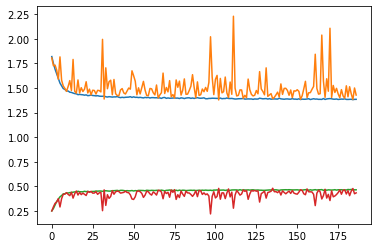

In [11]:
plt.plot(hist), best_acc, curloss

The gradients are seem to be high. Then I decide to reduce the learning rate and increase lamda in L2 norm to see next behavior

In [12]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)


cuda


Epoch:  1
	 - Step 1: loss: 2.314 acc: 0.062
	 - Step 2: loss: 2.214 acc: 0.109
	 - Step 3: loss: 2.244 acc: 0.188
	 - Step 4: loss: 1.986 acc: 0.250
	 - Step 5: loss: 2.122 acc: 0.219
	 - Step 6: loss: 1.975 acc: 0.250
	 - Step 7: loss: 2.117 acc: 0.062
	 - Step 8: loss: 2.067 acc: 0.109
	 - Step 9: loss: 1.990 acc: 0.141
	 - Step 10: loss: 2.003 acc: 0.141
	 - Step 11: loss: 1.905 acc: 0.188
	 - Step 12: loss: 1.887 acc: 0.203
	 - Step 13: loss: 1.918 acc: 0.125
	 - Step 14: loss: 1.923 acc: 0.203
	 - Step 15: loss: 1.895 acc: 0.188
	 - Step 16: loss: 1.896 acc: 0.297
	 - Step 17: loss: 1.914 acc: 0.219
	 - Step 18: loss: 1.927 acc: 0.266
	 - Step 19: loss: 1.936 acc: 0.250
	 - Step 20: loss: 1.906 acc: 0.203
	 - Step 21: loss: 1.864 acc: 0.219
	 - Step 22: loss: 1.863 acc: 0.234
	 - Step 23: loss: 1.944 acc: 0.188
	 - Step 24: loss: 1.847 acc: 0.344
	 - Step 25: loss: 1.830 acc: 0.297
	 - Step 26: loss: 1.929 acc: 0.172
	 - Step 27: loss: 1.936 acc: 0.234
	 - Step 28: loss: 1.862 ac

	 - Step 226: loss: 1.474 acc: 0.469
	 - Step 227: loss: 1.443 acc: 0.469
	 - Step 228: loss: 1.507 acc: 0.406
	 - Step 229: loss: 1.483 acc: 0.531
	 - Step 230: loss: 1.417 acc: 0.500
	 - Step 231: loss: 1.464 acc: 0.391
	 - Step 232: loss: 1.542 acc: 0.391
	 - Step 233: loss: 1.398 acc: 0.594
	 - Step 234: loss: 1.545 acc: 0.469
	 - Step 235: loss: 1.403 acc: 0.500
	 - Step 236: loss: 1.520 acc: 0.484
	 - Step 237: loss: 1.546 acc: 0.484
	 - Step 238: loss: 1.442 acc: 0.531
	 - Step 239: loss: 1.420 acc: 0.469
	 - Step 240: loss: 1.480 acc: 0.438
	 - Step 241: loss: 1.326 acc: 0.594
	 - Step 242: loss: 1.431 acc: 0.484
	 - Step 243: loss: 1.496 acc: 0.484
	 - Step 244: loss: 1.490 acc: 0.422
	 - Step 245: loss: 1.351 acc: 0.547
	 - Step 246: loss: 1.383 acc: 0.531
	 - Step 247: loss: 1.605 acc: 0.375
	 - Step 248: loss: 1.418 acc: 0.500
	 - Step 249: loss: 1.606 acc: 0.438
	 - Step 250: loss: 1.548 acc: 0.500
	 - Step 251: loss: 1.568 acc: 0.359
	 - Step 252: loss: 1.464 acc: 0.516
	

	 - Step 448: loss: 1.254 acc: 0.625
	 - Step 449: loss: 1.310 acc: 0.568
- Avg.loss: 1.543  | Avg.acc: 0.437
- Avg. val_loss: 1.400  | Avg. val_acc: 0.501
* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.216 acc: 0.578
	 - Step 2: loss: 1.350 acc: 0.484
	 - Step 3: loss: 1.164 acc: 0.688
	 - Step 4: loss: 1.237 acc: 0.562
	 - Step 5: loss: 1.185 acc: 0.641
	 - Step 6: loss: 1.235 acc: 0.641
	 - Step 7: loss: 1.178 acc: 0.594
	 - Step 8: loss: 1.361 acc: 0.562
	 - Step 9: loss: 1.252 acc: 0.562
	 - Step 10: loss: 1.103 acc: 0.641
	 - Step 11: loss: 1.301 acc: 0.531
	 - Step 12: loss: 1.222 acc: 0.578
	 - Step 13: loss: 1.480 acc: 0.469
	 - Step 14: loss: 1.141 acc: 0.688
	 - Step 15: loss: 1.223 acc: 0.578
	 - Step 16: loss: 1.383 acc: 0.594
	 - Step 17: loss: 1.212 acc: 0.641
	 - Step 18: loss: 1.384 acc: 0.516
	 - Step 19: loss: 1.321 acc: 0.469
	 - Step 20: loss: 1.184 acc: 0.594
	 - Step 21: loss: 1.183 acc: 0.625
	 - Step 22: loss: 1.457 acc: 0.516
	 - Step 23: loss: 1.183 acc

	 - Step 223: loss: 1.129 acc: 0.688
	 - Step 224: loss: 1.223 acc: 0.594
	 - Step 225: loss: 1.105 acc: 0.625
	 - Step 226: loss: 1.200 acc: 0.609
	 - Step 227: loss: 1.292 acc: 0.516
	 - Step 228: loss: 1.132 acc: 0.719
	 - Step 229: loss: 1.432 acc: 0.516
	 - Step 230: loss: 1.272 acc: 0.578
	 - Step 231: loss: 1.192 acc: 0.625
	 - Step 232: loss: 1.259 acc: 0.531
	 - Step 233: loss: 1.202 acc: 0.625
	 - Step 234: loss: 1.099 acc: 0.672
	 - Step 235: loss: 1.222 acc: 0.609
	 - Step 236: loss: 1.358 acc: 0.531
	 - Step 237: loss: 1.352 acc: 0.531
	 - Step 238: loss: 1.263 acc: 0.672
	 - Step 239: loss: 1.352 acc: 0.531
	 - Step 240: loss: 1.215 acc: 0.625
	 - Step 241: loss: 1.145 acc: 0.625
	 - Step 242: loss: 1.215 acc: 0.578
	 - Step 243: loss: 1.291 acc: 0.547
	 - Step 244: loss: 1.149 acc: 0.609
	 - Step 245: loss: 1.259 acc: 0.531
	 - Step 246: loss: 1.236 acc: 0.547
	 - Step 247: loss: 1.372 acc: 0.500
	 - Step 248: loss: 1.134 acc: 0.594
	 - Step 249: loss: 1.309 acc: 0.531
	

	 - Step 445: loss: 1.270 acc: 0.594
	 - Step 446: loss: 1.171 acc: 0.578
	 - Step 447: loss: 1.038 acc: 0.703
	 - Step 448: loss: 1.098 acc: 0.609
	 - Step 449: loss: 1.134 acc: 0.676
- Avg.loss: 1.237  | Avg.acc: 0.584
- Avg. val_loss: 1.232  | Avg. val_acc: 0.565
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.130 acc: 0.625
	 - Step 2: loss: 1.097 acc: 0.688
	 - Step 3: loss: 0.988 acc: 0.766
	 - Step 4: loss: 1.000 acc: 0.766
	 - Step 5: loss: 1.134 acc: 0.672
	 - Step 6: loss: 1.161 acc: 0.594
	 - Step 7: loss: 1.051 acc: 0.672
	 - Step 8: loss: 1.079 acc: 0.672
	 - Step 9: loss: 1.199 acc: 0.594
	 - Step 10: loss: 1.020 acc: 0.641
	 - Step 11: loss: 1.141 acc: 0.625
	 - Step 12: loss: 1.027 acc: 0.766
	 - Step 13: loss: 1.127 acc: 0.672
	 - Step 14: loss: 1.018 acc: 0.719
	 - Step 15: loss: 1.014 acc: 0.750
	 - Step 16: loss: 0.972 acc: 0.688
	 - Step 17: loss: 1.187 acc: 0.609
	 - Step 18: loss: 1.190 acc: 0.594
	 - Step 19: loss: 1.158 acc: 0.625
	 - Step 20: loss: 0.985 

	 - Step 220: loss: 0.916 acc: 0.781
	 - Step 221: loss: 0.999 acc: 0.688
	 - Step 222: loss: 1.064 acc: 0.625
	 - Step 223: loss: 1.093 acc: 0.672
	 - Step 224: loss: 1.227 acc: 0.594
	 - Step 225: loss: 1.144 acc: 0.609
	 - Step 226: loss: 1.002 acc: 0.688
	 - Step 227: loss: 1.050 acc: 0.672
	 - Step 228: loss: 1.080 acc: 0.641
	 - Step 229: loss: 1.084 acc: 0.641
	 - Step 230: loss: 1.025 acc: 0.719
	 - Step 231: loss: 1.123 acc: 0.641
	 - Step 232: loss: 1.023 acc: 0.703
	 - Step 233: loss: 1.068 acc: 0.656
	 - Step 234: loss: 1.138 acc: 0.625
	 - Step 235: loss: 1.089 acc: 0.609
	 - Step 236: loss: 1.056 acc: 0.672
	 - Step 237: loss: 1.083 acc: 0.656
	 - Step 238: loss: 1.011 acc: 0.703
	 - Step 239: loss: 1.012 acc: 0.750
	 - Step 240: loss: 1.145 acc: 0.625
	 - Step 241: loss: 1.113 acc: 0.656
	 - Step 242: loss: 1.012 acc: 0.688
	 - Step 243: loss: 1.211 acc: 0.594
	 - Step 244: loss: 1.164 acc: 0.594
	 - Step 245: loss: 1.007 acc: 0.672
	 - Step 246: loss: 1.121 acc: 0.609
	

	 - Step 442: loss: 1.044 acc: 0.688
	 - Step 443: loss: 1.189 acc: 0.609
	 - Step 444: loss: 0.957 acc: 0.734
	 - Step 445: loss: 1.152 acc: 0.641
	 - Step 446: loss: 1.034 acc: 0.641
	 - Step 447: loss: 1.137 acc: 0.625
	 - Step 448: loss: 0.960 acc: 0.688
	 - Step 449: loss: 1.260 acc: 0.676
- Avg.loss: 1.081  | Avg.acc: 0.656
- Avg. val_loss: 1.196  | Avg. val_acc: 0.577
* Update optimal model
Epoch:  4
	 - Step 1: loss: 0.819 acc: 0.797
	 - Step 2: loss: 0.906 acc: 0.766
	 - Step 3: loss: 0.939 acc: 0.719
	 - Step 4: loss: 1.046 acc: 0.641
	 - Step 5: loss: 0.822 acc: 0.781
	 - Step 6: loss: 0.971 acc: 0.688
	 - Step 7: loss: 0.790 acc: 0.828
	 - Step 8: loss: 0.992 acc: 0.734
	 - Step 9: loss: 1.001 acc: 0.703
	 - Step 10: loss: 0.843 acc: 0.781
	 - Step 11: loss: 0.976 acc: 0.750
	 - Step 12: loss: 0.789 acc: 0.859
	 - Step 13: loss: 0.891 acc: 0.766
	 - Step 14: loss: 0.940 acc: 0.734
	 - Step 15: loss: 1.121 acc: 0.672
	 - Step 16: loss: 0.824 acc: 0.797
	 - Step 17: loss: 0.8

	 - Step 217: loss: 0.886 acc: 0.766
	 - Step 218: loss: 1.012 acc: 0.625
	 - Step 219: loss: 0.877 acc: 0.719
	 - Step 220: loss: 1.018 acc: 0.703
	 - Step 221: loss: 1.056 acc: 0.609
	 - Step 222: loss: 0.876 acc: 0.719
	 - Step 223: loss: 0.945 acc: 0.703
	 - Step 224: loss: 0.806 acc: 0.812
	 - Step 225: loss: 1.077 acc: 0.688
	 - Step 226: loss: 0.844 acc: 0.688
	 - Step 227: loss: 0.841 acc: 0.734
	 - Step 228: loss: 0.862 acc: 0.812
	 - Step 229: loss: 0.877 acc: 0.719
	 - Step 230: loss: 0.865 acc: 0.703
	 - Step 231: loss: 0.916 acc: 0.766
	 - Step 232: loss: 0.908 acc: 0.781
	 - Step 233: loss: 0.975 acc: 0.734
	 - Step 234: loss: 0.889 acc: 0.781
	 - Step 235: loss: 0.952 acc: 0.688
	 - Step 236: loss: 0.809 acc: 0.812
	 - Step 237: loss: 0.813 acc: 0.797
	 - Step 238: loss: 1.030 acc: 0.672
	 - Step 239: loss: 0.796 acc: 0.812
	 - Step 240: loss: 0.947 acc: 0.703
	 - Step 241: loss: 0.898 acc: 0.766
	 - Step 242: loss: 0.952 acc: 0.719
	 - Step 243: loss: 0.950 acc: 0.703
	

	 - Step 439: loss: 0.823 acc: 0.766
	 - Step 440: loss: 1.049 acc: 0.688
	 - Step 441: loss: 0.889 acc: 0.719
	 - Step 442: loss: 1.050 acc: 0.641
	 - Step 443: loss: 0.894 acc: 0.703
	 - Step 444: loss: 0.877 acc: 0.719
	 - Step 445: loss: 0.929 acc: 0.734
	 - Step 446: loss: 0.915 acc: 0.750
	 - Step 447: loss: 0.927 acc: 0.734
	 - Step 448: loss: 0.979 acc: 0.688
	 - Step 449: loss: 1.024 acc: 0.676
- Avg.loss: 0.918  | Avg.acc: 0.733
- Avg. val_loss: 1.182  | Avg. val_acc: 0.601
* Update optimal model
Epoch:  5
	 - Step 1: loss: 0.668 acc: 0.891
	 - Step 2: loss: 0.784 acc: 0.797
	 - Step 3: loss: 0.760 acc: 0.781
	 - Step 4: loss: 0.772 acc: 0.750
	 - Step 5: loss: 0.812 acc: 0.828
	 - Step 6: loss: 0.680 acc: 0.828
	 - Step 7: loss: 0.750 acc: 0.781
	 - Step 8: loss: 0.786 acc: 0.797
	 - Step 9: loss: 0.758 acc: 0.812
	 - Step 10: loss: 0.766 acc: 0.812
	 - Step 11: loss: 0.646 acc: 0.891
	 - Step 12: loss: 0.676 acc: 0.891
	 - Step 13: loss: 0.640 acc: 0.891
	 - Step 14: loss: 

	 - Step 214: loss: 0.717 acc: 0.844
	 - Step 215: loss: 0.722 acc: 0.797
	 - Step 216: loss: 0.721 acc: 0.859
	 - Step 217: loss: 0.776 acc: 0.766
	 - Step 218: loss: 0.609 acc: 0.891
	 - Step 219: loss: 0.637 acc: 0.859
	 - Step 220: loss: 0.592 acc: 0.891
	 - Step 221: loss: 0.611 acc: 0.875
	 - Step 222: loss: 0.781 acc: 0.828
	 - Step 223: loss: 0.700 acc: 0.844
	 - Step 224: loss: 0.797 acc: 0.797
	 - Step 225: loss: 0.731 acc: 0.875
	 - Step 226: loss: 0.672 acc: 0.844
	 - Step 227: loss: 0.588 acc: 0.922
	 - Step 228: loss: 0.799 acc: 0.797
	 - Step 229: loss: 0.739 acc: 0.828
	 - Step 230: loss: 0.682 acc: 0.844
	 - Step 231: loss: 0.702 acc: 0.828
	 - Step 232: loss: 0.786 acc: 0.797
	 - Step 233: loss: 0.646 acc: 0.875
	 - Step 234: loss: 0.734 acc: 0.844
	 - Step 235: loss: 0.744 acc: 0.766
	 - Step 236: loss: 0.661 acc: 0.844
	 - Step 237: loss: 0.678 acc: 0.922
	 - Step 238: loss: 0.609 acc: 0.844
	 - Step 239: loss: 0.789 acc: 0.812
	 - Step 240: loss: 0.599 acc: 0.906
	

	 - Step 436: loss: 0.729 acc: 0.812
	 - Step 437: loss: 0.722 acc: 0.844
	 - Step 438: loss: 0.856 acc: 0.766
	 - Step 439: loss: 0.698 acc: 0.844
	 - Step 440: loss: 0.731 acc: 0.844
	 - Step 441: loss: 0.822 acc: 0.750
	 - Step 442: loss: 0.645 acc: 0.891
	 - Step 443: loss: 0.732 acc: 0.812
	 - Step 444: loss: 0.622 acc: 0.891
	 - Step 445: loss: 0.717 acc: 0.844
	 - Step 446: loss: 0.751 acc: 0.812
	 - Step 447: loss: 0.841 acc: 0.797
	 - Step 448: loss: 0.750 acc: 0.781
	 - Step 449: loss: 1.057 acc: 0.703
- Avg.loss: 0.717  | Avg.acc: 0.828
- Avg. val_loss: 1.234  | Avg. val_acc: 0.602
* Update optimal model
Epoch:  6
	 - Step 1: loss: 0.513 acc: 0.953
	 - Step 2: loss: 0.480 acc: 0.969
	 - Step 3: loss: 0.528 acc: 0.953
	 - Step 4: loss: 0.509 acc: 0.938
	 - Step 5: loss: 0.528 acc: 0.906
	 - Step 6: loss: 0.588 acc: 0.891
	 - Step 7: loss: 0.532 acc: 0.922
	 - Step 8: loss: 0.497 acc: 0.953
	 - Step 9: loss: 0.529 acc: 0.906
	 - Step 10: loss: 0.487 acc: 0.938
	 - Step 11: los

	 - Step 211: loss: 0.531 acc: 0.875
	 - Step 212: loss: 0.467 acc: 0.906
	 - Step 213: loss: 0.429 acc: 0.969
	 - Step 214: loss: 0.527 acc: 0.938
	 - Step 215: loss: 0.488 acc: 0.938
	 - Step 216: loss: 0.457 acc: 0.938
	 - Step 217: loss: 0.485 acc: 0.969
	 - Step 218: loss: 0.536 acc: 0.922
	 - Step 219: loss: 0.527 acc: 0.922
	 - Step 220: loss: 0.496 acc: 0.953
	 - Step 221: loss: 0.430 acc: 0.969
	 - Step 222: loss: 0.605 acc: 0.906
	 - Step 223: loss: 0.465 acc: 0.969
	 - Step 224: loss: 0.545 acc: 0.906
	 - Step 225: loss: 0.538 acc: 0.891
	 - Step 226: loss: 0.506 acc: 0.969
	 - Step 227: loss: 0.465 acc: 0.969
	 - Step 228: loss: 0.515 acc: 0.906
	 - Step 229: loss: 0.435 acc: 0.953
	 - Step 230: loss: 0.530 acc: 0.891
	 - Step 231: loss: 0.492 acc: 0.969
	 - Step 232: loss: 0.479 acc: 0.938
	 - Step 233: loss: 0.505 acc: 0.969
	 - Step 234: loss: 0.377 acc: 0.984
	 - Step 235: loss: 0.568 acc: 0.906
	 - Step 236: loss: 0.522 acc: 0.906
	 - Step 237: loss: 0.489 acc: 0.938
	

	 - Step 433: loss: 0.589 acc: 0.922
	 - Step 434: loss: 0.520 acc: 0.906
	 - Step 435: loss: 0.608 acc: 0.922
	 - Step 436: loss: 0.474 acc: 0.938
	 - Step 437: loss: 0.517 acc: 0.875
	 - Step 438: loss: 0.484 acc: 0.922
	 - Step 439: loss: 0.661 acc: 0.812
	 - Step 440: loss: 0.639 acc: 0.812
	 - Step 441: loss: 0.595 acc: 0.875
	 - Step 442: loss: 0.505 acc: 0.938
	 - Step 443: loss: 0.527 acc: 0.938
	 - Step 444: loss: 0.433 acc: 0.953
	 - Step 445: loss: 0.463 acc: 0.953
	 - Step 446: loss: 0.656 acc: 0.859
	 - Step 447: loss: 0.458 acc: 0.969
	 - Step 448: loss: 0.589 acc: 0.875
	 - Step 449: loss: 0.618 acc: 0.865
- Avg.loss: 0.513  | Avg.acc: 0.927
- Avg. val_loss: 1.219  | Avg. val_acc: 0.602
* Update optimal model
Epoch:  7
	 - Step 1: loss: 0.429 acc: 0.969
	 - Step 2: loss: 0.408 acc: 0.969
	 - Step 3: loss: 0.415 acc: 1.000
	 - Step 4: loss: 0.404 acc: 0.984
	 - Step 5: loss: 0.473 acc: 0.922
	 - Step 6: loss: 0.408 acc: 0.953
	 - Step 7: loss: 0.392 acc: 0.984
	 - Step 8:

	 - Step 208: loss: 0.374 acc: 0.953
	 - Step 209: loss: 0.379 acc: 1.000
	 - Step 210: loss: 0.317 acc: 1.000
	 - Step 211: loss: 0.308 acc: 1.000
	 - Step 212: loss: 0.427 acc: 0.969
	 - Step 213: loss: 0.331 acc: 1.000
	 - Step 214: loss: 0.372 acc: 0.984
	 - Step 215: loss: 0.336 acc: 0.984
	 - Step 216: loss: 0.373 acc: 0.984
	 - Step 217: loss: 0.404 acc: 0.969
	 - Step 218: loss: 0.447 acc: 0.953
	 - Step 219: loss: 0.365 acc: 0.969
	 - Step 220: loss: 0.337 acc: 1.000
	 - Step 221: loss: 0.354 acc: 0.984
	 - Step 222: loss: 0.427 acc: 0.922
	 - Step 223: loss: 0.392 acc: 0.969
	 - Step 224: loss: 0.305 acc: 1.000
	 - Step 225: loss: 0.347 acc: 1.000
	 - Step 226: loss: 0.396 acc: 1.000
	 - Step 227: loss: 0.380 acc: 0.984
	 - Step 228: loss: 0.327 acc: 1.000
	 - Step 229: loss: 0.347 acc: 1.000
	 - Step 230: loss: 0.417 acc: 0.953
	 - Step 231: loss: 0.365 acc: 0.984
	 - Step 232: loss: 0.404 acc: 0.969
	 - Step 233: loss: 0.402 acc: 0.984
	 - Step 234: loss: 0.398 acc: 0.953
	

	 - Step 430: loss: 0.372 acc: 0.953
	 - Step 431: loss: 0.389 acc: 0.969
	 - Step 432: loss: 0.352 acc: 0.969
	 - Step 433: loss: 0.338 acc: 1.000
	 - Step 434: loss: 0.417 acc: 0.969
	 - Step 435: loss: 0.380 acc: 0.969
	 - Step 436: loss: 0.384 acc: 0.969
	 - Step 437: loss: 0.368 acc: 1.000
	 - Step 438: loss: 0.364 acc: 0.984
	 - Step 439: loss: 0.348 acc: 0.953
	 - Step 440: loss: 0.390 acc: 0.969
	 - Step 441: loss: 0.414 acc: 0.984
	 - Step 442: loss: 0.371 acc: 0.984
	 - Step 443: loss: 0.389 acc: 0.953
	 - Step 444: loss: 0.356 acc: 0.984
	 - Step 445: loss: 0.351 acc: 0.984
	 - Step 446: loss: 0.422 acc: 0.953
	 - Step 447: loss: 0.393 acc: 0.953
	 - Step 448: loss: 0.390 acc: 0.953
	 - Step 449: loss: 0.350 acc: 1.000
- Avg.loss: 0.385  | Avg.acc: 0.974
- Avg. val_loss: 1.370  | Avg. val_acc: 0.540
Epoch:  8
	 - Step 1: loss: 0.391 acc: 0.969
	 - Step 2: loss: 0.404 acc: 0.984
	 - Step 3: loss: 0.325 acc: 1.000
	 - Step 4: loss: 0.310 acc: 1.000
	 - Step 5: loss: 0.325 acc:

	 - Step 205: loss: 0.330 acc: 0.984
	 - Step 206: loss: 0.268 acc: 1.000
	 - Step 207: loss: 0.296 acc: 0.984
	 - Step 208: loss: 0.287 acc: 0.984
	 - Step 209: loss: 0.312 acc: 0.984
	 - Step 210: loss: 0.320 acc: 0.984
	 - Step 211: loss: 0.293 acc: 1.000
	 - Step 212: loss: 0.297 acc: 1.000
	 - Step 213: loss: 0.268 acc: 1.000
	 - Step 214: loss: 0.258 acc: 1.000
	 - Step 215: loss: 0.404 acc: 0.969
	 - Step 216: loss: 0.377 acc: 0.984
	 - Step 217: loss: 0.276 acc: 1.000
	 - Step 218: loss: 0.277 acc: 1.000
	 - Step 219: loss: 0.299 acc: 0.984
	 - Step 220: loss: 0.259 acc: 1.000
	 - Step 221: loss: 0.322 acc: 0.984
	 - Step 222: loss: 0.293 acc: 1.000
	 - Step 223: loss: 0.249 acc: 1.000
	 - Step 224: loss: 0.279 acc: 1.000
	 - Step 225: loss: 0.252 acc: 1.000
	 - Step 226: loss: 0.271 acc: 1.000
	 - Step 227: loss: 0.298 acc: 1.000
	 - Step 228: loss: 0.296 acc: 1.000
	 - Step 229: loss: 0.358 acc: 0.938
	 - Step 230: loss: 0.272 acc: 1.000
	 - Step 231: loss: 0.253 acc: 1.000
	

	 - Step 427: loss: 0.389 acc: 0.953
	 - Step 428: loss: 0.375 acc: 0.984
	 - Step 429: loss: 0.351 acc: 0.984
	 - Step 430: loss: 0.330 acc: 0.969
	 - Step 431: loss: 0.293 acc: 1.000
	 - Step 432: loss: 0.373 acc: 0.984
	 - Step 433: loss: 0.319 acc: 0.953
	 - Step 434: loss: 0.333 acc: 0.969
	 - Step 435: loss: 0.343 acc: 0.953
	 - Step 436: loss: 0.284 acc: 1.000
	 - Step 437: loss: 0.318 acc: 1.000
	 - Step 438: loss: 0.297 acc: 0.984
	 - Step 439: loss: 0.360 acc: 0.953
	 - Step 440: loss: 0.362 acc: 0.953
	 - Step 441: loss: 0.387 acc: 0.953
	 - Step 442: loss: 0.311 acc: 0.984
	 - Step 443: loss: 0.251 acc: 1.000
	 - Step 444: loss: 0.338 acc: 0.969
	 - Step 445: loss: 0.296 acc: 0.984
	 - Step 446: loss: 0.312 acc: 0.984
	 - Step 447: loss: 0.257 acc: 1.000
	 - Step 448: loss: 0.341 acc: 0.969
	 - Step 449: loss: 0.427 acc: 0.946
- Avg.loss: 0.311  | Avg.acc: 0.988
- Avg. val_loss: 1.152  | Avg. val_acc: 0.618
* Update optimal model
Epoch:  9
	 - Step 1: loss: 0.283 acc: 0.984

	 - Step 202: loss: 0.249 acc: 1.000
	 - Step 203: loss: 0.215 acc: 1.000
	 - Step 204: loss: 0.232 acc: 1.000
	 - Step 205: loss: 0.236 acc: 1.000
	 - Step 206: loss: 0.291 acc: 0.969
	 - Step 207: loss: 0.248 acc: 1.000
	 - Step 208: loss: 0.293 acc: 1.000
	 - Step 209: loss: 0.261 acc: 1.000
	 - Step 210: loss: 0.238 acc: 1.000
	 - Step 211: loss: 0.270 acc: 0.984
	 - Step 212: loss: 0.258 acc: 1.000
	 - Step 213: loss: 0.239 acc: 1.000
	 - Step 214: loss: 0.264 acc: 0.984
	 - Step 215: loss: 0.260 acc: 1.000
	 - Step 216: loss: 0.240 acc: 1.000
	 - Step 217: loss: 0.260 acc: 1.000
	 - Step 218: loss: 0.240 acc: 1.000
	 - Step 219: loss: 0.300 acc: 0.969
	 - Step 220: loss: 0.288 acc: 0.984
	 - Step 221: loss: 0.302 acc: 1.000
	 - Step 222: loss: 0.234 acc: 1.000
	 - Step 223: loss: 0.289 acc: 1.000
	 - Step 224: loss: 0.265 acc: 1.000
	 - Step 225: loss: 0.300 acc: 0.969
	 - Step 226: loss: 0.312 acc: 0.969
	 - Step 227: loss: 0.248 acc: 1.000
	 - Step 228: loss: 0.282 acc: 0.969
	

	 - Step 424: loss: 0.286 acc: 0.984
	 - Step 425: loss: 0.331 acc: 0.969
	 - Step 426: loss: 0.282 acc: 1.000
	 - Step 427: loss: 0.314 acc: 0.969
	 - Step 428: loss: 0.308 acc: 0.969
	 - Step 429: loss: 0.320 acc: 0.969
	 - Step 430: loss: 0.287 acc: 0.984
	 - Step 431: loss: 0.312 acc: 1.000
	 - Step 432: loss: 0.291 acc: 0.969
	 - Step 433: loss: 0.305 acc: 1.000
	 - Step 434: loss: 0.260 acc: 0.984
	 - Step 435: loss: 0.309 acc: 0.969
	 - Step 436: loss: 0.355 acc: 0.938
	 - Step 437: loss: 0.255 acc: 1.000
	 - Step 438: loss: 0.294 acc: 1.000
	 - Step 439: loss: 0.287 acc: 0.984
	 - Step 440: loss: 0.244 acc: 1.000
	 - Step 441: loss: 0.283 acc: 0.953
	 - Step 442: loss: 0.260 acc: 0.984
	 - Step 443: loss: 0.251 acc: 0.984
	 - Step 444: loss: 0.284 acc: 0.984
	 - Step 445: loss: 0.276 acc: 0.984
	 - Step 446: loss: 0.253 acc: 1.000
	 - Step 447: loss: 0.345 acc: 0.953
	 - Step 448: loss: 0.288 acc: 0.984
	 - Step 449: loss: 0.263 acc: 1.000
- Avg.loss: 0.281  | Avg.acc: 0.989
- 

	 - Step 199: loss: 0.238 acc: 0.984
	 - Step 200: loss: 0.254 acc: 1.000
	 - Step 201: loss: 0.293 acc: 0.984
	 - Step 202: loss: 0.286 acc: 0.969
	 - Step 203: loss: 0.233 acc: 1.000
	 - Step 204: loss: 0.276 acc: 0.984
	 - Step 205: loss: 0.265 acc: 0.969
	 - Step 206: loss: 0.313 acc: 0.953
	 - Step 207: loss: 0.285 acc: 0.953
	 - Step 208: loss: 0.252 acc: 1.000
	 - Step 209: loss: 0.296 acc: 0.969
	 - Step 210: loss: 0.358 acc: 0.953
	 - Step 211: loss: 0.274 acc: 1.000
	 - Step 212: loss: 0.304 acc: 0.969
	 - Step 213: loss: 0.265 acc: 0.969
	 - Step 214: loss: 0.247 acc: 1.000
	 - Step 215: loss: 0.247 acc: 0.984
	 - Step 216: loss: 0.259 acc: 0.969
	 - Step 217: loss: 0.250 acc: 0.984
	 - Step 218: loss: 0.264 acc: 0.984
	 - Step 219: loss: 0.247 acc: 1.000
	 - Step 220: loss: 0.276 acc: 0.984
	 - Step 221: loss: 0.222 acc: 0.984
	 - Step 222: loss: 0.307 acc: 0.969
	 - Step 223: loss: 0.287 acc: 1.000
	 - Step 224: loss: 0.284 acc: 0.969
	 - Step 225: loss: 0.244 acc: 0.984
	

	 - Step 421: loss: 0.404 acc: 0.891
	 - Step 422: loss: 0.319 acc: 0.969
	 - Step 423: loss: 0.441 acc: 0.891
	 - Step 424: loss: 0.326 acc: 1.000
	 - Step 425: loss: 0.341 acc: 0.953
	 - Step 426: loss: 0.345 acc: 0.938
	 - Step 427: loss: 0.343 acc: 0.969
	 - Step 428: loss: 0.345 acc: 0.953
	 - Step 429: loss: 0.310 acc: 0.984
	 - Step 430: loss: 0.345 acc: 0.953
	 - Step 431: loss: 0.304 acc: 1.000
	 - Step 432: loss: 0.283 acc: 0.969
	 - Step 433: loss: 0.422 acc: 0.922
	 - Step 434: loss: 0.377 acc: 0.953
	 - Step 435: loss: 0.337 acc: 0.969
	 - Step 436: loss: 0.322 acc: 0.938
	 - Step 437: loss: 0.465 acc: 0.875
	 - Step 438: loss: 0.363 acc: 0.984
	 - Step 439: loss: 0.361 acc: 0.922
	 - Step 440: loss: 0.317 acc: 0.969
	 - Step 441: loss: 0.306 acc: 0.953
	 - Step 442: loss: 0.394 acc: 0.953
	 - Step 443: loss: 0.405 acc: 0.953
	 - Step 444: loss: 0.287 acc: 0.984
	 - Step 445: loss: 0.403 acc: 0.938
	 - Step 446: loss: 0.464 acc: 0.891
	 - Step 447: loss: 0.482 acc: 0.844
	

	 - Step 196: loss: 0.282 acc: 0.984
	 - Step 197: loss: 0.315 acc: 0.984
	 - Step 198: loss: 0.269 acc: 0.984
	 - Step 199: loss: 0.250 acc: 0.984
	 - Step 200: loss: 0.281 acc: 0.984
	 - Step 201: loss: 0.254 acc: 1.000
	 - Step 202: loss: 0.247 acc: 1.000
	 - Step 203: loss: 0.306 acc: 0.953
	 - Step 204: loss: 0.252 acc: 1.000
	 - Step 205: loss: 0.238 acc: 1.000
	 - Step 206: loss: 0.265 acc: 0.984
	 - Step 207: loss: 0.351 acc: 0.953
	 - Step 208: loss: 0.315 acc: 1.000
	 - Step 209: loss: 0.339 acc: 0.953
	 - Step 210: loss: 0.320 acc: 0.953
	 - Step 211: loss: 0.255 acc: 1.000
	 - Step 212: loss: 0.254 acc: 0.984
	 - Step 213: loss: 0.253 acc: 0.984
	 - Step 214: loss: 0.273 acc: 0.969
	 - Step 215: loss: 0.359 acc: 0.953
	 - Step 216: loss: 0.286 acc: 0.969
	 - Step 217: loss: 0.245 acc: 0.984
	 - Step 218: loss: 0.215 acc: 1.000
	 - Step 219: loss: 0.220 acc: 1.000
	 - Step 220: loss: 0.249 acc: 0.969
	 - Step 221: loss: 0.254 acc: 0.984
	 - Step 222: loss: 0.273 acc: 0.984
	

	 - Step 418: loss: 0.449 acc: 0.906
	 - Step 419: loss: 0.334 acc: 0.953
	 - Step 420: loss: 0.373 acc: 0.953
	 - Step 421: loss: 0.352 acc: 0.969
	 - Step 422: loss: 0.276 acc: 0.969
	 - Step 423: loss: 0.347 acc: 0.953
	 - Step 424: loss: 0.438 acc: 0.875
	 - Step 425: loss: 0.324 acc: 0.969
	 - Step 426: loss: 0.313 acc: 0.984
	 - Step 427: loss: 0.400 acc: 0.891
	 - Step 428: loss: 0.378 acc: 0.922
	 - Step 429: loss: 0.338 acc: 0.953
	 - Step 430: loss: 0.249 acc: 0.984
	 - Step 431: loss: 0.304 acc: 0.953
	 - Step 432: loss: 0.288 acc: 0.969
	 - Step 433: loss: 0.366 acc: 0.938
	 - Step 434: loss: 0.337 acc: 0.938
	 - Step 435: loss: 0.460 acc: 0.906
	 - Step 436: loss: 0.358 acc: 0.938
	 - Step 437: loss: 0.358 acc: 0.938
	 - Step 438: loss: 0.342 acc: 0.953
	 - Step 439: loss: 0.243 acc: 0.969
	 - Step 440: loss: 0.310 acc: 0.969
	 - Step 441: loss: 0.323 acc: 0.953
	 - Step 442: loss: 0.319 acc: 0.969
	 - Step 443: loss: 0.555 acc: 0.828
	 - Step 444: loss: 0.342 acc: 0.938
	

	 - Step 193: loss: 0.320 acc: 0.953
	 - Step 194: loss: 0.262 acc: 0.984
	 - Step 195: loss: 0.200 acc: 1.000
	 - Step 196: loss: 0.240 acc: 0.969
	 - Step 197: loss: 0.222 acc: 1.000
	 - Step 198: loss: 0.219 acc: 1.000
	 - Step 199: loss: 0.272 acc: 0.984
	 - Step 200: loss: 0.279 acc: 0.969
	 - Step 201: loss: 0.251 acc: 0.969
	 - Step 202: loss: 0.351 acc: 0.938
	 - Step 203: loss: 0.260 acc: 0.984
	 - Step 204: loss: 0.248 acc: 0.984
	 - Step 205: loss: 0.281 acc: 0.953
	 - Step 206: loss: 0.228 acc: 1.000
	 - Step 207: loss: 0.241 acc: 1.000
	 - Step 208: loss: 0.228 acc: 0.984
	 - Step 209: loss: 0.253 acc: 0.969
	 - Step 210: loss: 0.206 acc: 1.000
	 - Step 211: loss: 0.264 acc: 0.938
	 - Step 212: loss: 0.217 acc: 0.984
	 - Step 213: loss: 0.231 acc: 1.000
	 - Step 214: loss: 0.202 acc: 1.000
	 - Step 215: loss: 0.225 acc: 0.984
	 - Step 216: loss: 0.305 acc: 0.984
	 - Step 217: loss: 0.255 acc: 0.969
	 - Step 218: loss: 0.210 acc: 1.000
	 - Step 219: loss: 0.243 acc: 1.000
	

	 - Step 415: loss: 0.247 acc: 1.000
	 - Step 416: loss: 0.386 acc: 0.922
	 - Step 417: loss: 0.321 acc: 0.953
	 - Step 418: loss: 0.240 acc: 0.984
	 - Step 419: loss: 0.313 acc: 0.953
	 - Step 420: loss: 0.258 acc: 0.984
	 - Step 421: loss: 0.272 acc: 0.953
	 - Step 422: loss: 0.244 acc: 0.969
	 - Step 423: loss: 0.228 acc: 0.969
	 - Step 424: loss: 0.183 acc: 1.000
	 - Step 425: loss: 0.240 acc: 0.984
	 - Step 426: loss: 0.232 acc: 0.984
	 - Step 427: loss: 0.293 acc: 0.953
	 - Step 428: loss: 0.350 acc: 0.953
	 - Step 429: loss: 0.330 acc: 0.875
	 - Step 430: loss: 0.273 acc: 0.984
	 - Step 431: loss: 0.285 acc: 0.953
	 - Step 432: loss: 0.267 acc: 0.969
	 - Step 433: loss: 0.383 acc: 0.891
	 - Step 434: loss: 0.202 acc: 1.000
	 - Step 435: loss: 0.225 acc: 1.000
	 - Step 436: loss: 0.217 acc: 1.000
	 - Step 437: loss: 0.257 acc: 0.969
	 - Step 438: loss: 0.213 acc: 0.984
	 - Step 439: loss: 0.306 acc: 0.938
	 - Step 440: loss: 0.263 acc: 0.969
	 - Step 441: loss: 0.220 acc: 0.953
	

	 - Step 190: loss: 0.216 acc: 1.000
	 - Step 191: loss: 0.234 acc: 0.969
	 - Step 192: loss: 0.290 acc: 0.969
	 - Step 193: loss: 0.282 acc: 0.953
	 - Step 194: loss: 0.238 acc: 0.984
	 - Step 195: loss: 0.261 acc: 0.953
	 - Step 196: loss: 0.246 acc: 0.969
	 - Step 197: loss: 0.251 acc: 0.953
	 - Step 198: loss: 0.239 acc: 0.969
	 - Step 199: loss: 0.266 acc: 0.969
	 - Step 200: loss: 0.205 acc: 0.984
	 - Step 201: loss: 0.209 acc: 1.000
	 - Step 202: loss: 0.226 acc: 0.953
	 - Step 203: loss: 0.335 acc: 0.938
	 - Step 204: loss: 0.239 acc: 0.984
	 - Step 205: loss: 0.231 acc: 0.969
	 - Step 206: loss: 0.217 acc: 1.000
	 - Step 207: loss: 0.203 acc: 0.984
	 - Step 208: loss: 0.234 acc: 0.984
	 - Step 209: loss: 0.238 acc: 0.969
	 - Step 210: loss: 0.266 acc: 0.938
	 - Step 211: loss: 0.195 acc: 1.000
	 - Step 212: loss: 0.171 acc: 1.000
	 - Step 213: loss: 0.260 acc: 0.969
	 - Step 214: loss: 0.242 acc: 0.984
	 - Step 215: loss: 0.203 acc: 1.000
	 - Step 216: loss: 0.197 acc: 1.000
	

	 - Step 412: loss: 0.225 acc: 0.984
	 - Step 413: loss: 0.273 acc: 0.953
	 - Step 414: loss: 0.297 acc: 0.953
	 - Step 415: loss: 0.292 acc: 0.922
	 - Step 416: loss: 0.222 acc: 1.000
	 - Step 417: loss: 0.318 acc: 0.953
	 - Step 418: loss: 0.257 acc: 0.953
	 - Step 419: loss: 0.231 acc: 0.984
	 - Step 420: loss: 0.262 acc: 0.953
	 - Step 421: loss: 0.300 acc: 0.953
	 - Step 422: loss: 0.229 acc: 0.984
	 - Step 423: loss: 0.319 acc: 0.969
	 - Step 424: loss: 0.235 acc: 0.969
	 - Step 425: loss: 0.238 acc: 0.984
	 - Step 426: loss: 0.233 acc: 0.984
	 - Step 427: loss: 0.237 acc: 0.984
	 - Step 428: loss: 0.281 acc: 0.922
	 - Step 429: loss: 0.231 acc: 0.969
	 - Step 430: loss: 0.251 acc: 0.938
	 - Step 431: loss: 0.206 acc: 0.984
	 - Step 432: loss: 0.227 acc: 0.984
	 - Step 433: loss: 0.245 acc: 0.969
	 - Step 434: loss: 0.268 acc: 0.969
	 - Step 435: loss: 0.350 acc: 0.953
	 - Step 436: loss: 0.198 acc: 1.000
	 - Step 437: loss: 0.241 acc: 0.984
	 - Step 438: loss: 0.214 acc: 0.969
	

	 - Step 187: loss: 0.181 acc: 1.000
	 - Step 188: loss: 0.190 acc: 0.984
	 - Step 189: loss: 0.223 acc: 0.953
	 - Step 190: loss: 0.171 acc: 1.000
	 - Step 191: loss: 0.205 acc: 0.984
	 - Step 192: loss: 0.228 acc: 0.969
	 - Step 193: loss: 0.180 acc: 0.984
	 - Step 194: loss: 0.197 acc: 0.984
	 - Step 195: loss: 0.156 acc: 1.000
	 - Step 196: loss: 0.206 acc: 0.969
	 - Step 197: loss: 0.176 acc: 1.000
	 - Step 198: loss: 0.197 acc: 1.000
	 - Step 199: loss: 0.169 acc: 1.000
	 - Step 200: loss: 0.215 acc: 0.984
	 - Step 201: loss: 0.180 acc: 1.000
	 - Step 202: loss: 0.198 acc: 0.969
	 - Step 203: loss: 0.228 acc: 0.953
	 - Step 204: loss: 0.197 acc: 0.984
	 - Step 205: loss: 0.174 acc: 1.000
	 - Step 206: loss: 0.311 acc: 0.953
	 - Step 207: loss: 0.171 acc: 1.000
	 - Step 208: loss: 0.147 acc: 1.000
	 - Step 209: loss: 0.174 acc: 1.000
	 - Step 210: loss: 0.191 acc: 0.984
	 - Step 211: loss: 0.216 acc: 0.984
	 - Step 212: loss: 0.164 acc: 1.000
	 - Step 213: loss: 0.162 acc: 1.000
	

	 - Step 409: loss: 0.200 acc: 0.984
	 - Step 410: loss: 0.256 acc: 0.953
	 - Step 411: loss: 0.252 acc: 0.984
	 - Step 412: loss: 0.222 acc: 0.984
	 - Step 413: loss: 0.347 acc: 0.938
	 - Step 414: loss: 0.278 acc: 0.938
	 - Step 415: loss: 0.287 acc: 0.953
	 - Step 416: loss: 0.244 acc: 0.984
	 - Step 417: loss: 0.195 acc: 0.984
	 - Step 418: loss: 0.281 acc: 0.938
	 - Step 419: loss: 0.241 acc: 0.969
	 - Step 420: loss: 0.322 acc: 0.906
	 - Step 421: loss: 0.296 acc: 0.953
	 - Step 422: loss: 0.314 acc: 0.922
	 - Step 423: loss: 0.206 acc: 0.969
	 - Step 424: loss: 0.207 acc: 0.984
	 - Step 425: loss: 0.299 acc: 0.938
	 - Step 426: loss: 0.204 acc: 1.000
	 - Step 427: loss: 0.179 acc: 1.000
	 - Step 428: loss: 0.239 acc: 0.953
	 - Step 429: loss: 0.211 acc: 0.969
	 - Step 430: loss: 0.273 acc: 0.969
	 - Step 431: loss: 0.202 acc: 1.000
	 - Step 432: loss: 0.284 acc: 0.953
	 - Step 433: loss: 0.276 acc: 0.953
	 - Step 434: loss: 0.238 acc: 0.969
	 - Step 435: loss: 0.186 acc: 0.984
	

	 - Step 184: loss: 0.171 acc: 0.984
	 - Step 185: loss: 0.167 acc: 1.000
	 - Step 186: loss: 0.143 acc: 1.000
	 - Step 187: loss: 0.288 acc: 0.922
	 - Step 188: loss: 0.171 acc: 1.000
	 - Step 189: loss: 0.186 acc: 0.984
	 - Step 190: loss: 0.206 acc: 0.984
	 - Step 191: loss: 0.320 acc: 0.969
	 - Step 192: loss: 0.181 acc: 0.969
	 - Step 193: loss: 0.178 acc: 1.000
	 - Step 194: loss: 0.170 acc: 1.000
	 - Step 195: loss: 0.223 acc: 0.953
	 - Step 196: loss: 0.178 acc: 0.984
	 - Step 197: loss: 0.184 acc: 1.000
	 - Step 198: loss: 0.163 acc: 0.984
	 - Step 199: loss: 0.176 acc: 0.984
	 - Step 200: loss: 0.217 acc: 0.984
	 - Step 201: loss: 0.213 acc: 0.938
	 - Step 202: loss: 0.225 acc: 0.969
	 - Step 203: loss: 0.162 acc: 1.000
	 - Step 204: loss: 0.233 acc: 0.953
	 - Step 205: loss: 0.260 acc: 0.969
	 - Step 206: loss: 0.173 acc: 0.984
	 - Step 207: loss: 0.178 acc: 1.000
	 - Step 208: loss: 0.173 acc: 1.000
	 - Step 209: loss: 0.233 acc: 0.969
	 - Step 210: loss: 0.225 acc: 0.953
	

	 - Step 406: loss: 0.222 acc: 0.984
	 - Step 407: loss: 0.230 acc: 0.984
	 - Step 408: loss: 0.281 acc: 0.938
	 - Step 409: loss: 0.216 acc: 0.984
	 - Step 410: loss: 0.238 acc: 0.969
	 - Step 411: loss: 0.198 acc: 0.969
	 - Step 412: loss: 0.264 acc: 0.938
	 - Step 413: loss: 0.238 acc: 0.984
	 - Step 414: loss: 0.211 acc: 0.953
	 - Step 415: loss: 0.351 acc: 0.922
	 - Step 416: loss: 0.228 acc: 0.984
	 - Step 417: loss: 0.243 acc: 0.969
	 - Step 418: loss: 0.208 acc: 0.969
	 - Step 419: loss: 0.264 acc: 0.969
	 - Step 420: loss: 0.207 acc: 1.000
	 - Step 421: loss: 0.238 acc: 0.969
	 - Step 422: loss: 0.201 acc: 0.984
	 - Step 423: loss: 0.211 acc: 0.969
	 - Step 424: loss: 0.213 acc: 0.969
	 - Step 425: loss: 0.207 acc: 1.000
	 - Step 426: loss: 0.202 acc: 0.984
	 - Step 427: loss: 0.243 acc: 0.922
	 - Step 428: loss: 0.271 acc: 0.953
	 - Step 429: loss: 0.267 acc: 0.922
	 - Step 430: loss: 0.209 acc: 0.969
	 - Step 431: loss: 0.231 acc: 0.984
	 - Step 432: loss: 0.305 acc: 0.953
	

	 - Step 181: loss: 0.161 acc: 0.984
	 - Step 182: loss: 0.185 acc: 0.969
	 - Step 183: loss: 0.161 acc: 0.984
	 - Step 184: loss: 0.151 acc: 1.000
	 - Step 185: loss: 0.186 acc: 0.984
	 - Step 186: loss: 0.136 acc: 1.000
	 - Step 187: loss: 0.141 acc: 1.000
	 - Step 188: loss: 0.222 acc: 0.984
	 - Step 189: loss: 0.223 acc: 0.938
	 - Step 190: loss: 0.151 acc: 0.984
	 - Step 191: loss: 0.138 acc: 1.000
	 - Step 192: loss: 0.152 acc: 1.000
	 - Step 193: loss: 0.150 acc: 1.000
	 - Step 194: loss: 0.211 acc: 0.984
	 - Step 195: loss: 0.142 acc: 0.984
	 - Step 196: loss: 0.277 acc: 0.922
	 - Step 197: loss: 0.231 acc: 0.969
	 - Step 198: loss: 0.153 acc: 1.000
	 - Step 199: loss: 0.287 acc: 0.922
	 - Step 200: loss: 0.199 acc: 0.984
	 - Step 201: loss: 0.195 acc: 0.969
	 - Step 202: loss: 0.190 acc: 0.984
	 - Step 203: loss: 0.147 acc: 1.000
	 - Step 204: loss: 0.208 acc: 0.984
	 - Step 205: loss: 0.195 acc: 0.984
	 - Step 206: loss: 0.184 acc: 0.984
	 - Step 207: loss: 0.157 acc: 1.000
	

	 - Step 403: loss: 0.189 acc: 0.969
	 - Step 404: loss: 0.216 acc: 0.969
	 - Step 405: loss: 0.195 acc: 0.984
	 - Step 406: loss: 0.292 acc: 0.922
	 - Step 407: loss: 0.243 acc: 0.953
	 - Step 408: loss: 0.191 acc: 0.969
	 - Step 409: loss: 0.162 acc: 1.000
	 - Step 410: loss: 0.207 acc: 0.969
	 - Step 411: loss: 0.245 acc: 0.953
	 - Step 412: loss: 0.169 acc: 1.000
	 - Step 413: loss: 0.247 acc: 0.953
	 - Step 414: loss: 0.266 acc: 0.953
	 - Step 415: loss: 0.276 acc: 0.938
	 - Step 416: loss: 0.218 acc: 0.953
	 - Step 417: loss: 0.199 acc: 0.984
	 - Step 418: loss: 0.280 acc: 0.922
	 - Step 419: loss: 0.202 acc: 0.953
	 - Step 420: loss: 0.332 acc: 0.938
	 - Step 421: loss: 0.211 acc: 0.969
	 - Step 422: loss: 0.318 acc: 0.922
	 - Step 423: loss: 0.236 acc: 0.953
	 - Step 424: loss: 0.171 acc: 1.000
	 - Step 425: loss: 0.210 acc: 0.984
	 - Step 426: loss: 0.264 acc: 0.938
	 - Step 427: loss: 0.345 acc: 0.922
	 - Step 428: loss: 0.270 acc: 0.938
	 - Step 429: loss: 0.289 acc: 0.938
	

	 - Step 178: loss: 0.165 acc: 1.000
	 - Step 179: loss: 0.139 acc: 1.000
	 - Step 180: loss: 0.197 acc: 0.984
	 - Step 181: loss: 0.144 acc: 0.984
	 - Step 182: loss: 0.143 acc: 0.984
	 - Step 183: loss: 0.127 acc: 1.000
	 - Step 184: loss: 0.161 acc: 0.984
	 - Step 185: loss: 0.222 acc: 0.969
	 - Step 186: loss: 0.231 acc: 0.953
	 - Step 187: loss: 0.155 acc: 0.984
	 - Step 188: loss: 0.126 acc: 1.000
	 - Step 189: loss: 0.146 acc: 1.000
	 - Step 190: loss: 0.163 acc: 0.984
	 - Step 191: loss: 0.183 acc: 0.953
	 - Step 192: loss: 0.140 acc: 1.000
	 - Step 193: loss: 0.208 acc: 0.969
	 - Step 194: loss: 0.161 acc: 0.969
	 - Step 195: loss: 0.193 acc: 0.953
	 - Step 196: loss: 0.166 acc: 0.984
	 - Step 197: loss: 0.165 acc: 1.000
	 - Step 198: loss: 0.141 acc: 1.000
	 - Step 199: loss: 0.135 acc: 1.000
	 - Step 200: loss: 0.163 acc: 0.969
	 - Step 201: loss: 0.174 acc: 0.969
	 - Step 202: loss: 0.203 acc: 0.984
	 - Step 203: loss: 0.163 acc: 0.984
	 - Step 204: loss: 0.214 acc: 0.953
	

	 - Step 400: loss: 0.213 acc: 0.953
	 - Step 401: loss: 0.185 acc: 1.000
	 - Step 402: loss: 0.193 acc: 0.969
	 - Step 403: loss: 0.335 acc: 0.922
	 - Step 404: loss: 0.276 acc: 0.953
	 - Step 405: loss: 0.166 acc: 0.984
	 - Step 406: loss: 0.244 acc: 0.938
	 - Step 407: loss: 0.178 acc: 0.969
	 - Step 408: loss: 0.158 acc: 1.000
	 - Step 409: loss: 0.171 acc: 0.969
	 - Step 410: loss: 0.166 acc: 0.969
	 - Step 411: loss: 0.192 acc: 0.953
	 - Step 412: loss: 0.173 acc: 0.969
	 - Step 413: loss: 0.242 acc: 0.938
	 - Step 414: loss: 0.239 acc: 0.922
	 - Step 415: loss: 0.208 acc: 0.953
	 - Step 416: loss: 0.262 acc: 0.953
	 - Step 417: loss: 0.231 acc: 0.953
	 - Step 418: loss: 0.208 acc: 0.984
	 - Step 419: loss: 0.180 acc: 0.969
	 - Step 420: loss: 0.244 acc: 0.953
	 - Step 421: loss: 0.215 acc: 0.969
	 - Step 422: loss: 0.259 acc: 0.938
	 - Step 423: loss: 0.173 acc: 0.984
	 - Step 424: loss: 0.290 acc: 0.969
	 - Step 425: loss: 0.176 acc: 0.984
	 - Step 426: loss: 0.226 acc: 0.953
	

	 - Step 175: loss: 0.184 acc: 0.969
	 - Step 176: loss: 0.239 acc: 0.953
	 - Step 177: loss: 0.149 acc: 0.984
	 - Step 178: loss: 0.175 acc: 0.969
	 - Step 179: loss: 0.172 acc: 0.984
	 - Step 180: loss: 0.187 acc: 0.969
	 - Step 181: loss: 0.145 acc: 1.000
	 - Step 182: loss: 0.240 acc: 0.953
	 - Step 183: loss: 0.123 acc: 1.000
	 - Step 184: loss: 0.191 acc: 0.984
	 - Step 185: loss: 0.153 acc: 0.984
	 - Step 186: loss: 0.190 acc: 0.984
	 - Step 187: loss: 0.170 acc: 0.984
	 - Step 188: loss: 0.133 acc: 1.000
	 - Step 189: loss: 0.145 acc: 0.984
	 - Step 190: loss: 0.251 acc: 0.922
	 - Step 191: loss: 0.218 acc: 0.938
	 - Step 192: loss: 0.173 acc: 0.969
	 - Step 193: loss: 0.134 acc: 1.000
	 - Step 194: loss: 0.144 acc: 1.000
	 - Step 195: loss: 0.167 acc: 0.984
	 - Step 196: loss: 0.130 acc: 1.000
	 - Step 197: loss: 0.162 acc: 1.000
	 - Step 198: loss: 0.135 acc: 1.000
	 - Step 199: loss: 0.134 acc: 0.984
	 - Step 200: loss: 0.180 acc: 0.984
	 - Step 201: loss: 0.208 acc: 0.969
	

	 - Step 397: loss: 0.164 acc: 0.984
	 - Step 398: loss: 0.179 acc: 0.969
	 - Step 399: loss: 0.216 acc: 0.984
	 - Step 400: loss: 0.188 acc: 0.984
	 - Step 401: loss: 0.117 acc: 1.000
	 - Step 402: loss: 0.224 acc: 0.969
	 - Step 403: loss: 0.192 acc: 0.969
	 - Step 404: loss: 0.209 acc: 0.953
	 - Step 405: loss: 0.233 acc: 0.984
	 - Step 406: loss: 0.224 acc: 0.953
	 - Step 407: loss: 0.292 acc: 0.938
	 - Step 408: loss: 0.197 acc: 0.984
	 - Step 409: loss: 0.231 acc: 0.953
	 - Step 410: loss: 0.111 acc: 1.000
	 - Step 411: loss: 0.187 acc: 0.969
	 - Step 412: loss: 0.140 acc: 1.000
	 - Step 413: loss: 0.165 acc: 0.969
	 - Step 414: loss: 0.186 acc: 0.984
	 - Step 415: loss: 0.302 acc: 0.953
	 - Step 416: loss: 0.278 acc: 0.922
	 - Step 417: loss: 0.154 acc: 0.984
	 - Step 418: loss: 0.217 acc: 0.969
	 - Step 419: loss: 0.161 acc: 0.969
	 - Step 420: loss: 0.127 acc: 1.000
	 - Step 421: loss: 0.167 acc: 0.984
	 - Step 422: loss: 0.160 acc: 1.000
	 - Step 423: loss: 0.169 acc: 0.969
	

	 - Step 172: loss: 0.145 acc: 0.984
	 - Step 173: loss: 0.132 acc: 1.000
	 - Step 174: loss: 0.185 acc: 0.953
	 - Step 175: loss: 0.130 acc: 1.000
	 - Step 176: loss: 0.278 acc: 0.906
	 - Step 177: loss: 0.151 acc: 0.984
	 - Step 178: loss: 0.181 acc: 0.953
	 - Step 179: loss: 0.167 acc: 0.969
	 - Step 180: loss: 0.121 acc: 1.000
	 - Step 181: loss: 0.113 acc: 1.000
	 - Step 182: loss: 0.160 acc: 0.969
	 - Step 183: loss: 0.122 acc: 1.000
	 - Step 184: loss: 0.173 acc: 0.984
	 - Step 185: loss: 0.160 acc: 0.984
	 - Step 186: loss: 0.137 acc: 0.984
	 - Step 187: loss: 0.100 acc: 1.000
	 - Step 188: loss: 0.157 acc: 0.969
	 - Step 189: loss: 0.165 acc: 0.984
	 - Step 190: loss: 0.192 acc: 0.969
	 - Step 191: loss: 0.133 acc: 1.000
	 - Step 192: loss: 0.116 acc: 1.000
	 - Step 193: loss: 0.131 acc: 1.000
	 - Step 194: loss: 0.181 acc: 0.984
	 - Step 195: loss: 0.127 acc: 1.000
	 - Step 196: loss: 0.191 acc: 0.953
	 - Step 197: loss: 0.142 acc: 0.984
	 - Step 198: loss: 0.138 acc: 0.984
	

	 - Step 394: loss: 0.182 acc: 0.953
	 - Step 395: loss: 0.180 acc: 0.969
	 - Step 396: loss: 0.221 acc: 0.938
	 - Step 397: loss: 0.217 acc: 0.953
	 - Step 398: loss: 0.192 acc: 0.969
	 - Step 399: loss: 0.147 acc: 0.984
	 - Step 400: loss: 0.278 acc: 0.922
	 - Step 401: loss: 0.184 acc: 0.984
	 - Step 402: loss: 0.217 acc: 0.953
	 - Step 403: loss: 0.157 acc: 0.969
	 - Step 404: loss: 0.176 acc: 0.984
	 - Step 405: loss: 0.184 acc: 0.984
	 - Step 406: loss: 0.173 acc: 0.984
	 - Step 407: loss: 0.133 acc: 0.984
	 - Step 408: loss: 0.246 acc: 0.969
	 - Step 409: loss: 0.225 acc: 0.953
	 - Step 410: loss: 0.264 acc: 0.953
	 - Step 411: loss: 0.206 acc: 0.953
	 - Step 412: loss: 0.176 acc: 0.984
	 - Step 413: loss: 0.186 acc: 0.969
	 - Step 414: loss: 0.235 acc: 0.953
	 - Step 415: loss: 0.212 acc: 0.953
	 - Step 416: loss: 0.170 acc: 0.984
	 - Step 417: loss: 0.176 acc: 0.984
	 - Step 418: loss: 0.145 acc: 1.000
	 - Step 419: loss: 0.180 acc: 0.969
	 - Step 420: loss: 0.147 acc: 0.984
	

	 - Step 169: loss: 0.154 acc: 0.984
	 - Step 170: loss: 0.170 acc: 0.969
	 - Step 171: loss: 0.140 acc: 1.000
	 - Step 172: loss: 0.141 acc: 0.984
	 - Step 173: loss: 0.186 acc: 0.984
	 - Step 174: loss: 0.089 acc: 1.000
	 - Step 175: loss: 0.139 acc: 0.984
	 - Step 176: loss: 0.129 acc: 1.000
	 - Step 177: loss: 0.156 acc: 0.984
	 - Step 178: loss: 0.213 acc: 0.969
	 - Step 179: loss: 0.206 acc: 0.922
	 - Step 180: loss: 0.121 acc: 1.000
	 - Step 181: loss: 0.229 acc: 0.953
	 - Step 182: loss: 0.115 acc: 1.000
	 - Step 183: loss: 0.148 acc: 0.984
	 - Step 184: loss: 0.189 acc: 0.969
	 - Step 185: loss: 0.114 acc: 1.000
	 - Step 186: loss: 0.158 acc: 0.984
	 - Step 187: loss: 0.129 acc: 0.984
	 - Step 188: loss: 0.130 acc: 1.000
	 - Step 189: loss: 0.125 acc: 1.000
	 - Step 190: loss: 0.135 acc: 0.984
	 - Step 191: loss: 0.107 acc: 1.000
	 - Step 192: loss: 0.102 acc: 0.984
	 - Step 193: loss: 0.178 acc: 0.969
	 - Step 194: loss: 0.152 acc: 1.000
	 - Step 195: loss: 0.204 acc: 0.969
	

	 - Step 391: loss: 0.177 acc: 0.984
	 - Step 392: loss: 0.210 acc: 0.953
	 - Step 393: loss: 0.155 acc: 0.984
	 - Step 394: loss: 0.289 acc: 0.922
	 - Step 395: loss: 0.131 acc: 1.000
	 - Step 396: loss: 0.253 acc: 0.906
	 - Step 397: loss: 0.148 acc: 1.000
	 - Step 398: loss: 0.235 acc: 0.953
	 - Step 399: loss: 0.275 acc: 0.922
	 - Step 400: loss: 0.154 acc: 1.000
	 - Step 401: loss: 0.163 acc: 0.984
	 - Step 402: loss: 0.206 acc: 0.969
	 - Step 403: loss: 0.309 acc: 0.906
	 - Step 404: loss: 0.307 acc: 0.891
	 - Step 405: loss: 0.248 acc: 0.969
	 - Step 406: loss: 0.231 acc: 0.953
	 - Step 407: loss: 0.203 acc: 0.938
	 - Step 408: loss: 0.199 acc: 0.969
	 - Step 409: loss: 0.142 acc: 1.000
	 - Step 410: loss: 0.201 acc: 0.938
	 - Step 411: loss: 0.155 acc: 0.984
	 - Step 412: loss: 0.259 acc: 0.922
	 - Step 413: loss: 0.158 acc: 0.984
	 - Step 414: loss: 0.172 acc: 0.984
	 - Step 415: loss: 0.266 acc: 0.906
	 - Step 416: loss: 0.177 acc: 0.969
	 - Step 417: loss: 0.270 acc: 0.953
	

	 - Step 166: loss: 0.253 acc: 0.953
	 - Step 167: loss: 0.179 acc: 0.969
	 - Step 168: loss: 0.155 acc: 0.984
	 - Step 169: loss: 0.126 acc: 0.984
	 - Step 170: loss: 0.138 acc: 1.000
	 - Step 171: loss: 0.115 acc: 0.984
	 - Step 172: loss: 0.201 acc: 0.938
	 - Step 173: loss: 0.116 acc: 1.000
	 - Step 174: loss: 0.191 acc: 0.984
	 - Step 175: loss: 0.112 acc: 1.000
	 - Step 176: loss: 0.147 acc: 0.969
	 - Step 177: loss: 0.157 acc: 0.984
	 - Step 178: loss: 0.160 acc: 0.969
	 - Step 179: loss: 0.187 acc: 0.953
	 - Step 180: loss: 0.225 acc: 0.969
	 - Step 181: loss: 0.141 acc: 0.984
	 - Step 182: loss: 0.150 acc: 0.984
	 - Step 183: loss: 0.113 acc: 1.000
	 - Step 184: loss: 0.142 acc: 0.969
	 - Step 185: loss: 0.117 acc: 1.000
	 - Step 186: loss: 0.142 acc: 0.969
	 - Step 187: loss: 0.142 acc: 0.984
	 - Step 188: loss: 0.101 acc: 1.000
	 - Step 189: loss: 0.142 acc: 0.984
	 - Step 190: loss: 0.126 acc: 1.000
	 - Step 191: loss: 0.091 acc: 1.000
	 - Step 192: loss: 0.135 acc: 0.984
	

	 - Step 388: loss: 0.124 acc: 0.984
	 - Step 389: loss: 0.163 acc: 0.969
	 - Step 390: loss: 0.190 acc: 0.953
	 - Step 391: loss: 0.192 acc: 0.938
	 - Step 392: loss: 0.156 acc: 0.984
	 - Step 393: loss: 0.178 acc: 0.953
	 - Step 394: loss: 0.291 acc: 0.891
	 - Step 395: loss: 0.181 acc: 0.953
	 - Step 396: loss: 0.196 acc: 0.953
	 - Step 397: loss: 0.222 acc: 0.922
	 - Step 398: loss: 0.099 acc: 1.000
	 - Step 399: loss: 0.229 acc: 0.938
	 - Step 400: loss: 0.164 acc: 0.938
	 - Step 401: loss: 0.140 acc: 0.984
	 - Step 402: loss: 0.257 acc: 0.938
	 - Step 403: loss: 0.208 acc: 0.953
	 - Step 404: loss: 0.312 acc: 0.922
	 - Step 405: loss: 0.179 acc: 0.938
	 - Step 406: loss: 0.140 acc: 0.984
	 - Step 407: loss: 0.169 acc: 0.969
	 - Step 408: loss: 0.239 acc: 0.938
	 - Step 409: loss: 0.211 acc: 0.938
	 - Step 410: loss: 0.229 acc: 0.969
	 - Step 411: loss: 0.194 acc: 0.938
	 - Step 412: loss: 0.190 acc: 0.969
	 - Step 413: loss: 0.325 acc: 0.906
	 - Step 414: loss: 0.175 acc: 0.953
	

	 - Step 163: loss: 0.119 acc: 0.984
	 - Step 164: loss: 0.126 acc: 0.969
	 - Step 165: loss: 0.168 acc: 0.969
	 - Step 166: loss: 0.131 acc: 0.969
	 - Step 167: loss: 0.174 acc: 0.969
	 - Step 168: loss: 0.133 acc: 0.969
	 - Step 169: loss: 0.244 acc: 0.906
	 - Step 170: loss: 0.201 acc: 0.953
	 - Step 171: loss: 0.220 acc: 0.938
	 - Step 172: loss: 0.154 acc: 0.984
	 - Step 173: loss: 0.111 acc: 0.984
	 - Step 174: loss: 0.192 acc: 0.953
	 - Step 175: loss: 0.129 acc: 0.969
	 - Step 176: loss: 0.127 acc: 1.000
	 - Step 177: loss: 0.164 acc: 0.984
	 - Step 178: loss: 0.150 acc: 0.969
	 - Step 179: loss: 0.159 acc: 1.000
	 - Step 180: loss: 0.158 acc: 0.984
	 - Step 181: loss: 0.091 acc: 1.000
	 - Step 182: loss: 0.161 acc: 0.953
	 - Step 183: loss: 0.123 acc: 0.984
	 - Step 184: loss: 0.159 acc: 0.953
	 - Step 185: loss: 0.151 acc: 0.984
	 - Step 186: loss: 0.178 acc: 0.969
	 - Step 187: loss: 0.199 acc: 0.969
	 - Step 188: loss: 0.119 acc: 1.000
	 - Step 189: loss: 0.107 acc: 0.984
	

	 - Step 385: loss: 0.169 acc: 0.953
	 - Step 386: loss: 0.160 acc: 0.953
	 - Step 387: loss: 0.196 acc: 0.984
	 - Step 388: loss: 0.156 acc: 0.969
	 - Step 389: loss: 0.126 acc: 0.969
	 - Step 390: loss: 0.155 acc: 0.953
	 - Step 391: loss: 0.348 acc: 0.859
	 - Step 392: loss: 0.162 acc: 0.969
	 - Step 393: loss: 0.119 acc: 0.984
	 - Step 394: loss: 0.152 acc: 0.984
	 - Step 395: loss: 0.159 acc: 0.984
	 - Step 396: loss: 0.194 acc: 0.953
	 - Step 397: loss: 0.190 acc: 0.984
	 - Step 398: loss: 0.111 acc: 0.984
	 - Step 399: loss: 0.109 acc: 0.984
	 - Step 400: loss: 0.130 acc: 0.984
	 - Step 401: loss: 0.161 acc: 0.969
	 - Step 402: loss: 0.267 acc: 0.906
	 - Step 403: loss: 0.119 acc: 0.984
	 - Step 404: loss: 0.156 acc: 0.969
	 - Step 405: loss: 0.120 acc: 1.000
	 - Step 406: loss: 0.206 acc: 0.969
	 - Step 407: loss: 0.191 acc: 0.984
	 - Step 408: loss: 0.187 acc: 0.953
	 - Step 409: loss: 0.166 acc: 0.984
	 - Step 410: loss: 0.196 acc: 0.969
	 - Step 411: loss: 0.192 acc: 0.984
	

	 - Step 160: loss: 0.127 acc: 0.984
	 - Step 161: loss: 0.111 acc: 1.000
	 - Step 162: loss: 0.121 acc: 0.969
	 - Step 163: loss: 0.092 acc: 1.000
	 - Step 164: loss: 0.139 acc: 0.984
	 - Step 165: loss: 0.127 acc: 0.984
	 - Step 166: loss: 0.075 acc: 1.000
	 - Step 167: loss: 0.095 acc: 1.000
	 - Step 168: loss: 0.079 acc: 1.000
	 - Step 169: loss: 0.117 acc: 0.984
	 - Step 170: loss: 0.120 acc: 0.984
	 - Step 171: loss: 0.170 acc: 0.969
	 - Step 172: loss: 0.152 acc: 0.984
	 - Step 173: loss: 0.133 acc: 0.969
	 - Step 174: loss: 0.177 acc: 0.953
	 - Step 175: loss: 0.148 acc: 0.984
	 - Step 176: loss: 0.084 acc: 1.000
	 - Step 177: loss: 0.136 acc: 0.984
	 - Step 178: loss: 0.184 acc: 0.969
	 - Step 179: loss: 0.110 acc: 0.984
	 - Step 180: loss: 0.163 acc: 0.984
	 - Step 181: loss: 0.163 acc: 0.969
	 - Step 182: loss: 0.121 acc: 1.000
	 - Step 183: loss: 0.121 acc: 0.969
	 - Step 184: loss: 0.148 acc: 0.953
	 - Step 185: loss: 0.153 acc: 0.953
	 - Step 186: loss: 0.144 acc: 0.984
	

	 - Step 382: loss: 0.121 acc: 0.984
	 - Step 383: loss: 0.128 acc: 0.969
	 - Step 384: loss: 0.153 acc: 0.969
	 - Step 385: loss: 0.104 acc: 1.000
	 - Step 386: loss: 0.153 acc: 0.984
	 - Step 387: loss: 0.194 acc: 0.984
	 - Step 388: loss: 0.185 acc: 0.938
	 - Step 389: loss: 0.157 acc: 0.969
	 - Step 390: loss: 0.103 acc: 1.000
	 - Step 391: loss: 0.182 acc: 0.953
	 - Step 392: loss: 0.091 acc: 0.984
	 - Step 393: loss: 0.144 acc: 0.969
	 - Step 394: loss: 0.140 acc: 0.984
	 - Step 395: loss: 0.180 acc: 0.938
	 - Step 396: loss: 0.112 acc: 0.984
	 - Step 397: loss: 0.192 acc: 0.953
	 - Step 398: loss: 0.134 acc: 0.984
	 - Step 399: loss: 0.191 acc: 0.953
	 - Step 400: loss: 0.189 acc: 0.953
	 - Step 401: loss: 0.269 acc: 0.953
	 - Step 402: loss: 0.163 acc: 0.953
	 - Step 403: loss: 0.150 acc: 0.969
	 - Step 404: loss: 0.147 acc: 0.969
	 - Step 405: loss: 0.250 acc: 0.969
	 - Step 406: loss: 0.188 acc: 0.969
	 - Step 407: loss: 0.184 acc: 0.969
	 - Step 408: loss: 0.127 acc: 0.984
	

	 - Step 157: loss: 0.124 acc: 0.984
	 - Step 158: loss: 0.134 acc: 0.969
	 - Step 159: loss: 0.099 acc: 1.000
	 - Step 160: loss: 0.165 acc: 0.953
	 - Step 161: loss: 0.136 acc: 1.000
	 - Step 162: loss: 0.078 acc: 1.000
	 - Step 163: loss: 0.120 acc: 0.984
	 - Step 164: loss: 0.103 acc: 0.984
	 - Step 165: loss: 0.120 acc: 0.984
	 - Step 166: loss: 0.125 acc: 0.984
	 - Step 167: loss: 0.079 acc: 1.000
	 - Step 168: loss: 0.124 acc: 0.984
	 - Step 169: loss: 0.134 acc: 0.984
	 - Step 170: loss: 0.084 acc: 1.000
	 - Step 171: loss: 0.145 acc: 0.984
	 - Step 172: loss: 0.137 acc: 0.969
	 - Step 173: loss: 0.130 acc: 0.969
	 - Step 174: loss: 0.158 acc: 0.969
	 - Step 175: loss: 0.092 acc: 1.000
	 - Step 176: loss: 0.108 acc: 0.984
	 - Step 177: loss: 0.215 acc: 0.938
	 - Step 178: loss: 0.098 acc: 1.000
	 - Step 179: loss: 0.090 acc: 1.000
	 - Step 180: loss: 0.082 acc: 1.000
	 - Step 181: loss: 0.097 acc: 0.984
	 - Step 182: loss: 0.066 acc: 1.000
	 - Step 183: loss: 0.074 acc: 1.000
	

	 - Step 379: loss: 0.152 acc: 0.984
	 - Step 380: loss: 0.160 acc: 0.938
	 - Step 381: loss: 0.134 acc: 0.969
	 - Step 382: loss: 0.179 acc: 0.938
	 - Step 383: loss: 0.174 acc: 0.984
	 - Step 384: loss: 0.207 acc: 0.969
	 - Step 385: loss: 0.285 acc: 0.938
	 - Step 386: loss: 0.162 acc: 0.953
	 - Step 387: loss: 0.143 acc: 0.953
	 - Step 388: loss: 0.147 acc: 0.969
	 - Step 389: loss: 0.104 acc: 1.000
	 - Step 390: loss: 0.238 acc: 0.922
	 - Step 391: loss: 0.177 acc: 0.953
	 - Step 392: loss: 0.156 acc: 0.984
	 - Step 393: loss: 0.154 acc: 0.984
	 - Step 394: loss: 0.104 acc: 0.984
	 - Step 395: loss: 0.112 acc: 0.984
	 - Step 396: loss: 0.209 acc: 0.938
	 - Step 397: loss: 0.147 acc: 0.969
	 - Step 398: loss: 0.103 acc: 0.984
	 - Step 399: loss: 0.098 acc: 1.000
	 - Step 400: loss: 0.178 acc: 0.969
	 - Step 401: loss: 0.119 acc: 1.000
	 - Step 402: loss: 0.173 acc: 0.969
	 - Step 403: loss: 0.089 acc: 1.000
	 - Step 404: loss: 0.211 acc: 0.922
	 - Step 405: loss: 0.184 acc: 0.953
	

	 - Step 154: loss: 0.146 acc: 0.953
	 - Step 155: loss: 0.122 acc: 0.984
	 - Step 156: loss: 0.134 acc: 0.969
	 - Step 157: loss: 0.128 acc: 0.984
	 - Step 158: loss: 0.108 acc: 0.969
	 - Step 159: loss: 0.088 acc: 1.000
	 - Step 160: loss: 0.075 acc: 1.000
	 - Step 161: loss: 0.104 acc: 0.984
	 - Step 162: loss: 0.126 acc: 0.984
	 - Step 163: loss: 0.101 acc: 0.984
	 - Step 164: loss: 0.097 acc: 0.984
	 - Step 165: loss: 0.108 acc: 0.984
	 - Step 166: loss: 0.133 acc: 0.969
	 - Step 167: loss: 0.119 acc: 0.969
	 - Step 168: loss: 0.162 acc: 0.969
	 - Step 169: loss: 0.111 acc: 0.969
	 - Step 170: loss: 0.105 acc: 0.984
	 - Step 171: loss: 0.074 acc: 1.000
	 - Step 172: loss: 0.094 acc: 0.984
	 - Step 173: loss: 0.115 acc: 0.969
	 - Step 174: loss: 0.087 acc: 1.000
	 - Step 175: loss: 0.135 acc: 0.984
	 - Step 176: loss: 0.138 acc: 0.953
	 - Step 177: loss: 0.222 acc: 0.938
	 - Step 178: loss: 0.106 acc: 1.000
	 - Step 179: loss: 0.076 acc: 1.000
	 - Step 180: loss: 0.126 acc: 0.969
	

	 - Step 376: loss: 0.098 acc: 1.000
	 - Step 377: loss: 0.093 acc: 0.984
	 - Step 378: loss: 0.109 acc: 0.984
	 - Step 379: loss: 0.206 acc: 0.953
	 - Step 380: loss: 0.091 acc: 1.000
	 - Step 381: loss: 0.101 acc: 0.969
	 - Step 382: loss: 0.192 acc: 0.969
	 - Step 383: loss: 0.120 acc: 0.984
	 - Step 384: loss: 0.151 acc: 0.953
	 - Step 385: loss: 0.168 acc: 0.953
	 - Step 386: loss: 0.146 acc: 0.984
	 - Step 387: loss: 0.137 acc: 0.969
	 - Step 388: loss: 0.079 acc: 1.000
	 - Step 389: loss: 0.076 acc: 1.000
	 - Step 390: loss: 0.084 acc: 1.000
	 - Step 391: loss: 0.176 acc: 0.969
	 - Step 392: loss: 0.152 acc: 0.984
	 - Step 393: loss: 0.090 acc: 1.000
	 - Step 394: loss: 0.164 acc: 0.969
	 - Step 395: loss: 0.139 acc: 0.984
	 - Step 396: loss: 0.117 acc: 0.969
	 - Step 397: loss: 0.095 acc: 1.000
	 - Step 398: loss: 0.104 acc: 0.984
	 - Step 399: loss: 0.153 acc: 0.969
	 - Step 400: loss: 0.097 acc: 0.984
	 - Step 401: loss: 0.107 acc: 1.000
	 - Step 402: loss: 0.101 acc: 0.984
	

	 - Step 151: loss: 0.206 acc: 0.938
	 - Step 152: loss: 0.162 acc: 0.953
	 - Step 153: loss: 0.092 acc: 0.984
	 - Step 154: loss: 0.093 acc: 0.984
	 - Step 155: loss: 0.111 acc: 0.984
	 - Step 156: loss: 0.072 acc: 1.000
	 - Step 157: loss: 0.073 acc: 1.000
	 - Step 158: loss: 0.101 acc: 0.984
	 - Step 159: loss: 0.074 acc: 1.000
	 - Step 160: loss: 0.082 acc: 1.000
	 - Step 161: loss: 0.149 acc: 0.953
	 - Step 162: loss: 0.114 acc: 0.984
	 - Step 163: loss: 0.171 acc: 0.969
	 - Step 164: loss: 0.207 acc: 0.953
	 - Step 165: loss: 0.077 acc: 1.000
	 - Step 166: loss: 0.086 acc: 1.000
	 - Step 167: loss: 0.079 acc: 1.000
	 - Step 168: loss: 0.108 acc: 0.984
	 - Step 169: loss: 0.105 acc: 0.984
	 - Step 170: loss: 0.092 acc: 0.984
	 - Step 171: loss: 0.095 acc: 1.000
	 - Step 172: loss: 0.097 acc: 1.000
	 - Step 173: loss: 0.138 acc: 0.984
	 - Step 174: loss: 0.208 acc: 0.953
	 - Step 175: loss: 0.075 acc: 0.984
	 - Step 176: loss: 0.118 acc: 0.969
	 - Step 177: loss: 0.098 acc: 1.000
	

	 - Step 373: loss: 0.125 acc: 0.984
	 - Step 374: loss: 0.160 acc: 0.938
	 - Step 375: loss: 0.268 acc: 0.938
	 - Step 376: loss: 0.131 acc: 0.984
	 - Step 377: loss: 0.244 acc: 0.922
	 - Step 378: loss: 0.094 acc: 1.000
	 - Step 379: loss: 0.119 acc: 1.000
	 - Step 380: loss: 0.172 acc: 0.969
	 - Step 381: loss: 0.158 acc: 0.969
	 - Step 382: loss: 0.145 acc: 0.969
	 - Step 383: loss: 0.138 acc: 0.969
	 - Step 384: loss: 0.186 acc: 0.938
	 - Step 385: loss: 0.177 acc: 0.969
	 - Step 386: loss: 0.114 acc: 0.969
	 - Step 387: loss: 0.109 acc: 0.969
	 - Step 388: loss: 0.139 acc: 0.984
	 - Step 389: loss: 0.175 acc: 0.938
	 - Step 390: loss: 0.129 acc: 0.984
	 - Step 391: loss: 0.193 acc: 0.938
	 - Step 392: loss: 0.108 acc: 1.000
	 - Step 393: loss: 0.193 acc: 0.938
	 - Step 394: loss: 0.151 acc: 0.969
	 - Step 395: loss: 0.090 acc: 1.000
	 - Step 396: loss: 0.138 acc: 0.969
	 - Step 397: loss: 0.228 acc: 0.922
	 - Step 398: loss: 0.125 acc: 0.969
	 - Step 399: loss: 0.111 acc: 0.984
	

	 - Step 148: loss: 0.101 acc: 1.000
	 - Step 149: loss: 0.130 acc: 0.984
	 - Step 150: loss: 0.097 acc: 0.984
	 - Step 151: loss: 0.098 acc: 1.000
	 - Step 152: loss: 0.165 acc: 0.984
	 - Step 153: loss: 0.081 acc: 1.000
	 - Step 154: loss: 0.102 acc: 1.000
	 - Step 155: loss: 0.142 acc: 0.984
	 - Step 156: loss: 0.066 acc: 1.000
	 - Step 157: loss: 0.083 acc: 1.000
	 - Step 158: loss: 0.105 acc: 0.984
	 - Step 159: loss: 0.145 acc: 0.969
	 - Step 160: loss: 0.058 acc: 1.000
	 - Step 161: loss: 0.194 acc: 0.953
	 - Step 162: loss: 0.192 acc: 0.969
	 - Step 163: loss: 0.112 acc: 0.984
	 - Step 164: loss: 0.136 acc: 0.984
	 - Step 165: loss: 0.196 acc: 0.953
	 - Step 166: loss: 0.078 acc: 0.984
	 - Step 167: loss: 0.107 acc: 0.984
	 - Step 168: loss: 0.103 acc: 1.000
	 - Step 169: loss: 0.179 acc: 0.938
	 - Step 170: loss: 0.119 acc: 0.984
	 - Step 171: loss: 0.138 acc: 0.984
	 - Step 172: loss: 0.075 acc: 1.000
	 - Step 173: loss: 0.084 acc: 1.000
	 - Step 174: loss: 0.081 acc: 1.000
	

	 - Step 370: loss: 0.266 acc: 0.922
	 - Step 371: loss: 0.157 acc: 0.969
	 - Step 372: loss: 0.099 acc: 0.984
	 - Step 373: loss: 0.171 acc: 0.969
	 - Step 374: loss: 0.110 acc: 0.969
	 - Step 375: loss: 0.170 acc: 0.938
	 - Step 376: loss: 0.140 acc: 0.984
	 - Step 377: loss: 0.092 acc: 0.984
	 - Step 378: loss: 0.265 acc: 0.922
	 - Step 379: loss: 0.116 acc: 0.969
	 - Step 380: loss: 0.153 acc: 0.953
	 - Step 381: loss: 0.212 acc: 0.953
	 - Step 382: loss: 0.137 acc: 0.969
	 - Step 383: loss: 0.186 acc: 0.938
	 - Step 384: loss: 0.103 acc: 0.984
	 - Step 385: loss: 0.163 acc: 0.953
	 - Step 386: loss: 0.113 acc: 0.969
	 - Step 387: loss: 0.298 acc: 0.922
	 - Step 388: loss: 0.105 acc: 0.984
	 - Step 389: loss: 0.259 acc: 0.906
	 - Step 390: loss: 0.124 acc: 0.984
	 - Step 391: loss: 0.084 acc: 1.000
	 - Step 392: loss: 0.204 acc: 0.938
	 - Step 393: loss: 0.167 acc: 0.938
	 - Step 394: loss: 0.138 acc: 0.969
	 - Step 395: loss: 0.127 acc: 0.969
	 - Step 396: loss: 0.154 acc: 0.969
	

	 - Step 145: loss: 0.092 acc: 0.969
	 - Step 146: loss: 0.069 acc: 1.000
	 - Step 147: loss: 0.081 acc: 0.984
	 - Step 148: loss: 0.125 acc: 0.984
	 - Step 149: loss: 0.195 acc: 0.953
	 - Step 150: loss: 0.091 acc: 0.984
	 - Step 151: loss: 0.111 acc: 1.000
	 - Step 152: loss: 0.077 acc: 0.984
	 - Step 153: loss: 0.147 acc: 0.953
	 - Step 154: loss: 0.071 acc: 0.984
	 - Step 155: loss: 0.123 acc: 0.969
	 - Step 156: loss: 0.062 acc: 1.000
	 - Step 157: loss: 0.085 acc: 0.984
	 - Step 158: loss: 0.144 acc: 0.969
	 - Step 159: loss: 0.099 acc: 0.969
	 - Step 160: loss: 0.084 acc: 0.969
	 - Step 161: loss: 0.157 acc: 0.953
	 - Step 162: loss: 0.078 acc: 1.000
	 - Step 163: loss: 0.249 acc: 0.953
	 - Step 164: loss: 0.096 acc: 0.984
	 - Step 165: loss: 0.067 acc: 1.000
	 - Step 166: loss: 0.172 acc: 0.969
	 - Step 167: loss: 0.065 acc: 1.000
	 - Step 168: loss: 0.100 acc: 0.969
	 - Step 169: loss: 0.103 acc: 1.000
	 - Step 170: loss: 0.093 acc: 0.984
	 - Step 171: loss: 0.068 acc: 1.000
	

	 - Step 367: loss: 0.270 acc: 0.938
	 - Step 368: loss: 0.078 acc: 0.984
	 - Step 369: loss: 0.082 acc: 0.984
	 - Step 370: loss: 0.095 acc: 0.984
	 - Step 371: loss: 0.144 acc: 0.953
	 - Step 372: loss: 0.102 acc: 1.000
	 - Step 373: loss: 0.086 acc: 0.984
	 - Step 374: loss: 0.102 acc: 0.969
	 - Step 375: loss: 0.131 acc: 0.984
	 - Step 376: loss: 0.081 acc: 1.000
	 - Step 377: loss: 0.103 acc: 0.984
	 - Step 378: loss: 0.100 acc: 1.000
	 - Step 379: loss: 0.107 acc: 1.000
	 - Step 380: loss: 0.059 acc: 1.000
	 - Step 381: loss: 0.046 acc: 1.000
	 - Step 382: loss: 0.138 acc: 0.953
	 - Step 383: loss: 0.192 acc: 0.938
	 - Step 384: loss: 0.102 acc: 0.984
	 - Step 385: loss: 0.088 acc: 0.984
	 - Step 386: loss: 0.118 acc: 0.969
	 - Step 387: loss: 0.087 acc: 1.000
	 - Step 388: loss: 0.136 acc: 0.969
	 - Step 389: loss: 0.120 acc: 0.984
	 - Step 390: loss: 0.073 acc: 1.000
	 - Step 391: loss: 0.112 acc: 0.984
	 - Step 392: loss: 0.095 acc: 0.984
	 - Step 393: loss: 0.117 acc: 0.969
	

	 - Step 142: loss: 0.073 acc: 1.000
	 - Step 143: loss: 0.118 acc: 0.984
	 - Step 144: loss: 0.074 acc: 1.000
	 - Step 145: loss: 0.105 acc: 0.969
	 - Step 146: loss: 0.078 acc: 0.984
	 - Step 147: loss: 0.048 acc: 1.000
	 - Step 148: loss: 0.055 acc: 1.000
	 - Step 149: loss: 0.110 acc: 0.969
	 - Step 150: loss: 0.084 acc: 0.984
	 - Step 151: loss: 0.156 acc: 0.969
	 - Step 152: loss: 0.065 acc: 1.000
	 - Step 153: loss: 0.155 acc: 0.938
	 - Step 154: loss: 0.093 acc: 0.984
	 - Step 155: loss: 0.140 acc: 0.938
	 - Step 156: loss: 0.132 acc: 0.984
	 - Step 157: loss: 0.063 acc: 1.000
	 - Step 158: loss: 0.089 acc: 0.984
	 - Step 159: loss: 0.081 acc: 0.984
	 - Step 160: loss: 0.070 acc: 1.000
	 - Step 161: loss: 0.076 acc: 1.000
	 - Step 162: loss: 0.109 acc: 0.969
	 - Step 163: loss: 0.058 acc: 1.000
	 - Step 164: loss: 0.089 acc: 1.000
	 - Step 165: loss: 0.074 acc: 1.000
	 - Step 166: loss: 0.075 acc: 1.000
	 - Step 167: loss: 0.114 acc: 0.969
	 - Step 168: loss: 0.099 acc: 0.984
	

	 - Step 364: loss: 0.165 acc: 0.953
	 - Step 365: loss: 0.064 acc: 1.000
	 - Step 366: loss: 0.120 acc: 0.969
	 - Step 367: loss: 0.098 acc: 0.984
	 - Step 368: loss: 0.114 acc: 0.969
	 - Step 369: loss: 0.151 acc: 0.969
	 - Step 370: loss: 0.113 acc: 0.984
	 - Step 371: loss: 0.093 acc: 1.000
	 - Step 372: loss: 0.102 acc: 0.984
	 - Step 373: loss: 0.130 acc: 0.984
	 - Step 374: loss: 0.098 acc: 1.000
	 - Step 375: loss: 0.123 acc: 0.969
	 - Step 376: loss: 0.159 acc: 0.969
	 - Step 377: loss: 0.099 acc: 0.984
	 - Step 378: loss: 0.059 acc: 1.000
	 - Step 379: loss: 0.079 acc: 0.984
	 - Step 380: loss: 0.115 acc: 0.969
	 - Step 381: loss: 0.096 acc: 0.969
	 - Step 382: loss: 0.063 acc: 1.000
	 - Step 383: loss: 0.126 acc: 0.969
	 - Step 384: loss: 0.189 acc: 0.953
	 - Step 385: loss: 0.090 acc: 0.984
	 - Step 386: loss: 0.163 acc: 0.953
	 - Step 387: loss: 0.096 acc: 0.969
	 - Step 388: loss: 0.075 acc: 1.000
	 - Step 389: loss: 0.085 acc: 0.984
	 - Step 390: loss: 0.062 acc: 1.000
	

	 - Step 139: loss: 0.100 acc: 0.969
	 - Step 140: loss: 0.112 acc: 1.000
	 - Step 141: loss: 0.116 acc: 0.984
	 - Step 142: loss: 0.077 acc: 1.000
	 - Step 143: loss: 0.111 acc: 0.969
	 - Step 144: loss: 0.104 acc: 0.984
	 - Step 145: loss: 0.071 acc: 1.000
	 - Step 146: loss: 0.091 acc: 0.984
	 - Step 147: loss: 0.061 acc: 1.000
	 - Step 148: loss: 0.043 acc: 1.000
	 - Step 149: loss: 0.043 acc: 1.000
	 - Step 150: loss: 0.050 acc: 1.000
	 - Step 151: loss: 0.081 acc: 0.984
	 - Step 152: loss: 0.077 acc: 0.984
	 - Step 153: loss: 0.110 acc: 0.984
	 - Step 154: loss: 0.067 acc: 0.984
	 - Step 155: loss: 0.111 acc: 0.969
	 - Step 156: loss: 0.089 acc: 0.984
	 - Step 157: loss: 0.075 acc: 0.984
	 - Step 158: loss: 0.057 acc: 1.000
	 - Step 159: loss: 0.045 acc: 1.000
	 - Step 160: loss: 0.098 acc: 0.984
	 - Step 161: loss: 0.138 acc: 0.953
	 - Step 162: loss: 0.053 acc: 1.000
	 - Step 163: loss: 0.074 acc: 0.984
	 - Step 164: loss: 0.045 acc: 1.000
	 - Step 165: loss: 0.078 acc: 1.000
	

	 - Step 361: loss: 0.281 acc: 0.922
	 - Step 362: loss: 0.252 acc: 0.938
	 - Step 363: loss: 0.067 acc: 0.984
	 - Step 364: loss: 0.144 acc: 0.969
	 - Step 365: loss: 0.169 acc: 0.953
	 - Step 366: loss: 0.107 acc: 0.984
	 - Step 367: loss: 0.145 acc: 0.953
	 - Step 368: loss: 0.097 acc: 0.984
	 - Step 369: loss: 0.116 acc: 0.984
	 - Step 370: loss: 0.206 acc: 0.938
	 - Step 371: loss: 0.211 acc: 0.953
	 - Step 372: loss: 0.104 acc: 0.984
	 - Step 373: loss: 0.052 acc: 1.000
	 - Step 374: loss: 0.095 acc: 0.984
	 - Step 375: loss: 0.055 acc: 1.000
	 - Step 376: loss: 0.187 acc: 0.953
	 - Step 377: loss: 0.193 acc: 0.938
	 - Step 378: loss: 0.102 acc: 0.969
	 - Step 379: loss: 0.306 acc: 0.891
	 - Step 380: loss: 0.125 acc: 0.969
	 - Step 381: loss: 0.152 acc: 0.969
	 - Step 382: loss: 0.119 acc: 0.969
	 - Step 383: loss: 0.096 acc: 0.969
	 - Step 384: loss: 0.120 acc: 0.984
	 - Step 385: loss: 0.130 acc: 0.953
	 - Step 386: loss: 0.063 acc: 1.000
	 - Step 387: loss: 0.147 acc: 0.969
	

	 - Step 136: loss: 0.322 acc: 0.906
	 - Step 137: loss: 0.052 acc: 1.000
	 - Step 138: loss: 0.109 acc: 0.984
	 - Step 139: loss: 0.126 acc: 0.953
	 - Step 140: loss: 0.083 acc: 1.000
	 - Step 141: loss: 0.062 acc: 0.984
	 - Step 142: loss: 0.084 acc: 0.969
	 - Step 143: loss: 0.132 acc: 0.984
	 - Step 144: loss: 0.120 acc: 0.969
	 - Step 145: loss: 0.065 acc: 1.000
	 - Step 146: loss: 0.093 acc: 0.969
	 - Step 147: loss: 0.102 acc: 0.984
	 - Step 148: loss: 0.065 acc: 1.000
	 - Step 149: loss: 0.057 acc: 1.000
	 - Step 150: loss: 0.105 acc: 0.984
	 - Step 151: loss: 0.072 acc: 0.984
	 - Step 152: loss: 0.056 acc: 1.000
	 - Step 153: loss: 0.062 acc: 1.000
	 - Step 154: loss: 0.075 acc: 1.000
	 - Step 155: loss: 0.053 acc: 1.000
	 - Step 156: loss: 0.074 acc: 0.984
	 - Step 157: loss: 0.213 acc: 0.953
	 - Step 158: loss: 0.101 acc: 1.000
	 - Step 159: loss: 0.056 acc: 1.000
	 - Step 160: loss: 0.119 acc: 0.969
	 - Step 161: loss: 0.116 acc: 0.984
	 - Step 162: loss: 0.084 acc: 0.984
	

	 - Step 358: loss: 0.125 acc: 0.953
	 - Step 359: loss: 0.082 acc: 1.000
	 - Step 360: loss: 0.142 acc: 0.953
	 - Step 361: loss: 0.102 acc: 0.969
	 - Step 362: loss: 0.095 acc: 0.969
	 - Step 363: loss: 0.082 acc: 0.984
	 - Step 364: loss: 0.139 acc: 0.969
	 - Step 365: loss: 0.140 acc: 0.953
	 - Step 366: loss: 0.116 acc: 0.969
	 - Step 367: loss: 0.072 acc: 0.984
	 - Step 368: loss: 0.133 acc: 0.984
	 - Step 369: loss: 0.108 acc: 0.984
	 - Step 370: loss: 0.160 acc: 0.969
	 - Step 371: loss: 0.057 acc: 1.000
	 - Step 372: loss: 0.084 acc: 0.984
	 - Step 373: loss: 0.074 acc: 1.000
	 - Step 374: loss: 0.068 acc: 1.000
	 - Step 375: loss: 0.086 acc: 1.000
	 - Step 376: loss: 0.136 acc: 0.953
	 - Step 377: loss: 0.075 acc: 0.984
	 - Step 378: loss: 0.150 acc: 0.953
	 - Step 379: loss: 0.079 acc: 0.984
	 - Step 380: loss: 0.078 acc: 1.000
	 - Step 381: loss: 0.098 acc: 0.984
	 - Step 382: loss: 0.075 acc: 0.984
	 - Step 383: loss: 0.080 acc: 0.984
	 - Step 384: loss: 0.051 acc: 1.000
	

	 - Step 133: loss: 0.093 acc: 0.984
	 - Step 134: loss: 0.052 acc: 1.000
	 - Step 135: loss: 0.126 acc: 0.969
	 - Step 136: loss: 0.052 acc: 1.000
	 - Step 137: loss: 0.196 acc: 0.953
	 - Step 138: loss: 0.118 acc: 0.984
	 - Step 139: loss: 0.054 acc: 1.000
	 - Step 140: loss: 0.095 acc: 0.984
	 - Step 141: loss: 0.106 acc: 0.953
	 - Step 142: loss: 0.045 acc: 1.000
	 - Step 143: loss: 0.144 acc: 0.984
	 - Step 144: loss: 0.115 acc: 0.969
	 - Step 145: loss: 0.091 acc: 0.984
	 - Step 146: loss: 0.102 acc: 0.969
	 - Step 147: loss: 0.064 acc: 1.000
	 - Step 148: loss: 0.099 acc: 0.953
	 - Step 149: loss: 0.087 acc: 0.984
	 - Step 150: loss: 0.088 acc: 0.984
	 - Step 151: loss: 0.084 acc: 1.000
	 - Step 152: loss: 0.073 acc: 0.984
	 - Step 153: loss: 0.059 acc: 0.984
	 - Step 154: loss: 0.123 acc: 0.953
	 - Step 155: loss: 0.080 acc: 0.984
	 - Step 156: loss: 0.047 acc: 1.000
	 - Step 157: loss: 0.064 acc: 0.984
	 - Step 158: loss: 0.114 acc: 0.984
	 - Step 159: loss: 0.096 acc: 0.984
	

	 - Step 355: loss: 0.180 acc: 0.953
	 - Step 356: loss: 0.060 acc: 1.000
	 - Step 357: loss: 0.055 acc: 1.000
	 - Step 358: loss: 0.194 acc: 0.938
	 - Step 359: loss: 0.148 acc: 0.938
	 - Step 360: loss: 0.214 acc: 0.938
	 - Step 361: loss: 0.136 acc: 0.984
	 - Step 362: loss: 0.093 acc: 0.984
	 - Step 363: loss: 0.113 acc: 0.984
	 - Step 364: loss: 0.118 acc: 0.984
	 - Step 365: loss: 0.089 acc: 0.984
	 - Step 366: loss: 0.152 acc: 0.953
	 - Step 367: loss: 0.174 acc: 0.969
	 - Step 368: loss: 0.123 acc: 0.969
	 - Step 369: loss: 0.115 acc: 0.969
	 - Step 370: loss: 0.066 acc: 1.000
	 - Step 371: loss: 0.118 acc: 0.938
	 - Step 372: loss: 0.136 acc: 0.969
	 - Step 373: loss: 0.115 acc: 0.969
	 - Step 374: loss: 0.102 acc: 0.969
	 - Step 375: loss: 0.072 acc: 1.000
	 - Step 376: loss: 0.052 acc: 1.000
	 - Step 377: loss: 0.133 acc: 0.969
	 - Step 378: loss: 0.092 acc: 0.984
	 - Step 379: loss: 0.061 acc: 1.000
	 - Step 380: loss: 0.114 acc: 0.969
	 - Step 381: loss: 0.166 acc: 0.953
	

	 - Step 130: loss: 0.041 acc: 1.000
	 - Step 131: loss: 0.035 acc: 1.000
	 - Step 132: loss: 0.053 acc: 1.000
	 - Step 133: loss: 0.061 acc: 0.984
	 - Step 134: loss: 0.052 acc: 1.000
	 - Step 135: loss: 0.068 acc: 0.984
	 - Step 136: loss: 0.140 acc: 0.984
	 - Step 137: loss: 0.073 acc: 0.984
	 - Step 138: loss: 0.081 acc: 0.984
	 - Step 139: loss: 0.085 acc: 0.984
	 - Step 140: loss: 0.055 acc: 1.000
	 - Step 141: loss: 0.044 acc: 1.000
	 - Step 142: loss: 0.047 acc: 1.000
	 - Step 143: loss: 0.051 acc: 1.000
	 - Step 144: loss: 0.060 acc: 0.984
	 - Step 145: loss: 0.037 acc: 1.000
	 - Step 146: loss: 0.046 acc: 1.000
	 - Step 147: loss: 0.099 acc: 0.969
	 - Step 148: loss: 0.051 acc: 1.000
	 - Step 149: loss: 0.064 acc: 1.000
	 - Step 150: loss: 0.095 acc: 0.984
	 - Step 151: loss: 0.081 acc: 0.984
	 - Step 152: loss: 0.046 acc: 1.000
	 - Step 153: loss: 0.052 acc: 1.000
	 - Step 154: loss: 0.053 acc: 1.000
	 - Step 155: loss: 0.050 acc: 1.000
	 - Step 156: loss: 0.073 acc: 0.984
	

	 - Step 352: loss: 0.118 acc: 0.984
	 - Step 353: loss: 0.090 acc: 0.984
	 - Step 354: loss: 0.116 acc: 0.969
	 - Step 355: loss: 0.104 acc: 0.984
	 - Step 356: loss: 0.076 acc: 0.984
	 - Step 357: loss: 0.046 acc: 1.000
	 - Step 358: loss: 0.122 acc: 0.969
	 - Step 359: loss: 0.109 acc: 0.969
	 - Step 360: loss: 0.128 acc: 0.953
	 - Step 361: loss: 0.105 acc: 0.984
	 - Step 362: loss: 0.144 acc: 0.938
	 - Step 363: loss: 0.060 acc: 1.000
	 - Step 364: loss: 0.138 acc: 0.984
	 - Step 365: loss: 0.046 acc: 1.000
	 - Step 366: loss: 0.092 acc: 0.969
	 - Step 367: loss: 0.224 acc: 0.953
	 - Step 368: loss: 0.109 acc: 0.969
	 - Step 369: loss: 0.093 acc: 0.984
	 - Step 370: loss: 0.080 acc: 0.984
	 - Step 371: loss: 0.065 acc: 0.984
	 - Step 372: loss: 0.042 acc: 1.000
	 - Step 373: loss: 0.129 acc: 0.969
	 - Step 374: loss: 0.049 acc: 1.000
	 - Step 375: loss: 0.072 acc: 1.000
	 - Step 376: loss: 0.069 acc: 0.984
	 - Step 377: loss: 0.136 acc: 0.953
	 - Step 378: loss: 0.099 acc: 0.984
	

	 - Step 127: loss: 0.139 acc: 0.953
	 - Step 128: loss: 0.054 acc: 1.000
	 - Step 129: loss: 0.054 acc: 1.000
	 - Step 130: loss: 0.129 acc: 0.984
	 - Step 131: loss: 0.187 acc: 0.953
	 - Step 132: loss: 0.066 acc: 1.000
	 - Step 133: loss: 0.062 acc: 0.984
	 - Step 134: loss: 0.151 acc: 0.969
	 - Step 135: loss: 0.080 acc: 0.984
	 - Step 136: loss: 0.089 acc: 0.969
	 - Step 137: loss: 0.064 acc: 0.984
	 - Step 138: loss: 0.082 acc: 0.984
	 - Step 139: loss: 0.109 acc: 0.984
	 - Step 140: loss: 0.105 acc: 0.969
	 - Step 141: loss: 0.111 acc: 0.969
	 - Step 142: loss: 0.084 acc: 0.984
	 - Step 143: loss: 0.042 acc: 1.000
	 - Step 144: loss: 0.055 acc: 1.000
	 - Step 145: loss: 0.202 acc: 0.953
	 - Step 146: loss: 0.079 acc: 0.984
	 - Step 147: loss: 0.088 acc: 0.984
	 - Step 148: loss: 0.156 acc: 0.969
	 - Step 149: loss: 0.135 acc: 0.938
	 - Step 150: loss: 0.061 acc: 0.984
	 - Step 151: loss: 0.079 acc: 0.984
	 - Step 152: loss: 0.134 acc: 0.969
	 - Step 153: loss: 0.127 acc: 0.969
	

	 - Step 349: loss: 0.124 acc: 0.953
	 - Step 350: loss: 0.189 acc: 0.969
	 - Step 351: loss: 0.166 acc: 0.938
	 - Step 352: loss: 0.107 acc: 0.984
	 - Step 353: loss: 0.153 acc: 0.953
	 - Step 354: loss: 0.089 acc: 0.984
	 - Step 355: loss: 0.103 acc: 0.984
	 - Step 356: loss: 0.101 acc: 0.969
	 - Step 357: loss: 0.129 acc: 0.938
	 - Step 358: loss: 0.098 acc: 0.969
	 - Step 359: loss: 0.141 acc: 0.969
	 - Step 360: loss: 0.095 acc: 0.969
	 - Step 361: loss: 0.114 acc: 0.969
	 - Step 362: loss: 0.105 acc: 0.953
	 - Step 363: loss: 0.074 acc: 0.984
	 - Step 364: loss: 0.109 acc: 0.969
	 - Step 365: loss: 0.194 acc: 0.953
	 - Step 366: loss: 0.137 acc: 0.938
	 - Step 367: loss: 0.110 acc: 0.969
	 - Step 368: loss: 0.171 acc: 0.953
	 - Step 369: loss: 0.163 acc: 0.938
	 - Step 370: loss: 0.186 acc: 0.938
	 - Step 371: loss: 0.108 acc: 0.969
	 - Step 372: loss: 0.058 acc: 0.984
	 - Step 373: loss: 0.223 acc: 0.922
	 - Step 374: loss: 0.080 acc: 0.984
	 - Step 375: loss: 0.123 acc: 0.969
	

KeyboardInterrupt: 

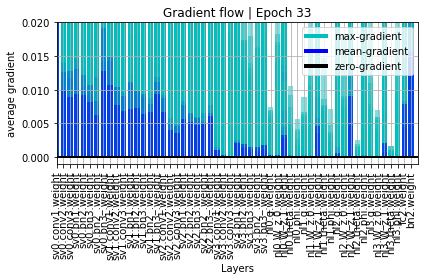

In [13]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics/nonlocal'
model_name = 'nonlocal_resnet2'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
    plot_grad_flow(model.named_parameters(), epoch,
                   savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

([<matplotlib.lines.Line2D at 0x7f8ea6103518>,
 0.617653508981069)

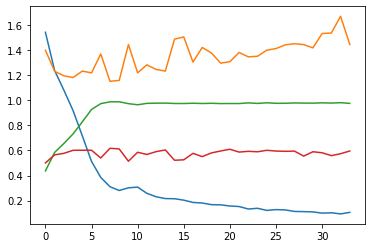

In [14]:
plt.plot(hist), best_acc

In [16]:
import imageio
images = []
for i in range(33):
    images.append(imageio.imread('/tf/data/Quan/fer2013/backtobasics/nonlocal/nonlocal_resnet2_gf_' + str(i) + '.png'))
imageio.mimsave('/tf/data/Quan/fer2013/backtobasics/nonlocal/nonlocal_resnet2_gf.gif', images)

After serveral experiment, I think that non-local network is not suitable for FER task.